# Overview

This is a Jupyter notebook (work in progress) to visualize the data gathered during our testing with the SATURN patch.

The basic data filtering approach will be as follows:

For each dataset containing a time series of voltage readings:
1. Trim the dataset's beginning and end for "dead zones" where there is no data.
2. Smooth the dataset by taking the moving average.
3. Split the dataset into individual segments, since one dataset typically contains 5 individual readings of 1 gesture.
    
Then the data can be visualized. We're trying a few different approaches:
* [All Data](#All-Data) contains a list of the raw waveforms for all datasets. Useful for debugging.
* [All Data, Sliced and Overlaid](#All-Data--Sliced-and-Overlaid) contains a chart for each waveform containing all the segments, adjusted to be the same length and overlaid upon each other. Useful for validating that input data is consistent.
* [Segments by Gesture](#Segments-by-Gesture) contains a chart for each gesture. In each gesture chart, the segmented data from each configuration of SATURN (ex. with backing material, without backing material, large pad, small pad, etc.) is overlaid. This will help us determine what SATURN configurations produce the most differentiable signals.

# Imports and Utility Functions

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import os
from numpy.fft import fft, fftfreq, ifft, rfft

# Returns a list of the datasets in the data directory.
# Each dataset in this list is a dict with three attributes:
#   Dir: directory under data/ occupied by this dataset
#   File: filename without extension
#   Path: relative path to .csv
def get_available_datasets():
    data = []

    for datafile in filter(lambda x: x[-4:] == '.csv',
        list(itertools.chain(*[[root+'/'+file for file in files]
        for root, _, files in os.walk('./data')]))):
        
        n = datafile.split('/')
        data.append({
            'Dir': n[-2],
            'File': n[-1].split('.')[0],
            'Path': datafile
        })

    return data

# Returns a dataset's contents as a list.
# If `raw` is not set, the results will be filtered and normalized.
def load_dataset(datum, raw=False):
    if 'Dataset' in datum and raw == datum['DatasetRaw']:
        return datum['Dataset']
    dataset = pd.read_csv(datum['Path'], names=['V'], header=None)
    dataset = list(dataset['V'])
    if not raw:  # normalize and filter the data
        dataset = normalize_dataset(dataset)
        #dataset = trim_dataset(dataset)
        #dataset = moving_average(dataset, 20)
        #dataset = segment_dataset(dataset, threshold=0.01, min_spacing=100)
    datum['Dataset'] = dataset
    datum['DatasetRaw'] = raw
    return dataset

# Normalize a dataset by dividing by max amplitude.
def normalize_dataset(data):
    return np.divide(data, np.max(data))

# Removes all leading and trailing points that fall under a certain threshold.
# The idea is to remove the irrelevant start and end portions of our data.
# Returns the relevant slice.
def trim_dataset(data, threshold=0.01):
    i = 0
    while abs(data[i]) < threshold and i < len(data):
        i += 1
    j = len(data) - 1
    while abs(data[j]) < threshold and j > i:
        j -= 1
    return data[i:j]

# Returns a list of the contiguous segments of the dataset.
# A contiguous segment is defined as some slice separated by at least 
# `min_spacing` points where the signal is less than `threshold` from 
# the next segment.
# Returns a list of lists (segments)
def segment_dataset(data, threshold=0.01, min_spacing=100):
    i = 0
    spaces = 0
    intervals = []
    start = None
    while i < len(data):
        while abs(data[i]) < threshold and i < len(data): 
            i += 1
        start = i
        spaces = 0
        end = i
        while i < len(data):
            if abs(data[i]) < threshold:
                spaces += 1
            else:
                spaces = 0
                end = i
            if spaces > min_spacing:
                intervals.append((start, end))
                start = None
                end = None
    if start and not end:
        intervals.append((start, i))
    print(intervals)
    return [data[interval[0]:interval[1]] for interval in intervals]

# Given a `data` as a list and a `window_size` number, it will return
# `data` with each point averaged with the previous `window_size` points.
def moving_average(data, window_size):
    res = []
    for (i,t) in enumerate(data):
        if i == 0:
            continue
        start = i - window_size
        if start < 0:
            start = 0
        end = i
        sl = data[start:end]
        x = np.average(sl)
        res.append(x)
    return res

data = get_available_datasets()

plt.rcParams["figure.figsize"] = (40,16)  # change size of charts

# All Data

/home/zach/.config/miniconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


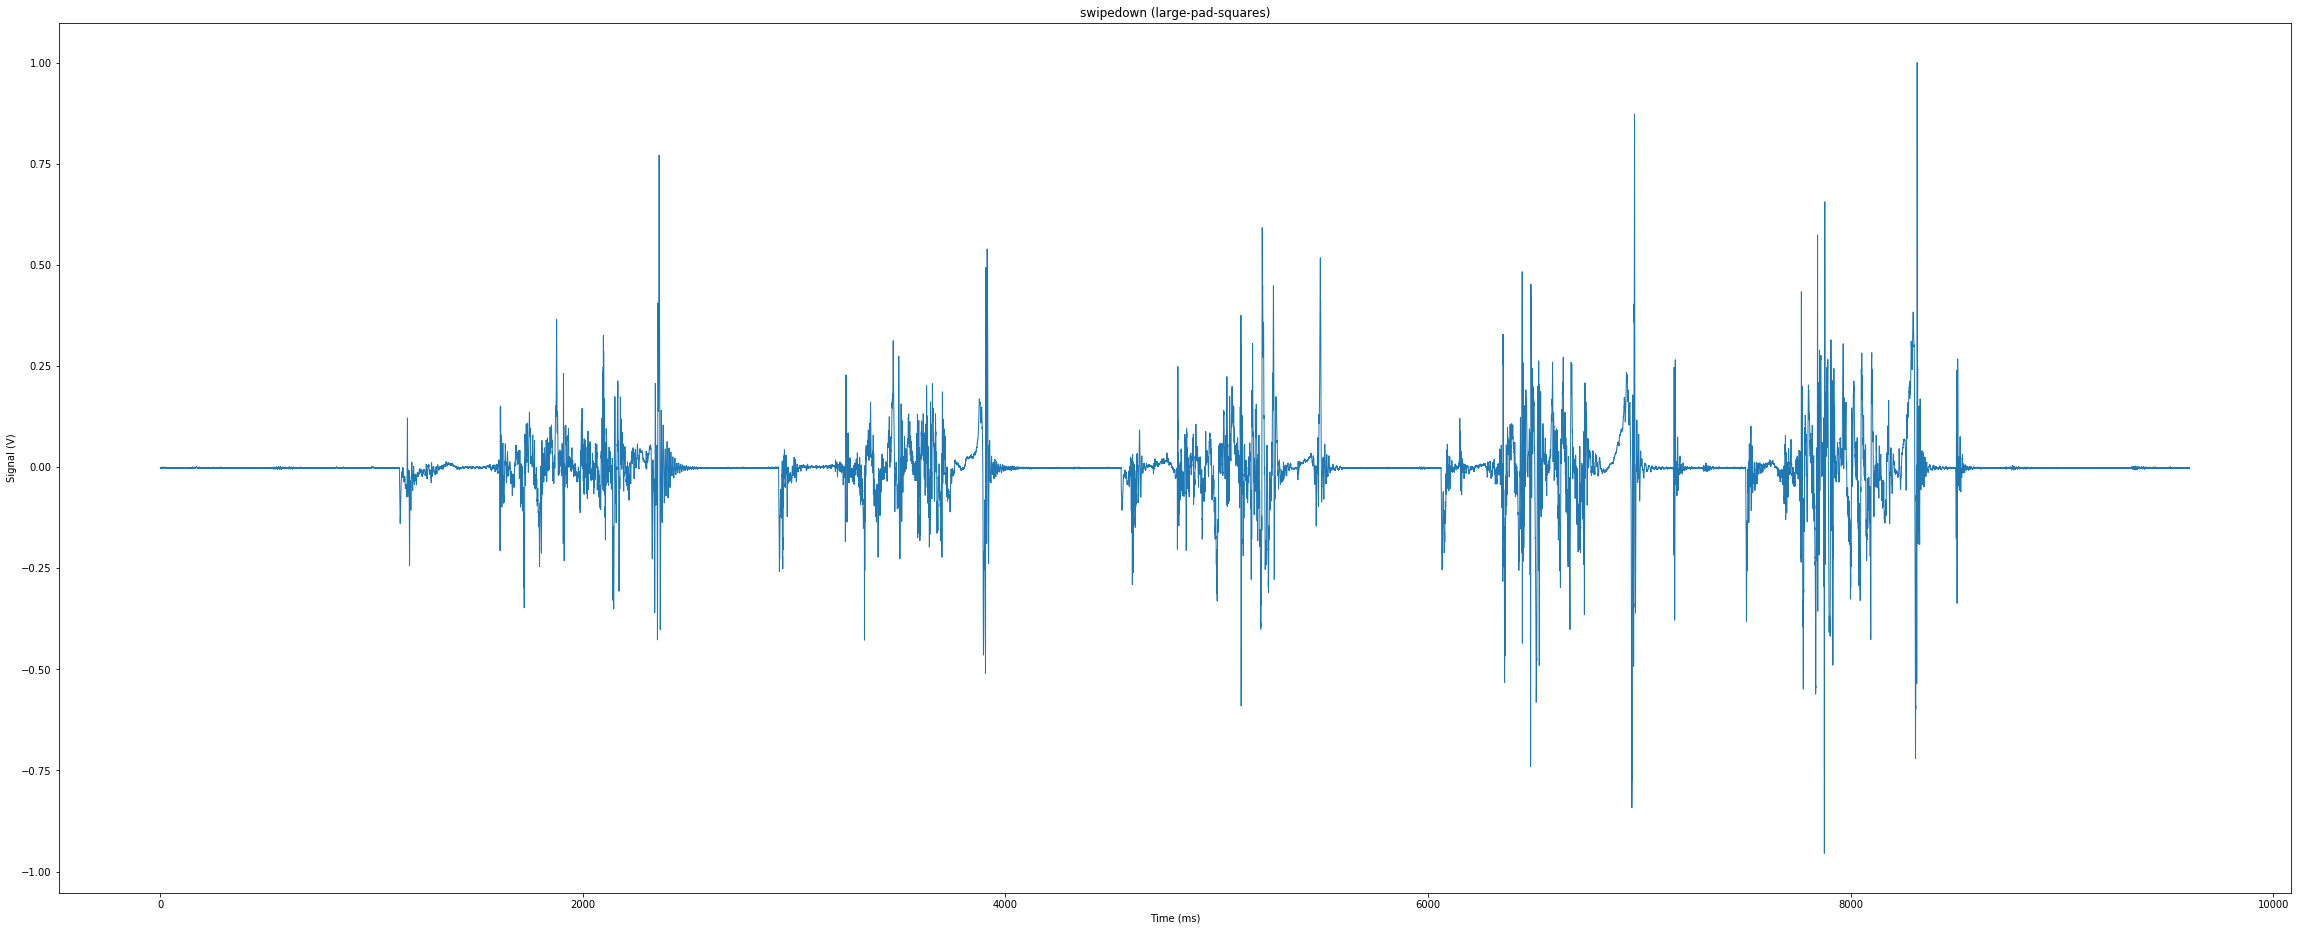

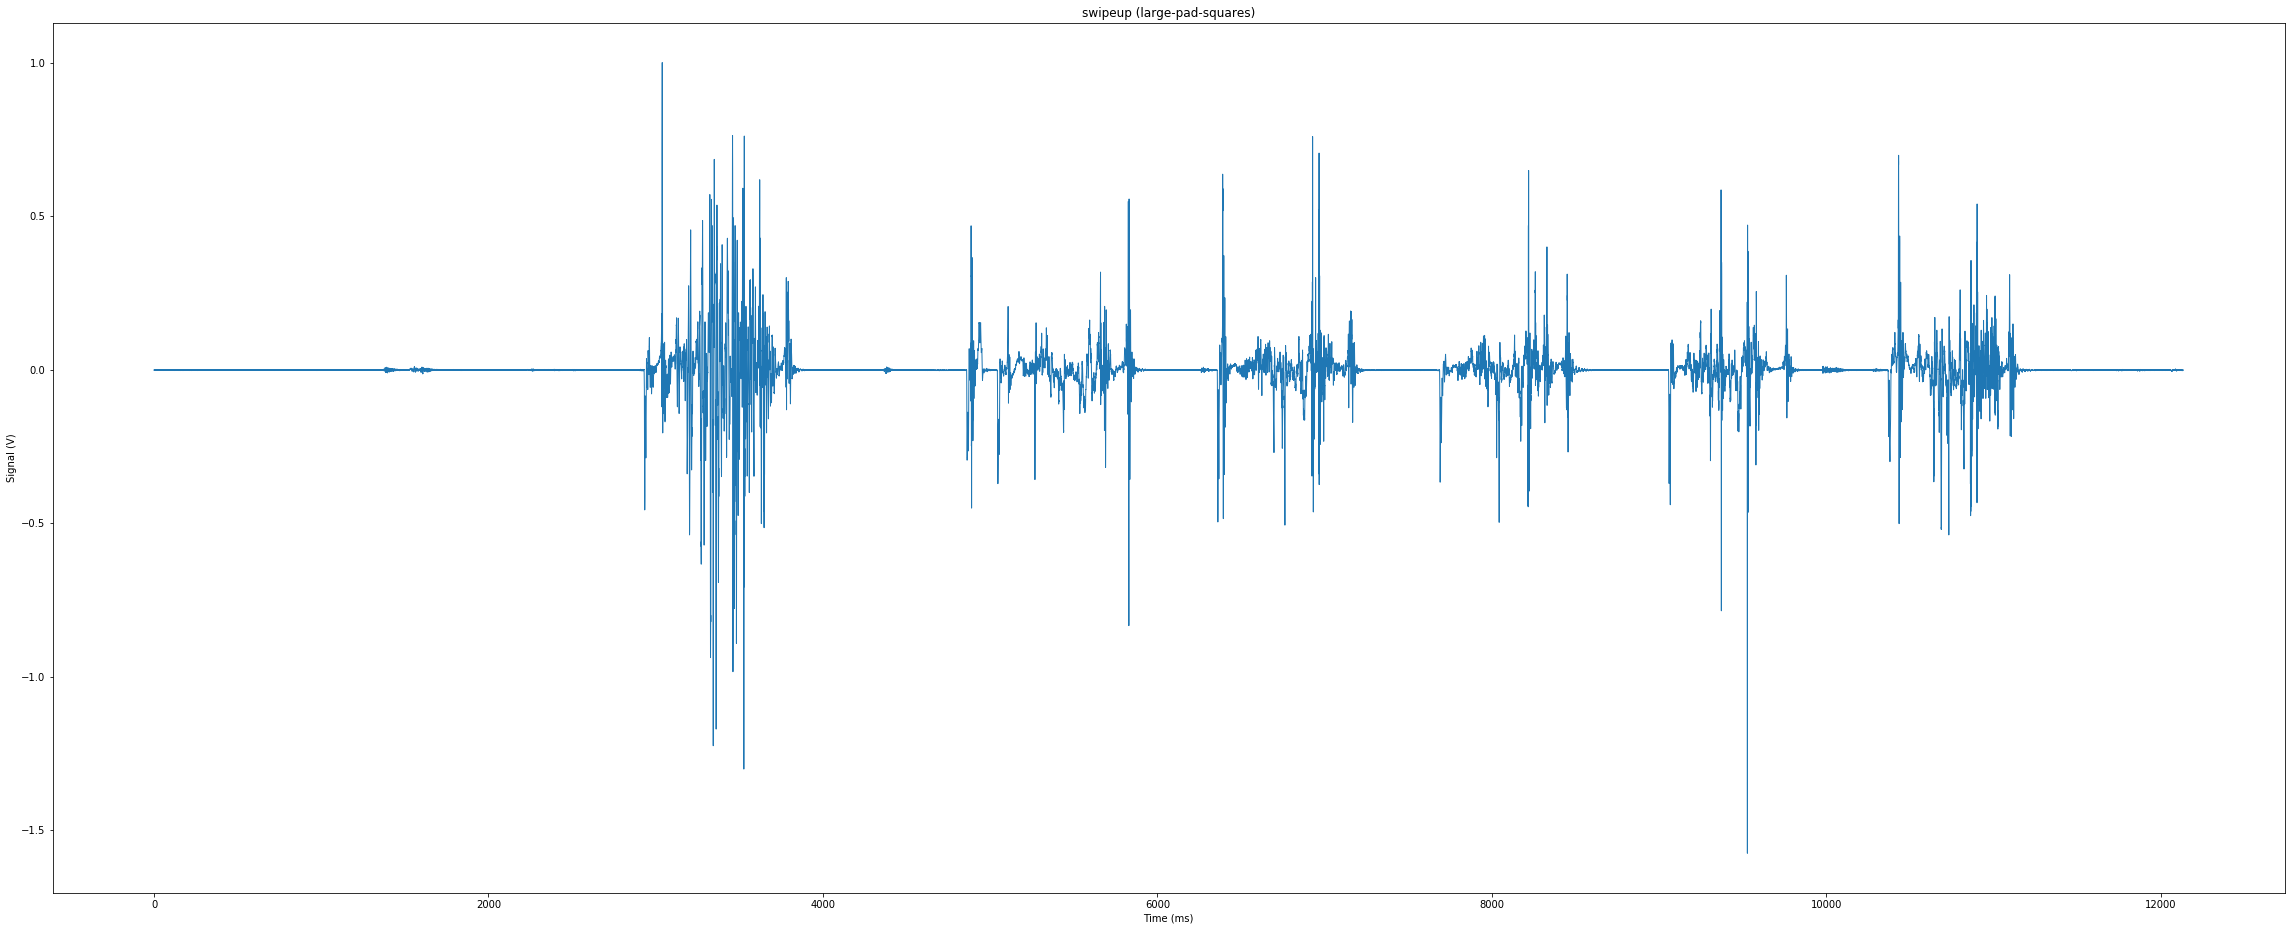

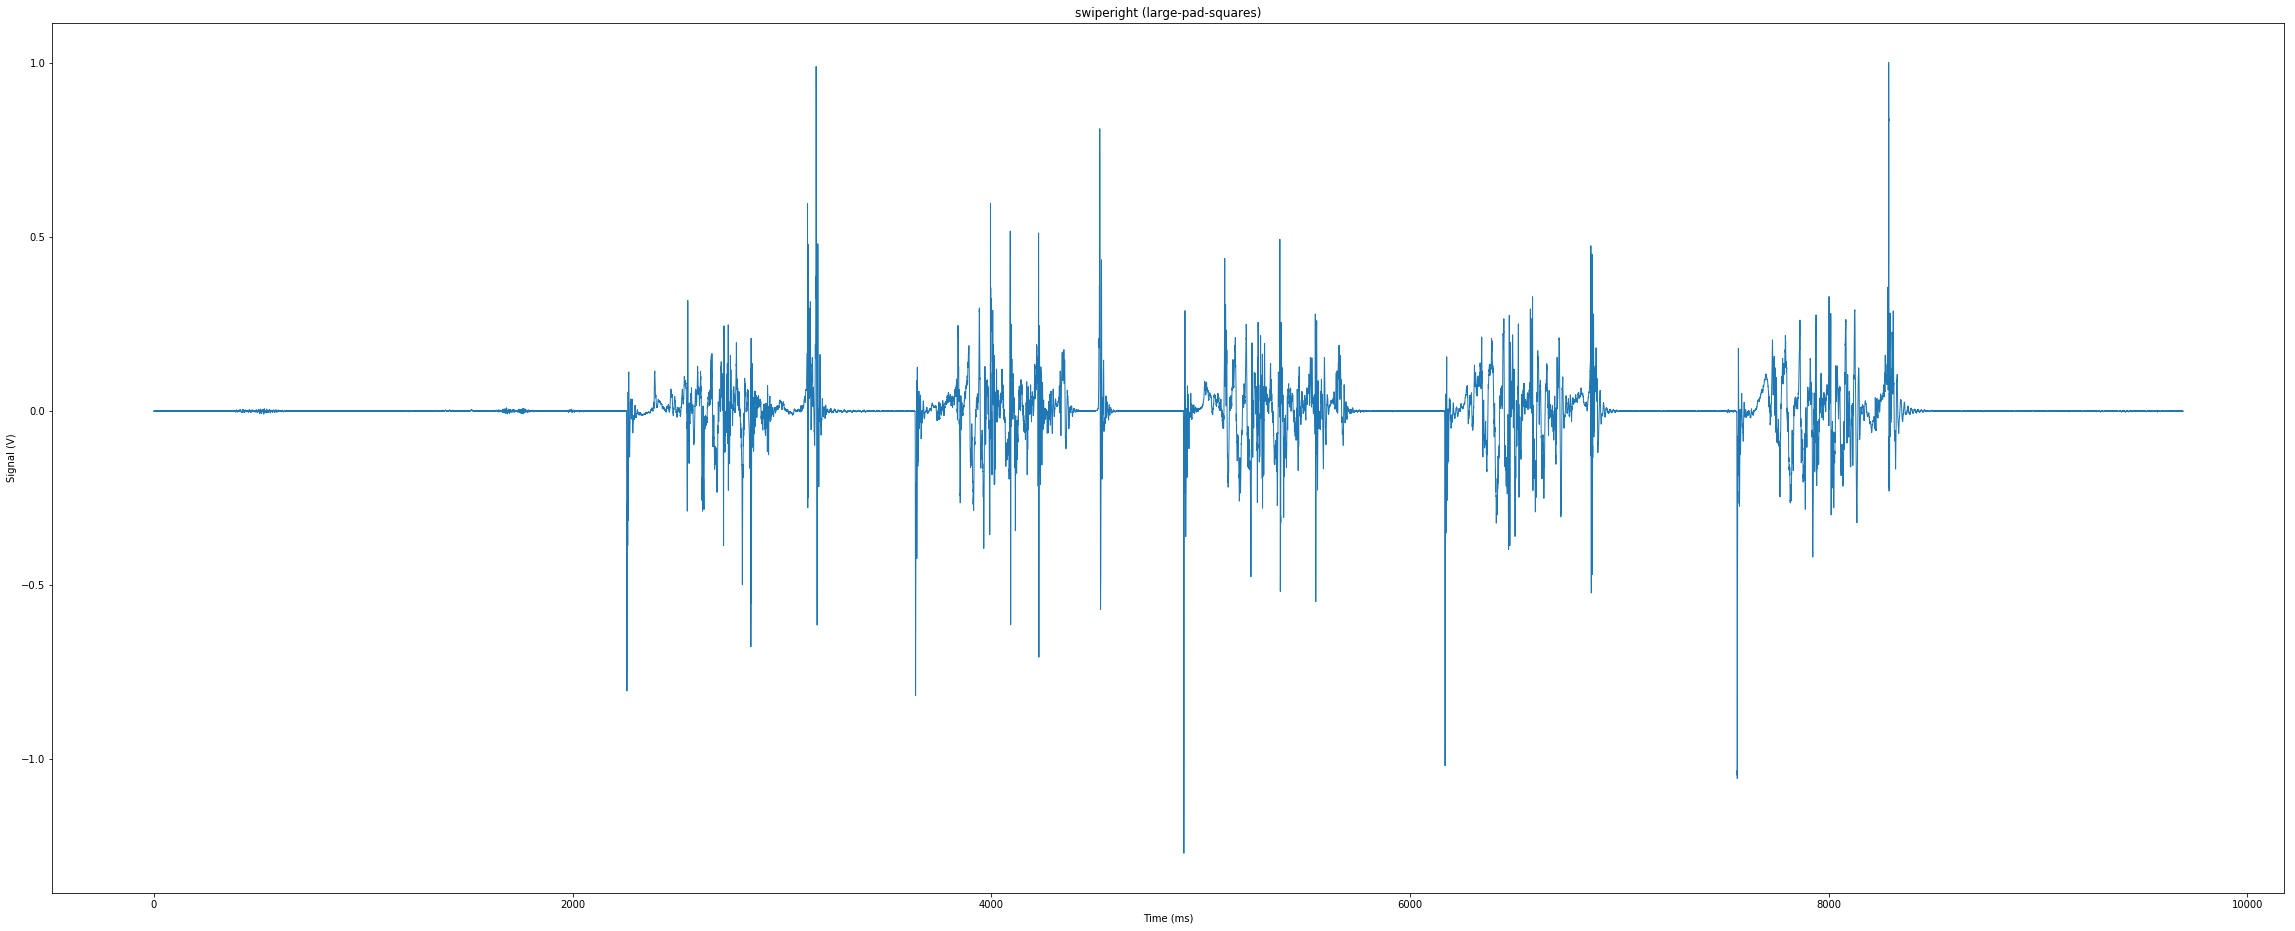

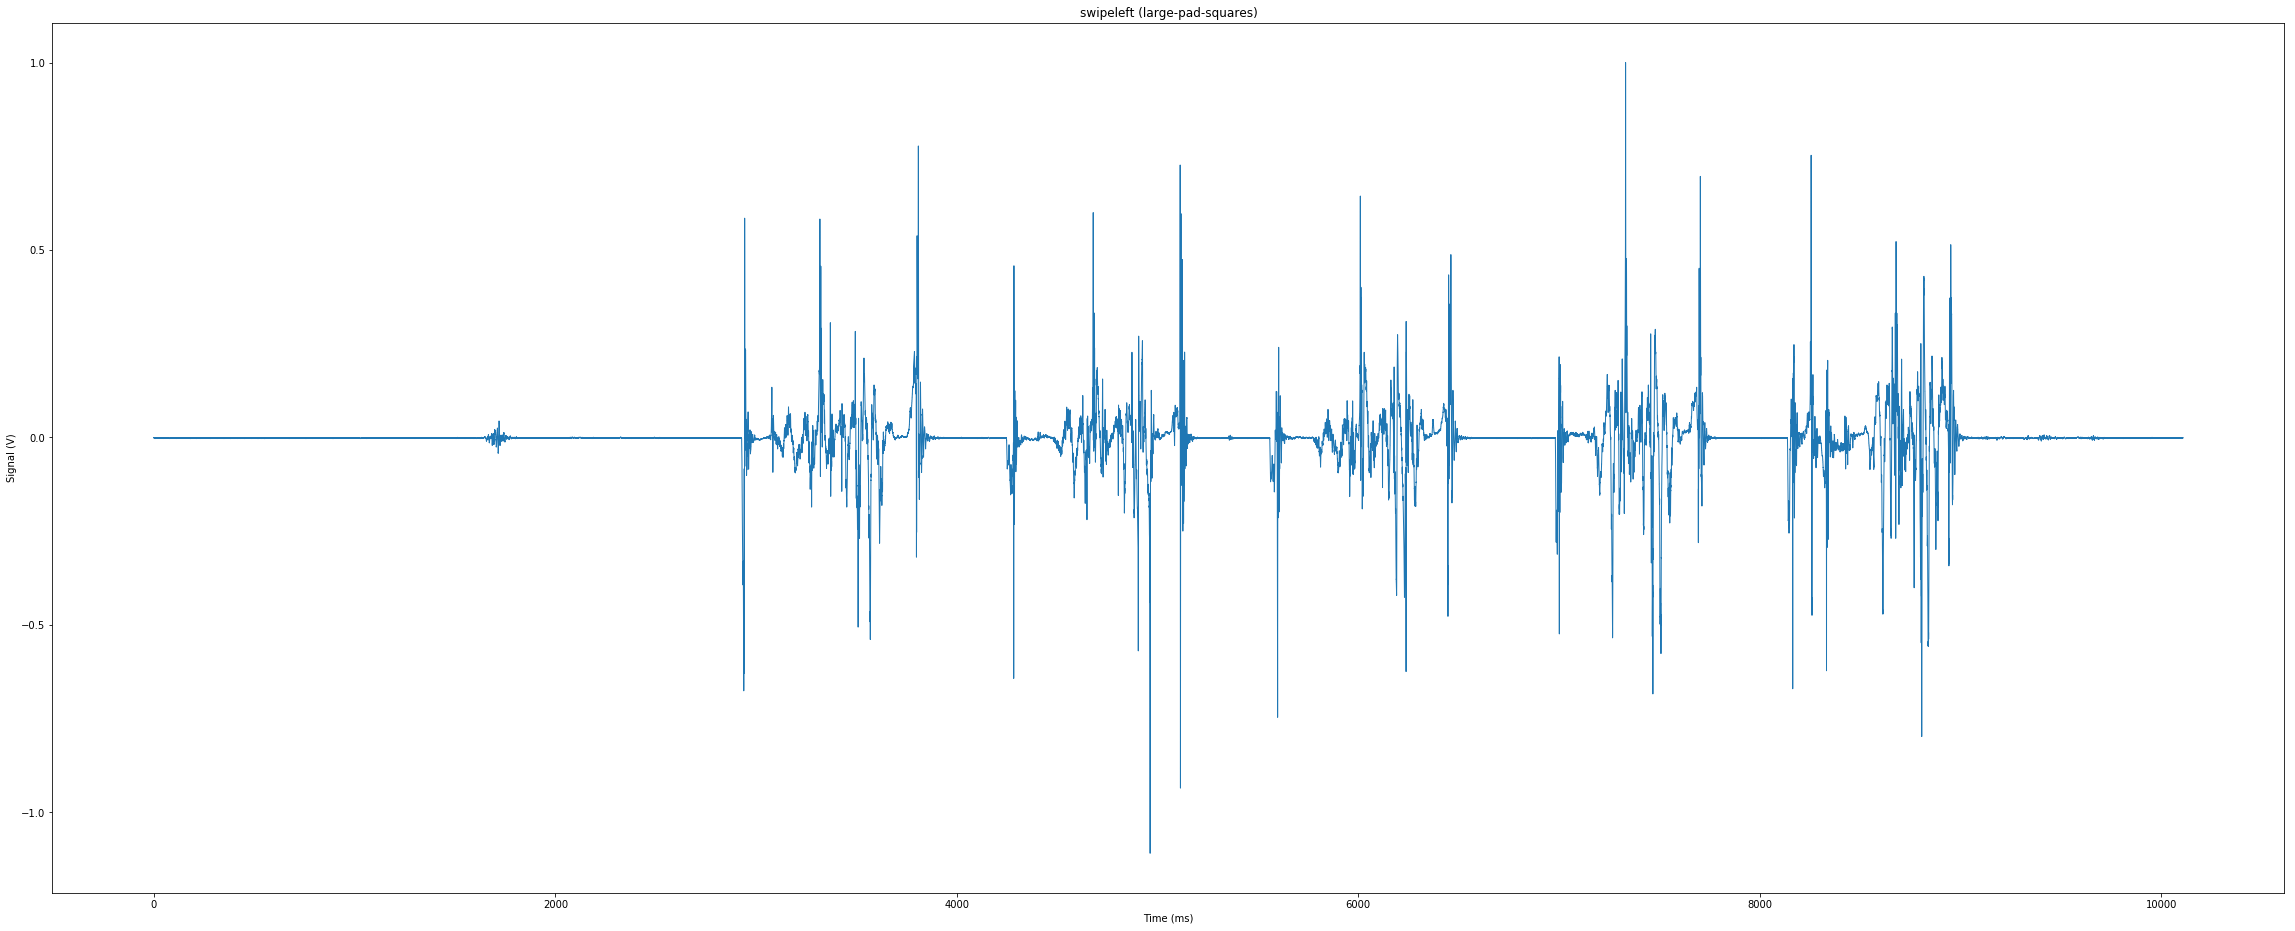

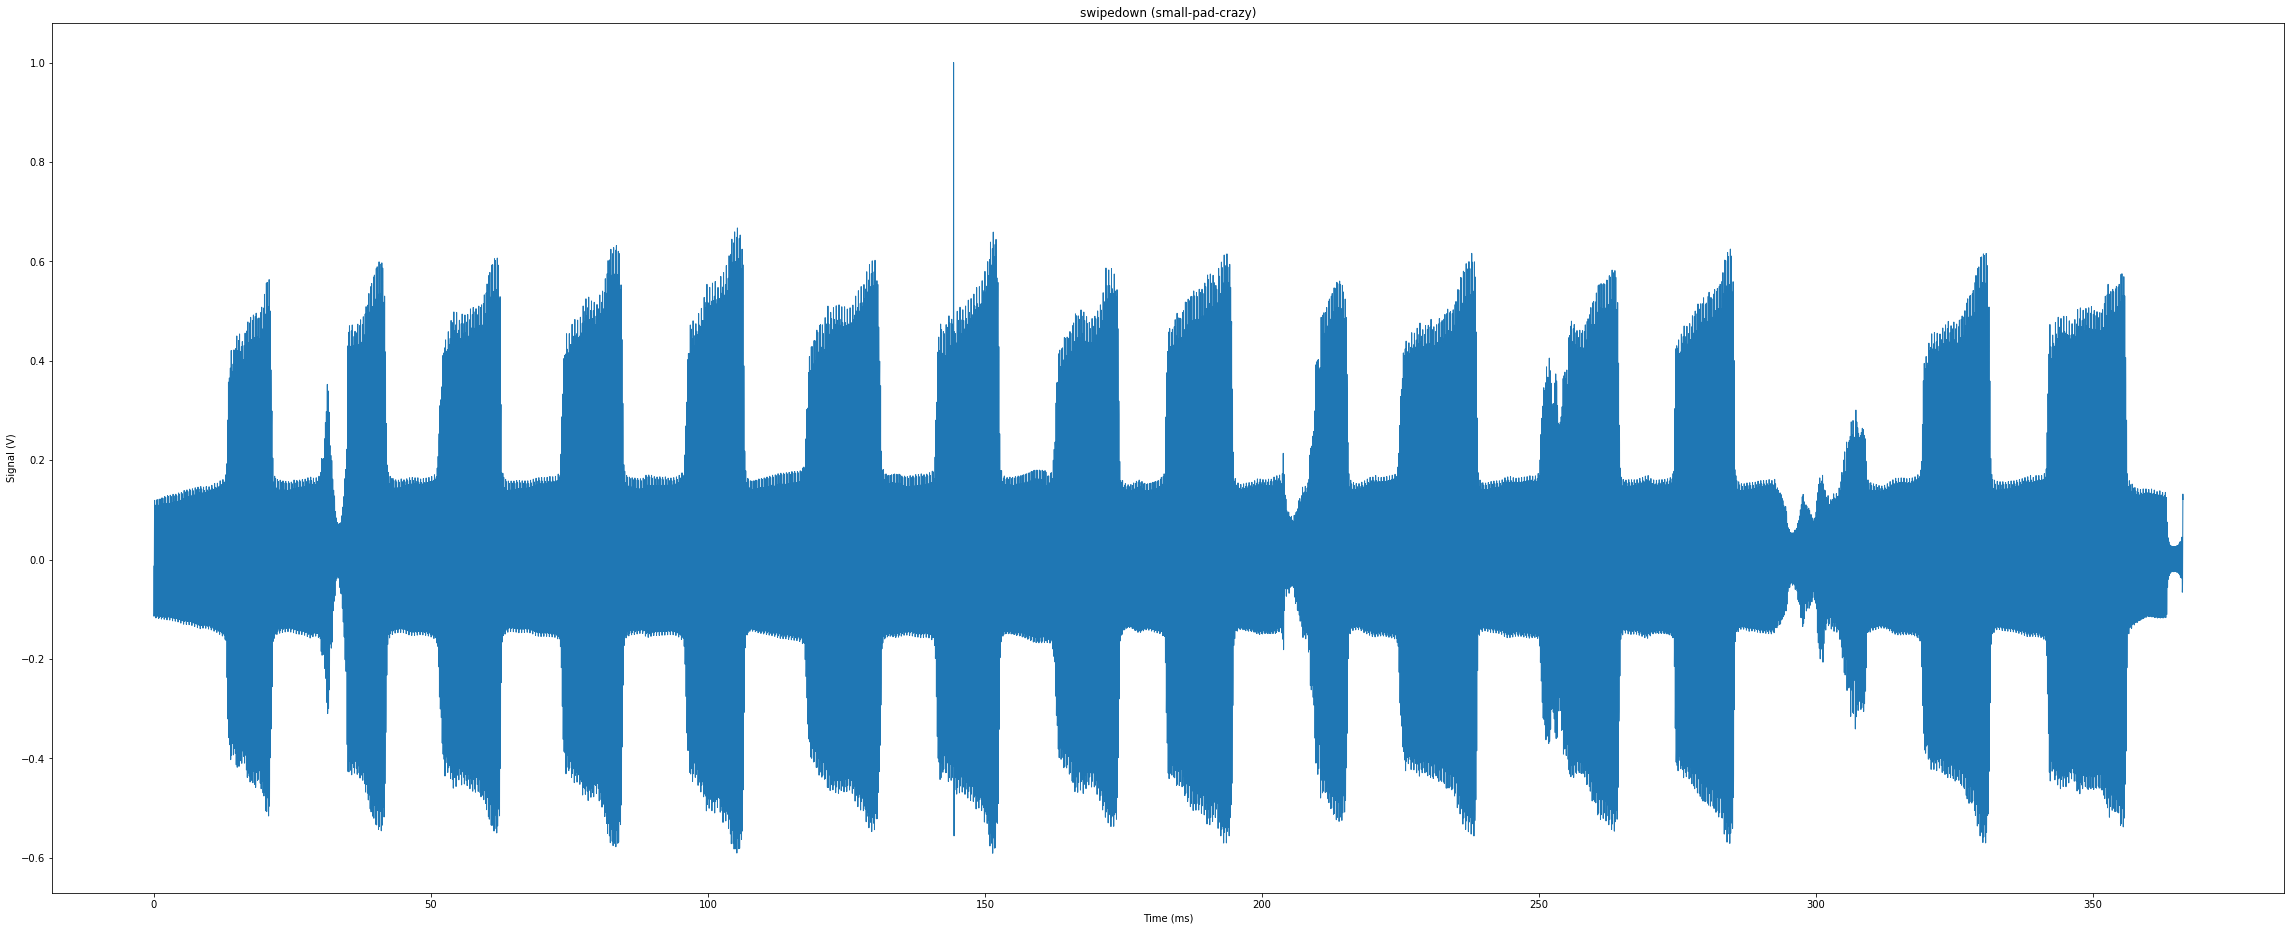

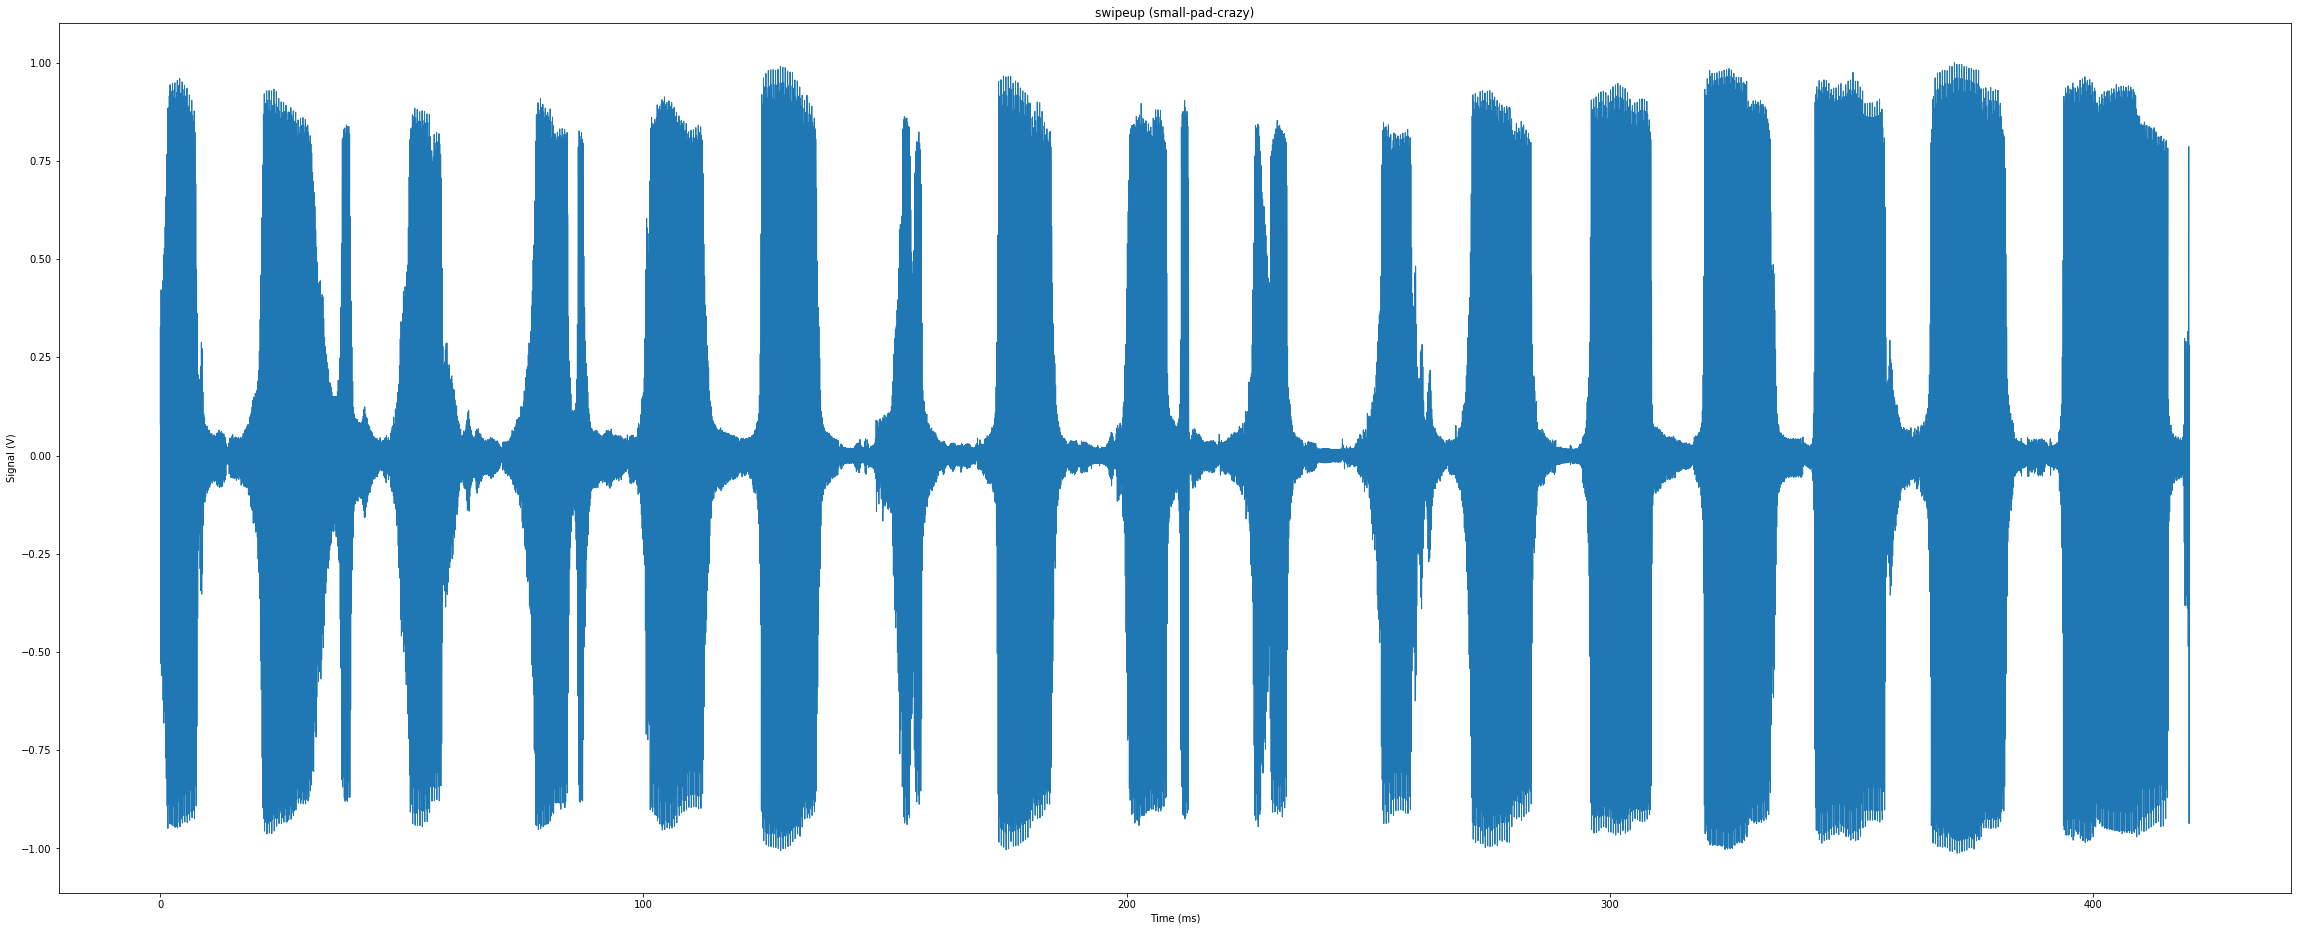

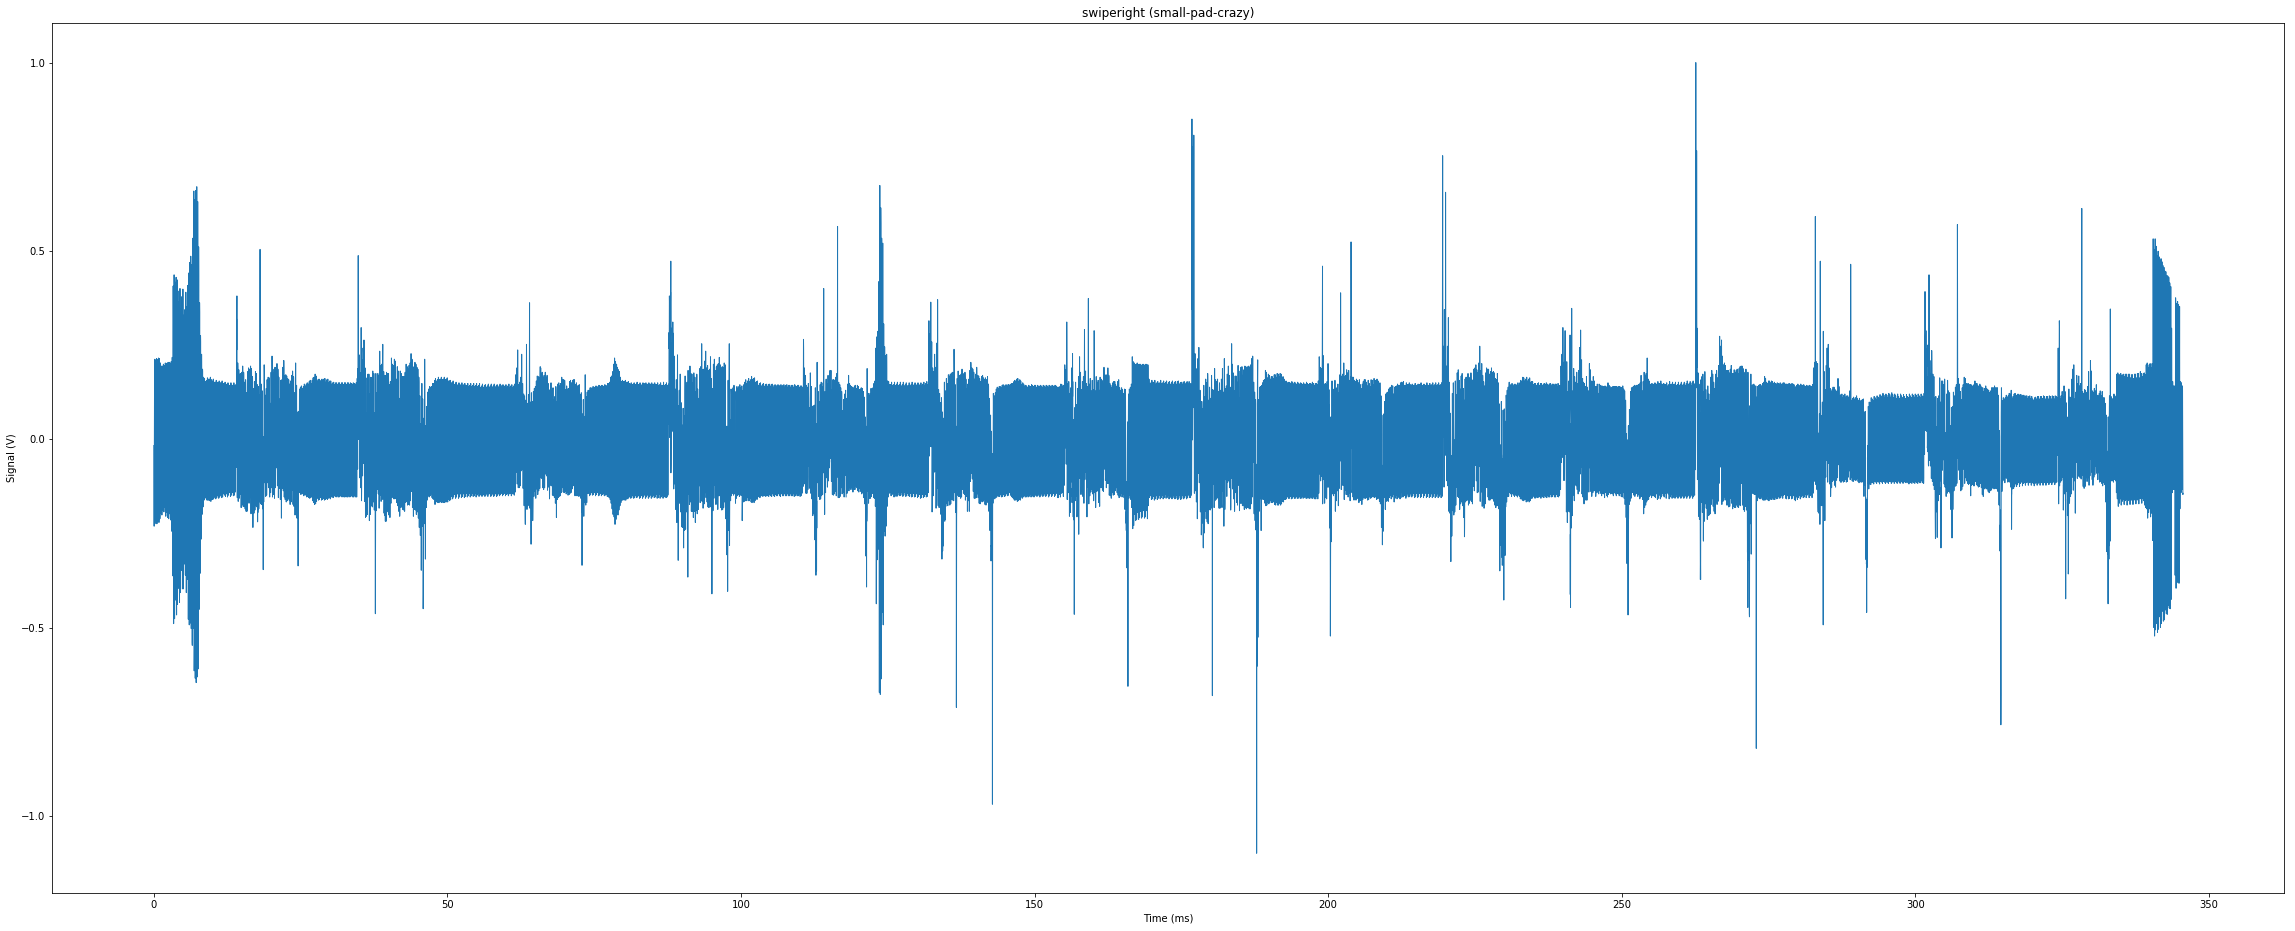

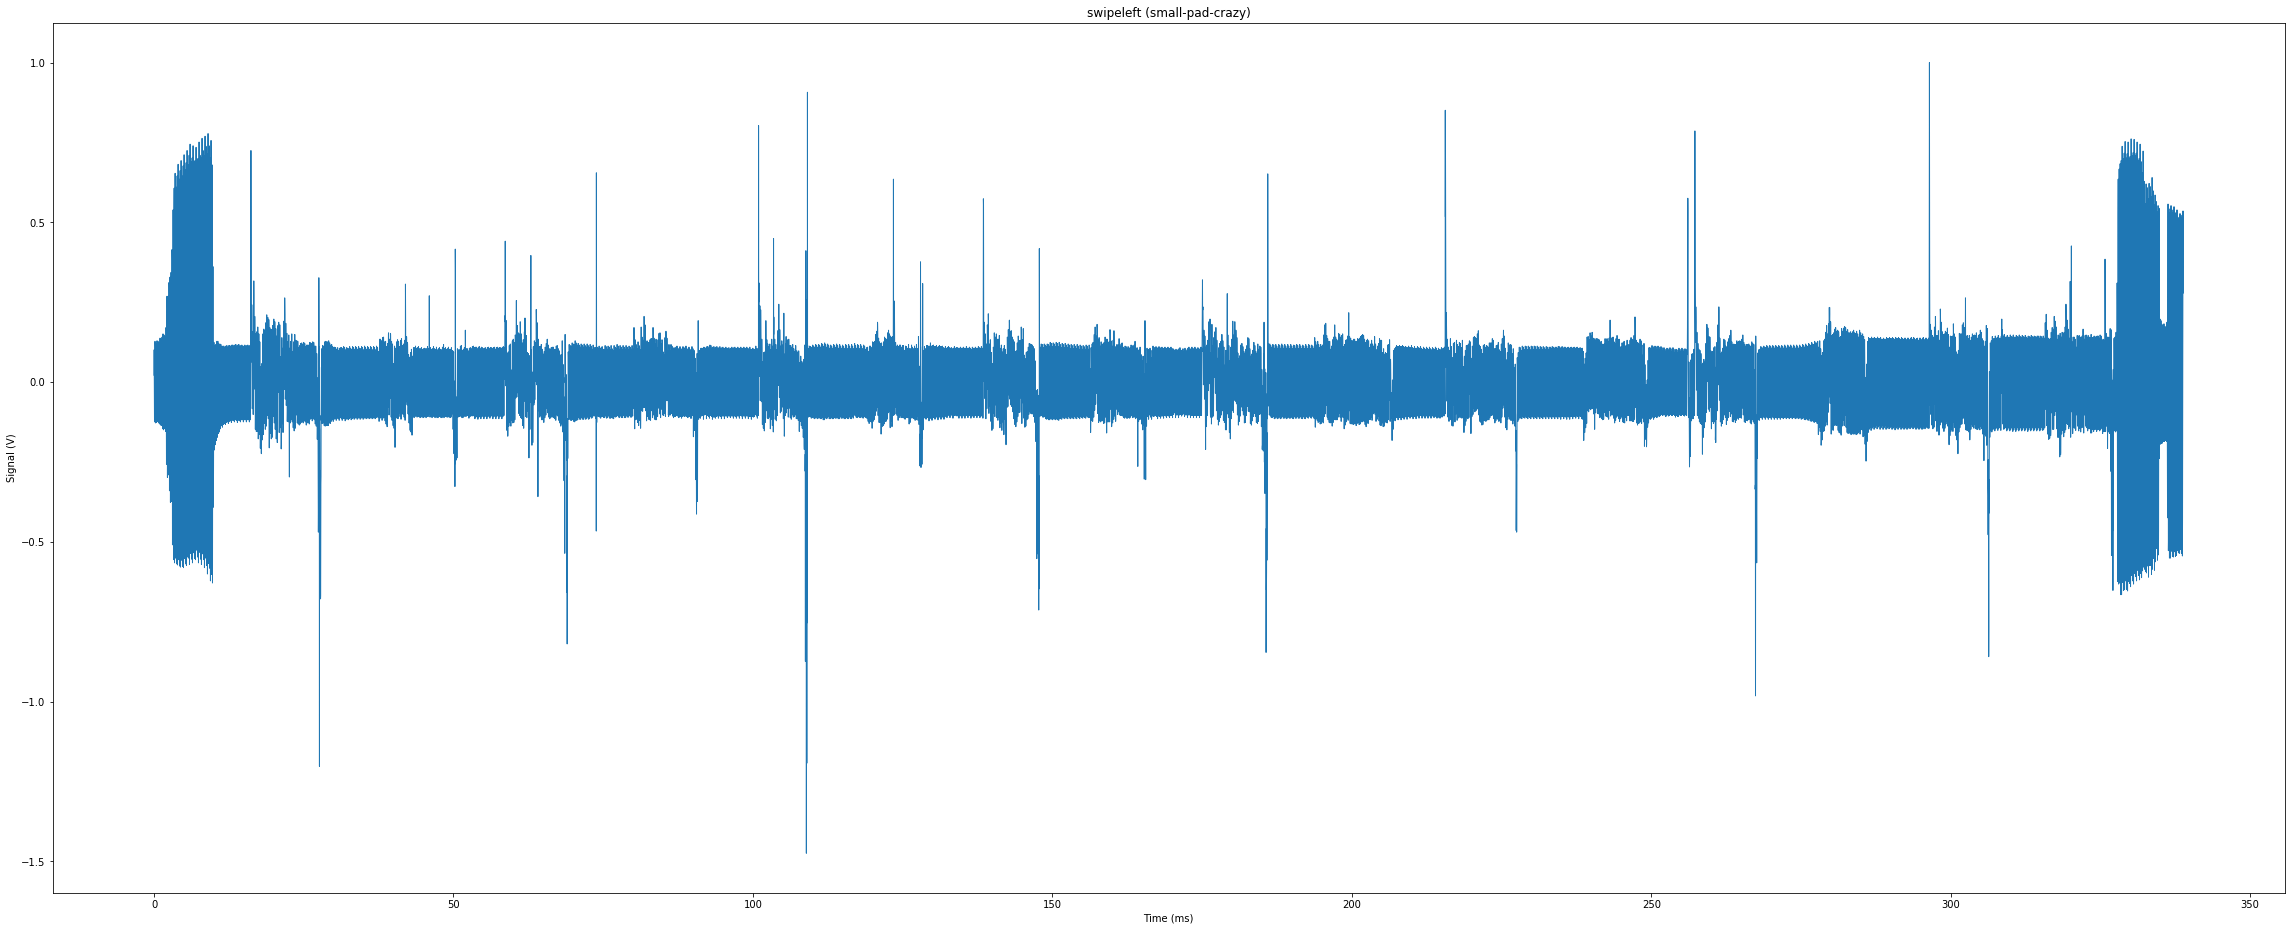

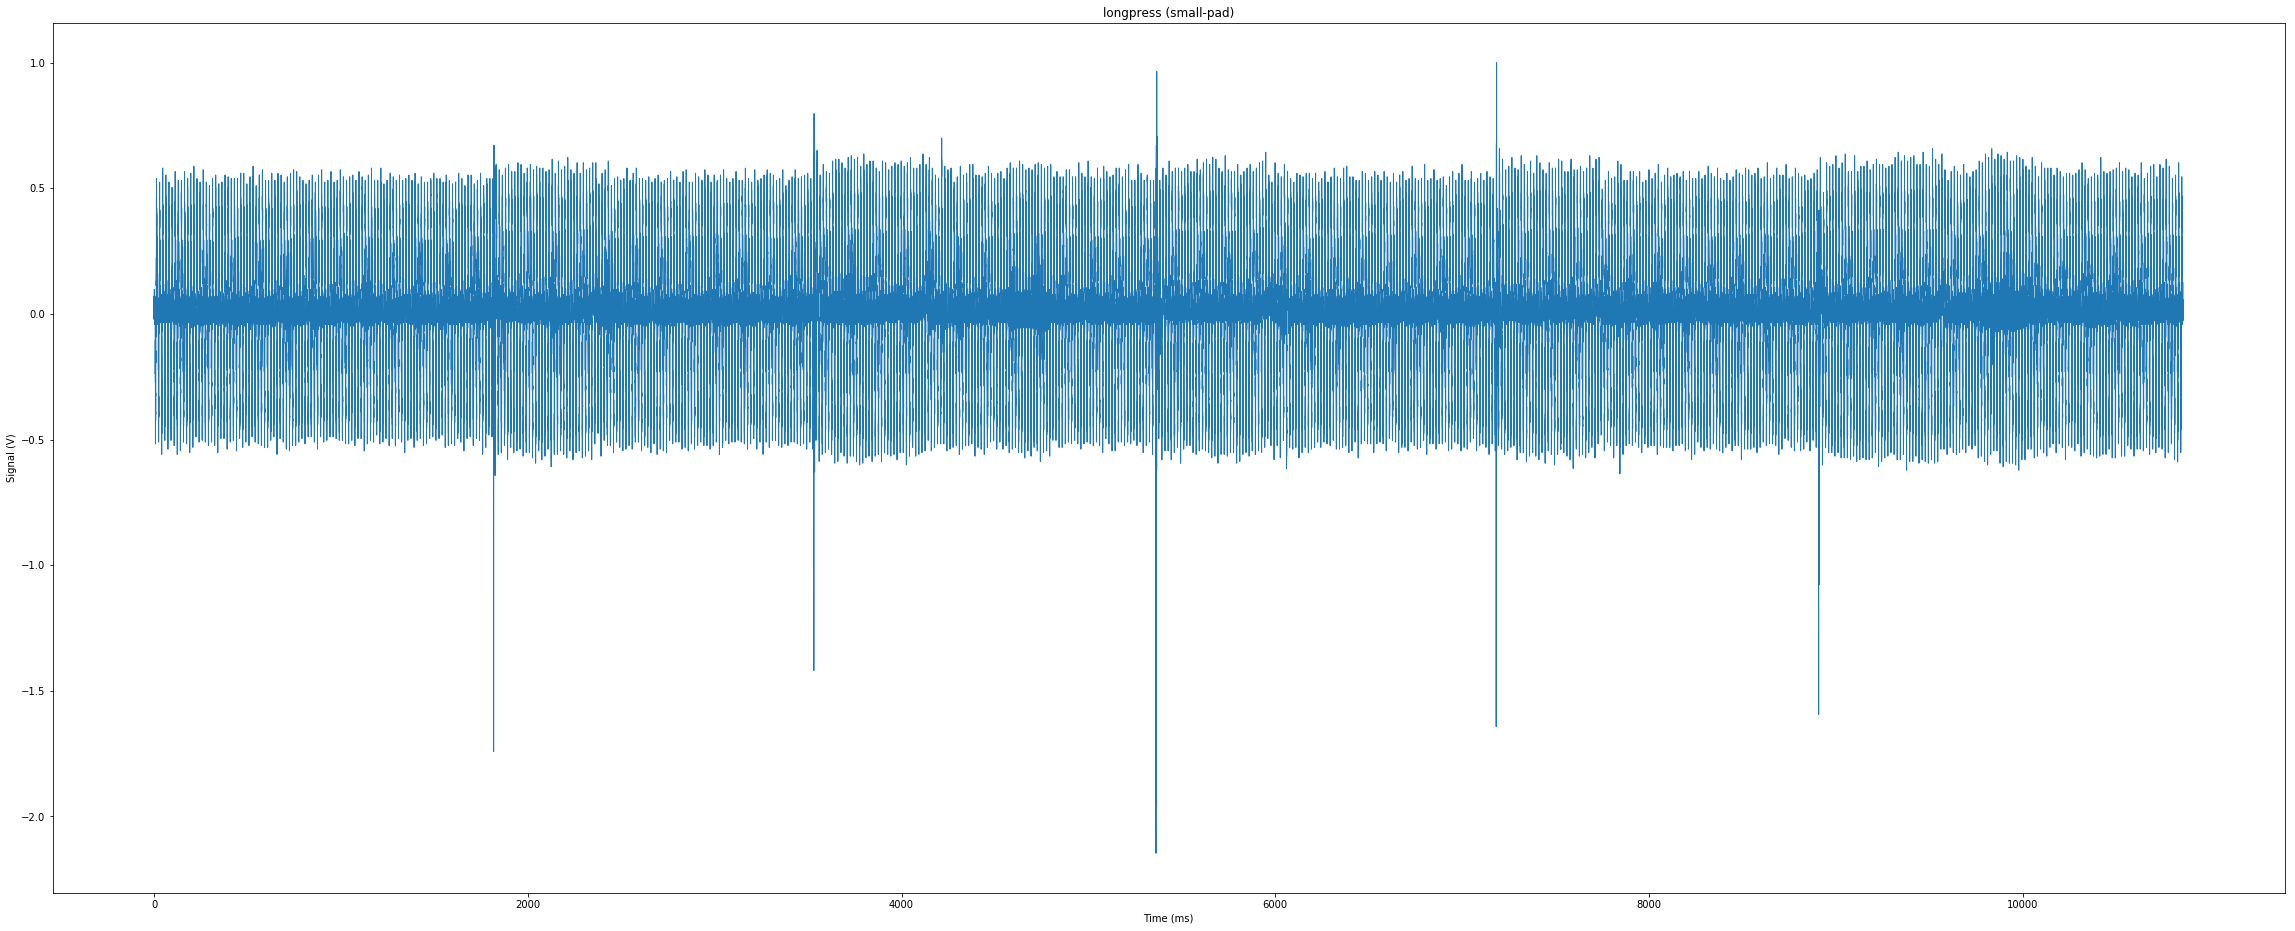

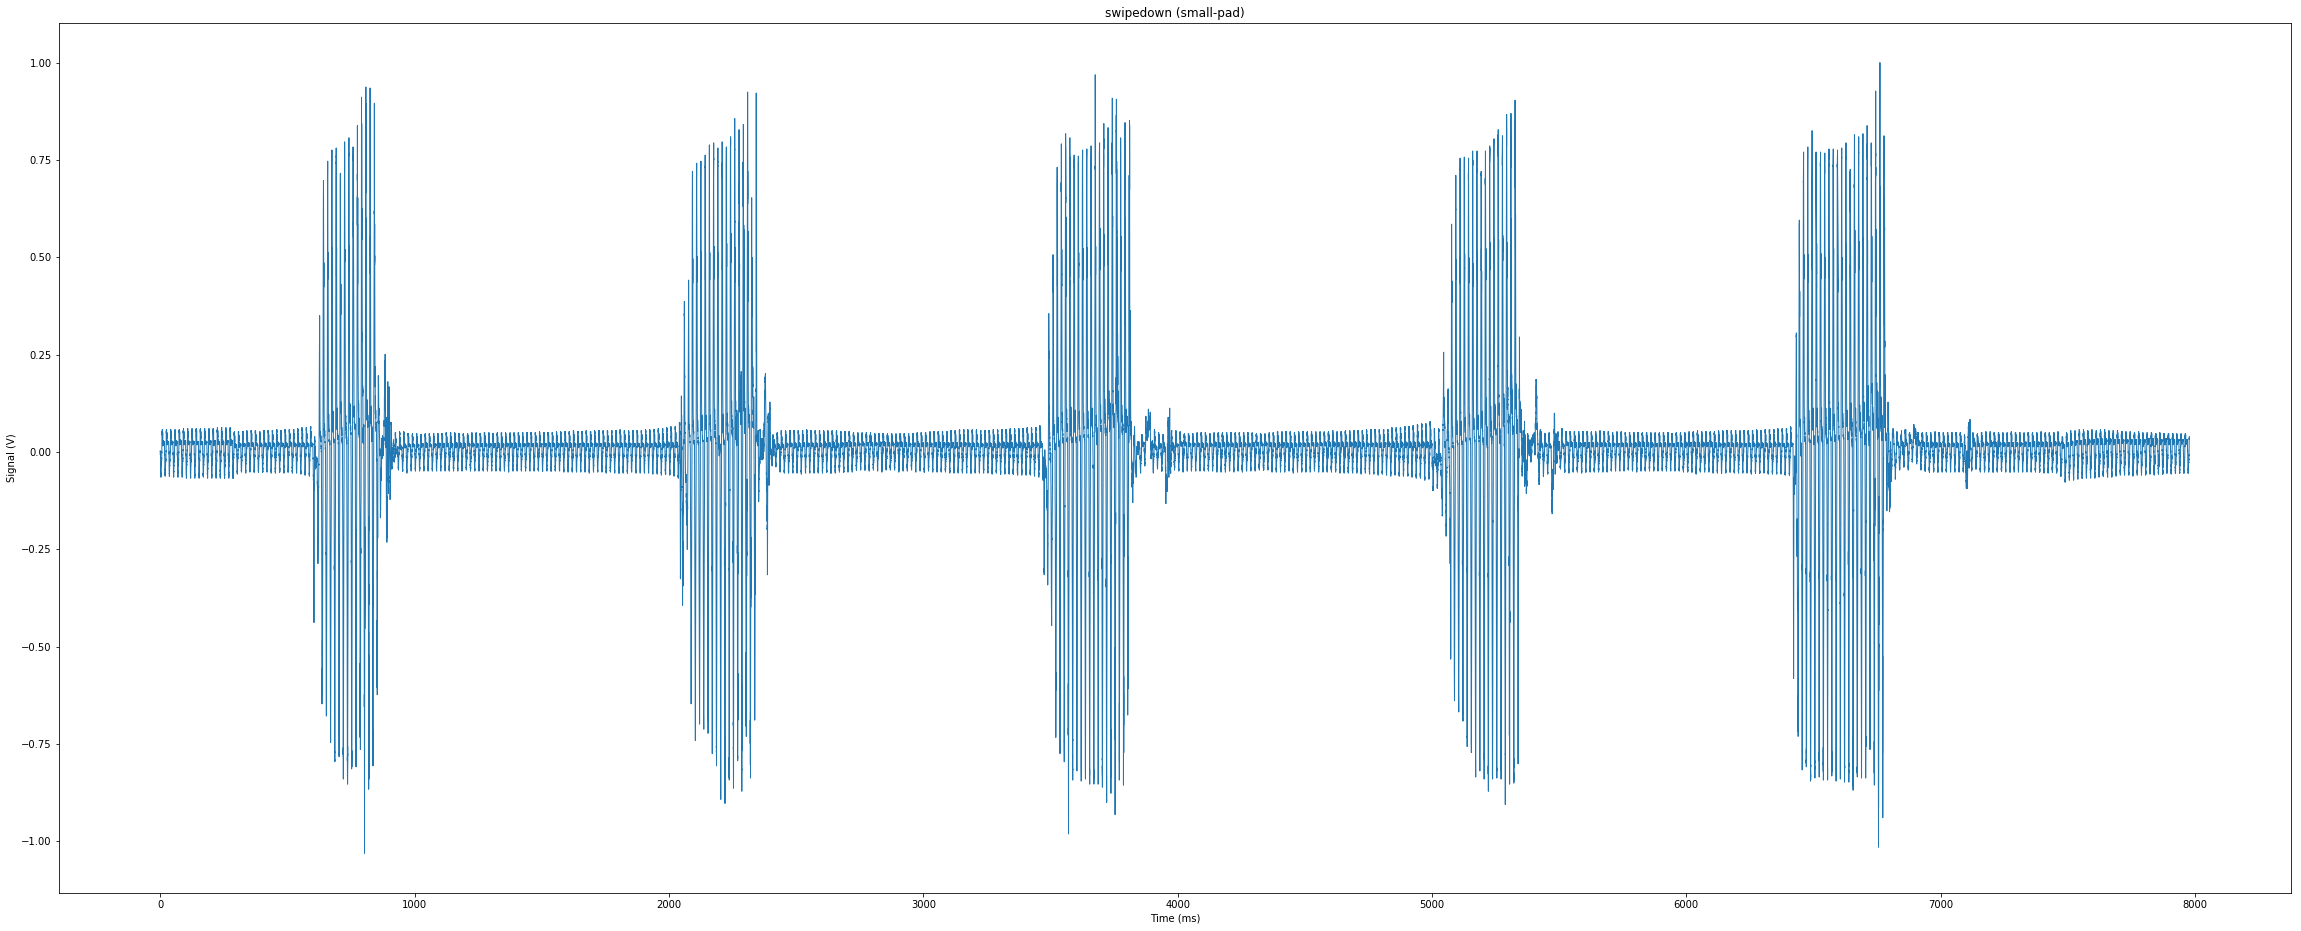

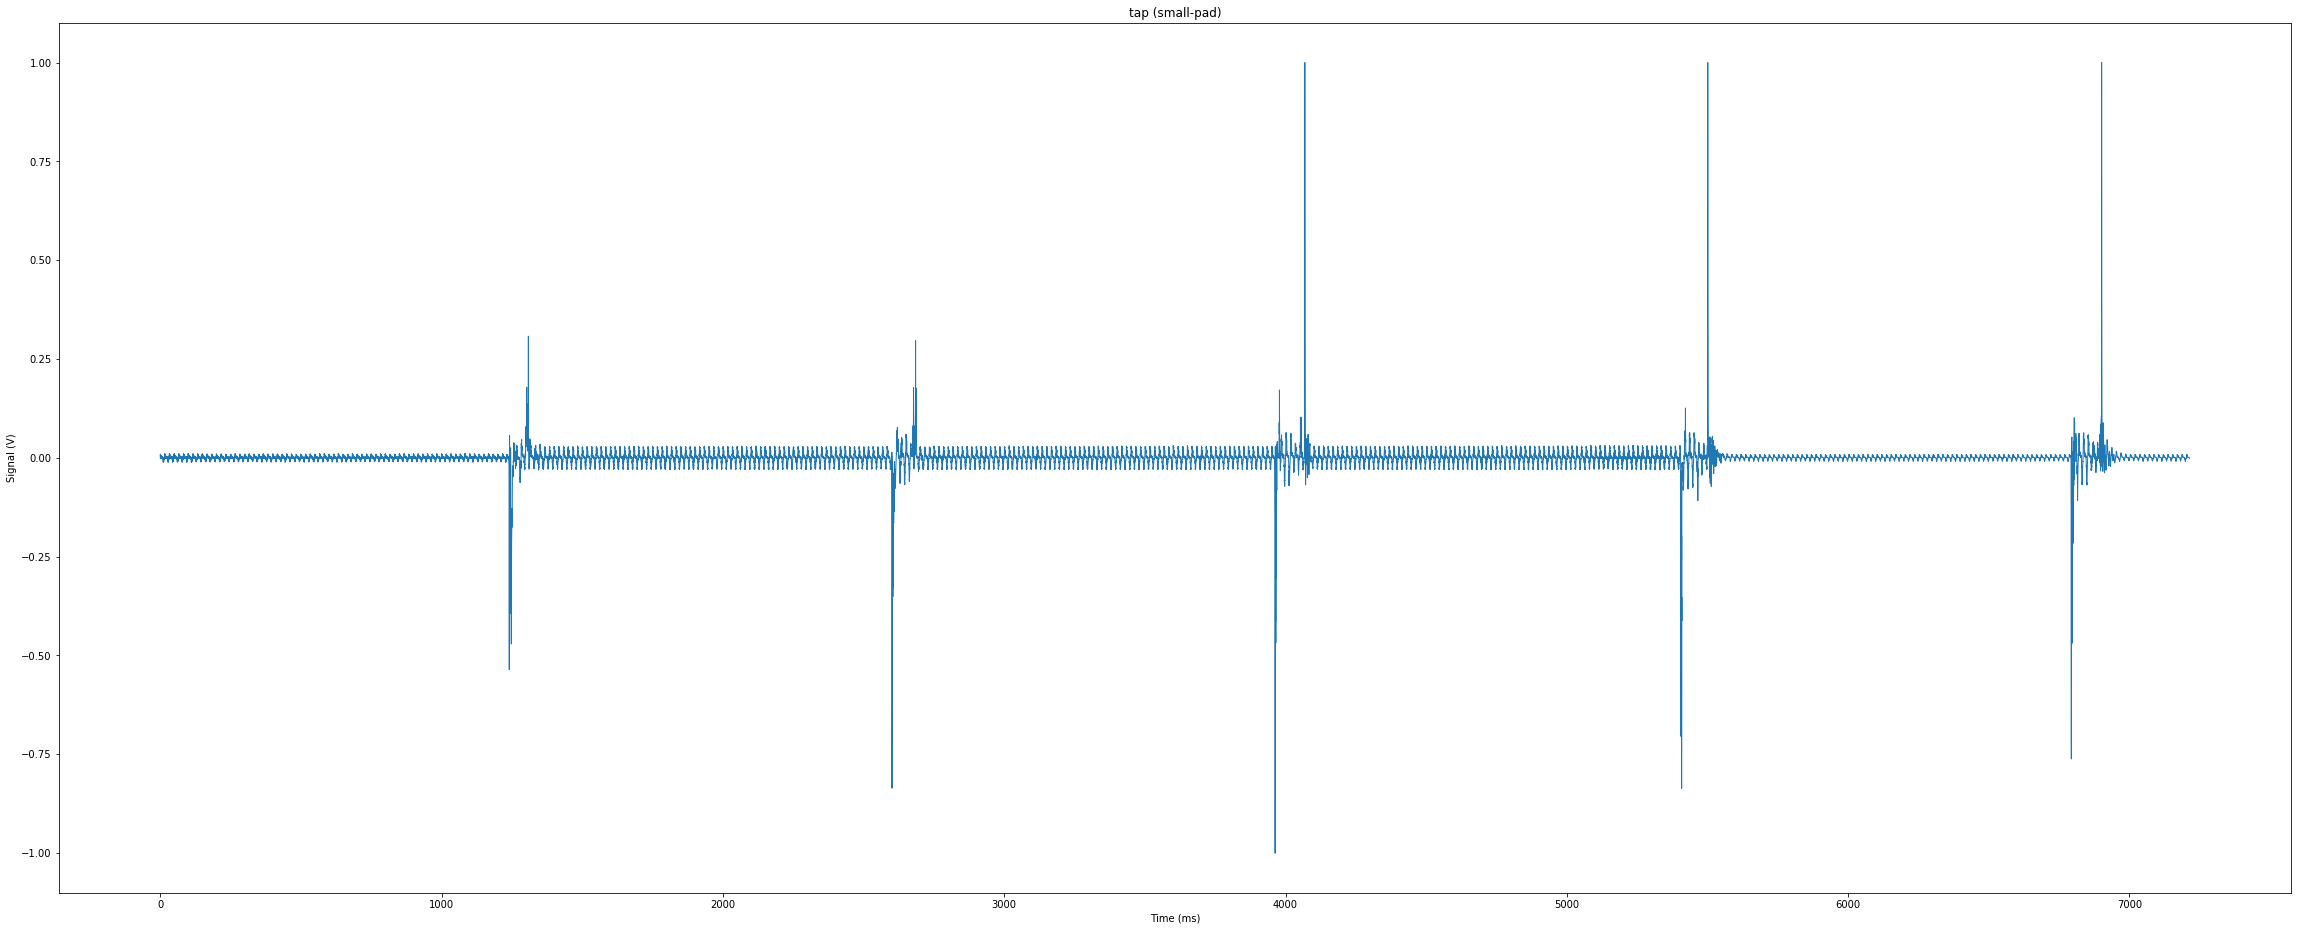

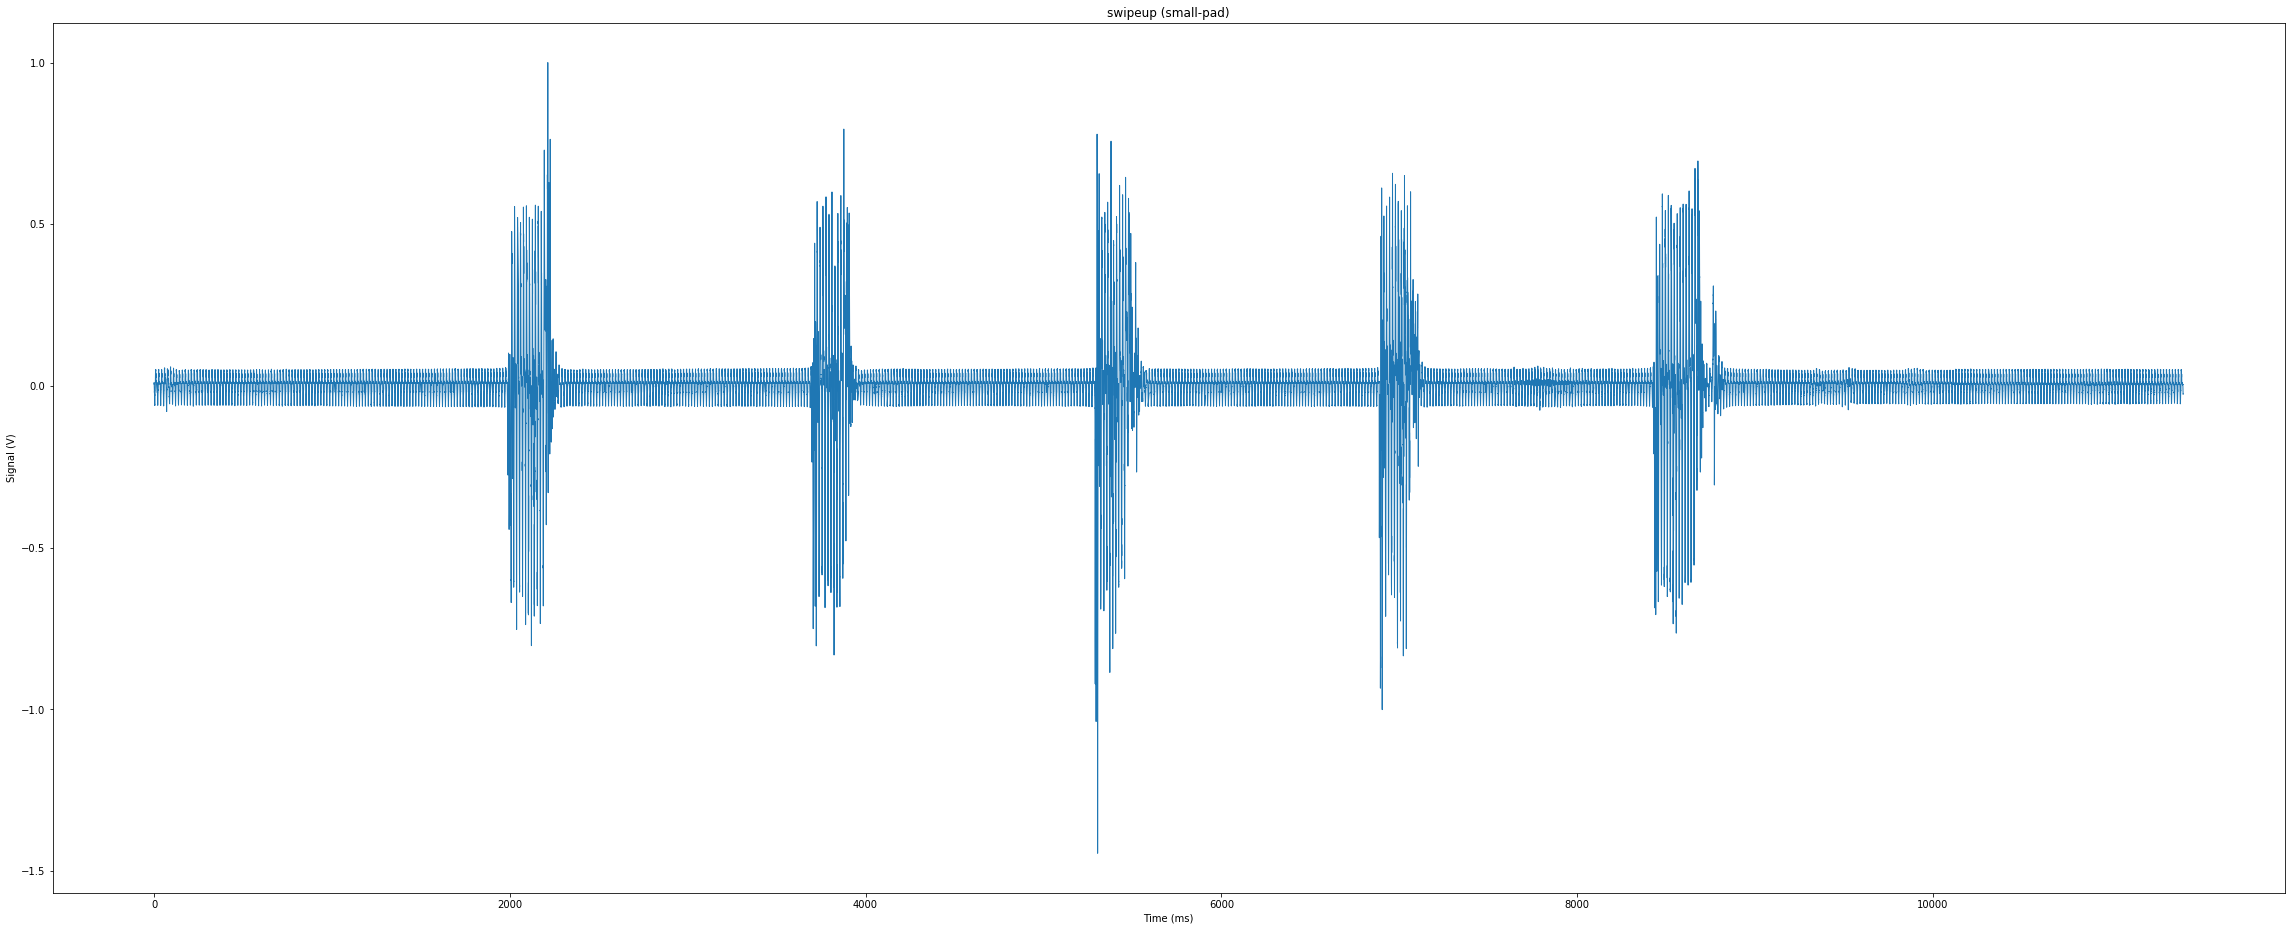

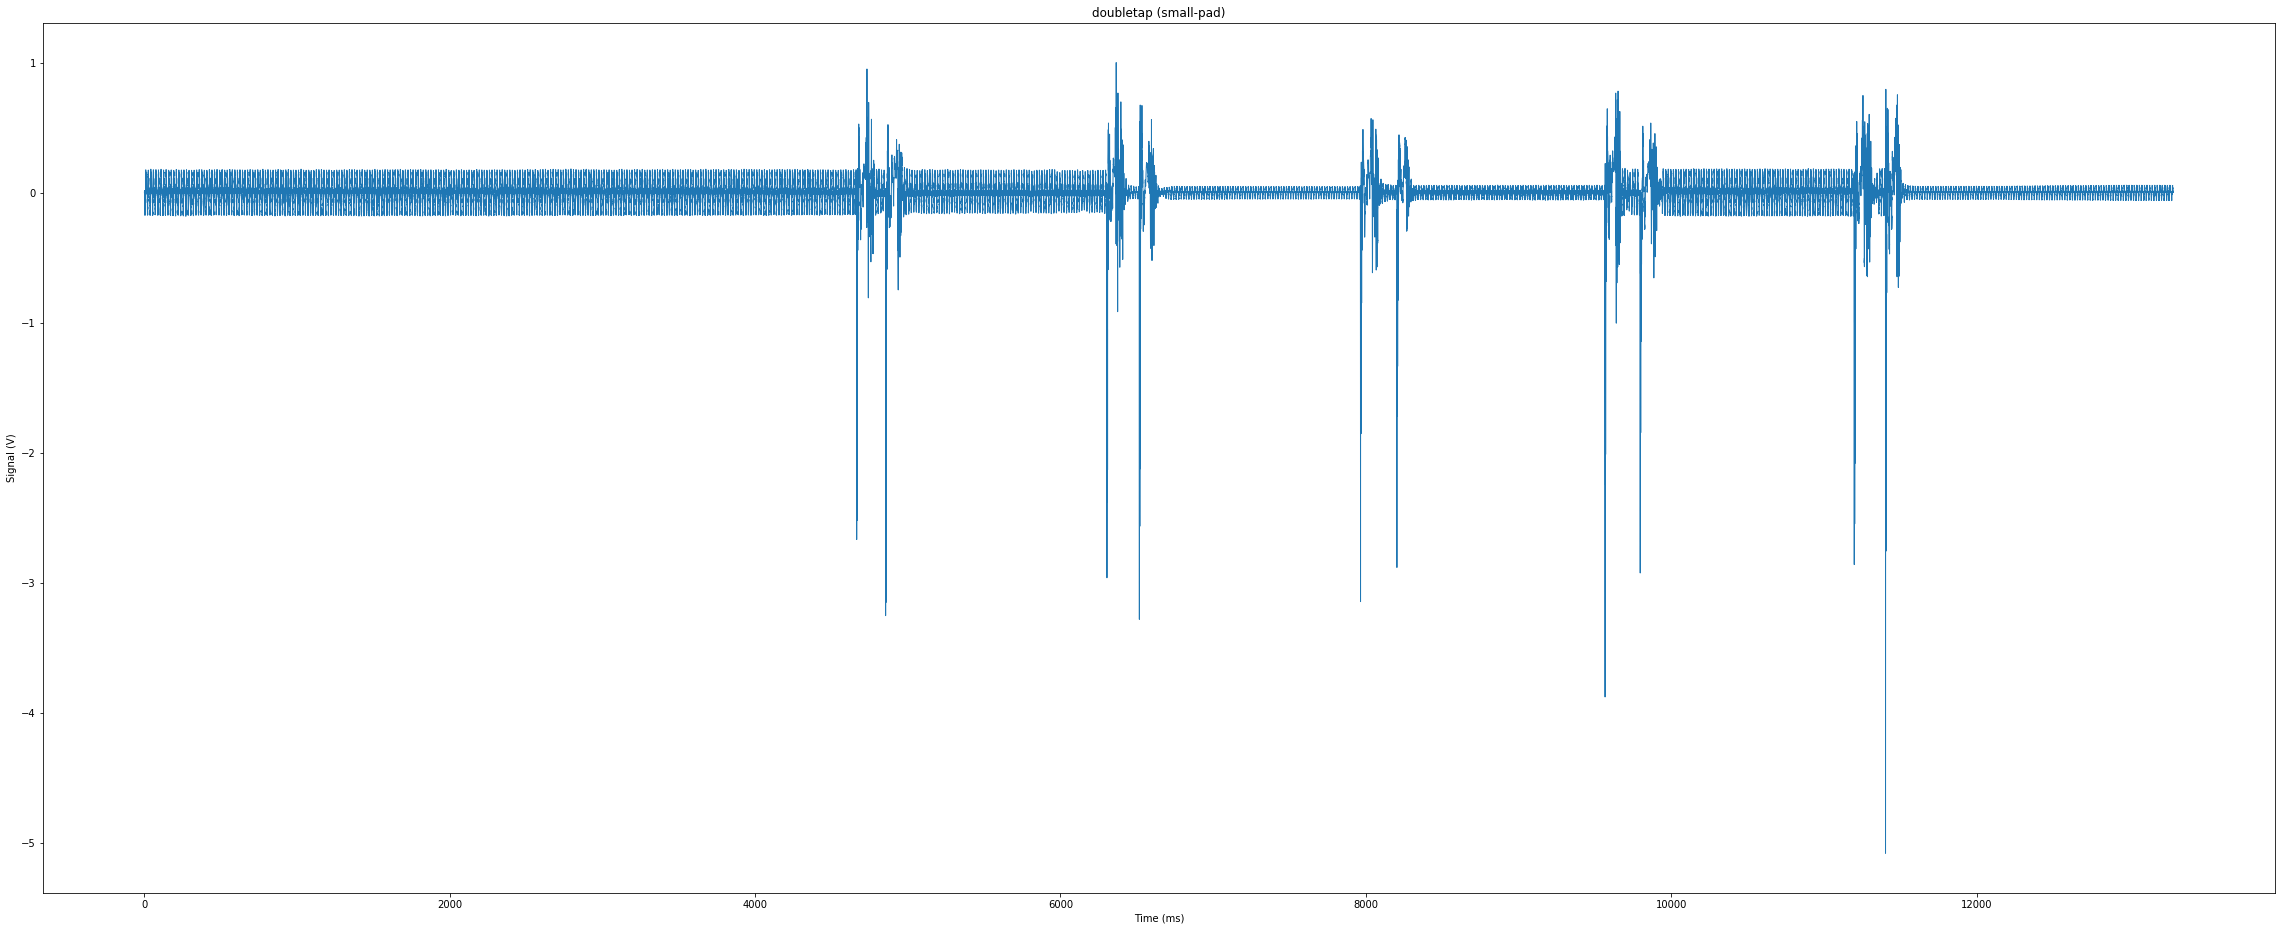

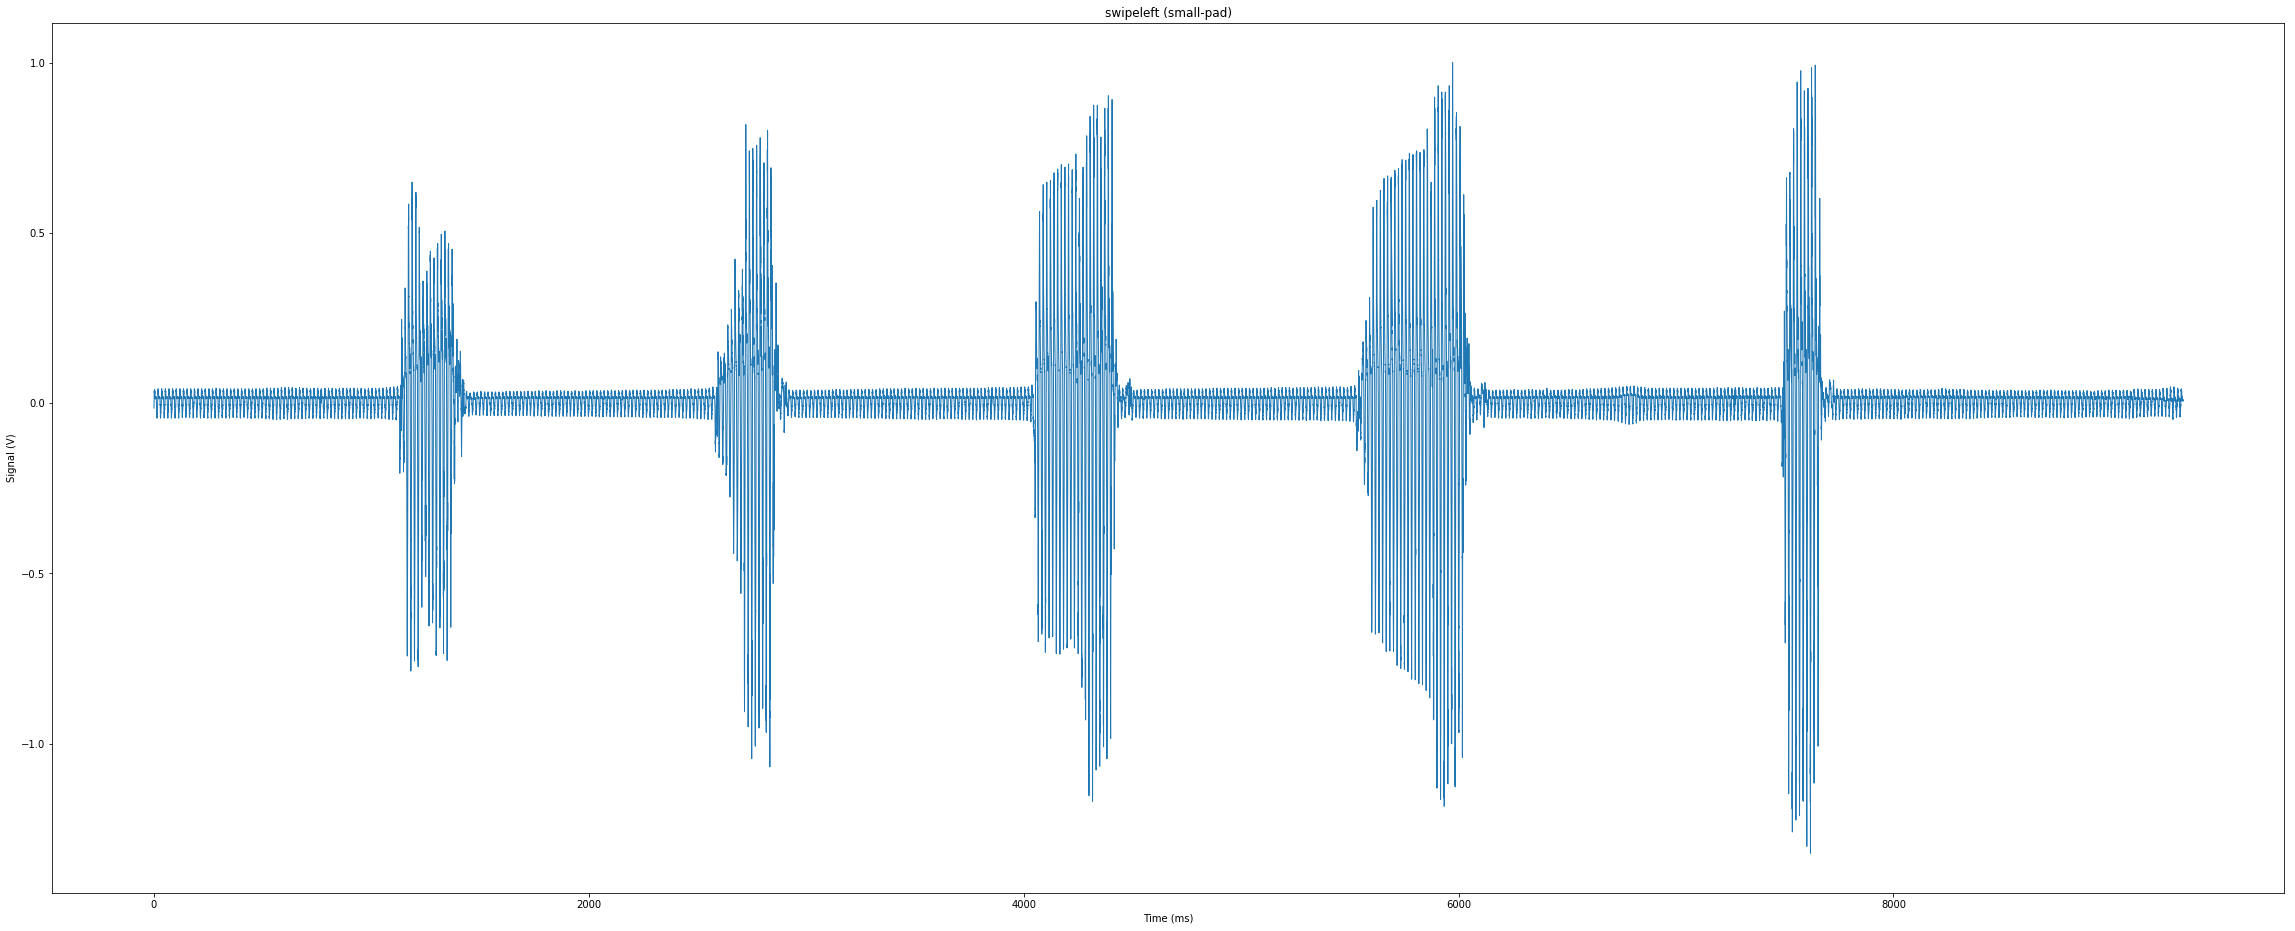

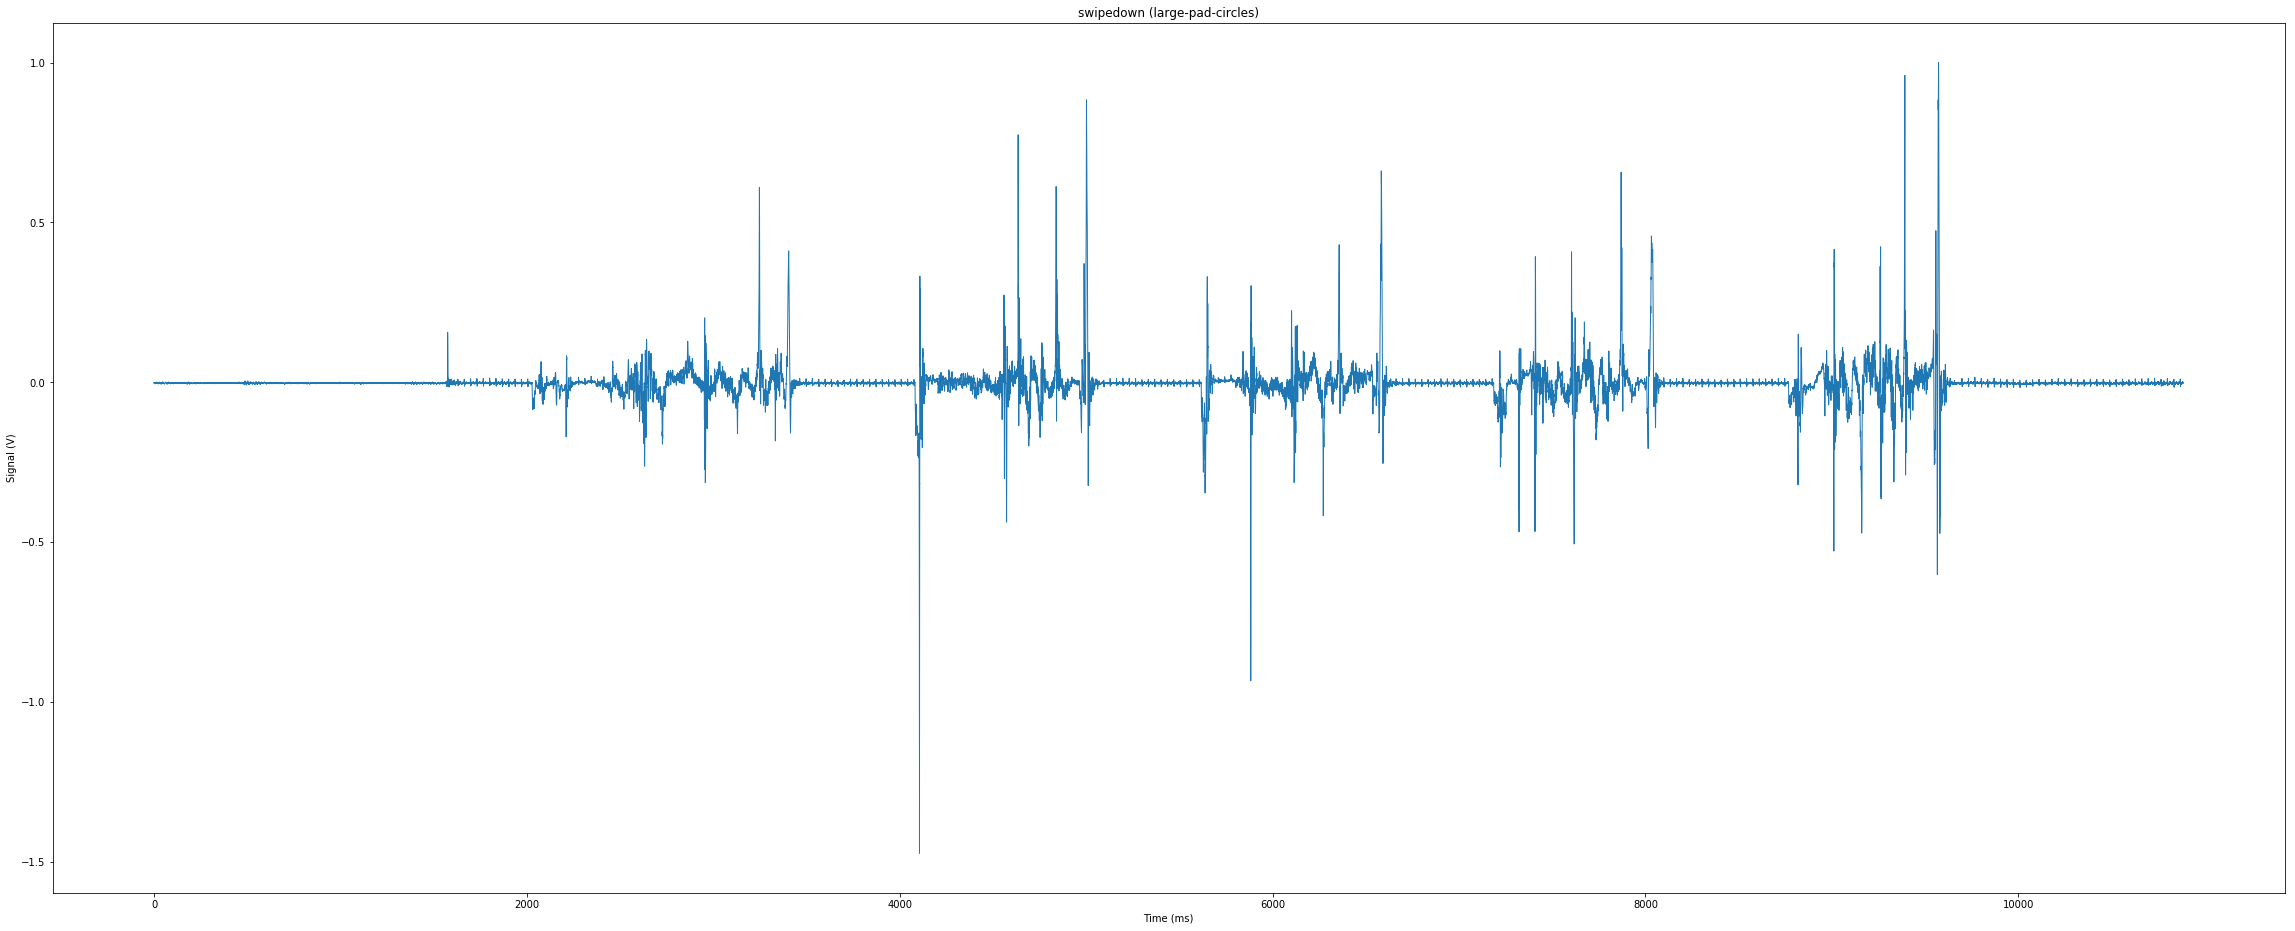

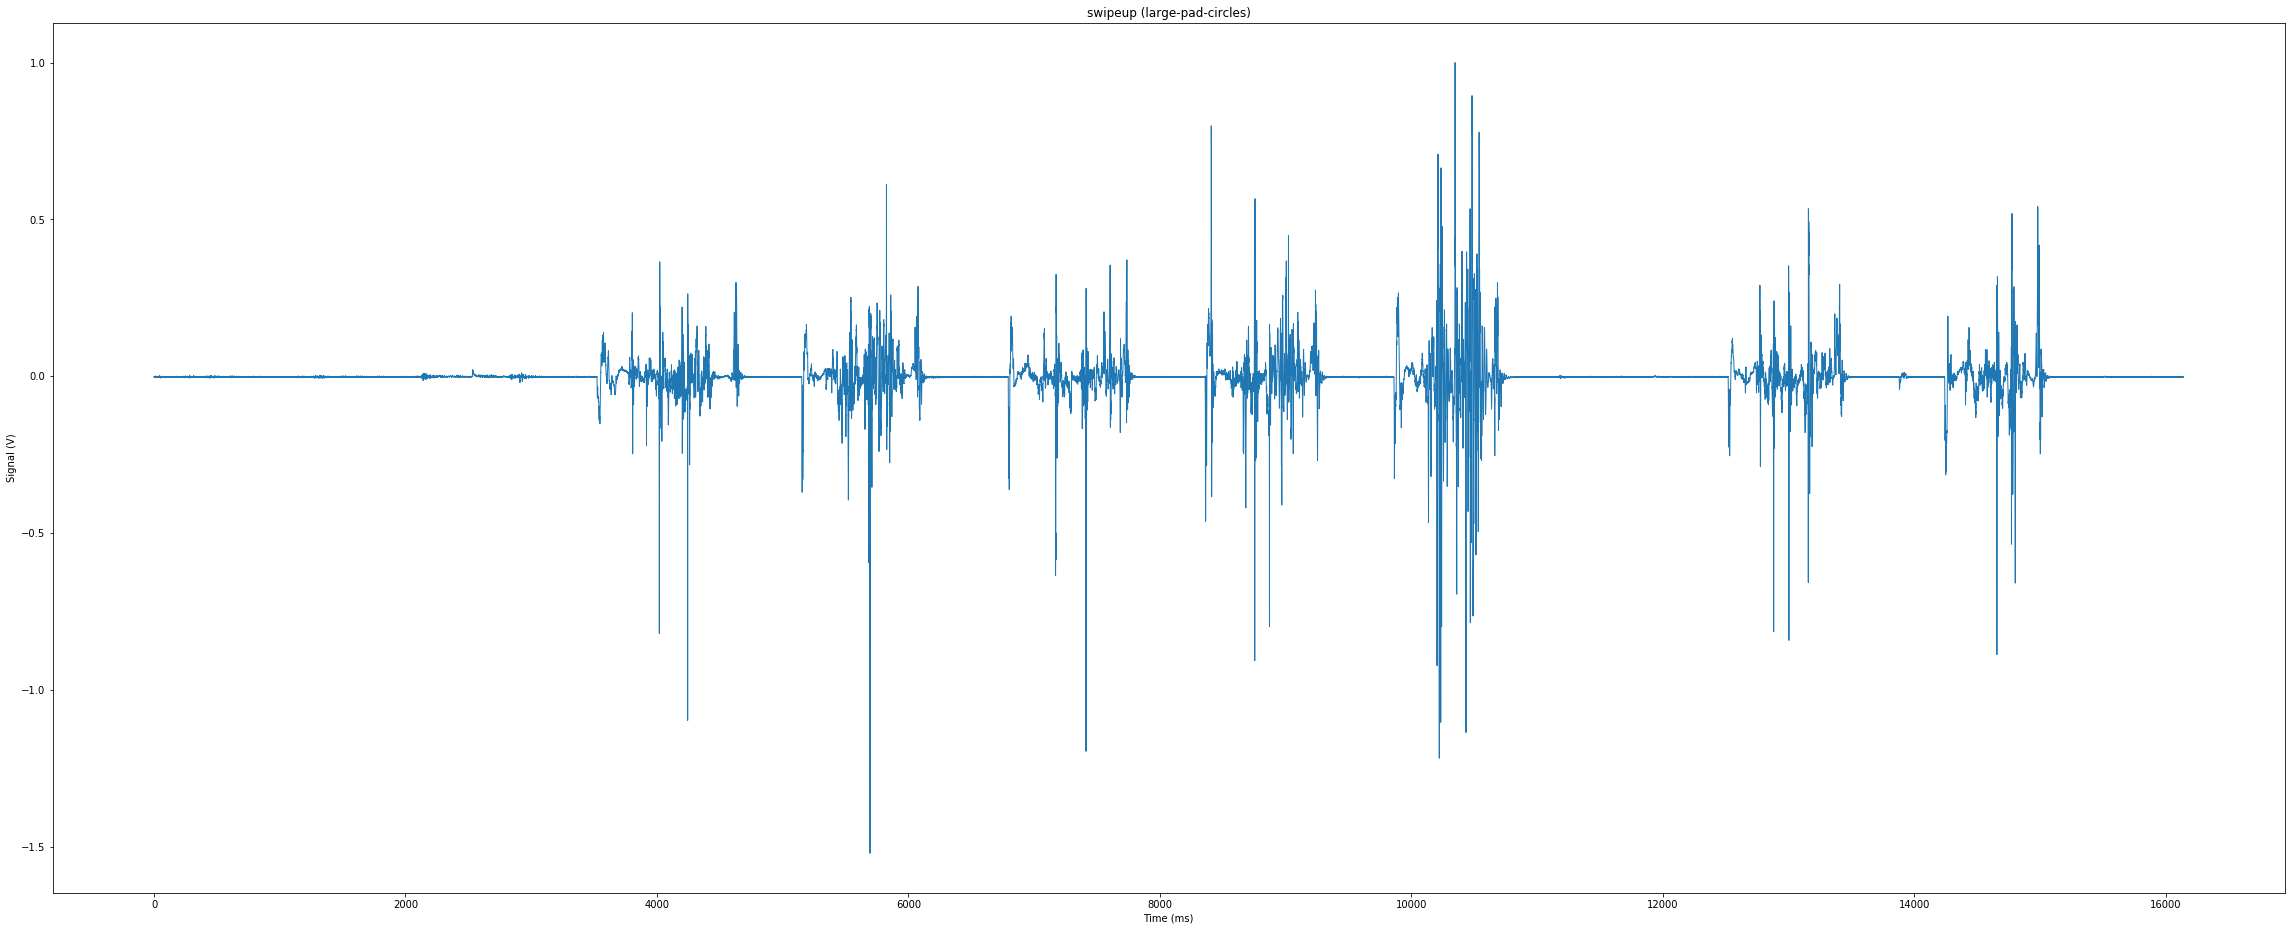

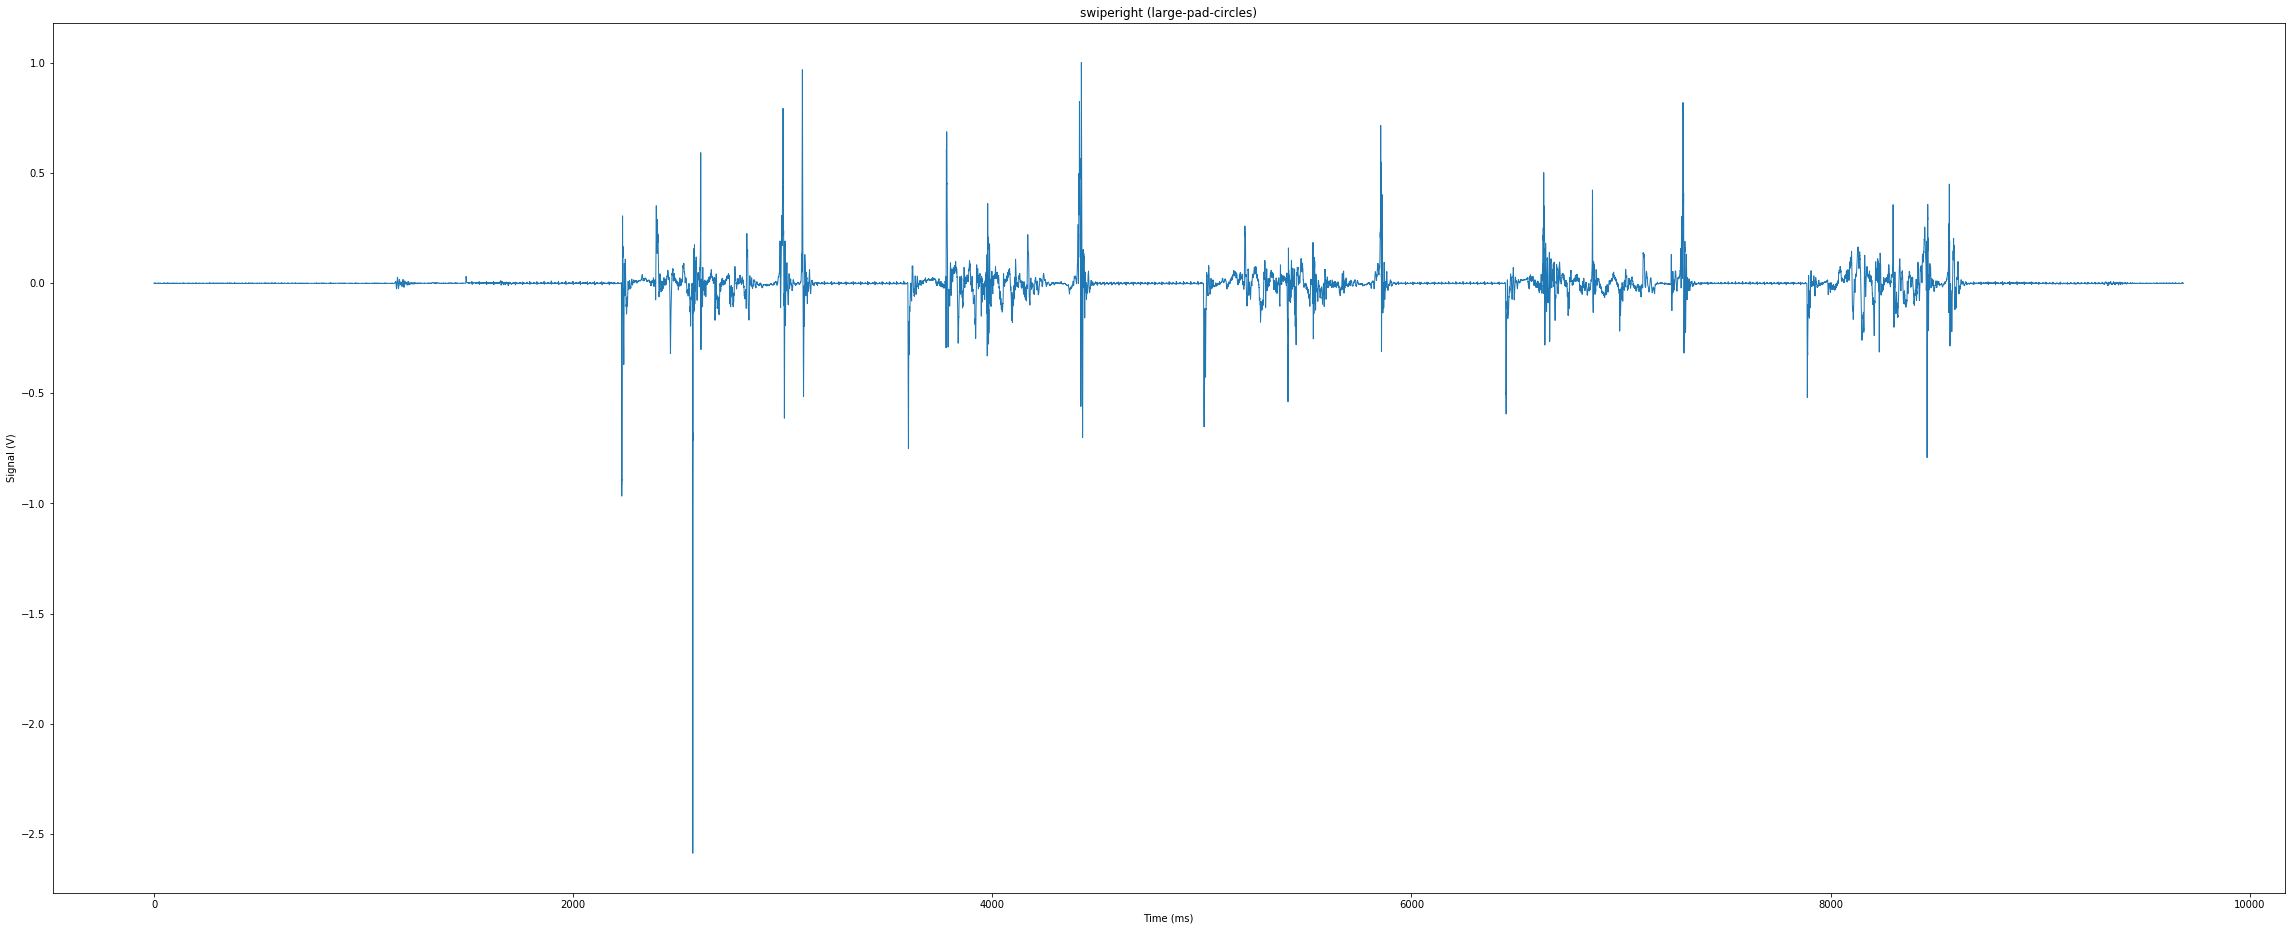

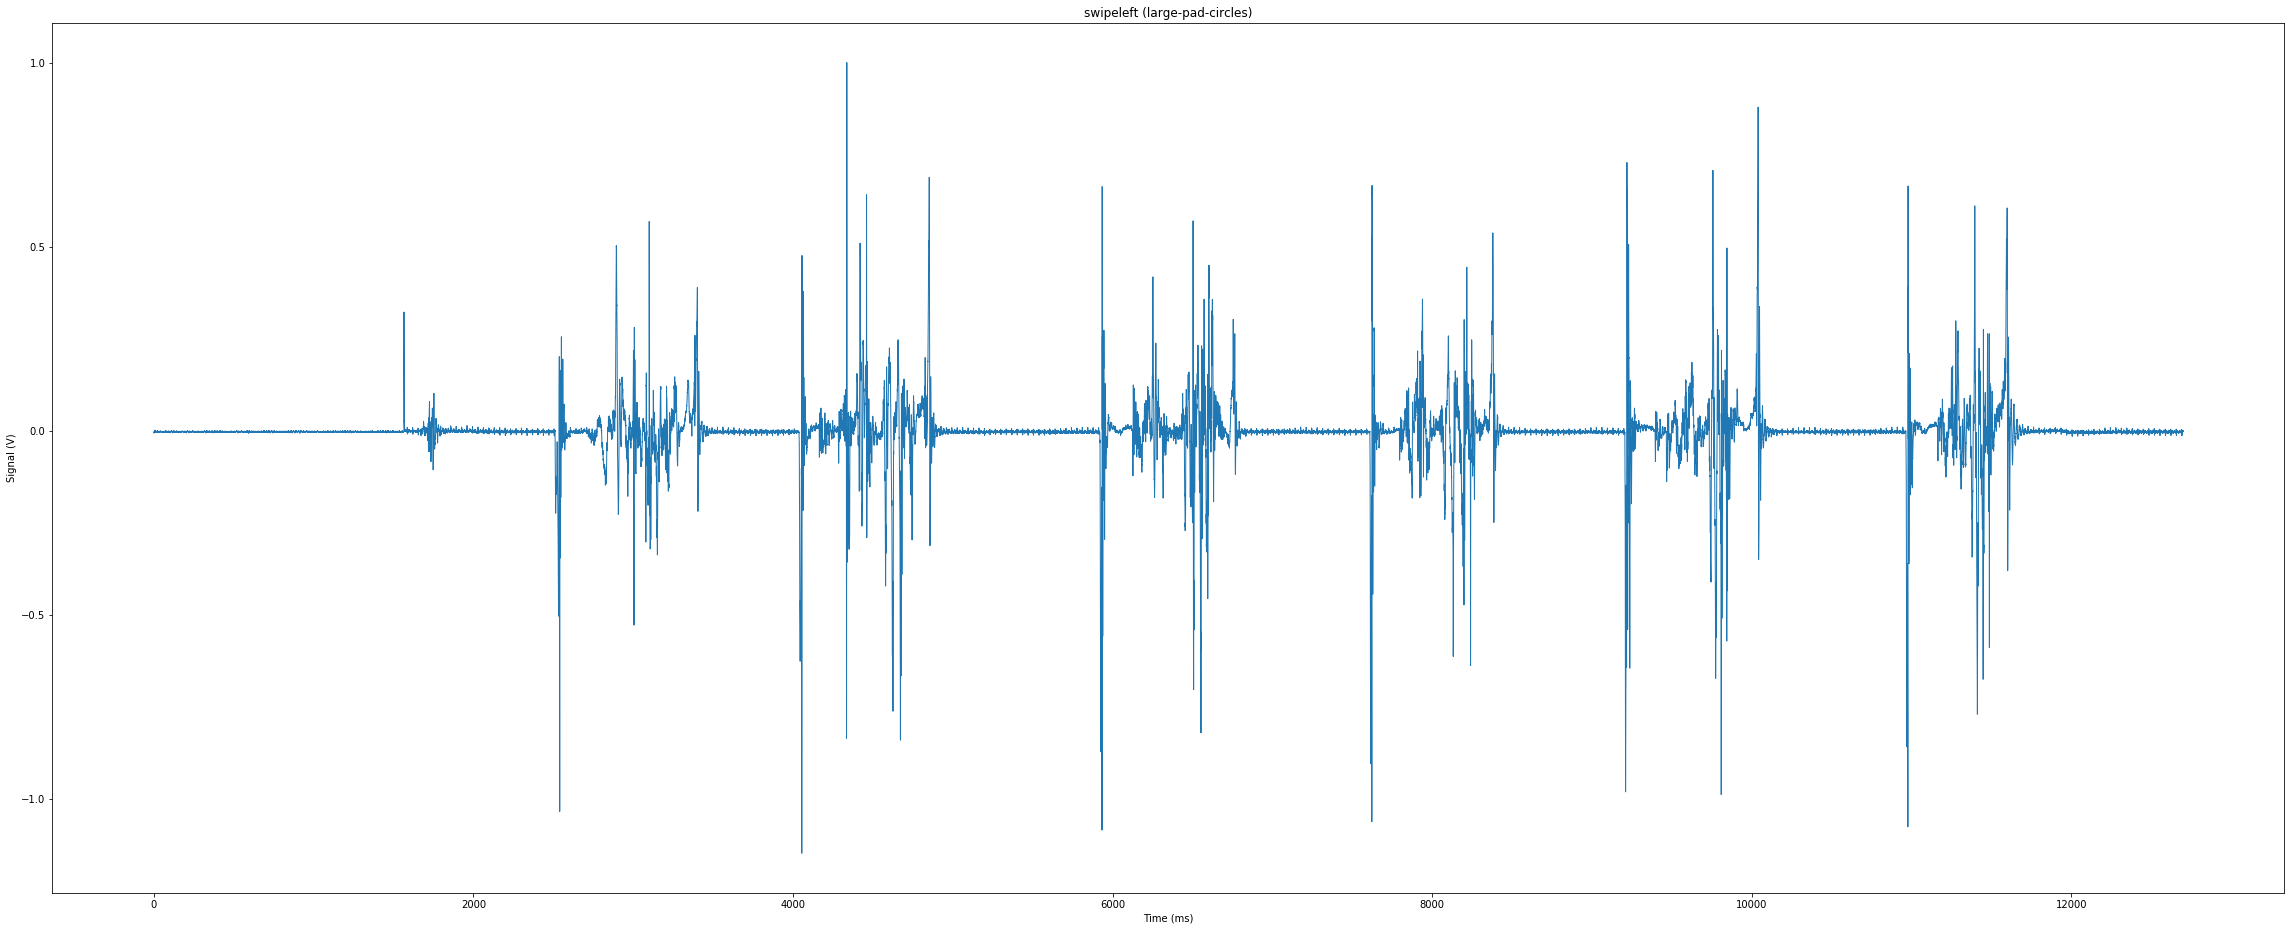

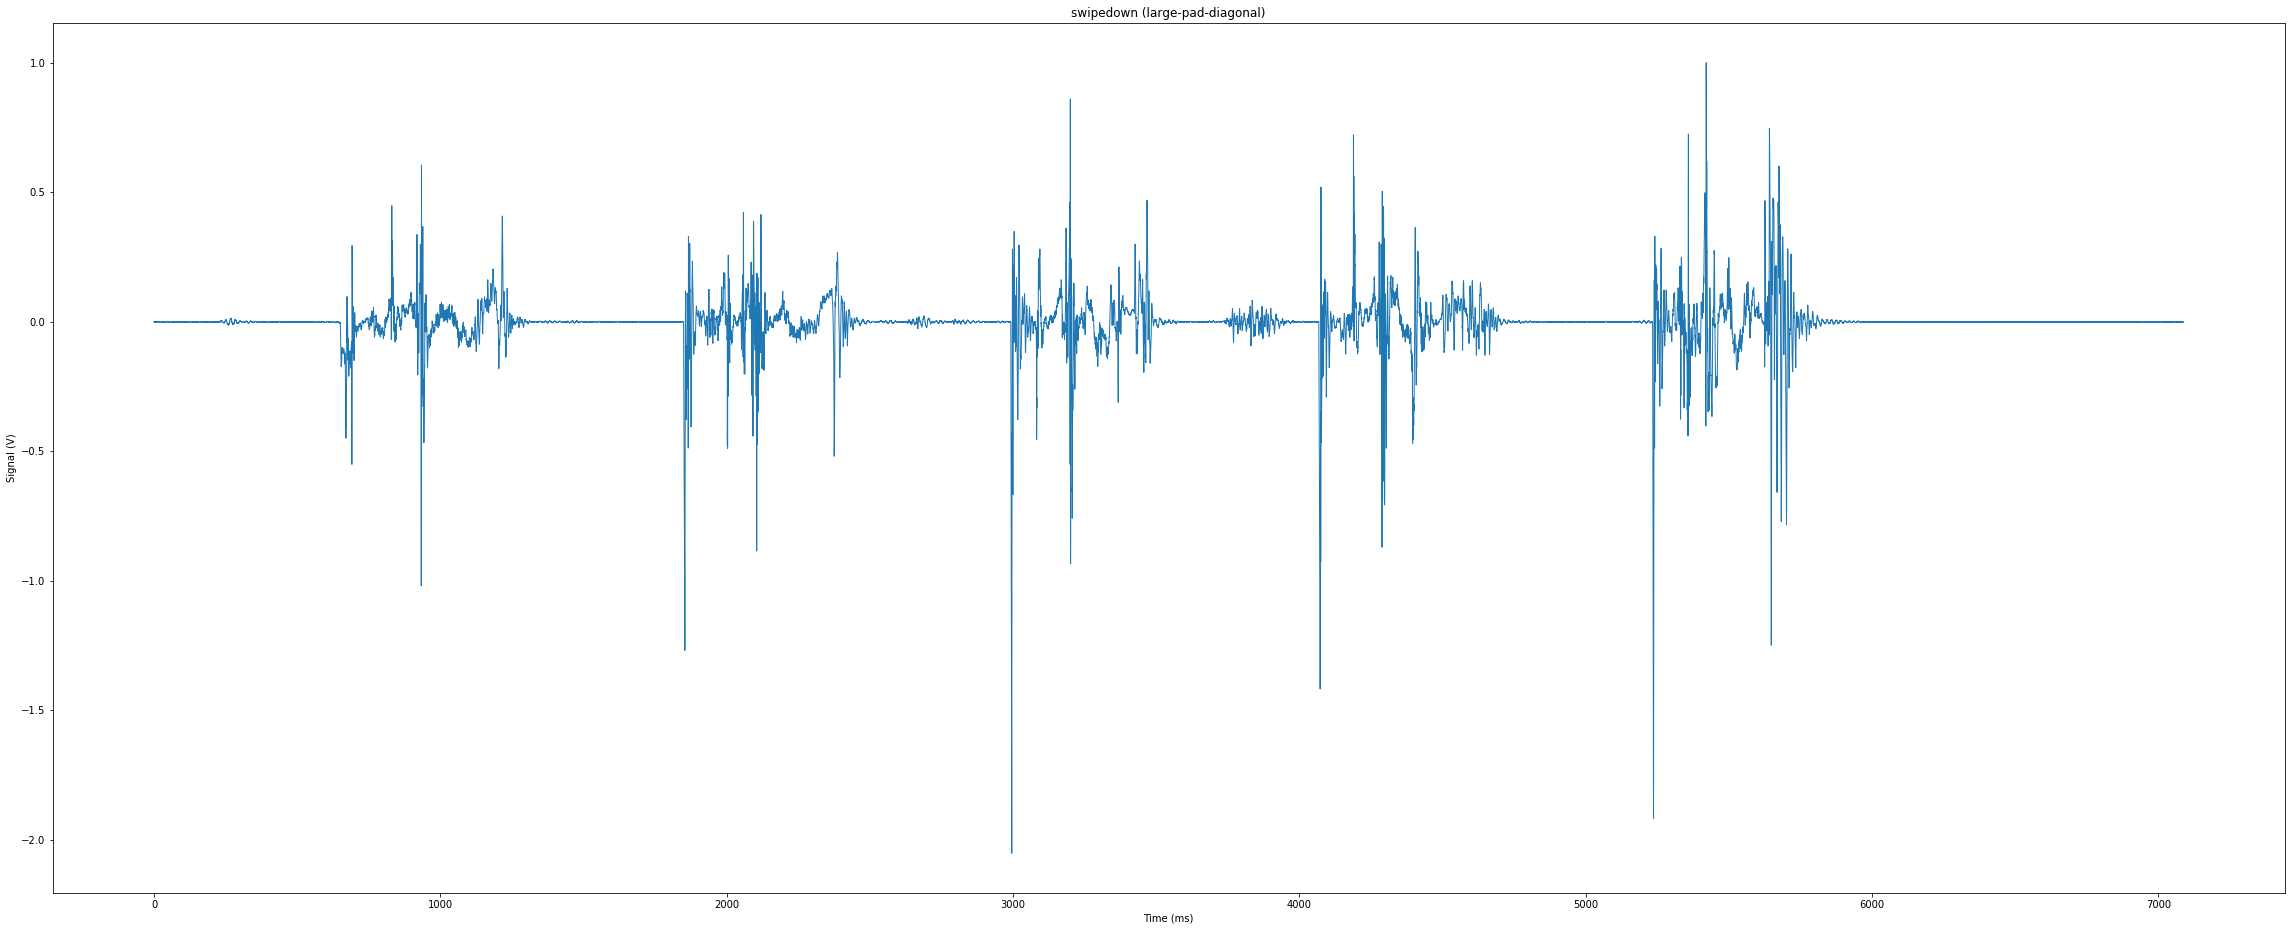

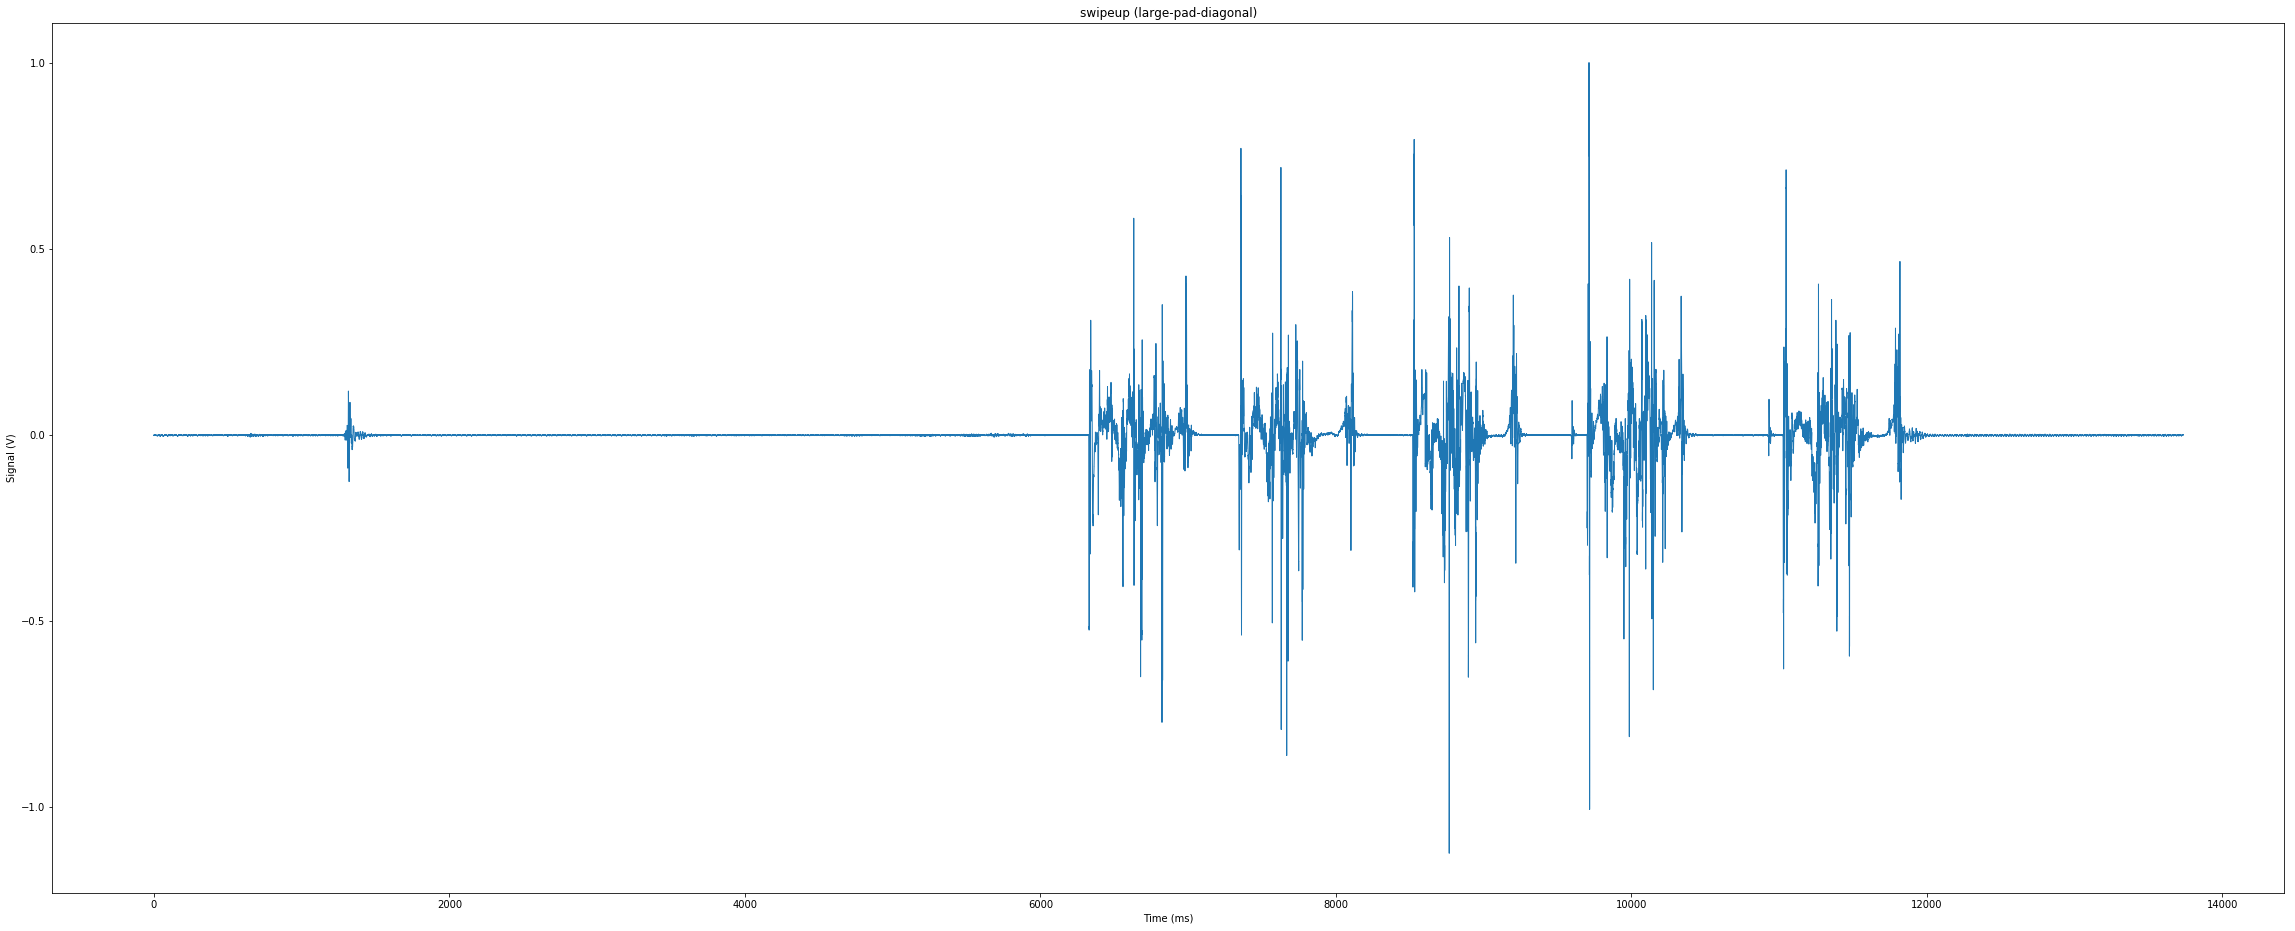

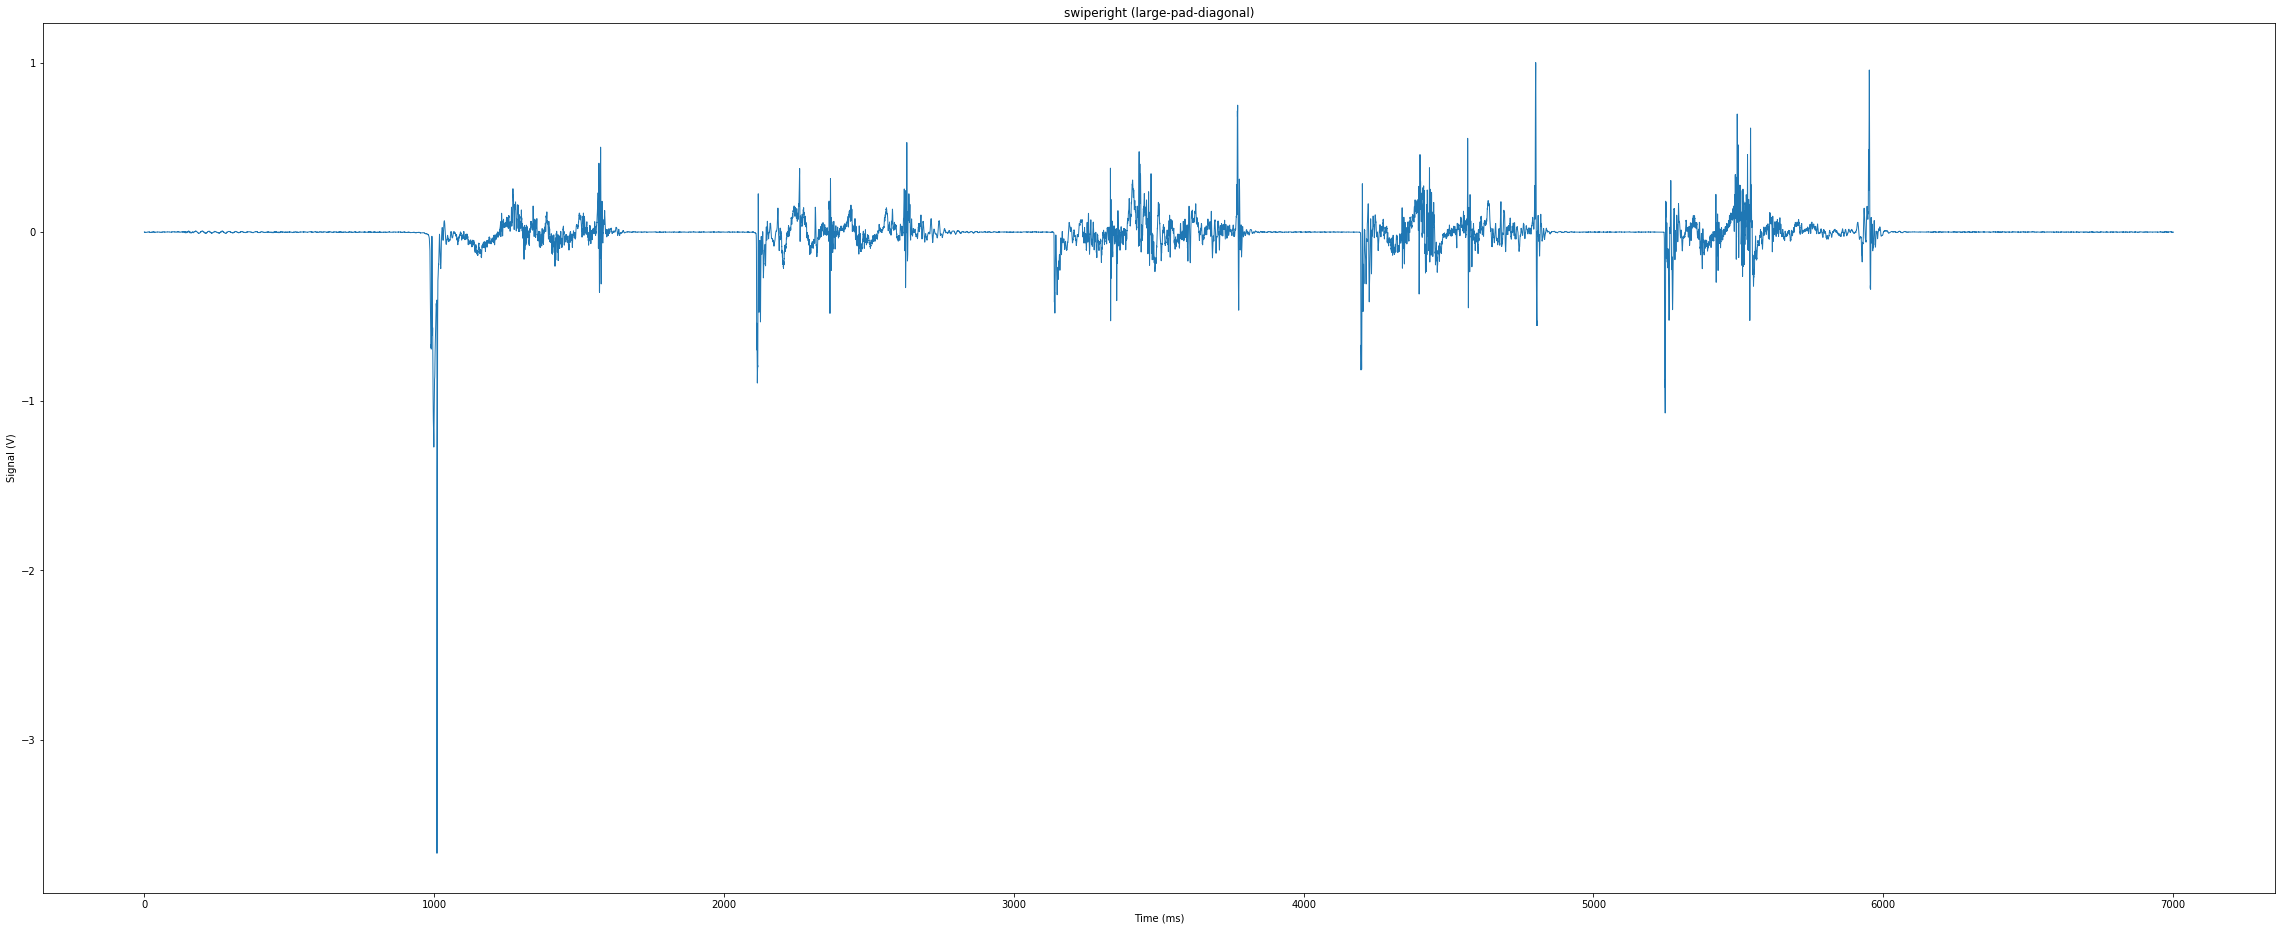

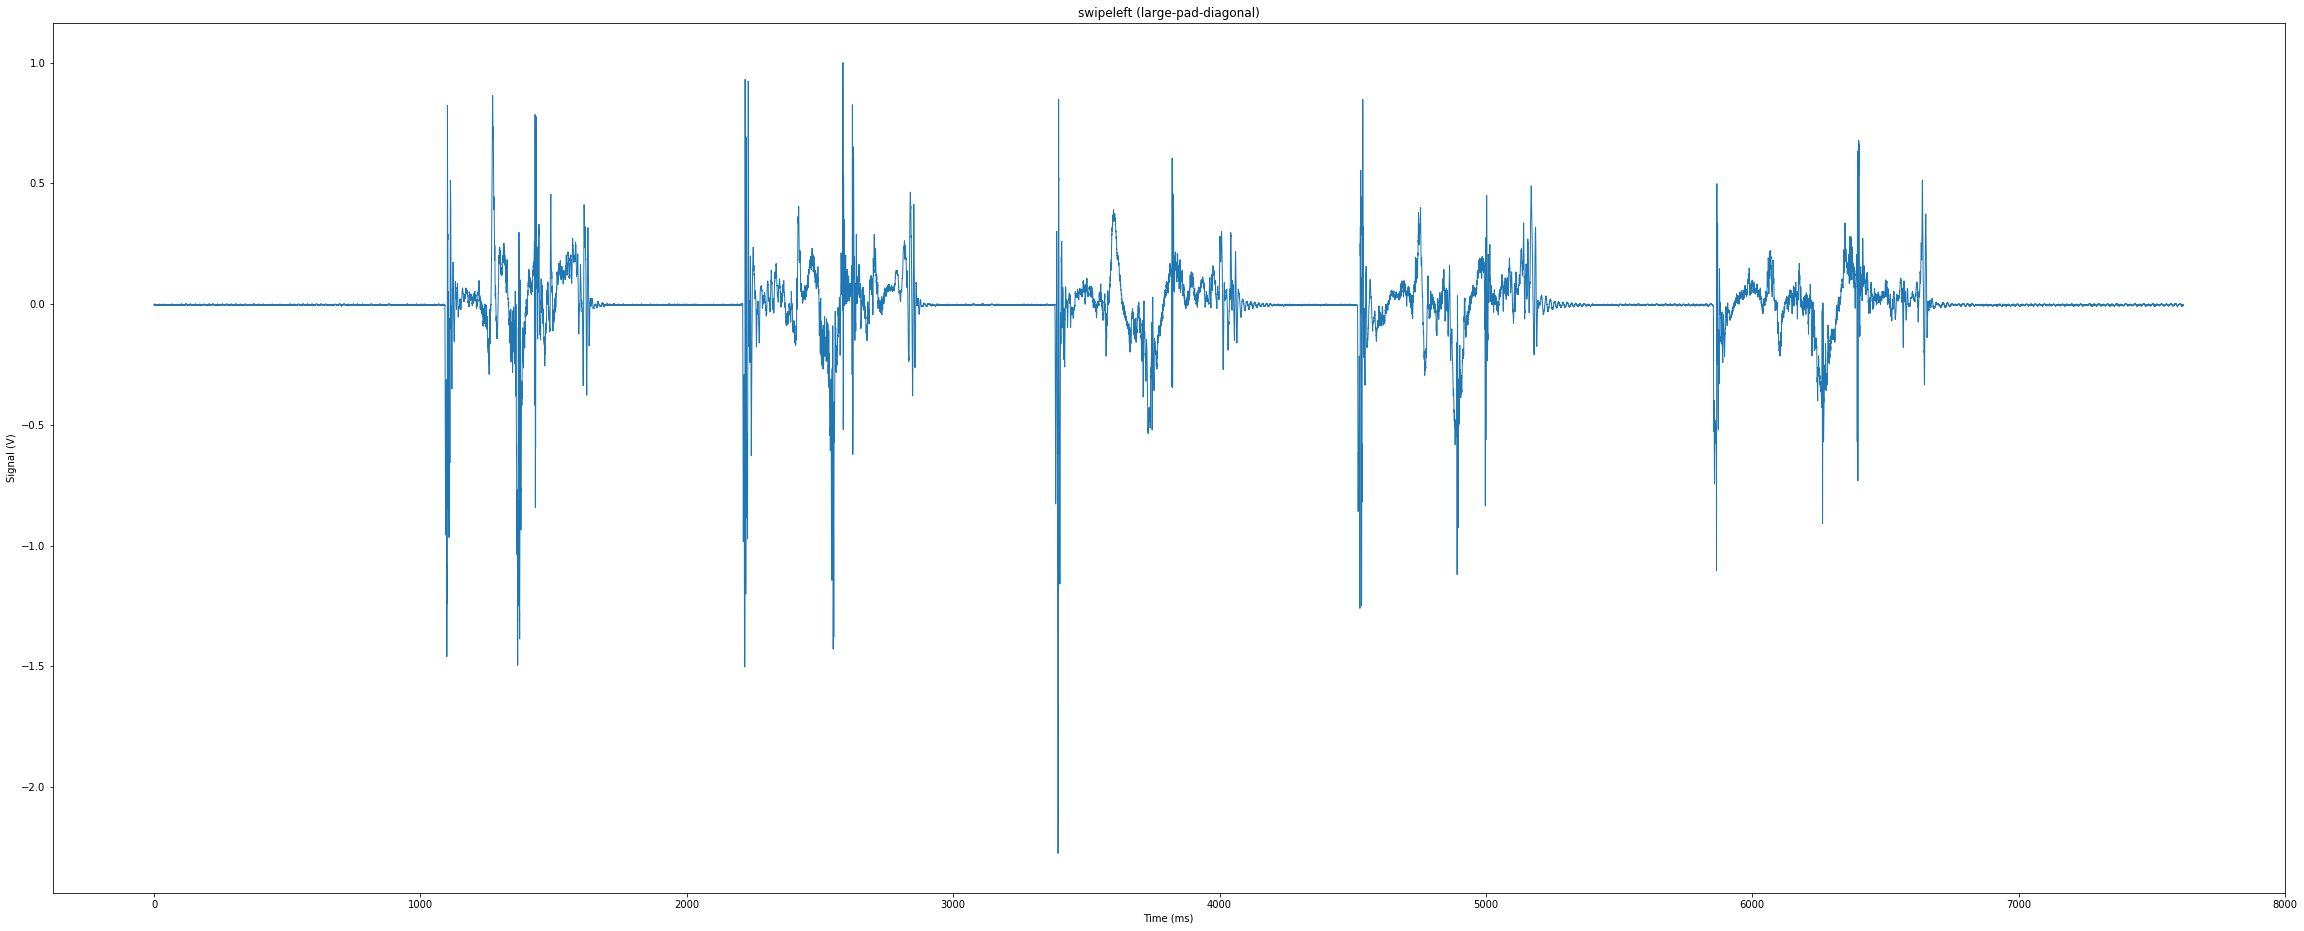

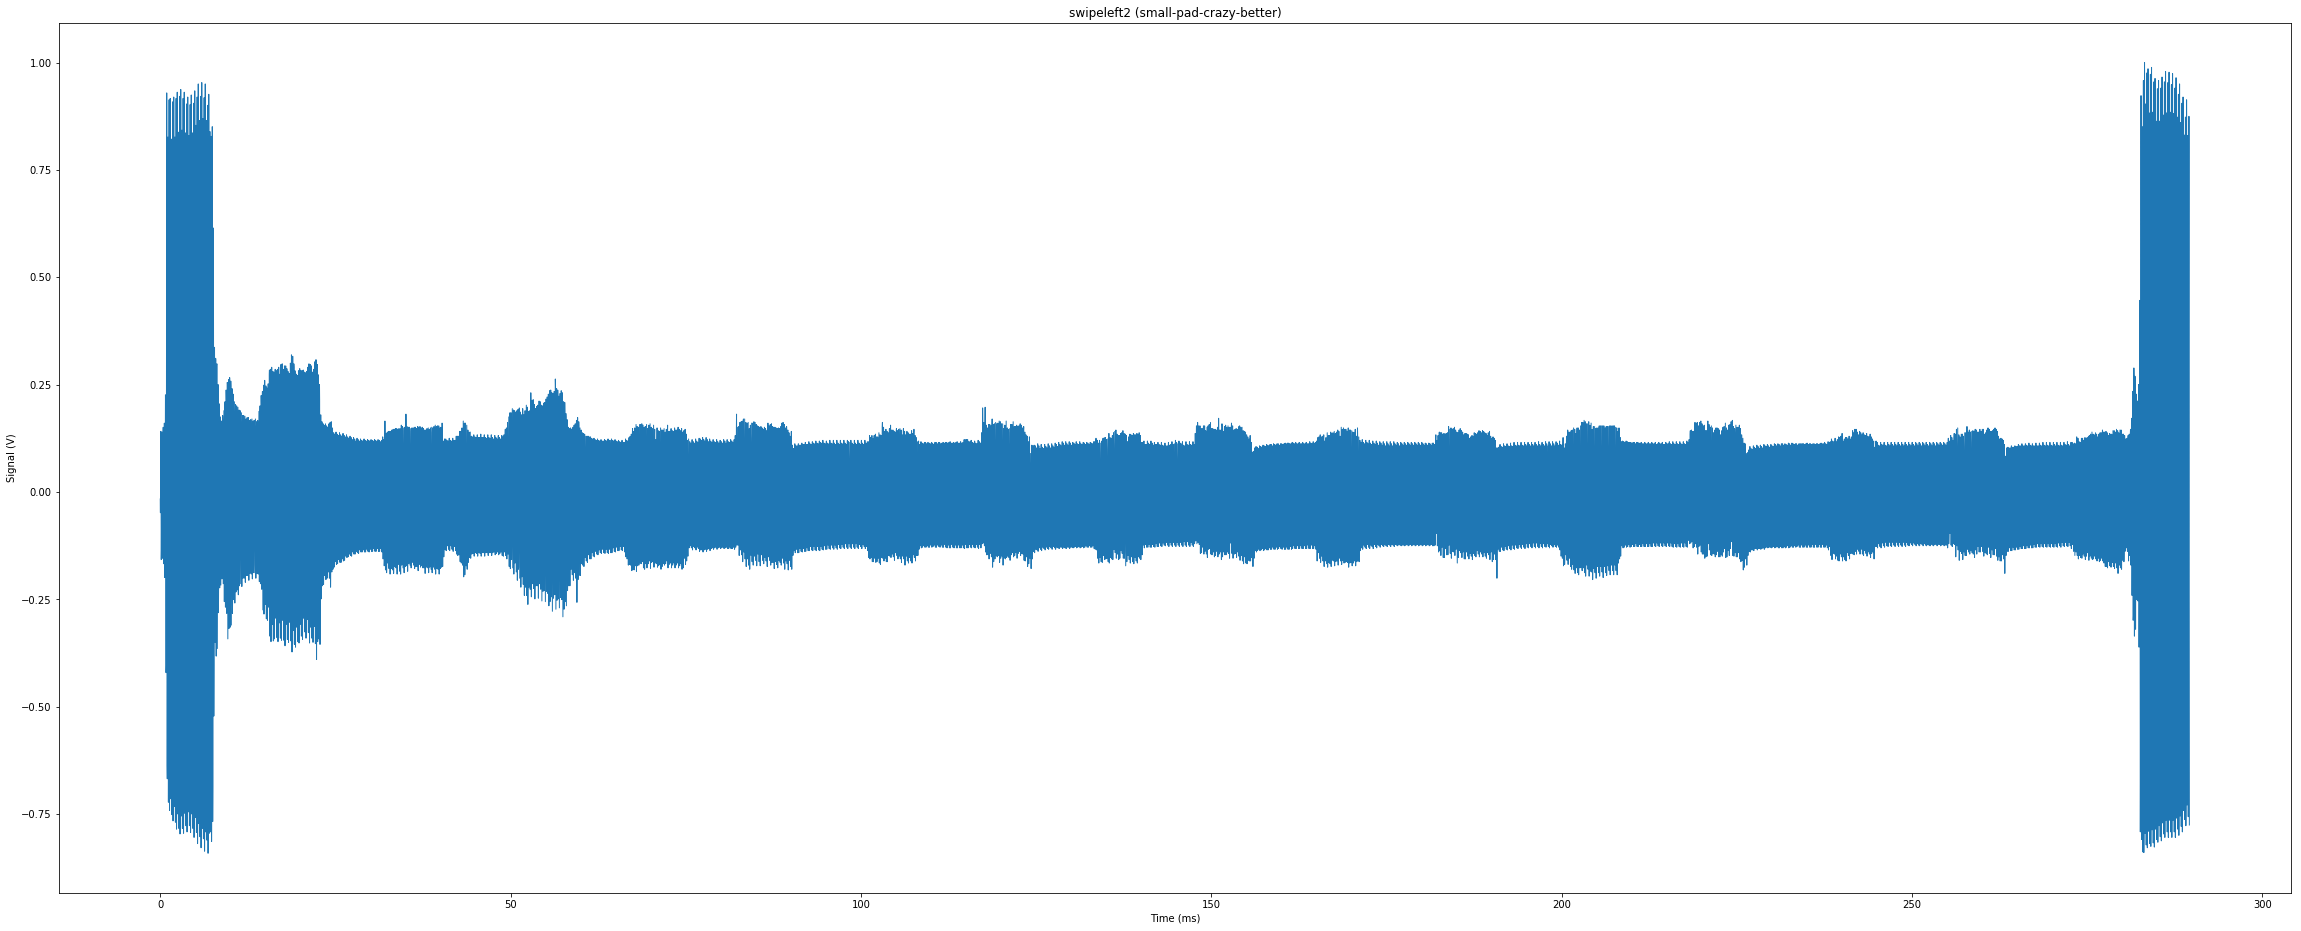

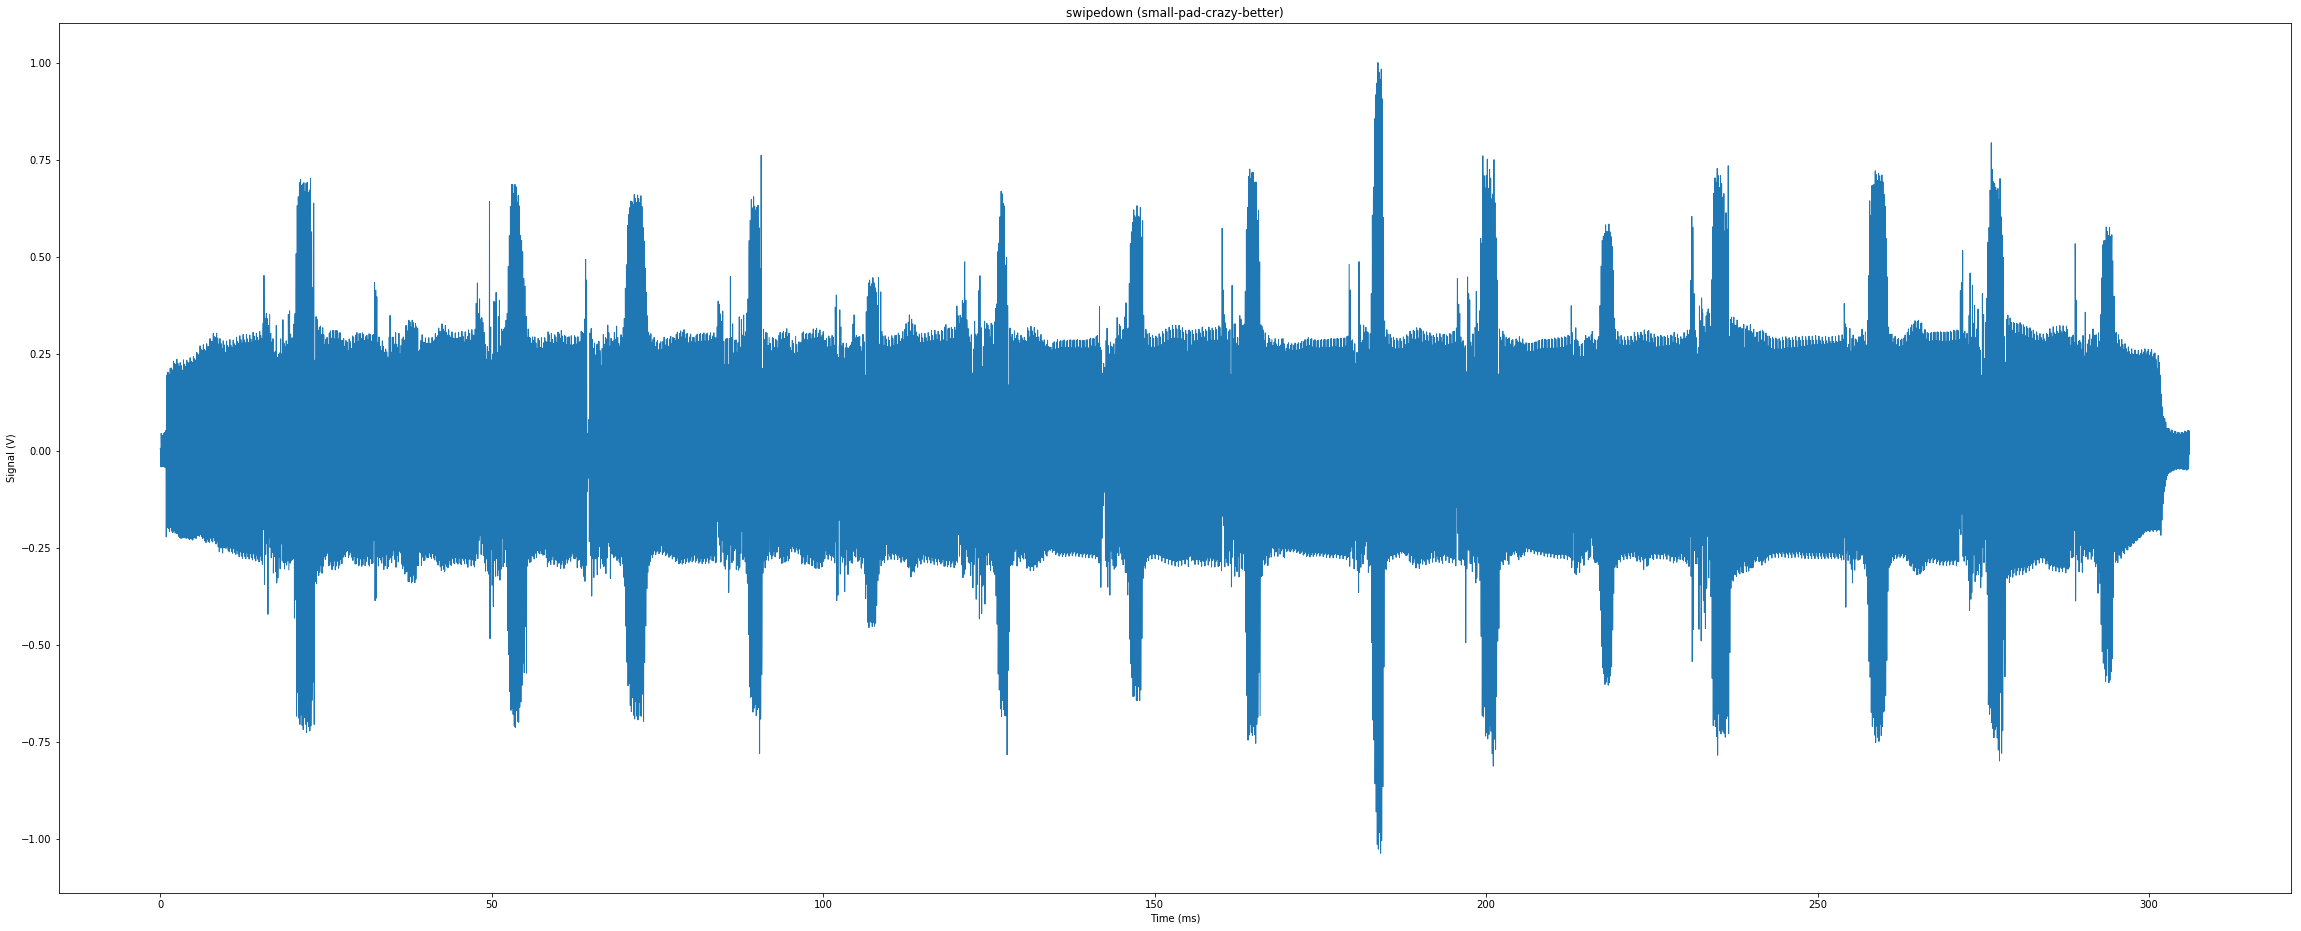

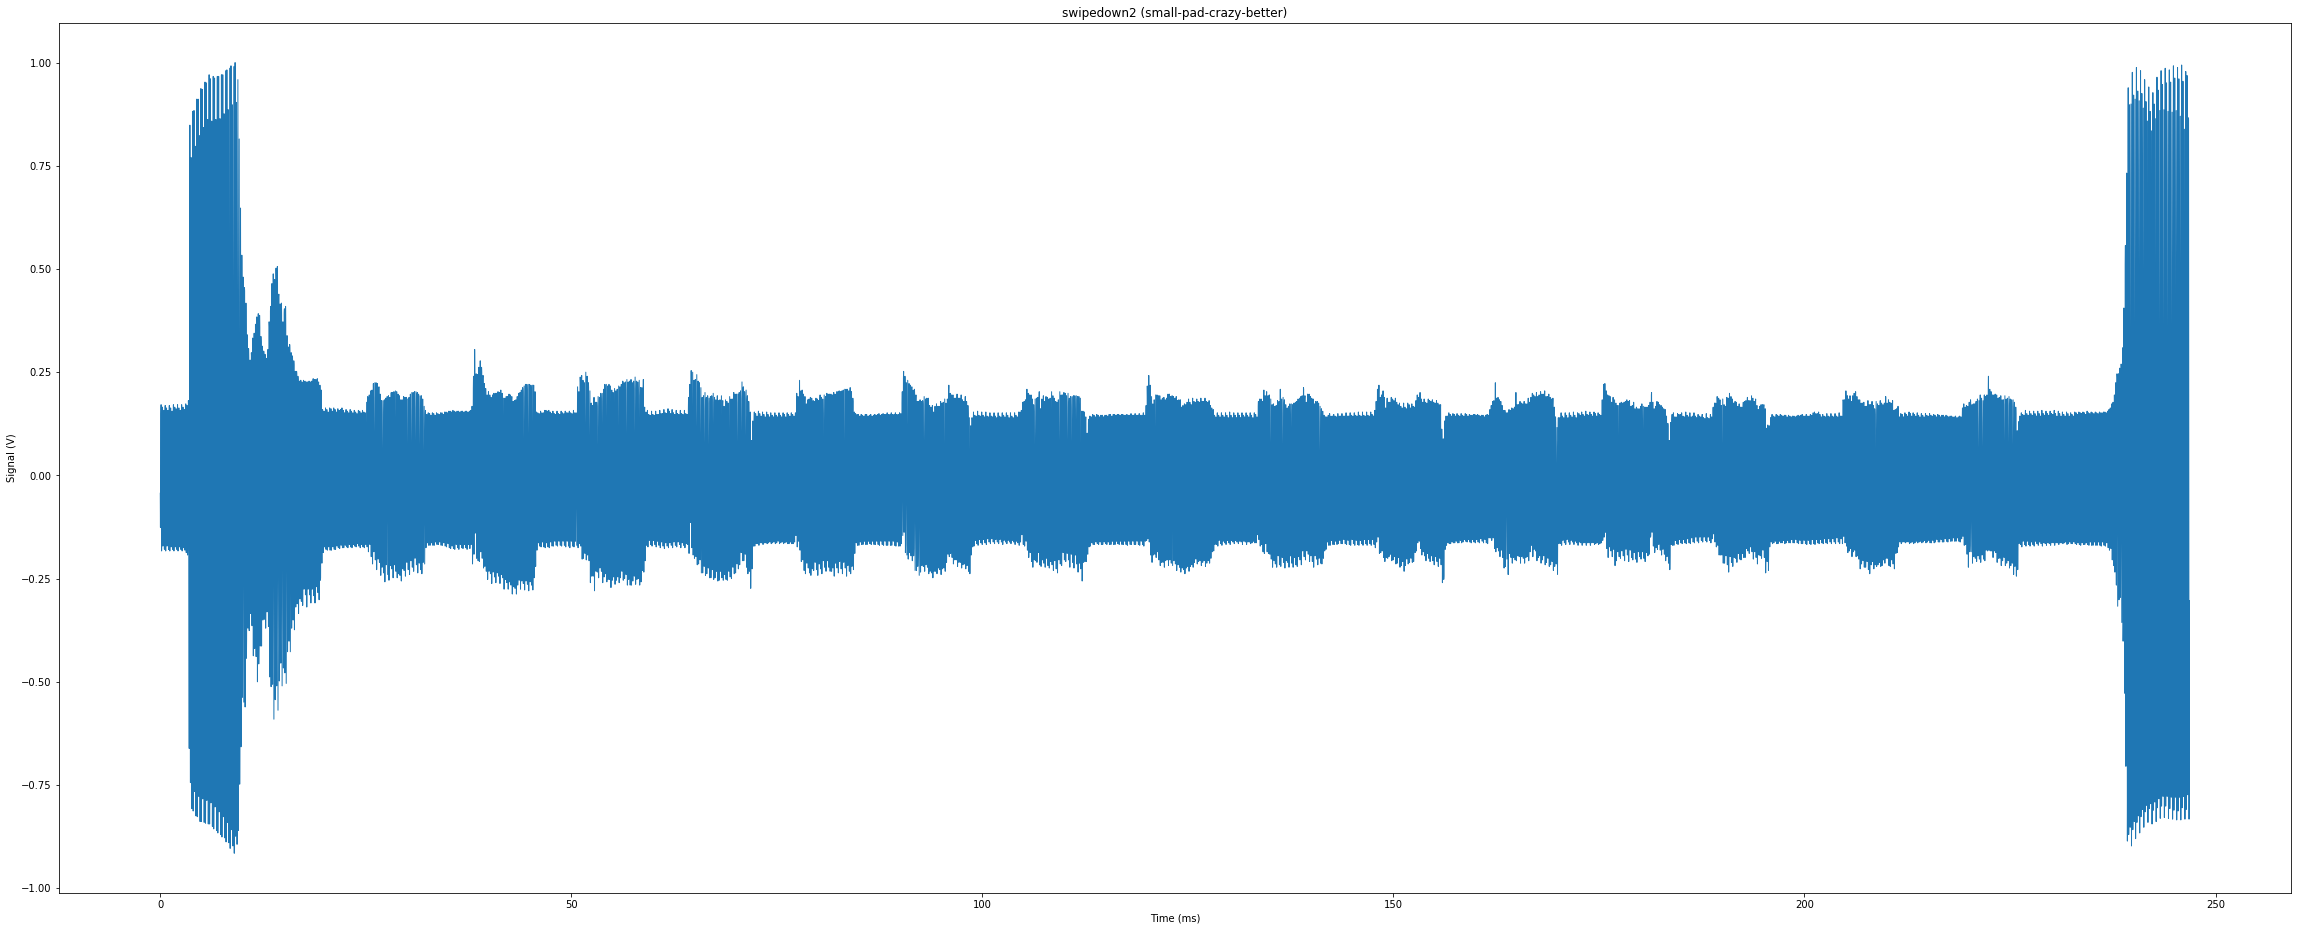

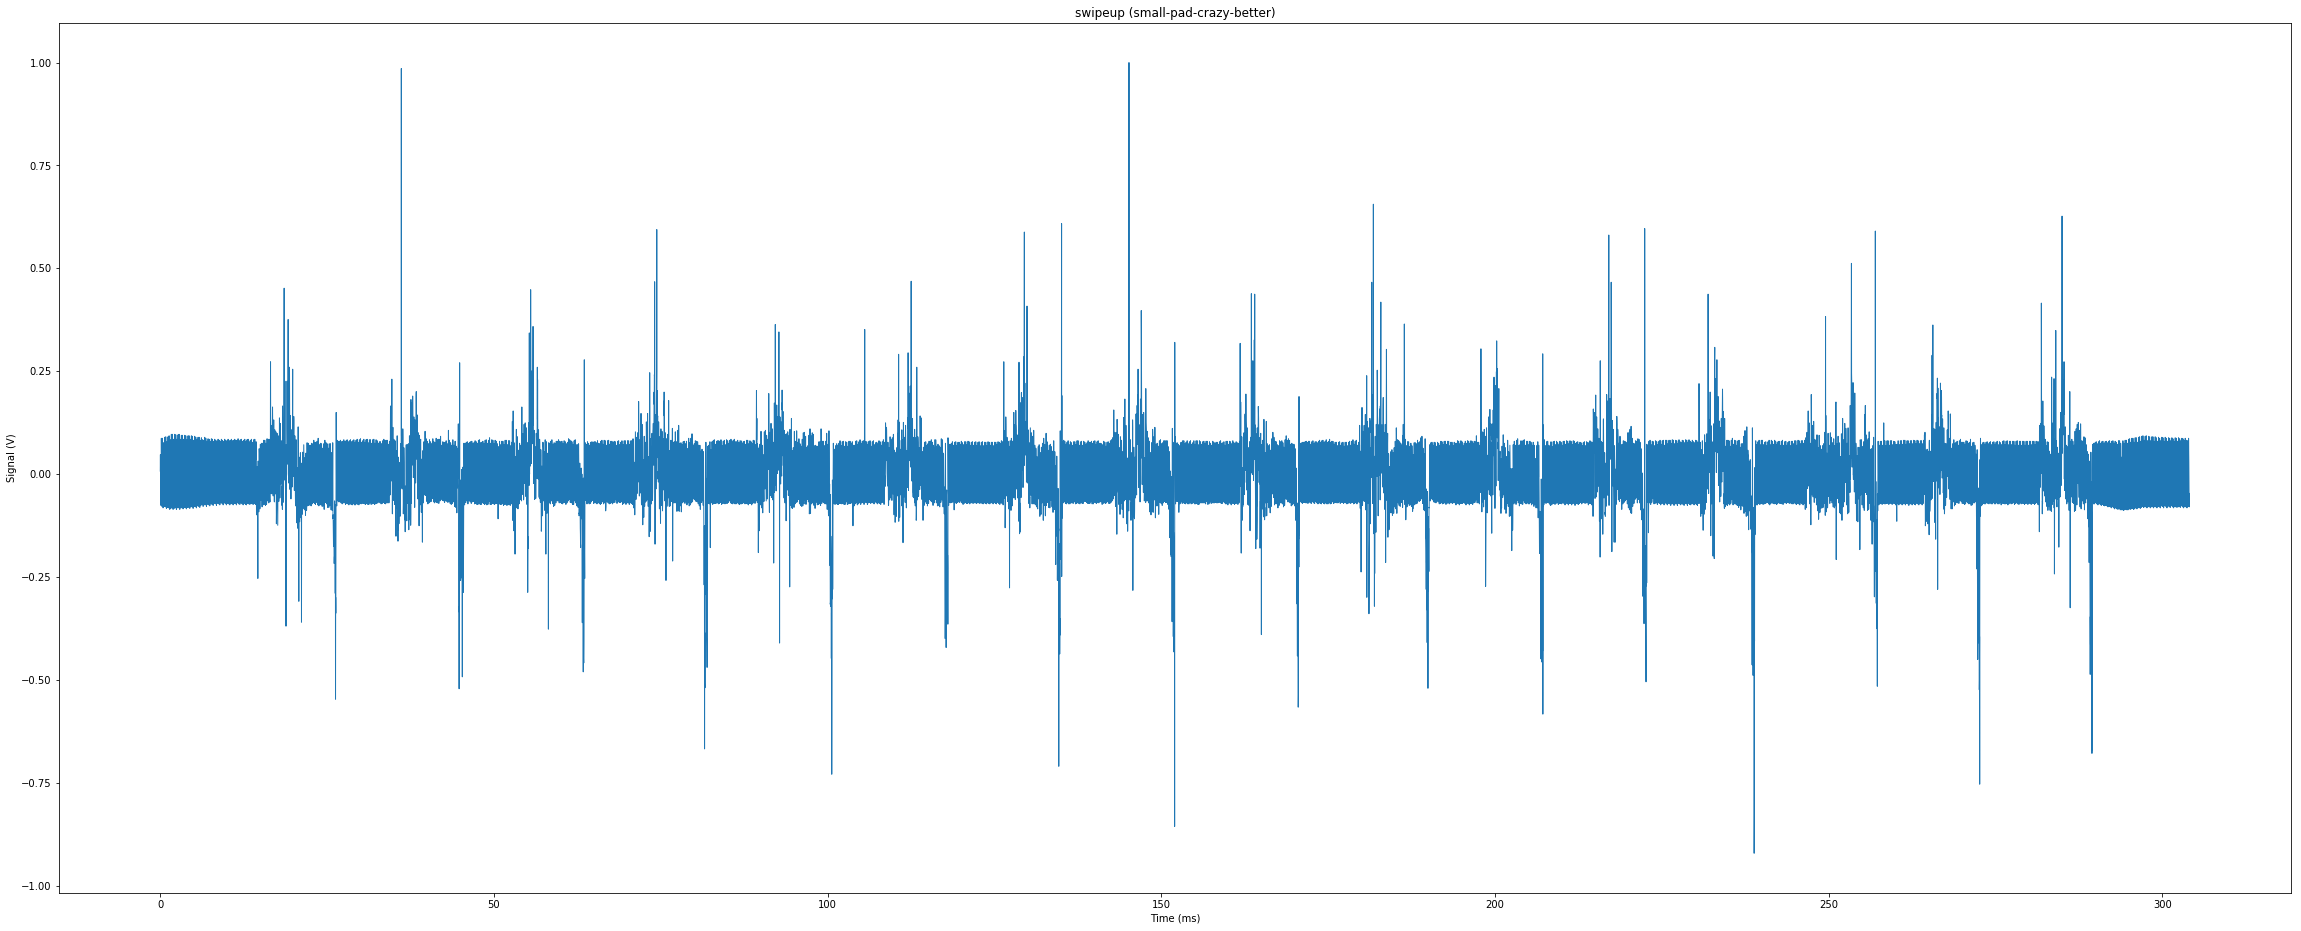

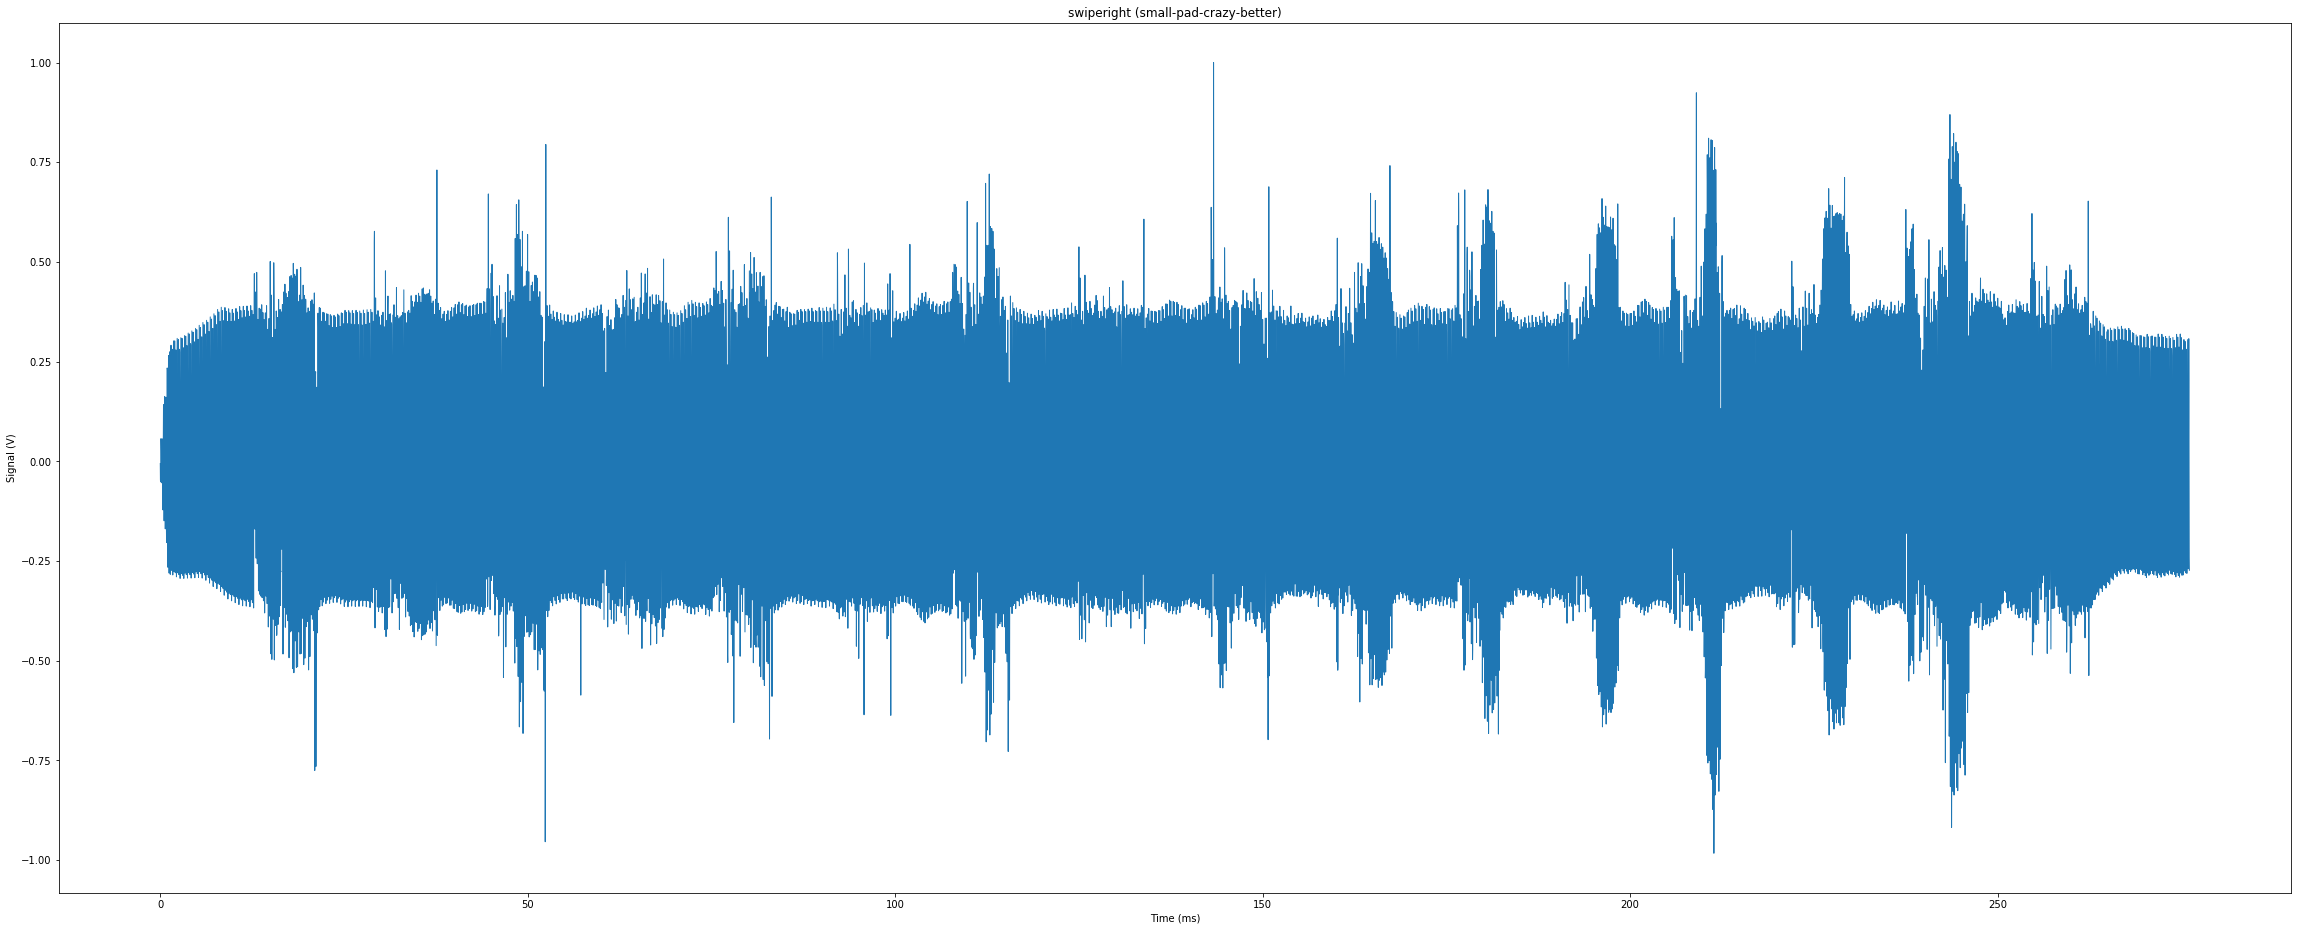

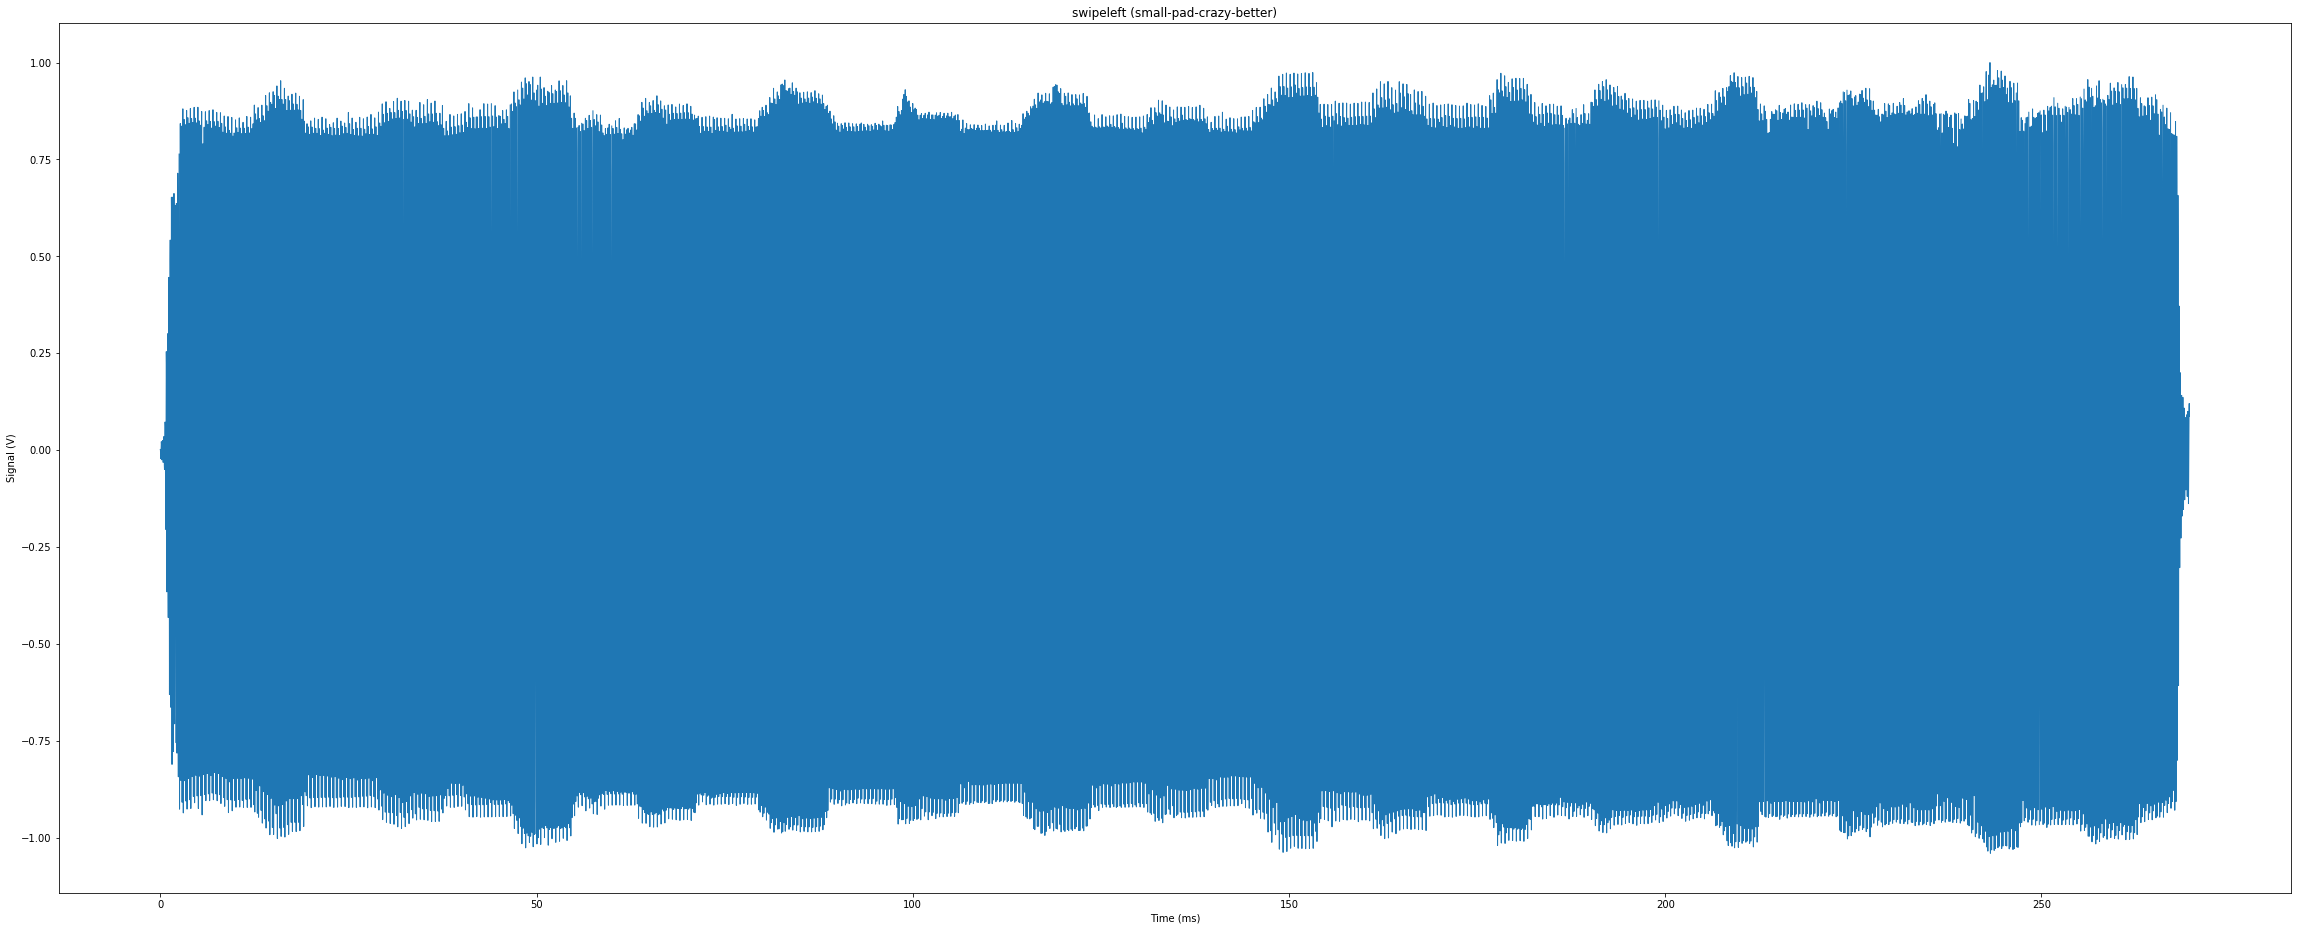

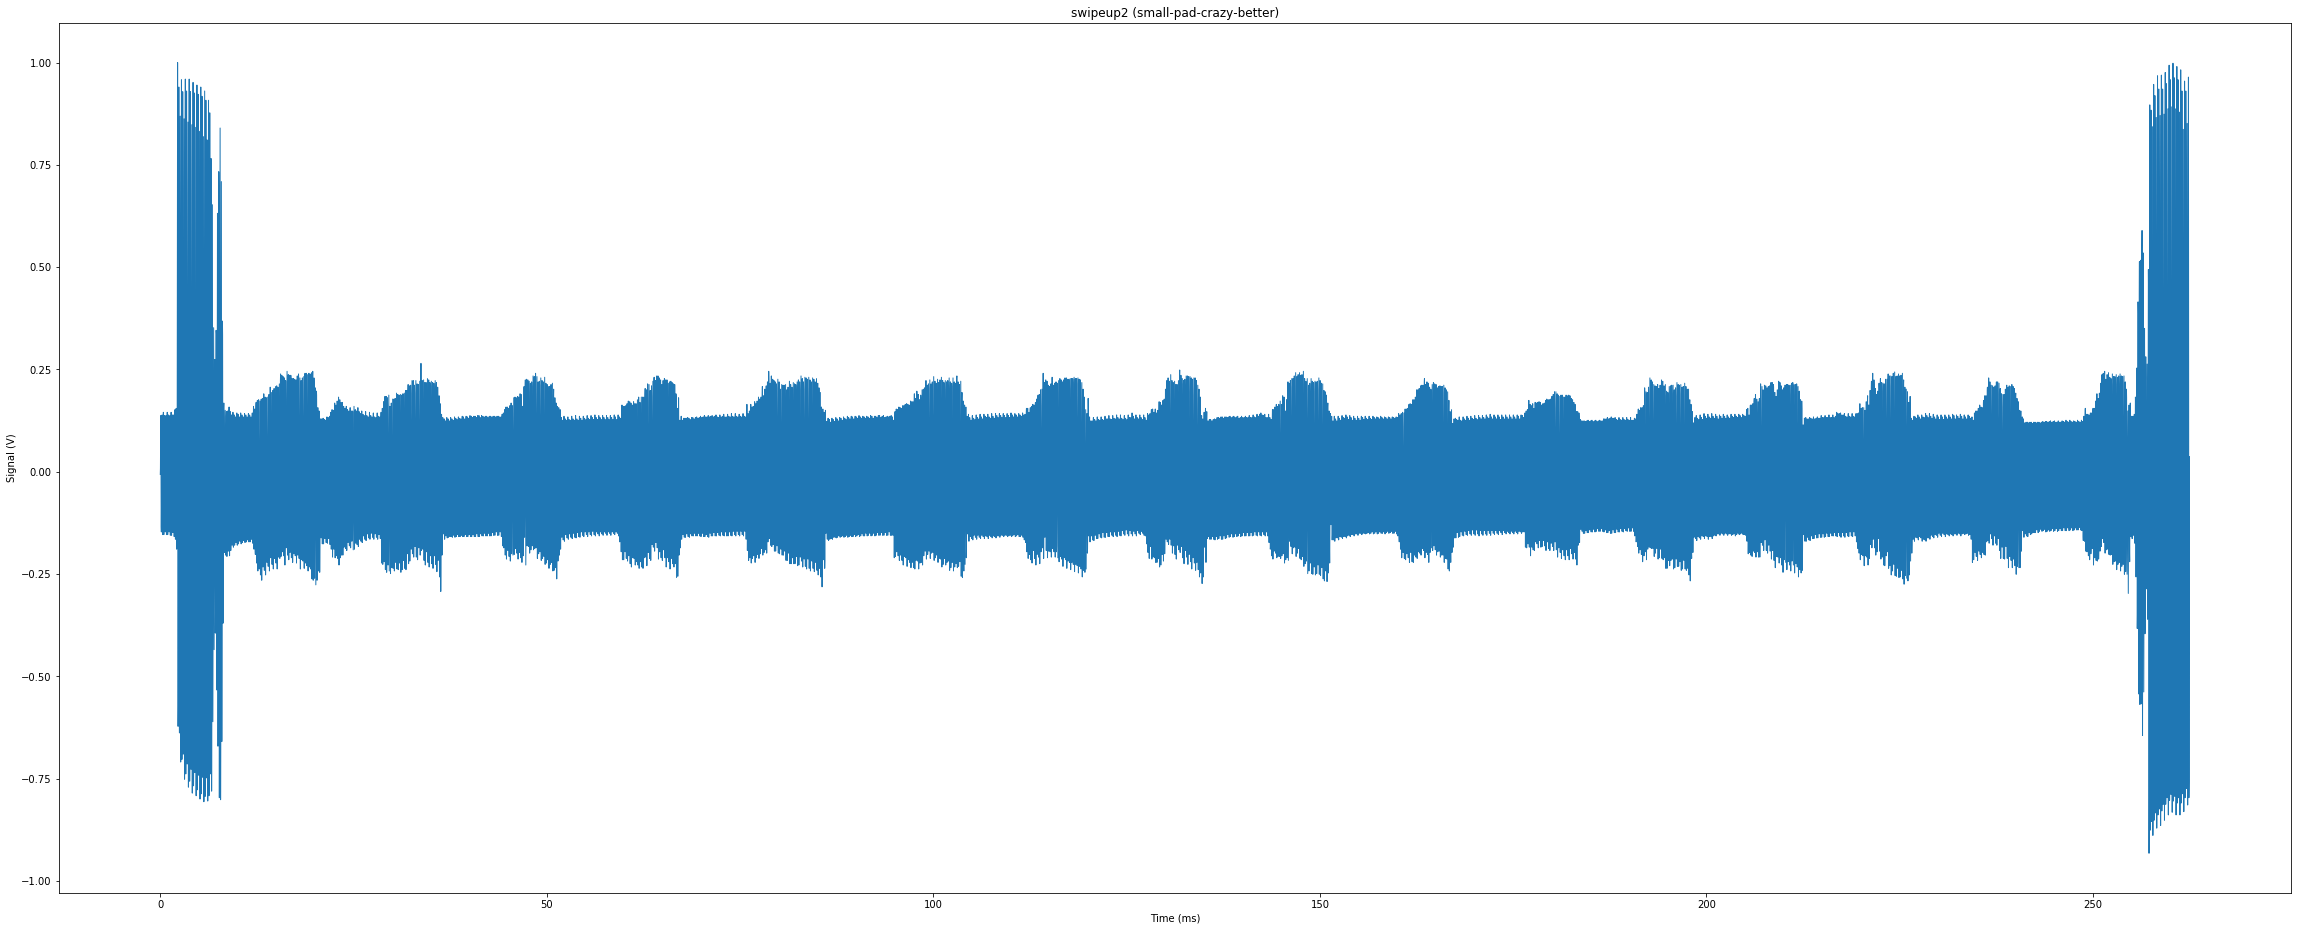

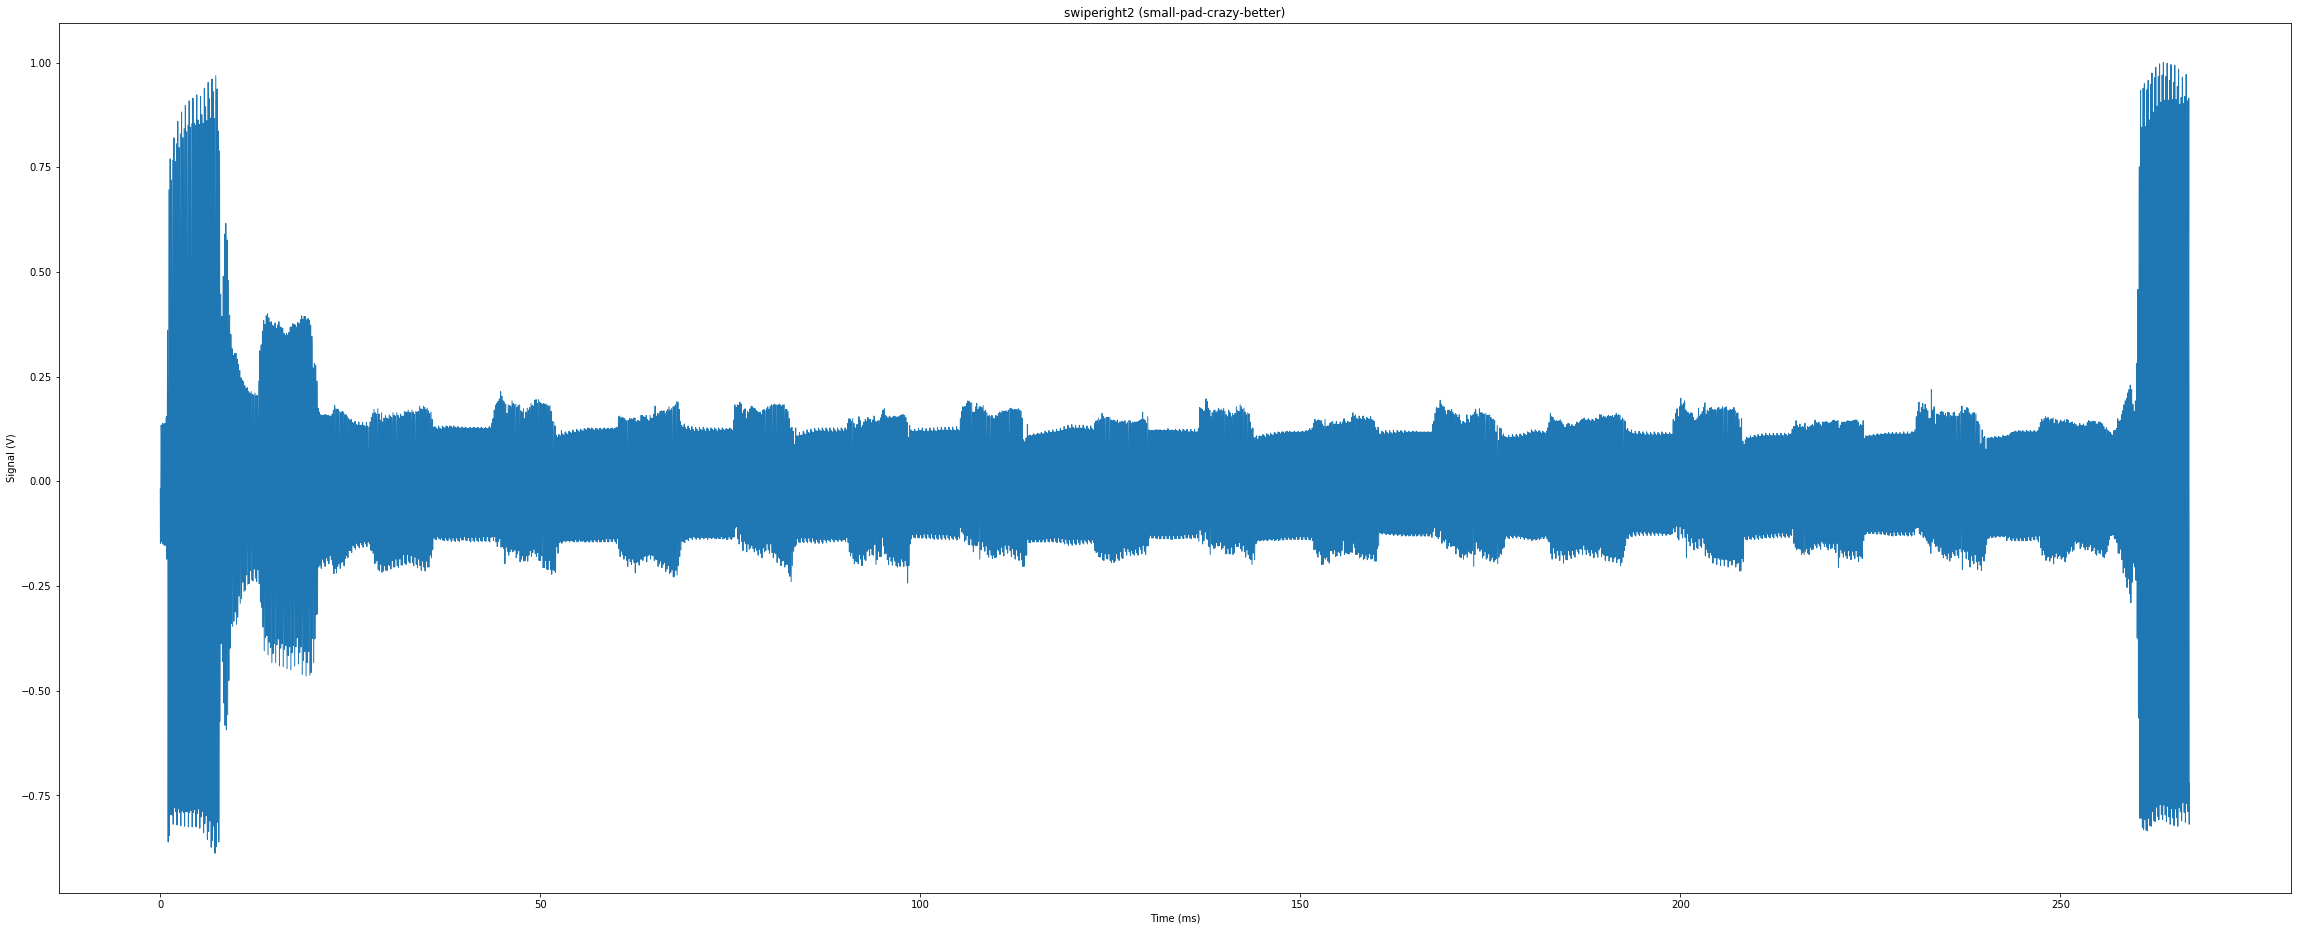

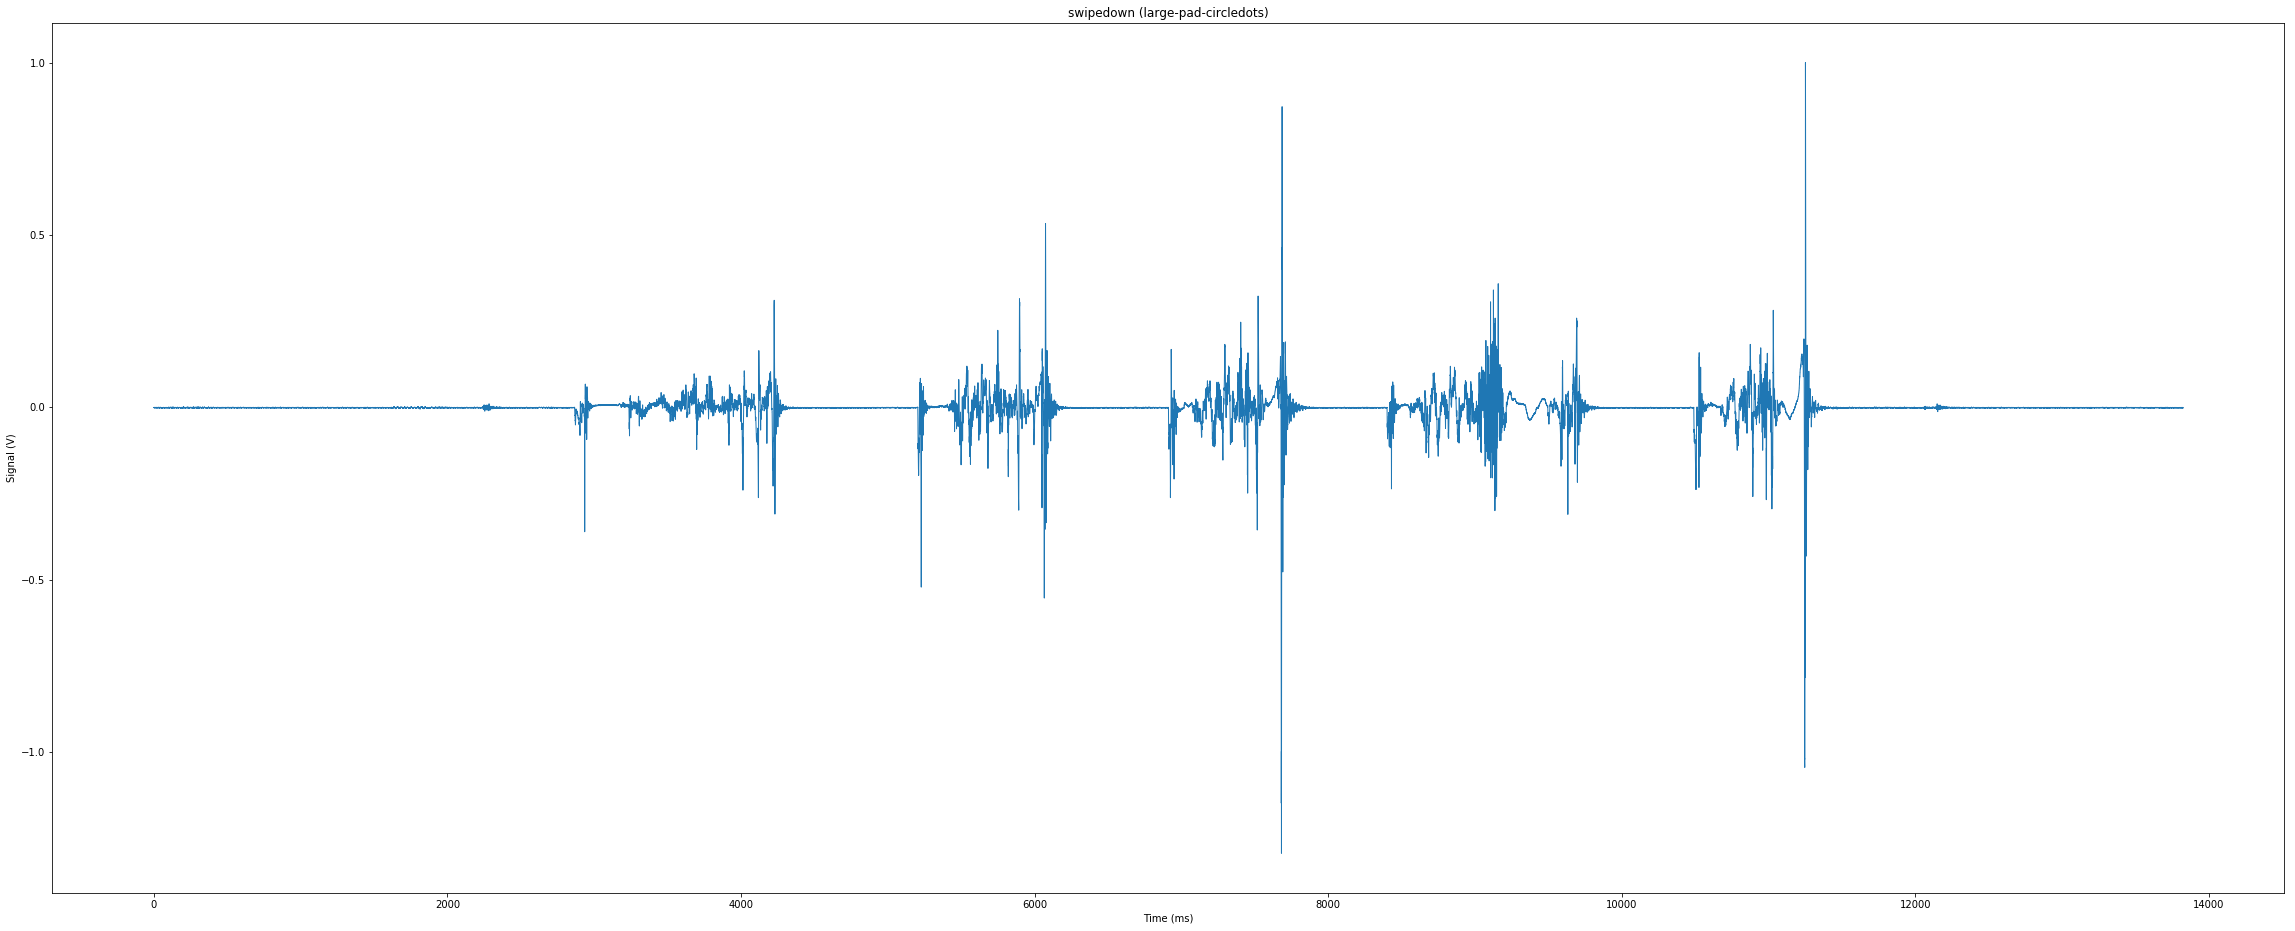

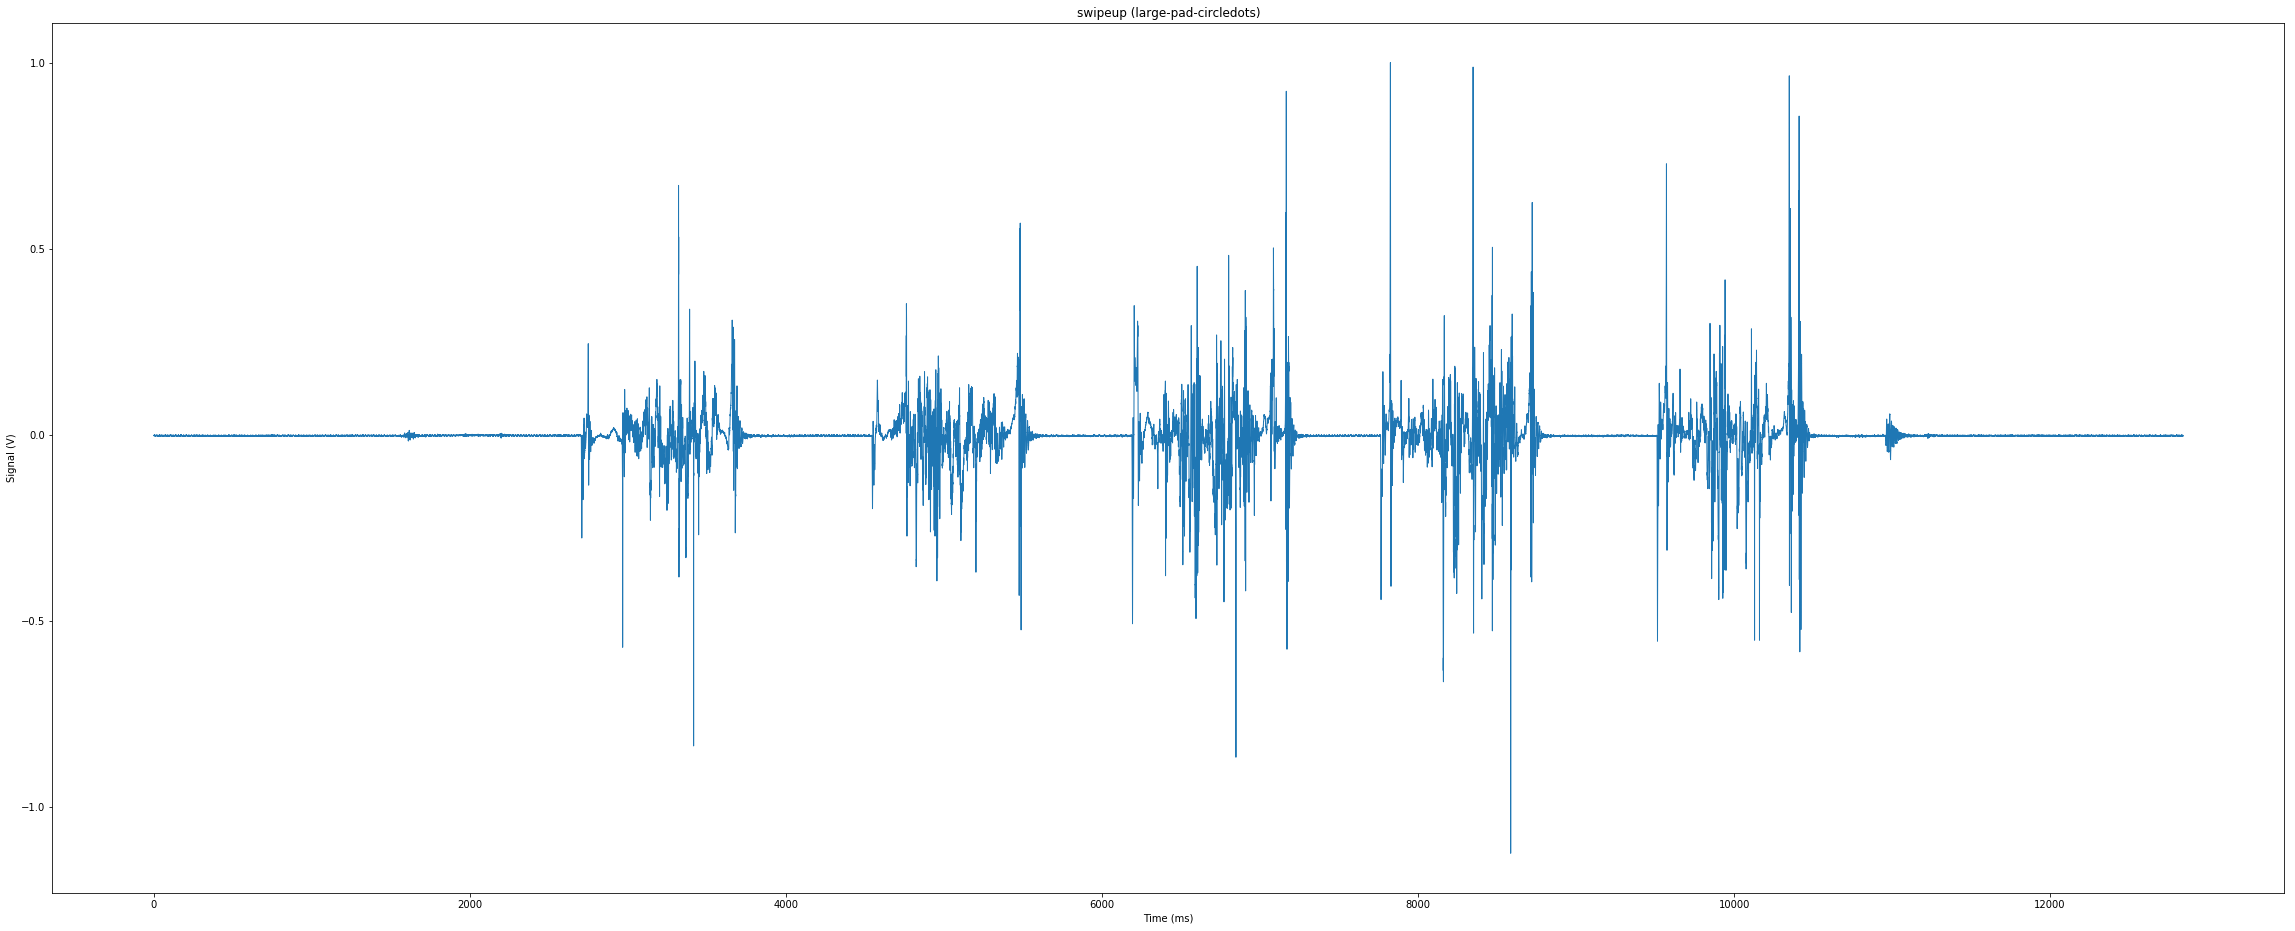

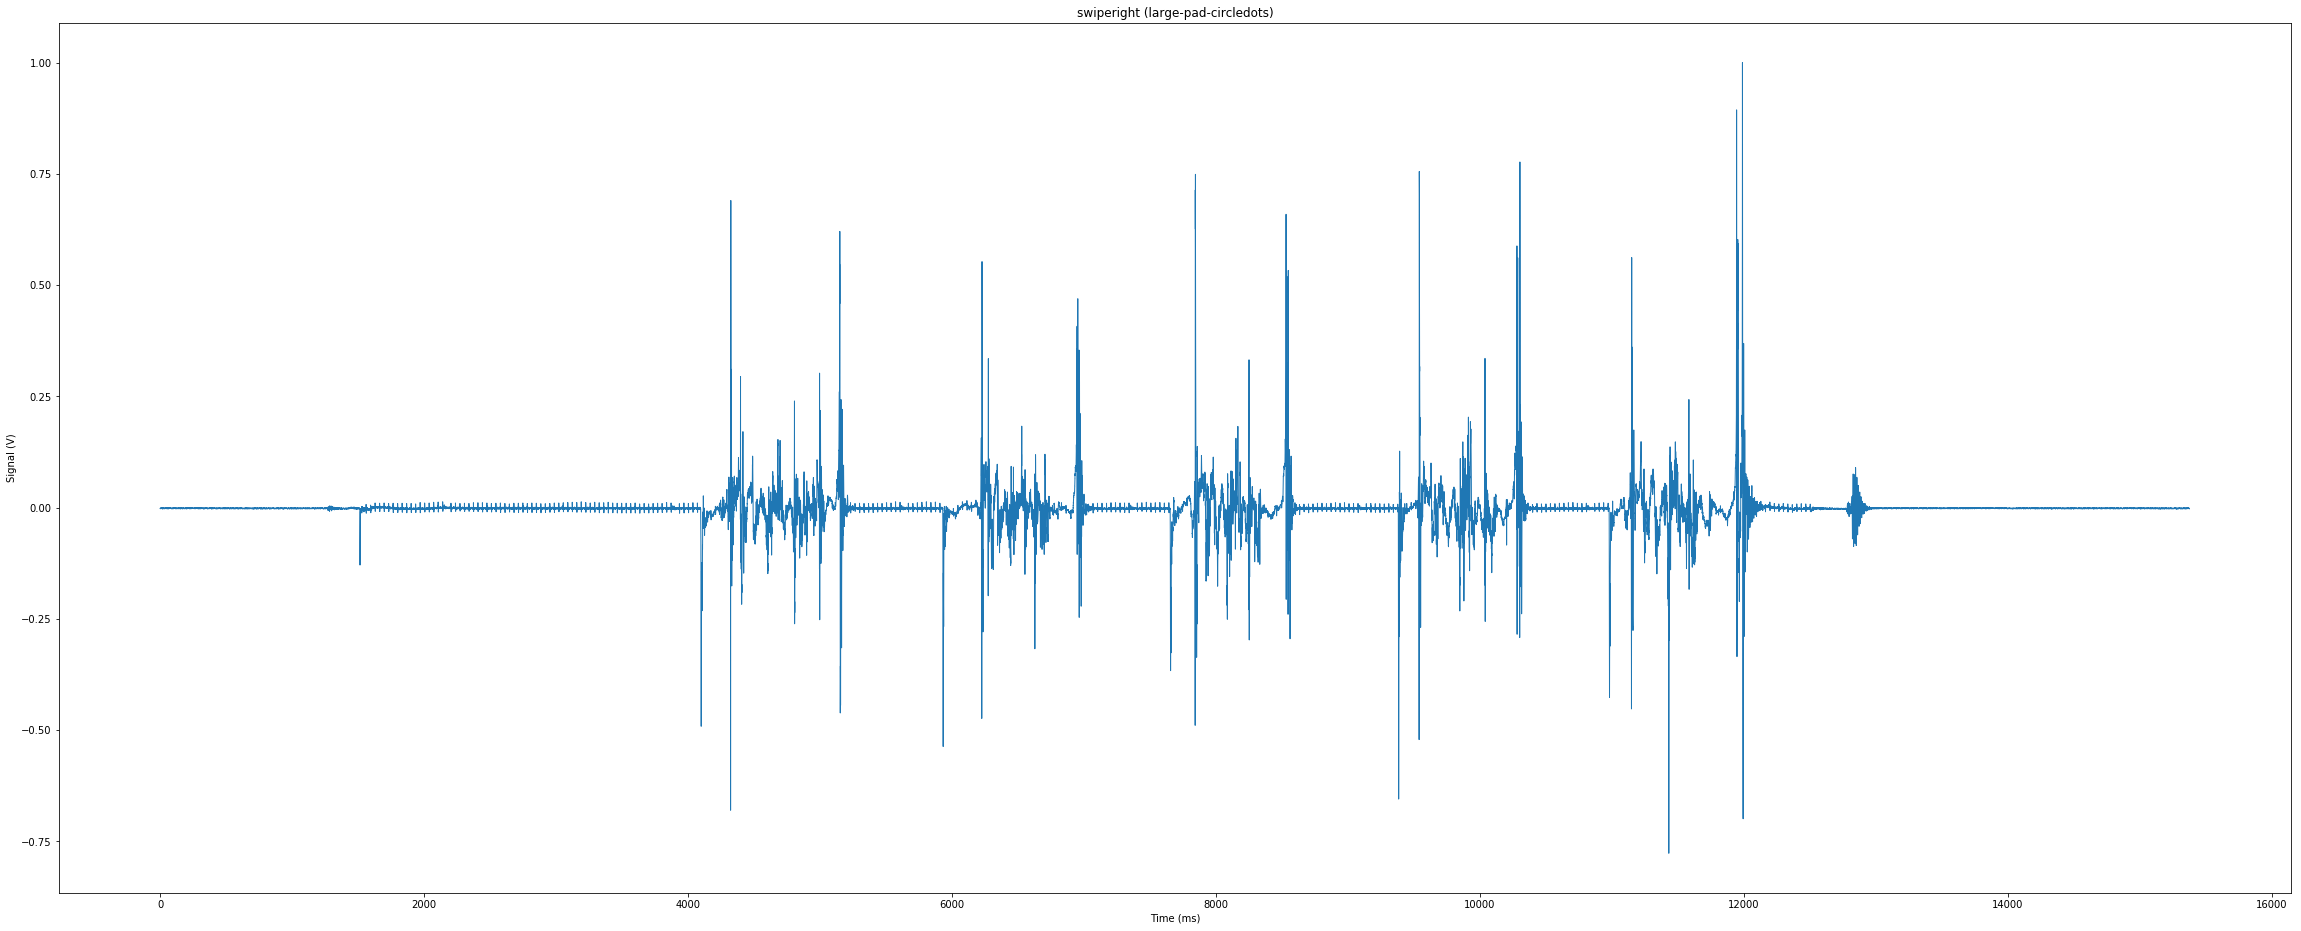

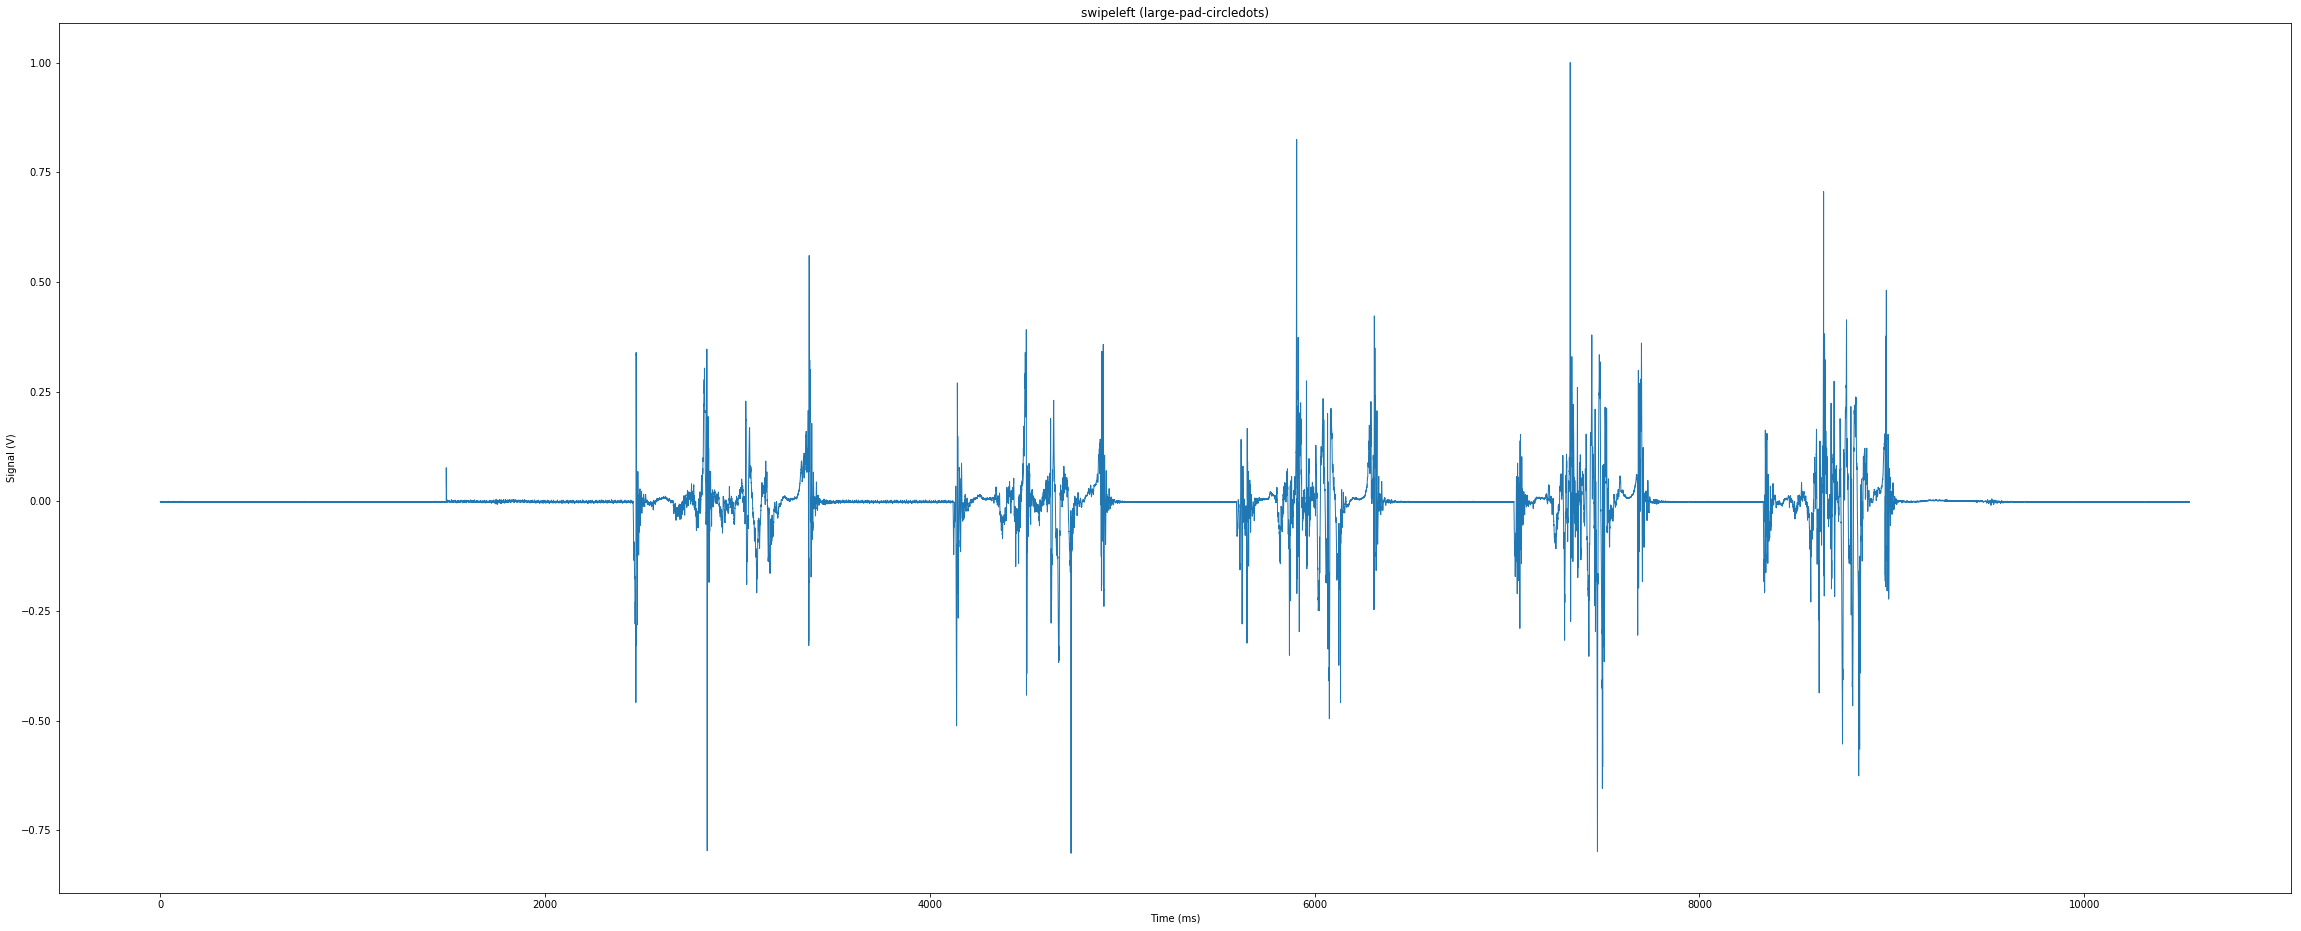

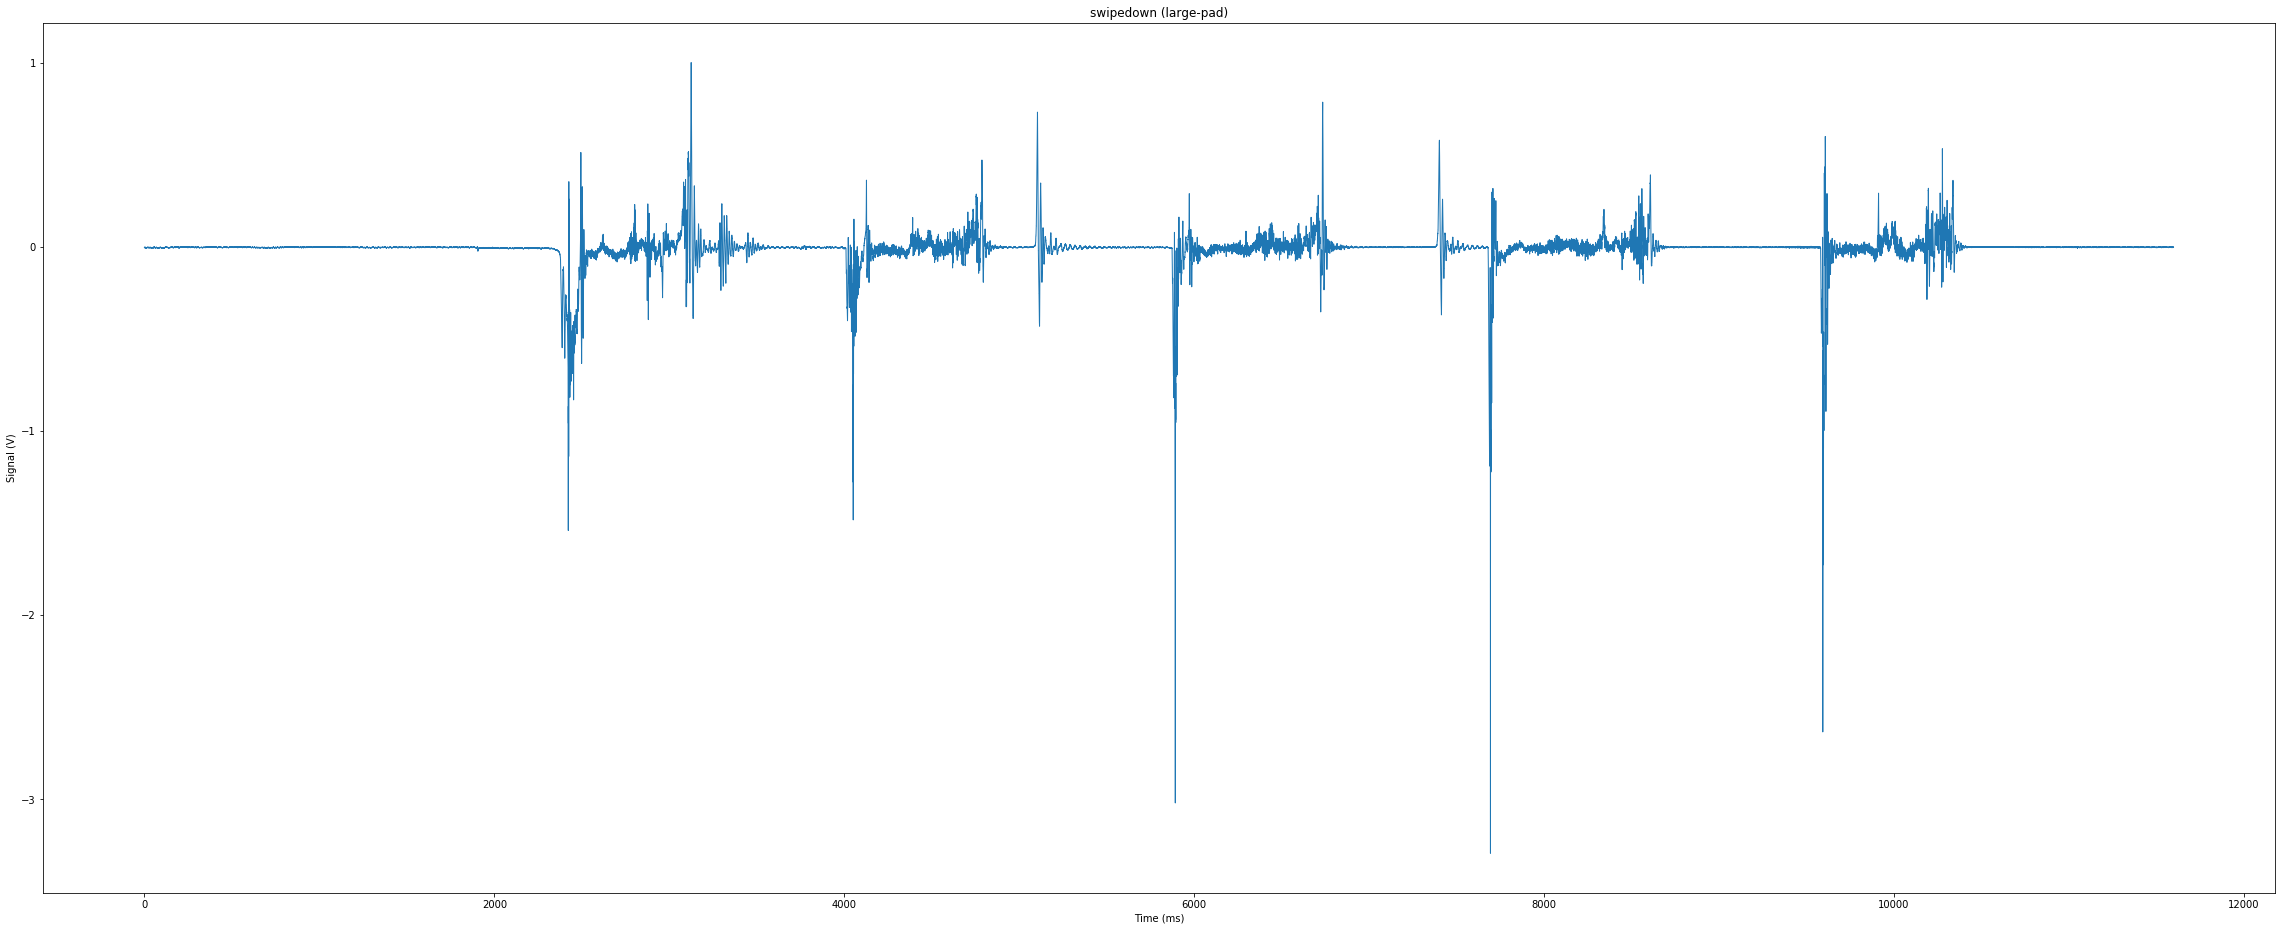

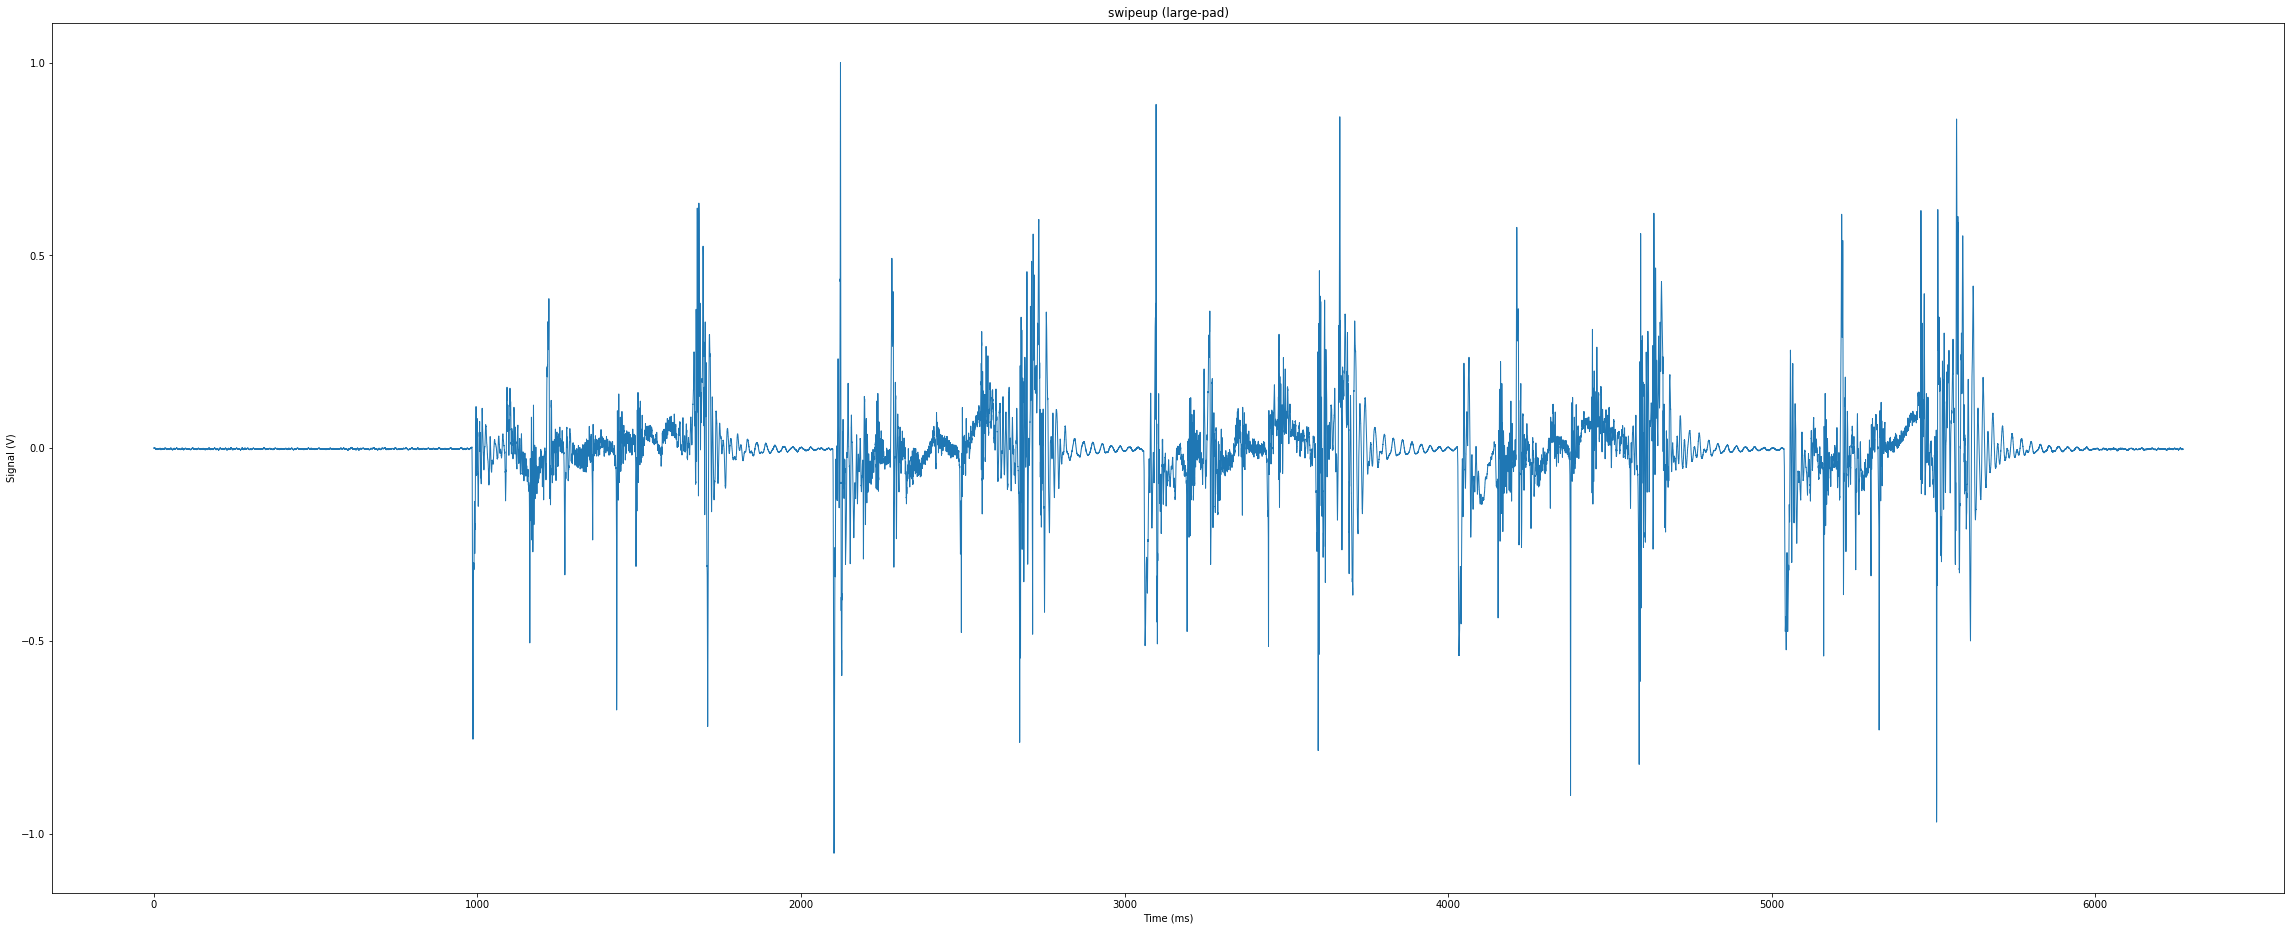

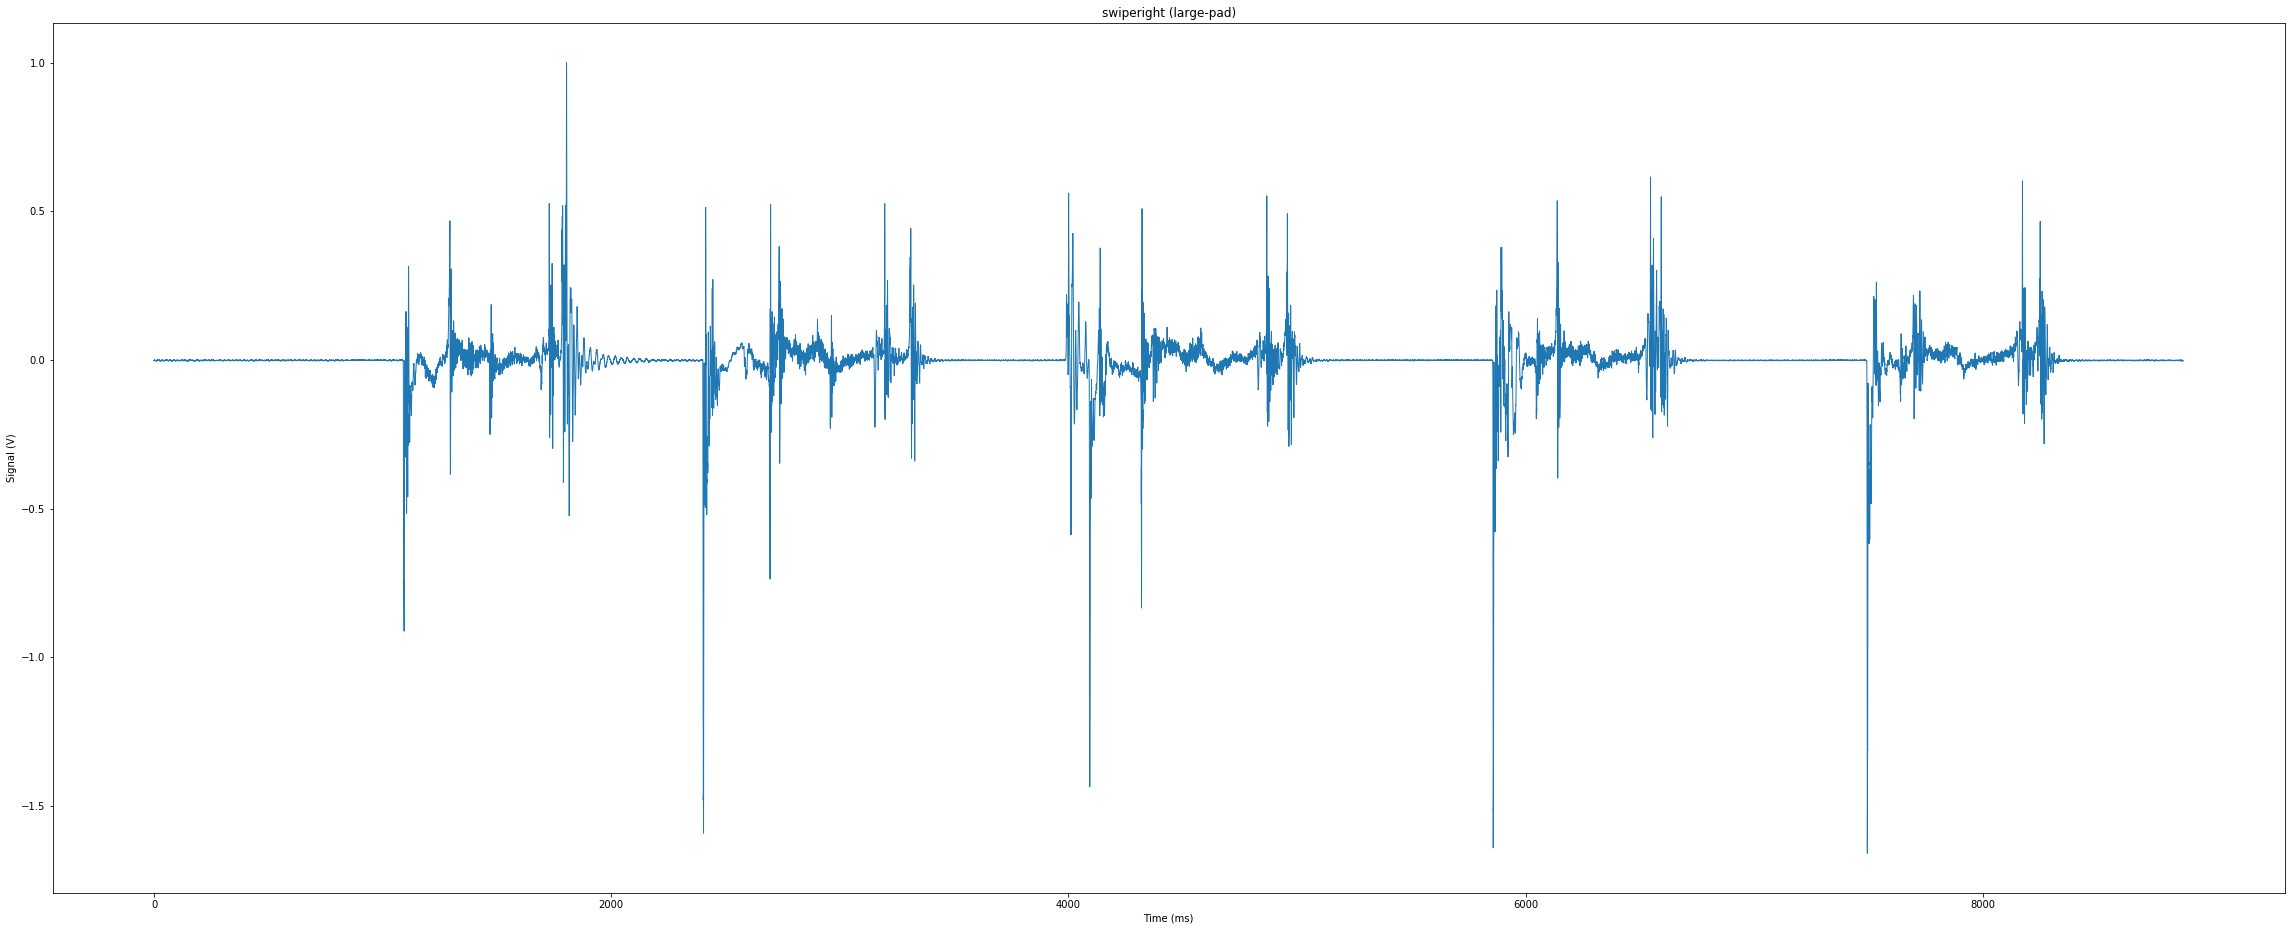

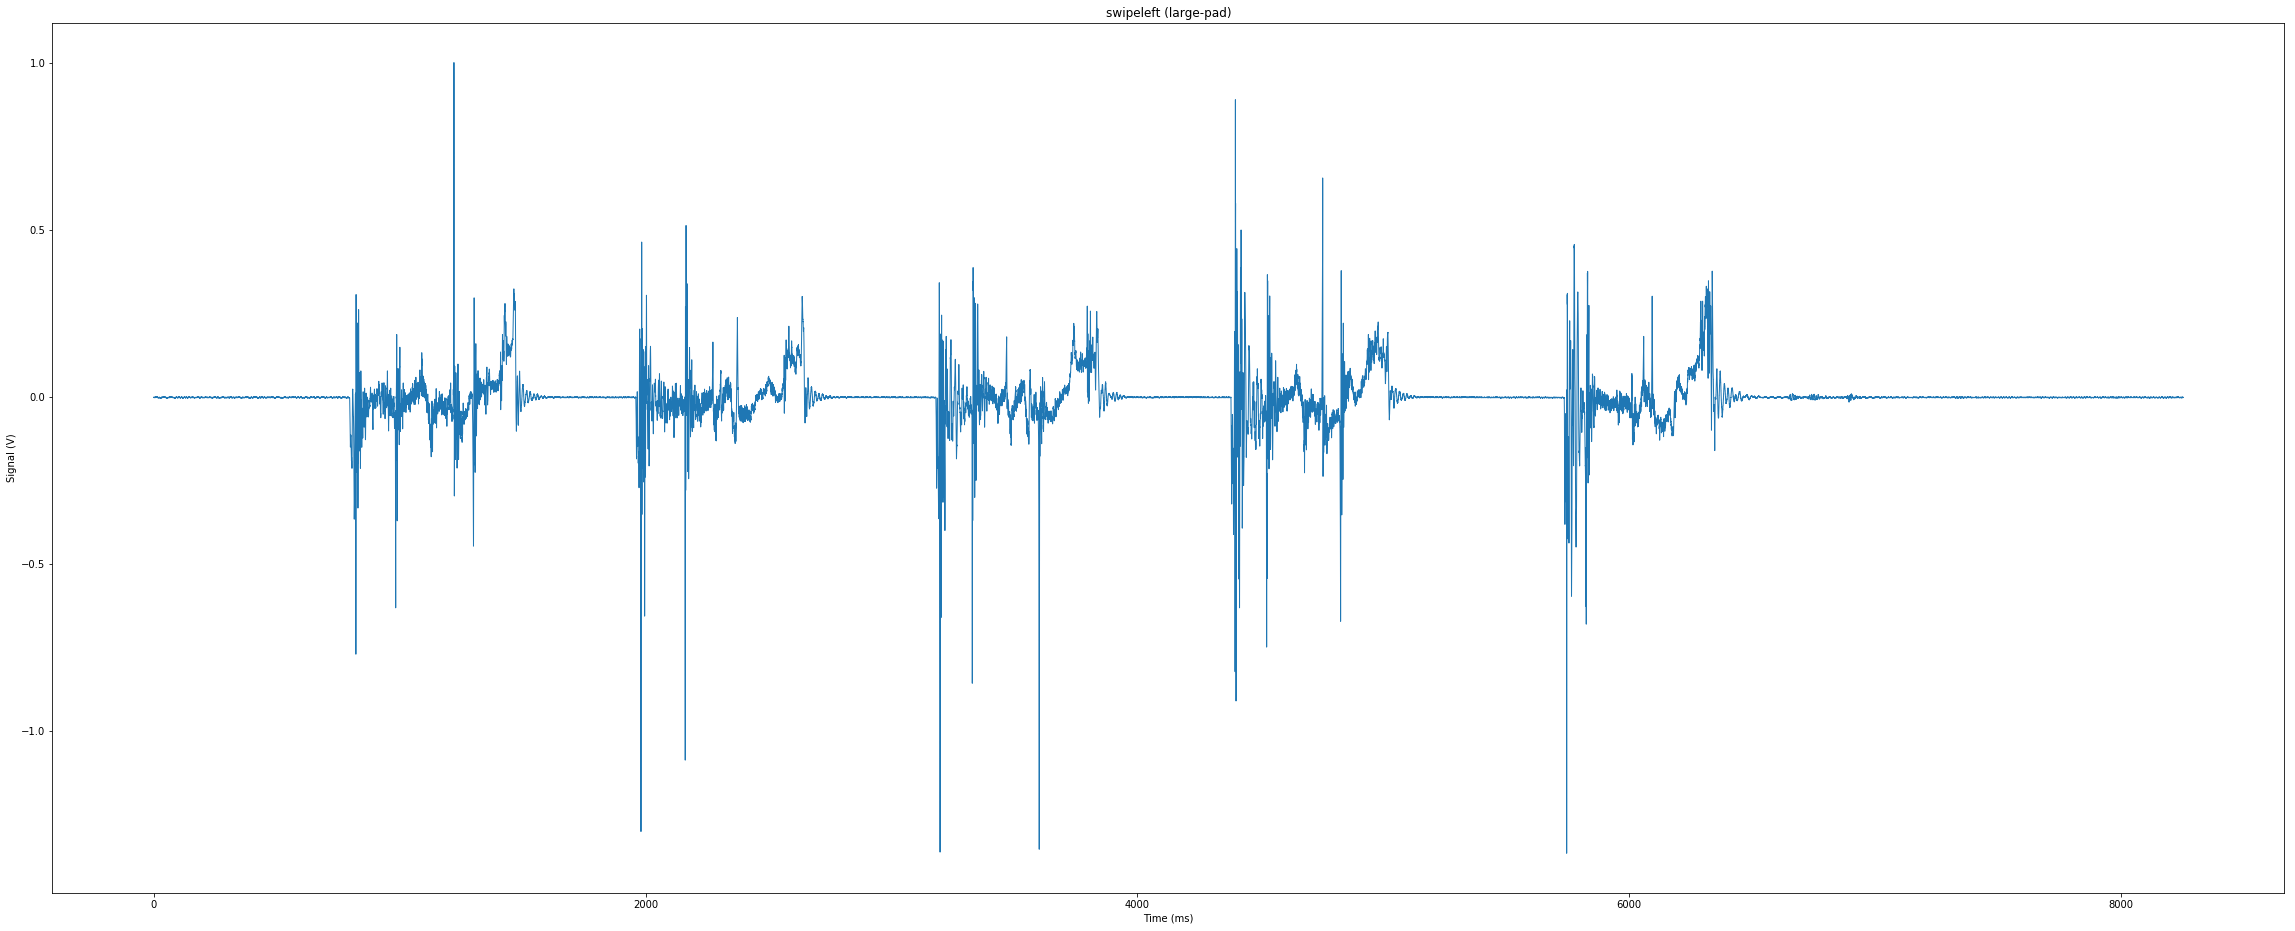

In [6]:
for (i, datum) in enumerate(data):
    df = load_dataset(datum)
    plt.figure(i)
    plt.ylabel('Signal (V)')
    plt.xlabel('Time (ms)')
    w = plt.plot([float(i)*(float(1)/50) for i in range(0, len(df))], df, linewidth=1.0)
    plt.title(datum['File'] + ' (' + datum['Dir'] + ')')

# Waveforms by Gesture

In [ ]:
g = {}
for (i, datum) in enumerate(data):
    if datum['File'] not in g:
        g[datum['File']] = []
    g[datum['File']].append(datum)
for (i, gesture) in enumerate(g.keys()):
    gdata = g[gesture]
    plt.figure(i)
    plt.ylabel('Signal (V)')
    plt.xlabel('Time (ms)')
    for datum in gdata:
        df = load_dataset(datum)
        w = plt.plot([float(i)*(float(1)/50) for i in range(0, len(df))], df, linewidth=1.0, label=datum['Dir'])
    plt.title('All ' + gesture + ' Gestures')

FFT for each Data

In [ ]:
# datasets_dict = get_available_datasets()
# for (i, datum) in enumerate(datasets_dict):
#     cur_dataset = load_dataset(datum, raw=False)
#     time_range = len(cur_dataset)/50000

#     freqs = fftfreq(len(cur_dataset))

#     # only include positive frequencies
#     mask = freqs > 0
#     fft_vals = fft(cur_dataset)
    
#     # range of x-values (time), one coordinate per data
#     x = np.linspace(0, time_range, len(cur_dataset))

#     # true theoretical fft
#     fft_theo = 2.0* np.abs(fft_vals/len(cur_dataset))

#     plt.figure(i)
    
#     plt.plot(freqs[mask], fft_theo[mask], label = 'true fft values')
#     plt.title('FFT values' +  datum['Dir'])


# Segmentation (finding Gestures)

In [18]:
def find_gestures_in_all_datasets(path_filter="", sample_win_size=50000, overlap=.5, threshold=45000):
    datasets_dict = get_available_datasets()
    map_dataname_to_gestures_indices_list = {}
    
    for (i, datum) in enumerate(datasets_dict):
        if path_filter not in datum['Path']:
            continue
        #print('____', datum['Path'])
        dataset = load_dataset(datum, raw=False)
        gestures = find_gestures_in_dataset(dataset, sample_win_size=sample_win_size, threshold=threshold, overlap=overlap)
        yield (datum, gestures)
    return
      
# little test function to empiracally determine the best sample_win_size and threshold for dataset
# yields best gesture approximation, assuming 16 gestures per sample dataset
def find_gestures_in_new_small_pad_datasets(path_filter="small-pad-"):
    #500Hz
    datasets_dict = get_available_datasets()
    map_dataname_to_gestures_indices_list = {}
    
    for (i, datum) in enumerate(datasets_dict):
        if path_filter not in datum['Path']:
            continue
        print('____', datum['Path'])
        dataset = load_dataset(datum, raw=False)
        best_gestures = []
        best_threshold = 0
        target_gestures = 16
        best_win_size = 0
        for sample_win_size in np.linspace(250, 550, num=8):
            sample_win_size = int(sample_win_size)
            for threshold in np.linspace(100, 110, num=2):
                gestures = find_gestures_in_dataset(dataset, sample_win_size=sample_win_size, threshold=threshold)
                if abs(len(gestures) - target_gestures) < abs(len(best_gestures) - target_gestures) or len(best_gestures) == 0:
                    best_gestures = gestures
                    best_threshold = threshold
                    best_win_size = sample_win_size
        print("Best threshold for " + datum['Path'] + ": " + str(best_threshold) + " and win_size=" + str(best_win_size) + " with " + str(len(best_gestures)) + " gestures")
        map_dataname_to_gestures_indices_list[datum['Path']] = best_gestures
        yield (datum, best_gestures)
    return

# returns the list of gesture events happening in dataset
# cur_dataset: a list of readings
def find_gestures_in_dataset(cur_dataset, sample_win_size=50000, overlap=.5, threshold=45000):
    total_time_range = len(cur_dataset)/sample_win_size

    sample_win_size = round(sample_win_size)
    start_win = 0
    end_win = sample_win_size
    slide_amount = round(sample_win_size * overlap)

    map_start_to_fft_sum = {}
    signals_list = []

    # list of sums of all fft bin for each window used on this dataset 
    # each window represents one second of the signal
    list_of_fftSums = []
    
    while start_win < len(cur_dataset):
        # each window covers an event occuring in one second of time
        window_data = cur_dataset[start_win:end_win]
        
        # getting sum of fft bins, then the sum of their frequency values
        fft_vals = rfft(window_data)

        sum_of_fftValues = sum(np.abs(fft_vals))

        # scale smaller slices - no idea if this is accurate
        sum_of_fftValues *= np.round(sample_win_size / (end_win - start_win))

        # appending sum of the fftbins to list 
        list_of_fftSums += [sum_of_fftValues]
        #print(sum_of_fftValues)
        
        # update the window size to include 50000 samples, half new and half old.
        start_win += slide_amount
        end_win = min(end_win + slide_amount, len(cur_dataset))

        #print(sum_of_fftValues)
    fftSums = list_of_fftSums
    i = 0
    gestures = []
    while i < len(fftSums):
        if fftSums[i] > threshold:
            start = i
            while i < len(fftSums) and fftSums[i] > threshold:
                i += 1
            end = i
            gestures += [(slide_amount*start, slide_amount*end)]
        i += 1
           
    # refine start and end points of gesture
    for (i, gesture) in enumerate(gestures):
        squared_gesture = np.power(cur_dataset[gesture[0]:gesture[1]], 2)
        percentile = np.percentile(squared_gesture, 60)
        start = 0
        while squared_gesture[start] > percentile:
            start += 1
        end = len(squared_gesture) - 1
        while squared_gesture[end] < percentile:
            end -= 1
        gestures[i] = (gesture[0] + start, gesture[0] + end)
        
    
    gestures = filter(lambda g: g[1] - g[0] > sample_win_size / 2, gestures)
    gestures = filter(lambda g: g[1] - g[0] < sample_win_size * 5, gestures)
    gestures = list(gestures)
    
    return gestures

# Classification (which gesture?) 

In [34]:
from sklearn.neighbors import KNeighborsClassifier

all_gestures = list(find_gestures_in_all_datasets(path_filter="small-pad-crazy/", sample_win_size=500, overlap=.5, threshold=250))

# build knn model
# mapping: dict of gesture_name -> [sample gestures] mappings
def build_knn_model(mapping):
    knn = KNeighborsClassifier(n_neighbors=3)
    X = []
    y = []
    for gesture_name, sample_gestures in mapping.items():
        for sample_gesture in sample_gestures:
            X.append(sample_gesture)
            y.append(gesture_name)
    return knn.fit(X, y)
    
build_knn_model({datum['File']: [load_dataset(datum, raw=False)[g[0]:g[1]] for g in gestures] for (datum, gestures) in all_gestures})

ValueError: Expected 2D array, got 1D array instead:
array=[array([-0.04314498, -0.1332738 , -0.13056315, -0.07951275, -0.00225948,
        0.09622714,  0.14072683,  0.11023211,  0.00700187, -0.11836527,
       -0.13575855, -0.10368263, -0.03591661,  0.07002427,  0.12875483,
        0.13891973,  0.04720971, -0.08628935, -0.14140572, -0.12265712,
       -0.05873117,  0.03636715,  0.11655694,  0.14953641,  0.07747854,
       -0.04314498, -0.13553266, -0.13214436, -0.08086807, -0.00293714,
        0.09713068,  0.14230803,  0.11249098,  0.00790542, -0.12039825,
       -0.1382433 , -0.10526384, -0.03682016,  0.07250903,  0.12943249,
        0.14072683,  0.04856503, -0.0871929 , -0.14389047, -0.1246901 ,
       -0.05940883,  0.03433417,  0.11836404,  0.15337648,  0.07905974,
       -0.04337087, -0.13756564, -0.13440323, -0.08222339, -0.00316303,
        0.09713068,  0.14547045,  0.11497574,  0.00858308, -0.12243123,
       -0.14095394, -0.10707093, -0.03749782,  0.07160548,  0.13304668,
        0.14411513,  0.04924269, -0.08877411, -0.14637523, -0.12694897,
       -0.06008649,  0.03772247,  0.12084879,  0.15382826,  0.08064095,
       -0.04382264, -0.14117983, -0.1366621 , -0.0838046 , -0.00338892,
        0.10210019,  0.14614811,  0.11746049,  0.00880897, -0.12581953,
       -0.14389047, -0.1093298 , -0.0377237 ,  0.07386435,  0.13507966,
        0.14750343,  0.04969447, -0.09125886, -0.1502153 , -0.12965961,
       -0.06099004,  0.03659304,  0.12333355,  0.15857188,  0.08222216,
       -0.04517797, -0.14479402, -0.13937274, -0.08561169, -0.00338892,
        0.10187431,  0.15066584,  0.12017113,  0.00926074, -0.12898195,
       -0.14727877, -0.11136278, -0.03840136,  0.07612322,  0.13756441,
        0.15089173,  0.05014624, -0.09306595, -0.1536036 , -0.13214436,
       -0.06211947,  0.03862602,  0.12604419,  0.16105663,  0.08380337,
       -0.04585563, -0.14840821, -0.14253515, -0.0871929 , -0.00338892,
        0.10571438,  0.15382826,  0.12333355,  0.00948663, -0.1332738 ,
       -0.15179651, -0.1145252 , -0.03907902,  0.0781562 ,  0.14275981,
        0.15631301,  0.05037213, -0.09803546, -0.1603802 , -0.13756564,
       -0.06370068,  0.04133666,  0.13304668,  0.17054388,  0.08719167,
       -0.05172868, -0.16241319, -0.15631424, -0.09803546, -0.01016552,
        0.1310137 ,  0.19268078,  0.15766833,  0.00790542, -0.20058805,
       -0.2371817 , -0.18342065, -0.06302302,  0.13801618,  0.25276665,
        0.28077661,  0.07838208, -0.20781642, -0.32053391, -0.26722463,
       -0.11972059,  0.08380337,  0.27490355,  0.35712633,  0.16805912,
       -0.13124081, -0.35803111, -0.32821406, -0.19155258,  0.00248414,
        0.25615495,  0.36548414,  0.28506845,  0.00112882, -0.34696266,
       -0.37226197, -0.26654697, -0.07973864,  0.19968327,  0.35441569,
        0.38536217,  0.10639204, -0.26338456, -0.40230491, -0.32663285,
       -0.14095394,  0.10842502,  0.32821282,  0.42082639,  0.20284568,
       -0.1366621 , -0.39326944, -0.35757933, -0.20533167,  0.00700187,
        0.27422589,  0.37858557,  0.29410392,  0.00745365, -0.33634598,
       -0.36955133, -0.27648599, -0.09103297,  0.18906659,  0.34967206,
        0.39349409,  0.12401121, -0.24418419, -0.39281766, -0.33160236,
       -0.1520224 ,  0.09261295,  0.31398196,  0.42195582,  0.21820598,
       -0.11746172, -0.37994212, -0.3632265 , -0.22362849, -0.01649035,
        0.134402  ,  0.40953205,  0.33589297,  0.03817424, -0.34402613,
       -0.39010702, -0.28890976, -0.09803546,  0.18997014,  0.37406783,
        0.42489235,  0.14163037, -0.24779837, -0.4126957 , -0.35012507,
       -0.16196141,  0.09487182,  0.3336341 ,  0.44996578,  0.24192409,
       -0.11000746, -0.39869072, -0.41766521, -0.23311574, -0.01490914,
        0.28348725,  0.42037461,  0.35870753,  0.04879092, -0.35757933,
       -0.4093074 , -0.30539949, -0.1059415 ,  0.19335844,  0.38378096,
        0.44070442,  0.15043996, -0.24757249, -0.41585811, -0.35441692,
       -0.16783447,  0.09261295,  0.3388295 ,  0.45403174,  0.24440884,
       -0.10481207, -0.39846483, -0.38513752, -0.23560049, -0.01874922,
        0.27942129,  0.41879341,  0.35057561,  0.04698383, -0.35012507,
       -0.40456378, -0.29817112, -0.1025532 ,  0.19200312,  0.37474549,
        0.42850654,  0.14659988, -0.24260298, -0.40975917, -0.34651088,
       -0.15947666,  0.09035408,  0.32889048,  0.43867144,  0.24011699,
       -0.10232731, -0.38468574, -0.37135842, -0.228598  , -0.01694212,
        0.27196702,  0.4018519 ,  0.34289546,  0.04946858, -0.33860485,
       -0.39575419, -0.29771935, -0.10684505,  0.18567829,  0.36864655,
        0.4307654 ,  0.15224705, -0.23853702, -0.4093074 , -0.3530616 ,
       -0.17031922,  0.07770442,  0.32730928,  0.45561295,  0.25412197,
       -0.09193652, -0.39326944, -0.39123646, -0.25028313, -0.0309471 ,
        0.26925638,  0.42172994,  0.36977598,  0.06076292, -0.35012507,
       -0.42308649, -0.32211511, -0.1213018 ,  0.18522651,  0.38581394,
        0.46013068,  0.17076976, -0.24644305, -0.4382209 , -0.38061978,
       -0.18635718,  0.07883386,  0.3456061 ,  0.47820162,  0.26880461,
       -0.07951275, -0.41585811, -0.42918543, -0.26745052, -0.03026944,
        0.28845676,  0.43686435,  0.38174798,  0.06347356, -0.36480771,
       -0.43528437, -0.33137647, -0.12356067,  0.19358432,  0.39801183,
        0.47616864,  0.17551338, -0.24960547, -0.44725637, -0.38965525,
       -0.19245612,  0.08109272,  0.35170504,  0.48746298,  0.28055072,
       -0.09035531, -0.42195705, -0.41540634, -0.26586931, -0.03636838,
        0.2893603 ,  0.4427374 ,  0.39643062,  0.07409024, -0.36367827,
       -0.44454573, -0.33928251, -0.12875606,  0.19448787,  0.39914126,
        0.48136404,  0.18274176, -0.24847603, -0.44883758, -0.39033291,
       -0.1929079 ,  0.07454201,  0.35170504,  0.4922066 ,  0.28416491,
       -0.08854822, -0.42579713, -0.42037585, -0.27445301, -0.04178966,
        0.29139328,  0.44702925,  0.40140013,  0.07499378, -0.3700031 ,
       -0.45222588, -0.34199315, -0.1280784 ,  0.19493964,  0.40569198,
        0.48927007,  0.18658183, -0.24712071, -0.45832482, -0.39552831,
       -0.19381144,  0.07612322,  0.35622278,  0.49582079,  0.29184506,
       -0.08515992, -0.42828188, -0.41743932, -0.2728718 , -0.04043434,
        0.29432981,  0.4479328 ,  0.40343311,  0.0797374 , -0.36074175,
       -0.44431984, -0.33634598, -0.12514187,  0.18703361,  0.39756005,
        0.48520411,  0.18387119, -0.23944057, -0.44183509, -0.39010702,
       -0.19087492,  0.07092782,  0.34650965,  0.48633354,  0.28800498,
       -0.08154573, -0.4246677 , -0.41246981, -0.27196826, -0.03998257,
        0.28913442,  0.44499627,  0.403659  ,  0.07702676, -0.36593714,
       -0.44974112, -0.3410896 , -0.12085002,  0.19652085,  0.40817673,
        0.49717611,  0.18929248, -0.24644305, -0.46080957, -0.39462476,
       -0.18929371,  0.07928563,  0.36751712,  0.50779278,  0.29816989,
       -0.08809645, -0.44635282, -0.42421592, -0.27490478, -0.03410951,
        0.30404294,  0.46397076,  0.41856752,  0.07996329, -0.3785868 ,
       -0.46916738, -0.35193216, -0.12604542,  0.20149036,  0.41992284,
        0.50621158,  0.19606908, -0.2473466 , -0.47549221, -0.416084  ,
       -0.20849408,  0.0729608 ,  0.38107032,  0.53376976])
 array([ 4.29123185e-03, -1.45245793e-01, -1.59024884e-01, -1.16332290e-01,
       -3.43354014e-02,  9.57753632e-02,  1.64219047e-01,  1.75513384e-01,
        5.08239011e-02, -1.21301798e-01, -1.84550086e-01, -1.51118848e-01,
       -6.21194709e-02,  6.25700118e-02,  1.65800254e-01,  2.03523340e-01,
        9.46459295e-02, -7.29620346e-02, -1.92230236e-01, -1.72352202e-01,
       -9.50989356e-02,  1.33267016e-02,  1.49536408e-01,  2.01490359e-01,
        1.49762295e-01, -2.25948373e-03, -1.81387672e-01, -1.89745481e-01,
       -1.24464212e-01,  8.80896674e-03,  1.33498449e-01,  2.03297453e-01,
        1.99231492e-01,  4.65320530e-02, -1.41179831e-01, -1.90874915e-01,
       -1.38695077e-01, -4.81144928e-02,  8.92246476e-02,  2.06459868e-01,
        2.43053520e-01,  1.09554455e-01, -8.51599188e-02, -2.19110758e-01,
       -1.82517106e-01, -9.19365211e-02,  3.47859423e-02,  2.08041075e-01,
        2.75807098e-01,  2.01038586e-01, -4.52389774e-04, -2.38762905e-01,
       -2.34471057e-01, -1.50892961e-01, -2.12339702e-02,  1.80934666e-01,
        2.97718112e-01,  2.96136905e-01,  7.81561972e-02, -2.00588045e-01,
       -2.87102668e-01, -2.11656496e-01, -4.42744181e-02,  1.44115126e-01,
        3.07883016e-01,  3.52608591e-01,  1.42985693e-01, -1.33951456e-01,
       -3.09691342e-01, -2.44635960e-01, -9.75836898e-02,  1.13620416e-01,
        3.18499693e-01,  3.39281273e-01,  1.66026141e-01, -8.94517670e-02,
       -2.99300552e-01, -1.96296197e-01, -3.34318544e-02,  1.14749850e-01,
        2.80550720e-01,  2.96588679e-01,  1.86581834e-01, -5.64723023e-02,
       -2.61803353e-01, -1.97651517e-01, -9.03608605e-03,  1.05714380e-01,
        2.13236470e-01,  2.29500316e-01,  1.46148107e-01, -4.13378905e-02,
       -1.69641561e-01, -1.49085867e-01, -2.25892907e-02,  6.79912937e-02,
        1.40952712e-01,  2.09622282e-01,  1.46825767e-01,  1.17454944e-02,
       -1.00068444e-01, -1.77999371e-01, -4.29190977e-02,  3.84001302e-02,
        1.03229626e-01,  1.99457379e-01,  1.66703801e-01,  8.08668381e-02,
       -5.51169819e-02, -1.65801486e-01, -8.85482200e-02,  1.49079088e-02,
        8.69657802e-02,  1.61960179e-01,  1.60378972e-01,  1.05714380e-01,
       -2.23634040e-02, -1.02779085e-01, -8.10939574e-02, -4.29246442e-03,
        5.85040504e-02,  1.05262606e-01,  1.39597392e-01,  1.01874305e-01,
        1.91997570e-02, -4.02084567e-02, -8.38045984e-02, -1.76197823e-02,
        2.86870002e-02,  6.97983877e-02,  1.28077168e-01,  1.05262606e-01,
        5.66969565e-02, -1.44573679e-02, -7.25102612e-02, -3.43354014e-02,
        1.03901739e-02,  5.37604288e-02,  9.44200428e-02,  9.66789102e-02,
        7.07019346e-02,  4.29123185e-03, -4.26932109e-02, -3.27541942e-02,
       -1.13005001e-03,  3.36565086e-02,  6.18923516e-02,  8.38033658e-02,
        6.95725009e-02,  2.68799063e-02, -1.37797077e-02, -3.77237026e-02,
       -8.58431256e-03,  1.40043619e-02,  3.95295639e-02,  7.47678960e-02,
        6.88948407e-02,  4.49508458e-02,  9.02930691e-04, -3.43354014e-02,
       -2.21375172e-02, -1.35593675e-03,  2.91387737e-02,  6.30217853e-02,
        7.02501611e-02,  5.51157493e-02,  7.67953301e-03, -3.32059677e-02,
       -3.70460423e-02, -1.55868016e-02,  1.64891160e-02,  4.51767325e-02,
        7.25090286e-02,  6.23441251e-02,  1.96515305e-02, -2.19116305e-02,
       -5.55687553e-02, -2.75587991e-02,  1.12881743e-03,  3.20753014e-02,
        7.29608021e-02,  6.43771058e-02,  3.50118291e-02, -2.34928377e-02,
       -6.73148660e-02, -4.72109458e-02, -1.53609149e-02,  2.19103979e-02,
        6.46029925e-02,  7.47678960e-02,  5.46639758e-02, -1.24243872e-02,
       -6.88960732e-02, -6.68630925e-02, -2.91400063e-02,  1.42302486e-02,
        5.24051084e-02,  8.83211007e-02,  6.95725009e-02,  1.01642872e-02,
       -5.26322277e-02, -9.75836898e-02, -4.47261916e-02, -1.58182349e-03,
        3.99813374e-02,  1.05714380e-01,  9.28388356e-02,  4.83391470e-02,
       -4.78886060e-02, -1.25367759e-01, -8.49340321e-02, -2.59775919e-02,
        3.61412628e-02,  1.12039209e-01,  1.26721847e-01,  1.14298076e-01,
       -2.77846858e-02, -1.53151829e-01, -1.55636583e-01, -6.27971312e-02,
        2.39433786e-02,  9.37423825e-02,  1.62637839e-01,  1.31465469e-01,
        2.23621714e-02, -9.89390102e-02, -2.01265705e-01, -1.02553198e-01,
       -1.94268763e-02,  6.73136335e-02,  1.81386439e-01,  1.77998138e-01,
        1.12942756e-01, -6.55077721e-02, -2.24757927e-01, -1.77095824e-01,
       -6.57336588e-02,  5.53416360e-02,  1.72802743e-01,  2.22046053e-01,
        1.84774740e-01, -9.03608605e-03, -1.97425631e-01, -2.41925319e-01,
       -3.72036084e-01, -2.57737391e-01, -2.80105726e-02,  2.87101436e-01,
        4.29861858e-01,  3.77456133e-01,  5.28568818e-02, -3.63452388e-01,
       -4.26248902e-01, -3.27536395e-01, -1.16332290e-01,  1.93810210e-01,
        3.86265716e-01,  4.57420041e-01,  1.58120105e-01, -2.44184187e-01,
       -4.26926563e-01, -3.70228990e-01, -1.77321710e-01,  8.56104597e-02,
        3.41766028e-01,  4.70521472e-01,  2.62028007e-01, -9.84872367e-02,
       -4.05693209e-01, -3.98238946e-01, -2.51412563e-01, -2.55258184e-02,
        2.87553209e-01,  4.29184198e-01,  3.72034851e-01,  5.96334842e-02,
       -3.58256992e-01, -4.23764148e-01, -3.18049152e-01, -1.11136894e-01,
        1.94939644e-01,  3.91461111e-01,  4.60130682e-01,  1.61056632e-01,
       -2.46443054e-01, -4.32799618e-01, -3.71810197e-01, -1.75740503e-01,
        8.92246476e-02,  3.46961423e-01,  4.72102679e-01,  2.65868082e-01,
       -9.93907837e-02, -4.10210944e-01, -3.94172985e-01, -2.48250148e-01,
       -2.43963847e-02,  2.89812076e-01,  4.30313631e-01,  3.71583078e-01,
        5.64710697e-02, -3.57353446e-01, -4.17891093e-01, -3.09691342e-01,
       -1.04360292e-01,  2.00135039e-01,  3.85588056e-01,  4.49062231e-01,
        1.56990671e-01, -2.45991281e-01, -4.29411317e-01, -3.55772238e-01,
       -1.66027373e-01,  9.17094018e-02,  3.41540141e-01,  4.59453021e-01,
        2.55025518e-01, -9.84872367e-02, -4.05467322e-01, -3.88751703e-01,
       -2.40344112e-01, -1.85233293e-02,  2.89360303e-01,  4.25344123e-01,
        3.68646550e-01,  5.69228432e-02, -3.58708766e-01, -4.19698187e-01,
       -3.10143116e-01, -1.07748593e-01,  1.98102058e-01,  3.89879904e-01,
        4.56516494e-01,  1.63993160e-01, -2.45313620e-01, -4.31896071e-01,
       -3.67292462e-01, -1.71900429e-01,  8.83211007e-02,  3.46509649e-01,
        4.73683886e-01,  2.66997515e-01, -9.66801428e-02, -4.14728679e-01,
       -3.97561286e-01, -2.52767883e-01, -2.64293653e-02,  2.91845057e-01,
        4.32346612e-01,  3.81973868e-01,  6.50547660e-02, -3.62774727e-01,
       -4.28959543e-01, -3.20985680e-01, -1.11814555e-01,  1.98102058e-01,
        3.97785940e-01,  4.70747358e-01,  1.68962668e-01, -2.46894828e-01,
       -4.39350334e-01, -3.77457366e-01, -1.78451144e-01,  8.83211007e-02,
        3.51479158e-01,  4.82493469e-01,  2.75581212e-01, -9.14847477e-02,
       -4.19698187e-01, -4.00271927e-01, -2.53445543e-01, -2.73329123e-02,
        2.94329811e-01,  4.37316120e-01,  3.84684509e-01,  6.43771058e-02,
       -3.62548841e-01, -4.33703165e-01, -3.21211566e-01, -1.09329800e-01,
        1.99909152e-01,  3.95527073e-01,  4.72554452e-01,  1.73254516e-01,
       -2.48250148e-01, -4.43868069e-01, -3.75650272e-01, -1.76644050e-01,
        8.62881200e-02,  3.55545119e-01,  4.88592411e-01,  2.78065966e-01,
       -9.32918416e-02, -4.27378336e-01, -4.10210944e-01, -2.62029239e-01,
       -2.62034786e-02,  3.03817055e-01,  4.51998759e-01,  4.00496581e-01,
        6.93466142e-02, -3.75424385e-01, -4.50870558e-01, -3.35442431e-01,
       -1.13847535e-01,  2.09396396e-01,  4.15179219e-01,  4.94239580e-01,
        1.80257006e-01, -2.58189165e-01, -4.67586177e-01, -3.95754192e-01,
       -1.84098313e-01,  9.50977030e-02,  3.74067832e-01,  5.08922218e-01,
        2.92296831e-01, -9.64542560e-02, -4.52451765e-01, -4.28055996e-01,
       -2.71968256e-01, -2.75587991e-02,  3.17144372e-01,  4.72102679e-01,
        4.19696954e-01,  7.29608021e-02, -3.89429363e-01, -4.69619157e-01,
       -3.48092089e-01, -1.19494704e-01,  2.12332923e-01,  4.27828877e-01,
        5.12310519e-01,  1.90647796e-01, -2.62481013e-01, -4.83398249e-01,
       -4.12921585e-01, -1.98103291e-01,  8.89987609e-02,  3.86717490e-01,
        5.35350967e-01,  3.16918486e-01, -8.96776537e-02, -4.73459232e-01,
       -4.56969500e-01, -2.96815798e-01, -4.04343435e-02,  3.25050409e-01,
        4.97627881e-01,  4.52676419e-01,  9.12576283e-02, -4.01401361e-01,
       -5.01243302e-01, -3.79264460e-01, -1.39372737e-01,  2.12558810e-01,
        4.51321098e-01,  5.49130059e-01,  2.13914130e-01, -2.63158673e-01,
       -5.07342244e-01, -4.42512748e-01, -2.20240192e-01,  8.10927249e-02,
        3.98011827e-01,  5.55680774e-01,  3.39733047e-01, -7.88350900e-02,
       -4.83624135e-01, -4.72329798e-01, -3.13757304e-01, -5.12769072e-02,
        3.26857502e-01,  5.09373992e-01,  4.72328566e-01,  1.03229626e-01,
       -4.03886115e-01, -5.16377713e-01, -3.94850645e-01, -1.49763528e-01,
        2.09622282e-01,  4.61486002e-01,  5.68556319e-01,  2.28370882e-01,
       -2.62029239e-01, -5.20217788e-01, -4.58324820e-01, -2.32438076e-01,
        7.54455563e-02,  4.06143750e-01,  5.72396393e-01,  3.57352213e-01,
       -7.16067142e-02, -4.94466699e-01, -4.87464210e-01, -3.27988169e-01,
       -5.96347167e-02,  3.33182331e-01,  5.24056630e-01,  4.93110146e-01,
        1.13846303e-01, -4.09081510e-01, -5.32415672e-01, -4.11340377e-01,
       -1.59250771e-01,  2.12107036e-01,  4.75039207e-01,  5.85723711e-01,
        2.41472313e-01, -2.61577466e-01, -5.33770993e-01, -4.74814552e-01,
       -2.44861847e-01,  7.02501611e-02,  4.13823899e-01,  5.89112012e-01,
        3.74971379e-01, -6.41524516e-02, -5.04405716e-01, -5.01469188e-01,
       -3.41315487e-01, -6.70889793e-02,  3.34311765e-01,  5.33769760e-01,
        5.09148105e-01,  1.24914753e-01, -4.10436830e-01, -5.42806462e-01,
       -4.21957054e-01, -1.66705033e-01,  2.06685755e-01,  4.77298074e-01,
        5.99051029e-01,  2.50959556e-01, -2.55930297e-01, -5.37159294e-01,
       -4.81365268e-01, -2.52316109e-01,  6.34735588e-02,  4.12242692e-01,
        5.94759181e-01,  3.84910396e-01, -5.60205288e-02, -5.03953942e-01,
       -5.06212810e-01, -3.48317976e-01, -7.38655816e-02,  3.31827011e-01,
        5.35576854e-01,  5.16150594e-01,  1.31691356e-01, -4.05241435e-01,
       -5.45517103e-01, -4.27830110e-01, -1.71222768e-01,  2.02845680e-01,
        4.77975734e-01,  5.97018048e-01,  2.56380838e-01, -2.47798375e-01,
       -5.34222766e-01, -4.82720589e-01, -2.56382071e-01,  5.80522770e-02,
        4.06821410e-01,  5.86401371e-01,  3.85362169e-01, -4.92439265e-02,
       -4.93111379e-01, -4.98306774e-01, -3.44026128e-01, -7.52209021e-02,
        3.20080900e-01,  5.17731801e-01,  5.01242069e-01,  1.28077168e-01,
       -3.84911628e-01, -5.17733034e-01, -4.01175474e-01, -1.56991903e-01,
        1.88614815e-01,  4.35960800e-01,  5.30155572e-01,  2.13236470e-01,
       -2.29275662e-01, -4.50644671e-01, -3.75424385e-01, -1.73029862e-01,
        7.40902358e-02,  3.21662107e-01,  4.17889860e-01,  2.36051031e-01,
       -7.54467888e-02, -3.47640316e-01, -2.99978212e-01, -1.69415674e-01,
       -3.38891745e-03,  2.07137528e-01,  2.73774118e-01,  2.27693222e-01,
        2.19103979e-02, -2.06912874e-01])
 array([ 0.05556752, -0.09261418, -0.15563658, -0.13575855, -0.06347479,
        0.0388519 ,  0.13011015,  0.16738146,  0.08967642, -0.04427442,
       -0.14885998, -0.14547168, -0.09035531, -0.00293714,  0.10955445,
        0.15766833,  0.12898071,  0.01219727, -0.13259614, -0.15224828,
       -0.1161064 , -0.04043434,  0.07996329,  0.14501867,  0.15970131,
        0.0560193 , -0.09442128, -0.15857311, -0.13801742, -0.06437834,
        0.03975545,  0.1325949 ,  0.17076976,  0.09148352, -0.04585563,
       -0.15292594, -0.14840821, -0.09216241, -0.00271126,  0.11271687,
        0.16218607,  0.13236902,  0.01174549, -0.13779153, -0.15721779,
       -0.11926882, -0.04020846,  0.08380337,  0.15111762,  0.16647791,
        0.05647107, -0.10097199, -0.16738269, -0.14389047, -0.06595955,
        0.04359553,  0.14321158,  0.18409708,  0.0969048 , -0.05421343,
       -0.1741593 , -0.16918979, -0.10345675,  0.00271002,  0.13869384,
        0.2075893 ,  0.16647791,  0.00722776, -0.19607031, -0.21549657,
       -0.15947666, -0.04946981,  0.1325949 ,  0.2365028 ,  0.25321842,
        0.07454201, -0.17958058, -0.2762601 , -0.22430615, -0.09125886,
        0.09103174,  0.24937835,  0.309916  ,  0.14614811, -0.11294399,
       -0.30042999, -0.26880584, -0.1520224 ,  0.01761855,  0.2331145 ,
        0.32166211,  0.24576416, -0.0020336 , -0.30133353, -0.31782327,
       -0.22408027, -0.06031238,  0.18951836,  0.32776105,  0.34763908,
        0.09758246, -0.24192532, -0.36909956, -0.29704168, -0.12197946,
        0.11271687,  0.32437275,  0.4104356 ,  0.19855383, -0.14072806,
       -0.39123646, -0.35170628, -0.20149159,  0.01761855,  0.29862166,
        0.41563099,  0.32301743,  0.00564655, -0.38016801, -0.40162725,
       -0.28326259, -0.07747977,  0.2297262 ,  0.39868949,  0.42602178,
        0.11858992, -0.28642501, -0.43528437, -0.34154137, -0.13349968,
        0.12672185,  0.35396391,  0.44205974,  0.21029994, -0.1520224 ,
       -0.40862974, -0.3598382 , -0.2098494 ,  0.01490791,  0.30155819,
        0.41901929,  0.32550218,  0.00722776, -0.37700559, -0.39665774,
       -0.27851897, -0.07883509,  0.22317549,  0.39281643,  0.42218171,
        0.12130057, -0.27671188, -0.428056  , -0.34492967, -0.14908587,
        0.1190417 ,  0.35780399,  0.45854947,  0.22859677, -0.1400504 ,
       -0.41856875, -0.38039389, -0.22362849,  0.00745365,  0.30539826,
        0.4325725 ,  0.34605788,  0.02145862, -0.38016801, -0.41359924,
       -0.29884878, -0.09171063,  0.22091662,  0.40456254,  0.44499627,
        0.13846796, -0.27490478, -0.44047977, -0.36413005, -0.16331673,
        0.10887679,  0.36661357,  0.48113815,  0.25005601, -0.1314667 ,
       -0.428056  , -0.40027193, -0.24599128, -0.00655133,  0.3114972 ,
        0.45403174,  0.3763267 ,  0.04133666, -0.38965525, -0.44183509,
       -0.32414809, -0.11113689,  0.21910953,  0.4206005 ,  0.47729807,
        0.16489671, -0.27580833, -0.45968014, -0.38400808, -0.18116179,
        0.10232608,  0.37677847,  0.49830554,  0.2672234 , -0.12197946,
       -0.4382209 , -0.41540634, -0.25502675, -0.00858431,  0.309916  ,
        0.46103423,  0.38603983,  0.04336964, -0.39259178, -0.4382209 ,
       -0.32459987, -0.11113689,  0.22001307,  0.42082639,  0.47232857,
        0.15924954, -0.27038705, -0.45629184, -0.38220099, -0.17370752,
        0.10142253,  0.37090542,  0.49740199,  0.26948227, -0.12491599,
       -0.43392905, -0.40885562, -0.25457498, -0.01084318,  0.31036777,
        0.4547094 ,  0.37813379,  0.04653205, -0.38513752, -0.4330255 ,
       -0.31601617, -0.10774859,  0.21323647,  0.40998382,  0.461486  ,
        0.15631301, -0.26135158, -0.44296452, -0.3733914 , -0.16851213,
        0.10074487,  0.35938519,  0.48158992,  0.2604468 , -0.11655818,
       -0.41969819, -0.40320845, -0.2507349 , -0.01039141,  0.30381705,
        0.4445445 ,  0.37926323,  0.04924269, -0.3785868 , -0.43189607,
       -0.32505164, -0.11249221,  0.2127847 ,  0.41337213,  0.47458743,
        0.17167331, -0.25796328, -0.45312943, -0.38129744, -0.18138767,
        0.09216118,  0.36458059,  0.49401369,  0.27106348, -0.10978157,
       -0.42670068, -0.41382513, -0.26022215, -0.01694212,  0.30020287,
        0.45357997,  0.39146111,  0.05647107, -0.37971623, -0.43754324,
       -0.32934349, -0.12107591,  0.2075893 ,  0.4104356 ,  0.47503921,
        0.17076976, -0.25141256, -0.45132233, -0.38378219, -0.18839016,
        0.08561046,  0.36141817,  0.4922066 ,  0.27896951, -0.10164965,
       -0.43189607, -0.41472868, -0.26451399, -0.02801057,  0.30200996,
        0.45561295,  0.38965402,  0.05985937, -0.37836091, -0.44431984,
       -0.32843994, -0.1161064 ,  0.20555632,  0.41472745,  0.47797573,
        0.16489671, -0.25954449, -0.45448475, -0.38762227, -0.1809359 ,
        0.0950977 ,  0.36638768,  0.49333603,  0.27738831, -0.11475108,
       -0.43076664, -0.41066272, -0.2593186 , -0.01852333,  0.30336528,
        0.449514  ,  0.38671749,  0.05534164, -0.3785868 , -0.44228686,
       -0.32618107, -0.1127181 ,  0.20826696,  0.41314624,  0.48249347,
        0.16986622, -0.26044803, -0.46080957, -0.38988114, -0.18567952,
        0.0917094 ,  0.37248662,  0.50440448,  0.28574612, -0.10820037,
       -0.43980211, -0.42218294, -0.2728718 , -0.02507404,  0.31217486,
        0.46600374,  0.40298134,  0.06437711, -0.38355631, -0.45154822,
       -0.33747541, -0.1213018 ,  0.2109776 ,  0.42218171,  0.49311015,
        0.17483572, -0.25615618, -0.46577908, -0.39823895, -0.18951959,
        0.09216118,  0.37248662,  0.50734101,  0.29320038, -0.10142376,
       -0.44228686, -0.42670068, -0.27490478, -0.02642937,  0.31059366,
        0.46532608,  0.4086285 ,  0.07115371, -0.38649284, -0.46148723,
       -0.34312258, -0.11994648,  0.21120349,  0.42308526,  0.49875731,
        0.18093467, -0.25660796, -0.46781206, -0.39936838, -0.19155258,
        0.09035408,  0.37067953,  0.50485626,  0.2911674 , -0.10187554,
       -0.43776913, -0.41992407, -0.2712906 , -0.02846235,  0.30381705,
        0.45629061,  0.40004481,  0.06776541, -0.37926446, -0.45245176,
       -0.33544243, -0.12175357,  0.20465277,  0.41608277,  0.49288426,
        0.18003112, -0.24983136, -0.46623086, -0.39823895, -0.19155258,
        0.08719167,  0.3695501 ,  0.51005165,  0.30697947, -0.0973578 ,
       -0.44273863, -0.42760422, -0.27761542, -0.03004355,  0.3114972 ,
        0.47052147,  0.41743809,  0.07521967, -0.38626695, -0.46871561,
       -0.35035096, -0.12423833,  0.2075893 ,  0.42647356,  0.50711512,
        0.1854524 , -0.25525264, -0.47707342, -0.40546732, -0.19516676,
        0.08990231,  0.37790791,  0.51253641,  0.30088053, -0.09780958,
       -0.44793403, -0.43054075, -0.27784131, -0.02959178,  0.31217486,
        0.47187679,  0.42105227,  0.07567144, -0.3887517 , -0.47413689,
       -0.35148039, -0.12853017,  0.20645987,  0.4291842 ,  0.51524705,
        0.1888407 , -0.25502675, -0.48294648, -0.41585811, -0.20329869,
        0.08561046,  0.38332919,  0.53264033,  0.3200809 , -0.09532482,
       -0.46419788, -0.44996701, -0.2950087 , -0.03794959,  0.31578905,
        0.49469135,  0.44364095,  0.08673989, -0.39598008, -0.49062662,
       -0.36684069, -0.13395146,  0.20826696,  0.44138208,  0.5364804 ,
        0.20578221, -0.2559303 , -0.5030504 , -0.43957622, -0.22159551,
        0.08109272,  0.39756005,  0.55455134,  0.3456061 , -0.08244928,
       -0.47865463, -0.47345923, -0.31782327, -0.05105102,  0.32595396,
        0.5109552 ,  0.47390977,  0.10571438, -0.40140136, -0.51705537,
       -0.39688363, -0.15608836,  0.20736341,  0.46442253,  0.57194462,
        0.23017798, -0.25389732, -0.52202488, -0.46352022, -0.24079589,
        0.07250903,  0.40727318,  0.57781768,  0.36887244, -0.07341381,
       -0.4910784 , -0.49288549, -0.33612009, -0.06189358,  0.33001992,
        0.5278967 ,  0.49672433,  0.11926758, -0.40637087, -0.53399688,
       -0.41540634, -0.16828624,  0.20668575,  0.47662041,  0.59250031,
        0.24486061, -0.25141256, -0.53467454, -0.47978406, -0.25389732,
        0.06753952,  0.41450156,  0.59340386,  0.38603983, -0.06550777,
       -0.50056564, -0.50621281, -0.34989918, -0.06979962,  0.33340822,
        0.53896516,  0.51343995,  0.12965837, -0.40795208, -0.54596888,
       -0.42715245, -0.1757405 ,  0.204201  ,  0.48271936,  0.60537586,
        0.25570318, -0.24712071, -0.54145114, -0.48994896, -0.26315867,
        0.06121469,  0.41698631,  0.60153578,  0.39801183, -0.05714996,
       -0.50417983, -0.51366707, -0.35848288, -0.07657622,  0.3320529 ,
        0.543257  ,  0.52405663,  0.13711264, -0.40388611, -0.54980895,
       -0.43325139, -0.18071001,  0.19990915,  0.48249347,  0.60673118,
        0.26247978, -0.2387629 , -0.53580397, -0.48814187, -0.26428811,
        0.05624518,  0.41088737,  0.59250031,  0.39936715, -0.04608151,
       -0.4892713 , -0.50169508, -0.35193216, -0.077028  ,  0.32098445,
        0.52473429,  0.50892222,  0.13711264, -0.37813503, -0.51547417,
       -0.40027193, -0.16309085,  0.18567829,  0.43550903,  0.52902614,
        0.21165526, -0.21549657, -0.41969819, -0.33182824, -0.11091101,
        0.08899876,  0.26067269])
 array([ 8.40292525e-02, -4.96957000e-02, -1.47278773e-01, -1.42761039e-01,
       -8.60634658e-02,  1.58059092e-03,  1.08876794e-01,  1.57894218e-01,
        1.23107659e-01,  5.19477883e-03, -1.31014928e-01, -1.47956434e-01,
       -1.11362781e-01, -3.65942688e-02,  8.19962718e-02,  1.42533919e-01,
        1.52472936e-01,  5.19533349e-02, -9.50989356e-02, -1.54281263e-01,
       -1.31918475e-01, -6.07641505e-02,  4.17884314e-02,  1.29884262e-01,
        1.64896707e-01,  8.49327995e-02, -4.81144928e-02, -1.46601113e-01,
       -1.42535152e-01, -8.65152393e-02,  4.51157202e-04,  1.07973247e-01,
        1.57442444e-01,  1.23333546e-01,  7.00187278e-03, -1.30337268e-01,
       -1.47956434e-01, -1.11588668e-01, -3.74978158e-02,  8.10927249e-02,
        1.42533919e-01,  1.53376483e-01,  5.26309951e-02, -9.41953886e-02,
       -1.54281263e-01, -1.32370248e-01, -6.12159239e-02,  4.11107711e-02,
        1.30110148e-01,  1.65574367e-01,  8.58363465e-02, -4.69850591e-02,
       -1.47052887e-01, -1.42986925e-01, -8.71928995e-02, -2.26503030e-04,
        1.08199134e-01,  1.57668331e-01,  1.24688866e-01,  7.67953301e-03,
       -1.30337268e-01, -1.48634094e-01, -1.12492215e-01, -3.77237026e-02,
        7.81561972e-02,  1.44792787e-01,  1.54505917e-01,  5.35345421e-02,
       -9.39695018e-02, -1.54958923e-01, -1.33047909e-01, -6.16676974e-02,
        3.93036772e-02,  1.30336035e-01,  1.67381461e-01,  8.69657802e-02,
       -4.65332856e-02, -1.47730547e-01, -1.43438699e-01, -8.78705598e-02,
       -6.78276518e-04,  1.08650908e-01,  1.57442444e-01,  1.25592413e-01,
        8.58307999e-03, -1.30563154e-01, -1.49537641e-01, -1.13169875e-01,
       -3.81754760e-02,  8.08668381e-02,  1.42985693e-01,  1.55409464e-01,
        5.42122023e-02, -9.39695018e-02, -1.55410696e-01, -1.33725569e-01,
       -6.23453577e-02,  4.02072242e-02,  1.30561922e-01,  1.66703801e-01,
        8.76434404e-02, -4.60815121e-02, -1.48182320e-01, -1.44116359e-01,
       -8.87741067e-02, -1.13005001e-03,  1.08876794e-01,  1.57894218e-01,
        1.26495960e-01,  9.48662697e-03, -1.31014928e-01, -1.50215301e-01,
       -1.14073422e-01, -3.88531363e-02,  8.01891779e-02,  1.43663353e-01,
        1.56538897e-01,  5.46639758e-02, -9.39695018e-02, -1.56314243e-01,
       -1.34855003e-01, -6.27971312e-02,  3.97554507e-02,  1.31013695e-01,
        1.67607348e-01,  8.85469874e-02, -4.60815121e-02, -1.48859981e-01,
       -1.45245793e-01, -8.96776537e-02, -1.58182349e-03,  1.10006228e-01,
        1.58345991e-01,  1.28077168e-01,  9.93840046e-03, -1.32596135e-01,
       -1.52022395e-01, -1.15202856e-01, -3.93049098e-02,  8.13186116e-02,
        1.46148107e-01,  1.59023652e-01,  5.53416360e-02, -9.57765958e-02,
       -1.59250771e-01, -1.37113870e-01, -6.32489046e-02,  4.08848844e-02,
        1.34627883e-01,  1.72125083e-01,  9.05799681e-02, -4.83403795e-02,
       -1.54507149e-01, -1.49085867e-01, -9.14847477e-02, -4.52389774e-04,
        1.15201623e-01,  1.64896707e-01,  1.32594903e-01,  8.58307999e-03,
       -1.41179831e-01, -1.59476658e-01, -1.19720591e-01, -3.90790230e-02,
        8.78693272e-02,  1.56538897e-01,  1.69414442e-01,  5.60192963e-02,
       -1.07974480e-01, -1.75062843e-01, -1.49763528e-01, -6.84442998e-02,
        4.78873735e-02,  1.65348480e-01,  2.12332923e-01,  1.12942756e-01,
       -6.61854323e-02, -2.17303664e-01, -2.11656496e-01, -1.29207834e-01,
        1.01642872e-02,  2.00360926e-01,  2.87327322e-01,  2.22949600e-01,
       -2.48537047e-03, -2.76711878e-01, -2.95008704e-01, -2.10075288e-01,
       -5.46652084e-02,  1.87485381e-01,  3.17596146e-01,  3.33182331e-01,
        9.08058549e-02, -2.43506526e-01, -3.61419407e-01, -2.87780328e-01,
       -1.12492215e-01,  1.18364038e-01,  3.25953956e-01,  4.04336656e-01,
        1.89292475e-01, -1.48634094e-01, -3.86041062e-01, -3.42670807e-01,
       -1.91100802e-01,  2.80093400e-02,  2.99525206e-01,  4.10887371e-01,
        3.10141883e-01, -7.68076559e-03, -3.76553819e-01, -3.88977590e-01,
       -2.69257615e-01, -6.64113191e-02,  2.36276918e-01,  4.00044808e-01,
        4.13598012e-01,  1.11813322e-01, -2.91394516e-01, -4.30766637e-01,
       -3.37475412e-01, -1.31918475e-01,  1.35531430e-01,  3.71583078e-01,
        4.54483513e-01,  2.04426887e-01, -1.67156807e-01, -4.17891093e-01,
       -3.60515860e-01, -1.96747970e-01,  2.91387737e-02,  3.03591168e-01,
        4.23311142e-01,  3.18499693e-01, -4.74423791e-03, -3.83556308e-01,
       -3.93947098e-01, -2.73549463e-01, -7.20584877e-02,  2.35599258e-01,
        3.99818921e-01,  4.15856880e-01,  1.10232115e-01, -2.87102668e-01,
       -4.24441809e-01, -3.36797752e-01, -1.35532663e-01,  1.31917242e-01,
        3.65710022e-01,  4.54709400e-01,  2.14365904e-01, -1.55862470e-01,
       -4.19246413e-01, -3.73391404e-01, -2.13689476e-01,  2.19103979e-02,
        3.16240826e-01,  4.32798385e-01,  3.31827011e-01,  6.55009929e-03,
       -3.85137515e-01, -4.06370869e-01, -2.86425008e-01, -7.70279960e-02,
        2.34469824e-01,  4.04110769e-01,  4.31894839e-01,  1.28528941e-01,
       -2.85069687e-01, -4.38446787e-01, -3.51254503e-01, -1.45471680e-01,
        1.22881773e-01,  3.69775984e-01,  4.73457999e-01,  2.34695711e-01,
       -1.51570622e-01, -4.29863090e-01, -3.87170496e-01, -2.26339134e-01,
        1.10678342e-02,  3.18047919e-01,  4.46803364e-01,  3.51027384e-01,
        1.44561353e-02, -3.92817664e-01, -4.20601734e-01, -2.98848779e-01,
       -8.74187863e-02,  2.32888617e-01,  4.15405106e-01,  4.49739891e-01,
        1.38467958e-01, -2.88232102e-01, -4.48611690e-01, -3.64355935e-01,
       -1.55862470e-01,  1.22881773e-01,  3.77456133e-01,  4.83171129e-01,
        2.39665219e-01, -1.45245793e-01, -4.34154939e-01, -3.99142493e-01,
       -2.36278151e-01,  1.17454944e-02,  3.19403240e-01,  4.49739891e-01,
        3.61192288e-01,  2.21362846e-02, -3.98238946e-01, -4.26926563e-01,
       -3.02688853e-01, -9.57765958e-02,  2.25886128e-01,  4.18115747e-01,
        4.54483513e-01,  1.35079657e-01, -2.82133160e-01, -4.47482256e-01,
       -3.69551330e-01, -1.58347224e-01,  1.18815811e-01,  3.69324210e-01,
        4.81815809e-01,  2.48926576e-01, -1.40276284e-01, -4.33251392e-01,
       -4.00046040e-01, -2.43506526e-01,  1.12881743e-03,  3.12400751e-01,
        4.47029250e-01,  3.62999382e-01,  2.62022460e-02, -3.92817664e-01,
       -4.32121958e-01, -3.09917229e-01, -1.00520217e-01,  2.22949600e-01,
        4.11790918e-01,  4.49739891e-01,  1.42308033e-01, -2.80777839e-01,
       -4.51999991e-01, -3.72939631e-01, -1.63316732e-01,  1.10006228e-01,
        3.71131304e-01,  4.87688864e-01,  2.48700689e-01, -1.42761039e-01,
       -4.42738635e-01, -4.11340377e-01, -2.51864336e-01, -9.03608605e-03,
        3.16918486e-01,  4.55838833e-01,  3.72938398e-01,  2.71057930e-02,
       -4.08855623e-01, -4.46804596e-01, -3.24373981e-01, -1.04812066e-01,
        2.26563788e-01,  4.29410084e-01,  4.75716867e-01,  1.46599881e-01,
       -2.92298063e-01, -4.73459232e-01, -3.95302419e-01, -1.77999371e-01,
        1.13620416e-01,  3.87621037e-01,  5.10277539e-01,  2.68352836e-01,
       -1.37565643e-01, -4.58550707e-01, -4.32799618e-01, -2.66998748e-01,
       -8.81019931e-03,  3.26179842e-01,  4.78427508e-01,  3.97560053e-01,
        4.20143181e-02, -4.08855623e-01, -4.61035461e-01, -3.39960166e-01,
       -1.14073422e-01,  2.28596769e-01,  4.44544496e-01,  4.99660862e-01,
        1.73480403e-01, -2.77615425e-01, -4.72103912e-01, -4.01853134e-01,
       -1.87260727e-01,  1.08199134e-01,  3.91235225e-01,  5.24734290e-01,
        2.92748604e-01, -1.23108892e-01, -4.55388292e-01, -4.36639693e-01,
       -2.76485991e-01, -1.94268763e-02,  3.20758560e-01,  4.89947732e-01,
        4.09757938e-01,  5.80522770e-02, -4.04563775e-01, -4.65779083e-01,
       -3.46962655e-01, -1.25593646e-01,  2.17528318e-01,  4.48384571e-01,
        5.06889238e-01,  1.72350969e-01, -2.74678897e-01, -4.84527682e-01,
       -4.11340377e-01, -1.91552575e-01,  1.00293098e-01,  3.89428131e-01,
        5.28122592e-01,  2.88908529e-01, -1.20172364e-01, -4.59454254e-01,
       -4.40705654e-01, -2.74453010e-01, -1.71680088e-02,  3.24146862e-01,
        4.82493469e-01,  4.08628504e-01,  5.15015614e-02, -4.06596756e-01,
       -4.64649649e-01, -3.43348467e-01, -1.17913497e-01,  2.24304921e-01,
        4.36638460e-01,  5.01242069e-01,  1.70543876e-01, -2.83940254e-01,
       -4.77976967e-01, -4.03886115e-01, -1.90197255e-01,  1.04810833e-01,
        3.88524584e-01,  5.20442442e-01,  2.86423775e-01, -1.22883005e-01,
       -4.60357801e-01, -4.34606712e-01, -2.69935276e-01, -1.76197823e-02,
        3.22565654e-01,  4.84752337e-01,  4.05240203e-01,  5.33086553e-02,
       -4.04563775e-01, -4.68715610e-01, -3.42219034e-01, -1.15654629e-01,
        2.22949600e-01,  4.38897328e-01,  5.01242069e-01,  1.70543876e-01,
       -2.76485991e-01, -4.77073420e-01, -4.04563775e-01, -1.84098313e-01,
        1.01648419e-01,  3.85362169e-01,  5.17731801e-01,  2.83713134e-01,
       -1.19268817e-01, -4.52225878e-01, -4.27152449e-01, -2.66321088e-01,
       -1.35538209e-02,  3.22791541e-01,  4.72102679e-01,  3.99367147e-01,
        5.01462409e-02, -4.00497814e-01, -4.54484745e-01, -3.30924696e-01,
       -1.09329800e-01,  2.22271940e-01,  4.31443065e-01,  4.89947732e-01,
        1.66929688e-01, -2.74001237e-01, -4.70296818e-01, -3.92140004e-01,
       -1.80258238e-01,  1.08425021e-01,  3.84458622e-01,  5.13214066e-01,
        2.81454267e-01, -1.22431232e-01, -4.50192897e-01, -4.25119469e-01,
       -2.64965767e-01, -5.64778489e-03,  3.25276295e-01,  4.73006226e-01,
        4.04110769e-01,  5.51157493e-02, -4.01401361e-01, -4.60583688e-01,
       -3.37475412e-01, -1.13621649e-01,  2.26112015e-01,  4.39123214e-01,
        5.04856257e-01,  1.73706290e-01, -2.79874292e-01, -4.85205343e-01,
       -4.05693209e-01, -1.84550086e-01,  1.09780341e-01,  3.96430620e-01,
        5.32414440e-01,  2.95911019e-01, -1.24464212e-01, -4.68489724e-01,
       -4.43642182e-01, -2.72871803e-01, -1.03914065e-02,  3.39507160e-01,
        4.95143127e-01,  4.19922841e-01,  5.62451830e-02, -4.22408828e-01,
       -4.82946475e-01, -3.48543862e-01, -1.09555687e-01,  2.37632239e-01,
        4.54483513e-01,  5.17731801e-01,  1.72125083e-01, -2.91168629e-01,
       -4.97855000e-01, -4.13599245e-01, -1.84775973e-01,  1.14072190e-01,
        4.05691976e-01,  5.40320476e-01,  2.98395773e-01, -1.26271306e-01,
       -4.77976967e-01, -4.49063464e-01, -2.76034218e-01, -9.26197280e-03,
        3.46735536e-01,  5.04404483e-01,  4.30539518e-01,  5.82781637e-02,
       -4.28055996e-01, -4.92207832e-01, -3.55772238e-01, -1.16332290e-01,
        2.42601747e-01,  4.69166151e-01,  5.37383948e-01,  1.80031119e-01,
       -2.99526439e-01, -5.16829487e-01, -4.29863090e-01, -1.92230236e-01,
        1.19267585e-01,  4.21504048e-01,  5.65168018e-01,  3.14885505e-01,
       -1.31692588e-01, -5.08471677e-01, -4.80913495e-01, -2.98622892e-01,
       -1.55868016e-02,  3.63451155e-01,  5.35802741e-01,  4.60356568e-01,
        6.61841997e-02, -4.52677652e-01, -5.30834465e-01, -3.87170496e-01,
       -1.29885494e-01,  2.49378349e-01,  4.94917240e-01,  5.75107034e-01,
        1.99231492e-01, -3.07658362e-01, -5.50938385e-01, -4.65101422e-01,
       -2.16851891e-01,  1.13168643e-01,  4.41156195e-01,  6.01535783e-01,
        3.43799008e-01, -1.25819533e-01, -5.30608578e-01, -5.07116357e-01,
       -3.21437453e-01, -2.66552521e-02,  3.72938398e-01,  5.57939642e-01,
        4.88592411e-01,  8.04150646e-02, -4.63520215e-01, -5.55682007e-01,
       -4.08629736e-01, -1.42535152e-01,  2.52992537e-01,  5.11858746e-01,
        6.03342877e-01,  2.16398885e-01, -3.11046663e-01, -5.69461098e-01,
       -4.84753569e-01, -2.30856869e-01,  1.07973247e-01,  4.52902306e-01,
        6.24350345e-01,  3.63225268e-01, -1.19494704e-01, -5.42128802e-01,
       -5.22928429e-01, -3.34764771e-01, -3.32059677e-02,  3.77230246e-01,
        5.71944620e-01,  5.06211577e-01,  9.01281946e-02, -4.67134403e-01,
       -5.66524571e-01, -4.20601734e-01, -1.49311754e-01,  2.52540764e-01,
        5.18861235e-01,  6.15540761e-01,  2.25660241e-01, -3.06754815e-01,
       -5.75334154e-01, -4.92885492e-01, -2.38085245e-01,  1.06166153e-01,
        4.55387060e-01,  6.27738646e-01,  3.73164285e-01, -1.12718102e-01,
       -5.44613556e-01, -5.27446164e-01, -3.41541373e-01, -3.95307965e-02,
        3.76552586e-01,  5.74429374e-01,  5.14569387e-01,  9.73565704e-02,
       -4.64423762e-01, -5.71268192e-01, -4.26926563e-01, -1.55636583e-01,
        2.47797142e-01,  5.19538895e-01,  6.22543251e-01,  2.32662730e-01,
       -3.01785306e-01, -5.77593021e-01, -4.98532661e-01, -2.44410073e-01,
        9.96154379e-02,  4.54257626e-01,  6.32030494e-01,  3.79715001e-01,
       -1.05489726e-01, -5.44387670e-01, -5.29930918e-01, -3.46510882e-01,
       -4.51779651e-02,  3.72260738e-01,  5.73074054e-01,  5.19313008e-01,
        1.03907286e-01, -4.57647160e-01, -5.70590532e-01, -4.28281883e-01,
       -1.58121337e-01,  2.40568766e-01,  5.14569387e-01,  6.20284383e-01,
        2.35599258e-01, -2.91620403e-01, -5.68331665e-01, -4.93789039e-01,
       -2.43506526e-01,  9.41941560e-02,  4.42963289e-01,  6.15766648e-01,
        3.75197266e-01, -9.69060295e-02, -5.26316730e-01, -5.12989412e-01,
       -3.37249525e-01, -4.67591723e-02,  3.54415685e-01,  5.43031117e-01,
        4.93787806e-01,  1.00067211e-01, -4.27830110e-01, -5.33093332e-01,
       -3.98238946e-01, -1.48182320e-01,  2.14365904e-01,  4.60130682e-01,
        5.52744247e-01,  2.09396396e-01, -2.53445543e-01, -4.93563152e-01,
       -4.21505281e-01, -2.02621026e-01,  8.38033658e-02,  3.58481647e-01,
        4.42737402e-01,  2.33792164e-01, -1.03456745e-01, -3.76779706e-01])
 array([ 1.15879283e-01, -4.29246442e-03, -1.34403229e-01, -1.45245793e-01,
       -1.06619160e-01, -2.98176665e-02,  8.85469874e-02,  1.45244560e-01,
        1.48632861e-01,  4.58543928e-02, -1.02327311e-01, -1.52700055e-01,
       -1.27852513e-01, -5.62464156e-02,  4.99203542e-02,  1.30336035e-01,
        1.66929688e-01,  7.88338574e-02, -5.76017360e-02, -1.45923453e-01,
       -1.41179831e-01, -8.06421839e-02,  7.45364627e-03,  1.10006228e-01,
        1.62411953e-01,  1.15879283e-01, -2.71125722e-03, -1.32822022e-01,
       -1.44342246e-01, -1.07070933e-01, -3.07212135e-02,  8.67398935e-02,
        1.44115126e-01,  1.48632861e-01,  4.65320530e-02, -1.00746104e-01,
       -1.52474169e-01, -1.28078400e-01, -5.69240758e-02,  4.87909204e-02,
        1.30110148e-01,  1.66252027e-01,  7.95115176e-02, -5.62464156e-02,
       -1.45471680e-01, -1.41179831e-01, -8.13198442e-02,  6.77598604e-03,
        1.09328568e-01,  1.61734293e-01,  1.16556944e-01, -1.35593675e-03,
       -1.32370248e-01, -1.44342246e-01, -1.07748593e-01, -3.16247605e-02,
        8.60622332e-02,  1.43437466e-01,  1.48858748e-01,  4.72097132e-02,
       -9.96166704e-02, -1.52474169e-01, -1.28304287e-01, -5.73758493e-02,
        4.74356000e-02,  1.28754828e-01,  1.66703801e-01,  8.01891779e-02,
       -5.51169819e-02, -1.45019906e-01, -1.41405718e-01, -8.19975044e-02,
        5.42066557e-03,  1.06843814e-01,  1.62411953e-01,  1.17008717e-01,
       -6.16285990e-07, -1.31466701e-01, -1.44794019e-01, -1.07974480e-01,
       -3.27541942e-02,  8.31257056e-02,  1.44115126e-01,  1.49310522e-01,
        4.81132602e-02, -9.82613500e-02, -1.52022395e-01, -1.28756060e-01,
       -5.78276228e-02,  4.63061663e-02,  1.28754828e-01,  1.65574367e-01,
        8.06409514e-02, -5.37616614e-02, -1.44342246e-01, -1.40953945e-01,
       -8.26751646e-02,  4.74300534e-03,  1.07521474e-01,  1.60378972e-01,
        1.17008717e-01,  1.12881743e-03, -1.30563154e-01, -1.44116359e-01,
       -1.08426253e-01, -3.34318544e-02,  8.38033658e-02,  1.42308033e-01,
        1.49536408e-01,  4.85650337e-02, -9.69060295e-02, -1.51796508e-01,
       -1.28981947e-01, -5.85052830e-02,  4.40472988e-02,  1.27625394e-01,
        1.66477914e-01,  8.15444983e-02, -5.24063409e-02, -1.43890472e-01,
       -1.41179831e-01, -8.31269381e-02,  3.38768488e-03,  1.05714380e-01,
        1.60830746e-01,  1.18138151e-01,  2.48413790e-03, -1.29659607e-01,
       -1.44568133e-01, -1.08878027e-01, -3.41095147e-02,  8.31257056e-02,
        1.41630372e-01,  1.49536408e-01,  4.94685807e-02, -9.60024825e-02,
       -1.51118848e-01, -1.28981947e-01, -5.91829432e-02,  4.47249591e-02,
        1.28077168e-01,  1.63993160e-01,  8.22221586e-02, -5.10510205e-02,
       -1.43438699e-01, -1.40953945e-01, -8.35787116e-02,  2.48413790e-03,
        1.05714380e-01,  1.59249538e-01,  1.18364038e-01,  3.61357162e-03,
       -1.28981947e-01, -1.44116359e-01, -1.09103914e-01, -3.50130616e-02,
        8.17703851e-02,  1.40952712e-01,  1.49988182e-01,  5.01462409e-02,
       -9.50989356e-02, -1.50892961e-01, -1.29433721e-01, -5.96347167e-02,
        4.33696386e-02,  1.27399507e-01,  1.64219047e-01,  8.26739321e-02,
       -4.96957000e-02, -1.42986925e-01, -1.40728058e-01, -8.40304851e-02,
        1.58059092e-03,  1.05488493e-01,  1.58571878e-01,  1.19267585e-01,
        5.19477883e-03, -1.28530174e-01, -1.44342246e-01, -1.09555687e-01,
       -3.59166086e-02,  8.10927249e-02,  1.40952712e-01,  1.49988182e-01,
        5.12756746e-02, -9.41953886e-02, -1.51118848e-01, -1.29885494e-01,
       -6.03123770e-02,  4.31437518e-02,  1.26947734e-01,  1.64896707e-01,
        8.33515923e-02, -4.92439265e-02, -1.43438699e-01, -1.41405718e-01,
       -8.47081453e-02,  9.02930691e-04,  1.04810833e-01,  1.59475425e-01,
        1.20397018e-01,  5.64655232e-03, -1.28981947e-01, -1.45471680e-01,
       -1.10459234e-01, -3.63683821e-02,  8.15444983e-02,  1.41856259e-01,
        1.52021163e-01,  5.12756746e-02, -9.48730488e-02, -1.52474169e-01,
       -1.31240815e-01, -6.09900372e-02,  4.31437518e-02,  1.28754828e-01,
        1.66477914e-01,  8.44810260e-02, -4.96957000e-02, -1.45471680e-01,
       -1.42761039e-01, -8.53858056e-02,  1.12881743e-03,  1.07069700e-01,
        1.61282519e-01,  1.22204112e-01,  5.87243906e-03, -1.31692588e-01,
       -1.47504660e-01, -1.11814555e-01, -3.63683821e-02,  8.28998188e-02,
        1.44792787e-01,  1.54957690e-01,  5.19533349e-02, -9.78095765e-02,
       -1.55636583e-01, -1.33725569e-01, -6.14418107e-02,  4.54026193e-02,
        1.32820789e-01,  1.69640329e-01,  8.53845730e-02, -5.19545674e-02,
       -1.49763528e-01, -1.45923453e-01, -8.67411260e-02,  1.80647767e-03,
        1.11587435e-01,  1.64444933e-01,  1.24914753e-01,  4.74300534e-03,
       -1.36662096e-01, -1.51796508e-01, -1.14073422e-01, -3.65942688e-02,
        8.65140067e-02,  1.48858748e-01,  1.58571878e-01,  5.21792216e-02,
       -1.01875538e-01, -1.60606091e-01, -1.36887983e-01, -6.23453577e-02,
        4.76614867e-02,  1.37112637e-01,  1.74609837e-01,  8.67398935e-02,
       -5.51169819e-02, -1.55862470e-01, -1.50215301e-01, -8.80964465e-02,
        3.38768488e-03,  1.17008717e-01,  1.70092102e-01,  1.28528941e-01,
        2.93591139e-03, -1.44116359e-01, -1.58573111e-01, -1.17913497e-01,
       -3.65942688e-02,  9.30647223e-02,  1.58120105e-01,  1.67607348e-01,
        5.24051084e-02, -1.12943988e-01, -1.74385183e-01, -1.46827000e-01,
       -6.55077721e-02,  5.53416360e-02,  1.59475425e-01,  2.10525829e-01,
        1.01648419e-01, -7.77056563e-02, -2.10301175e-01, -2.00136272e-01,
       -1.16332290e-01,  1.37784751e-02,  1.83645307e-01,  2.68804609e-01,
        2.02393906e-01, -8.58431256e-03, -2.62706900e-01, -2.75356557e-01,
       -1.95392650e-01, -4.96957000e-02,  1.85678287e-01,  3.05624149e-01,
        3.16692599e-01,  7.99632911e-02, -2.44410073e-01, -3.48769749e-01,
       -2.78293085e-01, -1.10685121e-01,  1.28980715e-01,  3.24598635e-01,
        4.02077788e-01,  1.77772251e-01, -1.59476658e-01, -3.83782195e-01,
       -3.39056619e-01, -1.85453633e-01,  2.95905472e-02,  2.95233358e-01,
        4.14727446e-01,  2.97718112e-01, -1.53609149e-02, -3.73391404e-01,
       -3.83330421e-01, -2.72871803e-01, -7.27361479e-02,  2.37406352e-01,
        3.97785940e-01,  4.14953333e-01,  1.14975736e-01, -2.97041685e-01,
       -4.28055996e-01, -3.43348467e-01, -1.46601113e-01,  1.36434977e-01,
        3.74519605e-01,  4.72102679e-01,  2.23175487e-01, -1.63542619e-01,
       -4.31218411e-01, -3.88074043e-01, -2.20014305e-01,  1.89738702e-02,
        3.18951466e-01,  4.63744869e-01,  3.41314254e-01,  4.06534511e-03,
       -3.99142493e-01, -4.19924074e-01, -2.95460478e-01, -8.60634658e-02,
        2.45312388e-01,  4.24440576e-01,  4.44318609e-01,  1.28528941e-01,
       -2.98397005e-01, -4.46126936e-01, -3.60515860e-01, -1.50441188e-01,
        1.40726825e-01,  3.81296208e-01,  4.80460488e-01,  2.27467335e-01,
       -1.63316732e-01, -4.30766637e-01, -3.86492836e-01, -2.19336645e-01,
        1.87479835e-02,  3.21436221e-01,  4.50869325e-01,  3.38829500e-01,
        1.12881743e-03, -3.92365891e-01, -4.09081510e-01, -2.91168629e-01,
       -8.31269381e-02,  2.42601747e-01,  4.11113258e-01,  4.29635971e-01,
        1.27399507e-01, -2.93653384e-01, -4.37995013e-01, -3.51480390e-01,
       -1.48408207e-01,  1.34176110e-01,  3.76778473e-01,  4.74587433e-01,
        2.23627260e-01, -1.61057865e-01, -4.32121958e-01, -3.90332910e-01,
       -2.21143739e-01,  1.73926630e-02,  3.18499693e-01,  4.59453021e-01,
        3.45606102e-01,  1.35470418e-03, -3.98464833e-01, -4.22182941e-01,
       -3.04495947e-01, -8.87741067e-02,  2.45990048e-01,  4.25570010e-01,
        4.52676419e-01,  1.35079657e-01, -3.00881759e-01, -4.54032972e-01,
       -3.70003103e-01, -1.61509638e-01,  1.35305543e-01,  3.90331678e-01,
        4.95143127e-01,  2.39439332e-01, -1.59024884e-01, -4.47934030e-01,
       -4.09307397e-01, -2.35826377e-01,  8.58307999e-03,  3.29116370e-01,
        4.71876792e-01,  3.63451155e-01,  1.40043619e-02, -4.06370869e-01,
       -4.39124447e-01, -3.16919718e-01, -1.00294331e-01,  2.45312388e-01,
        4.36864347e-01,  4.69392038e-01,  1.50214069e-01, -2.98397005e-01,
       -4.67360290e-01, -3.83782195e-01, -1.74159296e-01,  1.27173621e-01,
        3.95075299e-01,  5.05533917e-01,  2.54347858e-01, -1.51344735e-01,
       -4.53581199e-01, -4.17665206e-01, -2.48476035e-01,  1.12881743e-03,
        3.32730558e-01,  4.81138149e-01,  3.75649039e-01,  2.37174918e-02,
       -4.09985057e-01, -4.46804596e-01, -3.29343489e-01, -1.08652140e-01,
        2.44634728e-01,  4.42737402e-01,  4.81138149e-01,  1.56087124e-01,
       -3.03366514e-01, -4.77073420e-01, -3.95980079e-01, -1.79354691e-01,
        1.29658375e-01,  4.05466089e-01,  5.27444931e-01,  2.64512761e-01,
       -1.53151829e-01, -4.71426251e-01, -4.37543240e-01, -2.59318599e-01,
        1.35470418e-03,  3.48994403e-01,  5.07115124e-01,  4.00722468e-01,
        2.75575665e-02, -4.30540751e-01, -4.75492213e-01, -3.47640316e-01,
       -1.10459234e-01,  2.57510272e-01,  4.68262604e-01,  5.17731801e-01,
        1.66252027e-01, -3.16693832e-01, -5.05309263e-01, -4.24441809e-01,
       -1.92004349e-01,  1.37790298e-01,  4.25795896e-01,  5.53873680e-01,
        2.85294342e-01, -1.57217790e-01, -4.92659605e-01, -4.58098933e-01,
       -2.77163651e-01, -4.06657768e-03,  3.58933420e-01,  5.17505915e-01,
        4.14727446e-01,  3.52377158e-02, -4.39576220e-01, -4.81139381e-01,
       -3.51706277e-01, -1.12266328e-01,  2.57058499e-01,  4.68262604e-01,
        5.15472934e-01,  1.68510895e-01, -3.16467945e-01, -5.00113868e-01,
       -4.12921585e-01, -1.88616048e-01,  1.30110148e-01,  4.19245181e-01,
        5.47774738e-01,  2.79647173e-01, -1.53377716e-01, -4.82494702e-01,
       -4.50418784e-01, -2.72420030e-01, -4.97012466e-03,  3.52156818e-01,
        5.10729312e-01,  4.10887371e-01,  3.84001302e-02, -4.33025505e-01,
       -4.81139381e-01, -3.56224012e-01, -1.18817044e-01,  2.52314877e-01,
        4.68940265e-01,  5.19990669e-01,  1.74383950e-01, -3.11046663e-01,
       -5.05083376e-01, -4.24667695e-01, -1.95618537e-01,  1.26495960e-01,
        4.22407595e-01,  5.56358435e-01,  2.91167397e-01, -1.45923453e-01,
       -4.87464210e-01, -4.59228367e-01, -2.77615425e-01, -7.90665233e-03,
        3.52382705e-01,  5.21120102e-01,  4.25118236e-01,  4.22402049e-02,
       -4.34606712e-01, -4.86108890e-01, -3.62774727e-01, -1.23108892e-01,
        2.51411330e-01,  4.71650905e-01,  5.29929685e-01,  1.84097080e-01,
       -3.10820776e-01, -5.09601111e-01, -4.27604223e-01, -1.96973857e-01,
        1.25140640e-01,  4.22633482e-01,  5.59520849e-01,  2.96136905e-01,
       -1.40276284e-01, -4.86786550e-01, -4.62616668e-01, -2.82810820e-01,
       -1.28761607e-02,  3.52156818e-01,  5.14117613e-01,  4.21729935e-01,
        4.81132602e-02, -4.30766637e-01, -4.82268815e-01, -3.57805219e-01,
       -1.19720591e-01,  2.48700689e-01,  4.62841322e-01,  5.23604857e-01,
        1.77998138e-01, -3.03592400e-01, -4.98532661e-01, -4.20149960e-01,
       -1.93585556e-01,  1.20171132e-01,  4.12920352e-01,  5.47548851e-01,
        2.91167397e-01, -1.37565643e-01, -4.77976967e-01, -4.50870558e-01,
       -2.73097690e-01, -1.01655198e-02,  3.46057876e-01,  5.09373992e-01,
        4.21955822e-01,  4.40472988e-02, -4.27604223e-01, -4.80235834e-01,
       -3.58482879e-01, -1.19268817e-01,  2.52088990e-01,  4.66907284e-01,
        5.25637837e-01,  1.80708779e-01, -3.09239569e-01, -5.08019904e-01,
       -4.27604223e-01, -1.94263216e-01,  1.19493471e-01,  4.26473557e-01,
        5.69685752e-01,  3.00654640e-01, -1.42761039e-01, -4.96499680e-01,
       -4.74588666e-01, -2.84843801e-01, -7.68076559e-03,  3.55771006e-01,
        5.35802741e-01,  4.39123214e-01,  4.96944674e-02, -4.49289350e-01,
       -5.05083376e-01, -3.72939631e-01, -1.23108892e-01,  2.61124460e-01,
        4.85655884e-01,  5.48452398e-01,  1.90421909e-01, -3.20985680e-01,
       -5.28575598e-01, -4.43190408e-01, -2.00588045e-01,  1.29658375e-01,
        4.33927819e-01,  5.77365902e-01,  3.04042941e-01, -1.40502171e-01,
       -4.99210321e-01, -4.77976967e-01, -2.89813309e-01, -1.37797077e-02,
        3.62095835e-01,  5.32188553e-01,  4.44996270e-01,  5.89558239e-02,
       -4.47030483e-01, -5.08697564e-01, -3.78360913e-01, -1.27174853e-01,
        2.54799631e-01,  4.81138149e-01,  5.53196020e-01,  1.97876172e-01,
       -3.10143116e-01, -5.25639070e-01, -4.51096444e-01, -2.11656496e-01,
        1.18589924e-01,  4.35057253e-01,  5.91596767e-01,  3.20532674e-01,
       -1.31240815e-01, -5.05761036e-01, -4.86108890e-01, -2.96815798e-01,
       -1.89751028e-02,  3.60966401e-01,  5.40772249e-01,  4.57194154e-01,
        6.59583130e-02, -4.51096444e-01, -5.12085865e-01, -3.82200987e-01,
       -1.34177342e-01,  2.51411330e-01,  4.93110146e-01,  5.66071565e-01,
        2.06008094e-01, -3.15112624e-01, -5.40547595e-01, -4.67360290e-01,
       -2.22273173e-01,  1.16556944e-01,  4.45673930e-01,  6.11248913e-01,
        3.40636594e-01, -1.23560665e-01, -5.22024882e-01, -5.17507147e-01,
       -3.25051641e-01, -3.32059677e-02,  3.72938398e-01,  5.69233979e-01,
        4.94917240e-01,  8.35774790e-02, -4.63746102e-01, -5.51841932e-01,
       -4.22860601e-01, -1.55636583e-01,  2.57284385e-01,  5.20442442e-01,
        6.14411328e-01,  2.35373371e-01, -3.20759793e-01, -5.71494079e-01,
       -5.00565641e-01, -2.43732413e-01,  1.09780341e-01,  4.61711889e-01,
        6.44680151e-01,  3.66613569e-01, -1.17687610e-01, -5.39418161e-01,
       -5.44161783e-01, -3.46736769e-01, -4.24673242e-02,  3.71357191e-01,
        5.98147482e-01,  5.21797763e-01,  9.66789102e-02, -4.72103912e-01,
       -5.71268192e-01, -4.40931541e-01, -1.66253260e-01,  2.47119482e-01,
        5.38739268e-01,  6.37225889e-01,  2.50507783e-01, -3.18952699e-01,
       -5.82110756e-01, -5.15022393e-01, -2.54349090e-01,  1.02551966e-01,
        4.66681397e-01,  6.59362790e-01,  3.81296208e-01, -1.08652140e-01,
       -5.45291217e-01, -5.55004347e-01, -3.58031106e-01, -5.03733602e-02,
        3.83780962e-01,  5.99276916e-01,  5.35576854e-01,  1.07069700e-01,
       -4.74362779e-01, -5.82110756e-01, -4.53355312e-01, -1.73707523e-01,
        2.55251405e-01,  5.38739268e-01,  6.48520226e-01,  2.59317366e-01,
       -3.16919718e-01, -5.90242679e-01, -5.26090843e-01, -2.63158673e-01,
        9.78083439e-02,  4.68940265e-01,  6.67268826e-01,  3.91235225e-01,
       -1.02327311e-01, -5.47550084e-01, -5.60877402e-01, -3.65711255e-01,
       -5.69240758e-02,  3.70905418e-01,  6.05827631e-01,  5.42353456e-01,
        1.14749850e-01, -4.67360290e-01, -5.81433096e-01, -4.55840066e-01,
       -1.78451144e-01,  2.42601747e-01,  5.32640326e-01,  6.46261359e-01,
        2.64512761e-01, -3.03366514e-01, -5.80755435e-01, -5.21121335e-01,
       -2.65417541e-01,  9.17094018e-02,  4.57645927e-01,  6.53037961e-01,
        3.92816432e-01, -8.89999935e-02, -5.31963899e-01, -5.51390159e-01,
       -3.64807708e-01, -6.30230179e-02,  3.63451155e-01,  5.84594278e-01,
        5.36254514e-01,  1.21978226e-01, -4.43190408e-01, -5.62910383e-01,
       -4.44771615e-01, -1.77321710e-01,  2.29048542e-01,  5.11181086e-01,
        6.24576231e-01,  2.62705667e-01, -2.77163651e-01, -5.45968877e-01,
       -4.89948964e-01, -2.50509016e-01,  8.24480453e-02,  4.19245181e-01,
        5.92952087e-01,  3.55093345e-01, -7.79315430e-02, -4.62842555e-01,
       -4.59906027e-01, -2.51412563e-01,  9.03485348e-03,  2.89360303e-01,
        3.89879904e-01,  2.97266339e-01,  1.12937209e-02, -3.04270061e-01,
       -3.06980702e-01, -1.94940876e-01, -3.59166086e-02,  1.45470447e-01,
        2.18431865e-01])
 array([ 0.14321158, -0.31149844, -0.46645674, ..., -0.13914685,
        0.03230119,  0.20713753])
 array([ 0.1786758 ,  0.11452396, -0.02168574, -0.15315183, -0.15563658,
       -0.10797448, -0.02123397,  0.10481083,  0.16083075,  0.15247294,
        0.03704481, -0.12446421, -0.16715681, -0.13169259, -0.05330989,
        0.06505477,  0.14524456,  0.17980523,  0.07341258, -0.07657622,
       -0.16376851, -0.15044119, -0.07928686,  0.02055508,  0.12717362,
        0.17777225,  0.11497574, -0.02033042, -0.15247417, -0.1554107 ,
       -0.10865214, -0.02213752,  0.10345551,  0.1599272 ,  0.15269882,
        0.03772247, -0.12288301, -0.16693092, -0.13191847, -0.05398755,
        0.06347356,  0.14411513,  0.17912757,  0.07341258, -0.07499502,
       -0.16309085, -0.15066707, -0.07996452,  0.01919976,  0.12536653,
        0.17619104,  0.11429808, -0.02597759, -0.16015432, -0.16241319,
       -0.11542874, -0.02868823,  0.09826012,  0.14908463,  0.14140449,
        0.0320753 , -0.12085002, -0.16670503, -0.13553266, -0.05714996,
        0.06053703,  0.13801618,  0.16805912,  0.06776541, -0.07386558,
       -0.16083198, -0.15247417, -0.08244928,  0.01716678,  0.12310766,
        0.16851089,  0.10955445, -0.02010454, -0.14976353, -0.15654013,
       -0.11158867, -0.02484816,  0.10277785,  0.15428003,  0.14705165,
        0.03568949, -0.12039825, -0.16783447, -0.13575855, -0.05579464,
        0.06437711,  0.14388924,  0.17393218,  0.07092782, -0.0752209 ,
       -0.16399439, -0.15450715, -0.08222339,  0.0201033 ,  0.1292066 ,
        0.17483572,  0.1138463 , -0.02055631, -0.15495892, -0.16060609,
       -0.11362165, -0.02349284,  0.10978034,  0.1633155 ,  0.15495769,
        0.03659304, -0.12943372, -0.17958058, -0.14569757, -0.05850528,
        0.0763491 ,  0.16580025,  0.19990915,  0.0781562 , -0.09238829,
       -0.19426322, -0.17890292, -0.09171063,  0.03162353,  0.16467082,
        0.22182017,  0.14275981, -0.03117299, -0.20487989, -0.20555755,
       -0.14208338, -0.02462227,  0.15834599,  0.2365028 ,  0.22520847,
        0.04946858, -0.20284691, -0.27445301, -0.21233416, -0.07725388,
        0.12491475,  0.26519042,  0.31511139,  0.11836404, -0.15450715,
       -0.31330553, -0.27987429, -0.13846919,  0.05398632,  0.26473865,
        0.35599689,  0.22362726, -0.05669819, -0.33363534, -0.32414809,
       -0.21594834, -0.02959178,  0.24531239,  0.35690044,  0.33001992,
        0.06437711, -0.28958742, -0.38084567, -0.2900392 , -0.10164965,
        0.16986622,  0.35486746,  0.41427567,  0.15428003, -0.19719974,
       -0.39823895, -0.34696266, -0.16828624,  0.06844307,  0.31849969,
        0.42150405,  0.26360921, -0.06257124, -0.3785868 , -0.36706658,
       -0.24102177, -0.03569072,  0.26609397,  0.3882987 ,  0.36006285,
        0.07318669, -0.3069807 , -0.40162725, -0.30539949, -0.10842625,
        0.17122154,  0.36186995,  0.42421469,  0.16421905, -0.19177846,
       -0.39846483, -0.34922152, -0.17641816,  0.06031114,  0.32075856,
        0.42602178,  0.27535532, -0.05059925, -0.38084567, -0.37655382,
       -0.25321966, -0.04495208,  0.26835284,  0.40162601,  0.37677847,
        0.08380337, -0.31014312, -0.41856875, -0.32098568, -0.11859116,
        0.17302863,  0.37384195,  0.44702925,  0.17732048, -0.19923272,
       -0.41630989, -0.36797012, -0.18951959,  0.05579341,  0.32979403,
        0.44544804,  0.28710144, -0.05421343, -0.38965525, -0.38671872,
       -0.26293279, -0.04788861,  0.26157623,  0.40998382,  0.38287742,
        0.08786933, -0.30833602, -0.41902053, -0.32324455, -0.12559365,
        0.1599272 ,  0.37542315,  0.44770691,  0.17935346, -0.18726073,
       -0.4126957 , -0.37316552, -0.19426322,  0.05511575,  0.32640573,
        0.44544804,  0.29862166, -0.04201555, -0.39123646, -0.39575419,
       -0.27422712, -0.05873117,  0.26993404,  0.4086285 ,  0.39439764,
        0.10074487, -0.31082078, -0.4314443 , -0.34199315, -0.13575855,
        0.16128252,  0.38039266,  0.45877536,  0.18861482, -0.19200435,
       -0.42850777, -0.38829993, -0.2064611 ,  0.04811326,  0.33250467,
        0.45538706,  0.30969011, -0.03840136, -0.39982015, -0.40546732,
       -0.28348848, -0.06121592,  0.26993404,  0.41901929,  0.4104356 ,
        0.09871189, -0.32030802, -0.44544928, -0.35328748, -0.1400504 ,
        0.16580025,  0.39530119,  0.47074736,  0.20103859, -0.19719974,
       -0.4483858 , -0.40366023, -0.21233416,  0.04382141,  0.34447667,
        0.47616864,  0.32098445, -0.0395308 , -0.41856875, -0.42941132,
       -0.29884878, -0.06550777,  0.28303547,  0.43867144,  0.43099129,
        0.10978034, -0.33363534, -0.46668263, -0.3666148 , -0.14524579,
        0.16964033,  0.41359801,  0.49446547,  0.21210704, -0.20058805,
       -0.45787305, -0.41427691, -0.22611325,  0.04449907,  0.35531923,
        0.49062539,  0.3354412 , -0.03365774, -0.42670068, -0.43686558,
       -0.30901368, -0.07341381,  0.28326136,  0.4461257 ,  0.43799378,
        0.1172346 , -0.32708462, -0.46803795, -0.3700031 , -0.14998941,
        0.16150841,  0.40636964,  0.49039951,  0.21730243, -0.18387243,
       -0.4483858 , -0.41156626, -0.22430615,  0.03907779,  0.34763908,
        0.4836229 ,  0.3440249 , -0.01332793, -0.40366023, -0.42715245,
       -0.3069807 , -0.08154573,  0.27467766,  0.44296329,  0.44657748,
        0.13372434, -0.30991723, -0.46352022, -0.37836091, -0.15902488,
        0.15563535,  0.40930616,  0.5023715 ,  0.2331145 , -0.17190043,
       -0.44635282, -0.41834287, -0.23627815,  0.02597636,  0.34538022,
        0.49017362,  0.35599689, -0.01174673, -0.41698755, -0.44273863,
       -0.32075979, -0.08832233,  0.27309646,  0.44770691,  0.45516117,
        0.13395022, -0.31420908, -0.47029682, -0.38400808, -0.1603802 ,
        0.15428003,  0.41020971,  0.49807965,  0.23040386, -0.17777348,
       -0.45222588, -0.41856875, -0.2353746 ,  0.03365651,  0.34718731,
        0.48113815,  0.34809086, -0.01377971, -0.41246981, -0.43347728,
       -0.30833602, -0.08086807,  0.27445178,  0.43912321,  0.4393491 ,
        0.12559241, -0.3121761 , -0.46058369, -0.37113254, -0.14863409,
        0.15699067,  0.40817673,  0.4888183 ,  0.22362726, -0.17777348,
       -0.44703048, -0.40862974, -0.22769445,  0.03297885,  0.34538022,
        0.47458743,  0.3388295 , -0.01490914, -0.40862974, -0.42737834,
       -0.30133353, -0.07363969,  0.2706117 ,  0.43550903,  0.43731612,
        0.12220411, -0.30562538, -0.45312943, -0.36413005, -0.14614934,
        0.15699067,  0.40049658,  0.47729807,  0.21865775, -0.17641816,
       -0.43709147, -0.39846483, -0.21933664,  0.03772247,  0.34154014,
        0.4648743 ,  0.33702241, -0.01581269, -0.40862974, -0.42873366,
       -0.30246297, -0.07431736,  0.26925638,  0.43437959,  0.43618669,
        0.12017113, -0.30833602, -0.45742127, -0.36932544, -0.14727877,
        0.15699067,  0.40456254,  0.48497822,  0.22114251, -0.17461107,
       -0.44567516, -0.40682264, -0.22679091,  0.03433417,  0.34718731,
        0.46984381,  0.34266957, -0.0121985 , -0.40862974, -0.42918543,
       -0.30110765, -0.07318792,  0.27287057,  0.43483137,  0.43641257,
        0.12310766, -0.31104666, -0.45719539, -0.36638892, -0.14614934,
        0.15631301,  0.40772496,  0.48972184,  0.22498258, -0.17799937,
       -0.45380709, -0.41201804, -0.22656502,  0.03704481,  0.35667455,
        0.48475234,  0.35396391, -0.01603858, -0.42150528, -0.44386807,
       -0.31127255, -0.077028  ,  0.28100249,  0.45177287,  0.4513211 ,
        0.12852894, -0.31646794, -0.47210391, -0.37903857, -0.14818232,
        0.16015309,  0.41969695,  0.50033852,  0.23379216, -0.17528873,
       -0.45990603, -0.416084  , -0.23288985,  0.03907779,  0.36322527,
        0.48655943,  0.36074051, -0.00790665, -0.42331237, -0.44770814,
       -0.31511262, -0.07635034,  0.28348725,  0.45764593,  0.46555196,
        0.13011015, -0.3257293 , -0.48452768, -0.38807404, -0.1520224 ,
        0.16467082,  0.42941008,  0.51253641,  0.24011699, -0.18071001,
       -0.47481455, -0.43076664, -0.24034411,  0.03749658,  0.37316429,
        0.50191973,  0.37248662, -0.00993963, -0.43980211, -0.46464965,
       -0.32776228, -0.08244928,  0.2911674 ,  0.47210268,  0.48046049,
        0.13575732, -0.33295768, -0.50350217, -0.40817796, -0.16467205,
        0.1633155 ,  0.44386684,  0.53693217,  0.25638084, -0.18251711,
       -0.4944667 , -0.45380709, -0.25909271,  0.02959055,  0.3831033 ,
        0.51908712,  0.39417175,  0.00158059, -0.45154822, -0.48701244,
       -0.34809209, -0.09464716,  0.28371313,  0.49198071,  0.50508214,
        0.15089173, -0.33612009, -0.51818481, -0.4246677 , -0.17686994,
        0.14253392,  0.4325725 ,  0.58662726,  0.27332234, -0.17958058,
       -0.50756813, -0.4671344 , -0.27242003,  0.02394338,  0.36593591,
        0.55161481,  0.41292035,  0.01016429, -0.46058369, -0.50056564,
       -0.36164529, -0.10210142,  0.27377412,  0.51321407,  0.52428252,
        0.16105663, -0.33747541, -0.52947914, -0.43686558, -0.18455009,
        0.14366335,  0.45583883,  0.58278718,  0.28461668, -0.17596639,
       -0.51298941, -0.47797697, -0.28122961,  0.01942564,  0.379715  ,
        0.55161481,  0.42444058,  0.016715  , -0.46306844, -0.509827  ,
       -0.3700031 , -0.10752271,  0.27625887,  0.51705414,  0.53489919,
        0.16918856, -0.33724953, -0.53693341, -0.44612694, -0.19042314,
        0.14321158,  0.46419664,  0.58549782,  0.29320038, -0.17144866,
       -0.51728126, -0.48543123, -0.28732855,  0.01581146,  0.39665651,
        0.54483821,  0.4307654 ,  0.02303983, -0.46284256, -0.51434473,
       -0.37474672, -0.11136278,  0.29432981,  0.50327505,  0.53580274,
        0.17212508, -0.33047292, -0.53648163, -0.44793403, -0.19335967,
        0.15021407,  0.45967891,  0.57465526,  0.29658868, -0.16444617,
       -0.5132153 , -0.48520534, -0.29026508,  0.0099384 ,  0.38762104,
        0.54054636,  0.43053952,  0.02936466, -0.45425886, -0.50914934,
       -0.37316552, -0.1145252 ,  0.28122838,  0.49378781,  0.52880025,
        0.17460984, -0.31759738, -0.52225077, -0.43776913, -0.19155258,
        0.13982328,  0.43618669,  0.54303112,  0.2791954 , -0.15134473,
       -0.47820285, -0.4483858 , -0.26835407,  0.00271002,  0.3336341 ,
        0.46464842,  0.36548414,  0.01603734, -0.37903857, -0.39823895,
       -0.26925762, -0.05963472,  0.21504356])
 array([ 0.14004917,  0.13056192,  0.03297885, -0.10503795, -0.14366459,
       -0.11904293, -0.05014747,  0.06053703,  0.12717362,  0.15428003,
        0.0661842 , -0.06460423, -0.14072806, -0.13643621, -0.07228437,
        0.02055508,  0.11407219,  0.15563535,  0.09984132, -0.01784567,
       -0.12875606, -0.14050217, -0.0991649 , -0.01852333,  0.09419416,
        0.14185626,  0.1325949 ,  0.03343062, -0.10639327, -0.14569757,
       -0.12039825, -0.05037336,  0.06076292,  0.12898071,  0.1565389 ,
        0.06663597, -0.06550777, -0.14253515, -0.13756564, -0.07296203,
        0.02055508,  0.11520162,  0.15699067,  0.10097076, -0.01784567,
       -0.13011138, -0.14140572, -0.10006844, -0.0189751 ,  0.0950977 ,
        0.14298569,  0.13372434,  0.03410828, -0.10707093, -0.14727877,
       -0.12152768, -0.05082513,  0.0609888 ,  0.12988426,  0.15834599,
        0.06753952, -0.06573366, -0.14366459, -0.13892096, -0.07386558,
        0.02055508,  0.11633106,  0.15879776,  0.10232608, -0.01761978,
       -0.13169259, -0.14276104, -0.10097199, -0.01920099,  0.09261295,
        0.14659988,  0.13575732,  0.03478594, -0.10842625, -0.14885998,
       -0.12265712, -0.05105102,  0.05488986,  0.13530554,  0.16173429,
        0.06844307, -0.06708898, -0.14524579, -0.14050217, -0.07454324,
        0.01874798,  0.11362042,  0.16557437,  0.10435906, -0.01784567,
       -0.134855  , -0.14456813, -0.10232731, -0.01942688,  0.09261295,
        0.15156939,  0.13891973,  0.03523772, -0.11158867, -0.15292594,
       -0.12536776, -0.05150279,  0.05918171,  0.13914562,  0.16692969,
        0.0695725 , -0.07092905, -0.1520224 , -0.14524579, -0.07635034,
        0.02145862,  0.12423709,  0.17257686,  0.10842502, -0.0223634 ,
       -0.14660111, -0.15473304, -0.10820037, -0.01807156,  0.11249098,
        0.16986622,  0.1667038 ,  0.03862602, -0.15111885, -0.20736465,
       -0.17099688, -0.0718326 ,  0.10797325,  0.2315333 ,  0.28710144,
        0.10910268, -0.15586247, -0.30788425, -0.27445301, -0.13078904,
        0.06686186,  0.27851774,  0.37610081,  0.22227194, -0.08064218,
       -0.36887367, -0.35961231, -0.2353746 , -0.02371872,  0.2791954 ,
        0.41879341,  0.36706534,  0.05624518, -0.35283571, -0.42941132,
       -0.31624206, -0.10345675,  0.20578221,  0.39801183,  0.45787181,
        0.15450592, -0.24124766, -0.44047977, -0.37406906, -0.17257809,
        0.09532359,  0.35893342,  0.4648743 ,  0.2672234 , -0.09713192,
       -0.41789109, -0.39304355, -0.24937958, -0.01920099,  0.30110641,
        0.42850654,  0.37451961,  0.06234413, -0.35170628, -0.43054075,
       -0.31782327, -0.10481207,  0.204201  ,  0.39394587,  0.45696827,
        0.1599272 , -0.23085687, -0.43347728, -0.37293963, -0.17257809,
        0.09103174,  0.35441569,  0.46351898,  0.27287057, -0.08312694,
       -0.41314747, -0.39620597, -0.25841505, -0.02642937,  0.29952521,
        0.43144307,  0.38445862,  0.06821718, -0.346285  , -0.43731735,
       -0.32979526, -0.11655818,  0.19787617,  0.3984636 ,  0.46848849,
        0.1718992 , -0.22701679, -0.43889856, -0.38942936, -0.19358556,
        0.07544556,  0.36028874,  0.48271936,  0.29952521, -0.07092905,
       -0.42353826, -0.41721343, -0.27851897, -0.04043434,  0.29591102,
        0.44973989,  0.40749907,  0.08267393, -0.3478662 , -0.45448475,
       -0.35035096, -0.12694897,  0.18951836,  0.41269447,  0.4955949 ,
        0.19200312, -0.22656502, -0.4517741 , -0.40162725, -0.20171748,
        0.07747854,  0.36548414,  0.48678532,  0.30426883, -0.07205849,
       -0.42557124, -0.41450279, -0.28032607, -0.04156378,  0.30268762,
        0.44364095,  0.40682141,  0.08922465, -0.34696266, -0.45448475,
       -0.34425201, -0.12649719,  0.19019602,  0.40840262,  0.48588177,
        0.18251587, -0.22024019, -0.44657871, -0.39756129, -0.19539265,
        0.0747679 ,  0.36051463,  0.48475234,  0.30381705, -0.06799253,
       -0.42218294, -0.41676166, -0.28416614, -0.04427442,  0.30042875,
        0.4461257 ,  0.41337213,  0.09667891, -0.34425201, -0.4569695 ,
       -0.3512545 , -0.13259614,  0.18590417,  0.41066148,  0.49740199,
        0.19606908, -0.21594834, -0.45516241, -0.41292158, -0.21414125,
        0.06799129,  0.36864655,  0.5007903 ,  0.32640573, -0.05579464,
       -0.43234784, -0.43573615, -0.29907467, -0.05737585,  0.30110641,
        0.46238955,  0.43776789,  0.10571438, -0.34876975, -0.47458867,
       -0.3718102 , -0.14885998,  0.1888407 ,  0.4273771 ,  0.51818357,
        0.21730243, -0.21301182, -0.46984504, -0.43054075, -0.22927566,
        0.05985937,  0.37542315,  0.51750591,  0.34312135, -0.0496957 ,
       -0.44138331, -0.45109644, -0.31511262, -0.06595955,  0.3047206 ,
        0.47210268,  0.45493529,  0.110458  , -0.35486869, -0.48656066,
       -0.38378219, -0.15157062,  0.18793715,  0.43166895,  0.52405663,
        0.21391413, -0.21911076, -0.47865463, -0.43935033, -0.23085687,
        0.05963348,  0.37858557,  0.5211201 ,  0.34334723, -0.05443932,
       -0.45064467, -0.45448475, -0.31759738, -0.06279713,  0.30878656,
        0.47616864,  0.45448351,  0.1122651 , -0.36051586, -0.49695145,
       -0.39168823, -0.15631424,  0.18974425,  0.44025265,  0.52925203,
        0.22475669, -0.21820721, -0.49040074, -0.44477162, -0.23153453,
        0.05827816,  0.37994089,  0.5297038 ,  0.3523827 , -0.053084  ,
       -0.45809893, -0.46510142, -0.32979526, -0.06731487,  0.31240075,
        0.48113815,  0.46397076,  0.11633106, -0.35848288, -0.5046316 ,
       -0.39801306, -0.15631424,  0.18861482,  0.44002676,  0.54054636,
        0.22769322, -0.21865898, -0.49130428, -0.44861169, -0.24169943,
        0.04788737,  0.37994089,  0.53038146,  0.35712633, -0.04517797,
       -0.45809893, -0.46984504, -0.33408711, -0.07454324,  0.31014188,
        0.48249347,  0.4682626 ,  0.12039702, -0.35667579, -0.50395394,
       -0.40230491, -0.16422028,  0.1854524 ,  0.44318918,  0.53760983,
        0.23017798, -0.20917174, -0.49085251, -0.44996701, -0.2439583 ,
        0.04992035,  0.38016677,  0.52902614,  0.3643547 , -0.03862725,
       -0.45290354, -0.47097448, -0.33205413, -0.07612445,  0.30562415,
        0.48339702,  0.47458743,  0.12762539, -0.3546428 , -0.50372806,
       -0.39936838, -0.1621873 ,  0.18116055,  0.4479328 ,  0.54393466,
        0.23966522, -0.20826819, -0.49220783, -0.45493652, -0.24937958,
        0.04924269,  0.38603983,  0.53760983,  0.36977598, -0.03275419,
       -0.45922837, -0.47888051, -0.33657187, -0.07951275,  0.30946422,
        0.48746298,  0.47955694,  0.1310137 , -0.35780522, -0.51027877,
       -0.40727442, -0.16422028,  0.18274176,  0.44657748,  0.54393466,
        0.23763224, -0.20736465, -0.49514436, -0.45403297, -0.24621717,
        0.04630617,  0.38039266,  0.53557685,  0.37271251, -0.03139887,
       -0.45516241, -0.47436278, -0.33724953, -0.07973864,  0.30630181,
        0.48972184,  0.4836229 ,  0.13575732, -0.35441692, -0.51344119,
       -0.41156626, -0.16964156,  0.17844991,  0.4547094 ,  0.55635843,
        0.24621593, -0.20510578, -0.50282451, -0.46510142, -0.25502675,
        0.0474356 ,  0.39417175,  0.54913006,  0.38558806, -0.02620348,
       -0.46758618, -0.48994896, -0.34764032, -0.0804163 ,  0.32324331,
        0.50463037,  0.49875731,  0.14004917, -0.36480771, -0.53173801,
       -0.42511947, -0.17190043,  0.18748538,  0.473458  ,  0.57262228,
        0.25457374, -0.2098494 , -0.52044367, -0.47707342, -0.26135158,
        0.04562851,  0.40252956,  0.56313504,  0.3984636 , -0.02213752,
       -0.47752519, -0.50192096, -0.35351337, -0.0871929 ,  0.32143622,
        0.51547293,  0.51343995,  0.14727754, -0.36254884, -0.53331922,
       -0.42534536, -0.17167454,  0.18680772,  0.473458  ,  0.57465526,
        0.26067269, -0.20397635, -0.51863658, -0.47594399, -0.26089981,
        0.04856503,  0.39710828,  0.55635843,  0.39417175, -0.02191163,
       -0.47255569, -0.49491847, -0.34922152, -0.08493403,  0.31714437,
        0.50937399,  0.5057598 ,  0.14095271, -0.36232295, -0.52654262,
       -0.42105351, -0.16738269,  0.18228999,  0.46961792,  0.57194462,
        0.25683261, -0.20487989, -0.51253764, -0.46871561, -0.25683384,
        0.04969447,  0.40298134,  0.55748787,  0.39349409, -0.0223634 ,
       -0.47165214, -0.4876901 , -0.34041194, -0.07770566,  0.31533728,
        0.49853143,  0.49672433,  0.13846796, -0.35532046, -0.51863658,
       -0.41156626, -0.16060609,  0.18364531,  0.45922713,  0.55161481,
        0.24892658, -0.20103982, -0.50192096, -0.45584007, -0.24870192,
        0.04766149,  0.39371998,  0.54393466,  0.38626572, -0.02168574,
       -0.46803795, -0.49017485, -0.34831798, -0.0871929 ,  0.30743124,
        0.51637648,  0.5143435 ,  0.14818109, -0.36254884, -0.5405476 ,
       -0.43776913, -0.17935469,  0.17393218,  0.47820162,  0.5859496 ,
        0.27083759, -0.20352457, -0.5285756 , -0.48904542, -0.27693776,
        0.0372707 ,  0.40817673,  0.57013753,  0.4172122 , -0.01016552,
       -0.4843018 , -0.51818481, -0.37293963, -0.0991649 ,  0.32075856,
        0.52518606,  0.53557685,  0.16015309, -0.36503359, -0.55568201,
       -0.45471063, -0.1911008 ,  0.1786758 ,  0.4888183 ,  0.59859926,
        0.28529434, -0.20081393, -0.54235469, -0.50576104, -0.29071686,
        0.03094587,  0.41563099,  0.58730492,  0.43641257, -0.0020336 ,
       -0.49649968, -0.53625575, -0.3887517 , -0.10752271,  0.32414686,
        0.54099814,  0.55635843,  0.17122154, -0.36932544, -0.57013876,
       -0.46916738, -0.19945861,  0.17799814,  0.49853143,  0.61283012,
        0.29816989, -0.1962962 , -0.54845363, -0.51434473, -0.29794523,
        0.02687991,  0.41992284,  0.59159677,  0.44657748,  0.00677599,
       -0.49356315, -0.53941816, -0.39417298, -0.11316988,  0.31962913,
        0.54190168,  0.56245738,  0.17890169, -0.3632265 , -0.56991287,
       -0.47368512, -0.20442812,  0.17122154,  0.49627256,  0.61508899,
        0.30494649, -0.18929371, -0.54664654, -0.51728126, -0.30381829,
        0.0201033 ,  0.41540511,  0.58866024,  0.45109521,  0.01423025,
       -0.48746421, -0.53828873, -0.39665774, -0.11768761,  0.31217486,
        0.53444742,  0.55726198,  0.18138644, -0.34831798, -0.55568201,
       -0.46645674, -0.20510578,  0.15721656,  0.47458743,  0.59408152,
        0.30065464, -0.17257809, -0.51908835, -0.49243372, -0.29410516,
        0.01174549,  0.3849104 ,  0.54777474,  0.42444058,  0.02100685,
       -0.4449975 , -0.49311138, -0.36187118, -0.10910391,  0.26790106,
        0.46848849,  0.47887928,  0.1479552 , -0.30110765])
 array([ 7.63491032e-02,  5.51157493e-02, -8.81019931e-03, -5.60205288e-02,
       -4.06602302e-02, -8.81019931e-03,  3.50118291e-02,  7.34125756e-02,
        8.42551393e-02,  6.86689539e-02,  9.03485348e-03, -4.08861170e-02,
       -4.76627193e-02, -1.67162354e-02,  1.96515305e-02,  5.66969565e-02,
        8.71916670e-02,  6.91207274e-02,  2.89128870e-02, -1.33279342e-02,
       -5.37616614e-02, -2.77846858e-02, -1.13005001e-03,  3.74965832e-02,
        7.95115176e-02,  7.22831418e-02,  5.10497879e-02, -4.74423791e-03,
       -5.10510205e-02, -4.08861170e-02, -1.33279342e-02,  2.73316798e-02,
        6.41512190e-02,  7.72526502e-02,  6.59583130e-02,  4.51711860e-03,
       -4.60815121e-02, -5.62464156e-02, -2.41704979e-02,  1.31008149e-02,
        5.05980144e-02,  8.89987609e-02,  7.16054816e-02,  2.73316798e-02,
       -2.80105726e-02, -7.52209021e-02, -4.24673242e-02, -5.64778489e-03,
        3.56894893e-02,  8.94505344e-02,  8.10927249e-02,  5.82781637e-02,
       -2.21375172e-02, -8.83223332e-02, -6.95737335e-02, -2.84623460e-02,
        2.77834532e-02,  8.04150646e-02,  9.50977030e-02,  7.88338574e-02,
       -7.22899210e-03, -7.61244491e-02, -8.42563718e-02, -4.29190977e-02,
        4.51711860e-03,  5.55675228e-02,  9.69047969e-02,  7.79303104e-02,
        2.59763593e-02, -4.17896640e-02, -1.01649651e-01, -5.96347167e-02,
       -1.33279342e-02,  3.56894893e-02,  1.02326079e-01,  9.48718163e-02,
        6.52806528e-02, -2.48481581e-02, -1.02779085e-01, -8.76446730e-02,
       -3.97566833e-02,  2.73316798e-02,  8.89987609e-02,  1.18589924e-01,
        1.00744872e-01,  1.80647767e-03, -8.71928995e-02, -1.11362781e-01,
       -5.57946421e-02,  2.93591139e-03,  6.59583130e-02,  1.22881773e-01,
        9.89377776e-02,  3.77224700e-02, -4.67591723e-02, -1.23786552e-01,
       -7.81574298e-02, -2.28151774e-02,  3.88519037e-02,  1.15879283e-01,
        1.12490982e-01,  7.79303104e-02, -2.80105726e-02, -1.21527685e-01,
       -1.10685121e-01, -5.35357746e-02,  2.41692653e-02,  9.50977030e-02,
        1.28528941e-01,  1.12716869e-01,  4.74300534e-03, -9.93907837e-02,
       -1.34855003e-01, -7.63503358e-02, -5.42189815e-03,  7.02501611e-02,
        1.45696334e-01,  1.28528941e-01,  4.90168072e-02, -5.89570565e-02,
       -1.56540130e-01, -1.05941499e-01, -3.16247605e-02,  4.31437518e-02,
        1.32143129e-01,  1.34176110e-01,  9.69047969e-02, -3.41095147e-02,
       -1.42535152e-01, -1.28304287e-01, -6.14418107e-02,  2.48469256e-02,
        1.02100192e-01,  1.35983204e-01,  1.19493471e-01,  2.03236441e-03,
       -1.11814555e-01, -1.51796508e-01, -7.45432419e-02, -2.25948373e-03,
        7.04760479e-02,  1.47503428e-01,  1.21978226e-01,  4.54026193e-02,
       -6.16676974e-02, -1.59250771e-01, -1.05941499e-01, -3.23024207e-02,
        4.44990723e-02,  1.35305543e-01,  1.33046676e-01,  9.71306837e-02,
       -3.61424953e-02, -1.47052887e-01, -1.30563154e-01, -6.05382637e-02,
        2.73316798e-02,  1.08199134e-01,  1.43889240e-01,  1.21074679e-01,
       -1.13005001e-03, -1.14525196e-01, -1.51344735e-01, -7.07031672e-02,
        2.25270458e-04,  7.47678960e-02,  1.54505917e-01,  1.37564411e-01,
        5.64710697e-02, -6.86701865e-02, -1.85905407e-01, -1.27852513e-01,
       -3.63683821e-02,  5.12756746e-02,  1.60153085e-01,  1.61734293e-01,
        1.23785320e-01, -3.84013628e-02, -1.80935898e-01, -1.74611070e-01,
       -9.17106344e-02,  1.71667763e-02,  1.33950223e-01,  2.10299943e-01,
        1.99231492e-01,  3.04940942e-02, -1.55410696e-01, -2.53445543e-01,
       -1.49311754e-01, -3.32059677e-02,  9.32906090e-02,  2.24304921e-01,
        2.22271940e-01,  1.05488493e-01, -7.95127502e-02, -2.61803353e-01,
       -2.01039819e-01, -7.99645237e-02,  4.85650337e-02,  2.01942133e-01,
        2.28370882e-01,  1.85678287e-01, -3.09471002e-02, -2.30856869e-01,
       -2.52316109e-01, -1.34629116e-01,  1.58114558e-02,  1.58120105e-01,
        2.48248916e-01,  2.29952089e-01,  3.23011881e-02, -1.67834467e-01,
       -2.76937765e-01, -1.63316732e-01, -3.79495893e-02,  9.41941560e-02,
        2.57736159e-01,  2.46441822e-01,  1.30110148e-01, -8.49340321e-02,
       -2.92749837e-01, -2.37407584e-01, -1.06845046e-01,  4.92426939e-02,
        2.23627260e-01,  2.99073433e-01,  2.68352836e-01, -2.25948373e-03,
       -2.76711878e-01, -3.59160539e-01, -2.42151206e-01, -5.76017360e-02,
        1.61282519e-01,  3.55319232e-01,  3.91686998e-01,  1.59701312e-01,
       -1.62413185e-01, -4.09307397e-01, -3.19404472e-01, -1.51796508e-01,
        5.57934095e-02,  3.26857502e-01,  3.97785940e-01,  2.88456756e-01,
       -1.35538209e-02, -3.75876159e-01, -4.07500303e-01, -2.38537018e-01,
       -1.96527630e-02,  2.56606725e-01,  3.95301186e-01,  4.01174241e-01,
        8.44810260e-02, -2.84166140e-01, -4.31896071e-01, -3.12627870e-01,
       -8.65152393e-02,  1.52247049e-01,  3.72486625e-01,  4.02529562e-01,
        1.64444933e-01, -1.59928431e-01, -4.20375847e-01, -3.19856246e-01,
       -1.47956434e-01,  7.43161225e-02,  3.37700066e-01,  3.83103302e-01,
        2.63609214e-01, -3.61424953e-02, -3.71358424e-01, -3.65937142e-01,
       -1.98780951e-01,  1.62632293e-02,  2.63157441e-01,  3.86265716e-01,
        3.72486625e-01,  6.82171804e-02, -2.74904784e-01, -4.79558174e-01,
       -4.24893582e-01, -2.16400117e-01,  6.34735588e-02,  3.54415685e-01,
        4.87462978e-01,  3.02009961e-01, -7.54467888e-02, -4.43416295e-01,
       -4.35962032e-01, -2.92749837e-01, -4.56297386e-02,  3.05398262e-01,
        4.49514005e-01,  4.13823899e-01,  8.42551393e-02, -3.58708766e-01,
       -4.69167384e-01, -3.54642805e-01, -1.25593646e-01,  1.99457379e-01,
        4.19696954e-01,  4.92206599e-01,  1.83645307e-01, -2.31760416e-01,
       -4.65779083e-01, -4.07274416e-01, -1.97651517e-01,  8.17703851e-02,
        3.75874926e-01,  4.96724334e-01,  3.07431242e-01, -7.63503358e-02,
       -4.43416295e-01, -4.27604223e-01, -2.80326066e-01, -3.70460423e-02,
        3.11723091e-01,  4.55161173e-01,  4.17212200e-01,  7.77044237e-02,
       -3.64130048e-01, -4.68263837e-01, -3.46736769e-01, -1.15428743e-01,
        2.01264473e-01,  4.23311142e-01,  4.97401994e-01,  1.81160553e-01,
       -2.34696943e-01, -4.67360290e-01, -4.05919095e-01, -1.94940876e-01,
        8.51586863e-02,  3.83103302e-01,  5.07341011e-01,  3.12626638e-01,
       -7.97386370e-02, -4.57647160e-01, -4.38446787e-01, -2.80777839e-01,
       -3.04953267e-02,  3.22565654e-01,  4.69843812e-01,  4.24892349e-01,
        7.86079707e-02, -3.74972612e-01, -4.81139381e-01, -3.55772238e-01,
       -1.17913497e-01,  2.02393906e-01,  4.37542007e-01,  5.19990669e-01,
        1.86581834e-01, -2.43958300e-01, -4.88819531e-01, -4.24893582e-01,
       -2.06235214e-01,  8.40292525e-02,  3.91009338e-01,  5.24282517e-01,
        3.25050409e-01, -7.83833165e-02, -4.68941497e-01, -4.54032972e-01,
       -2.99300552e-01, -4.15637772e-02,  3.31827011e-01,  4.83622903e-01,
        4.46351590e-01,  8.87728742e-02, -3.83104534e-01, -5.00791528e-01,
       -3.77005592e-01, -1.30789041e-01,  2.13236470e-01,  4.52902306e-01,
        5.29929685e-01,  1.98779719e-01, -2.42602979e-01, -4.99662094e-01,
       -4.37317353e-01, -2.15722457e-01,  8.17703851e-02,  3.99367147e-01,
        5.35350967e-01,  3.38377726e-01, -7.18326009e-02, -4.75943986e-01,
       -4.65101422e-01, -3.09013682e-01, -4.81144928e-02,  3.30245804e-01,
        4.98531428e-01,  4.61486002e-01,  9.66789102e-02, -3.85815175e-01,
       -5.12311752e-01, -3.89881137e-01, -1.37339757e-01,  2.10977603e-01,
        4.63067209e-01,  5.46645305e-01,  2.08718735e-01, -2.42828866e-01,
       -5.10504658e-01, -4.49063464e-01, -2.24757927e-01,  7.83820839e-02,
        4.08176730e-01,  5.46193531e-01,  3.51930931e-01, -6.70889793e-02,
       -4.84075909e-01, -4.77525193e-01, -3.19404472e-01, -5.28581144e-02,
        3.36344746e-01,  5.07115124e-01,  4.75490980e-01,  1.03907286e-01,
       -3.90332910e-01, -5.23154316e-01, -4.00271927e-01, -1.43438699e-01,
        2.11429376e-01,  4.70521472e-01,  5.57939642e-01,  2.16850658e-01,
       -2.42151206e-01, -5.18636581e-01, -4.57873047e-01, -2.31308642e-01,
        7.52196695e-02,  4.09532051e-01,  5.55003114e-01,  3.59836967e-01,
       -6.32489046e-02, -4.87915984e-01, -4.83398249e-01, -3.25955188e-01,
       -5.78276228e-02,  3.38377726e-01,  5.07115124e-01,  4.80912262e-01,
        1.09102681e-01, -3.88977590e-01, -5.26542617e-01, -4.04789662e-01,
       -1.47730547e-01,  2.04201000e-01,  4.72102679e-01,  5.60424396e-01,
        2.21594280e-01, -2.38085245e-01, -5.18184807e-01, -4.60131914e-01,
       -2.35600490e-01,  7.04760479e-02,  4.05240203e-01,  5.53873680e-01,
        3.62773495e-01, -5.71499626e-02, -4.84527682e-01, -4.84075909e-01,
       -3.28891716e-01, -6.34747914e-02,  3.29568143e-01,  5.04630370e-01,
        4.79331055e-01,  1.11361549e-01, -3.81975101e-01, -5.24509636e-01,
       -4.05015549e-01, -1.50215301e-01,  1.97650285e-01,  4.62163662e-01,
        5.51840700e-01,  2.22497827e-01, -2.30179209e-01, -5.09149338e-01,
       -4.54710632e-01, -2.38085245e-01,  6.18923516e-02,  3.93268205e-01,
        5.38513382e-01,  3.58029873e-01, -5.21804542e-02, -4.72781572e-01,
       -4.75040439e-01, -3.25503415e-01, -6.82184130e-02,  3.17596146e-01,
        4.84752337e-01,  4.67133171e-01,  1.11361549e-01, -3.65485368e-01,
       -5.07794017e-01])
 array([ 0.35373803,  0.47142502,  0.27558121, -0.08832233, -0.40772619,
       -0.40298257, -0.26383633, -0.02868823,  0.29500747,  0.43415371,
        0.37903734,  0.07115371, -0.34651088, -0.43212196, -0.3325059 ,
       -0.11881704,  0.19335844,  0.39981892,  0.46803672,  0.17212508,
       -0.23017921, -0.4382209 , -0.38988114, -0.18929371,  0.08041506,
        0.35802987,  0.48339702,  0.28393902, -0.08832233, -0.41495457,
       -0.40862974, -0.26767641, -0.02710703,  0.30246173,  0.43867144,
        0.38716926,  0.06934661, -0.35351337, -0.43551026, -0.32821406,
       -0.11633229,  0.20533043,  0.39868949,  0.46306721,  0.1599272 ,
       -0.23808524, -0.44025388, -0.38468574, -0.18003235,  0.08719167,
        0.35441569,  0.46848849,  0.27128936, -0.09103297, -0.4108886 ,
       -0.40004604, -0.25773739, -0.02439638,  0.29523336,  0.43099129,
        0.3729384 ,  0.06302179, -0.35057684, -0.4296372 , -0.32347043,
       -0.11226633,  0.19968327,  0.39349409,  0.45877536,  0.16580025,
       -0.2337934 , -0.4348326 , -0.38084567, -0.18229122,  0.08651401,
        0.35486746,  0.47255445,  0.27648476, -0.08493403, -0.41179215,
       -0.40478966, -0.26248101, -0.02552582,  0.2945557 ,  0.43686435,
        0.38671749,  0.07092782, -0.35486869, -0.43935033, -0.33544243,
       -0.11746172,  0.20171625,  0.40411077,  0.47413566,  0.1786758 ,
       -0.23243808, -0.44612694, -0.39191412, -0.18974548,  0.08177039,
        0.3609664 ,  0.48520411,  0.28732732, -0.08674113, -0.4228606 ,
       -0.41337336, -0.27151648, -0.03275419,  0.2927486 ,  0.44702925,
        0.3950753 ,  0.07409024, -0.35532046, -0.44364218, -0.33544243,
       -0.12017236,  0.19652085,  0.40478843,  0.47752396,  0.17777225,
       -0.23176042, -0.44590105, -0.39123646, -0.18974548,  0.0815445 ,
        0.35893342,  0.48091226,  0.28958619, -0.08267516, -0.41924641,
       -0.41246981, -0.27196826, -0.03478717,  0.29500747,  0.44477038,
        0.39733417,  0.07747854, -0.34876975, -0.44725637, -0.34199315,
       -0.12672308,  0.19042191,  0.40998382,  0.48384879,  0.18500063,
       -0.22588736, -0.4501929 , -0.39914249, -0.19313378,  0.07567144,
        0.36164406,  0.49333603,  0.29862166, -0.07793154, -0.42670068,
       -0.42105351, -0.27987429, -0.03636838,  0.30585004,  0.45267642,
        0.41111326,  0.08628812, -0.35780522, -0.45968014, -0.35351337,
       -0.12830429,  0.204201  ,  0.41766397,  0.49491724,  0.18997014,
       -0.23063098, -0.45945425, -0.40795208, -0.20171748,  0.07431612,
        0.37045364,  0.50395271,  0.30675358, -0.07567268, -0.43099252,
       -0.42783011, -0.28619912, -0.04088612,  0.29884755,  0.46058246,
        0.41495333,  0.08719167, -0.35486869, -0.45945425, -0.3546428 ,
       -0.13191847,  0.19335844,  0.41630865,  0.49649845,  0.1906478 ,
       -0.22701679, -0.45674361, -0.40637087, -0.2030728 ,  0.07205726,
        0.36593591,  0.49920909,  0.31081954, -0.07341381, -0.43189607,
       -0.4262489 , -0.28597323, -0.04088612,  0.29997698,  0.45877536,
        0.41924518,  0.08945053, -0.35509458, -0.46306844, -0.3546428 ,
       -0.12830429,  0.20013504,  0.41856752,  0.49514313,  0.19923149,
       -0.22769445, -0.46058369, -0.40998506, -0.20239514,  0.0797374 ,
        0.3763267 ,  0.50259739,  0.31194898, -0.07070317, -0.43618792,
       -0.43008898, -0.28778033, -0.04066023,  0.31127132,  0.47142502,
        0.43099129,  0.09306472, -0.36028997, -0.47549221, -0.36503359,
       -0.1314667 ,  0.19923149,  0.43053952,  0.51298818,  0.20058681,
       -0.22701679, -0.46961916, -0.42082762, -0.21278593,  0.07589733,
        0.37926323,  0.51931301,  0.33047169, -0.06144181, -0.44522339,
       -0.44928935, -0.30923957, -0.05624642,  0.31624083,  0.48452645,
        0.45877536,  0.11362042, -0.36254884, -0.49898443, -0.39349532,
       -0.15495892,  0.19606908,  0.44635159,  0.543257  ,  0.2297262 ,
       -0.21865898, -0.49198195, -0.45245176, -0.24011823,  0.06076292,
        0.39123522,  0.54235346,  0.36186995, -0.04495208, -0.45742127,
       -0.47345923, -0.3325059 , -0.07047728,  0.31285252,  0.49943497,
        0.47978283,  0.12898071, -0.36164529, -0.51140821, -0.40953328,
       -0.16693092,  0.18454885,  0.45448351,  0.56742688,  0.24621593,
       -0.21414125, -0.50146919, -0.46916738, -0.25457498,  0.052631  ,
        0.39394587,  0.56674922,  0.38378096, -0.03682016, -0.46826384,
       -0.49311138, -0.35035096, -0.07928686,  0.32414686,  0.51592471,
        0.50372682,  0.14208215, -0.36977722, -0.5319639 , -0.42941132,
       -0.17845114,  0.19674674,  0.47390977,  0.58030243,  0.26112446,
       -0.2150448 , -0.51954013, -0.48701244, -0.26790229,  0.05104979,
        0.40885439,  0.57804356,  0.39936715, -0.03117299, -0.4791064 ,
       -0.50756813, -0.36345239, -0.08696701,  0.32301743,  0.52880025,
        0.5195389 ,  0.14953641, -0.37248786, -0.54280646, -0.44070565,
       -0.18567952,  0.19132546,  0.47820162,  0.59543684,  0.26925638,
       -0.21233416, -0.52563907, -0.49649968, -0.27603422,  0.04562851,
        0.40930616,  0.58504605,  0.40975794, -0.02462227, -0.48136527,
       -0.51502239, -0.37090665, -0.09351773,  0.31782203,  0.53444742,
        0.52744493,  0.15540946, -0.36977722, -0.5473242 , -0.44815992,
       -0.19132669,  0.18748538,  0.47933105,  0.5995028 ,  0.27422589,
       -0.20781642, -0.52767205, -0.50056564, -0.28190727,  0.04020722,
        0.40908028,  0.58549782,  0.41495333, -0.01920099, -0.48136527,
       -0.51886247, -0.37677971, -0.09961667,  0.31940324,  0.53241444,
        0.5330921 ,  0.16083075, -0.3684219 , -0.55206782, -0.45471063,
       -0.19719974,  0.17280274,  0.47842751,  0.61621842,  0.28190604,
       -0.20487989, -0.53151213, -0.50779402, -0.28890976,  0.03433417,
        0.4018519 ,  0.59837337,  0.42489235, -0.01310205, -0.48385002,
       -0.52631673, -0.38445985, -0.10436029,  0.32279154,  0.53489919,
        0.54009459,  0.16625203, -0.3666148 , -0.55590789, -0.45900248,
       -0.20013627,  0.18387119,  0.48294524,  0.59905103,  0.28371313,
       -0.19923272, -0.52496141, -0.49921032, -0.28348848,  0.03478594,
        0.39801183,  0.56855632,  0.40388488, -0.01513503, -0.45742127,
       -0.48294648, -0.34380024, -0.08154573,  0.29071562,  0.45787181,
        0.42986186,  0.10006721, -0.31104666])
 array([ 0.11791226,  0.16828501,  0.14050094,  0.01874798, -0.14276104,
       -0.17370752, -0.13349968, -0.04337087,  0.10164842,  0.18116055,
        0.20058681,  0.06889484, -0.11904293, -0.20668699, -0.17890292,
       -0.07770566,  0.06369945,  0.19697262,  0.2518631 ,  0.13507966,
       -0.07386558, -0.24418419, -0.23740758, -0.14298693,  0.00835719,
        0.21007406,  0.28439079,  0.22656379,  0.01287493, -0.25999626,
       -0.28710267, -0.20600933, -0.05534287,  0.17393218,  0.29048974,
        0.30878656,  0.08741755, -0.20239514, -0.31872681, -0.26180335,
       -0.10458618,  0.09735657,  0.27987306,  0.34583199,  0.17122154,
       -0.11068512, -0.32166334, -0.29839701, -0.17302986,  0.0151338 ,
        0.25502552,  0.34018482,  0.26744929,  0.0099384 , -0.30607715,
       -0.33273179, -0.23740758, -0.06257124,  0.19652085,  0.3320529 ,
        0.35577101,  0.10322963, -0.228598  , -0.36232295, -0.29771935,
       -0.11859116,  0.10887679,  0.31398196,  0.38784692,  0.19335844,
       -0.11994648, -0.35577224, -0.32866583, -0.19064903,  0.01535968,
        0.27445178,  0.36706534,  0.28823087,  0.0151338 , -0.32279277,
       -0.35328748, -0.25050902, -0.06686309,  0.20284568,  0.34334723,
        0.3661618 ,  0.10684381, -0.23221219, -0.36977722, -0.30155942,
       -0.12197946,  0.10729559,  0.31759615,  0.40546609,  0.20487866,
       -0.11994648, -0.36548537, -0.3358942 , -0.19878095,  0.00858308,
        0.28009895,  0.38016677,  0.28800498,  0.00203236, -0.33544243,
       -0.3410896 , -0.21030118, -0.0054219 ,  0.25344431,  0.35486746,
        0.31872558,  0.02733168, -0.26135158, -0.30110765, -0.17190043,
        0.01626323,  0.18409708,  0.31353018,  0.30720536,  0.06302179,
       -0.18296888, -0.29975233, -0.18545363, -0.02914001,  0.11542751,
        0.27625887,  0.2791954 ,  0.13688675, -0.08109396, -0.30675481,
       -0.25050902, -0.13101493,  0.02710579,  0.23582514,  0.31420784,
        0.28032483,  0.03094587, -0.25163845, -0.32030802, -0.21707778,
       -0.04020846,  0.15608712,  0.32121033,  0.35531923,  0.14682577,
       -0.14434225, -0.3478662 , -0.29523459, -0.14592345,  0.04720971,
        0.29478158,  0.37361606,  0.274     , -0.00903609, -0.33544243,
       -0.3598382 , -0.23176042, -0.03794959,  0.22678967,  0.35938519,
        0.34696142,  0.05308277, -0.26383633, -0.35757933, -0.23627815,
       -0.02168574,  0.17912757,  0.309916  ,  0.2911674 ,  0.0576005 ,
       -0.18364654, -0.29771935, -0.18726073, -0.04788861,  0.10639204,
        0.27445178,  0.26406099,  0.1292066 , -0.08470815, -0.30449595,
       -0.22837211, -0.09555071,  0.05443809,  0.23672869,  0.27106348,
        0.21029994, -0.03072121, -0.26428811, -0.27716365, -0.14840821,
        0.01445614,  0.17619104,  0.27648476,  0.25773616,  0.04382141,
       -0.19697386, -0.3035924 , -0.18229122, -0.041112  ,  0.10865091,
        0.28710144,  0.27896951,  0.13869384, -0.08538581, -0.34334847,
       -0.25525264, -0.10616739,  0.04427319,  0.25502552,  0.30743124,
        0.25502552, -0.01761978, -0.29207218, -0.34199315, -0.21301182,
       -0.00971375,  0.17754636,  0.35012384,  0.3643547 ,  0.11633106,
       -0.20058805, -0.39123646, -0.2968158 , -0.13846919,  0.07747854,
        0.33047169,  0.37000187,  0.22678967, -0.06776664, -0.38084567,
       -0.34289669, -0.18974548,  0.00203236,  0.25208899,  0.37723025,
        0.34989795,  0.03907779, -0.29184629, -0.38016801, -0.24079589,
       -0.03930491,  0.18070878,  0.34154014,  0.36322527,  0.12717362,
       -0.17732171, -0.3939471 , -0.32527753, -0.14750466,  0.06663597,
        0.32956814,  0.38152209,  0.2570585 , -0.04359676, -0.3718102 ,
       -0.3530616 , -0.19042314,  0.00926074,  0.2672234 ,  0.35193093,
        0.31217486,  0.04382141, -0.28868388, -0.40162725, -0.31127255,
       -0.10436029,  0.1445669 ,  0.37610081,  0.44635159,  0.20261979,
       -0.15270006, -0.4228606 , -0.37994212, -0.21210827,  0.01874798,
        0.31759615,  0.45086933,  0.39959303,  0.08041506, -0.34899564,
       -0.4314443 , -0.32866583, -0.11362165,  0.2109776 ,  0.40817673,
        0.46961792,  0.17551338, -0.2304051 , -0.43663969, -0.38265276,
       -0.17799937,  0.09238706,  0.36367704,  0.47978283,  0.27874363,
       -0.08809645, -0.41337336, -0.40207902, -0.25954449, -0.02010454,
        0.30675358,  0.43821967,  0.38129621,  0.06821718, -0.35532046,
       -0.43325139, -0.32482575, -0.11158867,  0.20894462,  0.40140013,
        0.46442253,  0.16828501, -0.23311574, -0.4382209 , -0.38152333,
       -0.17890292,  0.09532359,  0.36006285,  0.47300623,  0.27558121,
       -0.08899999, -0.41314747, -0.39891661, -0.25660796, -0.01920099,
        0.30313939,  0.43212073,  0.38174798,  0.06799129, -0.35012507,
       -0.42760422, -0.31759738, -0.10774859,  0.20261979,  0.39575296,
        0.45674238,  0.16263784, -0.23221219, -0.42986309, -0.37226197,
       -0.17257809,  0.09103174,  0.35215682,  0.46080834,  0.2706117 ,
       -0.08787056, -0.40637087, -0.3905588 , -0.25096079, -0.02033042,
        0.29771811,  0.42331114,  0.3695501 ,  0.06550654, -0.34560733,
       -0.42421592, -0.31511262, -0.10707093,  0.2008127 ,  0.38897636,
        0.44702925,  0.16105663, -0.22950155, -0.42828188, -0.37068076,
       -0.17393341,  0.08809521,  0.35012384,  0.461486  ,  0.27196702,
       -0.08493403, -0.4075003 , -0.39439887, -0.25457498, -0.0223634 ,
        0.297944  ,  0.42647356,  0.37745613,  0.06641009, -0.34492967,
       -0.4296372 , -0.32166334, -0.10955569,  0.20126447,  0.39371998,
        0.45561295,  0.16467082, -0.22475793, -0.43008898, -0.37384318,
       -0.17709582,  0.08764344,  0.35170504,  0.46058246,  0.27467766,
       -0.08312694, -0.41111449, -0.39281766, -0.25389732, -0.02349284,
        0.29658868,  0.4257959 ,  0.37723025,  0.06934661, -0.34538145,
       -0.43008898, -0.322341  , -0.10797448,  0.19990915,  0.39620473,
        0.45900125,  0.16534848, -0.228598  , -0.43731735, -0.37949035,
       -0.17799937,  0.08899876,  0.36006285,  0.47232857,  0.28145427,
       -0.08515992, -0.42376415, -0.40614498, -0.2627069 , -0.02597759,
        0.30878656,  0.44183386,  0.39259055,  0.07183137, -0.35803111,
       -0.45245176, -0.33815307, -0.1127181 ,  0.20871874,  0.41450156,
        0.47910517,  0.17415806, -0.23560049, -0.45154822, -0.39326944,
       -0.18748661,  0.08877287,  0.36932421,  0.48452645,  0.29478158,
       -0.08177162, -0.43031486, -0.41630989, -0.27219414, -0.02936589,
        0.309916  ,  0.44702925,  0.40478843,  0.08177039, -0.35622401,
       -0.45651773, -0.34492967, -0.12085002,  0.20600809,  0.42285937,
        0.49311015,  0.18680772, -0.23221219, -0.46577908, -0.4093074 ,
       -0.20013627,  0.08741755,  0.38265153,  0.50711512,  0.31240075,
       -0.07747977, -0.4468046 , -0.43596203, -0.28936154, -0.03591661,
        0.32505041,  0.47278034,  0.43166895,  0.08809521, -0.37293963,
       -0.48543123, -0.36819601, -0.12920783,  0.21639888,  0.4427374 ,
        0.51660237,  0.19629496, -0.24011823, -0.48339825, -0.42421592,
       -0.20668699,  0.08809521,  0.39055756,  0.5195389 ,  0.32075856,
       -0.07883509, -0.45380709, -0.44115743, -0.29071686, -0.03636838,
        0.3252763 ,  0.47278034,  0.43415371,  0.09125763, -0.37045488,
       -0.48678655, -0.36706658, -0.12785251,  0.21391413,  0.44386684,
        0.51840946,  0.19945738, -0.23672992, -0.4892713 , -0.43551026,
       -0.21640012,  0.08335159,  0.39936715,  0.5364804 ,  0.34086248,
       -0.06912196, -0.46848972, -0.46623086, -0.31420908, -0.04946981,
        0.33453765,  0.49762788,  0.46464842,  0.10481083, -0.3819751 ,
       -0.51344119, -0.39530242, -0.14592345,  0.21255881,  0.46419664,
        0.55138893,  0.21933541, -0.23921468, -0.509827  , -0.45764716,
       -0.23266396,  0.07680088,  0.40795084,  0.55297013,  0.3575781 ,
       -0.06460423, -0.48000995, -0.48204293, -0.32776228, -0.05782762,
        0.33770007,  0.50666335,  0.47774985,  0.11090978, -0.38513752,
       -0.52292843, -0.40637087, -0.15315183,  0.21029994,  0.46735906,
        0.555229  ,  0.22588613, -0.23469694, -0.51298941, -0.46216489,
       -0.23898879,  0.07002427,  0.40591786,  0.55387368,  0.36299938,
       -0.05782762, -0.47684753, -0.48294648, -0.33137647, -0.06234536,
        0.33069758,  0.5041786 ,  0.47842751,  0.11655694, -0.37790914,
       -0.52044367, -0.4059191 , -0.15676602,  0.20374923,  0.46351898,
        0.555229  ,  0.23040386, -0.22769445, -0.50960111, -0.46261667,
       -0.24237709,  0.06595831,  0.40320722,  0.55387368,  0.36796889,
       -0.05150279, -0.47504044, -0.48520534, -0.3358942 , -0.06776664,
        0.33092346,  0.50598569,  0.48678532,  0.12197823, -0.37610205,
       -0.52563907, -0.41292158, -0.1603802 ,  0.20261979,  0.46984381,
        0.56223149,  0.23718047, -0.2252097 , -0.51547417, -0.47029682,
       -0.24870192,  0.06302179,  0.40659552,  0.5620056 ,  0.37790791,
       -0.04675917, -0.48023583, -0.49311138, -0.34267081, -0.07205849,
        0.33318233,  0.51343995,  0.49717611,  0.12762539, -0.37813503,
       -0.53331922, -0.42082762, -0.16512383,  0.20239391,  0.47639453,
        0.57126696,  0.24395707, -0.22408027, -0.52270254, -0.47775108,
       -0.25502675,  0.05985937,  0.41224269,  0.56855632,  0.38762104,
       -0.04201555, -0.48543123, -0.50214685, -0.35080273, -0.07680211,
        0.3354412 ,  0.52247542,  0.50824456,  0.13282079, -0.38061978,
       -0.54280646, -0.43076664, -0.17077099,  0.20261979,  0.48497822,
        0.5825613 ,  0.25276665, -0.22408027, -0.53173801, -0.48723832,
       -0.26202924,  0.05827816,  0.41788986,  0.57759179,  0.39778594,
       -0.03817548, -0.49175606, -0.51005288, -0.35757933, -0.0804163 ,
        0.33702241,  0.52496018,  0.51524705,  0.13824207, -0.37971623,
       -0.54619476, -0.43415494, -0.17393341,  0.19810206,  0.48317113,
        0.58143186,  0.2536702 , -0.21820721, -0.52722028, -0.48543123,
       -0.26406222,  0.05150156,  0.40795084,  0.56787866,  0.39371998,
       -0.03207653, -0.48000995, -0.50395394, -0.35419103, -0.08561169,
        0.31962913,  0.50327505,  0.4955949 ,  0.13395022, -0.36435593,
       -0.52225077, -0.41743932, -0.17099688,  0.17483572,  0.43618669,
        0.51705414,  0.21888364, -0.19810329, -0.45832482, -0.40478966,
       -0.2064611 ,  0.05398632,  0.31917735])
 array([-0.02688114,  0.30607592,  0.44183386,  0.38558806,  0.06008526,
       -0.36345239, -0.44544928, -0.33318356, -0.11542874,  0.20487866,
        0.40343311,  0.46442253,  0.16625203, -0.24011823, -0.44273863,
       -0.38581518, -0.18138767,  0.08990231,  0.36051463,  0.47390977,
        0.27377412, -0.09487305, -0.41405102, -0.4059191 , -0.2627069 ,
       -0.02326695,  0.30065464,  0.43573491,  0.38242564,  0.06505477,
       -0.35532046, -0.43641381, -0.32956938, -0.11520286,  0.19945738,
        0.40433666,  0.4682626 ,  0.17031799, -0.23356751, -0.44386807,
       -0.38988114, -0.18613129,  0.08786933,  0.36277349,  0.48181581,
        0.28552023, -0.08899999, -0.42127939, -0.41472868, -0.27083882,
       -0.02868823,  0.30788302,  0.44657748,  0.39484941,  0.07228314,
       -0.36096763, -0.45041878, -0.3410896 , -0.11972059,  0.20533043,
        0.41404979,  0.48339702,  0.17641693, -0.23695581, -0.45380709,
       -0.39846483, -0.18997137,  0.08877287,  0.37135719,  0.49017362,
        0.29320038, -0.08877411, -0.43008898, -0.42150528, -0.27422712,
       -0.02710703,  0.31059366,  0.44973989,  0.39959303,  0.07770442,
       -0.36119352, -0.45742127, -0.34560733, -0.12197946,  0.20600809,
        0.41743809,  0.48836652,  0.18319353, -0.23672992, -0.46058369,
       -0.40704853, -0.19765152,  0.08809521,  0.37700436,  0.5007903 ,
        0.30223585, -0.0838046 , -0.43776913, -0.43257373, -0.2848438 ,
       -0.03320597,  0.31398196,  0.4700697 ,  0.41901929,  0.08425514,
       -0.37068076, -0.47413689, -0.36096763, -0.1280784 ,  0.21007406,
        0.4393491 ,  0.51615059,  0.1956173 , -0.24169943, -0.48113938,
       -0.42421592, -0.20781642,  0.09329061,  0.39643062,  0.52473429,
        0.32211388, -0.08357871, -0.45809893, -0.45154822, -0.29952644,
       -0.03930491,  0.33069758,  0.48768886,  0.4427374 ,  0.09125763,
       -0.38174921, -0.49017485, -0.37700559, -0.13756564,  0.2127847 ,
        0.44770691,  0.53038146,  0.2075893 , -0.24057   , -0.48746421,
       -0.43325139, -0.21752955,  0.08199627,  0.39733417,  0.53128501,
        0.33160112, -0.07386558, -0.45561418, -0.45380709, -0.30381829,
       -0.04337087,  0.32889048,  0.48994773,  0.45086933,  0.10345551,
       -0.37429495, -0.48972308, -0.37632793, -0.13530678,  0.20826696,
        0.45109521,  0.53467331,  0.20804108, -0.23898879, -0.48565712,
       -0.43415494, -0.21820721,  0.08018918,  0.3984636 ,  0.54144991,
        0.3354412 , -0.0718326 , -0.46329433, -0.46126135, -0.30923957,
       -0.04404853,  0.33611886,  0.49649845,  0.45561295,  0.09893778,
       -0.38491163, -0.50485749, -0.38829993, -0.14456813,  0.21323647,
        0.46103423,  0.55748787,  0.22272371, -0.24463596, -0.51479651,
       -0.46510142, -0.2387629 ,  0.07499378,  0.41292035,  0.57171873,
        0.36390293, -0.06686309, -0.48678655, -0.49265961, -0.33860485,
       -0.0598606 ,  0.34199191,  0.52518606,  0.49265837,  0.11768638,
       -0.39552831, -0.53580397, -0.42037585, -0.16263907,  0.21255881,
        0.48158992,  0.5859496 ,  0.24102054, -0.24418419, -0.53128624,
       -0.48475357, -0.25141256,  0.07363846,  0.42534412,  0.58888613,
        0.38355508, -0.06053826, -0.49943621, -0.51050466, -0.35396514,
       -0.06731487,  0.34312135,  0.54596764,  0.51502116,  0.12649596,
       -0.40343434, -0.55568201, -0.43844679, -0.17302986,  0.21391413,
        0.49717611,  0.6080865 ,  0.25434786, -0.24689483, -0.5489054 ,
       -0.50327628, -0.26564343,  0.06821718,  0.43347605,  0.60899005,
        0.40004481, -0.05624642, -0.51208587, -0.52744616, -0.36774424,
       -0.07431736,  0.35215682,  0.55703609,  0.53015557,  0.1359832 ,
       -0.40885562, -0.56900932, -0.45154822, -0.17980646,  0.22046485,
        0.50892222,  0.61508899,  0.26247978, -0.24531362, -0.55771499,
       -0.51366707, -0.27400124,  0.06776541,  0.44047853,  0.61192657,
        0.40953205, -0.05082513, -0.51547417, -0.53331922, -0.37452084,
       -0.07973864,  0.35283448,  0.55613255,  0.53625451,  0.14253392,
       -0.40320845, -0.56991287, -0.45448475, -0.1843242 ,  0.21052583,
        0.50124207,  0.61599253,  0.26586808, -0.23469694, -0.5489054 ,
       -0.51005288, -0.27580833,  0.05827816,  0.42331114,  0.59182265,
        0.40072247, -0.0429191 , -0.49356315, -0.51434473, -0.36367827,
       -0.08515992,  0.32324331,  0.50666335,  0.48972184,  0.13056192,
       -0.35825699, -0.51140821, -0.40433789, -0.16399439,  0.16941444,
        0.41743809,  0.50824456,  0.22001307, -0.18455009, -0.42557124,
       -0.37565027, -0.18274299,  0.06979839,  0.29929932,  0.35938519,
        0.19335844, -0.07160671])
 array([-0.1213018 ,  0.21775421,  0.42624767,  0.49356192,  0.17664282,
       -0.24531362, -0.46239078, -0.40366023, -0.19064903,  0.0935165 ,
        0.37926323,  0.50124207,  0.29252272, -0.09464716, -0.43686558,
       -0.42670068, -0.27648599, -0.02620348,  0.31962913,  0.46261544,
        0.40614375,  0.07160548, -0.37271374, -0.45809893, -0.34425201,
       -0.11904293,  0.20894462,  0.42444058,  0.49107717,  0.17799814,
       -0.24486185, -0.45968014, -0.40185313, -0.18997137,  0.09193529,
        0.3763267 ,  0.49875731,  0.29048974, -0.09238829, -0.43257373,
       -0.42218294, -0.27513067, -0.02462227,  0.31714437,  0.45493529,
        0.40140013,  0.07070193, -0.36909956, -0.45561418, -0.34199315,
       -0.1179135 ,  0.21255881,  0.41879341,  0.4870112 ,  0.17619104,
       -0.24260298, -0.45968014, -0.40140136, -0.19019725,  0.09283884,
        0.37768202,  0.49695022,  0.29500747, -0.08922588, -0.43167018,
       -0.42399004, -0.2762601 , -0.02710703,  0.31511139,  0.46058246,
        0.4070473 ,  0.07680088, -0.37090665, -0.45968014, -0.34605911,
       -0.11994648,  0.21188115,  0.42421469,  0.49604667,  0.18138644,
       -0.24124766, -0.46352022, -0.40659676, -0.19471499,  0.09238706,
        0.38174798,  0.50282328,  0.30200996, -0.08899999, -0.44047977,
       -0.4314443 , -0.28235905, -0.02733291,  0.32324331,  0.46690728,
        0.41585688,  0.07928563, -0.37452084, -0.47391101, -0.35848288,
       -0.12717485,  0.20917051,  0.44025265,  0.51479527,  0.1906478 ,
       -0.24825015, -0.48068761, -0.42308649, -0.20487989,  0.08786933,
        0.39439764,  0.52992969,  0.31601494, -0.08945177, -0.45809893,
       -0.44974112, -0.29523459, -0.03252831,  0.32798694,  0.49130305,
        0.43709023,  0.08425514, -0.38807404, -0.49130428, -0.37135842,
       -0.12988549,  0.22023896,  0.45290231,  0.53264033,  0.20036093,
       -0.25209022, -0.49921032, -0.44047977, -0.21549657,  0.08764344,
        0.40478843,  0.55387368,  0.33973305, -0.08312694, -0.47955817,
       -0.47594399, -0.31917859, -0.04337087,  0.3302458 ,  0.5229272 ,
        0.47052147,  0.09984132, -0.39598008, -0.51818481, -0.39485065,
       -0.13124081,  0.21933541,  0.45583883,  0.53444742,  0.20013504,
       -0.24892781, -0.49649968, -0.43731735, -0.21346359,  0.09306472,
        0.40795084,  0.53941693,  0.33295644, -0.08493403, -0.47345923,
       -0.46306844, -0.30494772, -0.03682016,  0.33634475,  0.5007903 ,
        0.45267642,  0.09193529, -0.39123646, -0.50417983, -0.38152333,
       -0.13417734,  0.216173  ,  0.46058246,  0.54370878,  0.20578221,
       -0.2491537 , -0.50056564, -0.44138331, -0.21549657,  0.08967642,
        0.40682141,  0.53896516,  0.33431177, -0.07838332, -0.46939327,
       -0.46148723, -0.30607715, -0.03862725,  0.33724829,  0.49785377,
        0.45493529,  0.09667891, -0.38739638, -0.50689047, -0.38310453,
       -0.1332738 ,  0.22204605,  0.46171189,  0.54461232,  0.20555632,
       -0.25050902, -0.5064387 , -0.44522339, -0.21640012,  0.09193529,
        0.41314624,  0.54980772,  0.33950716, -0.08335282, -0.48272059,
       -0.47007093, -0.30901368, -0.0361425 ,  0.34108837,  0.50892222,
        0.4547094 ,  0.08764344, -0.39688363, -0.50824579, -0.38107155,
       -0.13056315,  0.21933541,  0.46600374,  0.5484524 ,  0.20261979,
       -0.25502675, -0.50960111, -0.44567516, -0.21527068,  0.09532359,
        0.41743809,  0.55387368,  0.3440249 , -0.08515992, -0.49424081,
       -0.48407591, -0.32143745, -0.04382264,  0.35554512,  0.51886123,
        0.47594275,  0.09871189, -0.40772619, -0.53490043, -0.40637087,
       -0.14479402,  0.22611201,  0.48181581,  0.5739776 ,  0.21865775,
       -0.25977037, -0.53151213, -0.47120036, -0.23447106,  0.08583635,
        0.42534412,  0.57510703,  0.36119229, -0.07793154, -0.50101741,
       -0.49559613, -0.3325059 , -0.05127691,  0.34425078,  0.53060735,
        0.48588177,  0.10639204, -0.40366023, -0.53761107, -0.4108886 ,
       -0.1502153 ,  0.21820598,  0.48046049,  0.56923398,  0.22091662,
       -0.24892781, -0.5199919 , -0.46193901, -0.2319863 ,  0.0747679 ,
        0.40162601,  0.53060735,  0.33137524, -0.08335282, -0.45199999,
       -0.42670068, -0.26180335, -0.02439638,  0.28845676,  0.40659552,
        0.3508015 ,  0.04698383, -0.31963036, -0.38513752, -0.26541754,
       -0.07273615,  0.15676478,  0.28032483])
 array([ 0.07999461,  0.32682532, -0.03524377, -0.39350961, -0.52865164,
       -0.19092333,  0.04411732,  0.23973097,  0.42177972,  0.35344805,
        0.10230699, -0.27345379, -0.55933117, -0.3152895 , -0.02636952,
        0.18788004,  0.38108498,  0.40098864,  0.26508595, -0.19041623,
       -0.55882407, -0.4601932 , -0.1123229 ,  0.16822994,  0.36054745,
        0.44447242,  0.35256063, -0.03638474, -0.45613641, -0.62246506,
       -0.23973167,  0.06313355,  0.28498961,  0.51001504,  0.44548662,
        0.13717009, -0.32986861, -0.68103506, -0.43268305, -0.06566974,
        0.23263158,  0.4774339 ,  0.5268761 ,  0.3819724 , -0.2042347 ,
       -0.65187684, -0.61942247, -0.20550245,  0.09786987,  0.39401602,
        0.58164286,  0.52624223,  0.06351387, -0.46640517, -0.76927039,
       -0.3995948 , -0.06541619,  0.25392976,  0.62576052,  0.65872199,
        0.34774318, -0.2628047 , -0.82188197, -0.68572574, -0.28232803,
        0.12436582,  0.52155156,  0.76648065,  0.72958916,  0.02370656,
       -0.65948333, -0.89160816, -0.54386463, -0.12753589,  0.2966529 ,
        0.73364595,  0.88374742,  0.41303225, -0.28689193, -0.94878364,
       -0.73871764, -0.37005625,  0.07302199,  0.63894511,  0.88552227,
        0.72122201, -0.00101455, -0.8187126 , -0.88666394, -0.51660803,
       -0.07061396,  0.46691158,  0.84305268,  0.91544115,  0.19345814,
       -0.59254619, -0.93547227, -0.65644074, -0.20030467,  0.28511639,
        0.75735286,  0.94371195,  0.46577061, -0.28232803, -0.9373739 ,
       -0.75595903, -0.37157755,  0.0618658 ,  0.64528385,  0.92368152,
        0.72692688,  0.00519742, -0.80641543, -0.88488909, -0.52649647,
       -0.0573026 ,  0.45905154,  0.85027885,  0.92685089,  0.21209405,
       -0.57150156, -0.93902197, -0.65973688, -0.20803794,  0.26762145,
        0.75824028,  0.94738842,  0.48706879, -0.26064952, -0.94193779,
       -0.76407262, -0.38286052,  0.07517716,  0.64477675,  0.91024338,
        0.73415305,  0.01305747, -0.80426026, -0.89236881, -0.53296199,
       -0.06389489,  0.45600894,  0.82390968,  0.93052736,  0.23567418,
       -0.56807864, -0.94434651, -0.66392045, -0.21095377,  0.27510117,
        0.760649  ,  0.94840262,  0.48022294, -0.27320024, -0.94624814,
       -0.76179067, -0.37981792,  0.08138913,  0.64946742,  0.90884885,
        0.72895528,  0.00646517, -0.81224708, -0.89135461, -0.53080682,
       -0.06021842,  0.45930509,  0.85116628,  0.92444216,  0.21044597,
       -0.57454416, -0.94409296, -0.66163851, -0.20702374,  0.27903119,
        0.75811351,  0.95474136,  0.47223613, -0.28232803, -0.94776944,
       -0.75228255, -0.36536558,  0.07086682,  0.62880312,  0.9419371 ,
        0.72248976, -0.00329649, -0.82391037, -0.87893067, -0.52117193,
       -0.04880868,  0.45867121,  0.85433565,  0.92887929,  0.19852913,
       -0.59013747, -0.93395097, -0.65149651, -0.19434625,  0.29373708,
        0.75076056,  0.95943203,  0.46361543, -0.29804812, -0.94460006,
       -0.74277444, -0.36130879,  0.10332119,  0.65707392,  0.92051214,
        0.70981227, -0.01965045, -0.83582721, -0.86878868, -0.50849444,
       -0.03511699,  0.47565905,  0.85953342,  0.92228699,  0.18344292,
       -0.6086466 , -0.92482318, -0.64122775, -0.18002069,  0.31148556,
        0.76356483,  0.95081134,  0.45436087, -0.30717591, -0.93496517,
       -0.73529472, -0.33696801,  0.08291043,  0.67127271,  0.93204866,
        0.70271288, -0.02320015, -0.82847426, -0.86485866, -0.50139504,
       -0.03499022,  0.48415297,  0.85332145,  0.91341275,  0.19510621,
       -0.59165877, -0.91670959, -0.63729773, -0.18369716,  0.28739833,
        0.7687626 ,  0.94219065,  0.45169859, -0.2854974 , -0.93242967,
       -0.72971662, -0.35154712,  0.08481206,  0.66315911,  0.91493405,
        0.70245933, -0.02472145, -0.83024911, -0.86054831, -0.49911309,
       -0.03182084,  0.48770266,  0.85078595,  0.90314398,  0.17621675,
       -0.61042145, -0.91683636, -0.6333677 , -0.17583712,  0.30895007,
        0.76178998,  0.93496448,  0.43496431, -0.3203605 , -0.9338242 ,
       -0.7257866 , -0.34723677,  0.11067413,  0.66506074,  0.89084682,
        0.68204857, -0.03359569, -0.83037589, -0.85763249, -0.49771857,
       -0.03473667,  0.48427974,  0.83620684,  0.88501517,  0.16544089,
       -0.6147318 , -0.91265279, -0.63146608, -0.17697809,  0.30451294,
        0.75025346,  0.91746955,  0.42089229, -0.32771344, -0.92811933,
       -0.72147625, -0.34596903,  0.10750476,  0.65529907,  0.87499996,
        0.66658203, -0.04107541, -0.82657264, -0.85142052, -0.4950563 ,
       -0.03663829,  0.47654647,  0.82251515,  0.86701314,  0.15834149,
       -0.61359082, -0.9065676 , -0.62677541, -0.17710487,  0.29956872,
        0.73871695,  0.90441173,  0.41100385, -0.33024894, -0.92140026,
       -0.71564461, -0.3440674 ,  0.10534959,  0.64591773,  0.86435087,
        0.65453842, -0.04525898, -0.82276939, -0.84457467, -0.49214048,
       -0.03853991,  0.47020773,  0.80895024,  0.84926465,  0.14414271,
       -0.61980279, -0.90339822, -0.62322571, -0.17900649,  0.29272288,
        0.72223621,  0.87690158,  0.38108498, -0.35319519, -0.92444286,
       -0.71412331, -0.34330675,  0.09926439,  0.62297147,  0.8222616 ,
        0.60306781, -0.08443242, -0.83493978, -0.83925013, -0.48681593,
       -0.04842835,  0.42431522,  0.69142991,  0.63412766, -0.06528942,
       -0.7283221 , -0.89160816, -0.56478249, -0.1416079 ,  0.23263158,
        0.47274323,  0.43940143, -0.03220117, -0.48428043])
 array([ 0.05324511,  0.0391731 , -0.00824071, ...,  0.39312859,
        0.25697236, -0.13095881])
 array([ 3.87927710e-02,  2.57349571e-02, -1.87630299e-02, -4.63999562e-02,
       -3.86666879e-02, -1.26778351e-02,  1.03951952e-02,  2.76365805e-02,
        3.75250221e-02,  2.96649788e-02, -4.56424198e-03, -3.28350428e-02,
       -4.04415363e-02, -6.08554068e-03,  2.02805239e-03,  9.88809567e-03,
        3.82856714e-02,  3.90463208e-02,  1.36913424e-02, -1.14100861e-02,
       -3.67650645e-02, -2.56088740e-02, -5.95876579e-03,  1.63536152e-02,
        3.02988532e-02,  4.55118402e-02,  2.96649788e-02,  9.50777100e-03,
       -3.39760169e-02, -3.08066446e-02, -1.64810818e-02,  2.78870174e-03,
        2.06639615e-02,  3.57501736e-02,  3.06791779e-02,  6.08484892e-03,
       -1.78756056e-02, -3.71453892e-02, -2.59891987e-02, -7.98716406e-03,
        8.24002208e-03,  3.08059528e-02,  3.14398273e-02,  1.69874896e-02,
       -8.62103852e-03, -3.81595883e-02, -3.16940688e-02, -1.29313848e-02,
        3.92967576e-03,  2.78901303e-02,  3.81588965e-02,  2.96649788e-02,
       -1.11565364e-02, -3.89202376e-02, -3.44831164e-02, -1.92701294e-02,
       -2.02874415e-03,  1.93962126e-02,  3.29611260e-02,  3.76517970e-02,
        3.29580131e-03, -3.14405190e-02, -5.18512766e-02, -2.14253026e-02,
       -1.77519436e-03,  2.19317104e-02,  3.75250221e-02,  3.10595026e-02,
        1.73678143e-02, -1.00155623e-02, -5.50206489e-02, -4.34841337e-02,
       -7.98716406e-03,  1.69874896e-02,  4.00605199e-02,  4.42440913e-02,
        3.10595026e-02, -2.12985277e-02, -5.74293718e-02, -3.98076619e-02,
       -2.53553242e-02,  7.85969741e-03,  2.15513857e-02,  3.68911476e-02,
        4.63992645e-02,  9.63454589e-03, -2.90317961e-02, -6.92194368e-02,
       -2.37072506e-02, -3.67681774e-03,  8.49357187e-03,  5.08363857e-02,
        3.34682255e-02,  2.81436801e-02, -1.44526835e-02, -4.81748047e-02,
       -4.69070558e-02, -2.96656705e-02,  5.19742468e-03,  2.34530091e-02,
        3.79053467e-02,  3.14398273e-02, -2.66261861e-03, -2.66230731e-02,
       -3.68918394e-02, -1.99040039e-02, -2.53895663e-04,  1.45787667e-02,
        3.48627493e-02,  4.53850654e-02,  4.05645066e-03, -2.82711467e-02,
       -6.13593935e-02, -3.39760169e-02, -1.21707355e-02,  9.76132078e-03,
        3.85392212e-02,  3.94266454e-02,  2.07907364e-02, -1.10297615e-02,
       -3.79060385e-02, -5.14709519e-02, -2.14253026e-02,  4.18322555e-03,
        2.06639615e-02,  3.06791779e-02,  3.37217753e-02, -5.32489133e-03,
       -3.01727701e-02, -4.52589822e-02, -3.86666879e-02, -1.39486969e-03,
        2.77633554e-02,  5.54002818e-02,  4.70331389e-02,  5.32419957e-03,
       -4.20896099e-02, -8.07559519e-02, -3.71453892e-02, -2.66261861e-03,
        3.22004766e-02,  6.24996757e-02,  6.16122515e-02,  2.68759312e-02,
       -3.14405190e-02, -9.07711684e-02, -4.10754108e-02, -9.12813808e-03,
        2.40868835e-02,  7.13739182e-02,  6.60493727e-02,  5.08363857e-02,
       -2.82711467e-02, -9.07711684e-02, -7.12478350e-02, -2.21859519e-02,
        2.56081822e-02,  5.83161043e-02,  7.63181389e-02,  6.17390264e-02,
       -1.02691121e-02, -7.18817095e-02, -1.02180909e-01, -3.73989389e-02,
        2.49743078e-02,  9.78698705e-02,  9.38130740e-02,  7.61913640e-02,
        2.25655848e-02, -6.02184194e-02, -1.21197142e-01, -7.60652809e-02,
       -2.66230731e-02,  8.49357187e-03,  4.37369918e-02,  7.94875112e-02,
        6.26264506e-02, -3.27082679e-02, -1.21831017e-01, -1.15365497e-01,
       -3.32153675e-02,  3.25808013e-02,  9.00098272e-02,  1.18660953e-01,
        8.79814290e-02,  5.95807403e-03, -7.73330298e-02, -1.36536904e-01,
       -5.62883978e-02,  9.38099611e-03,  6.23729008e-02,  1.11308009e-01,
        1.01039243e-01,  4.71599138e-02, -4.09486359e-02, -1.77738744e-01,
       -9.00105190e-02, -2.24395017e-02,  2.96649788e-02,  1.06110238e-01,
        1.34888139e-01,  8.87420783e-02, -4.47518827e-02, -1.74822922e-01,
       -1.71019675e-01, -4.66535060e-02,  5.10899355e-02,  1.25380022e-01,
        1.61130541e-01,  1.12702533e-01,  1.61000654e-02, -1.20436493e-01,
       -2.28702251e-01, -1.12830000e-01,  1.74945892e-02,  9.57146974e-02,
        1.81668074e-01,  1.80653875e-01,  6.33871000e-02, -1.14224523e-01,
       -2.85750952e-01, -1.59229610e-01, -2.40875753e-02,  9.06437017e-02,
        2.08164026e-01,  2.28574784e-01,  1.64046364e-01, -7.66991554e-02,
       -3.11866580e-01, -2.65974069e-01, -9.19121424e-02,  9.49540480e-02,
        2.21982490e-01,  2.96399351e-01,  2.39857749e-01,  2.28160217e-03,
       -2.74341212e-01, -4.16455865e-01, -1.69244826e-01,  1.86355632e-02,
        1.72793832e-01,  3.40643788e-01,  3.29107273e-01,  1.03447966e-01,
       -1.93078506e-01, -4.59179004e-01, -2.81567380e-01, -6.04719692e-02,
        1.29436819e-01,  2.98047425e-01,  3.19599156e-01,  2.31617381e-01,
       -1.17520671e-01, -4.06060324e-01, -3.46602900e-01, -1.14478073e-01,
        9.74895459e-02,  2.73833420e-01,  3.60927771e-01,  2.98174199e-01,
        7.22582295e-03, -3.08697207e-01, -4.49037012e-01, -1.98529826e-01,
       -1.26809480e-03,  1.70258334e-01,  4.17596147e-01,  3.45588009e-01,
        1.17139654e-01, -2.17926385e-01, -4.99746969e-01, -3.20740822e-01,
       -6.09790688e-02,  1.49720801e-01,  3.24289827e-01,  4.03524134e-01,
        2.94497728e-01, -1.44650497e-01, -4.79843311e-01, -4.24823008e-01,
       -1.57327987e-01,  5.13434853e-02,  3.01090022e-01,  4.29766537e-01,
        3.70055563e-01,  1.05219701e-02, -3.68154631e-01, -5.48555302e-01,
       -2.63945670e-01, -3.80359263e-03,  2.06135628e-01,  4.25456191e-01,
        4.16201624e-01,  1.92317165e-01, -1.86486212e-01, -5.83038073e-01,
       -4.08342272e-01, -1.08899978e-01,  1.19294827e-01,  4.14300000e-01,
        4.67165130e-01,  3.55222901e-01, -9.26727917e-02, -5.20157727e-01,
       -5.38413311e-01, -2.11334090e-01,  4.13282688e-02,  2.96906451e-01,
        4.84406515e-01,  4.53093117e-01,  8.74743294e-02, -3.33671861e-01,
       -6.57835259e-01, -3.41151579e-01, -7.35297831e-02,  1.71272533e-01,
        5.60344676e-01,  5.80121559e-01,  2.92342554e-01, -2.28575476e-01,
       -7.19701406e-01, -5.72135432e-01, -2.22743831e-01,  1.06490563e-01,
        4.78067771e-01,  7.08671299e-01,  6.38945108e-01, -2.19324021e-02,
       -6.36410302e-01, -8.12247077e-01, -4.79209437e-01, -6.38948913e-02,
        3.49137706e-01,  6.96754459e-01,  8.04132792e-01,  3.07682316e-01,
       -3.68027857e-01, -9.07455021e-01, -6.67343376e-01, -2.85877727e-01,
        1.35902338e-01,  6.45030303e-01,  8.31262619e-01,  6.19168225e-01,
       -7.64456056e-02, -8.34686233e-01, -8.38235930e-01, -4.70715519e-01,
       -6.33909047e-03,  4.85293940e-01,  8.02611494e-01,  8.33798117e-01,
        1.11181234e-01, -6.37424501e-01, -8.88185237e-01, -6.09787575e-01,
       -1.48073419e-01,  3.08696515e-01,  7.24137836e-01,  8.67266688e-01,
        3.71196537e-01, -3.37728657e-01, -9.37373895e-01, -6.91937705e-01,
       -3.13641428e-01,  9.91376194e-02,  6.48453225e-01,  8.51926926e-01,
        6.27408593e-01, -7.91078783e-02, -8.31770410e-01, -8.45081774e-01,
       -4.68813895e-01, -3.93036752e-03,  4.82631667e-01,  8.18078030e-01,
        8.63716991e-01,  1.16886104e-01, -6.43763246e-01, -9.09103094e-01,
       -6.02814956e-01, -1.44016623e-01,  3.27712749e-01,  7.44675368e-01,
        8.84000974e-01,  3.75126559e-01, -3.59407164e-01, -9.40923592e-01,
       -7.02840346e-01, -3.12754004e-01,  1.35141689e-01,  6.65060736e-01,
        8.58772771e-01,  6.29944091e-01, -8.44324238e-02, -8.49772445e-01,
       -8.43940800e-01, -4.68560346e-01,  8.87078363e-04,  4.97844654e-01,
        8.16049632e-01,  8.44954307e-01,  1.07631537e-01, -6.49468116e-01,
       -9.10244068e-01, -6.01040108e-01, -1.43509523e-01,  3.30121472e-01,
        7.43027294e-01,  8.80831602e-01,  3.69802013e-01, -3.65112034e-01,
       -9.41050367e-01, -7.00811947e-01, -3.08823982e-01,  1.38184286e-01,
        6.67089134e-01,  8.51419827e-01,  6.22084048e-01, -8.96301943e-02,
       -8.49392120e-01, -8.40010778e-01, -4.65390973e-01,  5.70452425e-03,
        5.02535325e-01,  8.12880260e-01,  8.37094264e-01,  1.00405368e-01,
       -6.45157770e-01, -9.00355627e-01, -5.95081688e-01, -1.44777272e-01,
        3.33417619e-01,  7.42520195e-01,  8.74873182e-01,  3.58392273e-01,
       -3.63971060e-01, -9.41684242e-01, -6.92825129e-01, -2.99442640e-01,
        1.25253247e-01,  6.77611450e-01,  8.50025303e-01,  6.14097230e-01,
       -8.82356705e-02, -8.55604090e-01, -8.37855605e-01, -4.58291579e-01,
        7.22582295e-03,  5.03169199e-01,  8.10598312e-01,  8.32023268e-01,
        9.63485718e-02, -6.56187185e-01, -9.03524999e-01, -5.88362618e-01,
       -1.33367532e-01,  3.27712749e-01,  7.45055693e-01,  8.77535455e-01,
        3.54589026e-01, -3.65999458e-01, -9.44726839e-01, -6.92698354e-01,
       -3.00837164e-01,  1.44523031e-01,  6.66708810e-01,  8.52687576e-01,
        6.10801082e-01, -9.76170125e-02, -8.55096991e-01, -8.35066558e-01,
       -4.52206385e-01,  5.45097446e-03,  4.94168182e-01,  8.09710888e-01,
        8.40263636e-01,  9.98982688e-02, -6.50862640e-01, -9.05426623e-01,
       -5.99772359e-01, -1.28803636e-01,  3.36713767e-01,  7.43027294e-01,
        8.75507056e-01,  3.49010931e-01, -3.78169848e-01, -9.31922575e-01,
       -6.93585778e-01, -2.97667792e-01,  1.47312078e-01,  6.70892381e-01,
        8.46602381e-01,  5.94573896e-01, -8.05024021e-02, -8.60675086e-01,
       -8.34813008e-01, -4.52079610e-01,  1.21700437e-02,  5.09507944e-01,
        8.10725087e-01,  8.21500952e-01,  8.81082039e-02, -6.60624307e-01,
       -9.00609177e-01, -5.87094869e-01, -1.25000389e-01,  3.40263463e-01,
        7.40998896e-01,  8.69548636e-01,  3.43052511e-01, -3.72338203e-01,
       -9.31288700e-01, -6.77865692e-01, -2.97160692e-01,  1.28549394e-01,
        6.56566818e-01,  8.46982706e-01,  6.00151992e-01, -9.81241121e-02,
       -8.44194350e-01, -8.20994545e-01, -4.44473116e-01, -1.01454501e-03,
        4.95562706e-01,  8.02611494e-01,  8.09710888e-01,  9.54611476e-02,
       -6.34381904e-01, -8.98454003e-01, -5.77967077e-01, -1.27028787e-01,
        3.04259394e-01,  7.37068875e-01,  8.68407662e-01,  3.31008896e-01,
       -3.83114069e-01, -9.08342445e-01, -6.72794696e-01, -2.87272251e-01,
        1.33620390e-01,  6.62905563e-01,  8.11866061e-01,  5.78346710e-01,
       -1.02941558e-01, -8.42546276e-01, -7.94752142e-01, -4.20005562e-01,
        1.67339398e-02,  4.91759459e-01,  7.61663204e-01,  7.55324459e-01,
        5.14702602e-02, -6.48200367e-01, -8.42799826e-01, -5.30299718e-01,
       -8.95034194e-02,  3.26064676e-01,  6.89274740e-01,  7.75735217e-01,
        2.76749243e-01, -3.67520757e-01, -8.79437770e-01, -6.29818008e-01,
       -2.63945670e-01,  1.20942901e-01,  6.11054632e-01,  7.48098290e-01,
        5.25228031e-01, -8.84892203e-02, -8.00964112e-01, -7.89300822e-01,
       -4.16582640e-01,  1.28039182e-02,  4.74518074e-01,  7.50380238e-01,
        7.59508030e-01,  7.09935935e-02, -6.29818008e-01, -8.42419501e-01,
       -5.50330151e-01, -1.18281320e-01,  3.18077857e-01,  6.92570888e-01,
        8.17063831e-01,  3.12119438e-01, -3.46602900e-01, -8.78550345e-01,
       -6.58215584e-01, -2.79158657e-01,  1.36409438e-01,  6.28929892e-01,
        7.95638875e-01,  5.61105325e-01, -1.01673809e-01, -8.05528008e-01,
       -7.82074653e-01, -4.25710432e-01,  6.71872338e-03,  4.77560671e-01,
        7.61663204e-01,  7.75228117e-01,  8.30372082e-02, -6.27155735e-01,
       -8.46983397e-01, -5.57809869e-01, -1.22464891e-01,  3.07682316e-01,
        6.99416732e-01,  8.22768701e-01,  3.26952100e-01, -3.46856450e-01,
       -8.75507748e-01, -6.58595908e-01, -2.81694155e-01,  1.20182251e-01,
        6.30324416e-01,  7.98174372e-01,  5.66049546e-01, -8.57001727e-02,
       -8.06161882e-01, -7.79539155e-01, -4.18357489e-01, -1.29313848e-02,
        4.71095152e-01,  7.62550628e-01,  7.82200736e-01,  8.96295026e-02,
       -6.27282510e-01, -8.42165952e-01, -5.50837250e-01, -1.19422294e-01,
        3.04639719e-01,  6.95486710e-01,  8.19092230e-01,  3.24923702e-01,
       -3.55096818e-01, -8.78803895e-01, -6.38438701e-01, -2.74594761e-01,
        1.27154871e-01,  6.28296017e-01,  7.92089178e-01,  5.59964351e-01,
       -7.97417528e-02, -7.99062488e-01, -7.73453960e-01, -4.35472099e-01,
        1.05219701e-02,  4.78067771e-01,  7.46069892e-01,  7.66860974e-01,
        9.14043510e-02, -6.28677034e-01, -8.40898203e-01, -5.45259155e-01,
       -1.09914177e-01,  3.37220866e-01,  6.90542489e-01,  7.06135801e-01,
        1.41733983e-01, -4.27865605e-01, -7.32378895e-01, -4.05806774e-01,
       -2.14253026e-02,  2.72945996e-01,  4.76546472e-01,  3.95030217e-01,
        1.23351624e-01, -2.35928419e-01, -4.75152640e-01, -2.58874675e-01,
       -1.26778351e-02,  1.43508832e-01,  2.78143767e-01,  2.70790823e-01,
        1.58087944e-01, -1.48200194e-01, -3.29107965e-01, -2.41633289e-01,
       -5.99648697e-02,  9.62217969e-02,  1.96500736e-01,  2.29588983e-01,
        1.82682273e-01, -6.11058437e-02, -2.46070411e-01, -2.82074480e-01,
       -9.34334411e-02,  4.58921649e-02,  1.49974351e-01,  2.38082901e-01,
        1.99543334e-01,  5.97106281e-02, -1.61004458e-01, -3.44954826e-01,
       -1.92317857e-01, -2.43411251e-02,  1.09152836e-01,  2.58493658e-01,
        2.68382100e-01,  1.83316148e-01, -1.34381731e-01, -3.85015692e-01,
       -2.82835129e-01, -7.66991554e-02,  9.06437017e-02,  2.40745173e-01,
        2.85496710e-01,  2.24517987e-01, -4.72873805e-02, -2.96019718e-01,
       -3.45208376e-01, -1.09533852e-01,  2.40868835e-02,  1.65440888e-01,
        2.86257360e-01,  2.17925693e-01,  5.54002818e-02, -1.69498376e-01,
       -3.53829069e-01, -1.71146450e-01, -1.43259086e-02,  1.06870888e-01,
        2.31237057e-01,  2.31744156e-01,  1.35014914e-01, -1.45791471e-01])
 array([ 3.14398273e-02,  2.05371866e-02, -4.69101687e-03, -2.92853459e-02,
       -3.06798697e-02, -1.44526835e-02,  8.87078363e-04,  1.41984420e-02,
        2.81436801e-02,  2.58617320e-02,  2.40837706e-03, -1.82559303e-02,
       -3.25814931e-02, -1.81291554e-02, -3.55004285e-03,  8.11324719e-03,
        2.26923597e-02,  2.40868835e-02,  1.52126411e-02, -6.71941514e-03,
       -2.53553242e-02, -2.02843286e-02, -1.00155623e-02,  3.29580131e-03,
        1.96497623e-02,  2.09175113e-02,  1.77481390e-02, -2.15551904e-03,
       -1.67346316e-02, -1.83827052e-02, -1.16636359e-02,  1.01385325e-03,
        1.19164939e-02,  1.85087883e-02,  1.87623381e-02,  2.91547663e-03,
       -1.16636359e-02, -1.61007571e-02, -1.48330082e-02, -1.39486969e-03,
        2.15513857e-02,  3.33414506e-02,  3.33414506e-02,  7.22582295e-03,
       -2.07914281e-02, -3.70186143e-02, -1.41991338e-02,  1.57197407e-02,
        1.81284636e-02,  2.91578792e-02,  3.11862775e-02,  2.11710610e-02,
       -7.98716406e-03, -3.11869692e-02, -2.26930515e-02, -4.69101687e-03,
        1.38181173e-02,  3.53698489e-02,  3.06791779e-02,  2.30726844e-02,
       -7.73361427e-03, -3.18208437e-02, -3.73989389e-02, -1.77488307e-02,
        1.52095282e-03,  2.38333338e-02,  2.45939831e-02,  2.82704550e-02,
        3.16902641e-03, -2.54820991e-02, -4.58928567e-02, -2.39608004e-02,
       -3.80359263e-03,  1.40716671e-02,  3.27075762e-02,  3.49895242e-02,
        2.29459095e-02, -1.92701294e-02, -4.61464065e-02, -3.70186143e-02,
       -1.85094801e-02,  5.19742468e-03,  2.51010827e-02,  3.28343511e-02,
        2.63688316e-02, -1.11565364e-02, -4.13289606e-02, -4.13289606e-02,
       -1.80023805e-02,  3.29580131e-03,  1.88891130e-02,  3.67643727e-02,
        2.63688316e-02, -3.04294328e-03, -2.89050212e-02, -5.15977268e-02,
       -2.45946749e-02, -2.91616839e-03,  1.99033121e-02,  3.46091996e-02,
        3.46091996e-02,  2.06639615e-02, -2.02843286e-02, -4.88086792e-02,
       -3.89202376e-02, -1.35652593e-02,  1.11558446e-02,  2.95382039e-02,
        3.71446974e-02,  2.87775545e-02, -1.30581597e-02, -4.41180082e-02,
       -4.79212549e-02, -1.88898047e-02,  4.94387490e-03,  2.39601087e-02,
        4.22156931e-02,  3.68911476e-02,  6.08484892e-03, -3.02995450e-02,
       -5.37529000e-02, -2.76372723e-02, -3.93036752e-03,  2.02836368e-02,
        4.56386151e-02,  3.96801952e-02,  3.09327277e-02, -2.48482247e-02,
       -5.97113199e-02, -4.18360601e-02, -1.02691121e-02,  1.95229874e-02,
        4.17085935e-02,  4.93150870e-02,  3.73982472e-02, -1.87630299e-02,
       -5.99648697e-02, -6.02184194e-02, -1.36920342e-02,  1.78749139e-02,
        4.27227926e-02,  6.37674247e-02,  4.70331389e-02,  1.39417793e-03,
       -4.31038091e-02, -7.11210601e-02, -3.09334195e-02,  2.78870174e-03,
        2.85240048e-02,  5.50199571e-02,  5.75554550e-02,  3.09327277e-02,
       -3.24547182e-02, -7.50510818e-02, -4.74141554e-02, -1.03958870e-02,
        2.86507796e-02,  5.17238099e-02,  6.14854766e-02,  4.57653900e-02,
       -1.78756056e-02, -6.92194368e-02, -6.88391121e-02, -1.91433545e-02,
        1.44519918e-02,  3.77785719e-02,  7.03597190e-02,  5.55270567e-02,
        2.66192685e-03, -5.09638524e-02, -8.73482463e-02, -3.68918394e-02,
        6.21162381e-03,  4.15818186e-02,  7.34023164e-02,  6.75706714e-02,
        3.37217753e-02, -4.22163848e-02, -9.35602160e-02, -5.92042203e-02,
       -7.98716406e-03,  3.73982472e-02,  6.92187450e-02,  8.08820350e-02,
        6.89651952e-02, -1.99040039e-02, -8.05024021e-02, -7.82204541e-02,
       -1.52133329e-02,  3.41021000e-02,  6.65564723e-02,  9.15311259e-02,
        7.13739182e-02,  1.29306931e-02, -5.38796749e-02, -9.49547398e-02,
       -3.32153675e-02,  1.58465156e-02,  5.24844593e-02,  9.22917753e-02,
        8.41781822e-02,  4.43708662e-02, -4.71606056e-02, -9.90115363e-02,
       -6.46555407e-02, -4.18391731e-03,  5.33718835e-02,  8.11355848e-02,
        9.58414723e-02,  7.92339614e-02, -2.02843286e-02, -9.79973372e-02,
       -9.57153891e-02, -2.35804757e-02,  2.20584853e-02,  6.42745242e-02,
        9.73627710e-02,  7.40361909e-02,  6.21162381e-03, -7.35297831e-02,
       -1.26268138e-01, -5.50206489e-02,  7.85969741e-03,  5.33718835e-02,
        9.47004982e-02,  8.83617536e-02,  4.17085935e-02, -6.41484411e-02,
       -1.32353333e-01, -8.73482463e-02, -1.54668827e-02,  4.61457147e-02,
        9.76163207e-02,  1.24492598e-01,  8.29104333e-02, -3.89202376e-02,
       -9.12782679e-02, -1.16886796e-01, -3.75257138e-02,  3.30879009e-02,
        8.05017104e-02,  1.23985498e-01,  9.10240264e-02,  7.47937273e-03,
       -9.44476402e-02, -1.68103852e-01, -7.68259303e-02,  4.69032511e-03,
        5.62877060e-02,  1.18534178e-01,  1.21703550e-01,  6.23729008e-02,
       -8.50662982e-02, -1.84711363e-01, -1.21577467e-01, -2.81443718e-02,
        5.55270567e-02,  1.18027078e-01,  1.36155888e-01,  1.04462165e-01,
       -5.81900212e-02, -1.75710346e-01, -1.80274242e-01, -6.25003675e-02,
        3.08059528e-02,  9.97714939e-02,  1.63792814e-01,  1.29310044e-01,
        6.71872338e-03, -1.33240757e-01, -2.30096774e-01, -1.09026753e-01,
        1.52095282e-03,  7.01061692e-02,  1.63919589e-01,  1.58975368e-01,
        8.27836584e-02, -1.08392878e-01, -2.38337142e-01, -1.67596753e-01,
       -3.48634411e-02,  8.25301086e-02,  1.60243117e-01,  1.98529135e-01,
        1.49974351e-01, -6.35145666e-02, -2.24899004e-01, -2.38210367e-01,
       -8.20237008e-02,  4.42440913e-02,  1.36536213e-01,  2.18432793e-01,
        1.80146775e-01,  1.47055416e-02, -1.70259025e-01, -3.09711406e-01,
       -1.49087619e-01, -3.45879480e-07,  1.16379005e-01,  2.25912511e-01,
        2.22109264e-01,  1.22844524e-01, -1.37551103e-01, -3.21374696e-01,
       -2.35167770e-01, -5.95845450e-02,  9.66021216e-02,  2.14883096e-01,
        2.56465260e-01,  2.01571732e-01, -7.63188307e-02, -2.95259069e-01,
       -3.15796601e-01, -1.14351298e-01,  5.34986584e-02,  1.78752251e-01,
        2.86130585e-01,  2.36941927e-01,  2.72562558e-02, -2.13235714e-01,
       -3.81973095e-01, -1.93458831e-01, -1.20439606e-02,  1.25760347e-01,
        2.69015974e-01,  2.69142749e-01,  1.47565628e-01, -1.59863484e-01,
       -3.90086688e-01, -2.94371644e-01, -8.11362766e-02,  1.13082858e-01,
        2.58366883e-01,  3.15795909e-01,  2.60775606e-01, -8.43056489e-02,
       -3.57885865e-01, -4.03778376e-01, -1.59863484e-01,  4.86812125e-02,
        2.28448009e-01,  3.80451104e-01,  3.36460217e-01,  6.12319268e-02,
       -2.67241818e-01, -5.32961991e-01, -2.93737770e-01, -4.12021857e-02,
        1.77611277e-01,  3.96424741e-01,  4.18863896e-01,  2.71551472e-01,
       -1.95994328e-01, -5.62754090e-01, -4.69067445e-01, -1.64300606e-01,
        1.35902338e-01,  3.71703637e-01,  4.96703680e-01,  4.28245238e-01,
       -5.31190255e-02, -4.87196255e-01, -6.07505627e-01, -2.99696190e-01,
        2.18049355e-02,  2.87271559e-01,  5.35877121e-01,  5.16607338e-01,
        1.76977403e-01, -3.08063333e-01, -7.48732856e-01, -4.84787532e-01,
       -1.47312770e-01,  1.81794849e-01,  5.42976515e-01,  6.47819351e-01,
        4.89097186e-01, -1.51623116e-01, -7.31237921e-01, -7.58114198e-01,
       -3.98073506e-01,  5.67948056e-02,  4.32555585e-01,  7.48351840e-01,
        7.98808247e-01,  1.92824264e-01, -5.02282467e-01, -9.40162943e-01,
       -6.94473203e-01, -2.47338160e-01,  2.19446992e-01,  7.23884286e-01,
        8.67900563e-01,  5.32707749e-01, -1.59990259e-01, -9.42191341e-01,
       -8.08443830e-01, -4.16962965e-01,  3.79053467e-02,  5.81135758e-01,
        8.63336667e-01,  7.75608442e-01,  3.30879009e-02, -7.61790670e-01,
       -9.10624393e-01, -5.65289588e-01, -6.83320125e-02,  4.01115412e-01,
        8.11358961e-01,  8.97819437e-01,  2.49492641e-01, -4.76800714e-01,
       -9.52333332e-01, -6.74315995e-01, -2.41126190e-01,  2.20461191e-01,
        7.36815325e-01,  8.79056753e-01,  5.35750347e-01, -1.90543008e-01,
       -9.37500670e-01, -8.03879934e-01, -4.05679999e-01,  6.04712775e-02,
        5.89376126e-01,  8.68280888e-01,  7.82200736e-01,  1.83820134e-02,
       -7.67749090e-01, -9.05933722e-01, -5.61993441e-01, -6.66839389e-02,
        4.18356797e-01,  7.95512100e-01,  9.08848853e-01,  2.53422663e-01,
       -5.09128311e-01, -9.49417510e-01, -6.74442770e-01, -2.39478116e-01,
        2.29081883e-01,  7.26293009e-01,  8.86029372e-01,  5.27763528e-01,
       -1.93965930e-01, -9.41177142e-01, -8.00583787e-01, -4.02130302e-01,
        6.21193511e-02,  5.89756450e-01,  8.64857965e-01,  7.73072944e-01,
        1.07755199e-02, -7.70538138e-01, -9.03144674e-01, -5.57936644e-01,
       -6.14861684e-02,  4.21526169e-01,  7.99061797e-01,  8.93382316e-01,
        2.42773572e-01, -5.15974155e-01, -9.44980389e-01, -6.69752099e-01,
       -2.32125173e-01,  2.32631580e-01,  7.30856905e-01,  8.73858983e-01,
        5.16860888e-01, -2.00938549e-01, -9.41050367e-01, -7.93864718e-01,
       -3.96678982e-01,  6.54154982e-02,  5.89502901e-01,  8.58772771e-01,
        7.62804178e-01,  4.81710001e-03, -7.71679112e-01, -8.88438787e-01,
       -5.51344350e-01, -6.89658870e-02,  4.09102230e-01,  7.92976602e-01,
        8.84254524e-01,  2.45182295e-01, -4.93915324e-01, -9.38895194e-01,
       -6.66455952e-01, -2.28702251e-01,  2.33899329e-01,  7.30856905e-01,
        8.66759589e-01,  5.11156018e-01, -2.05629220e-01, -9.38007770e-01,
       -7.90948895e-01, -3.86156666e-01,  5.13434853e-02,  5.92545498e-01,
        8.59026320e-01,  7.44041494e-01,  3.20737017e-02, -7.73327185e-01,
       -8.99468203e-01, -5.49569501e-01, -6.14861684e-02,  4.13032251e-01,
        8.01977619e-01,  8.73098333e-01,  2.36308052e-01, -5.11029934e-01,
       -9.37500670e-01, -6.66202402e-01, -2.20842207e-01,  2.16150845e-01,
        7.36815325e-01,  8.61688593e-01,  5.03929849e-01, -2.09432467e-01,
       -9.32176125e-01, -7.87652748e-01, -3.89833138e-01,  6.76974463e-02,
        5.81135758e-01,  8.51293052e-01,  7.46069892e-01, -2.91616839e-03,
       -7.68509739e-01, -8.86663939e-01, -5.35751038e-01, -6.12326186e-02,
        4.10877078e-01,  7.82454286e-01,  8.82099351e-01,  2.24644762e-01,
       -5.16608030e-01, -9.29767402e-01, -6.52383939e-01, -2.17926385e-01,
        2.36815152e-01,  7.15770693e-01,  8.50278853e-01,  4.91632684e-01,
       -2.08798593e-01, -9.17597012e-01, -7.72693311e-01, -3.85142467e-01,
        5.08363857e-02,  5.76318312e-01,  8.09584113e-01,  7.18432965e-01,
       -1.68614065e-02, -7.48352532e-01, -8.65238982e-01, -5.20791601e-01,
       -6.56697398e-02,  4.11764502e-01,  7.70917771e-01,  8.61435043e-01,
        2.16024070e-01, -4.93027900e-01, -9.07708571e-01, -6.29818008e-01,
       -2.18179935e-01,  2.03219806e-01,  7.00304156e-01,  8.39249437e-01,
        4.86561689e-01, -1.99036926e-01, -9.11258268e-01, -7.65213592e-01,
       -3.70056255e-01,  3.46091996e-02,  5.63514048e-01,  7.95005000e-01,
        6.96627684e-01, -1.82559303e-02, -7.39605064e-01, -8.49392120e-01,
       -5.15086731e-01, -5.57812982e-02,  3.87170173e-01,  7.34913701e-01,
        8.19219004e-01,  2.13995671e-01, -4.88971103e-01, -8.83367791e-01,
       -6.21577640e-01, -2.12221515e-01,  2.18939892e-01,  6.79132749e-01,
        8.10471537e-01,  4.70714827e-01, -1.96121103e-01, -8.84635540e-01,
       -7.26166926e-01, -3.69295605e-01,  3.62572732e-02,  5.46779762e-01,
        8.02357944e-01,  7.10319372e-01,  2.16781606e-02, -7.29082748e-01,
       -8.49645670e-01, -5.15593831e-01, -5.43867744e-02,  3.94649892e-01,
        7.45562792e-01,  8.22515152e-01,  2.19827316e-01, -4.82252034e-01,
       -8.82860692e-01, -6.19042142e-01, -2.15390887e-01,  2.01571732e-01,
        6.77357901e-01,  8.11739286e-01,  4.80476494e-01, -1.73301623e-01,
       -8.83494566e-01, -7.40746038e-01, -3.70690129e-01,  4.20889182e-02,
        5.51343658e-01,  8.05400541e-01,  7.08164199e-01,  2.28191346e-02,
       -7.37576666e-01, -8.42039177e-01, -5.13438657e-01, -5.28654757e-02,
        3.83874026e-01,  7.43787944e-01,  8.31262619e-01,  2.21602165e-01,
       -4.86182056e-01, -8.85776514e-01, -6.21831190e-01, -2.11334090e-01,
        2.20841515e-01,  6.84964394e-01,  8.13767684e-01,  4.67038355e-01,
       -1.71273225e-01, -9.00102077e-01, -7.37830216e-01, -3.67267207e-01,
        6.16122515e-02,  5.54132706e-01,  8.07682489e-01,  7.06262576e-01,
        1.64772771e-03, -7.28702423e-01, -8.42546276e-01, -5.04564415e-01,
       -6.40216662e-02,  3.83113377e-01,  7.47844740e-01,  8.32150043e-01,
        2.20841515e-01, -4.88083679e-01, -8.83621341e-01, -6.21197315e-01,
       -2.10573441e-01,  2.24264438e-01,  6.83823420e-01,  8.17063831e-01,
        4.72109351e-01, -1.99797575e-01, -8.84001666e-01, -7.35548268e-01,
       -3.66379783e-01,  4.71599138e-02,  5.51090108e-01,  8.03879243e-01,
        7.09812273e-01,  2.72562558e-02, -7.30350497e-01, -8.45715649e-01,
       -5.13818982e-01, -6.12326186e-02,  3.87423723e-01,  7.46830541e-01,
        8.30248420e-01,  2.21982490e-01, -4.66405173e-01, -8.95918506e-01,
       -6.23859588e-01, -2.10066341e-01,  2.24517987e-01,  6.82175346e-01,
        8.17824481e-01,  4.70461277e-01, -2.01572424e-01, -8.81719718e-01,
       -7.33393094e-01, -3.63210411e-01,  6.30067753e-02,  5.54639805e-01,
        8.06287965e-01,  7.00050606e-01, -1.14131990e-03, -7.28829198e-01,
       -8.35320107e-01, -5.06592813e-01, -4.93157788e-02,  3.97946039e-01,
        7.43534394e-01,  8.22261602e-01,  1.95613312e-01, -5.06339263e-01,
       -8.58773462e-01, -5.29919393e-01, -7.06139606e-02,  2.98554524e-01,
        6.15111429e-01,  5.26749329e-01,  1.00658918e-01, -3.50659696e-01,
       -6.03955930e-01, -2.69143441e-01,  1.44519918e-02,  1.96754286e-01,
        3.53448052e-01,  3.17697533e-01,  1.20435801e-01, -2.04361471e-01,
       -4.05679999e-01, -2.47338160e-01, -3.15672939e-02,  1.36536213e-01,
        2.40364849e-01,  2.32251256e-01,  1.67722836e-01, -9.00105190e-02,
       -2.88286450e-01, -2.47338160e-01, -5.42599995e-02,  5.90767537e-02,
        1.49467251e-01,  1.97768485e-01,  1.40466234e-01,  3.54935109e-03,
       -1.75076471e-01, -2.33392922e-01, -7.80936792e-02,  1.28039182e-02,
        8.73475545e-02,  1.56693420e-01,  1.33493615e-01,  5.73019052e-02,
       -1.07125129e-01, -1.93332056e-01, -1.00532835e-01, -6.34220338e-04,
        7.13739182e-02,  1.07631537e-01,  1.07631537e-01,  7.77126627e-02,
       -2.95388957e-02, -1.49214393e-01, -1.28676861e-01, -3.61311900e-02,
        2.34530091e-02,  7.96142861e-02,  1.14730931e-01,  8.13891346e-02,
        9.50777100e-03, -6.68107138e-02, -1.52383766e-01, -6.88391121e-02,
        3.29580131e-03,  5.02025112e-02,  1.13082858e-01,  9.19114506e-02,
        3.95534203e-02, -4.83015796e-02, -1.28803636e-01, -8.15166013e-02,
       -1.95236792e-02,  1.82552385e-02,  8.08820350e-02,  9.97714939e-02,
        6.84580956e-02, -1.83827052e-02, -1.38692077e-01, -1.20816818e-01,
       -2.32001511e-02,  4.25960177e-02,  8.49388316e-02,  1.15618355e-01,
        8.50656065e-02, -1.64841947e-03, -9.52082896e-02, -1.67343203e-01,
       -6.68107138e-02, -5.07445446e-04,  5.54002818e-02,  1.32606191e-01,
        1.31338442e-01,  5.66680307e-02, -6.57965147e-02, -2.13742813e-01,
       -1.46171796e-01, -3.04263199e-02,  6.89651952e-02,  1.63666039e-01,
        1.93331364e-01,  1.52383074e-01, -6.78249129e-02, -2.73834112e-01,
       -2.90568398e-01, -9.73634627e-02,  6.73171216e-02,  1.96247187e-01,
        3.32783745e-01,  3.08950065e-01,  6.27532255e-02, -2.70284415e-01,
       -6.11815973e-01, -3.92495411e-01, -1.28423311e-01,  1.64173139e-01,
        5.35877121e-01,  7.84989784e-01,  6.82682446e-01, -4.43746709e-03,
       -7.30350497e-01, -8.36461081e-01, -5.13565432e-01, -6.19932679e-02,
        3.88184373e-01,  7.37956299e-01,  8.26191623e-01,  2.05628528e-01,
       -5.02536017e-01, -8.80325194e-01, -6.21450865e-01, -2.14630238e-01,
        2.19446992e-01,  6.75202727e-01,  8.12880260e-01,  4.63361883e-01,
       -2.08037943e-01, -8.82226817e-01, -7.31364696e-01, -3.67901082e-01,
        5.70483554e-02,  5.54893355e-01,  8.01597294e-01,  6.92317338e-01,
       -1.26809480e-03, -7.32885995e-01, -8.37728830e-01, -5.10015735e-01,
       -5.65419476e-02,  3.95917641e-01,  7.49112489e-01,  8.22261602e-01,
        2.02459156e-01, -5.04057315e-01, -8.76775497e-01, -6.15745995e-01,
       -2.06389870e-01,  2.24644762e-01,  6.76850801e-01,  8.05146991e-01,
        4.56896364e-01, -1.97515627e-01, -8.78803895e-01, -7.28195324e-01,
       -3.57632315e-01,  6.42745242e-02,  5.53879156e-01,  7.95131775e-01,
        5.34102273e-01, -1.67850303e-01, -7.22997553e-01, -6.41734848e-01,
       -2.05122121e-01,  1.58087944e-01,  4.11891277e-01,  5.06972446e-01,
        3.87423723e-01, -1.27916212e-01, -4.87323030e-01, -4.69320995e-01,
       -1.68484177e-01,  6.35138749e-02,  2.54817186e-01,  3.76394308e-01,
        2.98174199e-01,  3.16933771e-02, -2.61917272e-01, -4.36105973e-01,
       -1.86612986e-01,  1.01385325e-03,  1.68483485e-01,  2.91328355e-01,
        2.53295888e-01,  7.92339614e-02, -1.79133268e-01, -3.38616082e-01,
       -2.01445649e-01, -2.58624238e-02,  9.90108446e-02,  2.10319199e-01,
        2.34659979e-01,  1.47945953e-01, -1.15238722e-01, -2.65213419e-01,
       -2.21222532e-01, -4.94425536e-02,  7.88536368e-02,  1.52890174e-01,
        2.01444957e-01,  1.35522013e-01, -4.14557355e-02, -1.67723528e-01])
 array([ 0.04538507,  0.02193171, -0.01153686, ...,  0.24302712,
       -0.06947299, -0.31262723])
 array([ 2.63688316e-02,  1.06487450e-02, -8.62103852e-03, -1.97772290e-02,
       -1.63543069e-02, -4.81779176e-03,  5.32419957e-03,  1.82552385e-02,
        2.26923597e-02,  1.48323165e-02, -3.55004285e-03, -1.80023805e-02,
       -1.59739822e-02, -8.87458830e-03,  2.40837706e-03,  1.34377926e-02,
        2.00300870e-02,  2.09175113e-02,  1.39417793e-03, -1.47062333e-02,
       -1.74952809e-02, -1.12833112e-02, -1.01454501e-03,  1.01416455e-02,
        1.96497623e-02,  1.92694377e-02,  7.85969741e-03, -8.49426362e-03,
       -1.92701294e-02, -1.26778351e-02, -3.55004285e-03,  6.71872338e-03,
        1.96497623e-02,  2.01568619e-02,  1.33110178e-02, -3.04294328e-03,
       -1.81291554e-02, -2.47214498e-02, -7.60683938e-03,  4.31000044e-03,
        1.55929658e-02,  2.20584853e-02,  3.65108229e-02, -2.62427485e-02,
       -4.33573588e-02, -3.51169909e-02, -1.16636359e-02,  9.88809567e-03,
        2.77633554e-02,  4.23424680e-02,  3.89195459e-02,  7.47937273e-03,
       -2.83979216e-02, -4.76677052e-02, -2.43411251e-02, -3.80359263e-03,
        7.09904806e-03,  2.07907364e-02,  2.26923597e-02,  1.59732905e-02,
       -3.16971817e-03, -1.97772290e-02, -1.59739822e-02, -7.60683938e-03,
        5.07064979e-03,  2.45939831e-02,  4.00605199e-02,  1.63536152e-02,
       -3.93036752e-03, -1.95236792e-02, -2.33269260e-02, -1.87630299e-02,
       -2.53584371e-03,  1.06487450e-02,  2.96649788e-02,  2.48475329e-02,
        7.60303471e-04, -1.87630299e-02, -3.00459952e-02, -2.07914281e-02,
       -1.00155623e-02,  2.91547663e-03,  1.74945892e-02,  1.58465156e-02,
        5.45097446e-03, -1.26778351e-02, -2.91585710e-02, -2.45946749e-02,
       -1.35652593e-02, -3.45879480e-07,  1.31842429e-02,  1.85087883e-02,
        1.41984420e-02, -7.86038917e-03, -2.43411251e-02, -2.43411251e-02,
       -1.35652593e-02, -2.53895663e-04,  1.21700437e-02,  2.21852602e-02,
        1.93962126e-02,  1.39417793e-03, -1.72417312e-02, -2.90317961e-02,
       -1.81291554e-02, -5.83199090e-03,  6.97227317e-03,  2.28191346e-02,
        2.30726844e-02,  1.33110178e-02, -1.05226619e-02, -2.94121208e-02,
       -2.52285493e-02, -1.19171857e-02,  4.69032511e-03,  1.87623381e-02,
        2.52278576e-02,  2.45939831e-02, -4.18391731e-03, -2.66230731e-02,
       -2.92853459e-02, -1.58472073e-02,  1.26429012e-04,  1.40716671e-02,
        2.40868835e-02,  2.19317104e-02,  2.40837706e-03, -1.90165796e-02,
       -3.39760169e-02, -2.26930515e-02, -7.22651471e-03,  8.24002208e-03,
        2.51010827e-02,  2.70027061e-02,  1.50858662e-02, -1.15368610e-02,
       -3.41027918e-02, -3.06798697e-02, -1.43259086e-02,  6.08484892e-03,
        2.15513857e-02,  3.00453035e-02,  2.80169052e-02, -6.97296492e-03,
       -3.34689173e-02, -4.33573588e-02, -2.68766229e-02, -2.78939350e-03,
        1.77481390e-02,  3.89195459e-02,  4.27227926e-02,  6.08484892e-03,
       -2.51017744e-02, -5.79364714e-02, -5.21048264e-02, -2.16788524e-02,
        2.87775545e-02,  8.96295026e-02,  8.29104333e-02,  2.31994593e-02,
       -3.44831164e-02, -1.42622099e-01, -5.00764281e-02, -8.49426362e-03,
        2.58617320e-02,  7.55574896e-02,  8.84885285e-02,  5.54002818e-02,
       -1.76220558e-02, -8.88695450e-02, -9.10247181e-02, -4.77944801e-02,
        7.35259784e-03,  6.68100221e-02,  8.39246324e-02,  5.37522082e-02,
        4.18322555e-03, -3.63847398e-02, -9.11514930e-02, -4.90622290e-02,
       -8.87458830e-03,  2.51010827e-02,  6.89651952e-02,  7.11203684e-02,
        3.86659961e-02, -2.21859519e-02, -1.23479090e-01, -5.21048264e-02,
       -7.60995230e-04,  2.45939831e-02,  6.03445026e-02,  9.02633770e-02,
        4.55118402e-02, -9.38168787e-03, -7.60652809e-02, -8.32914497e-02,
       -3.39760169e-02,  7.60614762e-03,  6.42745242e-02,  9.33059744e-02,
        6.17390264e-02, -1.90196926e-03, -4.79212549e-02, -7.13746099e-02,
       -4.27234844e-02, -6.08554068e-03,  2.68759312e-02,  8.24033337e-02,
        7.55574896e-02,  4.86812125e-02, -4.00612117e-02, -1.09787402e-01,
       -7.39101078e-02, -1.20439606e-02,  1.91426628e-02,  6.54154982e-02,
        8.78546541e-02,  6.65564723e-02, -1.44526835e-02, -6.74445883e-02,
       -1.11308701e-01, -3.57508653e-02,  7.47937273e-03,  3.80321216e-02,
        9.59682472e-02,  7.86000870e-02, -3.28350428e-02, -1.66709328e-01,
       -1.45537922e-01, -5.78096965e-02,  4.56355022e-03,  3.89195459e-02,
        9.25453251e-02,  6.87116454e-02,  2.59885069e-02, -4.55125320e-02,
       -1.30324935e-01, -9.83776619e-02, -9.25491297e-03,  3.66375978e-02,
        7.96142861e-02,  1.02940866e-01,  5.98374030e-02, -3.34689173e-02,
       -1.23986190e-01, -9.93918610e-02, -1.93969043e-02,  3.68911476e-02,
        7.61913640e-02,  1.01419567e-01,  7.21345675e-02, -1.19171857e-02,
       -9.11514930e-02, -1.27789437e-01, -3.11869692e-02,  1.54661909e-02,
        5.75554550e-02,  7.99946108e-02,  7.72055632e-02,  5.07096108e-02,
       -4.62731814e-02, -1.18661645e-01, -7.26423588e-02, -4.56424198e-03,
        5.07096108e-02,  9.25453251e-02,  9.60950220e-02,  6.31335502e-02,
       -4.61464065e-02, -1.07885779e-01, -1.09914177e-01, -1.90165796e-02,
        1.90158879e-02,  9.10240264e-02,  1.03321191e-01,  7.44165156e-02,
       -1.38188091e-02, -9.40673155e-02, -1.35649480e-01, -4.80480298e-02,
        1.22968186e-02,  6.12319268e-02,  1.08518961e-01,  8.10088099e-02,
        4.79205632e-02, -4.75409303e-02, -1.36663679e-01, -7.89811034e-02,
       -1.87630299e-02,  3.08059528e-02,  9.55879225e-02,  1.08518961e-01,
        7.77126627e-02, -2.38340255e-02, -1.30705259e-01, -1.11815800e-01,
       -3.35956922e-02,  3.91730957e-02,  8.83617536e-02,  1.04588940e-01,
        9.21650004e-02,  9.88809567e-03, -7.11210601e-02, -1.32353333e-01,
       -5.59080731e-02, -1.77519436e-03,  3.99337450e-02,  1.12068658e-01,
        1.10040260e-01,  5.27380091e-02, -3.60044151e-02, -1.44904047e-01,
       -1.22591666e-01, -8.36748873e-03,  5.09631606e-02,  1.24619373e-01,
        1.20309026e-01,  8.95027277e-02, -1.68614065e-02, -1.32480108e-01,
       -1.46171796e-01, -4.43715580e-02,  1.61000654e-02,  9.87572948e-02,
        1.52890174e-01,  1.23098074e-01,  4.31000044e-03, -1.27535887e-01,
       -2.28702251e-01, -8.65875969e-02,  6.84549827e-03,  1.01292793e-01,
        1.88260368e-01,  1.78498702e-01,  7.31487666e-02, -9.44476402e-02,
       -3.03119112e-01, -1.66075454e-01, -4.17092853e-02,  9.76163207e-02,
        2.10192425e-01,  2.57733009e-01,  1.71779632e-01, -1.04716406e-01,
       -3.07936558e-01, -2.98174891e-01, -8.37985493e-02,  5.37522082e-02,
        1.97641710e-01,  2.97413550e-01,  2.34786754e-01,  1.50858662e-02,
       -2.42013614e-01, -3.93256060e-01, -1.74062272e-01, -1.39486969e-03,
        1.62398290e-01,  3.21627554e-01,  2.87778658e-01,  1.14984481e-01,
       -1.57327987e-01, -4.38641471e-01, -2.92343246e-01, -5.26119259e-02,
        1.38184286e-01,  2.93483528e-01,  3.29741147e-01,  2.41632598e-01,
       -1.23098766e-01, -3.96425432e-01, -3.73859502e-01, -1.20056168e-01,
        6.63029225e-02,  2.46196494e-01,  3.69802013e-01,  3.01470347e-01,
        4.63992645e-02, -2.67115043e-01, -5.01141493e-01, -2.50507532e-01,
       -2.39608004e-02,  1.80780650e-01,  3.92367944e-01,  3.96424741e-01,
        2.04741104e-01, -1.70892900e-01, -5.53626298e-01, -4.23428484e-01,
       -1.53524740e-01,  1.18153853e-01,  4.01495736e-01,  4.76166147e-01,
        3.85522100e-01, -5.29922506e-02, -5.47414328e-01, -6.00533008e-01,
       -2.33773246e-01,  2.16781606e-02,  3.20359805e-01,  5.74670238e-01,
        5.13437966e-01,  1.46804979e-01, -3.67520757e-01, -7.59001623e-01,
       -4.16836190e-01, -9.06443935e-02,  1.90035217e-01,  5.61992749e-01,
        5.88488701e-01,  3.35446018e-01, -2.17038961e-01, -6.98276449e-01,
       -5.58063419e-01, -1.92191082e-01,  1.44523031e-01,  4.31034286e-01,
        5.68585043e-01,  4.81617468e-01, -6.95997614e-02, -5.60218592e-01,
       -6.49975216e-01, -2.95259069e-01,  1.90158879e-02,  3.33037295e-01,
        6.09533334e-01,  5.85192554e-01,  1.77611277e-01, -3.62703311e-01,
       -8.42546276e-01, -5.79868701e-01, -2.46577510e-01,  1.39452035e-01,
        6.19928875e-01,  8.31009069e-01,  6.58595217e-01, -4.43715580e-02,
       -7.96653765e-01, -8.43560475e-01, -4.90619177e-01, -3.58776402e-02,
        4.43077901e-01,  8.03245368e-01,  8.54208875e-01,  1.65187338e-01,
       -5.89503592e-01, -9.19245086e-01, -6.13210497e-01, -1.74822922e-01,
        2.70410498e-01,  7.33899502e-01,  8.62829567e-01,  4.39908528e-01,
       -2.64959870e-01, -9.35345497e-01, -7.37196341e-01, -3.55350367e-01,
        7.44165156e-02,  6.25380195e-01,  8.53448225e-01,  6.83823420e-01,
       -1.71149563e-02, -8.00710562e-01, -8.67647705e-01, -5.05198289e-01,
       -3.57508653e-02,  4.60699611e-01,  7.98427922e-01,  8.58645996e-01,
        1.59482468e-01, -5.69346385e-01, -9.27992553e-01, -6.27155735e-01,
       -1.76090670e-01,  2.90694481e-01,  7.41252446e-01,  8.58899546e-01,
        4.25709741e-01, -3.00963939e-01, -9.39148744e-01, -7.26547250e-01,
       -3.37855432e-01,  1.09026061e-01,  6.38691559e-01,  8.46348831e-01,
        6.63412662e-01, -5.75561467e-02, -8.12754177e-01, -8.57759263e-01,
       -4.87576579e-01, -1.33117095e-02,  4.64883182e-01,  7.91962403e-01,
        8.37728139e-01,  1.54918572e-01, -5.80502575e-01, -9.14427640e-01,
       -6.09280475e-01, -1.65314805e-01,  2.96526126e-01,  7.23757511e-01,
        8.36080065e-01,  3.82099178e-01, -3.10218506e-01, -9.21273484e-01,
       -6.57454934e-01, -2.66481168e-01,  1.26647771e-01,  6.24492771e-01,
        7.61789978e-01,  5.08620520e-01, -1.33113982e-01, -7.87525973e-01,
       -6.92825129e-01, -2.82201255e-01,  9.91376194e-02,  4.51571818e-01,
        6.25253420e-01,  5.19142836e-01, -3.81595883e-02, -5.54386947e-01,
       -6.70005649e-01, -3.01978138e-01,  2.26923597e-02,  2.99315173e-01,
        5.16734113e-01,  4.51952143e-01,  9.24185502e-02, -3.58139415e-01,
       -6.58342359e-01, -3.47363549e-01, -7.16281597e-02,  1.87880044e-01,
        4.61587035e-01,  4.54107316e-01,  2.23503788e-01, -2.10953766e-01,
       -6.14478246e-01, -4.46121190e-01, -1.27662662e-01,  1.20309026e-01,
        3.87170173e-01,  4.93787857e-01,  3.84127576e-01, -1.24239740e-01,
       -5.13438657e-01, -5.49949826e-01, -2.54184004e-01,  1.61000654e-02,
        3.06161018e-01,  5.21805108e-01,  4.92393334e-01,  1.15998680e-01,
       -3.50532921e-01, -7.48859631e-01, -4.64123224e-01, -1.52130216e-01,
        1.69370909e-01,  5.77459286e-01,  7.19066840e-01,  5.13818290e-01,
       -1.15745822e-01, -7.76876882e-01, -7.92723744e-01, -4.61207402e-01,
       -1.58472073e-02,  4.41556602e-01,  7.51140888e-01,  7.73326494e-01,
        1.18280628e-01, -5.78093852e-01, -8.55350540e-01, -5.62373766e-01,
       -1.44396948e-01,  2.87651883e-01,  6.91429914e-01,  7.98427922e-01,
        3.71703637e-01, -3.05274285e-01, -8.81719718e-01, -6.67089826e-01,
       -3.02865562e-01,  1.14984481e-01,  6.05476537e-01,  7.97920823e-01,
        6.04462338e-01, -5.31190255e-02, -7.79539155e-01, -8.00837337e-01,
       -4.41557294e-01, -4.69101687e-03,  4.47261472e-01,  7.59381256e-01,
        7.90694654e-01,  1.23858723e-01, -5.81389999e-01, -8.63590908e-01,
       -5.64528939e-01, -1.49975043e-01,  2.74594070e-01,  6.85851818e-01,
        8.23402576e-01,  3.69548463e-01, -3.11359480e-01, -8.87551363e-01,
       -6.68357575e-01, -3.02358463e-01,  1.15111256e-01,  6.08265585e-01,
        7.94624675e-01,  6.02433940e-01, -7.31494584e-02, -7.79539155e-01,
       -7.99696363e-01, -4.44092792e-01, -1.27120771e-04,  4.50937944e-01,
        7.59127706e-01,  7.77763615e-01,  1.07251213e-01, -5.88616168e-01,
       -8.53702467e-01, -5.58190194e-01, -1.34762056e-01,  2.95638702e-01,
        6.89781840e-01,  6.90035390e-01,  1.39578810e-01, -4.18864588e-01,
       -6.67977250e-01, -2.68129242e-01,  5.98374030e-02,  2.30729957e-01,
        3.37220866e-01,  2.25025087e-01,  2.89043294e-02, -1.85852337e-01,
       -2.92216471e-01, -1.42114999e-01,  8.49357187e-03,  1.07758312e-01,
        1.65947987e-01,  1.57580845e-01,  8.91224030e-02, -1.01420259e-01,
       -2.05248896e-01, -1.47185995e-01, -2.56088740e-02,  6.49083987e-02,
        1.19801927e-01,  1.39832360e-01,  1.02053442e-01, -4.05683112e-02,
       -1.42368549e-01, -1.70512575e-01, -4.77944801e-02,  3.00453035e-02,
        8.24033337e-02,  1.36409438e-01,  1.05729914e-01,  1.48323165e-02,
       -9.72366878e-02, -1.70132251e-01, -8.39253242e-02,  3.67612598e-03,
        6.66832472e-02,  1.11308009e-01,  1.07631537e-01,  6.68100221e-02,
       -7.45439822e-02, -1.50735692e-01, -1.07378679e-01, -1.71149563e-02,
        4.86812125e-02,  9.02633770e-02,  1.03574741e-01,  7.82197623e-02,
       -3.30885926e-02, -1.09914177e-01, -1.27409112e-01, -3.42295666e-02,
        2.33262342e-02,  6.23729008e-02,  1.05476364e-01,  8.08820350e-02,
        1.03951952e-02, -7.68259303e-02])
 array([ 2.56081822e-02,  6.21162381e-03, -1.17904108e-02, -2.72569476e-02,
       -1.99040039e-02, -6.84619003e-03,  5.32419957e-03,  1.93962126e-02,
        2.53546325e-02,  1.52126411e-02, -5.45166622e-03, -2.35804757e-02,
       -2.58624238e-02, -1.20439606e-02,  2.02805239e-03,  1.49590913e-02,
        2.39601087e-02,  2.37065589e-02, -7.60995230e-04, -1.86362550e-02,
       -2.68766229e-02, -1.68614065e-02, -1.64841947e-03,  1.03951952e-02,
        2.30726844e-02,  2.62420567e-02,  6.46517360e-03, -1.21707355e-02,
       -2.68766229e-02, -2.02843286e-02, -7.35328960e-03,  5.19742468e-03,
        1.91426628e-02,  2.54814074e-02,  1.48323165e-02, -6.08554068e-03,
       -4.28502593e-02, -2.75104974e-02, -6.46586536e-03,  1.25503684e-02,
        2.95382039e-02,  3.09327277e-02,  1.85087883e-02, -3.16971817e-03,
       -2.20591770e-02, -3.28350428e-02, -2.33269260e-02, -3.42326796e-03,
        2.29459095e-02,  2.80169052e-02,  2.24388100e-02,  3.42257620e-03,
       -1.25510602e-02, -2.70033978e-02, -2.06646532e-02, -7.22651471e-03,
        4.94387490e-03,  1.78749139e-02,  2.20584853e-02,  1.38181173e-02,
       -5.57844112e-03, -2.24395017e-02, -2.42143502e-02, -1.25510602e-02,
        1.39417793e-03,  1.47055416e-02,  2.49743078e-02,  2.40868835e-02,
       -1.26809480e-03, -1.91433545e-02, -2.76372723e-02, -1.73685060e-02,
       -2.02874415e-03,  1.05219701e-02,  2.18049355e-02,  2.48475329e-02,
        5.70452425e-03, -1.19171857e-02, -2.52285493e-02, -1.92701294e-02,
       -7.22651471e-03,  5.07064979e-03,  1.99033121e-02,  2.75098056e-02,
        1.63536152e-02, -6.33909047e-03, -2.71301727e-02, -2.86514714e-02,
       -1.17904108e-02,  2.02805239e-03,  1.61000654e-02,  2.77633554e-02,
        2.38333338e-02, -1.01454501e-03, -2.29466013e-02, -3.25814931e-02,
       -1.81291554e-02, -1.77519436e-03,  1.41984420e-02,  3.01720783e-02,
        2.82704550e-02,  6.59194849e-03, -1.71149563e-02, -3.38492420e-02,
       -2.29466013e-02, -7.48006449e-03,  7.60614762e-03,  2.78901303e-02,
        2.95382039e-02,  1.57197407e-02, -7.73361427e-03, -3.02995450e-02,
       -2.85246965e-02, -1.39455840e-02,  2.40837706e-03,  1.99033121e-02,
        2.96649788e-02,  2.47207580e-02, -1.26809480e-03, -2.40875753e-02,
       -3.11869692e-02, -1.87630299e-02, -2.02874415e-03,  1.30574680e-02,
        2.66223814e-02,  2.73830307e-02,  6.84549827e-03, -1.39455840e-02,
       -3.08066446e-02, -2.29466013e-02, -8.36748873e-03,  6.33839871e-03,
        2.37065589e-02,  2.64956065e-02,  1.49590913e-02, -5.95876579e-03,
       -2.21859519e-02, -2.26930515e-02, -1.15368610e-02,  1.52095282e-03,
        1.40716671e-02,  2.00300870e-02,  1.97765372e-02, -1.01454501e-03,
       -1.72417312e-02, -2.24395017e-02, -1.52133329e-02, -1.64841947e-03,
        9.88809567e-03,  1.85087883e-02,  2.14246108e-02,  5.19742468e-03,
       -1.12833112e-02, -2.18056273e-02, -1.68614065e-02, -6.59264025e-03,
        4.94387490e-03,  1.76213641e-02,  2.01568619e-02,  1.29306931e-02,
       -5.32489133e-03, -2.00307788e-02, -2.02843286e-02, -1.09029866e-02,
        1.39417793e-03,  1.36913424e-02,  1.88891130e-02,  1.82552385e-02,
       -1.01454501e-03, -1.64810818e-02, -2.07914281e-02, -1.48330082e-02,
       -1.90196926e-03,  9.76132078e-03,  1.81284636e-02,  2.04104117e-02,
        5.32419957e-03, -1.06494368e-02, -2.19324021e-02, -1.82559303e-02,
       -6.59264025e-03,  4.81710001e-03,  1.77481390e-02,  2.14246108e-02,
        1.28039182e-02, -3.93036752e-03, -2.05378783e-02, -2.19324021e-02,
       -1.16636359e-02,  2.28160217e-03,  1.49590913e-02,  2.28191346e-02,
        2.78901303e-02,  4.81710001e-03, -1.11565364e-02, -1.10297615e-02,
       -2.40906882e-03,  7.35259784e-03,  1.73678143e-02,  3.05524030e-02,
        2.76365805e-02,  1.63536152e-02, -4.56424198e-03, -1.45794584e-02,
       -9.50846276e-03, -2.40906882e-03,  1.88891130e-02,  4.42440913e-02,
        3.09327277e-02,  1.11558446e-02, -1.49597831e-02, -3.39760169e-02,
       -2.15520775e-02, -6.21231557e-03,  9.12744632e-03,  2.45939831e-02,
        2.62420567e-02,  1.71142645e-02, -1.34384844e-02, -3.61311900e-02,
       -3.20743935e-02, -1.48330082e-02,  1.90127750e-03,  1.61000654e-02,
        2.53546325e-02,  1.90158879e-02, -4.05714241e-03, -2.39608004e-02,
       -3.18208437e-02, -1.50865580e-02,  1.77450260e-03,  2.02836368e-02,
        4.01872948e-02,  2.87775545e-02,  1.05219701e-02, -1.59739822e-02,
       -3.43563415e-02, -2.05378783e-02, -2.78939350e-03,  1.25503684e-02,
        2.82704550e-02,  3.09327277e-02,  2.15513857e-02, -1.24242853e-02,
       -3.68918394e-02, -2.87782463e-02, -1.09029866e-02,  9.25422122e-03,
        2.31994593e-02,  2.64956065e-02,  2.44672082e-02, -4.56424198e-03,
       -2.75104974e-02, -3.66382896e-02, -1.63543069e-02, -1.27120771e-04,
        1.33110178e-02,  2.85240048e-02,  2.24388100e-02,  2.53515195e-03,
       -2.45946749e-02, -4.53857571e-02, -3.02995450e-02, -1.34384844e-02,
        5.95807403e-03,  2.35797840e-02,  2.63688316e-02,  1.12826195e-02,
       -2.86514714e-02, -5.04567528e-02, -4.72873805e-02, -2.68766229e-02,
       -6.34220338e-04,  1.85087883e-02,  2.94114290e-02,  2.45939831e-02,
       -8.74781341e-03, -3.43563415e-02, -4.36109086e-02, -1.71149563e-02,
        3.67612598e-03,  1.29306931e-02,  4.15818186e-02,  3.53698489e-02,
        7.47937273e-03, -2.42143502e-02, -4.70338307e-02, -2.34537008e-02,
       -3.55004285e-03,  1.87623381e-02,  3.56233987e-02,  3.80321216e-02,
        4.33566671e-02, -2.92853459e-02, -5.80632463e-02, -4.66535060e-02,
       -1.81291554e-02,  1.48323165e-02,  3.29611260e-02,  4.28495675e-02,
        3.33414506e-02, -1.39455840e-02, -4.90622290e-02, -6.13593935e-02,
       -2.48482247e-02,  3.16902641e-03,  2.54814074e-02,  5.04560610e-02,
        4.28495675e-02,  5.45097446e-03, -3.89202376e-02, -7.13746099e-02,
       -3.82863632e-02, -3.55004285e-03,  3.34682255e-02,  4.89347623e-02,
        4.76670134e-02,  2.76365805e-02, -3.79060385e-02, -6.98533112e-02,
       -5.21048264e-02, -1.61007571e-02,  1.22968186e-02,  3.11862775e-02,
        4.51315156e-02,  3.42288749e-02, -1.87630299e-02, -5.60348480e-02,
       -6.42752160e-02, -2.19324021e-02,  8.62034676e-03,  2.94114290e-02,
        5.40057580e-02,  4.50047407e-02,  6.71872338e-03, -3.98076619e-02,
       -7.20084844e-02, -3.37224671e-02,  1.64772771e-03,  2.78901303e-02,
        5.46396325e-02,  5.47664073e-02,  3.54966238e-02, -2.87782463e-02,
       -6.99800861e-02, -4.95693285e-02, -8.62103852e-03,  2.62420567e-02,
        4.98221866e-02,  5.99641779e-02,  4.86812125e-02, -1.63543069e-02,
       -5.97113199e-02, -6.94729865e-02, -1.86362550e-02,  1.69874896e-02,
        4.20889182e-02,  7.11203684e-02,  5.47664073e-02,  1.21700437e-02,
       -4.10754108e-02, -8.45591987e-02, -4.88086792e-02,  1.26429012e-04,
        3.23272515e-02,  6.54154982e-02,  6.27532255e-02,  3.87927710e-02,
       -4.10754108e-02, -9.24192419e-02, -6.56697398e-02, -1.47062333e-02,
        2.45939831e-02,  5.85696541e-02,  7.72055632e-02,  5.95838532e-02,
       -2.00307788e-02, -7.41636575e-02, -9.29263415e-02, -2.15520775e-02,
        2.19317104e-02,  5.62877060e-02,  9.41933987e-02,  7.65716887e-02,
        1.36913424e-02, -6.19932679e-02, -1.17013571e-01, -5.45135493e-02,
        7.60614762e-03,  5.56538316e-02,  1.03067641e-01,  1.08392187e-01,
        7.06132688e-02, -4.90622290e-02, -1.20943593e-01, -9.60957138e-02,
        6.33528579e-04,  7.92339614e-02,  1.42367858e-01,  1.75329329e-01,
        1.38437836e-01, -3.61311900e-02, -1.84838138e-01, -2.29589675e-01,
       -6.21200428e-02,  1.97765372e-02,  1.54665022e-01,  2.88032208e-01,
        2.68255325e-01,  7.83465372e-02, -2.08418268e-01, -5.03676991e-01,
       -3.32530887e-01, -7.46707571e-02,  1.75709654e-01,  4.68052554e-01,
        5.60978550e-01,  4.90618485e-01, -9.26727917e-02, -7.09305865e-01,
       -8.61942835e-01, -6.23986363e-01, -1.35649480e-01,  3.67393290e-01,
        8.07048615e-01,  9.51952316e-01,  3.69041364e-01, -3.98834155e-01,
       -9.84153830e-01, -7.29336298e-01, -3.14148528e-01,  1.61003767e-01,
        7.25025260e-01,  9.14680498e-01,  6.52636797e-01, -1.03702207e-01,
       -9.17850562e-01, -8.71070627e-01, -4.82378809e-01,  9.00067143e-03,
        5.51343658e-01,  8.74873182e-01,  8.85775823e-01,  1.06870888e-01,
       -7.19828181e-01, -9.47642661e-01, -6.32987380e-01, -1.32860432e-01,
        3.67139741e-01,  8.01470520e-01,  9.56389437e-01,  3.62956169e-01,
       -4.09483246e-01, -9.92140648e-01, -7.34280519e-01, -3.19599848e-01,
        1.56693420e-01,  7.24898485e-01,  9.20258593e-01,  6.53397446e-01,
       -1.08139329e-01, -9.27612229e-01, -8.77029047e-01, -4.89985302e-01,
        6.46517360e-03,  5.52991732e-01,  8.82479675e-01,  8.90086169e-01,
        1.11688334e-01, -7.27434675e-01, -9.52586882e-01, -6.43509696e-01,
       -1.38438528e-01,  3.65111342e-01,  8.05400541e-01,  9.66024329e-01,
        3.64350693e-01, -4.12272294e-01, -9.96831319e-01, -7.44676060e-01,
       -3.25051168e-01,  1.53524048e-01,  7.26039459e-01,  9.26343788e-01,
        6.59989740e-01, -1.07759004e-01, -9.32936774e-01, -8.81085843e-01,
       -4.96450822e-01,  7.60303471e-04,  5.45131689e-01,  8.78169329e-01,
        8.94269740e-01,  1.24872922e-01, -7.27561449e-01, -9.58164977e-01,
       -6.46298744e-01, -1.36410129e-01,  3.54081927e-01,  8.07555714e-01,
        9.63615606e-01,  3.66505866e-01, -4.04158701e-01, -1.00342361e+00,
       -7.45690259e-01, -3.22642445e-01,  1.54411472e-01,  7.33012078e-01,
        9.15567922e-01,  6.55806169e-01, -1.01673809e-01, -9.35091947e-01,
       -8.85142640e-01, -4.91506601e-01,  6.59194849e-03,  5.60598225e-01,
        8.84127749e-01,  8.86790022e-01,  1.02306992e-01, -7.36308917e-01,
       -9.37373895e-01, -6.55553311e-01, -1.44143398e-01,  3.52433853e-01,
        8.06921840e-01,  9.64376255e-01,  3.67646840e-01, -4.15821991e-01,
       -1.00101489e+00, -7.44295735e-01, -3.23910194e-01,  1.45410455e-01,
        6.92951212e-01,  9.34710931e-01,  6.52763572e-01, -1.14097748e-01,
       -9.41177142e-01, -8.78803895e-01, -4.91126276e-01, -3.04294328e-03,
        5.51470433e-01,  8.81211926e-01,  8.90086169e-01,  1.00532143e-01,
       -7.31111146e-01, -9.55883029e-01, -6.30705432e-01, -1.36536904e-01,
        3.56870974e-01,  8.02484719e-01,  9.65390455e-01,  3.51926754e-01,
       -4.08342272e-01, -9.82125432e-01, -7.40746038e-01, -3.16303701e-01,
        1.54538247e-01,  7.20588139e-01,  9.31034459e-01,  6.40593182e-01,
       -1.18915194e-01, -9.38514869e-01, -8.72972250e-01, -4.88717553e-01,
        1.02684203e-02,  5.61358875e-01,  8.70182511e-01,  8.77789004e-01,
        1.04081840e-01, -7.26040151e-01, -9.57150778e-01, -6.35649653e-01,
       -1.28803636e-01,  3.72844611e-01,  8.06795065e-01,  9.47261645e-01,
        3.41911537e-01, -4.31668852e-01, -9.94295822e-01, -7.33519869e-01,
       -3.11486255e-01,  1.64173139e-01,  7.26800108e-01,  9.16455346e-01,
        6.37423810e-01, -1.22464891e-01, -9.17089913e-01, -8.72084826e-01,
       -4.86815930e-01,  2.66192685e-03,  5.57175303e-01,  8.79944178e-01,
        8.80451277e-01,  9.78698705e-02, -7.34026969e-01, -9.55375930e-01,
       -6.39579675e-01, -1.28803636e-01,  3.47743182e-01,  8.33291017e-01,
        9.52839740e-01,  3.42925736e-01, -4.32556276e-01, -9.93154848e-01,
       -7.32885995e-01, -3.10218506e-01,  1.66962187e-01,  7.30730130e-01,
        9.17469545e-01,  6.33874113e-01, -1.24239740e-01, -9.39148744e-01,
       -8.69042229e-01, -4.81111060e-01,  1.40716671e-02,  5.62753398e-01,
        8.79817403e-01,  8.73605433e-01,  8.73475545e-02, -7.42774436e-01,
       -9.50558484e-01, -6.28169934e-01, -1.23986190e-01,  3.78422706e-01,
        8.07809264e-01,  9.48909719e-01,  3.35699567e-01, -4.37754047e-01,
       -9.91760324e-01, -7.28195324e-01, -3.03119112e-01,  1.63919589e-01,
        7.35420801e-01,  9.15060823e-01,  6.14604329e-01, -9.67295883e-02,
       -9.48910410e-01, -8.64224783e-01, -4.67419372e-01,  9.88809567e-03,
        5.72641840e-01,  8.71069935e-01,  8.59660195e-01,  8.20230091e-02,
       -7.42013787e-01, -9.44346514e-01, -6.17013744e-01, -1.16379696e-01,
        3.80324329e-01,  8.01724069e-01,  9.35471580e-01,  3.25684351e-01,
       -4.39909220e-01, -9.86182229e-01, -7.17165908e-01, -2.94498419e-01,
        1.76216754e-01,  7.23250411e-01,  9.03651082e-01,  6.13463355e-01,
       -1.36156580e-01, -9.32936774e-01, -8.55730865e-01, -4.62348376e-01,
        2.51010827e-02,  5.64528247e-01,  8.67520238e-01,  8.49898528e-01,
        7.55574896e-02, -7.42774436e-01, -9.40162943e-01, -6.09534025e-01,
       -1.12069350e-01,  3.82859827e-01,  8.01216970e-01,  9.28372186e-01,
        3.18077857e-01, -4.44092792e-01, -9.81618332e-01, -7.13235887e-01,
       -2.88920324e-01,  1.79259351e-01,  7.23503961e-01,  8.98960411e-01,
        6.08265585e-01, -1.39706277e-01, -9.30908376e-01, -8.47110172e-01,
       -4.62982250e-01,  2.72562558e-02,  5.63387273e-01,  8.65998939e-01,
        8.44827533e-01,  7.20077926e-02, -7.42901211e-01, -9.37500670e-01,
       -6.07759177e-01, -1.08899978e-01,  3.83240152e-01,  7.98047597e-01,
        9.23174416e-01,  3.13006862e-01, -4.45994415e-01, -9.77941861e-01,
       -7.08038116e-01, -2.86258051e-01,  1.80653875e-01,  7.22489762e-01,
        8.93255541e-01,  6.07378160e-01, -1.43002424e-01, -9.26090930e-01,
       -8.46476298e-01, -4.51826060e-01,  2.86507796e-02,  5.63133723e-01,
        8.60547619e-01,  8.36967489e-01,  6.94722948e-02, -7.39097965e-01,
       -9.29767402e-01, -6.00533008e-01, -1.05477056e-01,  3.83113377e-01,
        7.93737251e-01,  9.16708896e-01,  3.09076840e-01, -4.44853441e-01,
       -9.71729891e-01, -7.00685172e-01, -2.80679956e-01,  1.82935823e-01,
        7.13235195e-01,  8.97185563e-01,  5.94193572e-01, -1.41100800e-01,
       -9.26217705e-01, -8.41532077e-01, -4.46755064e-01,  2.94114290e-02,
        5.49822360e-01,  8.53321450e-01,  8.24416775e-01,  6.26264506e-02,
       -7.37576666e-01, -9.20132510e-01, -5.91912315e-01, -1.02434458e-01,
        3.74112360e-01,  7.73199719e-01,  8.96805238e-01,  2.98047425e-01,
       -4.25203333e-01, -9.47515887e-01, -6.81795714e-01, -2.78398008e-01,
        1.69878009e-01,  6.98782857e-01,  8.58519221e-01,  5.68838593e-01,
       -1.47946645e-01, -9.02384025e-01, -8.16557423e-01, -4.35091774e-01,
        2.37065589e-02,  5.34862922e-01,  8.12499935e-01,  7.80299113e-01,
        5.31183338e-02, -7.17039133e-01, -8.94650757e-01, -5.71374783e-01,
       -1.05603831e-01,  3.59152922e-01,  7.47084091e-01,  8.61561818e-01,
        2.81186364e-01, -4.32556276e-01, -9.29767402e-01, -6.68864675e-01,
       -2.71932489e-01,  1.54411472e-01,  6.65441061e-01,  8.34431991e-01,
        5.65035347e-01, -1.21957792e-01, -8.70563527e-01, -8.02485410e-01,
       -4.31288528e-01,  1.71142645e-02,  5.14198615e-01,  8.05400541e-01,
        7.88285931e-01,  8.49388316e-02, -6.84077662e-01, -8.85142640e-01,
       -5.75178030e-01, -1.15238722e-01,  3.41150888e-01,  7.45182468e-01,
        8.75760606e-01,  3.07301992e-01, -4.07581623e-01, -9.15441839e-01,
       -6.72414372e-01, -2.88539999e-01,  1.41100109e-01,  6.70131732e-01,
        8.51800152e-01,  5.87094178e-01, -8.81088956e-02, -8.80705519e-01,
       -7.94118268e-01, -4.50177986e-01, -2.56088740e-02,  5.22946082e-01,
        8.18585130e-01,  8.20359978e-01,  1.03447966e-01, -6.82429588e-01,
       -8.90974285e-01, -5.97110086e-01, -1.35395930e-01,  3.31262446e-01,
        7.52662186e-01,  8.99721061e-01,  3.31262446e-01, -3.92241861e-01,
       -9.23301882e-01, -6.90796731e-01, -3.03752986e-01,  1.42621407e-01,
        6.73047554e-01,  8.63209892e-01,  6.03321364e-01, -9.34334411e-02,
       -8.75127423e-01, -8.19600021e-01, -4.60700302e-01, -1.53401078e-02,
        5.16607338e-01,  8.24670325e-01,  8.26318398e-01,  1.08518961e-01,
       -6.82176038e-01, -8.90086861e-01, -6.02941731e-01, -1.37170779e-01,
        3.32910520e-01,  7.55451234e-01,  8.97692662e-01,  3.30375022e-01,
       -3.99468030e-01, -9.22287683e-01, -6.90289631e-01, -3.03119112e-01,
        1.44396256e-01,  6.73934978e-01,  8.58899546e-01,  5.97616494e-01,
       -1.04209307e-01, -8.63337358e-01, -8.15796774e-01, -4.57404155e-01,
       -1.11565364e-02,  5.11282792e-01,  8.24923875e-01,  8.15669307e-01,
        9.39398489e-02, -6.88134458e-01, -8.87171038e-01, -5.84939696e-01,
       -1.19168744e-01,  3.49391256e-01,  7.50887338e-01,  8.75633831e-01,
        3.01977446e-01, -4.15568441e-01, -9.16836363e-01, -6.70512748e-01,
       -2.75735735e-01,  1.63285715e-01,  6.72667230e-01,  8.38742338e-01,
        5.54132706e-01, -1.27282337e-01, -8.63464133e-01, -7.86511774e-01,
       -4.20639437e-01, -2.53895663e-04,  5.14705714e-01,  8.01216970e-01,
        7.71298095e-01,  7.83465372e-02, -6.93839328e-01, -8.58900237e-01,
       -5.44752056e-01, -9.45744151e-02,  3.61941970e-01,  7.38336623e-01,
        8.47236255e-01,  2.72058572e-01, -4.32175952e-01, -9.01243051e-01,
       -6.42622272e-01, -2.49113008e-01,  1.80907425e-01,  6.68356883e-01,
        8.16176407e-01,  5.30679351e-01, -1.48707294e-01, -8.61435735e-01,
       -7.68382965e-01, -3.98453831e-01,  2.72562558e-02,  5.14959264e-01,
        7.91582078e-01,  7.63311277e-01,  4.25960177e-02, -6.95614177e-01,
       -8.53068592e-01, -5.33469090e-01, -7.70794800e-02,  3.68280715e-01,
        7.32251429e-01,  8.31389394e-01,  2.59127533e-01, -4.33063376e-01,
       -8.86030064e-01, -6.32607056e-01, -2.41379740e-01,  1.70004784e-01,
        6.76216927e-01,  8.03372143e-01,  5.18255411e-01, -1.47693095e-01,
       -8.54970216e-01, -7.53296752e-01, -3.86917315e-01,  3.10595026e-02,
        5.22438983e-01,  7.96145974e-01,  7.39604372e-01,  4.34834420e-02,
       -6.88514783e-01, -8.47997597e-01, -5.34610064e-01, -7.60652809e-02,
        3.69548463e-01,  7.32124654e-01,  8.21120628e-01,  2.59761407e-01,
       -4.28879805e-01, -8.87171038e-01, -6.30451882e-01, -2.42774264e-01,
        1.84583896e-01,  6.53143896e-01,  8.24797100e-01,  5.17494762e-01,
       -1.60877683e-01, -8.57505713e-01, -7.60269372e-01, -3.88818939e-01,
        4.69063641e-02,  5.29284827e-01,  7.85496883e-01,  7.35927901e-01,
       -6.08554068e-03, -7.30223722e-01, -7.92977294e-01, -3.79691147e-01,
        5.73019052e-02,  4.27611364e-01,  5.83544481e-01,  5.12296992e-01,
       -1.22975104e-02, -4.87703354e-01, -6.03702380e-01, -2.55451753e-01,
        4.79205632e-02,  2.58873983e-01,  4.38387230e-01,  3.65364892e-01,
        7.94875112e-02, -2.92343246e-01, -5.22946774e-01, -2.62804696e-01,
       -1.27120771e-04,  1.88767468e-01,  3.35319243e-01,  3.09837489e-01,
        1.62271516e-01, -1.89782359e-01])
 array([ 1.28039182e-02, -3.55004285e-03, -1.76220558e-02, -2.10449779e-02,
       -1.35652593e-02, -1.90196926e-03,  9.38099611e-03,  2.05371866e-02,
        1.73678143e-02,  4.43677533e-03, -1.05226619e-02, -2.26930515e-02,
       -1.50865580e-02, -6.33909047e-03,  4.31000044e-03,  1.77481390e-02,
        1.97765372e-02,  1.17897191e-02, -7.09973982e-03, -2.25662766e-02,
       -1.96504541e-02, -1.09029866e-02,  2.15482728e-03,  1.41984420e-02,
        2.06639615e-02,  1.85087883e-02, -2.40906882e-03, -1.96504541e-02,
       -2.32001511e-02, -1.50865580e-02, -1.77519436e-03,  9.63454589e-03,
        2.07907364e-02,  1.90158879e-02,  5.45097446e-03, -1.26778351e-02,
       -2.67498480e-02, -1.97772290e-02, -7.86038917e-03,  4.69032511e-03,
        2.00300870e-02,  2.62420567e-02,  1.72410394e-02, -7.35328960e-03,
       -2.64962982e-02, -2.62427485e-02, -1.54668827e-02,  2.02805239e-03,
        1.62268403e-02,  2.89043294e-02,  2.99185286e-02, -5.07445446e-04,
       -2.20591770e-02, -3.06798697e-02, -2.05378783e-02, -2.15551904e-03,
        1.14093944e-02,  2.61152818e-02,  2.97917537e-02,  9.76132078e-03,
       -1.41991338e-02, -3.57508653e-02, -3.52437658e-02, -1.30581597e-02,
        5.83129914e-03,  2.48475329e-02,  3.68911476e-02,  2.45939831e-02,
       -9.12813808e-03, -4.63999562e-02, -4.94425536e-02, -1.78756056e-02,
        1.90127750e-03,  2.67491563e-02,  4.47511909e-02,  3.92998706e-02,
       -3.93036752e-03, -4.04415363e-02, -5.37529000e-02, -2.97924454e-02,
       -3.93036752e-03,  1.74945892e-02,  4.95686368e-02,  4.32298922e-02,
        9.38099611e-03, -2.20591770e-02, -5.98380948e-02, -4.32305840e-02,
       -1.47062333e-02,  1.61000654e-02,  5.94570783e-02,  5.47664073e-02,
        1.96497623e-02, -4.29770342e-02, -7.74598047e-02, -4.67802809e-02,
       -7.98716406e-03,  1.25503684e-02,  3.87927710e-02,  5.66680307e-02,
        4.50047407e-02,  3.54935109e-03, -3.13137441e-02, -5.78096965e-02,
       -2.89050212e-02,  3.79978796e-04,  2.04104117e-02,  4.56386151e-02,
        4.86812125e-02,  2.47207580e-02, -1.91433545e-02, -5.03299779e-02,
       -2.10449779e-02, -6.71941514e-03,  1.00148706e-02,  2.77633554e-02,
        3.67643727e-02,  2.54814074e-02, -7.73361427e-03, -3.38492420e-02,
       -2.90317961e-02, -1.35652593e-02,  5.45097446e-03,  2.11710610e-02,
        3.23272515e-02,  3.46091996e-02, -5.07445446e-04, -2.67498480e-02,
       -3.19476186e-02, -1.91433545e-02, -3.45879480e-07,  1.50858662e-02,
        3.27075762e-02,  3.77785719e-02,  1.59732905e-02, -1.66078567e-02,
       -3.46098913e-02, -2.00307788e-02, -1.77519436e-03,  1.20432688e-02,
        3.14398273e-02,  4.75402385e-02,  5.59073814e-02, -7.22651471e-03,
       -4.33573588e-02, -5.21048264e-02, -8.74781341e-03,  1.30574680e-02,
        7.01061692e-02,  6.78242212e-02,  4.20889182e-02, -1.06494368e-02,
       -6.79516878e-02, -1.16506471e-01, -5.29922506e-02,  2.53515195e-03,
        5.19773597e-02,  7.69520134e-02,  5.78090047e-02, -2.28229393e-03,
       -6.32610168e-02, -9.96454108e-02, -2.45946749e-02, -8.62103852e-03,
        2.86507796e-02,  6.42745242e-02,  6.30067753e-02,  2.47207580e-02,
       -6.14861684e-02, -1.13590649e-01, -8.15166013e-02, -3.18208437e-02,
        2.00300870e-02,  6.76974463e-02,  7.17542428e-02,  5.04560610e-02,
       -4.28502593e-02, -1.01673809e-01, -8.93766445e-02, -2.38340255e-02,
        2.67491563e-02,  5.99641779e-02,  8.26568835e-02,  6.37674247e-02,
       -5.83199090e-03, -4.48786575e-02, -9.78705623e-02, -7.20084844e-02,
        6.33839871e-03,  4.80473381e-02,  7.74591130e-02,  4.74134636e-02,
        3.84124463e-02, -1.92701294e-02, -7.21352593e-02, -6.25003675e-02,
       -2.89050212e-02,  3.80290087e-03,  3.37217753e-02,  6.84580956e-02,
        6.69367969e-02, -3.86666879e-02, -9.81241121e-02, -8.59537225e-02,
       -1.81291554e-02,  1.00148706e-02,  4.72866887e-02,  9.52075978e-02,
        8.30372082e-02,  1.66071649e-02, -4.20896099e-02, -1.56187012e-01,
       -6.16129433e-02,  7.47937273e-03,  6.00909528e-02,  1.23858723e-01,
        1.22971299e-01,  4.85544376e-02, -8.30379000e-02, -1.65441580e-01,
       -9.90115363e-02, -8.49426362e-03,  6.14854766e-02,  1.36662987e-01,
        1.27154871e-01,  1.09279611e-01, -4.85551294e-02, -1.97008528e-01,
       -1.54412164e-01, -5.95845450e-02,  6.27532255e-02,  1.54157922e-01,
        2.29335433e-01,  1.73808031e-01, -1.39486969e-03, -2.10066341e-01,
       -3.06288484e-01, -1.28803636e-01,  2.43404333e-02,  1.53270498e-01,
        2.83214762e-01,  2.72565671e-01,  1.36282663e-01, -1.90289458e-01,
       -4.50051211e-01, -3.12500454e-01, -7.42904324e-02,  1.48579827e-01,
        3.59279697e-01,  4.23681342e-01,  3.53701602e-01, -1.05730606e-01,
       -4.78068463e-01, -5.51978224e-01, -2.41379740e-01,  5.73019052e-02,
        2.79538290e-01,  5.38539394e-01,  4.84533290e-01,  1.38184286e-01,
       -3.16557251e-01, -7.24265302e-01, -4.41303744e-01, -1.24366515e-01,
        1.87626494e-01,  5.19649935e-01,  6.20943074e-01,  3.97819264e-01,
       -1.84204264e-01, -7.11841363e-01, -6.64174004e-01, -2.90441623e-01,
        7.02329441e-02,  4.45866948e-01,  7.00177381e-01,  6.75202727e-01,
        8.31639831e-02, -5.43103982e-01, -8.46983397e-01, -5.40188159e-01,
       -1.21577467e-01,  2.66734026e-01,  6.98148983e-01,  8.16810281e-01,
        4.69447078e-01, -2.21222532e-01, -8.77282597e-01, -7.52282553e-01,
       -3.74620151e-01,  7.28952169e-02,  5.68838593e-01,  8.31516169e-01,
        7.12220996e-01, -9.63523765e-03, -7.42774436e-01, -8.73099025e-01,
       -5.15974155e-01, -4.33573588e-02,  4.22286818e-01,  7.78270714e-01,
        8.39376212e-01,  2.09558550e-01, -5.12551233e-01, -9.13413441e-01,
       -6.33874804e-01, -1.99670800e-01,  2.43914546e-01,  7.12854870e-01,
        8.39883312e-01,  4.76926797e-01, -2.24645454e-01, -9.09736969e-01,
       -7.44676060e-01, -3.61182012e-01,  8.73475545e-02,  5.84178355e-01,
        8.35826515e-01,  7.13361970e-01, -2.51017744e-02, -7.47211558e-01,
       -8.71070627e-01, -5.11410259e-01, -3.24547182e-02,  4.30527186e-01,
        7.77763615e-01,  8.43433009e-01,  1.83823247e-01, -4.96957921e-01,
       -9.09863744e-01, -6.15492445e-01, -2.12094740e-01,  2.52028139e-01,
        7.16911667e-01,  8.40136862e-01,  4.62347684e-01, -2.06009545e-01,
       -9.35345497e-01, -7.46831233e-01, -3.63717510e-01,  6.33871000e-02,
        5.90517100e-01,  8.34305217e-01,  7.25278810e-01,  1.14093944e-02,
       -7.86004675e-01, -8.76395172e-01, -5.35624263e-01, -4.71606056e-02,
        4.27611364e-01,  7.87271732e-01,  8.63209892e-01,  2.06769503e-01,
       -5.25482272e-01, -9.26471255e-01, -6.45918419e-01, -2.26039978e-01,
        2.35167078e-01,  7.15643918e-01,  8.53067900e-01,  4.87449113e-01,
       -2.07150519e-01, -9.29387077e-01, -7.79792705e-01, -3.90593787e-01,
        5.99641779e-02,  5.76825411e-01,  8.52814351e-01,  7.44802143e-01,
        2.02805239e-03, -7.53803852e-01, -8.94904307e-01, -5.42977207e-01,
       -7.87275536e-02,  4.16455173e-01,  7.87778831e-01,  8.60040520e-01,
        2.34786754e-01, -4.95056298e-01, -9.41430692e-01, -6.64300778e-01,
       -2.26547077e-01,  2.05374979e-01,  7.14249394e-01,  8.66506039e-01,
        5.09381169e-01, -1.91176883e-01, -9.21146709e-01, -7.84229826e-01,
       -4.09736796e-01,  4.93150870e-02,  5.74797013e-01,  8.43179459e-01,
        7.47337641e-01,  2.28191346e-02, -7.63692294e-01, -8.89706536e-01,
       -5.50710476e-01, -7.58117311e-02,  4.09989654e-01,  7.70790996e-01,
        8.95917814e-01,  2.34913528e-01, -5.02536017e-01, -9.15061514e-01,
       -6.64174004e-01, -2.30984199e-01,  2.23377013e-01,  7.15136818e-01,
        8.59153095e-01,  4.99492727e-01, -1.87627186e-01, -9.15822164e-01,
       -7.72946861e-01, -3.95918333e-01,  3.49895242e-02,  5.84939005e-01,
        8.41531385e-01,  7.42520195e-01,  1.43252169e-02, -7.53423527e-01,
       -8.78423571e-01, -5.35497489e-01, -7.42904324e-02,  4.05172208e-01,
        7.82454286e-01,  8.56490823e-01,  2.22489589e-01, -5.05958939e-01,
       -9.16456038e-01, -6.44904220e-01, -2.12221515e-01,  2.36181277e-01,
        7.13869069e-01,  8.45588182e-01,  4.80856818e-01, -2.21729631e-01,
       -9.14174090e-01, -7.56973224e-01, -3.76268225e-01,  7.20077926e-02,
        5.81516082e-01,  8.18965455e-01,  7.15136818e-01,  1.77481390e-02,
       -7.48986406e-01, -8.67013830e-01, -5.22566450e-01, -6.66839389e-02,
        3.96931840e-01,  7.75608442e-01,  8.51926926e-01,  2.13995671e-01,
       -5.15720605e-01, -9.09863744e-01, -6.35396103e-01, -2.07150519e-01,
        2.36941927e-01,  7.10699697e-01,  8.24543550e-01,  4.82251342e-01,
       -2.06263095e-01, -9.04285649e-01, -7.64579718e-01, -3.73605952e-01,
        7.16274679e-02,  5.68838593e-01,  8.22515152e-01,  7.17418766e-01,
       -1.50865580e-02, -7.53423527e-01, -8.57378939e-01, -5.14326082e-01,
       -7.13746099e-02,  3.86155974e-01,  7.71298095e-01,  8.44193658e-01,
        1.93458139e-01, -5.23073549e-01, -9.03271449e-01, -6.33367705e-01,
       -2.05882770e-01,  2.33265455e-01,  6.86992792e-01,  8.18585130e-01,
        4.52332468e-01, -2.35674870e-01, -9.02003700e-01, -7.37956991e-01,
       -3.63337186e-01,  6.28800004e-02,  5.56161104e-01,  8.26318398e-01,
        6.91049589e-01, -1.72417312e-02, -7.58367748e-01, -8.48885021e-01,
       -5.14452856e-01, -5.89506705e-02,  4.05298983e-01,  7.51267662e-01,
        8.35953290e-01,  1.92190390e-01, -5.16861579e-01, -8.97820129e-01,
       -6.51369740e-01, -2.15644437e-01,  2.16277619e-01,  6.82809221e-01,
        8.14274784e-01,  4.62981559e-01, -2.07277294e-01, -9.00735952e-01,
       -7.44929610e-01, -3.85142467e-01,  2.94114290e-02,  5.57809178e-01,
        8.11358961e-01,  7.16784892e-01,  3.30879009e-02, -7.28829198e-01,
       -8.59787662e-01, -5.36131363e-01, -8.79821207e-02,  3.72844611e-01,
        7.66860974e-01,  8.58899546e-01,  2.46957143e-01, -4.62728701e-01,
       -8.99848527e-01, -6.58342359e-01, -2.46197186e-01,  1.82555498e-01,
        6.91810238e-01,  8.53828550e-01,  5.19142836e-01, -1.48580519e-01,
       -8.88058462e-01, -7.78778506e-01, -4.19878787e-01,  3.20737017e-02,
        5.58443052e-01,  8.36967489e-01,  7.49366039e-01,  3.81588965e-02,
       -7.34660843e-01, -8.69802878e-01, -5.52485324e-01, -9.54618393e-02,
        3.88184373e-01,  7.74340693e-01,  8.79817403e-01,  2.52662013e-01,
       -4.84660757e-01, -9.03905324e-01, -6.62652705e-01, -2.48225584e-01,
        2.01191407e-01,  6.95359935e-01,  8.59533420e-01,  5.21298009e-01,
       -1.79893917e-01, -8.94904307e-01, -7.69016839e-01, -4.14173917e-01,
        2.99185286e-02,  5.61485650e-01,  8.39122662e-01,  7.53422836e-01,
        4.05676195e-02, -7.35675043e-01, -8.71577726e-01, -5.55527921e-01,
       -9.59689389e-02,  3.89705671e-01,  7.78904589e-01,  8.79817403e-01,
        2.52788788e-01, -4.86689155e-01, -9.05806947e-01, -6.65441753e-01,
       -2.49239783e-01,  2.01571732e-01,  6.97134784e-01,  8.61561818e-01,
        5.21044459e-01, -1.81415216e-01, -8.97186255e-01, -7.69777488e-01,
       -4.13286493e-01,  3.02988532e-02,  5.59710801e-01,  8.43686559e-01,
        7.50380238e-01,  3.67643727e-02, -7.37449891e-01, -8.70817077e-01,
       -5.52738874e-01, -9.24192419e-02,  3.91353745e-01,  7.74340693e-01,
        8.77915779e-01,  2.44421645e-01, -4.92013701e-01, -9.04665973e-01,
       -6.57454934e-01, -2.39351341e-01,  2.10065650e-01,  6.97008009e-01,
        8.51926926e-01,  5.01394351e-01, -1.97895952e-01, -8.98707553e-01,
       -7.56973224e-01, -3.90467012e-01,  5.07096108e-02,  5.71881191e-01,
        8.26191623e-01,  7.15897468e-01,  2.53515195e-03, -7.48732856e-01,
       -8.55096991e-01, -5.21425476e-01, -6.07255190e-02,  4.09609329e-01,
        7.69396472e-01,  8.36967489e-01,  2.01825282e-01, -5.15847380e-01,
       -8.91481384e-01, -6.23859588e-01, -2.00938549e-01,  2.36815152e-01,
        6.97261559e-01,  8.18204805e-01,  4.53600217e-01, -2.31110973e-01,
       -8.92875908e-01, -7.24518852e-01, -3.49265173e-01,  7.73323381e-02,
        5.83417706e-01,  8.01090195e-01,  6.69244308e-01, -3.10601944e-02,
       -7.57353549e-01, -8.27333289e-01, -4.74391991e-01, -2.95388957e-02,
        4.25456191e-01,  7.53676385e-01,  7.96399524e-01,  1.54031148e-01,
       -5.36511688e-01, -8.71577726e-01, -5.75938679e-01, -1.61384783e-01,
        2.54817186e-01,  6.90288940e-01,  7.78777814e-01,  3.83620476e-01,
       -2.93991320e-01, -8.67774480e-01, -5.41709458e-01, -9.33066662e-02,
        2.18813117e-01,  4.64756407e-01,  3.90466321e-01,  1.61891191e-01,
       -2.08545043e-01, -4.27865605e-01, -2.30477099e-01, -3.00459952e-02,
        9.41933987e-02,  2.08797901e-01,  2.04487554e-01,  1.21069676e-01,
       -6.70642636e-02, -2.23631255e-01, -1.78879718e-01, -4.12021857e-02,
        2.72562558e-02,  1.09152836e-01,  1.52256299e-01,  1.05603139e-01,
        3.80290087e-03, -1.08139329e-01, -1.69625151e-01, -5.83167961e-02,
        7.60303471e-04,  4.39905415e-02,  1.20942901e-01,  1.03701516e-01,
        3.89195459e-02, -4.91890039e-02, -1.57074437e-01, -8.67143718e-02,
       -1.49597831e-02,  2.72562558e-02,  9.40666238e-02,  1.01292793e-01,
        6.98526195e-02, -3.10601944e-02, -1.23732640e-01, -1.09533852e-01,
       -3.02995450e-02,  2.76365805e-02,  6.71903467e-02,  9.71092212e-02,
        7.68252385e-02,  4.81710001e-03, -7.15013848e-02, -1.30324935e-01,
       -5.31190255e-02, -2.53895663e-04,  3.57501736e-02,  9.92643943e-02,
        8.54459311e-02,  3.35950004e-02, -3.73989389e-02, -1.22845216e-01,
       -7.26423588e-02, -1.41991338e-02,  1.57197407e-02,  7.77126627e-02,
        9.26721000e-02,  6.17390264e-02, -2.71301727e-02, -9.47011900e-02,
       -9.17853675e-02, -2.91585710e-02,  6.33839871e-03,  4.65260394e-02,
        9.07704766e-02,  7.04864939e-02,  1.07755199e-02, -5.56545233e-02,
       -1.13844199e-01, -5.08370775e-02, -6.71941514e-03,  2.58617320e-02,
        8.74743294e-02,  8.24033337e-02,  3.60037234e-02, -3.33421424e-02,
       -1.10928376e-01, -7.06139606e-02, -1.88898047e-02,  1.38181173e-02,
        6.57958229e-02,  7.84733121e-02,  5.70483554e-02, -1.02691121e-02,
       -8.35449995e-02, -8.48127484e-02, -2.96656705e-02,  5.19742468e-03,
        4.52582905e-02,  7.30219918e-02,  6.17390264e-02,  9.88809567e-03,
       -4.71606056e-02, -9.39405406e-02, -4.13289606e-02, -7.35328960e-03,
        2.51010827e-02,  7.30219918e-02,  6.80777710e-02,  2.68759312e-02,
       -2.68766229e-02, -9.43208653e-02, -5.93309952e-02, -1.50865580e-02,
        1.21700437e-02,  5.94570783e-02,  7.35290913e-02,  5.45128576e-02,
       -1.35652593e-02, -8.44324238e-02, -8.18969259e-02, -2.75104974e-02,
        6.21162381e-03,  4.62724896e-02,  8.29104333e-02,  6.45280740e-02,
        7.35259784e-03, -5.64151727e-02, -1.12703225e-01, -4.56393069e-02,
       -3.16971817e-03,  3.06791779e-02,  9.34327493e-02,  8.60798056e-02,
        3.61304983e-02, -4.47518827e-02, -1.40847251e-01, -8.41788740e-02,
       -1.53401078e-02,  2.87775545e-02,  1.11054459e-01,  1.30197468e-01,
        9.72359961e-02, -4.28502593e-02, -1.97642402e-01, -1.92571406e-01,
       -5.86971207e-02,  3.41021000e-02,  1.62651840e-01,  2.94117403e-01,
        2.82834438e-01,  7.51771649e-02, -2.85624177e-01, -7.48986406e-01,
       -6.68864675e-01, -3.34812835e-01,  8.05017104e-02,  6.03955238e-01,
        8.35446191e-01,  7.06389351e-01,  1.59732905e-02, -7.46324133e-01,
       -8.42419501e-01, -5.06719588e-01, -5.89506705e-02,  4.21526169e-01,
        7.97160173e-01,  8.70055736e-01,  2.25532186e-01, -5.00634393e-01,
       -9.12018917e-01, -6.56947835e-01, -2.38590692e-01,  2.10192425e-01,
        7.16784892e-01,  8.75760606e-01,  5.18762511e-01, -1.76344220e-01,
       -9.15315064e-01, -7.74214610e-01, -4.13666818e-01,  2.44672082e-02,
        5.83798030e-01,  8.60294069e-01,  7.59127706e-01,  4.94418619e-02,
       -7.53296752e-01, -8.85522965e-01, -5.58950843e-01, -1.00659610e-01,
        3.93889243e-01,  8.00963420e-01,  9.03524307e-01,  2.49365866e-01,
       -4.94675973e-01, -9.24569631e-01, -6.70132424e-01, -2.51141406e-01,
        1.99923658e-01,  7.16911667e-01,  8.85522273e-01,  5.21044459e-01,
       -1.81034891e-01, -9.17089913e-01, -7.78017856e-01, -4.15441666e-01,
        1.80016887e-02,  5.82403507e-01,  8.62576017e-01,  7.55704784e-01,
        4.55118402e-02, -7.55578701e-01, -8.80071644e-01, -5.49442727e-01,
       -8.77285709e-02,  4.05045433e-01,  7.97794048e-01,  8.75633831e-01,
        2.17418593e-01, -5.22566450e-01, -9.09736969e-01, -6.27409285e-01,
       -1.89909134e-01,  2.59127533e-01,  7.21348788e-01,  8.38235238e-01,
        4.44852749e-01, -2.48225584e-01, -9.01876926e-01, -7.12602012e-01,
       -3.31897012e-01,  2.54436862e-01,  7.04741277e-01])
 array([ 2.62420567e-02, -1.25510602e-02, -3.94273372e-02, -4.00612117e-02,
       -1.85094801e-02,  2.78870174e-03,  1.92694377e-02,  3.11862775e-02,
        2.54814074e-02, -3.42326796e-03, -2.96656705e-02, -4.66535060e-02,
       -2.30733762e-02, -2.66261861e-03,  1.44519918e-02,  3.53698489e-02,
        2.67491563e-02,  1.67339398e-02, -1.88898047e-02, -4.72873805e-02,
       -3.51169909e-02, -1.22975104e-02,  1.11558446e-02,  3.09327277e-02,
        3.67643727e-02,  2.72562558e-02, -1.22975104e-02, -4.75409303e-02,
       -3.99344368e-02, -1.68614065e-02,  6.08484892e-03,  1.90158879e-02,
        3.62572732e-02,  2.76365805e-02, -1.14131990e-03, -2.73837225e-02,
       -4.53857571e-02, -3.18208437e-02, -4.56424198e-03,  1.57197407e-02,
        3.94266454e-02,  3.28343511e-02,  1.86355632e-02, -1.48330082e-02,
       -4.15825104e-02, -3.67650645e-02, -1.14100861e-02,  1.78749139e-02,
        3.48627493e-02,  4.37369918e-02,  3.86659961e-02, -8.49426362e-03,
       -4.06950861e-02, -3.51169909e-02, -1.57204325e-02,  1.19164939e-02,
        2.87775545e-02,  4.52582905e-02,  3.43556498e-02,  8.74712165e-03,
       -2.94121208e-02, -4.67802809e-02, -2.99192203e-02, -7.60995230e-04,
        1.92694377e-02,  4.18353684e-02,  4.05676195e-02,  1.64803900e-02,
       -2.44679000e-02, -4.53857571e-02, -3.49902160e-02, -1.25510602e-02,
        1.22968186e-02,  3.76517970e-02,  4.63992645e-02,  2.99185286e-02,
       -1.53401078e-02, -4.93157788e-02, -4.51322073e-02, -1.40723589e-02,
        1.49590913e-02,  3.96801952e-02,  5.47664073e-02,  3.90463208e-02,
        1.77450260e-03, -3.84131381e-02, -6.18664930e-02, -2.82711467e-02,
       -3.45879480e-07,  2.19317104e-02,  5.23576844e-02,  4.58921649e-02,
        1.85087883e-02, -2.92853459e-02, -6.41484411e-02, -3.87934627e-02,
       -6.33909047e-03,  2.19317104e-02,  4.60189398e-02,  5.21041346e-02,
        3.92998706e-02, -1.76220558e-02, -5.22316013e-02, -4.94425536e-02,
       -1.39455840e-02,  1.55929658e-02,  3.80321216e-02,  5.64144809e-02,
        4.36102169e-02, -2.53584371e-03, -4.56393069e-02, -6.71910385e-02,
       -2.34537008e-02,  7.98647230e-03,  4.61457147e-02,  5.94570783e-02,
        5.02025112e-02,  1.96497623e-02, -2.86514714e-02, -4.95693285e-02,
       -2.95388957e-02, -5.07134155e-03,  2.66223814e-02,  4.84276628e-02,
        5.78090047e-02,  4.38637667e-02, -1.61007571e-02, -5.23583762e-02,
       -4.28502593e-02, -5.83199090e-03,  2.31994593e-02,  4.23424680e-02,
        5.60341563e-02,  4.39905415e-02,  3.42257620e-03, -4.70338307e-02,
       -6.92194368e-02, -2.76372723e-02,  3.54935109e-03,  2.92846541e-02,
        5.75554550e-02,  5.10899355e-02,  2.07907364e-02, -3.04263199e-02,
       -7.37833329e-02, -4.63999562e-02, -1.85094801e-02,  2.33262342e-02,
        5.31183338e-02,  5.78090047e-02,  3.76517970e-02, -2.67498480e-02,
       -7.01068610e-02, -6.11058437e-02, -1.54668827e-02,  1.83820134e-02,
        4.12014939e-02,  6.28800004e-02,  5.03292861e-02, -2.78939350e-03,
       -4.25967095e-02, -7.50510818e-02, -2.96656705e-02,  1.99033121e-02,
        3.37217753e-02,  5.65412558e-02,  7.42897407e-02,  3.73982472e-02,
       -1.71149563e-02, -7.86007787e-02, -7.04871857e-02, -2.28229393e-03,
        3.06791779e-02,  6.45280740e-02,  6.76974463e-02,  5.07096108e-02,
       -2.37072506e-02, -8.77285709e-02, -7.22620342e-02, -1.69881814e-02,
        2.47207580e-02,  5.31183338e-02,  5.69215805e-02,  6.94722948e-02,
        7.60303471e-04, -5.28654757e-02, -9.05176186e-02, -4.60196316e-02,
        2.15482728e-03,  2.83972299e-02,  5.94570783e-02,  6.44012991e-02,
        3.70179225e-02, -3.14405190e-02, -9.96454108e-02, -5.41332246e-02,
       -1.06494368e-02,  1.73678143e-02,  7.89804117e-02,  8.10088099e-02,
        5.95838532e-02, -2.81443718e-02, -4.42447831e-02, -6.12326186e-02,
       -3.35956922e-02, -4.18391731e-03,  1.82552385e-02,  3.71446974e-02,
        5.37522082e-02,  1.78749139e-02, -2.52285493e-02, -7.63188307e-02,
       -5.12174021e-02, -1.40723589e-02,  1.33110178e-02,  6.33871000e-02,
        8.20230091e-02,  4.79205632e-02, -2.02843286e-02, -1.11562251e-01,
       -7.64456056e-02, -1.92701294e-02,  1.54661909e-02,  8.05017104e-02,
        8.39246324e-02,  6.52887234e-02, -1.15368610e-02, -6.73178134e-02,
       -1.06998354e-01, -3.05530948e-02,  4.56355022e-03,  2.87775545e-02,
        8.81082039e-02,  1.12068658e-01,  1.41984420e-02, -3.85399130e-02,
       -1.61384783e-01, -8.65875969e-02, -3.04294328e-03,  4.50047407e-02,
        1.01673117e-01,  9.96447190e-02,  6.61761476e-02, -4.67802809e-02,
       -1.43636298e-01, -9.92650861e-02, -2.96656705e-02,  1.45787667e-02,
        6.40209744e-02,  1.11561559e-01,  9.50808229e-02, -3.16971817e-03,
       -1.04969956e-01, -1.25127164e-01, -6.79516878e-02,  6.46517360e-03,
        6.28800004e-02,  1.10293810e-01,  1.09786710e-01,  2.83972299e-02,
       -4.94425536e-02, -1.42368549e-01, -7.75865796e-02, -7.60683938e-03,
        2.35797840e-02,  8.54459311e-02,  1.87246169e-01,  5.73019052e-02,
       -6.22468177e-02, -1.56947662e-01, -1.71653549e-01, -1.36920342e-02,
        2.30726844e-02,  9.92643943e-02,  1.50735000e-01,  1.23985498e-01,
       -2.02843286e-02, -1.63539956e-01, -1.92698181e-01, -6.50358653e-02,
        1.26771433e-02,  8.84885285e-02,  1.98782684e-01,  1.47692403e-01,
        1.52126411e-02, -1.29310735e-01, -2.77510584e-01, -1.41861450e-01,
       -2.07914281e-02,  7.61913640e-02,  1.81921624e-01,  2.07783702e-01,
        1.15491580e-01, -6.73178134e-02, -3.06288484e-01, -2.27180952e-01,
       -7.87275536e-02,  4.94418619e-02,  1.99796883e-01,  2.81693464e-01,
        2.24264438e-01, -2.30733762e-02, -2.83849328e-01, -3.72084653e-01,
       -1.76724545e-01,  8.86153034e-02,  2.75861819e-01,  4.21652944e-01,
        3.49771580e-01,  2.11710610e-02, -3.33671861e-01, -5.82784523e-01,
       -2.47845259e-01, -5.32458004e-02,  2.09178225e-01,  5.19396385e-01,
        5.41201667e-01,  3.16429784e-01, -2.08671818e-01, -7.37449891e-01,
       -6.52130389e-01, -3.04640411e-01,  9.17846757e-02,  4.92013009e-01,
        7.28194632e-01,  7.62043528e-01,  1.18534178e-01, -5.99265259e-01,
       -9.15822164e-01, -5.95588787e-01, -1.45791471e-01,  2.92849654e-01,
        7.46830541e-01,  8.39756537e-01,  4.04031234e-01, -3.08443657e-01,
       -9.28119328e-01, -7.17165908e-01, -3.18585649e-01,  1.06110238e-01,
        6.48199675e-01,  8.32403593e-01,  6.54791970e-01, -4.46251078e-02,
       -8.37475281e-01, -8.59660887e-01, -4.77181038e-01,  1.64772771e-03,
        4.84533290e-01,  8.13260584e-01,  8.35065866e-01,  1.24492598e-01,
       -6.13337272e-01, -9.25203506e-01, -6.02434631e-01, -1.34128181e-01,
        2.92722879e-01,  7.52662186e-01,  8.43306234e-01,  3.97185390e-01,
       -3.15416276e-01, -9.44600064e-01, -7.19194307e-01, -3.17824999e-01,
        1.08265412e-01,  6.64807186e-01,  8.38362013e-01,  6.37550585e-01,
       -5.74293718e-02, -8.17698397e-01, -8.61562510e-01, -4.68180021e-01,
        5.83129914e-03,  4.82758442e-01,  8.02104394e-01,  8.12753485e-01,
        1.15618355e-01, -6.04970129e-01, -9.13286666e-01, -5.92039090e-01,
       -1.32606883e-01,  3.16176234e-01,  7.33772727e-01,  7.73960368e-01,
        3.17317208e-01, -3.46856450e-01, -9.02764350e-01, -6.17647618e-01,
       -2.15010562e-01,  1.69244135e-01,  6.14097230e-01,  7.37829524e-01,
        4.99112403e-01, -1.35395930e-01, -7.80680129e-01, -7.22997553e-01,
       -3.34178960e-01,  9.59682472e-02,  4.77433896e-01,  6.70385282e-01,
        6.27408593e-01, -3.80359263e-03, -6.01420432e-01, -7.88286623e-01,
       -3.95030908e-01, -2.49749995e-02,  3.30121472e-01,  6.52256472e-01,
        6.30070866e-01,  1.81414524e-01, -3.80958895e-01, -8.08063506e-01,
       -5.03423441e-01, -1.34762056e-01,  2.09178225e-01,  5.77205736e-01,
        6.32986688e-01,  4.04538334e-01, -1.98149502e-01, -7.30096947e-01,
       -6.49594891e-01, -2.63058246e-01,  1.16379005e-01,  4.51191494e-01,
        6.32986688e-01,  5.55654005e-01, -3.05530948e-02, -6.06111103e-01,
       -7.19701406e-01, -3.52307770e-01,  2.15482728e-03,  3.19852706e-01,
        5.87474502e-01,  5.66049546e-01,  1.47438853e-01, -3.79564372e-01,
       -7.47465107e-01, -4.12018744e-01, -9.26727917e-02,  1.83569697e-01,
        5.08493745e-01,  5.59964351e-01,  3.05527143e-01, -2.26293528e-01,
       -6.50989415e-01, -5.25482272e-01, -1.65188030e-01,  1.34634589e-01,
        3.96805065e-01,  5.13437966e-01,  4.33696559e-01, -1.24620064e-01,
       -5.36892012e-01, -5.39934610e-01, -2.23504480e-01,  2.43404333e-02,
        2.76622468e-01,  5.07099221e-01,  4.35724957e-01,  4.89347623e-02,
       -3.34052186e-01, -6.01293657e-01, -2.96526818e-01, -1.74952809e-02,
        2.14122446e-01,  4.51191494e-01,  3.98706689e-01,  1.89781667e-01,
       -1.91557207e-01, -5.60598917e-01, -4.33316926e-01, -1.08139329e-01,
        1.54157922e-01,  3.63970368e-01,  4.28372013e-01,  3.21374005e-01,
       -1.38311753e-01, -4.84153657e-01, -4.81364610e-01, -1.80781341e-01,
        5.81893294e-02,  2.79791840e-01,  4.06693507e-01,  4.40795953e-01,
        6.07248273e-02, -3.49518722e-01, -6.68864675e-01, -4.16962965e-01,
       -1.79767142e-01,  1.08011862e-01,  5.86587078e-01,  7.61916753e-01,
        5.79234134e-01, -1.13083549e-01, -8.01597986e-01, -8.04767359e-01,
       -4.51572510e-01, -3.16971817e-03,  4.41936927e-01,  7.61282879e-01,
        7.74340693e-01,  1.02940866e-01, -5.88996493e-01, -8.76395172e-01,
       -5.73403181e-01, -1.43509523e-01,  2.83468312e-01,  7.03600303e-01,
        7.90694654e-01,  3.82606277e-01, -2.79158657e-01, -9.07962120e-01,
       -6.93078679e-01, -3.04640411e-01,  8.22765588e-02,  6.22844697e-01,
        8.04766667e-01,  6.15364979e-01, -4.41180082e-02, -7.83088852e-01,
       -8.23403268e-01, -4.65771298e-01, -1.54668827e-02,  4.53219892e-01,
        7.73072944e-01,  8.04766667e-01,  1.33620390e-01, -5.77840302e-01,
       -8.85142640e-01, -5.86841320e-01, -1.56567337e-01,  2.69396299e-01,
        7.11460346e-01,  8.17570931e-01,  4.04538334e-01, -2.80933506e-01,
       -9.06947921e-01, -6.93585778e-01, -3.29488289e-01,  9.12775762e-02,
        6.00659091e-01,  8.31135844e-01,  6.45537403e-01, -4.36109086e-02,
       -7.78778506e-01, -8.31136536e-01, -4.82252034e-01, -4.06950861e-02,
        4.38133680e-01,  7.81947186e-01,  8.30501970e-01,  1.64046364e-01,
       -5.64402164e-01, -8.91354610e-01, -6.07252077e-01, -1.76344220e-01,
        2.47971342e-01,  7.09558723e-01,  8.53067900e-01,  4.30400412e-01,
       -2.58114025e-01, -9.12399242e-01, -7.15517835e-01, -3.48758073e-01,
        5.78090047e-02,  6.06110411e-01,  8.32783918e-01,  6.87626667e-01,
       -2.32001511e-02, -7.78398181e-01, -8.39503679e-01, -5.05578614e-01,
       -5.03299779e-02,  4.36232057e-01,  7.87778831e-01,  8.38235238e-01,
        1.79005801e-01, -5.56161796e-01, -9.01369826e-01, -6.11689198e-01,
       -1.83697164e-01,  2.54310087e-01,  7.13615520e-01,  8.40517186e-01,
        4.36232057e-01, -2.61917272e-01, -9.06187272e-01, -7.10827164e-01,
       -3.51293571e-01,  8.15159095e-02,  6.02941039e-01,  8.31135844e-01,
        6.70892381e-01, -2.68766229e-02, -7.82835302e-01, -8.35573657e-01,
       -4.88844328e-01, -4.00612117e-02,  4.36992706e-01,  7.81186537e-01,
        8.27586147e-01,  1.63158940e-01, -5.58570519e-01, -8.92875908e-01,
       -5.94447813e-01, -1.72540974e-01,  2.49365866e-01,  7.08671299e-01,
        8.26445173e-01,  4.18230022e-01, -2.44675887e-01, -9.19625410e-01,
       -7.04741969e-01, -3.37601883e-01,  9.33059744e-02,  6.06237186e-01,
        8.16810281e-01,  6.54918745e-01, -4.31038091e-02, -7.76496558e-01,
       -8.27713614e-01, -4.78448787e-01, -2.82711467e-02,  4.44472424e-01,
        7.75481667e-01,  8.17824481e-01,  1.46171104e-01, -5.66810887e-01,
       -8.80451969e-01, -5.91785540e-01, -1.64934480e-01,  2.70030173e-01,
        7.04868052e-01,  8.19345779e-01,  4.04158009e-01, -2.78017683e-01,
       -8.96679155e-01, -6.93332229e-01, -3.25558268e-01,  1.00532143e-01,
        6.04335563e-01,  8.07302165e-01,  6.39832533e-01, -5.12174021e-02,
       -7.74594934e-01, -8.17444848e-01, -4.58418354e-01, -3.20743935e-02,
        4.37246256e-01,  7.64452251e-01,  7.97033398e-01,  1.50354676e-01,
       -5.49062402e-01, -8.67394155e-01, -5.77459978e-01, -1.60370584e-01,
        3.29107273e-01,  6.87373117e-01,  5.48681385e-01,  2.92846541e-02,
       -3.53575519e-01, -4.93915324e-01, -1.30071385e-01,  3.58769485e-02,
        1.71399308e-01,  2.76622468e-01,  2.04234005e-01,  5.40057580e-02,
       -1.66709328e-01, -2.99949740e-01, -1.43889848e-01, -3.80359263e-03,
        1.01292793e-01,  1.72413507e-01,  1.61891191e-01,  9.41933987e-02,
       -7.93614281e-02])
 array([ 1.54661909e-02,  1.26740304e-03, -1.47062333e-02, -2.33269260e-02,
       -3.43563415e-02, -5.45166622e-03,  9.12744632e-03,  1.67339398e-02,
        1.69874896e-02,  5.83129914e-03, -6.84619003e-03, -1.63543069e-02,
       -1.22975104e-02, -3.67681774e-03,  4.31000044e-03,  1.55929658e-02,
        1.62268403e-02,  9.76132078e-03, -3.29649306e-03, -1.71149563e-02,
       -1.61007571e-02, -1.12833112e-02, -8.87770122e-04,  1.11558446e-02,
        2.40868835e-02,  2.20584853e-02,  1.52095282e-03, -1.34384844e-02,
       -2.18056273e-02, -1.25510602e-02, -2.53584371e-03,  7.35259784e-03,
        1.93962126e-02,  1.78749139e-02,  1.01416455e-02, -6.97296492e-03,
       -2.95388957e-02, -1.26778351e-02, -7.48006449e-03,  3.92967576e-03,
        1.76213641e-02,  1.67339398e-02,  8.24002208e-03, -6.08554068e-03,
       -1.93969043e-02, -1.96504541e-02, -1.52133329e-02, -5.19811644e-03,
        6.21162381e-03,  1.48323165e-02,  1.20432688e-02, -8.11393895e-03,
       -2.54820991e-02, -2.91585710e-02, -1.88898047e-02, -8.49426362e-03,
        1.77450260e-03,  1.52126411e-02,  1.97765372e-02,  5.45097446e-03,
       -1.17904108e-02, -2.78908221e-02, -2.11717528e-02, -9.12813808e-03,
        3.67612598e-03,  1.96497623e-02,  2.25655848e-02,  1.34377926e-02,
       -5.07134155e-03, -2.49749995e-02, -2.30733762e-02, -1.26778351e-02,
        2.53203904e-04,  1.28039182e-02,  1.86355632e-02,  1.33110178e-02,
       -2.91616839e-03, -1.78756056e-02, -2.26930515e-02, -1.71149563e-02,
       -4.31069220e-03,  7.35259784e-03,  1.59732905e-02,  1.61000654e-02,
        2.66192685e-03, -1.19171857e-02, -2.26930515e-02, -1.54668827e-02,
       -6.97296492e-03,  3.92967576e-03,  1.72410394e-02,  1.86355632e-02,
        1.22968186e-02, -6.33909047e-03, -2.06646532e-02, -1.91433545e-02,
       -1.09029866e-02,  2.53203904e-04,  1.28039182e-02,  1.82552385e-02,
        1.53394160e-02, -3.93036752e-03, -2.01575537e-02, -2.76372723e-02,
       -1.67346316e-02, -2.66261861e-03,  9.38099611e-03,  1.87623381e-02,
        2.01568619e-02,  4.43677533e-03, -1.21707355e-02, -2.89050212e-02,
       -2.33269260e-02, -8.11393895e-03,  5.32419957e-03,  2.20584853e-02,
        2.58617320e-02,  1.49590913e-02, -6.97296492e-03, -2.28198264e-02,
       -2.33269260e-02, -2.45946749e-02,  3.79978796e-04,  1.62268403e-02,
        3.13130524e-02,  1.93962126e-02, -3.29649306e-03, -2.12985277e-02,
       -2.53553242e-02, -1.57204325e-02, -2.40906882e-03,  9.76132078e-03,
        1.99033121e-02,  2.31994593e-02,  6.84549827e-03, -1.24242853e-02,
       -2.45946749e-02, -1.81291554e-02, -7.86038917e-03,  9.76132078e-03,
        3.71446974e-02,  4.06943944e-02,  2.70027061e-02, -1.12833112e-02,
       -4.23431597e-02, -3.43563415e-02, -7.98716406e-03,  1.45787667e-02,
        3.75250221e-02,  4.25960177e-02,  3.22004766e-02, -4.69101687e-03,
       -4.50054324e-02, -4.71606056e-02, -1.35652593e-02,  9.38099611e-03,
        2.42136584e-02,  3.85392212e-02,  3.73982472e-02,  1.26771433e-02,
       -1.50865580e-02, -4.89354541e-02, -3.09334195e-02, -9.88878743e-03,
        9.88809567e-03,  5.42593078e-02,  4.31031173e-02,  1.62268403e-02,
       -2.20591770e-02, -5.48938740e-02, -5.14709519e-02, -7.73361427e-03,
        1.41984420e-02,  3.61304983e-02,  5.08363857e-02,  3.75250221e-02,
       -3.67681774e-03, -4.62731814e-02, -5.18512766e-02, -2.61159736e-02,
       -6.84619003e-03,  1.64803900e-02,  3.89195459e-02,  4.08211693e-02,
        1.40716671e-02, -4.09486359e-02, -5.24851511e-02, -2.89050212e-02,
       -6.59264025e-03,  2.12978359e-02,  3.73982472e-02,  3.94266454e-02,
        1.91426628e-02, -1.47062333e-02, -6.83320125e-02, -3.38492420e-02,
       -7.35328960e-03,  1.71142645e-02,  5.02025112e-02,  6.54154982e-02,
        4.42440913e-02,  3.16902641e-03, -5.10906272e-02, -5.57812982e-02,
       -2.73837225e-02, -2.02874415e-03,  1.66071649e-02,  3.32146758e-02,
        3.09327277e-02,  6.33528579e-04, -3.16940688e-02, -9.21656922e-02,
       -4.60196316e-02, -1.10297615e-02,  9.88809567e-03,  3.34682255e-02,
        6.00909528e-02,  1.59732905e-02, -1.57204325e-02, -7.51778567e-02,
       -5.00764281e-02, -1.48330082e-02,  1.26771433e-02,  4.96954117e-02,
        6.60493727e-02,  4.29763424e-02, -2.01575537e-02, -6.90926619e-02,
       -5.98380948e-02, -1.82559303e-02,  3.80290087e-03,  1.35645675e-02,
        3.14398273e-02,  4.52582905e-02,  1.01416455e-02, -2.94121208e-02,
       -8.20237008e-02, -3.80328134e-02, -3.45879480e-07,  1.80016887e-02,
        6.16122515e-02,  1.07251213e-01,  2.51010827e-02, -1.47062333e-02,
       -6.35145666e-02, -4.38644584e-02, -6.59264025e-03,  2.19317104e-02,
        7.18810177e-02,  7.68252385e-02,  6.50351736e-02, -7.48006449e-03,
       -6.31342420e-02, -7.20084844e-02, -2.09182030e-02,  1.20432688e-02,
        6.23729008e-02,  8.73475545e-02,  1.00785693e-01, -3.45879480e-07,
       -5.37529000e-02, -1.07125129e-01, -5.18512766e-02,  9.25422122e-03,
        4.03140697e-02,  9.21650004e-02,  8.98830523e-02,  5.07096108e-02,
       -6.02184194e-02, -1.08899978e-01, -8.22772506e-02, -6.34220338e-04,
        5.41325329e-02,  9.82501952e-02,  9.49540480e-02,  6.68100221e-02,
       -5.21048264e-02, -1.36663679e-01, -1.14858398e-01, -2.99192203e-02,
        3.87927710e-02,  7.56842645e-02,  1.17012879e-01,  9.43201736e-02,
        9.00067143e-03, -6.76981381e-02, -1.72794523e-01, -7.15013848e-02,
        2.15482728e-03,  4.62724896e-02,  1.20309026e-01,  1.35902338e-01,
        4.22156931e-02, -5.69222723e-02, -2.14630238e-01, -1.01673809e-01,
        1.90127750e-03,  7.70787883e-02,  1.31338442e-01,  1.01926667e-01,
        1.12575758e-01, -7.74598047e-02, -1.99036926e-01, -1.10674826e-01,
       -4.72873805e-02,  2.38333338e-02,  1.07124438e-01,  1.54665022e-01,
        1.19041277e-01,  3.79978796e-04, -1.22084567e-01, -1.87373636e-01,
       -7.04871857e-02,  6.97227317e-03,  9.17846757e-02,  1.72286732e-01,
        1.05856689e-01,  5.71751303e-02, -9.44476402e-02, -2.40492315e-01,
       -1.20182943e-01,  1.14062815e-03,  7.23881173e-02,  1.58721819e-01,
        1.54284697e-01,  1.28802944e-01, -7.39101078e-02, -1.98656601e-01,
       -1.96881753e-01, -5.79364714e-02,  3.66375978e-02,  1.29436819e-01,
        2.04360780e-01,  1.72667057e-01, -1.97772290e-02, -1.59356385e-01,
       -2.66354393e-01, -1.12576450e-01,  3.16902641e-03,  1.01799892e-01,
        2.37575801e-01,  2.34659979e-01,  9.52075978e-02, -1.28930411e-01,
       -3.54209393e-01, -2.29716450e-01, -3.90470125e-02,  9.39398489e-02,
        2.72692446e-01,  2.89680282e-01,  2.12220823e-01, -1.14604848e-01,
       -3.92241861e-01, -3.39883831e-01, -7.66991554e-02,  6.33871000e-02,
        2.31997706e-01,  3.33924719e-01,  2.70283723e-01,  1.47055416e-02,
       -2.83595779e-01, -4.17343289e-01, -1.76470995e-01,  2.53203904e-04,
        1.48579827e-01,  3.57758399e-01,  3.06414567e-01,  1.31972316e-01,
       -1.72033874e-01, -4.76420389e-01, -2.77130259e-01, -5.41332246e-02,
        8.93759528e-02,  3.08950065e-01,  3.68027165e-01,  2.70030173e-01,
       -8.40520991e-02, -4.42444718e-01, -4.33697250e-01, -1.71526774e-01,
        4.61457147e-02,  2.81059589e-01,  4.56769589e-01,  4.27357814e-01,
        9.16579008e-02, -3.62069437e-01, -7.40492488e-01, -4.04285476e-01,
       -1.10421277e-01,  1.81921624e-01,  6.03955238e-01,  7.39731147e-01,
        5.09634719e-01, -1.52383766e-01, -8.24163917e-01, -7.98682164e-01,
       -4.31795627e-01,  1.87623381e-02,  4.84660065e-01,  8.05400541e-01,
        8.27586147e-01,  1.11561559e-01, -6.27916385e-01, -9.03017900e-01,
       -5.90517792e-01, -1.41100800e-01,  3.16556559e-01,  7.34153052e-01,
        8.48250455e-01,  3.71703637e-01, -3.41024805e-01, -9.36613246e-01,
       -6.95360627e-01, -3.00330064e-01,  1.37677187e-01,  6.48706775e-01,
        8.34178442e-01,  6.18787901e-01, -1.08519653e-01, -8.32277510e-01,
       -8.21501644e-01, -4.29260129e-01,  3.72714723e-02,  4.93280758e-01,
        7.86891407e-01,  7.78904589e-01,  7.16274679e-02, -6.36029978e-01,
       -8.88185237e-01, -5.52104999e-01, -1.04462857e-01,  3.23909502e-01,
        7.29715931e-01,  8.36840714e-01,  3.56237100e-01, -3.48758073e-01,
       -9.36232921e-01, -6.86613159e-01, -2.95639393e-01,  1.40085909e-01,
        6.48326450e-01,  8.28220022e-01,  6.12068831e-01, -1.01673809e-01,
       -8.34305908e-01, -8.31516861e-01, -4.50177986e-01,  6.21162381e-03,
        4.78194546e-01,  8.06795065e-01,  8.09964437e-01,  9.93911692e-02,
       -6.25634437e-01, -9.06440822e-01, -5.74670930e-01, -1.36917229e-01,
        3.02864870e-01,  7.31364004e-01,  8.41784935e-01,  3.52307078e-01,
       -3.45208376e-01, -9.34458073e-01, -6.73682120e-01, -2.91329047e-01,
        1.14350606e-01,  6.29690541e-01,  8.10344762e-01,  5.98884243e-01,
       -8.16433761e-02, -8.30502662e-01, -8.23783592e-01, -4.30020779e-01,
        6.08484892e-03,  4.87829437e-01,  7.62550628e-01,  7.43154069e-01,
        4.80473381e-02, -6.34635454e-01, -8.58900237e-01, -5.12678008e-01,
       -1.06998354e-01,  3.23148853e-01,  6.71272706e-01,  8.16810281e-01,
        3.25430801e-01, -3.42799653e-01, -9.11765367e-01, -6.58088809e-01,
       -3.01471038e-01,  1.07885087e-01,  6.31465390e-01,  7.75861991e-01,
        5.79994784e-01, -1.03955757e-01, -8.03879934e-01, -7.91329220e-01,
       -4.46121190e-01,  8.87389654e-03,  4.64376082e-01,  7.68509048e-01,
        7.80552662e-01,  9.21650004e-02, -6.16253095e-01, -8.75507748e-01,
       -5.71121233e-01, -1.37297554e-01,  2.94751277e-01,  6.84964394e-01,
        8.02231169e-01,  3.48250282e-01, -3.21247921e-01, -9.15695389e-01,
       -6.55299761e-01, -3.06795584e-01,  8.76011043e-02,  6.15872078e-01,
        8.21120628e-01,  5.90390325e-01, -9.39405406e-02, -8.05020908e-01,
       -8.06288657e-01, -4.43205367e-01,  6.21162381e-03,  4.63108334e-01,
        7.70410671e-01,  7.83722035e-01,  1.00025044e-01, -6.15365670e-01,
       -8.72718700e-01, -5.65289588e-01, -1.32099783e-01,  3.05780693e-01,
        7.02966429e-01,  8.17444156e-01,  3.52180303e-01, -3.35066385e-01,
       -9.04032099e-01, -6.67850475e-01, -2.93357445e-01,  1.29817143e-01,
        6.25380195e-01,  8.05907641e-01,  5.95588095e-01, -9.19121424e-02,
       -8.06161882e-01, -8.06035107e-01, -4.39402121e-01,  1.07755199e-02,
        4.66277706e-01,  7.71551645e-01,  7.90948204e-01,  1.02940866e-01,
       -6.09534025e-01, -8.72465151e-01, -5.61359566e-01, -1.37677878e-01,
        2.97033225e-01,  7.01825455e-01,  8.13387359e-01,  3.53448052e-01,
       -3.02485238e-01, -9.02891125e-01, -6.68230800e-01, -2.98808766e-01,
        1.06110238e-01,  6.42621580e-01,  8.05527316e-01,  5.94827446e-01,
       -9.40673155e-02, -8.05147683e-01, -8.04513809e-01, -4.37373722e-01,
        1.35645675e-02,  4.70968377e-01,  7.73199719e-01,  7.86257533e-01,
        9.34327493e-02, -6.15745995e-01, -8.67140605e-01, -5.60598917e-01,
       -1.25761038e-01,  3.12119438e-01,  7.05882251e-01,  8.16303182e-01,
        3.47616407e-01, -3.40390930e-01, -9.01243051e-01, -6.62906255e-01,
       -2.87272251e-01,  1.33620390e-01,  6.30704740e-01,  8.05020217e-01,
        5.90517100e-01, -9.58421640e-02, -8.05274458e-01, -8.02612185e-01,
       -4.35091774e-01,  1.39448922e-02,  4.72236126e-01,  7.73072944e-01,
        7.87652056e-01,  9.31791995e-02, -6.17013744e-01, -8.69169004e-01,
       -5.61613116e-01, -1.27409112e-01,  3.13640736e-01,  7.08544524e-01,
        8.20613528e-01,  3.51799979e-01, -3.40010605e-01, -9.03524999e-01,
       -6.66963051e-01, -2.91455822e-01,  1.20055477e-01,  6.26647944e-01,
        8.07809264e-01,  5.99264567e-01, -6.31342420e-02, -8.07302856e-01,
       -8.08317055e-01, -4.37880822e-01, -8.24071384e-03,  4.68052554e-01,
        7.77510065e-01,  7.94624675e-01,  1.09026061e-01, -6.06111103e-01,
       -8.72211601e-01, -5.68839285e-01, -1.36283354e-01,  3.05273593e-01,
        7.11587121e-01,  8.21627727e-01,  3.53067728e-01, -3.15543051e-01,
       -9.10244068e-01, -6.73935670e-01, -2.98555216e-01,  1.17646754e-01,
        6.33240238e-01,  8.12753485e-01,  6.01419740e-01, -6.59232896e-02,
       -8.08317055e-01, -8.11106103e-01, -4.44346341e-01, -1.35652593e-02,
        4.62347684e-01,  7.98935022e-01,  8.03372143e-01,  9.81234203e-02,
       -6.22845389e-01, -8.78170021e-01, -5.70360584e-01, -1.30071385e-01,
        3.15035260e-01,  7.15010043e-01,  8.30248420e-01,  3.53955152e-01,
       -3.45335151e-01, -9.11004718e-01, -6.71526947e-01, -2.91709372e-01,
        1.35902338e-01,  6.38438009e-01,  8.12499935e-01,  5.91784849e-01,
       -1.00152510e-01, -8.14909350e-01, -8.06161882e-01, -4.33570476e-01,
        1.90158879e-02,  4.78067771e-01,  7.75354892e-01,  7.88159156e-01,
        8.05017104e-02, -6.25634437e-01, -8.66887055e-01, -5.52104999e-01,
       -1.11815800e-01,  3.25304026e-01,  7.08164199e-01,  8.08950238e-01,
        3.29234048e-01, -3.55223592e-01, -9.00609177e-01, -6.48834242e-01,
       -2.67875692e-01,  1.50227901e-01,  6.50101299e-01,  7.40618572e-01,
        4.24188442e-01, -2.23884805e-01, -7.54184177e-01, -5.80629350e-01,
       -1.81795541e-01,  1.86865845e-01,  4.59178312e-01,  5.28524178e-01,
        3.79563680e-01, -1.72794523e-01, -5.48555302e-01, -4.89985302e-01,
       -1.64807705e-01,  1.21069676e-01,  3.20359805e-01,  4.12905476e-01,
        3.32149870e-01, -4.22163848e-02, -3.67267207e-01, -4.87196255e-01,
       -1.85472012e-01,  4.09479441e-02,  2.16531169e-01,  3.80197554e-01,
        3.13767511e-01,  8.63333554e-02, -2.40492315e-01, -4.86562380e-01,
       -2.77003484e-01, -2.94121208e-02,  1.65314113e-01,  3.46095109e-01,
        3.71323312e-01,  2.57099135e-01, -1.71653549e-01, -5.01521818e-01,
       -4.42698268e-01, -1.53271190e-01,  1.13209632e-01,  3.28980498e-01,
        4.64756407e-01,  4.01242186e-01, -7.98716406e-03, -4.09229696e-01,
       -6.24239913e-01, -2.77257034e-01,  1.55929658e-02,  2.44421645e-01,
        4.82251342e-01,  4.14173225e-01,  1.32606191e-01, -2.69016666e-01,
       -5.58824069e-01, -3.22515670e-01, -2.23127268e-02,  1.84964221e-01,
        3.33290844e-01])
 array([ 3.38485502e-02, -6.21231557e-03, -4.24699346e-02, -5.09638524e-02,
       -2.06646532e-02,  1.26740304e-03,  2.26923597e-02,  4.36102169e-02,
        3.87927710e-02,  5.95807403e-03, -2.28198264e-02, -5.13441770e-02,
       -2.83979216e-02, -5.83199090e-03,  9.00067143e-03,  3.57501736e-02,
        3.96801952e-02,  1.91426628e-02, -1.00155623e-02, -4.28502593e-02,
       -3.94273372e-02, -1.28046099e-02,  4.69032511e-03,  2.43404333e-02,
        4.01872948e-02,  3.14398273e-02, -4.18391731e-03, -2.96656705e-02,
       -4.00612117e-02, -2.06646532e-02, -2.53895663e-04,  1.45787667e-02,
        3.25808013e-02,  3.44824247e-02,  6.97227317e-03, -1.67346316e-02,
       -3.76524887e-02, -2.48482247e-02, -6.84619003e-03,  7.22582295e-03,
        2.45939831e-02,  3.13130524e-02,  1.78749139e-02, -6.46586536e-03,
       -2.61159736e-02, -3.47366662e-02, -9.38168787e-03,  4.18322555e-03,
        1.82552385e-02,  2.51010827e-02,  2.73830307e-02,  8.11324719e-03,
       -1.83827052e-02, -2.21859519e-02, -1.62275320e-02, -3.80670555e-04,
        1.36913424e-02,  3.79053467e-02,  2.39601087e-02,  6.46517360e-03,
       -1.19171857e-02, -3.37224671e-02, -1.61007571e-02,  1.01385325e-03,
        1.21700437e-02,  3.09327277e-02,  3.80321216e-02,  3.20737017e-02,
       -4.69101687e-03, -2.24395017e-02, -2.45946749e-02, -7.86038917e-03,
        7.22582295e-03,  2.18049355e-02,  2.95382039e-02,  3.01720783e-02,
        4.05645066e-03, -1.69881814e-02, -2.35804757e-02, -1.33117095e-02,
        3.16902641e-03,  4.00605199e-02,  3.99337450e-02,  3.73982472e-02,
        1.22968186e-02, -2.56088740e-02, -4.06950861e-02, -2.23127268e-02,
        4.81710001e-03,  2.24388100e-02,  4.12014939e-02,  3.49895242e-02,
        1.14093944e-02, -2.33269260e-02, -4.76677052e-02, -2.77640472e-02,
       -4.43746709e-03,  1.61000654e-02,  3.42288749e-02,  3.61304983e-02,
        2.38333338e-02, -1.91433545e-02, -4.57660818e-02, -3.70186143e-02,
       -1.22975104e-02,  1.02684203e-02,  2.80169052e-02,  3.76517970e-02,
        3.02988532e-02, -5.83199090e-03, -3.25814931e-02, -4.98228783e-02,
       -1.85094801e-02,  2.02805239e-03,  1.99033121e-02,  3.95534203e-02,
        3.33414506e-02,  8.24002208e-03, -2.56088740e-02, -4.23431597e-02,
       -2.58624238e-02, -5.19811644e-03,  1.62268403e-02,  3.48627493e-02,
        3.06791779e-02,  3.18201519e-02, -1.86362550e-02, -4.85551294e-02,
       -3.87934627e-02, -1.24242853e-02,  1.11558446e-02,  2.92846541e-02,
        3.95534203e-02,  3.20737017e-02, -6.46586536e-03, -3.81595883e-02,
       -4.76677052e-02, -8.49426362e-03,  3.67612598e-03,  2.20584853e-02,
        4.12014939e-02,  3.96801952e-02,  1.00148706e-02, -2.77640472e-02,
       -4.83015796e-02, -3.79060385e-02, -5.19811644e-03,  1.74945892e-02,
        3.76517970e-02,  3.92998706e-02,  2.51010827e-02, -2.51017744e-02,
       -5.66687225e-02, -4.74141554e-02, -2.02843286e-02,  4.94387490e-03,
        2.89043294e-02,  7.65716887e-02,  3.29611260e-02, -2.18056273e-02,
       -4.98228783e-02, -5.93309952e-02, -2.42143502e-02,  7.60303471e-04,
        1.90158879e-02,  4.44976411e-02,  3.63840480e-02,  4.18322555e-03,
       -3.85399130e-02, -6.87123372e-02, -3.81595883e-02, -4.43746709e-03,
        2.24388100e-02,  4.57653900e-02,  4.39905415e-02,  3.18201519e-02,
       -2.87782463e-02, -6.71910385e-02, -5.07103026e-02, -1.28046099e-02,
        2.05371866e-02,  4.63992645e-02,  6.03445026e-02,  4.27227926e-02,
       -1.15368610e-02, -5.93309952e-02, -8.10095017e-02, -2.40875753e-02,
        4.69032511e-03,  4.51315156e-02,  6.94722948e-02,  4.48779658e-02,
        4.18322555e-03, -5.12174021e-02, -8.76017961e-02, -4.65267311e-02,
       -6.33909047e-03,  2.92846541e-02,  5.98374030e-02,  5.98374030e-02,
        3.38485502e-02, -4.15825104e-02, -8.68411467e-02, -6.07255190e-02,
       -9.12813808e-03,  3.08059528e-02,  5.97106281e-02,  7.20077926e-02,
        5.62877060e-02, -1.41991338e-02, -6.94729865e-02, -8.69679216e-02,
       -2.76372723e-02,  1.74945892e-02,  5.10899355e-02,  8.48120567e-02,
        6.69367969e-02,  8.74712165e-03, -6.46555407e-02, -1.14351298e-01,
       -5.75561467e-02,  1.14062815e-03,  4.61457147e-02,  8.40514073e-02,
        1.13589957e-01,  5.81893294e-02, -6.28806922e-02, -1.30832034e-01,
       -9.47011900e-02, -1.68614065e-02,  4.32298922e-02,  8.44317320e-02,
        1.00912468e-01,  7.27684420e-02, -4.06950861e-02, -1.26648463e-01,
       -1.46171796e-01, -3.71453892e-02,  3.11862775e-02,  7.73323381e-02,
        1.28802944e-01,  1.01292793e-01,  9.38099611e-03, -1.08012554e-01,
       -1.83570389e-01, -8.57001727e-02,  8.62034676e-03,  7.78394376e-02,
        1.33493615e-01,  1.27154871e-01,  7.97410610e-02, -9.49547398e-02,
       -1.95614004e-01, -1.38184978e-01, -2.01575537e-02,  7.25148922e-02,
        1.36029113e-01,  1.59736018e-01,  1.23351624e-01, -5.18512766e-02,
       -1.82429415e-01, -2.18306709e-01, -5.45135493e-02,  4.46244160e-02,
        1.21830325e-01,  2.02585931e-01,  1.58721819e-01,  1.14093944e-02,
       -1.63539956e-01, -2.95005519e-01, -1.50355367e-01, -1.14131990e-03,
        1.01419567e-01,  2.02205606e-01,  2.30349632e-01,  1.42241083e-01,
       -1.50101818e-01, -3.41531904e-01, -2.68256017e-01, -6.02184194e-02,
        1.16886104e-01,  2.47083918e-01,  3.00202598e-01,  2.37575801e-01,
       -7.75865796e-02, -3.13387878e-01, -4.04412250e-01, -1.34128181e-01,
        4.74134636e-02,  1.99543334e-01,  3.57378074e-01,  2.98300974e-01,
        7.51771649e-02, -2.55324978e-01, -5.07226688e-01, -3.04006536e-01,
       -2.94121208e-02,  1.91429741e-01,  3.75380109e-01,  4.01876061e-01,
        2.97920650e-01, -1.88894935e-01, -5.42343333e-01, -5.02028917e-01,
       -1.75330021e-01,  1.28169070e-01,  3.71703637e-01,  5.15719914e-01,
        4.57783788e-01,  5.95807403e-03, -4.63109025e-01, -7.14123311e-01,
       -3.59153614e-01, -2.26930515e-02,  2.70537273e-01,  6.23732121e-01,
        6.65060736e-01,  3.57885173e-01, -2.54437554e-01, -8.69802878e-01,
       -7.42140562e-01, -3.94904134e-01,  2.38333338e-02,  5.28524178e-01,
        8.46348831e-01,  8.63716991e-01,  9.27988749e-02, -6.75837294e-01,
       -9.33063549e-01, -6.07759177e-01, -1.25380714e-01,  3.68407489e-01,
        7.90187554e-01,  9.18103420e-01,  3.80324329e-01, -3.86283441e-01,
       -9.76547337e-01, -7.17673008e-01, -3.07049134e-01,  1.60876992e-01,
        7.11080022e-01,  8.99340736e-01,  6.50608398e-01, -9.93918610e-02,
       -8.90086861e-01, -8.66887055e-01, -4.71476168e-01,  2.26923597e-02,
        5.36130671e-01,  8.66379264e-01,  8.80451277e-01,  1.04335390e-01,
       -6.80781514e-01, -9.41430692e-01, -6.13464047e-01, -1.29183961e-01,
        3.62829394e-01,  7.91455303e-01,  9.21526342e-01,  3.77662057e-01,
       -3.93889934e-01, -9.84914480e-01, -7.25913376e-01, -3.12754004e-01,
        1.60116342e-01,  7.13869069e-01,  8.97946212e-01,  6.47819351e-01,
       -1.06744805e-01, -8.95157856e-01, -8.71958051e-01, -4.74645540e-01,
        1.86355632e-02,  5.34609372e-01,  8.58899546e-01,  8.73858983e-01,
        9.43201736e-02, -6.90796731e-01, -9.41937791e-01, -6.12323073e-01,
       -1.29817835e-01,  3.60420671e-01,  7.83468485e-01,  9.12525325e-01,
        3.68407489e-01, -3.97186082e-01, -9.80350584e-01, -7.19701406e-01,
       -3.08063333e-01,  1.59482468e-01,  7.05248377e-01,  8.89325520e-01,
        6.37930909e-01, -1.11689025e-01, -8.93509783e-01, -8.61308960e-01,
       -4.74011666e-01,  2.05371866e-02,  5.34989697e-01,  8.60547619e-01,
        8.81211926e-01,  1.06490563e-01, -6.89655757e-01, -9.44092965e-01,
       -6.21577640e-01, -1.33113982e-01,  3.62068745e-01,  7.91455303e-01,
        9.26343788e-01,  3.78422706e-01, -3.98580605e-01, -9.87069653e-01,
       -7.29716623e-01, -3.16810800e-01,  1.55552446e-01,  7.13361970e-01,
        9.02129784e-01,  6.51115498e-01, -1.04589632e-01, -9.05553397e-01,
       -8.78043246e-01, -4.82125259e-01,  1.19164939e-02,  5.36637771e-01,
        8.67900563e-01,  8.83874199e-01,  1.00278593e-01, -6.96374826e-01,
       -9.55629480e-01, -6.28803809e-01, -1.38184978e-01,  3.57251299e-01,
        7.89553680e-01,  9.28245411e-01,  3.77788831e-01, -3.96678982e-01,
       -9.87449977e-01, -7.37956991e-01, -3.22135346e-01,  1.55045347e-01,
        7.11713896e-01,  9.03270758e-01,  6.45790953e-01, -1.00659610e-01,
       -9.17089913e-01, -8.72084826e-01, -4.79843311e-01, -3.29649306e-03,
        5.27383204e-01,  8.82606450e-01,  8.77535455e-01,  9.35595242e-02,
       -6.65568527e-01, -9.68053419e-01, -6.25887986e-01, -1.34001406e-01,
        3.61181321e-01,  7.92723052e-01,  9.22794091e-01,  3.59279697e-01,
       -3.84001493e-01, -9.97338419e-01, -7.37323116e-01, -3.14655627e-01,
        1.49086927e-01,  7.10319372e-01,  8.99467511e-01,  6.47312251e-01,
       -1.08519653e-01, -9.12018917e-01, -8.71450952e-01, -4.75406190e-01,
        4.18322555e-03,  5.28397403e-01,  8.58519221e-01,  8.76648030e-01,
        1.04335390e-01, -6.84711536e-01, -9.50431709e-01, -6.31212532e-01,
       -1.44396948e-01,  3.54969351e-01,  7.88412706e-01,  9.27484762e-01,
        3.74365909e-01, -3.81846320e-01, -9.93535172e-01, -7.30096947e-01,
       -3.23149545e-01,  1.34507814e-01,  7.08290974e-01,  8.91353918e-01,
        6.47058701e-01, -7.40368826e-02, -9.42191341e-01, -8.76902272e-01,
       -4.78448787e-01,  1.81284636e-02,  5.36257446e-01,  8.64604416e-01,
        8.77662229e-01,  8.55727060e-02, -6.94853527e-01, -9.45741038e-01,
       -6.22211514e-01, -1.38184978e-01,  3.64097143e-01,  7.92596277e-01,
        9.28752511e-01,  3.76394308e-01, -4.08849372e-01, -9.95310021e-01,
       -7.32505670e-01, -3.13514653e-01,  1.64299914e-01,  7.18052641e-01,
        9.05679481e-01,  6.41734156e-01, -1.17774220e-01, -9.15188289e-01,
       -8.78550345e-01, -4.78068463e-01,  1.86355632e-02,  5.42596191e-01,
        8.67647013e-01,  8.77281905e-01,  8.37978575e-02, -7.05502618e-01,
       -9.54868830e-01, -6.20816991e-01, -1.28423311e-01,  3.67520065e-01,
        7.95892424e-01,  9.23174416e-01,  3.66886191e-01, -4.12018744e-01,
       -9.93661947e-01, -7.27561449e-01, -3.08316883e-01,  1.64553464e-01,
        7.14883269e-01,  9.05045606e-01,  6.36156061e-01, -1.20563268e-01,
       -9.16202488e-01, -8.73859674e-01, -4.70461969e-01,  2.34530091e-02,
        5.40567792e-01,  8.64477641e-01,  8.68914762e-01,  7.50503900e-02,
       -7.10573614e-01, -9.50938809e-01, -6.12323073e-01, -1.22084567e-01,
        3.69928788e-01,  7.93483701e-01,  9.12398550e-01,  3.53955152e-01,
       -4.09863571e-01, -9.88971276e-01, -7.18813982e-01, -3.05020735e-01,
        1.56186321e-01,  7.18686515e-01,  8.88311320e-01,  6.25760520e-01,
       -1.20816818e-01, -9.14300865e-01, -8.62196384e-01, -4.61714502e-01,
        1.80016887e-02,  5.32834524e-01,  8.60927944e-01,  8.58138896e-01,
        7.13739182e-02, -7.10320064e-01, -9.44726839e-01, -6.04970129e-01,
       -1.22845216e-01,  3.61941970e-01,  7.84482684e-01,  9.03651082e-01,
        3.46728983e-01, -4.12399069e-01, -9.93154848e-01, -7.12602012e-01,
       -2.90948722e-01,  1.78752251e-01,  7.08671299e-01,  8.87297121e-01,
        6.06744286e-01, -1.43002424e-01, -9.16836363e-01, -8.58012813e-01,
       -4.34077575e-01,  1.52126411e-02,  5.54005931e-01,  8.50785952e-01,
        8.40770736e-01,  5.31183338e-02, -7.17039133e-01, -9.38007770e-01,
       -5.92546190e-01, -1.03828982e-01,  3.78803031e-01,  7.84102359e-01,
        8.95157165e-01,  3.27712749e-01, -4.34457900e-01, -9.78829285e-01,
       -7.11207488e-01, -2.82961904e-01,  1.82301948e-01,  7.13869069e-01,
        8.76648030e-01,  5.97616494e-01, -1.39325952e-01, -9.12779566e-01,
       -8.55984415e-01, -4.44853441e-01,  4.27227926e-02,  5.44878139e-01,
        8.47236255e-01,  8.37728139e-01,  5.17238099e-02, -7.16658809e-01,
       -9.33570648e-01, -5.90264242e-01, -1.01673809e-01,  3.78549481e-01,
        7.82200736e-01,  8.91987792e-01,  3.26571775e-01, -4.35345324e-01,
       -9.81618332e-01, -6.98529999e-01, -2.80046082e-01,  1.84964221e-01,
        7.12601320e-01,  8.76648030e-01,  5.95841645e-01, -1.47312770e-01,
       -9.04285649e-01, -8.51166969e-01, -4.46374740e-01,  4.09479441e-02,
        5.41455217e-01,  8.43813333e-01,  8.33417792e-01,  6.38941995e-02,
       -7.11714588e-01, -9.34458073e-01, -5.91658766e-01, -1.06237705e-01,
        3.77915606e-01,  7.80679437e-01,  8.86029372e-01,  3.31769546e-01,
       -4.16329090e-01, -9.78322185e-01, -6.97769350e-01, -2.87906125e-01,
        1.64553464e-01,  7.18432965e-01,  8.71196710e-01,  6.11815282e-01,
       -1.37424329e-01, -9.19118311e-01, -8.50913419e-01, -4.44473116e-01,
        4.14550437e-02,  5.46526212e-01,  8.50152078e-01,  8.40010087e-01,
        5.43860827e-02, -7.15137510e-01, -9.34838397e-01, -5.92292640e-01,
       -1.04589632e-01,  3.77281732e-01,  7.83214935e-01,  8.88818420e-01,
        3.37854741e-01, -4.25456882e-01, -9.83773506e-01, -6.92191255e-01,
       -2.83849328e-01,  1.69370909e-01,  7.18432965e-01,  8.81338701e-01,
        5.99771667e-01, -1.33113982e-01, -9.16709588e-01, -8.43053376e-01,
       -4.41937618e-01,  3.39753251e-02,  5.33848723e-01,  8.52560801e-01,
        8.40390411e-01,  5.85696541e-02, -7.16024934e-01, -9.31415475e-01,
       -5.76826103e-01, -1.03702207e-01,  3.65364892e-01,  7.89934004e-01,
        8.86790022e-01,  3.07301992e-01, -4.09990346e-01, -9.83900281e-01,
       -6.88007683e-01, -2.66607943e-01,  1.66708637e-01,  6.95740260e-01,
        8.84254524e-01,  5.85699654e-01, -1.42495324e-01, -9.09229869e-01,
       -8.28727813e-01, -4.33443701e-01,  4.03140697e-02,  5.39046494e-01,
        8.39756537e-01,  8.06795065e-01,  4.47511909e-02, -6.99037099e-01,
       -9.13413441e-01, -5.52865649e-01, -7.55581813e-02,  3.44320260e-01,
        7.75861991e-01,  8.56871147e-01,  2.97413550e-01, -4.11891969e-01,
       -9.44346514e-01, -6.49594891e-01, -2.68763116e-01,  1.47312078e-01,
        6.98402533e-01,  8.26952273e-01,  5.37525195e-01, -1.39833051e-01,
       -8.90593960e-01, -8.06668982e-01, -4.17343289e-01,  2.37065589e-02,
        5.07733095e-01,  7.89680455e-01,  7.58493831e-01,  1.93962126e-02,
       -6.86993484e-01, -8.76521947e-01, -5.54513722e-01, -1.02307683e-01,
        3.45461234e-01,  7.32378204e-01,  8.16683507e-01,  3.01343572e-01,
       -4.11131320e-01, -9.20005735e-01, -6.50989415e-01, -2.69650541e-01,
        1.69751234e-01,  6.61384264e-01,  8.25811299e-01,  5.54766580e-01,
       -1.27282337e-01, -8.53702467e-01, -8.03499610e-01, -4.22667835e-01,
        2.96649788e-02,  5.02028225e-01,  8.00329546e-01,  7.89680455e-01,
        5.05828359e-02, -6.72921471e-01, -8.79184220e-01, -5.58697294e-01,
       -1.02054134e-01,  3.52940953e-01,  7.30983680e-01,  8.45081082e-01,
        3.04766494e-01, -4.06313874e-01, -9.24316081e-01, -6.54792662e-01,
       -2.65086644e-01,  1.70765433e-01,  6.50101299e-01,  8.21754502e-01,
        5.57048528e-01, -1.13337099e-01, -8.65999631e-01, -7.98682164e-01,
       -4.11891969e-01,  4.29763424e-02,  5.17114437e-01,  7.92723052e-01,
        7.70410671e-01,  5.79357796e-02, -6.74315995e-01, -8.81212618e-01,
       -5.49569501e-01, -9.12782679e-02,  3.61181321e-01,  7.37322424e-01,
        8.33544567e-01,  2.95511927e-01, -4.14427467e-01, -9.20259285e-01,
       -6.48961017e-01, -2.59381774e-01,  1.73174156e-01,  6.71653030e-01,
        8.23656126e-01,  5.58062727e-01, -1.36917229e-01, -8.44067575e-01,
       -8.07936731e-01, -4.19498463e-01,  3.48627493e-02,  5.01014026e-01,
        8.02738268e-01,  7.89934004e-01,  7.55574896e-02, -6.73808895e-01,
       -8.83621341e-01, -5.66810887e-01, -1.08519653e-01,  3.49518031e-01,
        7.39350823e-01,  8.50532403e-01,  3.25811126e-01, -3.85522792e-01,
       -9.28753203e-01, -6.69244999e-01, -2.84356428e-01,  1.46804979e-01,
        6.70638831e-01,  8.35192641e-01,  5.83417706e-01, -1.16886796e-01,
       -8.51800843e-01, -8.10472229e-01, -4.31542077e-01,  1.31842429e-02,
        5.06465347e-01,  8.09457338e-01,  7.90821429e-01,  7.63181389e-02,
       -6.65822077e-01, -8.87804913e-01, -5.51090800e-01, -1.09407077e-01,
        3.33037295e-01,  7.58113507e-01,  8.41151061e-01,  3.02357771e-01,
       -4.11384870e-01, -9.18864761e-01, -6.48580692e-01, -2.58621125e-01,
        1.76597078e-01,  6.70765606e-01,  8.17951255e-01,  5.47033312e-01,
       -1.44143398e-01, -8.53956016e-01, -7.89174047e-01, -4.03144502e-01,
        4.61457147e-02,  5.15086039e-01,  7.90314329e-01,  7.68001948e-01,
        3.51162991e-02, -6.73175021e-01, -8.62069610e-01, -5.39173960e-01,
       -8.08827268e-02,  3.64984567e-01,  7.31110455e-01,  8.28600346e-01,
        2.80425715e-01, -4.22794610e-01, -9.11638592e-01, -6.33621255e-01,
       -2.43915238e-01,  1.84964221e-01,  6.70638831e-01,  8.09330563e-01,
        5.32073875e-01, -1.54412164e-01, -8.51800843e-01, -7.79919480e-01,
       -3.91988311e-01,  5.47664073e-02,  5.15086039e-01,  7.87398507e-01,
        7.58113507e-01,  2.62420567e-02, -6.76724718e-01, -8.58773462e-01,
       -5.30553268e-01, -7.63188307e-02,  3.65111342e-01,  7.25152035e-01,
        8.20106429e-01,  2.75227944e-01, -4.23428484e-01, -9.06314047e-01,
       -6.29437683e-01, -2.40238766e-01,  1.84964221e-01,  6.66074935e-01,
        8.04006017e-01,  5.28270628e-01, -1.55806688e-01, -8.45842423e-01,
       -7.76496558e-01, -3.90086688e-01,  5.37522082e-02,  5.18382186e-01,
        7.79538463e-01,  7.49366039e-01,  2.99185286e-02, -6.72034047e-01,
       -8.54463116e-01, -5.26876796e-01, -7.56849562e-02,  3.63590044e-01,
        7.22236212e-01,  7.97286948e-01,  2.77002793e-01, -4.00735779e-01,
       -8.86537164e-01, -4.61334177e-01,  2.61152818e-02,  2.65339502e-01,
        4.58924762e-01,  3.75380109e-01,  3.86659961e-02, -2.90568398e-01])
 array([-1.64790334e-02, -1.56512612e-01, -2.30648036e-01, -1.20268627e-01,
        1.64700439e-02,  1.79567976e-01,  2.12517054e-01,  1.61445984e-01,
       -1.48315795e-02, -1.96051504e-01, -2.15820951e-01, -1.56512612e-01,
       -1.64790334e-02,  1.28496907e-01,  2.10869600e-01,  1.96042515e-01,
        3.78869441e-02, -1.33448258e-01, -2.24058220e-01, -1.69692243e-01,
       -6.75501031e-02,  7.24834752e-02,  2.14164507e-01,  2.00984877e-01,
        1.02137645e-01, -5.93128338e-02, -2.24058220e-01, -2.04288774e-01,
       -1.16973719e-01,  2.30598593e-02,  1.87805246e-01,  2.12517054e-01,
        1.64740892e-01, -9.88921792e-03, -1.94404051e-01, -2.17468405e-01,
       -1.61454973e-01, -1.64790334e-02,  1.40029084e-01,  2.15811961e-01,
        1.94395061e-01,  4.11818518e-02, -1.33448258e-01, -2.20763312e-01,
       -1.76282058e-01, -7.24924647e-02,  7.08360214e-02,  2.14164507e-01,
        1.91100153e-01,  9.39003754e-02, -5.43704722e-02, -2.10878589e-01,
       -1.89461689e-01, -1.20268627e-01, -4.49474244e-06,  1.53208715e-01,
        2.02632330e-01,  1.69683253e-01,  1.31751362e-02, -1.56512612e-01,
       -1.96051504e-01, -1.54865158e-01, -3.95433875e-02,  9.55478293e-02,
        1.94395061e-01,  1.89452699e-01,  6.75411136e-02, -9.55568188e-02,
       -2.00993866e-01, -1.66397335e-01, -8.56720956e-02,  3.78869441e-02,
        1.87805246e-01,  1.94395061e-01,  1.23554545e-01, -3.13061181e-02,
       -1.87814235e-01, -1.87814235e-01, -1.25210988e-01, -1.65194861e-03,
        1.44971445e-01,  1.99337423e-01,  1.71330707e-01,  1.48225900e-02,
       -1.51570250e-01, -1.92756597e-01, -1.51570250e-01, -3.95433875e-02,
        9.55478293e-02,  1.96042515e-01,  1.89452699e-01,  6.91885675e-02,
       -1.13678811e-01, -1.79576966e-01, -1.59807519e-01, -7.08450108e-02,
        5.93038443e-02,  2.02632330e-01,  1.89452699e-01,  1.02137645e-01,
       -5.43704722e-02, -2.04288774e-01, -1.84519327e-01, -1.12031357e-01,
        1.48225900e-02,  1.69683253e-01,  2.00984877e-01,  1.61445984e-01,
       -9.88921792e-03, -1.81224420e-01, -1.94404051e-01, -1.48275342e-01,
       -1.81264872e-02,  1.23554545e-01,  2.02632330e-01,  1.92747607e-01,
        4.28293057e-02, -1.30153350e-01, -2.07583681e-01, -1.58160066e-01,
       -6.75501031e-02,  6.25987520e-02,  2.04279784e-01,  1.94395061e-01,
        1.02137645e-01, -5.76653799e-02, -2.10878589e-01, -1.86166781e-01,
       -1.12031357e-01,  1.64700439e-02,  1.69683253e-01,  2.04279784e-01,
        1.63093438e-01, -1.31841256e-02, -1.87814235e-01, -1.97698958e-01,
       -1.49922796e-01, -1.81264872e-02,  1.23554545e-01,  2.00984877e-01,
        1.89452699e-01,  3.78869441e-02, -1.36743165e-01, -2.14173497e-01,
       -1.61454973e-01, -6.91975570e-02,  6.09512982e-02,  2.05927238e-01,
        1.91100153e-01,  1.00490191e-01, -6.42551954e-02, -2.43827666e-01,
       -2.07583681e-01, -1.15326265e-01,  2.96496748e-02,  1.92747607e-01,
        2.17459415e-01,  1.71330707e-01, -2.14213950e-02, -3.11373275e-01,
       -3.62444345e-01, -2.07583681e-01, -1.31841256e-02,  2.28991592e-01,
        4.06916609e-01,  3.17954101e-01,  4.44767596e-02, -2.42180213e-01,
       -4.89298292e-01, -2.93251282e-01, -1.00499180e-01,  1.16964730e-01,
        4.36570779e-01,  3.85499709e-01,  1.61445984e-01, -1.23563534e-01,
       -4.76118661e-01, -3.90451060e-01, -1.89461689e-01,  3.95343980e-02,
        3.42665909e-01,  4.16801333e-01,  2.71825393e-01, -5.60179261e-02,
       -3.82213791e-01, -4.26695045e-01, -2.60302205e-01, -2.30688488e-02,
        2.32286500e-01,  4.29980963e-01,  3.14659193e-01,  3.78869441e-02,
       -2.47122574e-01, -4.66233938e-01, -2.91603828e-01, -1.05441542e-01,
        1.16964730e-01,  4.23391148e-01,  3.31133732e-01,  1.36734176e-01,
       -1.15326265e-01, -4.38227222e-01, -3.44322352e-01, -1.79576966e-01,
        4.28293057e-02,  3.37723547e-01,  3.65730263e-01,  2.40523769e-01,
       -4.61332029e-02, -3.64091798e-01, -3.95393422e-01, -2.35590397e-01,
       -1.81264872e-02,  2.32286500e-01,  3.93736978e-01,  2.89947385e-01,
        2.96496748e-02, -2.37237851e-01, -4.33284861e-01, -2.60302205e-01,
       -9.22619111e-02,  1.15317276e-01,  4.00326794e-01,  3.08069378e-01,
        1.31791814e-01, -1.13678811e-01, -4.06925599e-01, -3.34437629e-01,
       -1.66397335e-01,  4.44767596e-02,  3.31133732e-01,  3.45960816e-01,
        2.33933954e-01, -5.10755645e-02, -3.44322352e-01, -3.47617260e-01,
       -2.33942943e-01, -1.81264872e-02,  2.32286500e-01,  3.78909894e-01,
        2.81710116e-01,  2.96496748e-02, -2.29000582e-01, -3.97040876e-01,
       -2.61949659e-01, -9.22619111e-02,  1.18612183e-01,  3.98679340e-01,
        3.03127016e-01,  1.28496907e-01, -1.10383904e-01, -3.97040876e-01,
       -3.11373275e-01, -1.53217704e-01,  5.43614827e-02,  3.26191370e-01,
        3.29486278e-01,  2.24049231e-01, -5.27230184e-02, -3.31142721e-01,
       -3.11373275e-01, -1.94404051e-01, -8.24176406e-03,  2.27344138e-01,
        3.44313363e-01,  2.66883031e-01,  2.63547671e-02, -2.22410766e-01,
       -3.60796891e-01, -2.32295489e-01, -9.06144572e-02,  1.18612183e-01,
        3.90442071e-01,  2.93242293e-01,  1.28496907e-01, -1.10383904e-01,
       -4.06925599e-01, -3.14668183e-01, -1.58160066e-01,  4.94191211e-02,
        3.41018455e-01,  3.52550632e-01,  2.35581408e-01, -5.10755645e-02,
       -3.47617260e-01, -3.72329068e-01, -2.35590397e-01, -2.30688488e-02,
        2.28991592e-01,  4.08564063e-01,  2.94889747e-01,  3.62394902e-02,
       -2.40532759e-01, -4.77766115e-01, -2.99841098e-01, -1.05441542e-01,
        1.08727460e-01,  4.41513140e-01,  3.77262440e-01,  1.63093438e-01,
       -1.10383904e-01, -4.92593200e-01, -4.18457776e-01, -1.97698958e-01,
        2.14124055e-02,  3.42665909e-01,  4.69519856e-01,  2.98184654e-01,
       -5.10755645e-02, -3.95393422e-01, -4.87650838e-01, -2.99841098e-01,
       -4.11908413e-02,  2.32286500e-01,  4.85994395e-01,  3.75614986e-01,
        4.61242134e-02, -2.53712390e-01, -5.02477923e-01, -3.27847813e-01,
       -1.18621173e-01,  1.26849453e-01,  4.62930041e-01,  4.57987679e-01,
        2.42171223e-01, -1.13678811e-01, -5.38721908e-01, -5.46959177e-01,
       -2.57007297e-01,  3.45920364e-02,  3.64082809e-01,  5.33770557e-01,
        2.80062662e-01, -6.91975570e-02, -3.88803606e-01, -5.02477923e-01,
       -4.43169584e-01, -1.76282058e-01,  1.79567976e-01,  5.30475649e-01,
        6.58977050e-01,  3.62435355e-01, -1.44980435e-01, -6.14504786e-01,
       -5.58491354e-01, -3.22905452e-01,  1.64700439e-02,  4.56340225e-01,
        6.35912696e-01,  5.35418011e-01,  5.93038443e-02, -5.17305008e-01,
       -6.34274232e-01, -4.39874676e-01, -1.00499180e-01,  3.09716831e-01,
        6.01316165e-01,  6.60624504e-01,  2.02632330e-01, -3.55854529e-01,
       -6.45806409e-01, -5.22247369e-01, -2.04288774e-01,  1.72978161e-01,
        5.40360372e-01,  6.70509227e-01,  3.62435355e-01, -1.58160066e-01,
       -6.30979324e-01, -5.58491354e-01, -3.13020729e-01,  3.12971287e-02,
        4.69519856e-01,  6.30970335e-01,  5.05763841e-01,  1.64700439e-02,
       -5.40369362e-01, -6.09562424e-01, -3.65739252e-01, -6.59431019e-03,
        3.55845540e-01,  5.10706203e-01,  4.38218233e-01, -1.65194861e-03,
       -3.82213791e-01, -4.51406853e-01, -2.55359843e-01, -1.65194861e-03,
        2.14164507e-01,  3.62435355e-01,  3.36076093e-01,  5.93038443e-02,
       -2.05936228e-01, -3.55854529e-01, -2.15820951e-01, -6.75501031e-02,
        9.06054677e-02,  2.75120300e-01,  2.58645762e-01,  1.36734176e-01,
       -7.41399186e-02, -2.65244567e-01, -2.25705674e-01, -1.16973719e-01,
        2.80022209e-02,  1.81215430e-01,  2.25696684e-01,  1.82862884e-01,
       -8.24176406e-03, -1.69692243e-01, -1.99346412e-01, -1.40038073e-01,
       -2.14213950e-02,  9.88427370e-02,  1.86157792e-01,  1.79567976e-01,
        5.76563905e-02, -8.23771879e-02, -1.79576966e-01, -1.46627889e-01,
       -7.08450108e-02,  3.12971287e-02,  1.59798530e-01,  1.64740892e-01,
        1.08727460e-01, -1.48315795e-02, -1.43332981e-01, -1.61454973e-01,
       -1.08736450e-01, -8.24176406e-03,  1.10374914e-01,  1.61445984e-01,
        1.43323991e-01,  2.30598593e-02, -1.02146634e-01, -1.56512612e-01,
       -1.33448258e-01, -4.11908413e-02,  6.42462059e-02,  1.53208715e-01,
        1.53208715e-01,  6.58936598e-02, -5.43704722e-02, -1.53217704e-01,
       -1.41685527e-01, -7.90822802e-02,  1.97649516e-02,  1.44971445e-01,
        1.56503622e-01,  1.08727460e-01, -9.88921792e-03, -1.38390619e-01,
       -1.61454973e-01, -1.12031357e-01, -9.88921792e-03,  1.10374914e-01,
        1.63093438e-01,  1.46618899e-01,  2.30598593e-02, -1.05441542e-01,
       -1.61454973e-01, -1.35095711e-01, -3.95433875e-02,  6.75411136e-02,
        1.58151076e-01,  1.59798530e-01,  6.75411136e-02, -5.93128338e-02,
       -1.61454973e-01, -1.46627889e-01, -7.90822802e-02,  2.14124055e-02,
        1.48266353e-01,  1.59798530e-01,  1.12022368e-01, -1.31841256e-02,
       -1.40038073e-01, -1.63102427e-01, -1.13678811e-01, -9.88921792e-03,
        1.08727460e-01,  1.64740892e-01,  1.46618899e-01,  2.30598593e-02,
       -1.07088996e-01, -1.64749881e-01, -1.36743165e-01, -4.11908413e-02,
        6.58936598e-02,  1.56503622e-01,  1.58151076e-01,  6.75411136e-02,
       -5.76653799e-02, -1.59807519e-01, -1.46627889e-01, -8.07297340e-02,
        1.81174977e-02,  1.44971445e-01,  1.54856168e-01,  1.10374914e-01,
       -8.24176406e-03, -1.35095711e-01, -1.59807519e-01, -1.13678811e-01,
       -1.31841256e-02,  1.03785099e-01,  1.59798530e-01,  1.41676537e-01,
        2.47073132e-02, -9.88517265e-02, -1.56512612e-01, -1.35095711e-01,
       -4.44857490e-02,  6.09512982e-02,  1.49913807e-01,  1.51561261e-01,
        6.75411136e-02, -5.10755645e-02, -1.53217704e-01, -1.43332981e-01,
       -8.07297340e-02,  1.64700439e-02,  1.38381630e-01,  1.51561261e-01,
        1.10374914e-01, -4.94685633e-03, -1.28505896e-01, -1.58160066e-01,
       -1.12031357e-01, -1.48315795e-02,  1.00490191e-01,  1.56503622e-01,
        1.40029084e-01,  2.80022209e-02, -9.39093649e-02, -1.54865158e-01,
       -1.33448258e-01, -4.44857490e-02,  5.93038443e-02,  1.49913807e-01,
        1.51561261e-01,  7.08360214e-02, -4.61332029e-02, -1.49922796e-01,
       -1.43332981e-01, -8.07297340e-02,  1.48225900e-02,  1.36734176e-01,
        1.49913807e-01,  1.08727460e-01, -3.29940247e-03, -1.25210988e-01,
       -1.56512612e-01, -1.13678811e-01, -1.64790334e-02,  9.71952832e-02,
        1.54856168e-01,  1.40029084e-01,  2.80022209e-02, -9.22619111e-02,
       -1.53217704e-01, -1.33448258e-01, -4.61332029e-02,  5.76563905e-02,
        1.48266353e-01,  1.49913807e-01,  7.08360214e-02, -4.61332029e-02,
       -1.48275342e-01, -1.41685527e-01, -8.23771879e-02,  1.31751362e-02,
        1.35086722e-01,  1.49913807e-01,  1.10374914e-01, -1.65194861e-03,
       -1.23563534e-01, -1.54865158e-01, -1.12031357e-01, -1.48315795e-02,
        9.71952832e-02,  1.54856168e-01,  1.38381630e-01,  2.96496748e-02,
       -9.06144572e-02, -1.53217704e-01, -1.31800804e-01, -4.61332029e-02,
        5.60089366e-02,  1.46618899e-01,  1.48266353e-01,  7.08360214e-02,
       -4.28382952e-02, -1.44980435e-01, -1.40038073e-01, -8.07297340e-02,
        1.31751362e-02,  1.33439268e-01,  1.46618899e-01,  1.08727460e-01,
       -4.49474244e-06, -1.18621173e-01, -1.48275342e-01, -1.12031357e-01,
       -1.81264872e-02,  9.39003754e-02,  1.51561261e-01,  1.35086722e-01,
        2.96496748e-02, -8.73195495e-02, -1.51570250e-01, -1.31800804e-01,
       -4.77806568e-02,  5.27140289e-02,  1.43323991e-01,  1.44971445e-01,
        7.08360214e-02, -4.28382952e-02, -1.44980435e-01, -1.41685527e-01,
       -8.40246417e-02,  1.15276823e-02,  1.31791814e-01,  1.46618899e-01,
        1.08727460e-01, -4.49474244e-06, -1.20268627e-01, -1.53217704e-01,
       -1.13678811e-01, -1.81264872e-02,  9.22529216e-02,  1.49913807e-01,
        1.35086722e-01,  3.12971287e-02, -8.56720956e-02, -1.48275342e-01,
       -1.30153350e-01, -4.94281106e-02,  5.10665750e-02,  1.40029084e-01,
        1.41676537e-01,  7.08360214e-02, -4.11908413e-02, -1.41685527e-01,
       -1.40038073e-01, -8.40246417e-02,  8.23277457e-03,  1.28496907e-01,
        1.43323991e-01,  1.08727460e-01, -4.49474244e-06, -1.16973719e-01,
       -1.51570250e-01, -1.13678811e-01, -1.81264872e-02,  9.06054677e-02,
        1.49913807e-01,  1.35086722e-01,  3.12971287e-02, -8.40246417e-02,
       -1.48275342e-01, -1.30153350e-01, -4.77806568e-02,  5.10665750e-02,
        1.41676537e-01,  1.43323991e-01,  7.24834752e-02, -3.95433875e-02,
       -1.41685527e-01, -1.40038073e-01, -8.40246417e-02,  8.23277457e-03,
        1.26849453e-01,  1.43323991e-01,  1.08727460e-01,  1.64295912e-03,
       -1.16973719e-01, -1.49922796e-01, -1.13678811e-01, -1.97739411e-02,
        8.89580139e-02,  1.49913807e-01,  1.35086722e-01,  3.29445825e-02,
       -8.23771879e-02, -1.48275342e-01, -1.30153350e-01, -4.94281106e-02,
        5.10665750e-02,  1.41676537e-01,  1.43323991e-01,  7.24834752e-02,
       -3.78959336e-02, -1.40038073e-01, -1.38390619e-01, -8.23771879e-02,
        9.88022843e-03,  1.28496907e-01,  1.44971445e-01,  1.08727460e-01,
        1.64295912e-03, -7.41399186e-02, -6.42551954e-02, -1.64790334e-02,
        3.19601555e-01,  2.37228862e-01,  3.41018455e-01,  3.80557348e-01,
        1.03785099e-01, -8.56720956e-02, -1.54865158e-01, -1.05441542e-01,
        1.31751362e-02,  1.02137645e-01,  2.02632330e-01,  1.89452699e-01,
        7.57783829e-02, -5.27230184e-02, -1.64749881e-01, -1.33448258e-01,
       -5.93128338e-02,  4.11818518e-02,  1.74625615e-01,  1.84510338e-01,
        1.23554545e-01, -1.48315795e-02, -1.56512612e-01, -1.31800804e-01,
       -1.10383904e-01, -8.24176406e-03,  1.13669822e-01,  1.72978161e-01,
        1.44971445e-01,  4.93786685e-03, -1.30153350e-01, -1.46627889e-01,
       -1.33448258e-01, -4.11908413e-02,  7.41309291e-02,  1.74625615e-01,
        1.71330707e-01,  6.91885675e-02, -6.91975570e-02, -1.81224420e-01,
       -1.54865158e-01, -8.23771879e-02,  2.47073132e-02,  1.63093438e-01,
        1.77920522e-01,  1.23554545e-01, -1.64790334e-02, -1.64749881e-01,
       -1.72987150e-01, -1.08736450e-01,  1.64295912e-03,  1.28496907e-01,
        1.94395061e-01,  1.66388345e-01,  2.14124055e-02, -1.30153350e-01,
       -1.77929512e-01, -1.31800804e-01, -3.29535720e-02,  7.90732907e-02,
        1.77920522e-01,  1.72978161e-01,  7.08360214e-02, -6.75501031e-02,
       -1.77929512e-01, -1.46627889e-01, -7.57873724e-02,  2.14124055e-02,
        1.43323991e-01,  1.51561261e-01,  8.89580139e-02, -3.78959336e-02,
       -1.69692243e-01, -1.84519327e-01, -1.26858442e-01, -1.64790334e-02,
        8.89580139e-02,  1.58151076e-01,  1.38381630e-01,  1.64295912e-03,
       -1.36743165e-01, -1.91109143e-01, -1.54865158e-01, -6.42551954e-02,
        3.12971287e-02,  1.10374914e-01,  1.23554545e-01,  5.10665750e-02,
       -7.90822802e-02, -1.91109143e-01, -1.61454973e-01, -8.89670033e-02,
        1.97649516e-02,  1.59798530e-01,  1.79567976e-01,  1.30144360e-01,
       -6.59431019e-03, -1.44980435e-01, -1.63102427e-01, -1.07088996e-01,
       -4.49474244e-06,  1.20259637e-01,  1.89452699e-01,  1.68035799e-01,
        3.29445825e-02, -1.10383904e-01, -1.69692243e-01, -1.33448258e-01,
       -2.47163027e-02,  7.74258368e-02,  1.79567976e-01,  1.86157792e-01,
        1.02137645e-01, -3.78959336e-02, -1.54865158e-01, -1.43332981e-01,
       -7.24924647e-02,  3.62394902e-02,  1.72978161e-01,  1.94395061e-01,
        1.46618899e-01,  1.15276823e-02, -1.35095711e-01, -1.97698958e-01,
       -1.13678811e-01, -6.59431019e-03,  1.13669822e-01,  1.87805246e-01,
        1.64740892e-01,  3.45920364e-02, -6.42551954e-02, -1.59807519e-01,
       -1.28505896e-01, -3.95433875e-02,  7.41309291e-02,  1.66388345e-01,
        1.61445984e-01,  4.77716673e-02, -1.46627889e-01, -2.33942943e-01,
       -1.86166781e-01, -1.16973719e-01, -1.15366718e-02,  1.26849453e-01,
        1.35086722e-01,  7.24834752e-02, -2.80112104e-02, -1.64749881e-01,
       -1.96051504e-01, -1.56512612e-01, -4.94281106e-02,  7.57783829e-02,
        1.53208715e-01,  1.40029084e-01, -1.48315795e-02, -9.39093649e-02,
       -1.87814235e-01, -1.58160066e-01, -6.59026493e-02,  4.77716673e-02,
        1.63093438e-01,  1.79567976e-01,  7.74258368e-02, -5.76653799e-02,
       -1.76282058e-01, -1.54865158e-01, -9.22619111e-02,  1.31751362e-02,
        1.51561261e-01,  1.74625615e-01,  1.28496907e-01, -1.31841256e-02,
       -1.51570250e-01, -1.79576966e-01, -1.36743165e-01, -3.29535720e-02,
        8.56631061e-02,  1.44971445e-01,  9.22529216e-02, -2.19115858e-01,
       -1.51570250e-01, -1.94404051e-01, -1.66397335e-01, -7.57873724e-02,
        4.11818518e-02,  1.40029084e-01,  9.55478293e-02, -1.63102427e-01,
       -1.05441542e-01, -1.84519327e-01, -1.68044789e-01, -1.08736450e-01,
       -1.03794088e-01, -1.31841256e-02,  1.07080006e-01,  9.55478293e-02,
        1.48225900e-02, -1.00499180e-01, -1.66397335e-01,  1.03785099e-01,
        5.04116387e-01,  6.42462059e-02,  1.15317276e-01,  1.18612183e-01,
        3.45920364e-02, -8.40246417e-02, -1.71339696e-01, -1.49922796e-01,
       -1.02146634e-01,  4.77716673e-02,  1.46618899e-01,  1.21907091e-01,
        7.90732907e-02, -5.10755645e-02, -1.72987150e-01, -1.56512612e-01,
       -9.55568188e-02, -4.49474244e-06,  1.16964730e-01,  1.28496907e-01,
        9.06054677e-02, -3.46010259e-02, -1.58160066e-01, -1.84519327e-01,
       -1.44980435e-01, -8.89670033e-02,  3.29041298e-03, -3.45969806e-01,
       -3.29940247e-03,  6.58532071e-03, -8.40246417e-02, -1.66397335e-01,
       -1.33448258e-01, -3.29535720e-02,  1.13669822e-01,  1.97689969e-01,
        1.77920522e-01,  9.39003754e-02, -2.47163027e-02, -6.59026493e-02,
       -1.15326265e-01, -1.02146634e-01,  2.14124055e-02,  6.91885675e-02,
        6.25987520e-02,  1.16964730e-01, -1.15366718e-02, -1.31800804e-01,
       -1.51570250e-01, -1.07088996e-01, -1.65194861e-03,  7.57783829e-02,
        1.21907091e-01,  1.35086722e-01,  6.58936598e-02, -6.75501031e-02,
       -1.48275342e-01, -1.25210988e-01, -3.78959336e-02,  6.58936598e-02,
        1.58151076e-01,  1.43323991e-01,  1.02137645e-01,  6.58532071e-03,
        4.94191211e-02, -3.95433875e-02, -1.15326265e-01,  4.93786685e-03,
        1.43323991e-01,  1.64740892e-01,  5.43614827e-02, -3.78959336e-02,
       -9.72042726e-02, -1.28505896e-01, -9.55568188e-02, -3.13061181e-02,
        5.10665750e-02,  1.51561261e-01,  1.63093438e-01,  8.73105600e-02,
       -4.61332029e-02, -1.28505896e-01, -1.53217704e-01, -8.23771879e-02,
       -4.44857490e-02,  9.55478293e-02,  8.73105600e-02,  9.22529216e-02,
        1.64295912e-03, -8.89670033e-02, -1.41685527e-01, -7.41399186e-02,
        1.81174977e-02,  1.49913807e-01])
 array([ 5.93038443e-02, -6.42551954e-02, -1.59807519e-01, -1.44980435e-01,
       -7.74348263e-02,  2.30598593e-02,  1.44971445e-01,  1.53208715e-01,
        1.02137645e-01, -1.48315795e-02, -1.41685527e-01, -1.61454973e-01,
       -1.10383904e-01, -9.88921792e-03,  1.08727460e-01,  1.56503622e-01,
        1.38381630e-01,  1.97649516e-02, -1.07088996e-01, -1.61454973e-01,
       -1.36743165e-01, -4.11908413e-02,  6.58936598e-02,  1.51561261e-01,
        1.49913807e-01,  6.09512982e-02, -5.93128338e-02, -1.56512612e-01,
       -1.43332981e-01, -7.90822802e-02,  1.97649516e-02,  1.40029084e-01,
        1.49913807e-01,  1.02137645e-01, -9.88921792e-03, -1.33448258e-01,
       -1.58160066e-01, -1.10383904e-01, -1.15366718e-02,  1.03785099e-01,
        1.53208715e-01,  1.35086722e-01,  2.30598593e-02, -9.88517265e-02,
       -1.54865158e-01, -1.35095711e-01, -4.11908413e-02,  6.25987520e-02,
        1.48266353e-01,  1.46618899e-01,  6.25987520e-02, -5.43704722e-02,
       -1.51570250e-01, -1.41685527e-01, -7.74348263e-02,  1.81174977e-02,
        1.36734176e-01,  1.46618899e-01,  1.02137645e-01, -8.24176406e-03,
       -1.28505896e-01, -1.56512612e-01, -1.10383904e-01, -1.31841256e-02,
        1.00490191e-01,  1.49913807e-01,  1.35086722e-01,  2.30598593e-02,
       -9.72042726e-02, -1.54865158e-01, -1.33448258e-01, -4.28382952e-02,
        6.09512982e-02,  1.44971445e-01,  1.44971445e-01,  6.25987520e-02,
       -5.27230184e-02, -1.49922796e-01, -1.41685527e-01, -7.90822802e-02,
        1.64700439e-02,  1.35086722e-01,  1.46618899e-01,  1.02137645e-01,
       -8.24176406e-03, -1.28505896e-01, -1.56512612e-01, -1.12031357e-01,
       -1.48315795e-02,  1.00490191e-01,  1.49913807e-01,  1.35086722e-01,
        2.47073132e-02, -9.55568188e-02, -1.54865158e-01, -1.35095711e-01,
       -4.28382952e-02,  6.09512982e-02,  1.44971445e-01,  1.44971445e-01,
        6.42462059e-02, -5.10755645e-02, -1.49922796e-01, -1.41685527e-01,
       -7.90822802e-02,  1.64700439e-02,  1.35086722e-01,  1.46618899e-01,
        1.03785099e-01, -3.29940247e-03, -1.25210988e-01, -1.54865158e-01,
       -1.10383904e-01, -1.48315795e-02,  9.55478293e-02,  1.51561261e-01,
        1.36734176e-01,  2.63547671e-02, -9.55568188e-02, -1.53217704e-01,
       -1.33448258e-01, -4.28382952e-02,  6.09512982e-02,  1.44971445e-01,
        1.44971445e-01,  6.42462059e-02, -5.10755645e-02, -1.49922796e-01,
       -1.41685527e-01, -8.07297340e-02,  1.48225900e-02,  1.33439268e-01,
        1.44971445e-01,  1.02137645e-01, -8.24176406e-03, -1.28505896e-01,
       -1.56512612e-01, -1.13678811e-01, -1.64790334e-02,  9.71952832e-02,
        1.49913807e-01,  1.35086722e-01,  2.47073132e-02, -9.55568188e-02,
       -1.54865158e-01, -1.35095711e-01, -4.61332029e-02,  5.76563905e-02,
        1.43323991e-01,  1.43323991e-01,  6.42462059e-02, -5.10755645e-02,
       -1.49922796e-01, -1.43332981e-01, -8.23771879e-02,  1.31751362e-02,
        1.33439268e-01,  1.44971445e-01,  1.03785099e-01, -6.59431019e-03,
       -1.26858442e-01, -1.56512612e-01, -1.13678811e-01, -1.64790334e-02,
        9.71952832e-02,  1.49913807e-01,  1.35086722e-01,  2.47073132e-02,
       -9.39093649e-02, -1.53217704e-01, -1.33448258e-01, -4.44857490e-02,
        5.93038443e-02,  1.43323991e-01,  1.46618899e-01,  6.58936598e-02,
       -4.77806568e-02, -1.48275342e-01, -1.41685527e-01, -8.07297340e-02,
        1.48225900e-02,  1.33439268e-01,  1.48266353e-01,  1.03785099e-01,
       -4.94685633e-03, -1.26858442e-01, -1.56512612e-01, -1.13678811e-01,
       -1.64790334e-02,  9.55478293e-02,  1.49913807e-01,  1.36734176e-01,
        2.63547671e-02, -9.39093649e-02, -1.53217704e-01, -1.35095711e-01,
       -4.61332029e-02,  5.76563905e-02,  1.44971445e-01,  1.44971445e-01,
        6.58936598e-02, -4.77806568e-02, -1.48275342e-01, -1.43332981e-01,
       -8.23771879e-02,  1.31751362e-02,  1.33439268e-01,  1.46618899e-01,
        1.05432552e-01, -4.94685633e-03, -1.25210988e-01, -1.56512612e-01,
       -1.13678811e-01, -1.64790334e-02,  9.55478293e-02,  1.49913807e-01,
        1.36734176e-01,  2.63547671e-02, -9.22619111e-02, -1.53217704e-01,
       -1.35095711e-01, -4.61332029e-02,  5.60089366e-02,  1.43323991e-01,
        1.46618899e-01,  6.75411136e-02, -4.77806568e-02, -1.48275342e-01,
       -1.43332981e-01, -8.23771879e-02,  1.31751362e-02,  1.33439268e-01,
        1.46618899e-01,  1.05432552e-01, -4.94685633e-03, -1.25210988e-01,
       -1.56512612e-01, -1.13678811e-01, -1.64790334e-02,  9.55478293e-02,
        1.49913807e-01,  1.36734176e-01,  2.63547671e-02, -9.22619111e-02,
       -1.53217704e-01, -1.33448258e-01, -4.61332029e-02,  5.60089366e-02,
        1.43323991e-01,  1.44971445e-01,  6.75411136e-02, -4.61332029e-02,
       -1.48275342e-01, -1.43332981e-01, -8.23771879e-02,  1.15276823e-02,
        1.31791814e-01,  1.46618899e-01,  1.05432552e-01, -3.29940247e-03,
       -1.23563534e-01, -1.54865158e-01, -1.13678811e-01, -1.64790334e-02,
        9.39003754e-02,  1.49913807e-01,  1.36734176e-01,  2.80022209e-02,
       -9.06144572e-02, -1.53217704e-01, -1.33448258e-01, -4.77806568e-02,
        5.43614827e-02,  1.43323991e-01,  1.44971445e-01,  6.91885675e-02,
       -4.61332029e-02, -1.46627889e-01, -1.43332981e-01, -8.40246417e-02,
        9.88022843e-03,  1.33439268e-01,  1.44971445e-01,  1.05432552e-01,
       -3.29940247e-03, -1.23563534e-01, -1.56512612e-01, -1.15326265e-01,
       -1.81264872e-02,  9.39003754e-02,  1.49913807e-01,  1.33439268e-01,
        2.63547671e-02, -9.22619111e-02, -1.54865158e-01, -1.35095711e-01,
       -4.94281106e-02,  5.43614827e-02,  1.43323991e-01,  1.43323991e-01,
        6.75411136e-02, -4.61332029e-02, -1.46627889e-01, -1.43332981e-01,
       -8.40246417e-02,  9.88022843e-03,  1.30144360e-01,  1.44971445e-01,
        1.05432552e-01, -3.29940247e-03, -1.23563534e-01, -1.56512612e-01,
       -1.15326265e-01, -1.81264872e-02,  9.22529216e-02,  1.49913807e-01,
        1.35086722e-01,  2.80022209e-02, -9.06144572e-02, -1.53217704e-01,
       -1.35095711e-01, -4.77806568e-02,  5.27140289e-02,  1.41676537e-01,
        1.43323991e-01,  6.91885675e-02, -4.44857490e-02, -1.48275342e-01,
       -1.43332981e-01, -8.40246417e-02,  9.88022843e-03,  1.31791814e-01,
        1.43323991e-01,  1.05432552e-01, -3.29940247e-03, -1.23563534e-01,
       -1.56512612e-01, -1.15326265e-01, -1.81264872e-02,  9.39003754e-02,
        1.51561261e-01,  1.33439268e-01,  2.80022209e-02, -9.06144572e-02,
       -1.53217704e-01, -1.35095711e-01, -4.77806568e-02,  5.27140289e-02,
        1.43323991e-01,  1.43323991e-01,  6.91885675e-02, -4.44857490e-02,
       -1.46627889e-01, -1.43332981e-01, -8.40246417e-02,  9.88022843e-03,
        1.31791814e-01,  1.44971445e-01,  1.07080006e-01, -1.65194861e-03,
       -1.21916081e-01, -1.54865158e-01, -1.15326265e-01, -1.81264872e-02,
        9.22529216e-02,  1.49913807e-01,  1.35086722e-01,  2.80022209e-02,
       -8.89670033e-02, -1.53217704e-01, -1.33448258e-01, -4.77806568e-02,
        5.27140289e-02,  1.43323991e-01,  1.43323991e-01,  6.91885675e-02,
       -4.44857490e-02, -1.48275342e-01, -1.43332981e-01, -8.40246417e-02,
        9.88022843e-03,  1.33439268e-01,  1.46618899e-01,  1.35086722e-01,
        3.95343980e-02,  3.95343980e-02,  1.54856168e-01,  2.83357570e-01,
        2.40523769e-01,  2.71825393e-01,  3.80557348e-01,  3.62435355e-01,
        1.81215430e-01,  4.93786685e-03,  7.74258368e-02,  5.10665750e-02,
        7.24834752e-02,  1.82862884e-01,  2.48761039e-01,  3.42665909e-01,
        3.90442071e-01,  2.45466131e-01,  4.72814764e-01, -8.89670033e-02,
       -6.75501031e-02,  3.62394902e-02,  2.07574692e-01,  2.56998308e-01,
        1.76273069e-01,  1.82862884e-01,  1.16964730e-01,  1.97649516e-02,
        4.94191211e-02,  1.48266353e-01,  2.86652477e-01,  2.96537201e-01,
        2.71825393e-01,  1.44971445e-01,  3.01479562e-01,  3.11364285e-01,
        2.30598593e-02,  2.81710116e-01,  1.97689969e-01,  1.61445984e-01,
        1.77920522e-01,  1.03785099e-01,  5.76563905e-02, -1.31800804e-01,
       -1.03794088e-01,  3.29041298e-03,  1.08727460e-01,  2.20754323e-01,
        2.12517054e-01,  1.92747607e-01,  1.51561261e-01, -4.61332029e-02,
       -1.18621173e-01, -1.02146634e-01, -2.80112104e-02,  6.42462059e-02,
        1.33439268e-01,  1.15317276e-01,  2.30598593e-02, -1.00499180e-01,
       -1.86166781e-01, -1.81224420e-01, -1.03794088e-01,  6.58532071e-03,
        1.33439268e-01,  1.58151076e-01,  1.30144360e-01,  1.64700439e-02,
       -2.09231135e-01, -2.20763312e-01, -1.40038073e-01, -3.13061181e-02,
        3.78869441e-02, -2.80112104e-02,  1.23554545e-01,  2.24049231e-01,
       -8.73195495e-02, -1.46627889e-01, -1.66397335e-01, -5.10755645e-02,
        1.48225900e-02, -3.21257998e-01,  8.89580139e-02,  1.15276823e-02,
       -7.24924647e-02, -1.49922796e-01, -1.68044789e-01, -9.22619111e-02,
        2.96496748e-02,  1.16964730e-01,  1.30144360e-01,  5.60089366e-02,
       -6.59026493e-02, -1.69692243e-01, -1.66397335e-01, -8.89670033e-02,
       -4.49474244e-06,  1.07080006e-01,  1.72978161e-01,  8.89580139e-02,
       -2.47163027e-02, -1.66397335e-01, -1.92756597e-01, -1.44980435e-01,
       -5.27230184e-02,  4.61242134e-02,  9.71952832e-02,  9.06054677e-02,
       -4.28382952e-02, -1.81224420e-01, -2.32295489e-01, -1.92756597e-01,
       -1.10383904e-01, -4.11908413e-02,  3.78869441e-02, -3.29940247e-03,
       -1.48315795e-02, -1.21916081e-01, -2.33942943e-01, -2.05936228e-01,
       -1.23563534e-01, -2.63637565e-02, -1.15366718e-02,  8.23681984e-02,
        3.95343980e-02, -7.24924647e-02, -2.24058220e-01, -2.88308921e-01,
       -2.17468405e-01, -8.89670033e-02,  2.80022209e-02,  5.76563905e-02,
        6.25987520e-02, -3.95433875e-02, -1.59807519e-01, -2.42180213e-01,
       -1.66397335e-01, -6.75501031e-02,  6.58936598e-02,  1.30144360e-01,
        1.68035799e-01,  3.12971287e-02, -1.76282058e-01, -1.96051504e-01,
       -2.38885305e-01, -1.10383904e-01, -4.94685633e-03, -8.73195495e-02,
        1.41676537e-01,  1.18612183e-01, -2.96586643e-02, -1.66397335e-01,
       -1.92756597e-01, -1.31800804e-01, -3.29535720e-02,  1.00490191e-01,
        1.51561261e-01,  9.22529216e-02, -2.80112104e-02, -1.59807519e-01,
       -2.14173497e-01, -1.76282058e-01, -1.08736450e-01, -3.65739252e-01,
       -1.13678811e-01,  1.82862884e-01,  1.41676537e-01, -4.49474244e-06,
       -1.46627889e-01, -1.16973719e-01, -8.07297340e-02, -3.46010259e-02,
        8.23681984e-02,  6.58936598e-02,  4.28293057e-02, -1.81264872e-02,
       -1.44980435e-01, -1.72987150e-01, -1.44980435e-01, -1.81264872e-02,
        1.21907091e-01,  1.94395061e-01,  1.66388345e-01,  6.75411136e-02,
       -9.06144572e-02, -1.66397335e-01, -7.74348263e-02,  1.48225900e-02,
        7.90732907e-02,  1.74625615e-01,  1.71330707e-01,  7.24834752e-02,
       -7.08450108e-02, -1.91109143e-01, -1.63102427e-01, -8.56720956e-02,
        2.14124055e-02,  1.56503622e-01,  1.72978161e-01,  8.73105600e-02,
       -1.44980435e-01, -1.91109143e-01, -1.89461689e-01, -1.35095711e-01,
       -2.14213950e-02,  1.03785099e-01,  1.49913807e-01,  1.02137645e-01,
       -3.78959336e-02, -1.46627889e-01, -2.07583681e-01, -1.76282058e-01,
       -4.49474244e-06,  7.41309291e-02,  1.76273069e-01,  1.63093438e-01,
        6.25987520e-02, -7.57873724e-02, -1.91109143e-01, -1.56512612e-01,
       -9.88517265e-02,  1.64700439e-02,  1.54856168e-01,  1.64740892e-01,
        1.02137645e-01, -3.46010259e-02, -1.76282058e-01, -2.20763312e-01,
       -1.81224420e-01, -6.75501031e-02,  9.06054677e-02,  1.21907091e-01,
        1.26849453e-01,  1.15276823e-02, -1.07088996e-01, -1.89461689e-01,
       -1.48275342e-01, -4.77806568e-02,  6.75411136e-02,  1.72978161e-01,
        1.68035799e-01,  6.25987520e-02, -7.90822802e-02, -1.97698958e-01,
       -1.69692243e-01, -9.22619111e-02,  8.23277457e-03,  1.33439268e-01,
        9.71952832e-02,  8.56631061e-02, -4.28382952e-02, -1.77929512e-01,
       -1.86166781e-01, -1.33448258e-01, -4.61332029e-02,  4.28293057e-02,
        9.39003754e-02,  1.08727460e-01,  1.64700439e-02, -1.00499180e-01,
       -1.23563534e-01, -1.20268627e-01, -1.31841256e-02,  8.40156523e-02,
        1.86157792e-01,  1.87805246e-01,  9.06054677e-02, -4.94281106e-02,
       -1.68044789e-01, -1.41685527e-01, -6.42551954e-02,  4.28293057e-02,
        1.74625615e-01,  1.92747607e-01,  1.35086722e-01, -8.24176406e-03,
       -1.51570250e-01, -1.63102427e-01, -6.59026493e-02,  3.45920364e-02,
        1.44971445e-01,  2.53703400e-01,  1.91100153e-01,  3.78869441e-02,
       -1.07088996e-01, -1.64749881e-01, -1.18621173e-01, -3.29535720e-02,
        8.23681984e-02,  1.77920522e-01,  1.84510338e-01,  7.90732907e-02,
       -6.42551954e-02, -1.82871874e-01, -1.54865158e-01, -7.90822802e-02,
        2.63547671e-02,  1.64740892e-01,  1.86157792e-01,  1.30144360e-01,
       -6.59431019e-03, -1.51570250e-01, -1.71339696e-01, -1.10383904e-01,
        4.93786685e-03,  1.38381630e-01,  2.07574692e-01,  1.79567976e-01,
        4.61242134e-02, -9.72042726e-02, -1.41685527e-01, -1.07088996e-01,
       -2.47163027e-02,  9.06054677e-02,  1.99337423e-01,  2.33933954e-01,
        1.12022368e-01, -3.13061181e-02, -1.54865158e-01, -1.28505896e-01,
       -6.42551954e-02,  3.62394902e-02,  1.72978161e-01,  1.89452699e-01,
        1.35086722e-01, -6.59431019e-03, -1.49922796e-01, -1.66397335e-01,
       -1.10383904e-01,  1.64295912e-03,  1.25201999e-01,  1.96042515e-01,
        1.69683253e-01,  3.12971287e-02, -1.13678811e-01, -1.79576966e-01,
       -1.36743165e-01, -3.62484797e-02,  7.57783829e-02,  1.82862884e-01,
        1.76273069e-01,  8.40156523e-02, -6.09602877e-02, -1.81224420e-01,
       -1.58160066e-01, -7.90822802e-02,  2.80022209e-02,  1.71330707e-01,
        1.86157792e-01,  1.71330707e-01,  4.77716673e-02, -9.22619111e-02,
       -1.21916081e-01, -6.42551954e-02,  5.43614827e-02,  1.69683253e-01,
        2.19106869e-01,  1.76273069e-01,  3.62394902e-02, -1.16973719e-01,
       -1.79576966e-01, -1.36743165e-01, -5.27230184e-02,  5.76563905e-02])
 array([ 0.09225292, -0.01318413, -0.1285059 , ..., -0.10379409,
       -0.00988922,  0.10708001])
 array([ 2.14124055e-02, -9.55568188e-02, -1.49922796e-01, -1.33448258e-01,
       -3.95433875e-02,  6.25987520e-02,  1.43323991e-01,  1.38381630e-01,
        5.76563905e-02, -5.43704722e-02, -1.44980435e-01, -1.38390619e-01,
       -7.57873724e-02,  1.97649516e-02,  1.33439268e-01,  1.38381630e-01,
        9.55478293e-02, -9.88921792e-03, -1.25210988e-01, -1.51570250e-01,
       -1.07088996e-01, -1.31841256e-02,  1.00490191e-01,  1.43323991e-01,
        1.26849453e-01,  2.14124055e-02, -9.55568188e-02, -1.49922796e-01,
       -1.33448258e-01, -3.95433875e-02,  6.25987520e-02,  1.41676537e-01,
        1.38381630e-01,  5.76563905e-02, -5.43704722e-02, -1.44980435e-01,
       -1.38390619e-01, -7.57873724e-02,  1.81174977e-02,  1.31791814e-01,
        1.40029084e-01,  9.55478293e-02, -9.88921792e-03, -1.25210988e-01,
       -1.53217704e-01, -1.07088996e-01, -1.31841256e-02,  1.00490191e-01,
        1.43323991e-01,  1.25201999e-01,  2.14124055e-02, -9.55568188e-02,
       -1.49922796e-01, -1.33448258e-01, -4.11908413e-02,  6.09512982e-02,
        1.41676537e-01,  1.36734176e-01,  5.76563905e-02, -5.43704722e-02,
       -1.44980435e-01, -1.38390619e-01, -7.57873724e-02,  1.81174977e-02,
        1.31791814e-01,  1.38381630e-01,  9.55478293e-02, -8.24176406e-03,
       -1.25210988e-01, -1.51570250e-01, -1.07088996e-01, -1.48315795e-02,
        9.88427370e-02,  1.43323991e-01,  1.26849453e-01,  2.30598593e-02,
       -9.39093649e-02, -1.49922796e-01, -1.33448258e-01, -4.11908413e-02,
        6.09512982e-02,  1.41676537e-01,  1.38381630e-01,  5.93038443e-02,
       -5.27230184e-02, -1.44980435e-01, -1.40038073e-01, -7.74348263e-02,
        1.81174977e-02,  1.31791814e-01,  1.38381630e-01,  9.55478293e-02,
       -8.24176406e-03, -1.23563534e-01, -1.51570250e-01, -1.07088996e-01,
       -1.48315795e-02,  1.00490191e-01,  1.43323991e-01,  1.26849453e-01,
        2.30598593e-02, -9.39093649e-02, -1.48275342e-01, -1.31800804e-01,
       -4.11908413e-02,  6.09512982e-02,  1.41676537e-01,  1.38381630e-01,
        5.93038443e-02, -5.27230184e-02, -1.43332981e-01, -1.40038073e-01,
       -7.74348263e-02,  1.81174977e-02,  1.31791814e-01,  1.38381630e-01,
        9.71952832e-02, -8.24176406e-03, -1.23563534e-01, -1.53217704e-01,
       -1.08736450e-01, -1.48315795e-02,  1.00490191e-01,  1.43323991e-01,
        1.26849453e-01,  2.30598593e-02, -9.22619111e-02, -1.48275342e-01,
       -1.31800804e-01, -4.11908413e-02,  6.09512982e-02,  1.41676537e-01,
        1.38381630e-01,  5.93038443e-02, -5.10755645e-02, -1.43332981e-01,
       -1.38390619e-01, -7.74348263e-02,  1.64700439e-02,  1.31791814e-01,
        1.38381630e-01,  9.71952832e-02, -6.59431019e-03, -1.21916081e-01,
       -1.51570250e-01, -1.08736450e-01, -1.48315795e-02,  9.88427370e-02,
        1.43323991e-01,  1.26849453e-01,  2.30598593e-02, -9.22619111e-02,
       -1.48275342e-01, -1.33448258e-01, -4.28382952e-02,  5.93038443e-02,
        1.41676537e-01,  1.38381630e-01,  6.09512982e-02, -5.10755645e-02,
       -1.43332981e-01, -1.38390619e-01, -7.74348263e-02,  1.64700439e-02,
        1.30144360e-01,  1.40029084e-01,  9.71952832e-02, -6.59431019e-03,
       -1.21916081e-01, -1.51570250e-01, -1.08736450e-01, -1.48315795e-02,
        9.71952832e-02,  1.43323991e-01,  1.28496907e-01,  2.30598593e-02,
       -9.22619111e-02, -1.48275342e-01, -1.31800804e-01, -4.28382952e-02,
        5.93038443e-02,  1.41676537e-01,  1.38381630e-01,  6.09512982e-02,
       -5.10755645e-02, -1.43332981e-01, -1.40038073e-01, -7.90822802e-02,
        1.48225900e-02,  1.30144360e-01,  1.38381630e-01,  9.71952832e-02,
       -8.24176406e-03, -1.25210988e-01, -1.54865158e-01, -1.12031357e-01,
       -1.97739411e-02,  9.39003754e-02,  1.38381630e-01,  1.23554545e-01,
        1.97649516e-02, -9.55568188e-02, -1.54865158e-01, -1.36743165e-01,
       -4.61332029e-02,  5.60089366e-02,  1.38381630e-01,  1.36734176e-01,
        5.93038443e-02, -5.27230184e-02, -1.46627889e-01, -1.43332981e-01,
       -8.07297340e-02,  1.48225900e-02,  1.30144360e-01,  1.40029084e-01,
        9.88427370e-02, -6.59431019e-03, -1.21916081e-01, -1.53217704e-01,
       -1.08736450e-01, -1.48315795e-02,  9.88427370e-02,  1.46618899e-01,
        1.31791814e-01,  2.96496748e-02, -8.56720956e-02, -1.43332981e-01,
       -1.26858442e-01, -3.62484797e-02,  6.42462059e-02,  1.44971445e-01,
        1.41676537e-01,  6.25987520e-02, -4.94281106e-02, -1.41685527e-01,
       -1.36743165e-01, -7.57873724e-02,  1.64700439e-02,  1.30144360e-01,
        1.40029084e-01,  1.00490191e-01, -3.29940247e-03, -1.20268627e-01,
       -1.51570250e-01, -1.08736450e-01, -1.48315795e-02,  9.71952832e-02,
        1.43323991e-01,  1.28496907e-01,  2.47073132e-02, -8.40246417e-02,
       -1.21916081e-01, -9.22619111e-02,  4.93786685e-03,  9.71952832e-02,
        1.97689969e-01,  1.87805246e-01,  1.26849453e-01,  4.94191211e-02,
       -2.30688488e-02,  1.48225900e-02,  2.14124055e-02,  7.41309291e-02,
        1.84510338e-01,  1.66388345e-01,  1.28496907e-01,  1.97649516e-02,
       -6.59026493e-02, -2.14213950e-02,  6.09512982e-02,  1.36734176e-01,
        1.36734176e-01,  3.11364285e-01,  2.38876315e-01,  1.48266353e-01,
       -3.62484797e-02, -1.59807519e-01, -1.25210988e-01, -4.11908413e-02,
        5.93038443e-02,  1.46618899e-01,  1.48266353e-01,  9.39003754e-02,
       -1.15366718e-02, -1.36743165e-01, -1.41685527e-01, -8.73195495e-02,
        6.58532071e-03,  1.21907091e-01,  1.53208715e-01,  1.16964730e-01,
        1.81174977e-02, -1.02146634e-01, -1.41685527e-01, -9.06144572e-02,
       -2.04288774e-01,  6.58936598e-02,  1.21907091e-01,  1.15317276e-01,
        3.62394902e-02, -1.05441542e-01, -1.94404051e-01, -1.58160066e-01,
       -7.24924647e-02,  2.96496748e-02,  1.25201999e-01,  1.36734176e-01,
       -1.13678811e-01, -1.02146634e-01, -3.62484797e-02, -1.12031357e-01,
       -1.97739411e-02,  1.81174977e-02,  1.89452699e-01,  1.10374914e-01,
       -1.31841256e-02, -1.44980435e-01, -1.68044789e-01, -1.30153350e-01,
       -1.51570250e-01, -8.56720956e-02,  2.27344138e-01,  1.13669822e-01,
        1.53208715e-01, -3.29535720e-02, -1.16973719e-01, -1.84519327e-01,
       -2.05936228e-01, -1.33448258e-01, -3.62484797e-02,  5.27140289e-02,
        4.77716673e-02, -3.13061181e-02, -7.24924647e-02, -2.14173497e-01,
       -1.92756597e-01, -4.64586484e-01, -1.20268627e-01,  3.29041298e-03,
        7.90732907e-02,  8.40156523e-02, -2.47163027e-02, -1.28505896e-01,
       -1.63102427e-01, -6.59431019e-03, -6.75501031e-02,  3.29445825e-02,
        1.51561261e-01,  1.10374914e-01,  3.78869441e-02, -9.39093649e-02,
       -1.51570250e-01, -1.48275342e-01, -7.74348263e-02, -1.65194861e-03,
        7.24834752e-02,  9.22529216e-02,  3.95343980e-02, -6.91975570e-02,
       -2.05936228e-01, -1.99346412e-01, -1.53217704e-01, -5.10755645e-02,
        8.07207445e-02,  1.35086722e-01,  1.18612183e-01,  6.75411136e-02,
        6.75411136e-02, -9.88921792e-03, -8.23771879e-02,  1.15276823e-02,
        8.07207445e-02,  1.66388345e-01,  7.41309291e-02, -2.52064936e-01,
        4.11818518e-02, -7.24924647e-02, -9.55568188e-02, -5.76653799e-02,
        1.59798530e-01,  1.56503622e-01,  2.19106869e-01,  1.38381630e-01,
        8.23277457e-03, -1.03794088e-01, -1.02146634e-01, -4.94281106e-02,
        2.47073132e-02,  1.23554545e-01,  1.77920522e-01,  1.49913807e-01,
        2.30598593e-02, -9.39093649e-02, -1.46627889e-01, -1.23563534e-01,
       -2.96586643e-02,  7.24834752e-02,  1.31791814e-01,  1.21907091e-01,
        5.43614827e-02, -4.49474244e-06, -1.38390619e-01, -1.38390619e-01,
       -3.78959336e-02,  6.58532071e-03,  1.53208715e-01,  1.49913807e-01,
        9.55478293e-02,  3.12971287e-02, -1.51570250e-01, -1.43332981e-01,
       -8.23771879e-02, -1.48315795e-02,  1.18612183e-01,  1.66388345e-01,
        1.20259637e-01,  3.12971287e-02, -1.08736450e-01, -1.69692243e-01,
       -6.59026493e-02,  1.31751362e-02,  1.00490191e-01,  2.20754323e-01,
        2.91594839e-01,  6.25987520e-02, -3.13061181e-02, -1.07088996e-01,
       -1.03794088e-01, -3.78959336e-02,  3.45920364e-02,  1.49913807e-01,
        1.58151076e-01,  1.81215430e-01, -6.59431019e-03, -7.90822802e-02,
       -8.73195495e-02, -4.11908413e-02, -8.24176406e-03,  1.23554545e-01,
        1.48266353e-01,  1.36734176e-01,  6.25987520e-02, -8.07297340e-02,
       -1.41685527e-01, -2.05936228e-01, -1.64790334e-02,  8.40156523e-02,
        1.40029084e-01,  1.35086722e-01,  6.09512982e-02, -4.28382952e-02,
       -1.07088996e-01, -1.26858442e-01, -2.96586643e-02,  7.41309291e-02,
        2.27344138e-01,  3.73967532e-01,  1.08727460e-01, -1.65194861e-03,
       -1.21916081e-01, -1.71339696e-01, -1.21916081e-01,  3.29445825e-02,
        7.08360214e-02,  1.46618899e-01,  9.55478293e-02,  6.58936598e-02,
       -9.55568188e-02, -1.49922796e-01, -9.72042726e-02, -9.88921792e-03,
        1.03785099e-01,  1.61445984e-01,  1.46618899e-01,  3.29445825e-02,
       -6.75501031e-02, -1.08736450e-01, -1.40038073e-01, -5.76653799e-02,
        2.80022209e-02,  1.12022368e-01,  1.28496907e-01,  5.43614827e-02,
       -8.24176406e-03, -1.16973719e-01, -1.33448258e-01, -1.02146634e-01,
       -8.24176406e-03,  1.10374914e-01,  1.56503622e-01,  1.16964730e-01,
        2.47073132e-02, -9.22619111e-02, -1.44980435e-01, -1.10383904e-01,
       -2.14213950e-02,  8.23681984e-02,  1.31791814e-01,  1.26849453e-01,
        4.28293057e-02, -7.90822802e-02, -1.63102427e-01, -1.41685527e-01,
       -5.43704722e-02,  7.41309291e-02,  2.88299931e-01,  2.83357570e-01,
        1.31791814e-01,  1.13669822e-01, -9.22619111e-02, -1.41685527e-01,
       -8.73195495e-02,  1.15276823e-02,  1.25201999e-01,  1.28496907e-01,
        8.73105600e-02, -2.80112104e-02, -1.44980435e-01, -1.81224420e-01,
       -1.43332981e-01, -3.95433875e-02, -1.65194861e-03,  1.02137645e-01,
        1.66388345e-01,  5.10665750e-02, -2.63637565e-02, -1.02146634e-01,
       -1.38390619e-01, -4.61332029e-02,  5.43614827e-02,  1.49913807e-01,
        1.48266353e-01,  7.41309291e-02, -4.28382952e-02, -1.36743165e-01,
       -6.59026493e-02, -6.42551954e-02, -4.49474244e-06,  1.10374914e-01,
        1.56503622e-01,  1.16964730e-01,  5.27140289e-02, -8.56720956e-02,
       -1.68044789e-01, -1.20268627e-01, -3.13061181e-02,  3.78869441e-02,
        1.30144360e-01,  1.21907091e-01,  1.97649516e-02, -7.74348263e-02,
       -1.31800804e-01, -1.77929512e-01, -8.40246417e-02, -4.44857490e-02,
        1.53208715e-01,  1.64740892e-01,  2.14124055e-02, -3.29535720e-02,
       -1.28505896e-01, -1.20268627e-01, -6.09602877e-02,  3.12971287e-02,
        1.48266353e-01,  1.59798530e-01,  1.21907091e-01,  9.88022843e-03,
       -1.00499180e-01, -1.28505896e-01, -8.73195495e-02, -4.49474244e-06,
        1.05432552e-01,  1.56503622e-01,  1.43323991e-01,  3.78869441e-02,
       -7.90822802e-02, -1.35095711e-01, -1.10383904e-01, -3.46010259e-02,
        6.25987520e-02,  1.46618899e-01,  1.48266353e-01,  7.08360214e-02,
       -4.11908413e-02, -1.38390619e-01, -1.26858442e-01, -5.43704722e-02,
        6.42462059e-02,  1.66388345e-01,  1.91100153e-01,  1.56503622e-01,
        4.77716673e-02, -7.24924647e-02, -7.90822802e-02, -6.75501031e-02,
        1.97649516e-02,  1.25201999e-01,  1.69683253e-01,  1.71330707e-01,
        6.42462059e-02, -4.77806568e-02, -1.08736450e-01, -1.02146634e-01,
       -2.14213950e-02,  7.57783829e-02,  1.64740892e-01,  1.68035799e-01,
        8.73105600e-02, -2.80112104e-02, -1.28505896e-01, -1.18621173e-01,
       -5.60179261e-02,  3.62394902e-02,  1.56503622e-01,  1.71330707e-01,
        1.23554545e-01,  1.64700439e-02, -1.03794088e-01, -1.16973719e-01,
       -7.08450108e-02,  2.47073132e-02,  1.31791814e-01,  1.89452699e-01,
        1.68035799e-01,  5.76563905e-02, -6.09602877e-02, -1.16973719e-01,
       -9.22619111e-02, -9.88921792e-03,  8.40156523e-02,  1.69683253e-01,
        1.64740892e-01,  7.08360214e-02, -4.94281106e-02, -1.48275342e-01,
       -1.40038073e-01, -8.23771879e-02,  1.48225900e-02,  1.25201999e-01,
        1.48266353e-01,  1.10374914e-01, -4.49474244e-06, -1.21916081e-01,
       -1.49922796e-01, -1.08736450e-01, -1.31841256e-02,  9.22529216e-02,
        1.43323991e-01,  1.31791814e-01,  1.97649516e-02, -1.00499180e-01,
       -1.56512612e-01, -1.35095711e-01, -5.27230184e-02,  4.77716673e-02,
        1.33439268e-01,  1.36734176e-01,  6.09512982e-02, -4.61332029e-02,
       -1.41685527e-01, -1.31800804e-01, -7.74348263e-02,  1.48225900e-02,
        1.35086722e-01,  1.49913807e-01,  1.07080006e-01, -3.29940247e-03,
       -1.23563534e-01, -1.48275342e-01, -1.07088996e-01, -1.48315795e-02,
        9.39003754e-02,  1.53208715e-01,  1.31791814e-01,  2.63547671e-02,
       -8.89670033e-02, -1.46627889e-01, -1.23563534e-01, -3.78959336e-02,
        6.25987520e-02,  1.48266353e-01,  1.53208715e-01,  7.57783829e-02,
       -3.78959336e-02, -1.36743165e-01, -1.20268627e-01, -5.93128338e-02,
        2.80022209e-02,  1.44971445e-01,  1.43323991e-01,  1.15317276e-01,
        9.88022843e-03, -9.55568188e-02, -1.28505896e-01, -1.07088996e-01,
       -2.47163027e-02,  8.07207445e-02,  1.38381630e-01,  1.40029084e-01,
        3.95343980e-02, -8.23771879e-02, -1.41685527e-01, -1.15326265e-01,
       -3.62484797e-02,  6.09512982e-02,  1.46618899e-01,  1.53208715e-01,
        6.75411136e-02, -4.44857490e-02, -1.48275342e-01, -1.38390619e-01,
       -7.90822802e-02,  1.97649516e-02,  1.38381630e-01,  1.58151076e-01,
        1.12022368e-01, -1.65194861e-03, -1.28505896e-01, -1.54865158e-01,
       -1.13678811e-01, -2.96586643e-02,  7.41309291e-02,  1.36734176e-01,
        1.16964730e-01,  3.12971287e-02, -8.56720956e-02, -1.51570250e-01,
       -1.21916081e-01, -7.24924647e-02,  1.97649516e-02,  1.20259637e-01,
        1.30144360e-01,  7.41309291e-02, -4.11908413e-02, -1.43332981e-01,
       -1.38390619e-01, -7.90822802e-02, -9.88921792e-03,  1.02137645e-01,
        1.36734176e-01,  1.12022368e-01,  1.31751362e-02, -1.02146634e-01,
       -1.53217704e-01, -1.30153350e-01, -4.28382952e-02,  5.93038443e-02])
 array([ 3.12971287e-02, -9.22619111e-02, -1.58160066e-01, -1.38390619e-01,
       -5.27230184e-02,  5.10665750e-02,  1.46618899e-01,  1.49913807e-01,
        7.41309291e-02, -4.28382952e-02, -1.51570250e-01, -1.49922796e-01,
       -9.06144572e-02,  6.58532071e-03,  1.31791814e-01,  1.51561261e-01,
        1.12022368e-01, -4.49474244e-06, -1.25210988e-01, -1.61454973e-01,
       -1.21916081e-01, -2.30688488e-02,  9.06054677e-02,  1.56503622e-01,
        1.41676537e-01,  3.29445825e-02, -9.06144572e-02, -1.58160066e-01,
       -1.38390619e-01, -5.43704722e-02,  4.94191211e-02,  1.46618899e-01,
        1.46618899e-01,  7.57783829e-02, -4.11908413e-02, -1.49922796e-01,
       -1.49922796e-01, -9.06144572e-02,  4.93786685e-03,  1.30144360e-01,
        1.49913807e-01,  1.13669822e-01,  1.64295912e-03, -1.23563534e-01,
       -1.59807519e-01, -1.21916081e-01, -2.30688488e-02,  8.89580139e-02,
        1.53208715e-01,  1.41676537e-01,  3.45920364e-02, -8.73195495e-02,
       -1.56512612e-01, -1.38390619e-01, -5.43704722e-02,  4.77716673e-02,
        1.44971445e-01,  1.48266353e-01,  7.74258368e-02, -3.78959336e-02,
       -1.48275342e-01, -1.48275342e-01, -9.06144572e-02,  4.93786685e-03,
        1.28496907e-01,  1.49913807e-01,  1.13669822e-01,  3.29041298e-03,
       -1.20268627e-01, -1.58160066e-01, -1.20268627e-01, -2.30688488e-02,
        8.89580139e-02,  1.56503622e-01,  1.41676537e-01,  3.62394902e-02,
       -8.56720956e-02, -1.54865158e-01, -1.38390619e-01, -5.43704722e-02,
        4.77716673e-02,  1.46618899e-01,  1.48266353e-01,  7.74258368e-02,
       -3.78959336e-02, -1.48275342e-01, -1.48275342e-01, -9.22619111e-02,
        4.93786685e-03,  1.28496907e-01,  1.49913807e-01,  1.13669822e-01,
        3.29041298e-03, -1.21916081e-01, -1.58160066e-01, -1.21916081e-01,
       -2.30688488e-02,  8.89580139e-02,  1.54856168e-01,  1.41676537e-01,
        3.62394902e-02, -8.56720956e-02, -1.54865158e-01, -1.38390619e-01,
       -5.43704722e-02,  4.77716673e-02,  1.46618899e-01,  1.48266353e-01,
        7.74258368e-02, -3.62484797e-02, -1.46627889e-01, -1.46627889e-01,
       -9.06144572e-02,  6.58532071e-03,  1.28496907e-01,  1.51561261e-01,
        1.15317276e-01,  4.93786685e-03, -1.20268627e-01, -1.56512612e-01,
       -1.21916081e-01, -2.30688488e-02,  8.89580139e-02,  1.54856168e-01,
        1.41676537e-01,  3.62394902e-02, -8.56720956e-02, -1.54865158e-01,
       -1.36743165e-01, -5.60179261e-02,  4.61242134e-02,  1.44971445e-01,
        1.46618899e-01,  7.74258368e-02, -3.62484797e-02, -1.46627889e-01,
       -1.48275342e-01, -9.22619111e-02,  3.29041298e-03,  1.26849453e-01,
        1.51561261e-01,  1.15317276e-01,  3.29041298e-03, -1.20268627e-01,
       -1.58160066e-01, -1.23563534e-01, -2.47163027e-02,  8.73105600e-02,
        1.53208715e-01,  1.41676537e-01,  3.62394902e-02, -8.56720956e-02,
       -1.54865158e-01, -1.38390619e-01, -5.60179261e-02,  4.61242134e-02,
        1.44971445e-01,  1.46618899e-01,  7.90732907e-02, -3.46010259e-02,
       -1.46627889e-01, -1.48275342e-01, -9.22619111e-02,  3.29041298e-03,
        1.28496907e-01,  1.51561261e-01,  1.15317276e-01,  4.93786685e-03,
       -1.20268627e-01, -1.58160066e-01, -1.21916081e-01, -2.47163027e-02,
        8.73105600e-02,  1.54856168e-01,  1.41676537e-01,  3.78869441e-02,
       -8.40246417e-02, -1.54865158e-01, -1.38390619e-01, -5.60179261e-02,
        4.61242134e-02,  1.44971445e-01,  1.46618899e-01,  7.90732907e-02,
       -3.46010259e-02, -1.46627889e-01, -1.48275342e-01, -9.22619111e-02,
        3.29041298e-03,  1.25201999e-01,  1.51561261e-01,  1.15317276e-01,
        4.93786685e-03, -1.20268627e-01, -1.58160066e-01, -1.23563534e-01,
       -2.47163027e-02,  8.56631061e-02,  1.53208715e-01,  1.43323991e-01,
        3.78869441e-02, -8.40246417e-02, -1.56512612e-01, -1.40038073e-01,
       -5.76653799e-02,  4.44767596e-02,  1.43323991e-01,  1.46618899e-01,
        7.90732907e-02, -3.46010259e-02, -1.46627889e-01, -1.48275342e-01,
       -9.39093649e-02,  1.64295912e-03,  1.26849453e-01,  1.53208715e-01,
        1.18612183e-01,  6.58532071e-03, -1.20268627e-01, -1.59807519e-01,
       -1.23563534e-01, -2.47163027e-02,  8.73105600e-02,  1.54856168e-01,
        1.41676537e-01,  3.95343980e-02, -8.40246417e-02, -1.56512612e-01,
       -1.40038073e-01, -5.76653799e-02,  4.44767596e-02,  1.44971445e-01,
        1.46618899e-01,  8.07207445e-02, -3.29535720e-02, -1.46627889e-01,
       -1.49922796e-01, -9.39093649e-02,  1.64295912e-03,  1.23554545e-01,
        1.49913807e-01,  1.15317276e-01,  3.29041298e-03, -1.20268627e-01,
       -1.59807519e-01, -1.26858442e-01, -2.80112104e-02,  8.23681984e-02,
        1.51561261e-01,  1.41676537e-01,  3.78869441e-02, -8.40246417e-02,
       -1.56512612e-01, -1.40038073e-01, -5.76653799e-02,  4.28293057e-02,
        1.43323991e-01,  1.46618899e-01,  8.07207445e-02, -3.29535720e-02,
       -1.46627889e-01, -1.49922796e-01, -9.39093649e-02,  1.64295912e-03,
        1.23554545e-01,  1.51561261e-01,  1.18612183e-01,  6.58532071e-03,
       -1.18621173e-01, -1.58160066e-01, -1.25210988e-01, -2.63637565e-02,
        8.40156523e-02,  1.53208715e-01,  1.43323991e-01,  3.95343980e-02,
       -8.07297340e-02, -1.54865158e-01, -1.38390619e-01, -5.76653799e-02,
        4.28293057e-02,  1.43323991e-01,  1.46618899e-01,  8.23681984e-02,
       -3.13061181e-02, -1.46627889e-01, -1.49922796e-01, -9.39093649e-02,
        1.64295912e-03,  1.23554545e-01,  1.49913807e-01,  1.18612183e-01,
        6.58532071e-03, -1.18621173e-01, -1.58160066e-01, -1.23563534e-01,
       -2.63637565e-02,  8.40156523e-02,  1.53208715e-01,  1.43323991e-01,
        3.95343980e-02, -8.23771879e-02, -1.54865158e-01, -1.38390619e-01,
       -5.76653799e-02,  4.28293057e-02,  1.43323991e-01,  1.46618899e-01,
        8.23681984e-02, -3.13061181e-02, -1.44980435e-01, -1.48275342e-01,
       -9.22619111e-02,  1.64295912e-03,  1.25201999e-01,  1.53208715e-01,
        1.20259637e-01,  8.23277457e-03, -1.16973719e-01, -1.54865158e-01,
       -1.20268627e-01, -2.14213950e-02,  8.23681984e-02,  1.48266353e-01,
        1.41676537e-01,  4.28293057e-02, -7.90822802e-02, -1.54865158e-01,
       -1.38390619e-01, -5.93128338e-02,  4.44767596e-02,  1.46618899e-01,
        1.46618899e-01,  7.90732907e-02, -3.46010259e-02, -1.48275342e-01,
       -1.38390619e-01, -3.62484797e-02,  3.19601555e-01,  8.50081698e-01,
        5.81546719e-01,  3.44313363e-01,  3.82204801e-01,  4.41513140e-01,
       -1.65194861e-03,  6.42462059e-02,  1.71330707e-01,  2.99832108e-01,
        3.60787901e-01,  5.12353657e-01,  4.84346941e-01,  7.77593729e-01,
        3.36076093e-01,  8.40156523e-02,  4.28333510e-01,  8.07247898e-01,
        4.61282587e-01,  2.55350854e-01,  1.69683253e-01,  3.29041298e-03,
       -1.43332981e-01, -5.60179261e-02,  4.28293057e-02,  9.06054677e-02,
        1.74625615e-01,  2.27344138e-01,  1.81215430e-01,  1.28496907e-01,
       -1.97739411e-02, -1.35095711e-01, -1.36743165e-01, -5.60179261e-02,
        4.44767596e-02,  1.26849453e-01,  1.28496907e-01,  3.62394902e-02,
       -1.30153350e-01, -1.66397335e-01, -8.89670033e-02, -5.27230184e-02,
        7.41309291e-02,  1.38381630e-01,  1.87805246e-01,  7.90732907e-02,
       -7.41399186e-02, -2.10878589e-01, -1.64749881e-01, -6.75501031e-02,
        4.11818518e-02,  1.89452699e-01,  2.14164507e-01,  1.53208715e-01,
        5.93038443e-02, -5.10755645e-02, -9.06144572e-02, -8.23771879e-02,
        2.80022209e-02,  1.40029084e-01,  2.43818677e-01,  1.69683253e-01,
        1.48266353e-01,  4.93786685e-03, -1.15326265e-01, -9.88517265e-02,
       -3.95433875e-02,  3.78869441e-02,  1.20259637e-01, -1.07088996e-01,
        1.30144360e-01, -2.63637565e-02, -1.82871874e-01, -1.92756597e-01,
       -1.35095711e-01, -2.80112104e-02,  6.75411136e-02,  7.24834752e-02,
        5.93038443e-02, -3.95433875e-02, -1.53217704e-01, -2.53712390e-01,
       -2.24058220e-01, -1.51570250e-01, -1.71339696e-01,  1.00490191e-01,
        8.23681984e-02, -3.78959336e-02, -1.59807519e-01, -2.22410766e-01,
       -1.94404051e-01, -1.07088996e-01, -2.30688488e-02,  8.07207445e-02,
        5.43614827e-02, -6.42551954e-02, -1.64749881e-01, -2.83366559e-01,
       -2.88308921e-01, -1.48275342e-01, -3.78959336e-02,  9.39003754e-02,
        1.43323991e-01,  8.89580139e-02, -8.23771879e-02, -2.25705674e-01,
       -2.48770028e-01, -1.46627889e-01, -8.73195495e-02, -3.78959336e-02,
        1.13669822e-01,  1.10374914e-01, -9.88921792e-03, -1.30153350e-01,
       -1.91109143e-01, -1.56512612e-01, -5.93128338e-02,  5.93038443e-02,
        1.59798530e-01,  1.58151076e-01,  5.93038443e-02, -8.07297340e-02,
       -2.10878589e-01, -1.84519327e-01, -1.10383904e-01, -1.97739411e-02,
        1.25201999e-01,  1.49913807e-01,  9.22529216e-02, -5.10755645e-02,
       -2.04288774e-01, -2.19115858e-01, -1.68044789e-01, -9.55568188e-02,
       -1.96051504e-01,  1.74625615e-01,  1.58151076e-01,  9.88022843e-03,
       -1.48275342e-01, -2.24058220e-01, -1.79576966e-01, -8.89670033e-02,
        1.15276823e-02,  9.06054677e-02,  1.03785099e-01, -6.26077415e-02,
       -1.79576966e-01, -1.86166781e-01, -1.69692243e-01, -1.02146634e-01,
        4.93786685e-03,  1.38381630e-01,  1.30144360e-01,  8.89580139e-02,
       -2.63637565e-02, -1.72987150e-01, -1.87814235e-01, -1.33448258e-01,
       -7.41399186e-02, -1.48315795e-02,  1.08727460e-01,  1.08727460e-01,
        2.80022209e-02, -1.13678811e-01, -1.82871874e-01, -1.33448258e-01,
       -5.60179261e-02,  4.44767596e-02,  1.69683253e-01,  1.38381630e-01,
        5.93038443e-02,  2.80022209e-02, -1.18621173e-01, -1.49922796e-01,
       -1.44980435e-01, -6.80402940e-01,  2.80022209e-02,  1.23554545e-01,
        1.31791814e-01,  4.94191211e-02, -6.26077415e-02, -1.20268627e-01,
       -1.08736450e-01, -4.44857490e-02,  4.44767596e-02,  1.30144360e-01,
        1.26849453e-01,  4.11818518e-02, -6.42551954e-02, -1.51570250e-01,
       -1.81224420e-01, -1.66397335e-01, -9.72042726e-02,  1.81174977e-02,
        1.87805246e-01,  7.57783829e-02, -4.28382952e-02, -1.63102427e-01,
       -1.49922796e-01, -9.22619111e-02, -1.31841256e-02,  1.02137645e-01,
        1.58151076e-01,  1.58151076e-01,  2.14124055e-02, -1.05441542e-01,
       -1.59807519e-01, -1.56512612e-01, -5.93128338e-02,  4.94191211e-02,
        1.36734176e-01,  1.53208715e-01,  1.08727460e-01, -2.80112104e-02,
       -1.44980435e-01, -1.38390619e-01, -7.57873724e-02,  3.78869441e-02,
        1.25201999e-01,  1.59798530e-01,  1.12022368e-01, -1.97739411e-02,
       -1.41685527e-01, -1.56512612e-01, -1.10383904e-01, -2.80112104e-02,
        5.60089366e-02,  1.26849453e-01,  9.88427370e-02, -1.64790334e-02,
       -1.10383904e-01, -1.61454973e-01, -1.82871874e-01, -7.24924647e-02,
        5.43614827e-02,  1.43323991e-01,  1.49913807e-01,  6.25987520e-02,
       -5.76653799e-02, -1.53217704e-01, -1.82871874e-01, -1.21916081e-01,
        1.48225900e-02,  1.18612183e-01,  1.30144360e-01,  1.07080006e-01,
       -4.94685633e-03, -1.44980435e-01, -1.48275342e-01, -1.02146634e-01,
       -9.88921792e-03,  1.05432552e-01,  1.59798530e-01,  1.44971445e-01,
        4.28293057e-02,  4.77716673e-02, -1.69692243e-01, -1.81224420e-01,
        2.47073132e-02,  6.42462059e-02,  1.16964730e-01,  1.87805246e-01,
        5.27140289e-02, -6.26077415e-02, -1.07088996e-01, -1.38390619e-01,
       -8.73195495e-02, -1.65194861e-03,  1.10374914e-01,  1.25201999e-01,
        7.08360214e-02, -4.11908413e-02, -2.05936228e-01, -2.30648036e-01,
       -1.36743165e-01,  2.47073132e-02, -1.65194861e-03,  2.14164507e-01,
        8.73105600e-02, -1.64790334e-02, -1.20268627e-01, -1.86166781e-01,
       -1.69692243e-01, -4.77806568e-02,  5.76563905e-02,  1.02137645e-01,
        1.35086722e-01,  9.88022843e-03, -2.14213950e-02, -1.05441542e-01,
       -1.07088996e-01, -5.10755645e-02,  3.78869441e-02,  1.33439268e-01,
        1.41676537e-01,  3.78869441e-02, -9.88517265e-02, -1.12031357e-01,
       -1.51570250e-01, -1.08736450e-01,  4.93786685e-03,  1.21907091e-01,
        1.72978161e-01,  1.31791814e-01,  2.14124055e-02, -9.06144572e-02,
       -1.13678811e-01, -9.55568188e-02, -1.64790334e-02,  9.39003754e-02,
        1.82862884e-01,  1.94395061e-01,  1.07080006e-01, -9.88921792e-03,
       -1.05441542e-01, -1.08736450e-01, -4.28382952e-02,  5.27140289e-02,
        1.48266353e-01,  1.69683253e-01,  1.30144360e-01,  1.64700439e-02,
       -1.03794088e-01, -1.28505896e-01, -9.72042726e-02, -2.47163027e-02,
        1.08727460e-01,  1.38381630e-01,  1.30144360e-01,  3.29041298e-03,
       -1.13678811e-01, -1.87814235e-01, -1.79576966e-01, -4.11908413e-02,
        4.11818518e-02,  1.13669822e-01,  1.30144360e-01,  7.24834752e-02,
       -3.13061181e-02,  2.53703400e-01, -1.03794088e-01, -7.41399186e-02,
        4.28293057e-02,  1.96042515e-01,  1.99337423e-01,  9.39003754e-02,
        6.09512982e-02, -1.13678811e-01, -1.31800804e-01, -5.93128338e-02,
        1.15276823e-02,  1.38381630e-01,  1.76273069e-01,  1.31791814e-01,
       -4.49474244e-06, -1.08736450e-01, -1.58160066e-01, -1.33448258e-01,
       -2.47163027e-02,  4.61242134e-02,  1.23554545e-01,  1.28496907e-01,
        1.31751362e-02, -1.41685527e-01, -1.91109143e-01, -1.46627889e-01,
       -5.60179261e-02,  4.61242134e-02,  1.43323991e-01,  1.68035799e-01,
        9.22529216e-02, -3.13061181e-02, -1.41685527e-01, -1.35095711e-01,
       -7.08450108e-02,  2.47073132e-02,  1.44971445e-01,  1.68035799e-01,
        1.25201999e-01, -6.59431019e-03, -1.43332981e-01, -1.68044789e-01,
       -1.25210988e-01, -2.30688488e-02,  8.40156523e-02,  1.51561261e-01,
        1.26849453e-01,  1.64295912e-03, -1.18621173e-01, -1.74634604e-01,
       -1.31800804e-01, -5.93128338e-02,  5.93038443e-02,  1.82862884e-01,
        1.96042515e-01,  5.27140289e-02, -1.05441542e-01, -1.20268627e-01,
       -1.21916081e-01, -6.59026493e-02, -1.15366718e-02, -7.74348263e-02,
        5.27140289e-02,  1.10374914e-01,  1.64295912e-03, -1.41685527e-01,
       -1.89461689e-01, -1.43332981e-01, -2.96586643e-02,  6.91885675e-02,
        1.53208715e-01,  1.81215430e-01, -3.78959336e-02, -1.12031357e-01,
       -1.69692243e-01, -1.31800804e-01, -3.46010259e-02,  7.57783829e-02,
        1.91100153e-01,  1.87805246e-01,  9.71952832e-02, -3.95433875e-02,
       -1.69692243e-01, -1.49922796e-01, -8.07297340e-02,  2.63547671e-02,
        1.61445984e-01,  1.92747607e-01,  1.38381630e-01, -3.29940247e-03,
       -1.54865158e-01, -1.76282058e-01, -1.25210988e-01, -9.88921792e-03,
        1.10374914e-01,  1.69683253e-01,  1.53208715e-01,  3.45920364e-02,
       -1.15326265e-01, -1.76282058e-01, -1.43332981e-01, -5.10755645e-02,
        6.42462059e-02,  1.84510338e-01,  1.82862884e-01,  9.22529216e-02,
       -4.94281106e-02, -1.86166781e-01, -1.68044789e-01, -9.39093649e-02,
        1.81174977e-02,  1.54856168e-01,  1.94395061e-01,  1.44971445e-01,
       -4.94685633e-03, -1.58160066e-01, -1.81224420e-01, -1.28505896e-01,
       -9.88921792e-03,  1.13669822e-01,  1.92747607e-01,  1.79567976e-01,
        3.78869441e-02, -1.10383904e-01, -1.84519327e-01, -1.43332981e-01,
       -4.61332029e-02,  6.75411136e-02,  1.86157792e-01,  1.89452699e-01,
        1.02137645e-01, -4.44857490e-02, -1.81224420e-01, -1.59807519e-01,
       -8.40246417e-02,  2.80022209e-02,  1.63093438e-01,  1.92747607e-01,
        1.43323991e-01, -4.94685633e-03, -1.58160066e-01, -1.81224420e-01,
       -1.26858442e-01, -9.88921792e-03,  1.13669822e-01,  1.94395061e-01,
        1.76273069e-01,  3.62394902e-02, -1.12031357e-01, -1.84519327e-01,
       -1.44980435e-01, -4.61332029e-02,  6.91885675e-02,  1.91100153e-01,
        1.86157792e-01,  9.71952832e-02, -4.44857490e-02, -1.84519327e-01,
       -1.64749881e-01, -9.06144572e-02,  2.14124055e-02,  1.59798530e-01,
        1.97689969e-01,  1.48266353e-01, -3.29940247e-03, -1.56512612e-01,
       -1.71339696e-01, -7.24924647e-02,  1.81174977e-02,  1.40029084e-01,
        2.14164507e-01,  1.99337423e-01,  5.27140289e-02, -9.22619111e-02,
       -1.53217704e-01, -1.05441542e-01,  6.75411136e-02,  1.16964730e-01,
        2.20754323e-01,  2.19106869e-01,  1.16964730e-01,  1.97649516e-02,
       -6.09602877e-02,  3.78869441e-02, -5.93128338e-02, -2.30688488e-02,
        9.55478293e-02,  1.51561261e-01,  1.00490191e-01, -4.61332029e-02,
       -1.77929512e-01, -1.97698958e-01, -1.43332981e-01, -2.96586643e-02,
        7.08360214e-02,  1.25201999e-01,  1.03785099e-01, -7.57873724e-02,
       -1.61454973e-01, -2.15820951e-01, -1.71339696e-01, -8.89670033e-02,
       -3.29940247e-03,  1.05432552e-01,  9.39003754e-02, -2.40532759e-01,
       -6.59026493e-02, -2.24058220e-01, -2.27353128e-01, -2.04288774e-01,
       -1.30153350e-01, -1.53217704e-01, -1.09885622e+00, -4.23400137e-01,
       -6.02972609e-01, -2.42180213e-01, -5.99677701e-01, -3.37732537e-01,
       -2.96586643e-02,  1.48266353e-01,  1.76273069e-01,  2.10869600e-01,
       -1.12031357e-01, -5.25542277e-01, -3.83861245e-01, -2.50417482e-01,
       -1.23563534e-01, -1.81264872e-02,  4.77716673e-02,  1.05432552e-01,
        5.93038443e-02, -6.59026493e-02, -1.53217704e-01, -1.91109143e-01,
       -1.33448258e-01, -1.64790334e-02,  1.00490191e-01,  1.38381630e-01,
        1.15317276e-01,  8.23277457e-03, -1.12031357e-01, -1.58160066e-01,
       -1.33448258e-01, -3.95433875e-02,  6.58936598e-02,  1.40029084e-01,
        1.35086722e-01,  4.28293057e-02, -7.57873724e-02, -1.69692243e-01,
       -2.42180213e-01, -2.40532759e-01, -3.62484797e-02,  1.28496907e-01,
        1.43323991e-01,  8.89580139e-02, -2.14213950e-02, -1.40038073e-01,
       -1.54865158e-01, -1.03794088e-01, -6.59431019e-03,  1.13669822e-01,
        1.49913807e-01,  1.26849453e-01,  1.31751362e-02, -1.15326265e-01,
       -1.59807519e-01, -1.35095711e-01, -3.29535720e-02,  7.74258368e-02,
        1.56503622e-01,  1.48266353e-01,  4.77716673e-02, -7.57873724e-02,
       -1.59807519e-01, -1.48275342e-01, -6.75501031e-02,  3.62394902e-02,
        1.53208715e-01,  1.58151076e-01,  9.22529216e-02, -2.96586643e-02,
       -1.64749881e-01, -1.69692243e-01, -1.05441542e-01,  3.29041298e-03,
        1.43323991e-01,  1.82862884e-01,  1.40029084e-01, -8.24176406e-03,
       -1.68044789e-01, -1.76282058e-01, -1.30153350e-01, -1.81264872e-02,
        1.02137645e-01,  1.77920522e-01,  1.61445984e-01,  3.78869441e-02,
       -1.00499180e-01, -1.74634604e-01, -1.46627889e-01, -5.76653799e-02,
        4.77716673e-02,  1.61445984e-01,  1.63093438e-01,  8.89580139e-02,
       -3.78959336e-02, -1.68044789e-01, -1.64749881e-01, -1.02146634e-01,
        3.29041298e-03,  1.35086722e-01,  1.72978161e-01,  1.33439268e-01,
        1.64295912e-03, -1.38390619e-01, -1.71339696e-01, -1.35095711e-01,
       -2.47163027e-02,  9.22529216e-02])
 array([ 5.43614827e-02, -6.42551954e-02, -1.51570250e-01, -1.43332981e-01,
       -7.24924647e-02,  2.63547671e-02,  1.38381630e-01,  1.46618899e-01,
        9.39003754e-02, -1.48315795e-02, -1.36743165e-01, -1.56512612e-01,
       -1.05441542e-01, -9.88921792e-03,  1.08727460e-01,  1.49913807e-01,
        1.28496907e-01,  1.81174977e-02, -1.05441542e-01, -1.56512612e-01,
       -1.35095711e-01, -3.62484797e-02,  6.91885675e-02,  1.48266353e-01,
        1.44971445e-01,  5.43614827e-02, -6.26077415e-02, -1.51570250e-01,
       -1.43332981e-01, -7.24924647e-02,  2.47073132e-02,  1.38381630e-01,
        1.44971445e-01,  9.55478293e-02, -1.48315795e-02, -1.35095711e-01,
       -1.56512612e-01, -1.07088996e-01, -9.88921792e-03,  1.08727460e-01,
        1.49913807e-01,  1.28496907e-01,  1.97649516e-02, -1.05441542e-01,
       -1.54865158e-01, -1.35095711e-01, -3.62484797e-02,  6.91885675e-02,
        1.46618899e-01,  1.44971445e-01,  5.43614827e-02, -6.26077415e-02,
       -1.51570250e-01, -1.43332981e-01, -7.41399186e-02,  2.47073132e-02,
        1.36734176e-01,  1.46618899e-01,  9.55478293e-02, -1.31841256e-02,
       -1.35095711e-01, -1.56512612e-01, -1.07088996e-01, -9.88921792e-03,
        1.08727460e-01,  1.51561261e-01,  1.30144360e-01,  1.97649516e-02,
       -1.05441542e-01, -1.56512612e-01, -1.35095711e-01, -3.78959336e-02,
        6.91885675e-02,  1.48266353e-01,  1.44971445e-01,  5.43614827e-02,
       -6.26077415e-02, -1.51570250e-01, -1.43332981e-01, -7.24924647e-02,
        2.47073132e-02,  1.40029084e-01,  1.44971445e-01,  9.55478293e-02,
       -1.48315795e-02, -1.35095711e-01, -1.56512612e-01, -1.07088996e-01,
       -1.15366718e-02,  1.08727460e-01,  1.48266353e-01,  1.28496907e-01,
        1.97649516e-02, -1.03794088e-01, -1.56512612e-01, -1.35095711e-01,
       -3.78959336e-02,  6.75411136e-02,  1.48266353e-01,  1.44971445e-01,
        5.60089366e-02, -6.09602877e-02, -1.51570250e-01, -1.44980435e-01,
       -7.57873724e-02,  2.30598593e-02,  1.38381630e-01,  1.46618899e-01,
        9.71952832e-02, -1.31841256e-02, -1.35095711e-01, -1.56512612e-01,
       -1.08736450e-01, -1.15366718e-02,  1.07080006e-01,  1.51561261e-01,
        1.30144360e-01,  1.97649516e-02, -1.03794088e-01, -1.56512612e-01,
       -1.36743165e-01, -3.95433875e-02,  6.75411136e-02,  1.48266353e-01,
        1.44971445e-01,  5.60089366e-02, -6.09602877e-02, -1.51570250e-01,
       -1.44980435e-01, -7.57873724e-02,  2.14124055e-02,  1.40029084e-01,
        1.43323991e-01,  9.55478293e-02, -1.31841256e-02, -1.35095711e-01,
       -1.58160066e-01, -1.08736450e-01, -1.15366718e-02,  1.08727460e-01,
        1.48266353e-01,  1.28496907e-01,  1.97649516e-02, -1.03794088e-01,
       -1.58160066e-01, -1.36743165e-01, -3.95433875e-02,  6.75411136e-02,
        1.48266353e-01,  1.44971445e-01,  5.60089366e-02, -6.09602877e-02,
       -1.51570250e-01, -1.43332981e-01, -7.57873724e-02,  2.30598593e-02,
        1.40029084e-01,  1.44971445e-01,  9.71952832e-02, -1.31841256e-02,
       -1.35095711e-01, -1.58160066e-01, -1.08736450e-01, -9.88921792e-03,
        1.13669822e-01,  1.54856168e-01,  1.38381630e-01,  3.45920364e-02,
       -9.22619111e-02, -1.43332981e-01, -1.20268627e-01, -1.48315795e-02,
        1.12022368e-01,  2.19106869e-01,  2.10869600e-01,  1.08727460e-01,
       -6.59431019e-03, -9.06144572e-02, -9.22619111e-02, -2.96586643e-02,
        6.25987520e-02,  1.91100153e-01,  1.77920522e-01,  1.30144360e-01,
        1.48225900e-02, -1.10383904e-01, -1.00499180e-01, -5.60179261e-02,
        1.48225900e-02,  1.41676537e-01,  1.87805246e-01,  1.69683253e-01,
        8.07207445e-02, -8.23771879e-02, -7.74348263e-02, -9.88517265e-02,
        1.15276823e-02,  8.89580139e-02,  1.81215430e-01,  2.25696684e-01,
        4.01974248e-01,  4.59635133e-01, -1.71339696e-01, -1.68044789e-01,
       -7.24924647e-02,  3.78869441e-02,  2.22401777e-01,  6.25987520e-02,
        1.02137645e-01,  6.25987520e-02,  5.60089366e-02, -9.88517265e-02,
       -1.07088996e-01, -3.46010259e-02,  8.07207445e-02,  1.44971445e-01,
        1.35086722e-01,  3.29445825e-02, -1.12031357e-01, -1.69692243e-01,
       -1.40038073e-01, -5.27230184e-02,  5.60089366e-02,  1.43323991e-01,
        1.48266353e-01,  7.74258368e-02, -3.13061181e-02, -1.36743165e-01,
       -1.54865158e-01, -1.12031357e-01, -4.94685633e-03,  1.18612183e-01,
        1.44971445e-01,  1.10374914e-01,  4.93786685e-03, -1.15326265e-01,
       -1.58160066e-01, -1.18621173e-01, -2.80112104e-02,  1.18612183e-01,
        1.53208715e-01,  1.38381630e-01,  4.94191211e-02, -6.42551954e-02,
       -1.25210988e-01, -1.26858442e-01, -1.81264872e-02,  8.73105600e-02,
        2.00984877e-01,  1.76273069e-01,  1.28496907e-01,  4.93786685e-03,
       -9.72042726e-02, -1.26858442e-01, -7.90822802e-02,  4.93786685e-03,
        1.31791814e-01,  1.64295912e-03,  9.06054677e-02, -6.59431019e-03,
       -1.40038073e-01, -1.94404051e-01, -1.86166781e-01, -2.35590397e-01,
       -1.13678811e-01,  5.93038443e-02, -2.47163027e-02, -3.69034160e-01,
       -5.22247369e-01, -3.55854529e-01, -2.96546190e-01, -1.36743165e-01,
       -3.13061181e-02,  2.63547671e-02,  2.63547671e-02,  5.93038443e-02,
       -1.49922796e-01, -2.71834382e-01, -1.02146634e-01, -1.36743165e-01,
       -3.78959336e-02,  9.06054677e-02,  1.54856168e-01,  8.73105600e-02,
        2.30598593e-02, -6.09602877e-02, -1.44980435e-01, -1.35095711e-01,
       -4.44857490e-02,  6.91885675e-02,  1.30144360e-01,  1.25201999e-01,
        8.56631061e-02, -5.27230184e-02, -1.41685527e-01, -1.49922796e-01,
       -5.93128338e-02,  3.62394902e-02,  1.26849453e-01,  1.33439268e-01,
        7.24834752e-02, -4.28382952e-02, -1.41685527e-01, -1.43332981e-01,
       -1.02146634e-01, -9.88921792e-03,  1.28496907e-01,  1.56503622e-01,
        8.40156523e-02, -7.57873724e-02, -1.89461689e-01, -1.91109143e-01,
       -1.44980435e-01, -3.95433875e-02,  7.08360214e-02,  1.33439268e-01,
        1.26849453e-01,  5.60089366e-02, -9.72042726e-02, -1.63102427e-01,
       -1.44980435e-01, -6.75501031e-02,  4.28293057e-02,  1.36734176e-01,
        1.31791814e-01,  8.40156523e-02, -1.15366718e-02, -1.36743165e-01,
       -1.28505896e-01, -8.89670033e-02,  6.58532071e-03,  1.20259637e-01,
        1.46618899e-01,  1.12022368e-01,  2.30598593e-02, -1.16973719e-01,
       -1.76282058e-01, -1.28505896e-01, -4.77806568e-02,  3.29445825e-02,
        1.23554545e-01,  1.08727460e-01,  5.43614827e-02, -7.57873724e-02,
       -1.30153350e-01, -1.21916081e-01, -2.63637565e-02,  3.95343980e-02,
        1.41676537e-01,  1.71330707e-01,  1.12022368e-01,  9.88022843e-03,
       -5.76653799e-02,  1.81174977e-02, -4.94281106e-02,  3.88794617e-01,
        1.69683253e-01,  1.58151076e-01,  1.46618899e-01,  5.43614827e-02,
       -6.91975570e-02, -1.33448258e-01, -9.88517265e-02,  9.88022843e-03,
        8.89580139e-02,  1.59798530e-01,  1.68035799e-01,  1.20259637e-01,
       -2.47163027e-02, -1.21916081e-01, -9.55568188e-02, -1.64790334e-02,
        7.24834752e-02,  1.72978161e-01,  1.69683253e-01,  1.21907091e-01,
       -4.49474244e-06, -1.13678811e-01, -1.21916081e-01, -7.57873724e-02,
        3.78869441e-02,  1.53208715e-01,  2.02632330e-01,  1.71330707e-01,
        5.76563905e-02, -8.40246417e-02, -1.59807519e-01, -1.08736450e-01,
       -3.29940247e-03,  1.20259637e-01,  1.66388345e-01,  1.48266353e-01,
        4.44767596e-02, -6.91975570e-02, -1.35095711e-01, -9.55568188e-02,
       -8.24176406e-03,  8.40156523e-02,  1.69683253e-01,  1.68035799e-01,
        7.74258368e-02, -4.94281106e-02, -1.46627889e-01, -1.30153350e-01,
       -4.94281106e-02,  5.60089366e-02,  1.84510338e-01,  1.82862884e-01,
        1.25201999e-01,  1.64295912e-03, -1.30153350e-01, -1.46627889e-01,
       -9.39093649e-02,  3.29041298e-03,  1.23554545e-01,  1.76273069e-01,
        1.53208715e-01,  2.80022209e-02, -1.02146634e-01, -1.53217704e-01,
       -1.28505896e-01, -3.13061181e-02,  7.90732907e-02,  1.72978161e-01,
        1.82862884e-01,  7.24834752e-02, -5.60179261e-02, -1.43332981e-01,
       -1.12031357e-01, -6.59026493e-02,  2.96496748e-02,  1.48266353e-01,
        1.56503622e-01,  1.08727460e-01, -6.59431019e-03, -1.40038073e-01,
       -1.63102427e-01, -1.08736450e-01, -4.94685633e-03,  1.16964730e-01,
        1.66388345e-01,  1.48266353e-01,  2.80022209e-02, -2.47163027e-02,
        5.23885834e-01,  9.39003754e-02, -1.65194861e-03,  8.07207445e-02,
        1.69683253e-01,  1.64740892e-01,  6.91885675e-02, -5.10755645e-02,
       -1.41685527e-01, -1.31800804e-01, -6.75501031e-02,  3.29445825e-02,
        1.58151076e-01,  1.64740892e-01,  1.13669822e-01, -3.29940247e-03,
       -1.30153350e-01, -1.53217704e-01, -1.02146634e-01, -3.29940247e-03,
        1.16964730e-01,  1.64740892e-01,  1.46618899e-01,  2.63547671e-02,
       -1.07088996e-01, -1.61454973e-01, -1.35095711e-01, -3.78959336e-02,
        7.08360214e-02,  1.56503622e-01,  1.49913807e-01,  5.27140289e-02,
       -4.11908413e-02, -1.43332981e-01, -1.44980435e-01, -7.74348263e-02,
        2.30598593e-02,  1.43323991e-01,  1.53208715e-01,  1.03785099e-01,
       -1.15366718e-02, -1.40038073e-01, -1.61454973e-01, -1.08736450e-01,
       -1.15366718e-02,  1.10374914e-01,  1.59798530e-01,  1.43323991e-01,
        2.63547671e-02, -1.05441542e-01, -1.56512612e-01, -1.31800804e-01,
       -3.62484797e-02,  7.08360214e-02])
 array([ 6.91885675e-02, -4.11908413e-02, -1.43332981e-01, -1.43332981e-01,
       -8.56720956e-02,  8.23277457e-03,  1.28496907e-01,  1.43323991e-01,
        1.07080006e-01, -4.49474244e-06, -1.20268627e-01, -1.54865158e-01,
       -1.16973719e-01, -2.14213950e-02,  8.73105600e-02,  1.46618899e-01,
        1.38381630e-01,  3.12971287e-02, -8.56720956e-02, -1.51570250e-01,
       -1.35095711e-01, -5.10755645e-02,  4.94191211e-02,  1.38381630e-01,
        1.44971445e-01,  7.08360214e-02, -4.11908413e-02, -1.43332981e-01,
       -1.43332981e-01, -8.56720956e-02,  6.58532071e-03,  1.28496907e-01,
        1.44971445e-01,  1.08727460e-01,  1.64295912e-03, -1.18621173e-01,
       -1.54865158e-01, -1.16973719e-01, -2.14213950e-02,  9.06054677e-02,
        1.49913807e-01,  1.33439268e-01,  3.29445825e-02, -8.56720956e-02,
       -1.51570250e-01, -1.35095711e-01, -5.10755645e-02,  4.94191211e-02,
        1.40029084e-01,  1.41676537e-01,  7.24834752e-02, -3.95433875e-02,
       -1.43332981e-01, -1.43332981e-01, -8.56720956e-02,  6.58532071e-03,
        1.26849453e-01,  1.43323991e-01,  1.08727460e-01,  1.64295912e-03,
       -1.18621173e-01, -1.54865158e-01, -1.16973719e-01, -2.14213950e-02,
        8.73105600e-02,  1.46618899e-01,  1.36734176e-01,  3.29445825e-02,
       -8.56720956e-02, -1.49922796e-01, -1.35095711e-01, -5.10755645e-02,
        4.94191211e-02,  1.38381630e-01,  1.43323991e-01,  7.24834752e-02,
       -3.95433875e-02, -1.43332981e-01, -1.43332981e-01, -8.56720956e-02,
        6.58532071e-03,  1.26849453e-01,  1.43323991e-01,  1.08727460e-01,
        1.64295912e-03, -1.18621173e-01, -1.54865158e-01, -1.16973719e-01,
       -2.14213950e-02,  8.89580139e-02,  1.49913807e-01,  1.35086722e-01,
        3.29445825e-02, -8.56720956e-02, -1.51570250e-01, -1.35095711e-01,
       -5.10755645e-02,  4.94191211e-02,  1.40029084e-01,  1.43323991e-01,
        7.24834752e-02, -3.78959336e-02, -1.43332981e-01, -1.43332981e-01,
       -8.73195495e-02,  6.58532071e-03,  1.26849453e-01,  1.43323991e-01,
        1.10374914e-01,  1.64295912e-03, -1.18621173e-01, -1.54865158e-01,
       -1.18621173e-01, -2.30688488e-02,  8.73105600e-02,  1.48266353e-01,
        1.36734176e-01,  3.29445825e-02, -8.56720956e-02, -1.51570250e-01,
       -1.35095711e-01, -5.27230184e-02,  4.77716673e-02,  1.40029084e-01,
        1.43323991e-01,  7.41309291e-02, -3.95433875e-02, -1.43332981e-01,
       -1.44980435e-01, -8.73195495e-02,  4.93786685e-03,  1.26849453e-01,
        1.44971445e-01,  1.10374914e-01,  3.29041298e-03, -1.18621173e-01,
       -1.54865158e-01, -1.18621173e-01, -2.30688488e-02,  8.89580139e-02,
        1.49913807e-01,  1.35086722e-01,  3.45920364e-02, -8.40246417e-02,
       -1.51570250e-01, -1.35095711e-01, -5.10755645e-02,  4.77716673e-02,
        1.40029084e-01,  1.41676537e-01,  7.41309291e-02, -3.78959336e-02,
       -1.43332981e-01, -1.43332981e-01, -8.73195495e-02,  4.93786685e-03,
        1.26849453e-01,  1.44971445e-01,  1.10374914e-01,  1.64295912e-03,
       -1.18621173e-01, -1.54865158e-01, -1.18621173e-01, -2.30688488e-02,
        8.73105600e-02,  1.49913807e-01,  1.35086722e-01,  3.45920364e-02,
       -8.56720956e-02, -1.51570250e-01, -1.35095711e-01, -5.27230184e-02,
        4.77716673e-02,  1.40029084e-01,  1.43323991e-01,  7.41309291e-02,
       -3.78959336e-02, -1.43332981e-01, -1.44980435e-01, -8.89670033e-02,
        4.93786685e-03,  1.26849453e-01,  1.44971445e-01,  1.10374914e-01,
        3.29041298e-03, -1.18621173e-01, -1.54865158e-01, -1.18621173e-01,
       -2.30688488e-02,  8.73105600e-02,  1.49913807e-01,  1.35086722e-01,
        3.45920364e-02, -8.40246417e-02, -1.51570250e-01, -1.35095711e-01,
       -5.27230184e-02,  4.61242134e-02,  1.40029084e-01,  1.43323991e-01,
        7.41309291e-02, -3.78959336e-02, -1.43332981e-01, -1.44980435e-01,
       -8.89670033e-02,  4.93786685e-03,  1.25201999e-01,  1.44971445e-01,
        1.10374914e-01,  3.29041298e-03, -1.18621173e-01, -1.54865158e-01,
       -1.18621173e-01, -2.30688488e-02,  8.73105600e-02,  1.49913807e-01,
        1.36734176e-01,  3.45920364e-02, -8.40246417e-02, -1.51570250e-01,
       -1.13678811e-01,  4.93786685e-03,  2.65235577e-01,  6.86983766e-01,
        7.52881921e-01,  4.01974248e-01,  2.63588123e-01,  6.58532071e-03,
        5.43614827e-02,  1.15317276e-01,  1.66388345e-01,  2.43818677e-01,
        2.47113585e-01,  2.04279784e-01,  1.18612183e-01, -1.31841256e-02,
       -1.26858442e-01,  2.14124055e-02,  1.10374914e-01,  3.44313363e-01,
        2.61940669e-01,  2.35581408e-01,  1.49913807e-01, -1.48315795e-02,
        4.93786685e-03,  1.31751362e-02,  9.06054677e-02,  1.89452699e-01,
        2.75120300e-01,  6.55682143e-01,  3.26191370e-01,  1.00490191e-01,
       -4.28382952e-02, -2.80112104e-02,  8.23277457e-03,  6.42462059e-02,
        1.81215430e-01,  1.94395061e-01,  1.89452699e-01,  2.14124055e-02,
       -9.06144572e-02, -1.10383904e-01, -3.95433875e-02,  7.24834752e-02,
        1.74625615e-01,  2.47113585e-01,  1.99337423e-01,  6.25987520e-02,
       -7.41399186e-02, -1.23563534e-01, -8.56720956e-02,  1.31751362e-02,
        1.28496907e-01,  3.22896462e-01,  1.23554545e-01,  4.61242134e-02,
       -7.24924647e-02, -1.91109143e-01, -1.71339696e-01, -1.02146634e-01,
       -4.94685633e-03,  1.33439268e-01,  1.51561261e-01,  1.02137645e-01,
       -2.80112104e-02, -1.64749881e-01, -1.96051504e-01, -1.44980435e-01,
       -3.95433875e-02,  6.91885675e-02,  3.29445825e-02,  1.15276823e-02,
       -1.68044789e-01, -2.81719105e-01, -3.24552906e-01, -2.61949659e-01,
       -1.87814235e-01, -1.46627889e-01, -4.28382952e-02, -5.43704722e-02,
       -1.40038073e-01, -1.87814235e-01, -2.57007297e-01, -2.22410766e-01,
       -1.33448258e-01, -3.29940247e-03,  7.24834752e-02,  1.21907091e-01,
        3.29445825e-02, -4.28382952e-02, -1.68044789e-01, -1.89461689e-01,
       -1.41685527e-01, -2.96586643e-02,  7.90732907e-02,  1.49913807e-01,
        1.26849453e-01,  1.64295912e-03, -1.36743165e-01, -2.00993866e-01,
       -1.94404051e-01, -8.89670033e-02, -3.95433875e-02, -1.05441542e-01,
       -1.65194861e-03, -2.96586643e-02, -1.20268627e-01, -1.92756597e-01,
       -1.76282058e-01, -1.00499180e-01,  9.88022843e-03,  1.40029084e-01,
        1.54856168e-01,  1.13669822e-01, -4.94685633e-03, -1.58160066e-01,
       -1.74634604e-01, -1.28505896e-01, -1.97739411e-02,  8.56631061e-02,
        1.18612183e-01,  1.12022368e-01,  2.63547671e-02, -9.72042726e-02,
       -1.26858442e-01, -1.15326265e-01, -3.13061181e-02,  7.57783829e-02,
        1.76273069e-01,  1.66388345e-01,  8.56631061e-02, -3.95433875e-02,
       -1.51570250e-01, -1.43332981e-01, -8.40246417e-02,  1.64700439e-02,
        1.53208715e-01,  1.84510338e-01,  1.36734176e-01,  1.31751362e-02,
       -1.15326265e-01, -1.54865158e-01, -1.13678811e-01, -2.14213950e-02,
        1.03785099e-01,  1.56503622e-01,  1.38381630e-01,  1.15276823e-02,
       -1.15326265e-01, -1.86166781e-01, -1.58160066e-01, -6.42551954e-02,
        1.31751362e-02,  1.18612183e-01,  1.33439268e-01,  4.77716673e-02,
       -6.59026493e-02, -1.71339696e-01, -1.58160066e-01, -9.06144572e-02,
        6.58532071e-03,  1.35086722e-01,  1.68035799e-01,  1.23554545e-01,
        1.64295912e-03, -1.18621173e-01, -1.66397335e-01, -1.15326265e-01,
       -1.48315795e-02,  1.02137645e-01,  1.74625615e-01,  1.49913807e-01,
        2.63547671e-02, -1.10383904e-01, -1.76282058e-01, -1.49922796e-01,
       -6.59026493e-02,  3.95343980e-02,  1.33439268e-01,  1.35086722e-01,
        2.80022209e-02, -9.06144572e-02, -2.07583681e-01, -2.00993866e-01,
       -1.54865158e-01, -2.47163027e-02,  7.74258368e-02,  1.03785099e-01,
       -8.89670033e-02, -1.72987150e-01, -2.58654751e-01, -2.32295489e-01,
       -1.54865158e-01, -5.60179261e-02,  6.91885675e-02,  1.59798530e-01,
        1.56503622e-01,  3.78869441e-02, -1.05441542e-01, -1.66397335e-01,
       -1.44980435e-01, -5.93128338e-02,  5.93038443e-02,  1.64740892e-01,
        1.61445984e-01,  7.08360214e-02, -4.94281106e-02, -1.63102427e-01,
       -1.59807519e-01, -9.39093649e-02,  1.15276823e-02,  1.46618899e-01,
        1.64740892e-01,  1.25201999e-01,  4.93786685e-03, -1.25210988e-01,
       -1.61454973e-01, -1.26858442e-01, -1.81264872e-02,  1.02137645e-01,
        1.74625615e-01,  1.53208715e-01,  3.12971287e-02, -1.00499180e-01,
       -1.74634604e-01, -1.49922796e-01, -6.26077415e-02,  4.28293057e-02,
        1.46618899e-01,  1.44971445e-01,  6.25987520e-02, -5.76653799e-02,
       -1.69692243e-01, -1.58160066e-01, -9.72042726e-02,  6.58532071e-03,
        1.43323991e-01,  1.64740892e-01,  1.21907091e-01, -1.65194861e-03,
       -1.35095711e-01, -1.61454973e-01, -1.13678811e-01, -1.15366718e-02,
        1.03785099e-01,  1.76273069e-01,  1.59798530e-01,  3.78869441e-02,
       -9.22619111e-02, -1.64749881e-01, -1.33448258e-01, -4.77806568e-02,
        5.76563905e-02,  1.58151076e-01,  1.51561261e-01,  3.29041298e-03,
       -8.56720956e-02, -1.59807519e-01, -1.71339696e-01, -9.88517265e-02,
       -3.29940247e-03,  1.30144360e-01,  1.54856168e-01,  1.16964730e-01,
        2.30598593e-02, -5.43704722e-02, -1.25210988e-01, -9.06144572e-02,
       -4.49474244e-06,  1.38381630e-01,  1.86157792e-01,  1.63093438e-01,
        5.27140289e-02, -7.08450108e-02, -1.36743165e-01, -1.16973719e-01,
       -2.80112104e-02,  7.74258368e-02,  1.84510338e-01,  1.89452699e-01,
        1.16964730e-01,  1.15276823e-02, -6.91975570e-02, -4.49474244e-06,
       -4.49474244e-06,  5.27140289e-02,  1.72978161e-01,  1.97689969e-01,
        1.58151076e-01,  3.62394902e-02, -9.22619111e-02, -1.10383904e-01,
       -7.57873724e-02,  1.97649516e-02,  1.18612183e-01,  1.84510338e-01,
        1.66388345e-01,  4.61242134e-02, -7.90822802e-02, -1.41685527e-01,
       -1.20268627e-01, -3.13061181e-02,  7.57783829e-02,  1.76273069e-01,
        1.76273069e-01,  9.55478293e-02, -2.63637565e-02, -1.40038073e-01,
       -1.25210988e-01, -5.93128338e-02,  3.95343980e-02,  1.74625615e-01,
        2.02632330e-01,  1.74625615e-01,  5.43614827e-02, -4.44857490e-02,
       -7.24924647e-02, -4.44857490e-02,  9.22529216e-02,  2.00984877e-01,
        2.47113585e-01,  2.02632330e-01,  7.74258368e-02, -1.23563534e-01,
       -1.64749881e-01, -1.30153350e-01, -3.46010259e-02,  7.57783829e-02,
        1.82862884e-01,  1.82862884e-01,  1.00490191e-01, -2.47163027e-02,
       -1.40038073e-01, -1.25210988e-01, -5.93128338e-02,  4.44767596e-02,
        1.71330707e-01,  2.00984877e-01,  1.41676537e-01,  2.30598593e-02,
       -1.21916081e-01, -1.77929512e-01, -1.51570250e-01, -1.97739411e-02,
        1.00490191e-01,  1.69683253e-01,  1.51561261e-01,  2.96496748e-02,
       -1.07088996e-01, -1.74634604e-01, -1.46627889e-01, -5.76653799e-02,
        4.94191211e-02,  1.53208715e-01,  1.49913807e-01,  5.93038443e-02,
       -6.59026493e-02, -1.82871874e-01, -1.61454973e-01, -9.72042726e-02,
       -1.81264872e-02,  1.36734176e-01,  1.41676537e-01, -4.94685633e-03,
       -5.43704722e-02, -1.53217704e-01, -1.71339696e-01, -1.23563534e-01,
       -1.48315795e-02,  1.03785099e-01,  1.76273069e-01,  1.63093438e-01,
        3.62394902e-02, -2.47163027e-02, -1.26858442e-01, -9.88517265e-02,
       -8.24176406e-03,  1.07080006e-01,  1.89452699e-01,  1.84510338e-01,
        1.08727460e-01, -1.48315795e-02, -1.28505896e-01, -1.07088996e-01,
       -5.43704722e-02,  3.78869441e-02,  1.64740892e-01,  1.86157792e-01,
        1.43323991e-01,  1.31751362e-02, -1.23563534e-01, -1.53217704e-01,
       -1.07088996e-01, -1.65194861e-03,  1.13669822e-01,  1.86157792e-01,
        1.68035799e-01,  4.44767596e-02, -9.22619111e-02, -1.61454973e-01,
       -1.33448258e-01, -4.44857490e-02,  6.42462059e-02,  1.72978161e-01,
        1.72978161e-01,  9.22529216e-02, -3.78959336e-02, -1.61454973e-01,
       -1.49922796e-01, -8.40246417e-02,  1.81174977e-02,  1.53208715e-01,
        1.79567976e-01,  1.40029084e-01,  1.31751362e-02, -1.20268627e-01,
       -1.56512612e-01, -1.12031357e-01, -3.29940247e-03,  1.13669822e-01,
        1.89452699e-01,  1.71330707e-01,  4.77716673e-02, -8.89670033e-02,
       -1.58160066e-01, -1.26858442e-01, -3.62484797e-02,  6.42462059e-02,
        1.77920522e-01,  1.77920522e-01,  9.39003754e-02, -3.46010259e-02,
       -1.58160066e-01, -1.46627889e-01, -8.23771879e-02,  1.97649516e-02,
        1.51561261e-01,  1.79567976e-01,  1.36734176e-01,  4.93786685e-03,
       -1.36743165e-01, -1.64749881e-01, -1.21916081e-01, -1.48315795e-02,
        1.02137645e-01,  1.76273069e-01,  1.58151076e-01,  3.45920364e-02,
       -1.03794088e-01, -1.74634604e-01, -1.44980435e-01, -5.76653799e-02,
        5.10665750e-02,  1.61445984e-01,  1.59798530e-01,  8.40156523e-02,
       -6.59026493e-02, -1.81224420e-01, -1.69692243e-01, -1.03794088e-01,
       -4.49474244e-06,  1.31791814e-01,  1.58151076e-01,  1.16964730e-01,
       -1.15366718e-02, -1.44980435e-01, -1.74634604e-01, -1.30153350e-01,
       -2.30688488e-02,  9.71952832e-02,  1.74625615e-01,  1.69683253e-01,
        3.78869441e-02, -1.02146634e-01, -1.76282058e-01, -1.46627889e-01,
       -5.93128338e-02,  4.61242134e-02,  1.49913807e-01,  1.41676537e-01,
        5.76563905e-02, -7.41399186e-02, -1.84519327e-01, -1.79576966e-01,
       -1.23563534e-01, -2.30688488e-02,  8.56631061e-02,  9.39003754e-02,
        1.81174977e-02, -1.54865158e-01, -3.17963090e-01, -3.49264714e-01,
       -2.05936228e-01, -1.23563534e-01, -1.13678811e-01, -1.97739411e-02,
       -1.48315795e-02, -9.55568188e-02, -2.81719105e-01, -2.60302205e-01,
       -2.78424198e-01, -2.60302205e-01, -2.47122574e-01,  1.15276823e-02,
        1.00490191e-01,  1.64295912e-03, -1.51570250e-01, -2.78424198e-01,
       -3.13020729e-01, -2.91603828e-01, -1.66397335e-01, -5.10755645e-02,
       -3.34437629e-01, -2.88308921e-01, -2.70186928e-01, -2.00993866e-01,
       -1.51570250e-01, -1.61454973e-01, -4.49474244e-06,  7.74258368e-02,
        3.45920364e-02, -6.75501031e-02, -4.11908413e-02, -1.59807519e-01,
       -2.32295489e-01, -4.26695045e-01])
 array([ 9.06054677e-02, -1.97739411e-02, -1.38390619e-01, -1.53217704e-01,
       -1.03794088e-01, -8.24176406e-03,  1.13669822e-01,  1.48266353e-01,
        1.25201999e-01,  1.48225900e-02, -1.07088996e-01, -1.56512612e-01,
       -1.33448258e-01, -3.46010259e-02,  7.08360214e-02,  1.48266353e-01,
        1.40029084e-01,  5.10665750e-02, -6.75501031e-02, -1.49922796e-01,
       -1.43332981e-01, -7.08450108e-02,  2.80022209e-02,  1.38381630e-01,
        1.43323991e-01,  9.22529216e-02, -1.81264872e-02, -1.36743165e-01,
       -1.54865158e-01, -1.03794088e-01, -8.24176406e-03,  1.13669822e-01,
        1.48266353e-01,  1.25201999e-01,  1.64700439e-02, -1.05441542e-01,
       -1.54865158e-01, -1.31800804e-01, -3.46010259e-02,  7.08360214e-02,
        1.49913807e-01,  1.41676537e-01,  5.27140289e-02, -6.59026493e-02,
       -1.49922796e-01, -1.43332981e-01, -6.91975570e-02,  2.96496748e-02,
        1.40029084e-01,  1.43323991e-01,  9.22529216e-02, -1.64790334e-02,
       -1.35095711e-01, -1.53217704e-01, -1.03794088e-01, -8.24176406e-03,
        1.12022368e-01,  1.48266353e-01,  1.26849453e-01,  1.64700439e-02,
       -1.05441542e-01, -1.56512612e-01, -1.33448258e-01, -3.62484797e-02,
        7.08360214e-02,  1.48266353e-01,  1.41676537e-01,  5.27140289e-02,
       -6.42551954e-02, -1.49922796e-01, -1.43332981e-01, -7.08450108e-02,
        2.80022209e-02,  1.38381630e-01,  1.43323991e-01,  9.22529216e-02,
       -1.64790334e-02, -1.35095711e-01, -1.53217704e-01, -1.03794088e-01,
       -8.24176406e-03,  1.12022368e-01,  1.46618899e-01,  1.26849453e-01,
        1.81174977e-02, -1.03794088e-01, -1.54865158e-01, -1.33448258e-01,
       -3.62484797e-02,  7.08360214e-02,  1.48266353e-01,  1.41676537e-01,
        5.27140289e-02, -6.26077415e-02, -1.48275342e-01, -1.43332981e-01,
       -7.08450108e-02,  2.63547671e-02,  1.35086722e-01,  1.44971445e-01,
        9.39003754e-02, -1.48315795e-02, -1.33448258e-01, -1.53217704e-01,
       -1.05441542e-01, -9.88921792e-03,  1.08727460e-01,  1.49913807e-01,
        1.26849453e-01,  1.81174977e-02, -1.03794088e-01, -1.54865158e-01,
       -1.33448258e-01, -3.62484797e-02,  6.91885675e-02,  1.46618899e-01,
        1.41676537e-01,  5.27140289e-02, -6.26077415e-02, -1.49922796e-01,
       -1.43332981e-01, -7.24924647e-02,  2.63547671e-02,  1.36734176e-01,
        1.43323991e-01,  9.39003754e-02, -1.48315795e-02, -1.33448258e-01,
       -1.53217704e-01, -1.05441542e-01, -9.88921792e-03,  1.08727460e-01,
        1.46618899e-01,  1.26849453e-01,  1.97649516e-02, -1.02146634e-01,
       -1.53217704e-01, -1.33448258e-01, -3.62484797e-02,  6.91885675e-02,
        1.48266353e-01,  1.41676537e-01,  5.43614827e-02, -6.09602877e-02,
       -1.46627889e-01, -1.41685527e-01, -7.08450108e-02,  2.63547671e-02,
        1.38381630e-01,  1.41676537e-01,  9.39003754e-02, -1.31841256e-02,
       -1.31800804e-01, -1.53217704e-01, -1.03794088e-01, -9.88921792e-03,
        1.08727460e-01,  1.46618899e-01,  1.26849453e-01,  1.97649516e-02,
       -1.00499180e-01, -1.51570250e-01, -1.31800804e-01, -3.62484797e-02,
        6.75411136e-02,  1.46618899e-01,  1.41676537e-01,  5.60089366e-02,
       -6.09602877e-02, -1.46627889e-01, -1.41685527e-01, -7.24924647e-02,
        2.47073132e-02,  1.36734176e-01,  1.43323991e-01,  9.39003754e-02,
       -1.31841256e-02, -1.31800804e-01, -1.53217704e-01, -1.05441542e-01,
       -1.15366718e-02,  1.08727460e-01,  1.46618899e-01,  1.26849453e-01,
        1.97649516e-02, -1.00499180e-01, -1.53217704e-01, -1.33448258e-01,
       -3.78959336e-02,  6.75411136e-02,  1.46618899e-01,  1.41676537e-01,
        5.60089366e-02, -5.93128338e-02, -1.46627889e-01, -1.41685527e-01,
       -7.41399186e-02,  2.30598593e-02,  1.35086722e-01,  1.40029084e-01,
        9.39003754e-02, -1.31841256e-02, -1.30153350e-01, -1.51570250e-01,
       -1.05441542e-01, -1.15366718e-02,  1.02137645e-01,  1.48266353e-01,
        1.28496907e-01,  2.14124055e-02, -1.00499180e-01, -1.53217704e-01,
       -1.33448258e-01, -3.95433875e-02,  6.58936598e-02,  1.43323991e-01,
        1.41676537e-01,  5.43614827e-02, -6.09602877e-02, -1.49922796e-01,
       -1.43332981e-01, -7.41399186e-02,  2.14124055e-02,  1.35086722e-01,
        1.41676537e-01,  9.39003754e-02, -1.15366718e-02, -1.25210988e-01,
       -1.33448258e-01, -8.56720956e-02,  1.15276823e-02,  1.40029084e-01,
        1.94395061e-01,  1.63093438e-01,  7.57783829e-02, -2.14213950e-02,
       -6.09602877e-02, -3.46010259e-02,  5.27140289e-02,  1.48266353e-01,
        2.25696684e-01,  2.17459415e-01,  1.35086722e-01,  6.25987520e-02,
       -4.77806568e-02, -1.97739411e-02,  1.77920522e-01,  2.09222146e-01,
        2.96537201e-01,  2.10869600e-01,  1.81215430e-01,  1.02137645e-01,
        3.78869441e-02,  4.44767596e-02, -1.08736450e-01,  6.91885675e-02,
        1.18612183e-01,  2.04279784e-01,  1.59798530e-01,  4.77716673e-02,
       -8.23771879e-02, -1.07088996e-01, -1.08736450e-01, -3.95433875e-02,
        9.71952832e-02,  1.99337423e-01,  2.38876315e-01,  2.88299931e-01,
        4.61242134e-02, -3.95433875e-02,  1.26849453e-01, -3.29535720e-02,
        2.80022209e-02,  1.26849453e-01,  1.43323991e-01,  8.89580139e-02,
       -1.13678811e-01, -1.31800804e-01, -1.92756597e-01, -1.58160066e-01,
        5.43614827e-02,  2.05927238e-01,  1.41676537e-01,  1.03785099e-01,
        1.81174977e-02, -1.08736450e-01, -2.20763312e-01, -1.72987150e-01,
       -7.74348263e-02,  3.62394902e-02,  1.26849453e-01,  1.23554545e-01,
        8.07207445e-02, -3.29535720e-02, -1.91109143e-01, -1.36743165e-01,
       -9.72042726e-02,  3.62394902e-02,  1.31791814e-01,  1.54856168e-01,
        1.16964730e-01,  1.31751362e-02, -9.39093649e-02, -1.79576966e-01,
       -1.92756597e-01, -1.97739411e-02,  4.94191211e-02,  6.42462059e-02,
        8.40156523e-02,  2.76767754e-01, -6.42551954e-02, -4.11867960e-01,
       -2.52064936e-01, -4.46464492e-01, -1.21916081e-01, -3.78959336e-02,
        4.11818518e-02,  3.95343980e-02, -5.93128338e-02, -2.35590397e-01,
        2.96496748e-02, -4.77806568e-02, -1.65194861e-03,  3.47608270e-01,
        1.91100153e-01, -2.47163027e-02, -5.10755645e-02, -1.53217704e-01,
       -2.02641320e-01, -1.46627889e-01, -6.75501031e-02,  3.95343980e-02,
        1.25201999e-01,  1.28496907e-01,  3.12971287e-02, -9.88517265e-02,
       -1.48275342e-01, -2.63637565e-02, -8.23771879e-02,  4.61242134e-02,
        1.87805246e-01,  1.46618899e-01,  1.08727460e-01, -2.30688488e-02,
       -1.53217704e-01, -1.63102427e-01, -9.22619111e-02,  2.63547671e-02,
        1.66388345e-01,  1.13669822e-01,  6.09512982e-02, -3.29535720e-02,
       -1.15326265e-01, -1.20268627e-01, -1.20268627e-01, -2.63637565e-02,
        7.41309291e-02,  1.38381630e-01,  1.51561261e-01,  6.42462059e-02,
       -4.61332029e-02, -1.23563534e-01, -1.12031357e-01, -2.47163027e-02,
        7.57783829e-02,  1.59798530e-01,  1.77920522e-01,  1.10374914e-01,
       -4.94685633e-03, -1.23563534e-01, -1.33448258e-01, -8.40246417e-02,
        1.15276823e-02,  1.48266353e-01,  1.40029084e-01,  1.16964730e-01,
       -1.97739411e-02, -1.20268627e-01, -1.44980435e-01, -1.12031357e-01,
       -1.31841256e-02,  7.90732907e-02,  1.82862884e-01,  1.26849453e-01,
        3.29041298e-03, -6.75501031e-02, -1.38390619e-01, -3.29535720e-02,
       -4.49474244e-06,  1.03785099e-01,  2.37228862e-01,  2.43818677e-01,
        1.48266353e-01,  4.61242134e-02, -4.28382952e-02, -9.22619111e-02,
       -4.44857490e-02,  3.62394902e-02,  1.74625615e-01,  2.89947385e-01,
        1.79567976e-01,  6.42462059e-02,  1.38381630e-01,  8.73105600e-02,
       -7.41399186e-02,  2.80022209e-02,  1.28496907e-01,  2.10869600e-01,
        1.51561261e-01,  6.75411136e-02, -7.08450108e-02, -1.44980435e-01,
       -1.31800804e-01, -2.80112104e-02,  8.07207445e-02,  1.56503622e-01,
        1.61445984e-01,  7.24834752e-02, -6.59026493e-02, -1.53217704e-01,
       -1.38390619e-01, -7.41399186e-02,  2.96496748e-02,  1.49913807e-01,
        1.51561261e-01,  1.03785099e-01, -1.31841256e-02, -1.51570250e-01,
       -1.71339696e-01, -1.18621173e-01, -1.81264872e-02,  1.07080006e-01,
        1.48266353e-01,  1.16964730e-01,  2.47073132e-02, -1.05441542e-01,
       -1.36743165e-01, -1.38390619e-01, -5.60179261e-02,  5.43614827e-02,
        1.40029084e-01,  1.31791814e-01, -1.08736450e-01, -6.59026493e-02,
       -1.61454973e-01, -1.46627889e-01, -7.90822802e-02,  2.63547671e-02,
        1.53208715e-01,  1.66388345e-01,  1.13669822e-01, -4.94685633e-03,
       -8.89670033e-02, -1.61454973e-01, -1.12031357e-01, -5.60179261e-02,
        6.25987520e-02,  1.38381630e-01,  1.03785099e-01,  1.97649516e-02,
       -9.55568188e-02, -1.36743165e-01, -1.23563534e-01, -5.60179261e-02,
        4.28293057e-02,  1.28496907e-01,  1.28496907e-01,  5.43614827e-02,
       -5.43704722e-02, -1.40038073e-01, -1.02146634e-01, -3.78959336e-02,
        5.93038443e-02,  1.82862884e-01,  2.00984877e-01,  1.46618899e-01,
        5.10665750e-02, -5.10755645e-02, -7.57873724e-02, -1.48315795e-02,
        4.61242134e-02,  1.48266353e-01,  1.84510338e-01,  1.58151076e-01,
        4.61242134e-02, -7.74348263e-02, -1.38390619e-01, -1.16973719e-01,
       -2.96586643e-02,  7.08360214e-02,  1.54856168e-01,  1.49913807e-01,
        5.76563905e-02, -5.76653799e-02, -1.51570250e-01, -1.38390619e-01,
       -7.74348263e-02,  1.97649516e-02])
 array([ 0.11861218,  0.00988023, -0.10379409, ...,  0.05436148,
       -0.05601793,  0.02635477])
 array([ 9.71952832e-02,  2.63547671e-02, -5.76653799e-02, -1.12031357e-01,
       -1.08736450e-01, -4.77806568e-02,  3.29445825e-02,  1.16964730e-01,
        1.03785099e-01,  5.60089366e-02, -2.30688488e-02, -1.02146634e-01,
       -1.15326265e-01, -7.57873724e-02, -4.49474244e-06,  1.02137645e-01,
        1.10374914e-01,  8.23681984e-02,  3.29041298e-03, -8.23771879e-02,
       -1.16973719e-01, -1.02146634e-01, -2.14213950e-02,  6.75411136e-02,
        1.20259637e-01,  9.71952832e-02,  2.80022209e-02, -5.60179261e-02,
       -1.12031357e-01, -1.10383904e-01, -4.94281106e-02,  3.12971287e-02,
        1.15317276e-01,  1.02137645e-01,  5.60089366e-02, -2.14213950e-02,
       -1.02146634e-01, -1.15326265e-01, -7.74348263e-02, -4.49474244e-06,
        1.00490191e-01,  1.10374914e-01,  8.23681984e-02,  4.93786685e-03,
       -8.07297340e-02, -1.15326265e-01, -1.02146634e-01, -2.14213950e-02,
        6.75411136e-02,  1.20259637e-01,  9.71952832e-02,  2.80022209e-02,
       -5.60179261e-02, -1.10383904e-01, -1.08736450e-01, -4.77806568e-02,
        3.29445825e-02,  1.15317276e-01,  1.03785099e-01,  5.76563905e-02,
       -2.14213950e-02, -1.02146634e-01, -1.15326265e-01, -7.74348263e-02,
       -4.49474244e-06,  1.00490191e-01,  1.12022368e-01,  8.23681984e-02,
        4.93786685e-03, -8.23771879e-02, -1.16973719e-01, -1.02146634e-01,
       -2.14213950e-02,  6.75411136e-02,  1.21907091e-01,  9.88427370e-02,
        4.61242134e-02, -2.63637565e-02, -3.95433875e-02,  1.18612183e-01,
        2.63588123e-01,  2.83357570e-01,  3.92089525e-01,  2.63588123e-01,
        1.61445984e-01,  1.13669822e-01,  1.66388345e-01,  2.30598593e-02,
        2.47073132e-02,  1.82862884e-01,  2.88299931e-01,  2.10869600e-01,
        2.38876315e-01,  1.69683253e-01,  8.89580139e-02,  1.03785099e-01,
        2.14124055e-02,  2.96496748e-02,  8.40156523e-02,  1.66388345e-01,
        1.53208715e-01,  6.75411136e-02, -2.30688488e-02, -1.64790334e-02,
       -3.29535720e-02,  5.93038443e-02,  1.46618899e-01,  2.50408492e-01,
        1.94395061e-01,  2.27344138e-01,  1.64295912e-03, -6.75501031e-02,
       -7.08450108e-02, -2.14213950e-02,  6.42462059e-02,  1.82862884e-01,
        4.36570779e-01,  1.68035799e-01,  7.41309291e-02, -4.77806568e-02,
       -5.60179261e-02, -3.95433875e-02,  4.44767596e-02,  1.35086722e-01,
        2.09222146e-01,  1.72978161e-01,  8.56631061e-02, -3.78959336e-02,
       -7.08450108e-02, -5.93128338e-02,  9.39003754e-02,  1.33439268e-01,
        1.72978161e-01,  1.49913807e-01,  8.07207445e-02, -2.14213950e-02,
       -1.03794088e-01, -4.77806568e-02,  1.64295912e-03,  2.35581408e-01,
        1.99337423e-01,  1.69683253e-01,  1.36734176e-01,  9.39003754e-02,
       -5.10755645e-02, -1.12031357e-01, -8.89670033e-02,  4.93786685e-03,
        1.07080006e-01,  1.72978161e-01,  1.46618899e-01,  2.80022209e-02,
       -7.57873724e-02, -1.21916081e-01, -1.18621173e-01, -2.30688488e-02,
        8.40156523e-02,  1.63093438e-01,  1.66388345e-01,  4.61242134e-02,
       -4.94281106e-02, -1.33448258e-01, -1.31800804e-01, -8.07297340e-02,
       -4.49474244e-06,  1.10374914e-01,  6.91885675e-02, -4.44857490e-02,
       -1.53217704e-01, -2.04288774e-01, -2.33942943e-01, -2.63597113e-01,
       -4.61332029e-02,  4.77716673e-02,  1.13669822e-01,  9.06054677e-02,
       -1.64790334e-02, -1.31800804e-01, -1.92756597e-01, -1.82871874e-01,
       -1.13678811e-01, -4.94281106e-02,  3.29445825e-02, -1.58160066e-01,
       -6.09602877e-02, -1.36743165e-01, -2.60302205e-01, -2.05936228e-01,
       -1.02146634e-01, -1.48315795e-02,  9.88427370e-02,  1.08727460e-01,
        4.28293057e-02, -8.73195495e-02, -1.31800804e-01, -1.63102427e-01,
       -1.36743165e-01, -4.28382952e-02,  5.43614827e-02,  1.15317276e-01,
       -4.94281106e-02, -9.55568188e-02, -9.72042726e-02, -1.46627889e-01,
       -1.26858442e-01, -4.94281106e-02,  4.28293057e-02,  1.63093438e-01,
        1.43323991e-01,  6.91885675e-02, -2.80112104e-02, -1.10383904e-01,
       -1.08736450e-01, -7.74348263e-02,  6.58532071e-03,  9.55478293e-02,
        9.88427370e-02,  7.74258368e-02, -2.88308921e-01, -1.28505896e-01,
       -1.36743165e-01, -1.03794088e-01, -3.46010259e-02,  3.78869441e-02,
        1.54856168e-01,  1.41676537e-01,  7.41309291e-02, -3.29535720e-02,
       -8.23771879e-02, -5.93128338e-02, -1.15366718e-02,  6.09512982e-02,
        1.54856168e-01,  1.38381630e-01,  1.08727460e-01,  6.91885675e-02,
       -4.44857490e-02, -5.43704722e-02, -3.95433875e-02,  3.12971287e-02,
        1.31791814e-01,  1.44971445e-01,  1.10374914e-01,  3.29041298e-03,
       -9.22619111e-02, -1.18621173e-01, -9.39093649e-02, -8.24176406e-03,
        8.40156523e-02,  1.59798530e-01,  1.41676537e-01,  3.29445825e-02,
       -6.91975570e-02, -1.26858442e-01, -1.12031357e-01, -7.24924647e-02,
        1.81174977e-02, -8.24176406e-03, -6.91975570e-02, -3.62484797e-02,
       -8.07297340e-02, -1.44980435e-01, -1.51570250e-01, -1.05441542e-01,
       -2.80112104e-02,  9.39003754e-02,  1.20259637e-01,  9.22529216e-02,
        1.15276823e-02, -8.89670033e-02, -1.43332981e-01, -1.12031357e-01,
       -3.62484797e-02,  7.90732907e-02,  1.56503622e-01,  1.15317276e-01,
        1.81174977e-02, -8.23771879e-02, -1.38390619e-01, -1.28505896e-01,
       -5.93128338e-02,  3.29445825e-02,  1.28496907e-01,  1.10374914e-01,
        4.77716673e-02, -4.28382952e-02, -1.33448258e-01, -1.38390619e-01,
       -9.39093649e-02, -6.59431019e-03,  1.05432552e-01,  1.23554545e-01,
        8.40156523e-02, -1.64790334e-02, -1.13678811e-01, -1.38390619e-01,
       -1.43332981e-01, -7.57873724e-02,  3.62394902e-02,  9.88022843e-03,
       -2.14213950e-02, -1.05441542e-01, -1.86166781e-01, -1.66397335e-01,
       -1.66397335e-01, -1.16973719e-01, -1.81264872e-02,  8.40156523e-02,
        6.42462059e-02, -4.94685633e-03, -1.05441542e-01, -1.96051504e-01,
       -2.61949659e-01, -1.79576966e-01, -3.62484797e-02,  7.57783829e-02,
        8.73105600e-02,  2.30598593e-02, -1.02146634e-01, -1.86166781e-01,
       -1.58160066e-01, -1.18621173e-01, -3.29535720e-02,  8.07207445e-02,
        1.25201999e-01,  9.55478293e-02, -1.65194861e-03, -8.07297340e-02,
       -1.36743165e-01, -1.33448258e-01, -6.26077415e-02, -4.49474244e-06,
        1.15317276e-01,  1.10374914e-01,  6.91885675e-02, -2.63637565e-02,
       -1.25210988e-01, -1.25210988e-01, -7.24924647e-02,  9.88022843e-03,
        1.18612183e-01,  1.38381630e-01,  1.16964730e-01,  1.15276823e-02,
       -9.39093649e-02, -1.23563534e-01, -9.22619111e-02, -1.65194861e-03,
        8.73105600e-02,  1.44971445e-01,  1.18612183e-01,  3.78869441e-02,
       -5.93128338e-02, -1.16973719e-01, -1.00499180e-01, -2.63637565e-02,
        5.27140289e-02,  1.46618899e-01,  5.70014542e-01,  2.88299931e-01,
        6.75411136e-02, -2.63637565e-02, -5.10755645e-02, -1.48315795e-02,
        5.10665750e-02,  1.48266353e-01,  1.61445984e-01,  1.26849453e-01,
        3.29445825e-02, -6.42551954e-02, -8.23771879e-02, -8.23771879e-02,
       -1.65194861e-03,  9.22529216e-02,  1.46618899e-01,  1.25201999e-01,
        3.95343980e-02, -5.76653799e-02, -1.07088996e-01, -8.89670033e-02,
       -4.44857490e-02,  2.47073132e-02,  1.26849453e-01,  1.15317276e-01,
        5.10665750e-02, -4.11908413e-02, -1.20268627e-01, -1.36743165e-01,
       -9.39093649e-02, -1.31841256e-02,  8.89580139e-02,  1.05432552e-01,
        9.39003754e-02, -8.24176406e-03, -1.12031357e-01, -1.33448258e-01,
       -1.10383904e-01, -2.63637565e-02,  4.94191211e-02,  1.36734176e-01,
        1.25201999e-01,  3.95343980e-02, -1.13678811e-01, -1.25210988e-01,
       -1.02146634e-01, -3.62484797e-02,  4.28293057e-02,  1.44971445e-01,
        1.38381630e-01,  9.06054677e-02,  1.64295912e-03, -7.90822802e-02,
       -7.24924647e-02, -4.49474244e-06,  1.02137645e-01,  1.54856168e-01,
        1.64740892e-01,  1.30144360e-01,  4.94191211e-02, -7.74348263e-02,
       -1.16973719e-01, -6.75501031e-02,  1.31751362e-02,  1.07080006e-01,
        1.61445984e-01,  1.46618899e-01,  5.60089366e-02, -5.10755645e-02,
       -1.02146634e-01, -9.22619111e-02, -3.13061181e-02,  5.43614827e-02,
        1.48266353e-01,  1.40029084e-01,  8.23681984e-02, -1.15366718e-02,
       -1.05441542e-01, -1.10383904e-01, -6.91975570e-02,  1.81174977e-02,
        1.21907091e-01,  1.46618899e-01,  1.13669822e-01,  1.48225900e-02,
       -8.73195495e-02, -1.16973719e-01, -9.55568188e-02, -4.94685633e-03,
        8.73105600e-02,  1.48266353e-01,  1.28496907e-01,  4.11818518e-02,
       -5.93128338e-02, -1.20268627e-01, -1.07088996e-01, -4.28382952e-02,
        4.44767596e-02,  1.44971445e-01,  1.33439268e-01,  7.90732907e-02,
       -1.48315795e-02, -1.10383904e-01, -1.16973719e-01, -7.08450108e-02,
        1.64700439e-02,  1.25201999e-01,  1.44971445e-01,  1.15317276e-01,
        1.48225900e-02, -8.56720956e-02, -1.15326265e-01, -1.49922796e-01,
       -4.94685633e-03,  8.73105600e-02,  1.44971445e-01,  1.28496907e-01,
        3.95343980e-02, -5.93128338e-02, -1.21916081e-01, -1.08736450e-01,
       -4.28382952e-02,  4.28293057e-02,  1.41676537e-01,  1.33439268e-01,
        7.74258368e-02, -1.81264872e-02, -1.13678811e-01, -1.20268627e-01,
       -7.41399186e-02,  1.15276823e-02,  1.18612183e-01,  1.41676537e-01,
        1.10374914e-01,  9.88022843e-03, -9.39093649e-02, -1.23563534e-01,
       -1.02146634e-01, -1.31841256e-02,  8.07207445e-02,  1.44971445e-01,
        1.28496907e-01,  3.95343980e-02, -6.09602877e-02, -1.23563534e-01,
       -1.08736450e-01, -3.29535720e-02,  7.08360214e-02,  1.54856168e-01,
        1.43323991e-01,  8.73105600e-02, -9.88921792e-03, -1.05441542e-01,
       -1.12031357e-01, -6.59026493e-02,  1.97649516e-02,  1.25201999e-01,
        1.48266353e-01,  1.16964730e-01,  1.48225900e-02, -9.06144572e-02,
       -1.20268627e-01, -9.88517265e-02, -9.88921792e-03,  8.40156523e-02,
        1.48266353e-01,  1.28496907e-01,  3.78869441e-02, -6.59026493e-02,
       -1.23563534e-01, -1.10383904e-01, -4.61332029e-02,  4.11818518e-02,
        1.41676537e-01,  1.31791814e-01,  7.57783829e-02, -1.97739411e-02,
       -1.21916081e-01, -1.26858442e-01, -7.90822802e-02,  8.23277457e-03,
        1.16964730e-01,  1.41676537e-01,  1.10374914e-01,  8.23277457e-03,
       -9.55568188e-02, -1.25210988e-01, -1.03794088e-01, -1.48315795e-02,
        8.07207445e-02,  1.46618899e-01,  1.28496907e-01,  4.11818518e-02,
       -5.93128338e-02, -1.16973719e-01, -1.07088996e-01, -4.77806568e-02,
        4.11818518e-02,  1.41676537e-01,  1.33439268e-01,  7.57783829e-02,
       -2.14213950e-02, -1.18621173e-01, -1.28505896e-01, -8.23771879e-02,
        4.93786685e-03,  1.10374914e-01,  1.36734176e-01,  1.03785099e-01,
        1.64295912e-03, -1.03794088e-01, -1.46627889e-01, -1.08736450e-01,
       -2.47163027e-02,  6.91885675e-02,  1.36734176e-01,  1.18612183e-01,
        2.96496748e-02, -7.90822802e-02, -1.51570250e-01, -1.25210988e-01,
       -6.09602877e-02,  2.80022209e-02,  1.26849453e-01,  1.16964730e-01,
        4.94191211e-02, -3.95433875e-02, -1.26858442e-01, -1.31800804e-01,
       -8.56720956e-02,  1.64295912e-03,  1.10374914e-01,  1.35086722e-01,
        1.08727460e-01,  2.14124055e-02, -9.55568188e-02, -1.28505896e-01,
       -1.07088996e-01, -1.64790334e-02,  7.57783829e-02,  1.41676537e-01,
        1.23554545e-01,  3.45920364e-02, -6.75501031e-02, -1.31800804e-01,
       -1.16973719e-01, -5.27230184e-02,  3.29445825e-02,  1.35086722e-01,
        1.28496907e-01,  7.24834752e-02, -2.47163027e-02, -1.21916081e-01,
       -1.31800804e-01, -8.56720956e-02, -4.49474244e-06,  1.07080006e-01,
        1.31791814e-01,  9.88427370e-02, -1.65194861e-03, -1.05441542e-01,
       -1.38390619e-01, -1.15326265e-01, -2.63637565e-02,  6.58936598e-02,
        1.30144360e-01,  1.13669822e-01,  2.47073132e-02, -7.74348263e-02,
       -1.41685527e-01, -1.25210988e-01, -7.90822802e-02, -1.81264872e-02,
        1.00490191e-01,  1.23554545e-01,  6.75411136e-02, -2.96586643e-02,
       -1.26858442e-01, -1.36743165e-01, -9.22619111e-02, -4.94685633e-03,
        1.00490191e-01,  1.28496907e-01,  9.88427370e-02, -1.65194861e-03,
       -1.03794088e-01, -1.35095711e-01, -1.13678811e-01, -2.47163027e-02,
        6.91885675e-02,  1.36734176e-01,  1.20259637e-01,  3.45920364e-02,
       -6.42551954e-02, -1.30153350e-01, -1.13678811e-01, -5.10755645e-02,
        3.45920364e-02,  1.36734176e-01,  1.28496907e-01,  7.41309291e-02,
       -1.97739411e-02, -1.18621173e-01, -1.28505896e-01, -8.23771879e-02,
        3.29041298e-03,  1.10374914e-01,  1.36734176e-01,  1.05432552e-01,
        4.93786685e-03, -9.88517265e-02, -1.31800804e-01, -1.08736450e-01,
       -2.14213950e-02,  7.24834752e-02,  1.41676537e-01,  1.23554545e-01,
        3.78869441e-02, -6.26077415e-02, -1.30153350e-01, -1.15326265e-01,
       -5.27230184e-02,  3.45920364e-02,  1.36734176e-01,  1.28496907e-01,
        7.57783829e-02, -2.14213950e-02, -1.20268627e-01, -1.30153350e-01,
       -8.40246417e-02,  3.29041298e-03,  1.08727460e-01,  1.36734176e-01,
        1.07080006e-01,  4.93786685e-03, -9.88517265e-02, -1.31800804e-01,
       -1.10383904e-01, -2.30688488e-02,  7.08360214e-02,  1.36734176e-01,
        1.18612183e-01,  2.96496748e-02, -7.08450108e-02, -1.38390619e-01,
       -1.25210988e-01, -6.42551954e-02,  1.81174977e-02,  1.16964730e-01,
        1.07080006e-01,  4.77716673e-02, -4.94281106e-02, -1.51570250e-01,
       -1.72987150e-01, -1.74634604e-01, -8.40246417e-02, -7.74348263e-02,
        2.30598593e-02,  6.58532071e-03, -9.55568188e-02, -2.33942943e-01,
       -2.96546190e-01, -2.81719105e-01, -2.29000582e-01, -2.27353128e-01,
       -2.37237851e-01, -1.87814235e-01, -3.44322352e-01, -4.44817038e-01,
       -7.57833272e-01, -6.78755486e-01, -2.93251282e-01,  6.25987520e-02,
        1.03785099e-01,  1.36734176e-01,  1.07080006e-01, -1.10383904e-01,
       -2.96586643e-02, -1.38390619e-01, -1.18621173e-01, -2.30688488e-02,
        7.24834752e-02,  1.02137645e-01,  8.40156523e-02,  1.15276823e-02,
       -7.08450108e-02])
 array([ 0.10708001,  0.09719528,  0.04118185, ...,  0.0823682 ,
       -0.21252604, -0.38221379])
 array([ 2.15544453e-02,  1.01156796e-01,  2.32128276e-02, -6.63398164e-02,
       -1.24383197e-01, -1.21066432e-01, -5.47311403e-02,  3.48215037e-02,
        1.27690912e-01,  1.09448707e-01,  5.47220912e-02, -2.98554059e-02,
       -1.12774521e-01, -1.27699961e-01, -8.78987863e-02, -1.66290685e-03,
        1.07790325e-01,  1.19399001e-01,  8.12562080e-02, -4.97967145e-03,
       -9.28739331e-02, -1.26041579e-01, -1.14432903e-01, -2.48802590e-02,
        7.29642965e-02,  1.29349295e-01,  9.78400309e-02,  1.98960630e-02,
       -6.63398164e-02, -1.22724814e-01, -1.21066432e-01, -5.47311403e-02,
        3.48215037e-02,  1.27690912e-01,  1.07790325e-01,  5.30637089e-02,
       -3.15137882e-02, -1.14432903e-01, -1.27699961e-01, -8.62404040e-02,
       -4.52455844e-06,  1.14423854e-01,  1.22715765e-01,  8.45729725e-02,
       -4.97967145e-03, -9.78490800e-02, -1.31016726e-01, -1.14432903e-01,
       -2.15634944e-02,  7.95978257e-02,  1.37641206e-01,  1.07790325e-01,
        2.15544453e-02, -7.46317279e-02, -1.34333491e-01, -1.24383197e-01,
       -5.30727580e-02,  3.97966505e-02,  1.34324441e-01,  1.21057383e-01,
        5.80388558e-02, -3.81473174e-02, -1.32675108e-01, -1.35991873e-01,
       -8.78987863e-02,  3.31224003e-03,  1.19399001e-01,  1.40957971e-01,
        9.45232663e-02, -1.32715829e-02, -1.24383197e-01, -1.45942167e-01,
       -1.17749668e-01, -1.65883475e-02,  9.12065017e-02,  1.50908264e-01,
        1.21057383e-01,  1.32625338e-02, -9.61906977e-02, -1.49258931e-01,
       -1.29358344e-01, -4.80976111e-02,  4.97469443e-02,  1.47591500e-01,
        1.27690912e-01,  5.14053266e-02, -5.14143757e-02, -1.45942167e-01,
       -1.39308637e-01, -8.62404040e-02,  8.28738692e-03,  1.34324441e-01,
        1.40957971e-01,  8.95481194e-02, -2.15634944e-02, -1.35991873e-01,
       -1.54234078e-01, -1.19408050e-01, -1.16132006e-02,  1.09448707e-01,
        1.70808852e-01,  1.32666059e-01,  6.62900463e-03, -1.89060106e-01,
       -2.57053780e-01, -1.67501136e-01, -2.48802590e-02,  1.22715765e-01,
        2.68653407e-01,  2.30510615e-01,  6.63307673e-02, -1.32675108e-01,
       -2.98513338e-01, -2.13935841e-01, -9.12155508e-02,  6.63307673e-02,
        2.58703114e-01,  2.68653407e-01,  1.67492087e-01, -7.29733456e-02,
       -2.90221426e-01, -2.71979221e-01, -1.57550843e-01,  2.81879745e-02,
        2.12268409e-01,  3.11771347e-01,  2.57044731e-01, -6.63805374e-03,
       -2.50420251e-01, -3.39972895e-01, -2.17252605e-01, -3.48305528e-02,
        1.47591500e-01,  3.28355170e-01,  2.93529142e-01,  9.94984132e-02,
       -1.54234078e-01, -3.76457306e-01, -2.78612750e-01, -1.21066432e-01,
        7.46226788e-02,  3.13429729e-01,  3.43280611e-01,  2.30510615e-01,
       -7.62901102e-02, -3.66507012e-01, -3.73140541e-01, -2.23886135e-01,
        1.16041515e-02,  2.53727967e-01,  4.14591049e-01,  3.79765021e-01,
        6.30140027e-02, -2.88563044e-01, -5.09127889e-01, -4.06308187e-01,
       -1.84084959e-01,  1.06131942e-01,  4.42783549e-01,  5.38969722e-01,
        3.74789874e-01, -2.98554059e-02, -4.99177596e-01, -5.55562594e-01,
       -4.07966569e-01, -1.35991873e-01,  2.78603701e-01,  5.43944869e-01,
        6.06963396e-01,  2.47094438e-01, -2.88563044e-01, -5.65512888e-01,
       -5.24053330e-01, -2.62028927e-01,  1.12765472e-01,  4.82584724e-01,
        6.53398100e-01,  3.83081786e-01, -9.78490800e-02, -5.25711712e-01,
       -5.50587447e-01, -3.58215101e-01, -3.64889351e-02,  3.96348844e-01,
        6.10280160e-01,  5.30677810e-01,  1.14423854e-01, -4.44450980e-01,
       -5.68829652e-01, -4.54401274e-01, -1.65842754e-01,  2.80262083e-01,
        5.67162221e-01,  6.45106189e-01,  2.73628554e-01, -2.86904662e-01,
       -5.72146417e-01, -5.25711712e-01, -2.60370545e-01,  1.26032530e-01,
        5.09118840e-01,  6.81590599e-01,  4.07957520e-01, -9.12155508e-02,
       -5.32345242e-01, -5.55562594e-01, -3.58215101e-01, -2.98554059e-02,
        4.14591049e-01,  6.35155895e-01,  5.53895162e-01,  1.26032530e-01,
       -4.49426127e-01, -5.75463181e-01, -4.57718038e-01, -1.64184372e-01,
        2.88553995e-01,  5.82087661e-01,  6.61690012e-01,  2.81920466e-01,
       -2.90221426e-01, -5.78779946e-01, -5.29028477e-01, -2.58712163e-01,
        1.31007677e-01,  5.14093987e-01,  6.93199275e-01,  4.09615903e-01,
       -9.45323154e-02, -5.35662006e-01, -5.57220976e-01, -3.56556718e-01,
       -2.32218767e-02,  4.21224579e-01,  6.45106189e-01,  5.60528692e-01,
        1.26032530e-01, -4.54401274e-01, -5.77121564e-01, -4.56059656e-01,
       -1.59209225e-01,  3.01821053e-01,  5.97013102e-01,  6.76615452e-01,
        2.88553995e-01, -2.91879809e-01, -5.80438328e-01, -5.29028477e-01,
       -2.50420251e-01,  1.44274735e-01,  5.33994575e-01,  7.11441480e-01,
        4.22882961e-01, -8.95571685e-02, -5.35662006e-01, -5.52245829e-01,
       -3.48264807e-01, -9.95481834e-03,  4.39466784e-01,  6.65006776e-01,
        5.75454132e-01,  1.34324441e-01, -4.49426127e-01, -5.68829652e-01,
       -4.46109362e-01, -1.45942167e-01,  3.15088112e-01,  6.11938543e-01,
        6.86565746e-01,  2.96845906e-01, -2.86904662e-01, -5.73804799e-01,
       -5.17419801e-01, -2.38811575e-01,  1.57541794e-01,  5.43944869e-01,
        7.24708539e-01,  4.27858108e-01, -8.78987863e-02, -5.32345242e-01,
       -5.47270682e-01, -3.38314513e-01,  1.65385774e-03,  4.52733842e-01,
        6.79932217e-01,  5.85404426e-01,  1.42616353e-01, -4.41134215e-01,
       -5.50587447e-01, -4.17916863e-01, -1.14432903e-01,  3.48255758e-01,
        6.40131042e-01,  7.09783098e-01,  3.06796200e-01, -2.86904662e-01,
       -5.70488034e-01, -5.09127889e-01, -2.23886135e-01,  1.77442381e-01,
        5.63845456e-01,  7.44609126e-01,  4.37808402e-01, -8.45820217e-02,
       -5.24053330e-01, -5.35662006e-01, -3.21730690e-01,  1.98960630e-02,
        4.66000901e-01,  6.89882511e-01,  5.88721191e-01,  1.40957971e-01,
       -4.46109362e-01, -5.53904211e-01, -4.24550392e-01, -1.22724814e-01,
        3.43280611e-01,  6.35155895e-01,  7.01491187e-01,  3.03479436e-01,
       -2.86904662e-01, -5.65512888e-01, -5.04152743e-01, -2.20569370e-01,
        1.84075910e-01,  5.70478985e-01,  7.39633980e-01,  4.32833255e-01,
       -8.95571685e-02, -5.25711712e-01, -5.34003624e-01, -3.20072308e-01,
        2.65295922e-02,  4.75951194e-01,  6.91540893e-01,  5.80429279e-01,
        1.29349295e-01, -4.49426127e-01, -5.52245829e-01, -4.22892010e-01,
       -1.14432903e-01,  3.58206051e-01,  6.40131042e-01,  6.93199275e-01,
        2.91870760e-01, -2.88563044e-01, -5.55562594e-01, -4.94202449e-01,
       -2.07302312e-01,  2.00659733e-01,  5.80429279e-01,  7.34658833e-01,
        4.22882961e-01, -9.28739331e-02, -5.19078183e-01, -5.25711712e-01,
       -3.08463632e-01,  4.14550328e-02,  4.92535017e-01,  6.98174422e-01,
        5.77112514e-01,  1.27690912e-01, -4.44450980e-01, -5.47270682e-01,
       -4.16258481e-01, -1.04482609e-01,  3.74789874e-01,  6.53398100e-01,
        6.99832804e-01,  2.93529142e-01, -2.93538191e-01, -5.65512888e-01,
       -5.00835978e-01, -2.03985547e-01,  2.13926792e-01,  5.97013102e-01,
        7.51242656e-01,  4.26199726e-01, -1.01165845e-01, -5.29028477e-01,
       -5.32345242e-01, -3.06805249e-01,  5.14053266e-02,  5.07460458e-01,
        7.09783098e-01,  5.78770897e-01,  1.22715765e-01, -4.57718038e-01,
       -5.53904211e-01, -4.16258481e-01, -9.61906977e-02,  3.91373697e-01,
        6.66665158e-01,  7.03149569e-01,  2.90212377e-01, -3.05146867e-01,
       -5.70488034e-01, -4.99177596e-01, -1.97352018e-01,  2.28852232e-01,
        6.13596925e-01,  7.62851332e-01,  4.26199726e-01, -1.11116138e-01,
       -5.37320389e-01, -5.35662006e-01, -3.00171720e-01,  6.46723850e-02,
        5.22385899e-01,  7.24708539e-01,  5.80429279e-01,  1.14423854e-01,
       -4.67668332e-01, -5.55562594e-01, -4.12941716e-01, -8.78987863e-02,
        4.07957520e-01,  6.78273835e-01,  7.08124716e-01,  2.86895613e-01,
       -3.16755543e-01, -5.80438328e-01, -5.02494360e-01, -1.92376871e-01,
        2.42119291e-01,  6.28522366e-01,  7.69484861e-01,  4.21224579e-01,
       -1.24383197e-01, -5.50587447e-01, -5.43953918e-01, -3.01830102e-01,
        7.13059142e-02,  5.37311339e-01,  7.37975597e-01,  5.82087661e-01,
        1.04473560e-01, -4.87568920e-01, -5.73804799e-01, -4.22892010e-01,
       -8.78987863e-02,  4.17907814e-01,  6.94857658e-01,  7.14758245e-01,
        2.78603701e-01, -3.38314513e-01, -6.00338916e-01, -5.14103036e-01,
       -1.94035253e-01,  2.47094438e-01,  6.33497513e-01,  7.77776772e-01,
        4.12932667e-01, -1.42625402e-01, -5.67171270e-01, -5.57220976e-01,
       -3.05146867e-01,  7.62810611e-02,  5.42286486e-01,  7.39633980e-01,
        5.70478985e-01,  8.62313548e-02, -5.05811125e-01, -5.82096710e-01,
       -4.26208775e-01, -8.62404040e-02,  4.26199726e-01,  6.89882511e-01,
        7.03149569e-01,  2.60361496e-01, -3.63190247e-01, -6.21897886e-01,
       -5.29028477e-01, -1.99010400e-01,  2.52069584e-01,  6.36814277e-01,
        7.56217802e-01,  3.83081786e-01, -1.80768195e-01, -6.01997298e-01,
       -5.78779946e-01, -3.13438779e-01,  6.96475319e-02,  5.24044281e-01,
        6.79932217e-01,  4.61025754e-01, -4.64392288e-02, -6.06972445e-01,
       -6.28531415e-01])
 array([ 7.95978257e-02,  6.62900463e-03, -7.29733456e-02, -1.17749668e-01,
       -1.16091285e-01, -4.31224643e-02,  4.47717974e-02,  1.16082236e-01,
        9.12065017e-02,  3.15047391e-02, -4.31224643e-02, -1.09457756e-01,
       -1.17749668e-01, -7.46317279e-02,  6.62900463e-03,  1.12765472e-01,
        9.94984132e-02,  5.96972381e-02, -1.49299652e-02, -9.12155508e-02,
       -1.24383197e-01, -1.02824227e-01, -1.82467298e-02,  8.29145902e-02,
        1.14423854e-01,  7.79394434e-02,  4.97062233e-03, -7.46317279e-02,
       -1.17749668e-01, -1.16091285e-01, -4.14640820e-02,  4.47717974e-02,
        1.16082236e-01,  8.95481194e-02,  2.98463568e-02, -4.47808466e-02,
       -1.11116138e-01, -1.17749668e-01, -7.46317279e-02,  8.28738692e-03,
        1.12765472e-01,  9.78400309e-02,  5.80388558e-02, -1.65883475e-02,
       -9.12155508e-02, -1.24383197e-01, -1.01165845e-01, -1.65883475e-02,
        8.45729725e-02,  1.14423854e-01,  7.95978257e-02,  4.97062233e-03,
       -7.46317279e-02, -1.17749668e-01, -1.16091285e-01, -3.98056997e-02,
        1.14423854e-01,  5.62187074e-01,  7.24708539e-01,  4.04640756e-01,
        3.11771347e-01,  7.62810611e-02,  6.30140027e-02,  7.29642965e-02,
        1.57541794e-01,  2.42119291e-01,  2.08951645e-01,  1.29349295e-01,
       -2.32218767e-02, -8.29236394e-02, -7.62901102e-02, -1.49299652e-02,
        5.47220912e-02,  1.26032530e-01,  1.57541794e-01,  1.04473560e-01,
        4.97062233e-03, -1.01165845e-01,  6.30140027e-02,  4.47717974e-02,
        1.01156796e-01,  2.62019878e-01,  3.16746494e-01,  2.70311790e-01,
        1.39299588e-01,  3.64798860e-02, -2.15634944e-02, -1.16132006e-02,
        1.98960630e-02,  9.94984132e-02,  2.05634880e-01,  1.69150470e-01,
        8.12562080e-02, -2.98554059e-02, -1.35991873e-01, -1.47600549e-01,
       -1.11116138e-01,  1.65385774e-03,  1.22715765e-01,  1.52566647e-01,
        1.04473560e-01, -1.65883475e-02, -1.27699961e-01, -1.54234078e-01,
       -1.29358344e-01, -2.65386413e-02,  8.12562080e-02,  1.57541794e-01,
        1.24374148e-01,  1.98960630e-02, -8.29236394e-02, -1.54234078e-01,
       -1.29358344e-01, -5.80479049e-02,  4.47717974e-02,  1.72467234e-01,
        1.50908264e-01,  8.29145902e-02, -2.81970236e-02, -1.77451430e-01,
       -1.64184372e-01, -1.09457756e-01, -1.66290685e-03,  1.21057383e-01,
        1.50908264e-01,  9.78400309e-02, -2.48802590e-02, -1.35991873e-01,
       -1.64184372e-01, -1.40967020e-01, -3.81473174e-02,  6.13556204e-02,
        1.26032530e-01,  6.30140027e-02, -4.97559934e-02, -1.40967020e-01,
       -2.05643929e-01, -2.07302312e-01, -1.74134666e-01, -6.13646695e-02,
        4.80885620e-02,  3.15047391e-02, -3.15137882e-02, -1.35991873e-01,
       -2.18910988e-01, -2.23886135e-01, -2.12277458e-01, -1.19408050e-01,
        1.65792984e-02,  5.80388558e-02,  4.97062233e-03, -9.61906977e-02,
       -1.79109813e-01, -1.80768195e-01, -1.69159519e-01, -6.46814341e-02,
        4.64301797e-02,  1.29349295e-01,  1.50908264e-01,  3.15047391e-02,
       -6.30230518e-02, -1.64184372e-01, -1.40967020e-01, -6.46814341e-02,
        3.48215037e-02,  1.65833705e-01,  1.65833705e-01,  8.95481194e-02,
       -3.15137882e-02, -1.29358344e-01, -1.27699961e-01, -5.97062872e-02,
        4.80885620e-02,  1.52566647e-01,  1.62516940e-01,  1.21057383e-01,
       -8.29643604e-03, -1.34333491e-01, -1.47600549e-01, -1.29358344e-01,
       -6.63805374e-03,  8.78897371e-02,  1.85734293e-01,  1.54225029e-01,
        5.47220912e-02, -6.30230518e-02, -1.37650255e-01, -9.12155508e-02,
       -1.49299652e-02,  9.28648840e-02,  2.10610027e-01,  1.94026204e-01,
        1.39299588e-01,  2.65295922e-02, -1.04482609e-01, -7.46317279e-02,
        1.65385774e-03,  1.02815178e-01,  1.94026204e-01,  2.02318116e-01,
        1.64175323e-01,  3.81382683e-02, -8.12652571e-02, -1.14432903e-01,
       -7.13149633e-02,  1.65792984e-02,  1.16082236e-01,  1.95684586e-01,
        1.77442381e-01,  4.64301797e-02, -1.04482609e-01, -2.05643929e-01,
       -1.54234078e-01, -5.80479049e-02,  4.14550328e-02,  1.70808852e-01,
        1.65833705e-01,  9.45232663e-02, -3.15137882e-02, -1.60867607e-01,
       -1.60867607e-01, -1.01165845e-01,  6.62900463e-03,  1.22715765e-01,
        1.65833705e-01,  1.24374148e-01, -1.65883475e-02, -1.45942167e-01,
       -1.77451430e-01, -1.35991873e-01, -2.65386413e-02,  8.62313548e-02,
        1.64175323e-01,  1.50908264e-01,  3.48215037e-02, -8.78987863e-02,
       -1.72476283e-01, -1.34333491e-01, -5.80479049e-02,  4.64301797e-02,
        1.74125617e-01,  1.77442381e-01,  1.14423854e-01,  4.47717974e-02,
       -1.04482609e-01, -1.07799374e-01, -5.97062872e-02,  3.97966505e-02,
        1.55883411e-01,  1.97342969e-01,  1.75783999e-01,  4.14550328e-02,
       -9.45323154e-02, -1.27699961e-01, -9.12155508e-02,  1.32625338e-02,
        1.26032530e-01,  1.89051057e-01,  1.74125617e-01,  5.63804735e-02,
       -6.13646695e-02, -1.47600549e-01, -1.19408050e-01, -5.47311403e-02,
        4.31134151e-02,  1.67492087e-01,  1.64175323e-01,  9.12065017e-02,
       -3.64889351e-02, -1.77451430e-01, -1.69159519e-01, -1.07799374e-01,
       -3.32128915e-03,  1.11107089e-01,  1.44274735e-01,  1.11107089e-01,
       -2.32218767e-02, -1.60867607e-01, -1.89060106e-01, -1.47600549e-01,
       -3.81473174e-02,  5.80388558e-02,  1.34324441e-01,  1.16082236e-01,
        1.77442381e-01,  2.98463568e-02, -1.32715829e-02, -3.15137882e-02,
        3.64798860e-02,  8.78897371e-02,  1.87392675e-01,  1.74125617e-01,
        9.28648840e-02, -3.48305528e-02, -1.57550843e-01, -1.44283784e-01,
       -7.29733456e-02,  2.65295922e-02,  1.45933117e-01,  1.79100763e-01,
        1.44274735e-01, -5.14143757e-02,  2.81879745e-02, -1.42625402e-01,
       -1.32675108e-01, -1.09457756e-01, -4.52455844e-06, -2.48802590e-02,
        7.95978257e-02, -5.97062872e-02, -2.07302312e-01, -2.08960694e-01,
       -1.95693636e-01, -1.11116138e-01, -4.97967145e-03,  1.17740618e-01,
        1.39299588e-01,  1.31007677e-01,  2.32128276e-02, -6.79981987e-02,
       -8.95571685e-02, -8.45820217e-02, -9.45323154e-02, -4.52455844e-06,
        1.04473560e-01,  1.06131942e-01, -1.57550843e-01, -8.78987863e-02,
       -1.31016726e-01, -1.12774521e-01, -2.65386413e-02,  7.79394434e-02,
        1.90709439e-01,  1.82417528e-01,  8.45729725e-02,  6.62900463e-03,
        3.31224003e-03, -2.32218767e-02,  7.46226788e-02,  2.00659733e-01,
        2.63678261e-01,  2.28852232e-01,  2.10610027e-01,  9.61816486e-02,
       -1.49299652e-02, -5.30727580e-02, -2.81970236e-02,  5.63804735e-02,
        1.54225029e-01,  1.84075910e-01,  1.55883411e-01,  7.79394434e-02,
       -8.29643604e-03, -7.29733456e-02, -5.97062872e-02, -8.29643604e-03,
        6.13556204e-02,  1.49249882e-01,  1.52566647e-01,  6.79891496e-02,
       -2.32218767e-02, -1.22724814e-01, -1.19408050e-01, -9.61906977e-02,
       -1.66290685e-03,  9.12065017e-02,  1.26032530e-01,  8.95481194e-02,
        6.62900463e-03, -8.12652571e-02, -1.24383197e-01, -1.06140992e-01,
       -3.31721705e-02,  8.45729725e-02,  1.47591500e-01,  1.11107089e-01,
        2.81879745e-02, -6.46814341e-02, -1.32675108e-01, -2.96854956e-01,
       -1.01165845e-01,  1.32625338e-02,  1.06131942e-01,  1.01156796e-01,
        6.13556204e-02, -3.48305528e-02, -1.19408050e-01, -1.27699961e-01,
       -7.96068748e-02,  1.49209161e-02,  1.09448707e-01,  1.27690912e-01,
        9.94984132e-02,  2.48712099e-02, -7.79484925e-02, -1.17749668e-01,
       -9.45323154e-02, -1.16132006e-02,  9.78400309e-02,  1.50908264e-01,
        1.02815178e-01,  2.65295922e-02, -6.13646695e-02, -1.24383197e-01,
       -1.16091285e-01, -3.81473174e-02, -4.80976111e-02,  9.61816486e-02,
        6.46723850e-02,  4.80885620e-02, -6.96565810e-02, -1.42625402e-01,
       -1.09457756e-01, -3.98056997e-02,  4.64301797e-02,  1.26032530e-01,
        7.62810611e-02,  8.29145902e-02, -3.81473174e-02, -1.52575696e-01,
       -1.04482609e-01, -4.31224643e-02, -1.66290685e-03,  1.26032530e-01,
        1.49249882e-01,  1.04473560e-01, -2.65386413e-02, -1.42625402e-01,
       -1.44283784e-01, -8.78987863e-02, -6.63805374e-03,  8.45729725e-02,
        1.31007677e-01,  1.22715765e-01,  1.98960630e-02, -6.13646695e-02,
       -8.78987863e-02, -1.02824227e-01, -6.46814341e-02,  1.49209161e-02,
        1.19399001e-01,  1.29349295e-01,  1.11107089e-01,  9.94576922e-03,
       -8.62404040e-02, -1.27699961e-01, -1.06140992e-01, -2.15634944e-02,
        7.95978257e-02,  1.27690912e-01,  1.09448707e-01,  2.48712099e-02,
       -7.29733456e-02, -1.31016726e-01, -1.29358344e-01, -5.97062872e-02,
        2.65295922e-02,  1.07790325e-01,  1.02815178e-01,  4.64301797e-02,
       -4.14640820e-02, -1.26041579e-01, -1.34333491e-01, -8.62404040e-02,
       -4.97967145e-03,  9.94984132e-02,  1.14423854e-01,  8.29145902e-02,
       -1.66290685e-03, -9.61906977e-02, -1.31016726e-01, -1.07799374e-01,
       -2.65386413e-02,  6.96475319e-02,  1.21057383e-01,  1.02815178e-01,
        2.48712099e-02, -6.96565810e-02, -1.26041579e-01, -1.22724814e-01,
       -5.14143757e-02,  3.64798860e-02,  1.22715765e-01,  1.17740618e-01,
        6.13556204e-02, -2.81970236e-02, -1.12774521e-01, -1.24383197e-01,
       -8.12652571e-02, -4.52455844e-06,  1.04473560e-01,  1.17740618e-01,
        8.62313548e-02,  1.65385774e-03, -9.28739331e-02, -1.27699961e-01,
       -1.04482609e-01, -2.32218767e-02,  7.46226788e-02,  1.24374148e-01,
        1.04473560e-01,  2.81879745e-02, -6.46814341e-02, -1.21066432e-01,
       -1.16091285e-01, -4.64392288e-02,  3.97966505e-02,  1.21057383e-01,
        1.14423854e-01,  5.63804735e-02, -3.15137882e-02, -1.14432903e-01,
       -1.24383197e-01, -8.12652571e-02, -1.66290685e-03,  9.94984132e-02,
        1.11107089e-01,  7.79394434e-02, -6.63805374e-03, -9.78490800e-02,
       -1.34333491e-01, -1.11116138e-01, -2.98554059e-02,  6.79891496e-02,
        1.16082236e-01,  9.61816486e-02,  1.82376807e-02, -7.29733456e-02,
       -1.27699961e-01, -1.22724814e-01, -5.14143757e-02,  3.64798860e-02,
        1.16082236e-01,  1.09448707e-01,  5.30637089e-02, -3.48305528e-02,
       -1.16091285e-01, -1.26041579e-01, -8.12652571e-02,  1.65385774e-03,
        1.04473560e-01,  1.16082236e-01,  8.12562080e-02, -1.66290685e-03,
       -9.45323154e-02, -1.31016726e-01, -1.06140992e-01, -2.48802590e-02,
        7.29642965e-02,  1.24374148e-01,  1.06131942e-01,  3.15047391e-02,
       -5.97062872e-02, -1.16091285e-01, -1.12774521e-01, -4.31224643e-02,
        4.31134151e-02,  1.22715765e-01,  1.16082236e-01,  5.96972381e-02,
       -2.32218767e-02, -1.04482609e-01, -1.12774521e-01, -7.29733456e-02,
        1.32625338e-02,  1.12765472e-01,  1.21057383e-01,  8.78897371e-02,
        4.97062233e-03, -8.62404040e-02, -1.21066432e-01, -9.78490800e-02,
       -1.82467298e-02,  7.95978257e-02,  1.26032530e-01,  1.06131942e-01,
        3.15047391e-02, -5.97062872e-02, -1.14432903e-01, -1.11116138e-01,
       -4.14640820e-02,  4.47717974e-02,  1.24374148e-01,  1.19399001e-01,
        6.30140027e-02, -1.49299652e-02, -4.64392288e-02, -1.17749668e-01,
       -7.79484925e-02,  3.31224003e-03,  1.04473560e-01,  1.12765472e-01,
        7.95978257e-02, -4.97967145e-03, -9.61906977e-02, -1.31016726e-01,
       -1.07799374e-01, -2.65386413e-02,  6.79891496e-02,  1.12765472e-01,
        8.95481194e-02,  1.16041515e-02, -8.12652571e-02, -1.37650255e-01,
       -1.34333491e-01, -6.96565810e-02,  1.32625338e-02,  8.95481194e-02,
        7.62810611e-02,  1.49209161e-02, -8.29236394e-02, -1.67501136e-01,
       -1.79109813e-01, -1.49258931e-01, -7.79484925e-02,  1.32625338e-02,
       -4.52455844e-06, -4.80976111e-02, -1.26041579e-01, -2.53737016e-01,
       -4.06308187e-01, -4.69326714e-01, -4.14600099e-01, -2.73637603e-01,
       -1.52575696e-01,  3.26696788e-01,  1.12765472e-01,  9.61816486e-02,
        1.11107089e-01, -2.48761869e-01, -1.20233169e+00,  4.64301797e-02,
       -1.40967020e-01, -1.49258931e-01, -4.11283334e-01, -5.12444654e-01,
       -5.17419801e-01, -2.76954368e-01, -3.64848630e-01, -6.78282884e-01,
       -6.66674208e-01, -3.51581571e-01, -3.18413925e-01, -2.95196573e-01,
       -1.04482609e-01, -1.19408050e-01, -9.95074623e-02, -2.48802590e-02,
        7.13059142e-02,  1.04473560e-01,  8.78897371e-02,  9.94576922e-03,
       -7.96068748e-02, -1.29358344e-01, -1.22724814e-01, -4.80976111e-02,
        3.97966505e-02,  1.14423854e-01,  1.02815178e-01,  4.14550328e-02,
       -4.64392288e-02, -1.22724814e-01, -1.27699961e-01, -7.79484925e-02,
        6.62900463e-03,  1.11107089e-01,  1.12765472e-01,  7.46226788e-02,
       -1.65883475e-02, -1.09457756e-01, -1.35991873e-01, -1.01165845e-01,
       -1.99051121e-02,  8.45729725e-02,  1.26032530e-01,  1.01156796e-01,
        1.16041515e-02, -8.78987863e-02, -1.37650255e-01, -1.24383197e-01,
       -4.31224643e-02,  4.97469443e-02,  1.27690912e-01,  1.14423854e-01,
        4.14550328e-02, -5.63895226e-02, -1.35991873e-01, -1.27699961e-01,
       -6.13646695e-02,  2.81879745e-02,  1.26032530e-01,  1.14423854e-01,
        5.80388558e-02, -3.31721705e-02, -1.26041579e-01, -1.35991873e-01,
       -9.12155508e-02, -4.97967145e-03,  1.02815178e-01,  1.26032530e-01,
        9.28648840e-02, -4.97967145e-03, -1.04482609e-01, -1.35991873e-01,
       -1.17749668e-01, -2.65386413e-02,  6.79891496e-02,  1.29349295e-01,
        1.06131942e-01,  2.48712099e-02, -6.79981987e-02, -1.27699961e-01,
       -1.21066432e-01, -5.80479049e-02,  2.81879745e-02,  1.22715765e-01,
        1.09448707e-01,  5.96972381e-02, -2.65386413e-02, -1.14432903e-01,
       -1.29358344e-01, -8.78987863e-02, -4.97967145e-03,  9.78400309e-02,
        1.16082236e-01,  8.62313548e-02, -4.52455844e-06, -8.95571685e-02,
       -1.22724814e-01, -1.12774521e-01, -2.81970236e-02,  5.96972381e-02,
        1.17740618e-01,  9.61816486e-02,  2.81879745e-02, -5.63895226e-02,
       -1.16091285e-01, -1.16091285e-01, -5.97062872e-02,  2.15544453e-02,
        1.11107089e-01,  9.94984132e-02,  5.80388558e-02, -1.99051121e-02,
       -1.01165845e-01])
 array([ 8.62313548e-02,  9.45232663e-02,  2.98463568e-02, -8.29236394e-02,
       -2.23886135e-01, -1.27699961e-01, -7.62901102e-02, -1.49299652e-02,
       -8.78987863e-02,  3.31224003e-03, -7.62901102e-02, -1.84084959e-01,
       -3.26705837e-01, -1.79109813e-01, -2.55395398e-01,  4.16249432e-01,
        3.58206051e-01, -2.32218767e-02, -2.48802590e-02, -1.42625402e-01,
       -1.52575696e-01, -2.22227752e-01, -1.57550843e-01, -2.43786722e-01,
       -8.95571685e-02, -9.28739331e-02, -4.64392288e-02, -1.09457756e-01,
       -1.62525990e-01, -2.37153193e-01, -1.35991873e-01, -2.32218767e-02,
        5.80388558e-02,  1.04473560e-01,  8.29145902e-02,  2.48712099e-02,
       -4.97559934e-02, -1.04482609e-01, -1.09457756e-01, -5.47311403e-02,
        2.32128276e-02,  1.01156796e-01,  9.12065017e-02,  4.80885620e-02,
        1.65385774e-03, -8.45820217e-02, -7.96068748e-02, -1.06140992e-01,
        8.28738692e-03,  8.62313548e-02,  1.01156796e-01,  7.62810611e-02,
        3.31224003e-03, -7.13149633e-02, -1.07799374e-01, -9.45323154e-02,
       -1.82467298e-02,  6.96475319e-02,  1.12765472e-01,  9.12065017e-02,
        1.98960630e-02, -5.63895226e-02, -1.02824227e-01, -1.01165845e-01,
       -3.48305528e-02,  4.47717974e-02,  1.14423854e-01,  1.04473560e-01,
        5.63804735e-02, -1.99051121e-02, -5.63895226e-02, -1.11116138e-01,
       -7.79484925e-02,  3.31224003e-03,  9.12065017e-02,  9.94984132e-02,
        7.29642965e-02,  4.97062233e-03, -7.46317279e-02, -1.11116138e-01,
       -9.78490800e-02, -2.32218767e-02,  6.79891496e-02,  1.02815178e-01,
        8.78897371e-02,  2.65295922e-02, -5.14143757e-02, -1.06140992e-01,
       -1.07799374e-01, -5.14143757e-02,  2.98463568e-02,  1.07790325e-01,
        9.61816486e-02,  4.47717974e-02, -2.98554059e-02, -9.95074623e-02,
       -1.04482609e-01, -6.63398164e-02,  8.28738692e-03,  1.62516940e-01,
        7.46226788e-02,  6.79891496e-02, -4.52455844e-06, -7.79484925e-02,
       -1.07799374e-01, -8.95571685e-02, -1.65883475e-02,  6.79891496e-02,
        1.04473560e-01,  8.45729725e-02,  1.65792984e-02, -5.47311403e-02,
       -1.01165845e-01, -1.04482609e-01, -4.47808466e-02,  3.81382683e-02,
        1.04473560e-01,  9.12065017e-02,  3.97966505e-02, -3.31721705e-02,
       -9.78490800e-02, -1.04482609e-01, -6.63398164e-02,  6.62900463e-03,
        9.78400309e-02,  9.61816486e-02,  6.46723850e-02, -6.63805374e-03,
       -8.12652571e-02, -1.12774521e-01, -8.95571685e-02, -1.49299652e-02,
        7.29642965e-02,  1.06131942e-01,  8.45729725e-02,  1.32625338e-02,
       -6.30230518e-02, -1.07799374e-01, -1.04482609e-01, -3.81473174e-02,
        4.31134151e-02,  1.07790325e-01,  9.28648840e-02,  3.97966505e-02,
       -3.64889351e-02, -1.02824227e-01, -1.06140992e-01, -6.46814341e-02,
        9.94576922e-03,  1.04473560e-01,  9.78400309e-02,  6.30140027e-02,
       -8.29643604e-03, -8.29236394e-02, -1.04482609e-01, -9.45323154e-02,
       -2.32218767e-02,  6.30140027e-02,  1.11107089e-01,  8.95481194e-02,
        1.49209161e-02, -6.46814341e-02, -1.06140992e-01, -1.01165845e-01,
       -3.31721705e-02,  4.80885620e-02,  1.12765472e-01,  9.78400309e-02,
        3.97966505e-02, -3.64889351e-02, -1.01165845e-01, -1.04482609e-01,
       -6.13646695e-02,  1.16041515e-02,  1.07790325e-01,  1.01156796e-01,
        6.46723850e-02, -8.29643604e-03, -8.78987863e-02, -1.14432903e-01,
       -8.78987863e-02, -1.16132006e-02,  7.79394434e-02,  1.09448707e-01,
        8.62313548e-02,  1.16041515e-02, -6.79981987e-02, -1.09457756e-01,
       -1.04482609e-01, -3.48305528e-02,  4.64301797e-02,  1.09448707e-01,
        9.61816486e-02,  3.81382683e-02, -3.81473174e-02, -1.04482609e-01,
       -1.07799374e-01, -6.46814341e-02,  9.94576922e-03,  1.04473560e-01,
        9.94984132e-02,  6.46723850e-02, -8.29643604e-03, -8.62404040e-02,
       -1.16091285e-01, -8.95571685e-02, -1.32715829e-02,  7.62810611e-02,
        1.09448707e-01,  8.62313548e-02,  1.32625338e-02, -6.63398164e-02,
       -1.09457756e-01, -1.04482609e-01, -3.48305528e-02,  4.64301797e-02,
        1.11107089e-01,  9.45232663e-02,  3.97966505e-02, -3.64889351e-02,
       -1.02824227e-01, -1.07799374e-01, -6.30230518e-02,  1.16041515e-02,
        1.04473560e-01,  1.01156796e-01,  6.46723850e-02, -6.63805374e-03,
       -8.45820217e-02, -1.14432903e-01, -8.95571685e-02, -1.16132006e-02,
        7.62810611e-02,  1.09448707e-01,  8.62313548e-02,  1.32625338e-02,
       -6.46814341e-02, -1.07799374e-01, -1.04482609e-01, -3.48305528e-02,
        4.64301797e-02,  1.07790325e-01,  9.45232663e-02,  3.81382683e-02,
       -3.64889351e-02, -1.01165845e-01, -1.06140992e-01, -6.46814341e-02,
        1.16041515e-02,  1.04473560e-01,  9.78400309e-02,  6.30140027e-02,
       -8.29643604e-03, -8.45820217e-02, -1.14432903e-01, -8.95571685e-02,
       -1.32715829e-02,  7.62810611e-02,  1.06131942e-01,  8.45729725e-02,
        1.16041515e-02, -6.63398164e-02, -1.07799374e-01, -1.04482609e-01,
       -3.64889351e-02,  4.47717974e-02,  1.07790325e-01,  9.45232663e-02,
        3.81382683e-02, -3.81473174e-02, -1.02824227e-01, -1.06140992e-01,
       -6.30230518e-02,  1.16041515e-02,  1.02815178e-01,  9.78400309e-02,
        6.30140027e-02, -8.29643604e-03, -8.45820217e-02, -1.14432903e-01,
       -8.78987863e-02, -1.32715829e-02,  7.62810611e-02,  1.07790325e-01,
        8.45729725e-02,  1.32625338e-02, -6.46814341e-02, -1.07799374e-01,
       -1.04482609e-01, -3.48305528e-02,  4.64301797e-02,  1.09448707e-01,
        9.45232663e-02,  3.81382683e-02, -3.64889351e-02, -1.01165845e-01,
       -1.06140992e-01, -6.30230518e-02,  1.16041515e-02,  1.04473560e-01,
        9.78400309e-02,  6.46723850e-02, -6.63805374e-03, -8.45820217e-02,
       -1.12774521e-01, -8.78987863e-02, -1.16132006e-02,  7.79394434e-02,
        1.07790325e-01,  8.45729725e-02,  1.32625338e-02, -6.46814341e-02,
       -1.06140992e-01, -1.02824227e-01, -3.31721705e-02,  4.64301797e-02,
        1.07790325e-01,  9.45232663e-02,  3.81382683e-02, -3.64889351e-02,
       -1.01165845e-01, -1.06140992e-01, -6.30230518e-02,  1.32625338e-02,
        1.04473560e-01,  9.78400309e-02,  6.46723850e-02, -8.29643604e-03,
       -8.45820217e-02, -1.14432903e-01, -8.78987863e-02, -1.16132006e-02,
        7.79394434e-02,  1.07790325e-01,  8.45729725e-02,  1.16041515e-02,
       -6.46814341e-02, -1.07799374e-01, -1.04482609e-01, -3.48305528e-02,
        4.64301797e-02,  1.09448707e-01,  9.28648840e-02,  3.81382683e-02,
       -3.81473174e-02, -1.02824227e-01, -1.06140992e-01, -6.30230518e-02,
        1.16041515e-02,  1.02815178e-01,  9.78400309e-02,  6.30140027e-02,
       -8.29643604e-03, -8.45820217e-02, -1.14432903e-01, -8.78987863e-02,
       -1.16132006e-02,  7.79394434e-02,  1.07790325e-01,  8.45729725e-02,
        1.16041515e-02, -6.46814341e-02, -1.06140992e-01, -1.04482609e-01,
       -3.31721705e-02,  4.80885620e-02,  1.09448707e-01,  9.45232663e-02,
        3.64798860e-02, -3.81473174e-02, -1.02824227e-01, -1.06140992e-01,
       -6.13646695e-02,  1.32625338e-02,  1.06131942e-01,  9.78400309e-02,
        6.30140027e-02, -8.29643604e-03, -8.62404040e-02, -1.14432903e-01,
       -8.62404040e-02, -1.16132006e-02,  7.95978257e-02,  1.07790325e-01,
        8.45729725e-02,  1.16041515e-02, -6.63398164e-02, -1.07799374e-01,
       -1.04482609e-01, -3.31721705e-02,  4.80885620e-02,  1.07790325e-01,
        9.28648840e-02,  3.64798860e-02, -3.98056997e-02, -1.02824227e-01,
       -1.06140992e-01, -6.30230518e-02,  1.32625338e-02,  1.06131942e-01,
        9.78400309e-02,  6.13556204e-02, -8.29643604e-03, -8.62404040e-02,
       -1.14432903e-01, -8.62404040e-02, -9.95481834e-03,  7.95978257e-02,
        1.07790325e-01,  8.45729725e-02,  1.16041515e-02, -6.63398164e-02,
       -1.07799374e-01, -1.02824227e-01, -3.15137882e-02,  4.97469443e-02,
        1.11107089e-01,  9.61816486e-02,  3.81382683e-02, -3.81473174e-02,
       -1.01165845e-01, -1.04482609e-01, -5.97062872e-02,  1.65792984e-02,
        1.07790325e-01,  1.01156796e-01,  6.63307673e-02,  2.98463568e-02,
        9.94576922e-03,  2.07293262e-01,  1.89051057e-01,  3.76448257e-01,
        4.41125166e-01,  3.08454583e-01,  2.42119291e-01,  1.50908264e-01,
        2.98463568e-02, -1.16132006e-02, -1.66290685e-03,  5.63804735e-02,
        1.50908264e-01,  1.92367822e-01,  1.34324441e-01,  5.96972381e-02,
       -4.31224643e-02, -1.22724814e-01, -1.50917314e-01, -1.06140992e-01,
       -1.66290685e-03,  9.12065017e-02,  1.16041515e-02, -1.34333491e-01,
       -1.02824227e-01, -1.69159519e-01, -1.64184372e-01, -1.17749668e-01,
       -3.15137882e-02,  6.63307673e-02,  9.45232663e-02,  6.63307673e-02,
       -2.48802590e-02, -1.09457756e-01, -1.37650255e-01, -1.19408050e-01,
       -3.81473174e-02,  5.30637089e-02,  1.14423854e-01,  9.61816486e-02,
        1.65792984e-02, -7.46317279e-02, -1.26041579e-01, -1.14432903e-01,
       -7.29733456e-02,  1.98960630e-02,  1.19399001e-01,  1.12765472e-01,
        5.30637089e-02, -4.64392288e-02, -1.29358344e-01, -1.37650255e-01,
       -1.02824227e-01, -1.65883475e-02,  3.81382683e-02,  1.16041515e-02,
        2.65295922e-02, -4.97559934e-02, -1.17749668e-01, -1.19408050e-01,
       -1.02824227e-01, -2.48802590e-02,  6.30140027e-02,  1.24374148e-01,
        1.29349295e-01,  3.15047391e-02, -4.64392288e-02, -1.27699961e-01,
       -9.95074623e-02, -4.80976111e-02,  3.48215037e-02,  1.34324441e-01,
        1.26032530e-01,  7.13059142e-02, -1.99051121e-02, -1.09457756e-01,
       -1.26041579e-01, -9.12155508e-02, -4.97967145e-03,  9.45232663e-02,
        1.24374148e-01,  9.12065017e-02, -1.66290685e-03, -9.28739331e-02,
       -1.17749668e-01, -3.81473174e-02, -3.32128915e-03,  8.29145902e-02,
        1.47591500e-01,  1.40957971e-01,  6.13556204e-02, -1.16132006e-02,
       -4.97559934e-02, -2.15634944e-02,  2.98463568e-02,  1.34324441e-01,
        2.27193850e-01,  2.55386349e-01,  1.55883411e-01,  6.79891496e-02,
       -6.63805374e-03, -4.64392288e-02, -2.15634944e-02,  5.96972381e-02,
        1.54225029e-01,  1.77442381e-01,  1.37641206e-01,  4.31134151e-02,
        3.48215037e-02, -3.31721705e-02,  1.65792984e-02,  4.31134151e-02,
        1.06131942e-01,  1.54225029e-01,  1.35982824e-01,  5.30637089e-02,
       -2.81970236e-02, -9.78490800e-02, -7.96068748e-02, -3.31721705e-02,
        3.31631214e-02,  1.50908264e-01,  1.40957971e-01,  7.46226788e-02,
       -9.95481834e-03, -1.04482609e-01, -1.01165845e-01,  1.32625338e-02,
        1.27690912e-01,  1.89051057e-01,  1.89051057e-01,  1.65833705e-01,
        5.30637089e-02, -7.13149633e-02, -1.11116138e-01, -7.62901102e-02,
        9.94576922e-03,  9.61816486e-02,  1.50908264e-01,  1.17740618e-01,
        4.64301797e-02, -5.14143757e-02, -1.14432903e-01, -1.02824227e-01,
       -4.31224643e-02,  3.64798860e-02,  1.22715765e-01,  1.19399001e-01,
        6.46723850e-02, -3.31721705e-02, -1.26041579e-01, -1.35991873e-01,
       -9.12155508e-02, -4.97967145e-03,  1.02815178e-01,  1.32666059e-01,
        9.78400309e-02, -2.32218767e-02, -1.44283784e-01, -8.78987863e-02,
       -7.62901102e-02, -9.95481834e-03,  9.28648840e-02,  1.50908264e-01,
        1.57541794e-01,  1.31007677e-01,  1.16041515e-02, -5.80479049e-02,
       -5.97062872e-02,  2.00659733e-01,  6.30140027e-02,  1.22715765e-01,
        1.31007677e-01,  1.11107089e-01,  3.15047391e-02, -5.14143757e-02,
       -1.07799374e-01,  1.37641206e-01,  4.47717974e-02,  9.45232663e-02,
        1.45933117e-01,  1.02815178e-01,  2.48712099e-02, -5.47311403e-02,
       -1.11116138e-01, -1.11116138e-01, -4.64392288e-02,  6.30140027e-02,
        9.28648840e-02,  8.45729725e-02,  6.96475319e-02, -1.49299652e-02,
       -9.12155508e-02, -9.12155508e-02, -6.30230518e-02,  1.65385774e-03,
        8.95481194e-02,  2.15544453e-02,  1.16041515e-02, -1.99051121e-02,
       -7.62901102e-02, -1.16091285e-01, -2.37153193e-01, -5.14143757e-02,
        4.31134151e-02,  8.29145902e-02,  5.14053266e-02, -4.52455844e-06,
       -6.79981987e-02, -1.39308637e-01, -1.47600549e-01, -8.12652571e-02,
       -1.66290685e-03, -6.30230518e-02,  4.14550328e-02,  2.32128276e-02,
       -1.99051121e-02,  5.63804735e-02,  3.96348844e-01, -2.65386413e-02,
        4.14550328e-02,  8.45729725e-02,  1.01156796e-01,  8.29145902e-02,
       -7.62901102e-02, -1.39308637e-01, -1.57550843e-01, -1.97352018e-01,
       -8.12652571e-02, -8.29643604e-03, -1.32715829e-02,  3.15047391e-02,
        2.65295922e-02, -1.49258931e-01, -1.89060106e-01, -1.47600549e-01,
       -9.12155508e-02, -4.52455844e-06,  1.02815178e-01,  1.11107089e-01,
        6.63307673e-02,  6.62900463e-03, -6.63398164e-02, -7.13149633e-02,
       -1.82467298e-02, -6.46814341e-02,  7.79394434e-02,  1.29349295e-01,
        1.24374148e-01,  3.64798860e-02, -4.97559934e-02, -5.47311403e-02,
       -5.47311403e-02,  1.82376807e-02,  1.11107089e-01,  1.02815178e-01,
        1.24374148e-01,  8.45729725e-02,  1.12765472e-01,  9.94576922e-03,
        1.65385774e-03,  4.64301797e-02,  1.50908264e-01,  2.27193850e-01,
        2.07293262e-01,  1.60858558e-01,  9.45232663e-02, -8.29643604e-03,
       -8.29643604e-03,  3.31631214e-02,  1.02815178e-01,  1.85734293e-01,
        1.54225029e-01,  1.19399001e-01,  4.80885620e-02, -3.98056997e-02,
       -1.02824227e-01, -3.58215101e-01, -9.61906977e-02,  1.02815178e-01,
        1.34324441e-01,  1.21057383e-01,  3.31631214e-02, -7.13149633e-02,
       -3.48305528e-02, -8.95571685e-02, -3.15137882e-02,  3.97966505e-02,
        1.11107089e-01,  1.02815178e-01,  5.47220912e-02, -2.15634944e-02,
       -9.45323154e-02, -1.09457756e-01, -7.13149633e-02,  6.62900463e-03,
        1.02815178e-01,  1.11107089e-01,  8.12562080e-02,  9.94576922e-03,
       -6.79981987e-02, -1.04482609e-01, -8.29236394e-02, -1.16132006e-02,
        8.45729725e-02,  1.17740618e-01,  9.28648840e-02,  8.28738692e-03,
       -6.46814341e-02, -1.17749668e-01, -9.95074623e-02, -1.65883475e-02,
        3.97966505e-02,  1.02815178e-01,  9.78400309e-02,  4.47717974e-02,
       -2.65386413e-02, -1.01165845e-01, -1.17749668e-01, -8.12652571e-02,
       -8.29643604e-03,  8.29145902e-02,  8.78897371e-02,  5.80388558e-02,
       -1.32715829e-02, -9.12155508e-02, -1.26041579e-01, -1.07799374e-01,
       -3.48305528e-02,  5.47220912e-02,  9.61816486e-02,  7.62810611e-02,
        1.16041515e-02, -6.79981987e-02, -1.11116138e-01, -1.11116138e-01,
       -4.14640820e-02,  4.31134151e-02,  1.09448707e-01,  8.62313548e-02,
        3.81382683e-02, -2.15634944e-02, -8.95571685e-02, -1.02824227e-01,
       -6.13646695e-02,  1.65792984e-02,  1.12765472e-01,  1.21057383e-01,
        9.61816486e-02,  2.98463568e-02, -4.47808466e-02, -8.12652571e-02,
       -6.30230518e-02,  4.97469443e-02,  1.32666059e-01,  1.34324441e-01,
        1.11107089e-01,  4.31134151e-02, -3.81473174e-02, -9.12155508e-02,
       -9.61906977e-02, -3.48305528e-02,  4.47717974e-02,  1.16082236e-01,
        1.04473560e-01,  5.30637089e-02, -2.32218767e-02, -9.45323154e-02,
       -1.09457756e-01, -7.29733456e-02,  3.31224003e-03,  9.61816486e-02,
        1.04473560e-01,  7.29642965e-02,  1.65385774e-03, -7.79484925e-02,
       -1.14432903e-01, -9.95074623e-02, -2.65386413e-02,  6.13556204e-02,
        1.02815178e-01,  7.95978257e-02,  1.32625338e-02, -6.46814341e-02,
       -1.11116138e-01, -1.11116138e-01, -4.64392288e-02,  3.64798860e-02,
        1.07790325e-01,  9.61816486e-02,  4.80885620e-02, -2.81970236e-02,
       -9.61906977e-02, -1.07799374e-01, -6.96565810e-02,  9.94576922e-03,
        1.06131942e-01,  1.09448707e-01,  7.95978257e-02,  6.62900463e-03,
       -6.96565810e-02, -1.09457756e-01, -9.28739331e-02, -1.82467298e-02,
        6.79891496e-02,  1.09448707e-01,  8.62313548e-02,  1.98960630e-02,
       -6.13646695e-02, -1.11116138e-01, -1.11116138e-01, -4.80976111e-02,
        3.15047391e-02,  1.02815178e-01,  8.95481194e-02,  3.81382683e-02,
       -3.81473174e-02, -1.06140992e-01, -1.14432903e-01, -7.29733456e-02,
        3.31224003e-03,  9.61816486e-02,  1.01156796e-01,  6.79891496e-02,
       -4.97967145e-03, -8.45820217e-02, -1.19408050e-01, -9.78490800e-02,
       -2.15634944e-02,  6.96475319e-02,  1.12765472e-01,  9.28648840e-02,
        2.65295922e-02, -5.14143757e-02, -1.01165845e-01, -1.02824227e-01,
       -3.81473174e-02,  4.47717974e-02,  1.14423854e-01,  1.06131942e-01,
        5.47220912e-02, -2.15634944e-02, -9.28739331e-02, -1.06140992e-01,
       -6.79981987e-02,  8.28738692e-03,  9.94984132e-02,  1.04473560e-01,
        7.13059142e-02, -1.66290685e-03, -8.29236394e-02, -1.19408050e-01,
       -1.02824227e-01, -2.81970236e-02,  5.96972381e-02,  9.78400309e-02,
        7.46226788e-02,  6.62900463e-03, -7.29733456e-02, -1.24383197e-01,
       -1.27699961e-01, -6.46814341e-02,  1.49209161e-02,  8.45729725e-02,
        7.29642965e-02,  2.32128276e-02, -5.30727580e-02, -1.24383197e-01,
       -1.37650255e-01, -9.45323154e-02, -1.32715829e-02,  8.29145902e-02,
        8.62313548e-02,  5.63804735e-02, -1.32715829e-02, -9.45323154e-02,
       -1.31016726e-01, -1.11116138e-01, -3.98056997e-02,  4.31134151e-02,
        1.29349295e-01,  6.13556204e-02, -1.49299652e-02, -9.28739331e-02,
       -1.39308637e-01, -1.55892460e-01, -9.45323154e-02, -1.66290685e-03,
        5.47220912e-02,  3.15047391e-02, -2.48802590e-02, -3.15137882e-02,
       -2.03985547e-01, -2.13935841e-01, -2.15594223e-01, -3.08463632e-01,
       -4.64392288e-02, -1.17749668e-01, -1.52575696e-01, -1.75793048e-01,
       -3.51581571e-01, -5.35662006e-01, -3.44948042e-01, -1.87401724e-01,
        1.49249882e-01, -1.66290685e-03,  1.49209161e-02, -1.65883475e-02,
       -1.40967020e-01, -1.55892460e-01, -1.64184372e-01, -1.82426577e-01,
       -1.69159519e-01, -4.80976111e-02,  2.32128276e-02, -1.27699961e-01,
       -2.35494811e-01, -2.45445104e-01, -1.92376871e-01, -6.58382296e-01,
       -2.93538191e-01, -8.19245379e-01, -6.55065532e-01, -6.53407149e-01,
       -1.14432903e-01, -1.84084959e-01, -2.38811575e-01, -1.87401724e-01,
       -5.63895226e-02,  9.45232663e-02,  9.45232663e-02,  7.79394434e-02,
       -4.52455844e-06, -8.29236394e-02, -1.16091285e-01, -1.07799374e-01,
       -2.48802590e-02,  6.13556204e-02,  1.17740618e-01,  9.45232663e-02,
        2.48712099e-02, -5.97062872e-02, -1.16091285e-01, -1.12774521e-01,
       -5.47311403e-02,  2.65295922e-02,  1.14423854e-01,  1.02815178e-01,
        5.47220912e-02, -2.48802590e-02, -1.06140992e-01, -1.19408050e-01,
       -8.29236394e-02, -3.32128915e-03,  9.78400309e-02,  1.12765472e-01,
        8.12562080e-02, -4.52455844e-06, -8.62404040e-02, -1.19408050e-01,
       -1.07799374e-01, -2.32218767e-02,  6.46723850e-02,  1.22715765e-01,
        9.94984132e-02,  2.48712099e-02, -6.13646695e-02, -1.16091285e-01,
       -1.14432903e-01, -5.47311403e-02,  2.98463568e-02])
 array([ 9.28648840e-02,  3.97966505e-02, -3.48305528e-02, -9.95074623e-02,
       -1.06140992e-01, -6.46814341e-02,  1.16041515e-02,  1.04473560e-01,
        9.78400309e-02,  6.46723850e-02, -6.63805374e-03, -8.12652571e-02,
       -1.14432903e-01, -8.95571685e-02, -1.32715829e-02,  7.79394434e-02,
        1.06131942e-01,  8.29145902e-02,  1.49209161e-02, -6.30230518e-02,
       -1.06140992e-01, -1.04482609e-01, -3.64889351e-02,  4.47717974e-02,
        1.09448707e-01,  9.12065017e-02,  3.81382683e-02, -3.48305528e-02,
       -9.95074623e-02, -1.06140992e-01, -6.30230518e-02,  1.16041515e-02,
        1.04473560e-01,  9.61816486e-02,  6.30140027e-02, -6.63805374e-03,
       -8.12652571e-02, -1.11116138e-01, -8.78987863e-02, -1.32715829e-02,
        7.62810611e-02,  1.06131942e-01,  8.45729725e-02,  1.49209161e-02,
       -6.30230518e-02, -1.06140992e-01, -1.04482609e-01, -3.64889351e-02,
        4.64301797e-02,  1.07790325e-01,  9.28648840e-02,  3.81382683e-02,
       -3.48305528e-02, -9.95074623e-02, -1.06140992e-01, -6.30230518e-02,
        1.16041515e-02,  1.02815178e-01,  9.61816486e-02,  6.30140027e-02,
       -6.63805374e-03, -8.12652571e-02, -1.11116138e-01, -8.62404040e-02,
       -1.32715829e-02,  7.62810611e-02,  1.06131942e-01,  8.45729725e-02,
        1.32625338e-02, -6.30230518e-02, -1.06140992e-01, -1.04482609e-01,
       -3.48305528e-02,  4.64301797e-02,  1.09448707e-01,  9.28648840e-02,
        3.81382683e-02, -3.48305528e-02, -9.95074623e-02, -1.06140992e-01,
       -6.30230518e-02,  1.16041515e-02,  1.04473560e-01,  9.61816486e-02,
        6.30140027e-02, -6.63805374e-03, -8.12652571e-02, -1.12774521e-01,
       -8.78987863e-02, -1.16132006e-02,  7.95978257e-02,  1.07790325e-01,
        8.29145902e-02,  1.32625338e-02, -6.30230518e-02, -1.06140992e-01,
       -1.04482609e-01, -3.48305528e-02,  4.64301797e-02,  1.09448707e-01,
        9.12065017e-02,  3.81382683e-02, -3.64889351e-02, -1.01165845e-01,
       -1.07799374e-01, -6.30230518e-02,  1.32625338e-02,  1.04473560e-01,
        9.61816486e-02,  6.30140027e-02, -6.63805374e-03, -8.29236394e-02,
       -1.12774521e-01, -8.78987863e-02, -1.16132006e-02,  7.95978257e-02,
        1.06131942e-01,  8.29145902e-02,  1.32625338e-02, -6.30230518e-02,
       -1.06140992e-01, -1.04482609e-01, -3.48305528e-02,  4.64301797e-02,
        1.09448707e-01,  9.12065017e-02,  3.81382683e-02, -3.64889351e-02,
       -1.01165845e-01, -1.06140992e-01, -6.30230518e-02,  1.32625338e-02,
        1.04473560e-01,  9.45232663e-02,  6.13556204e-02, -6.63805374e-03,
       -8.29236394e-02, -1.12774521e-01, -8.62404040e-02, -1.16132006e-02,
        7.95978257e-02,  1.06131942e-01,  8.29145902e-02,  1.32625338e-02,
       -6.30230518e-02, -1.04482609e-01, -1.02824227e-01, -3.31721705e-02,
        4.80885620e-02,  1.09448707e-01,  9.12065017e-02,  3.64798860e-02,
       -3.64889351e-02, -1.01165845e-01, -1.06140992e-01, -6.30230518e-02,
        1.32625338e-02,  1.04473560e-01,  9.61816486e-02,  6.13556204e-02,
       -8.29643604e-03, -8.29236394e-02, -1.14432903e-01, -8.78987863e-02,
       -1.16132006e-02,  7.95978257e-02,  1.06131942e-01,  8.29145902e-02,
        1.32625338e-02, -6.30230518e-02, -1.06140992e-01, -1.04482609e-01,
       -3.31721705e-02,  4.80885620e-02,  1.09448707e-01,  9.12065017e-02,
        3.81382683e-02, -3.64889351e-02, -9.95074623e-02, -1.06140992e-01,
       -6.13646695e-02,  1.49209161e-02,  1.06131942e-01,  9.61816486e-02,
        6.30140027e-02, -6.63805374e-03, -8.29236394e-02, -1.12774521e-01,
       -8.62404040e-02, -1.16132006e-02,  8.12562080e-02,  1.06131942e-01,
        8.29145902e-02,  1.32625338e-02, -6.30230518e-02, -1.06140992e-01,
       -1.04482609e-01, -3.31721705e-02,  4.97469443e-02,  1.09448707e-01,
        9.12065017e-02,  3.81382683e-02, -3.64889351e-02, -9.95074623e-02,
       -1.06140992e-01, -6.13646695e-02,  1.49209161e-02,  1.04473560e-01,
        9.61816486e-02,  6.13556204e-02, -8.29643604e-03, -8.29236394e-02,
       -1.14432903e-01, -8.62404040e-02, -1.16132006e-02,  8.12562080e-02,
        1.04473560e-01,  8.12562080e-02,  1.16041515e-02, -6.46814341e-02,
       -1.07799374e-01, -1.06140992e-01, -3.48305528e-02,  4.80885620e-02,
        1.09448707e-01,  8.95481194e-02,  3.48215037e-02, -3.81473174e-02,
       -1.01165845e-01, -1.07799374e-01, -6.30230518e-02,  1.32625338e-02,
        1.02815178e-01,  9.45232663e-02,  5.96972381e-02, -9.95481834e-03,
       -8.45820217e-02, -1.16091285e-01, -8.78987863e-02, -1.32715829e-02,
        7.79394434e-02,  1.02815178e-01,  7.95978257e-02,  9.94576922e-03,
       -6.63398164e-02, -1.07799374e-01, -1.07799374e-01, -3.64889351e-02,
        4.47717974e-02,  1.06131942e-01,  8.78897371e-02,  3.31631214e-02,
       -3.98056997e-02, -1.02824227e-01, -1.09457756e-01, -6.46814341e-02,
        1.16041515e-02,  1.02815178e-01,  9.78400309e-02,  6.30140027e-02,
       -3.32128915e-03, -7.62901102e-02, -1.07799374e-01, -8.12652571e-02,
       -8.29643604e-03,  7.95978257e-02,  1.02815178e-01,  7.95978257e-02,
        1.32625338e-02, -6.13646695e-02, -1.01165845e-01, -9.95074623e-02,
       -2.81970236e-02,  5.47220912e-02,  1.12765472e-01,  9.45232663e-02,
        3.81382683e-02, -3.64889351e-02, -9.95074623e-02, -1.06140992e-01,
       -6.13646695e-02,  1.49209161e-02,  1.04473560e-01,  9.28648840e-02,
        5.96972381e-02, -8.29643604e-03, -8.29236394e-02, -1.12774521e-01,
       -8.45820217e-02, -9.95481834e-03,  8.29145902e-02,  1.04473560e-01,
        8.12562080e-02,  1.16041515e-02, -6.30230518e-02, -1.04482609e-01,
        4.31134151e-02,  8.02652507e-01,  2.50411202e-01,  2.52069584e-01,
        2.52069584e-01,  2.88553995e-01,  3.10112965e-01,  1.07790325e-01,
        1.82376807e-02,  1.09448707e-01,  1.35982824e-01,  1.97342969e-01,
        2.38802526e-01,  1.90709439e-01,  1.42616353e-01, -5.80479049e-02,
        9.94576922e-03,  1.19399001e-01,  2.00659733e-01,  2.23877085e-01,
        2.25535468e-01,  1.60858558e-01,  7.62810611e-02, -1.49299652e-02,
       -6.13646695e-02, -6.13646695e-02,  4.97062233e-03,  8.29145902e-02,
        1.34324441e-01,  1.07790325e-01,  3.31631214e-02, -5.47311403e-02,
       -1.24383197e-01, -1.32675108e-01, -8.62404040e-02, -3.32128915e-03,
        6.46723850e-02,  3.81382683e-02, -1.49299652e-02, -6.79981987e-02,
       -1.37650255e-01, -1.44283784e-01, -1.16091285e-01, -2.81970236e-02,
        6.96475319e-02,  9.28648840e-02,  7.46226788e-02, -4.97967145e-03,
       -8.12652571e-02, -1.52575696e-01, -1.42625402e-01, -5.97062872e-02,
        3.48215037e-02,  9.45232663e-02,  7.46226788e-02,  1.65792984e-02,
       -6.46814341e-02, -1.26041579e-01, -8.95571685e-02, -3.81473174e-02,
        7.29642965e-02,  1.55883411e-01,  1.92367822e-01,  1.49249882e-01,
        5.80388558e-02, -5.63895226e-02, -8.95571685e-02, -6.30230518e-02,
       -2.32218767e-02,  1.01156796e-01,  1.32666059e-01,  1.07790325e-01,
        1.32625338e-02, -8.12652571e-02, -1.12774521e-01, -1.12774521e-01,
       -3.15137882e-02,  5.63804735e-02,  1.19399001e-01,  1.01156796e-01,
        2.98463568e-02, -5.14143757e-02, -1.14432903e-01, -1.07799374e-01,
       -5.63895226e-02,  2.15544453e-02,  1.11107089e-01,  1.04473560e-01,
        6.30140027e-02, -9.95481834e-03, -8.95571685e-02, -1.09457756e-01,
       -6.79981987e-02,  9.94576922e-03,  1.06131942e-01,  1.19399001e-01,
        6.79891496e-02, -4.14640820e-02, -9.61906977e-02, -1.45942167e-01,
       -1.42625402e-01, -5.63895226e-02,  3.15047391e-02,  1.01156796e-01,
        8.45729725e-02,  1.49209161e-02, -5.97062872e-02, -1.16091285e-01,
       -9.61906977e-02, -4.47808466e-02,  3.64798860e-02,  1.34324441e-01,
        1.19399001e-01,  7.46226788e-02, -4.97967145e-03, -1.02824227e-01,
       -1.35991873e-01, -8.62404040e-02, -4.52455844e-06,  1.02815178e-01,
        1.12765472e-01,  7.79394434e-02, -8.29643604e-03, -9.61906977e-02,
       -1.55892460e-01, -1.07799374e-01,  4.49417078e-01,  1.49249882e-01,
        2.03976498e-01,  1.99001351e-01,  9.61816486e-02, -2.32218767e-02,
       -8.62404040e-02, -8.12652571e-02, -1.49299652e-02,  5.30637089e-02,
        1.34324441e-01,  8.29145902e-02,  5.80388558e-02, -2.48802590e-02,
       -1.16091285e-01, -1.06140992e-01, -7.46317279e-02,  4.97062233e-03,
        1.06131942e-01,  1.17740618e-01,  8.29145902e-02,  6.62900463e-03,
       -7.79484925e-02, -1.21066432e-01, -1.19408050e-01, -3.81473174e-02,
        3.64798860e-02, -9.95074623e-02,  1.01156796e-01,  5.63804735e-02,
       -2.81970236e-02, -1.04482609e-01, -8.95571685e-02,  3.31631214e-02,
        6.13556204e-02,  1.60858558e-01,  1.57541794e-01,  1.52566647e-01,
        6.79891496e-02,  2.48712099e-02, -9.95481834e-03,  1.65792984e-02,
        1.24374148e-01,  2.23877085e-01,  2.43777673e-01,  1.84075910e-01,
        1.19399001e-01,  3.48215037e-02, -2.48802590e-02, -4.80976111e-02,
        7.46226788e-02,  8.62313548e-02,  1.64175323e-01,  1.42616353e-01,
        8.78897371e-02,  3.31224003e-03, -6.96565810e-02, -9.61906977e-02,
       -5.47311403e-02,  1.65792984e-02,  1.12765472e-01,  1.11107089e-01,
        8.62313548e-02,  1.98960630e-02, -5.63895226e-02, -9.12155508e-02,
       -7.62901102e-02, -3.32128915e-03,  8.29145902e-02,  1.29349295e-01,
        1.09448707e-01,  4.47717974e-02, -2.81970236e-02, -7.79484925e-02,
       -7.79484925e-02, -1.49299652e-02,  5.47220912e-02,  1.16082236e-01,
        9.12065017e-02,  2.98463568e-02, -4.80976111e-02, -8.95571685e-02,
       -1.14432903e-01, -8.95571685e-02, -2.65386413e-02,  7.29642965e-02,
        2.15585174e-01,  2.98463568e-02, -7.29733456e-02, -1.42625402e-01,
       -1.69159519e-01, -1.59209225e-01, -8.45820217e-02,  3.64798860e-02,
        8.78897371e-02,  7.13059142e-02,  1.65792984e-02, -5.97062872e-02,
       -1.04482609e-01, -1.01165845e-01, -2.81970236e-02,  5.96972381e-02,
        1.19399001e-01,  1.11107089e-01,  1.14423854e-01,  1.42616353e-01,
       -5.47311403e-02, -9.61906977e-02, -5.97062872e-02,  2.48712099e-02,
        1.17740618e-01,  1.22715765e-01,  1.04473560e-01,  2.65295922e-02,
       -4.80976111e-02, -8.29236394e-02, -6.46814341e-02,  1.16041515e-02,
        9.94984132e-02,  1.32666059e-01,  1.11107089e-01,  4.97469443e-02,
       -4.14640820e-02, -1.09457756e-01, -8.62404040e-02, -4.97967145e-03,
        7.13059142e-02,  1.34324441e-01,  1.11107089e-01,  3.48215037e-02,
       -5.14143757e-02, -6.63398164e-02, -8.12652571e-02, -4.97559934e-02,
        1.65792984e-02,  9.28648840e-02,  1.14423854e-01,  5.96972381e-02,
       -1.99051121e-02, -7.96068748e-02, -1.11116138e-01, -8.62404040e-02,
       -1.32715829e-02,  9.12065017e-02,  1.14423854e-01,  7.46226788e-02,
       -1.66290685e-03, -8.62404040e-02, -1.16091285e-01, -1.02824227e-01,
       -2.81970236e-02,  3.64798860e-02,  1.07790325e-01,  9.45232663e-02,
        3.97966505e-02, -4.80976111e-02, -1.02824227e-01, -9.61906977e-02,
       -4.47808466e-02,  3.15047391e-02,  1.17740618e-01,  5.30637089e-02,
        5.96972381e-02, -4.52455844e-06, -7.96068748e-02, -1.09457756e-01,
       -8.62404040e-02, -2.65386413e-02,  6.63307673e-02,  1.04473560e-01,
        7.95978257e-02,  1.65792984e-02, -6.13646695e-02, -1.07799374e-01,
       -1.07799374e-01, -3.81473174e-02,  3.97966505e-02,  9.61816486e-02,
        8.78897371e-02,  2.15544453e-02, -4.97559934e-02, -9.95074623e-02,
       -1.02824227e-01, -5.14143757e-02,  2.65295922e-02,  1.14423854e-01,
        8.29145902e-02,  3.64798860e-02, -6.63805374e-03, -7.79484925e-02,
       -1.14432903e-01, -9.61906977e-02, -2.48802590e-02,  6.46723850e-02,
        9.78400309e-02,  7.46226788e-02,  1.32625338e-02, -6.13646695e-02,
       -1.09457756e-01, -1.12774521e-01, -4.97559934e-02,  2.48712099e-02,
        8.95481194e-02,  9.28648840e-02,  2.48712099e-02, -6.30230518e-02,
       -1.19408050e-01, -1.17749668e-01, -6.30230518e-02,  1.82376807e-02,
        9.78400309e-02,  7.46226788e-02,  1.65792984e-02, -6.13646695e-02,
       -1.44283784e-01, -1.54234078e-01, -1.14432903e-01, -4.14640820e-02,
        2.65295922e-02, -3.48305528e-02,  6.13556204e-02,  4.97062233e-03,
       -6.96565810e-02, -1.19408050e-01, -1.22724814e-01, -6.13646695e-02,
        1.82376807e-02,  8.12562080e-02,  6.46723850e-02,  1.16041515e-02,
       -6.30230518e-02, -1.35991873e-01, -1.35991873e-01, -9.95074623e-02,
       -2.65386413e-02,  6.46723850e-02,  6.46723850e-02,  3.48215037e-02,
       -3.81473174e-02, -1.07799374e-01, -1.44283784e-01, -1.27699961e-01,
       -5.30727580e-02,  3.81382683e-02,  5.96972381e-02,  3.97966505e-02,
       -2.81970236e-02, -1.12774521e-01, -1.72476283e-01, -1.69159519e-01,
       -9.45323154e-02, -3.32128915e-03,  7.13059142e-02, -6.63805374e-03,
       -7.79484925e-02, -1.50917314e-01, -1.99010400e-01, -2.10619076e-01,
       -1.65883475e-02,  5.63804735e-02,  1.16082236e-01,  4.97062233e-03,
       -6.63398164e-02, -9.95074623e-02, -2.78612750e-01, -2.25544517e-01,
       -8.73971995e-01, -1.14432903e-01, -4.06308187e-01, -3.31721705e-02,
        4.11274285e-01,  1.65385774e-03, -1.85743342e-01, -9.78490800e-02,
       -1.47430639e+00, -7.69493910e-01, -2.62028927e-01, -8.35829202e-01,
       -1.19238140e+00, -5.57220976e-01, -5.83755093e-01,  2.58703114e-01,
       -7.52910087e-01,  9.07130591e-01,  8.29145902e-02,  1.14423854e-01,
        9.61816486e-02,  5.47220912e-02, -1.16132006e-02, -7.13149633e-02,
       -1.09457756e-01, -7.46317279e-02, -3.32128915e-03,  9.12065017e-02,
        1.04473560e-01,  7.79394434e-02,  6.62900463e-03, -6.96565810e-02,
       -1.07799374e-01, -1.02824227e-01, -2.48802590e-02,  5.96972381e-02,
        1.12765472e-01,  8.95481194e-02,  2.98463568e-02, -4.64392288e-02,
       -1.02824227e-01, -1.07799374e-01, -5.14143757e-02,  2.65295922e-02,
        1.11107089e-01,  9.61816486e-02,  5.63804735e-02, -1.49299652e-02,
       -9.12155508e-02, -1.12774521e-01, -7.96068748e-02, -1.66290685e-03,
        9.78400309e-02,  1.07790325e-01,  7.95978257e-02,  6.62900463e-03,
       -7.13149633e-02, -1.11116138e-01, -1.04482609e-01, -2.32218767e-02,
        6.13556204e-02])
 array([ 3.31631214e-02, -4.31224643e-02, -1.17749668e-01, -1.45942167e-01,
       -1.35991873e-01, -4.64392288e-02,  3.97966505e-02,  1.09448707e-01,
        1.04473560e-01,  2.98463568e-02, -4.31224643e-02, -9.78490800e-02,
       -8.62404040e-02, -6.46814341e-02,  5.47220912e-02,  1.54225029e-01,
        1.31007677e-01,  7.79394434e-02, -4.97967145e-03, -1.01165845e-01,
       -1.07799374e-01, -5.80479049e-02,  3.31631214e-02,  1.22715765e-01,
        1.40957971e-01,  1.17740618e-01,  3.15047391e-02, -4.80976111e-02,
       -7.13149633e-02, -2.65386413e-02,  2.98463568e-02,  8.62313548e-02,
        1.50908264e-01,  1.29349295e-01,  7.13059142e-02,  8.28738692e-03,
       -1.11116138e-01, -1.04482609e-01, -4.64392288e-02,  4.97469443e-02,
        1.34324441e-01,  1.17740618e-01,  6.63307673e-02, -1.65883475e-02,
       -9.95074623e-02, -1.19408050e-01, -8.12652571e-02, -4.97967145e-03,
        1.01156796e-01,  1.34324441e-01,  6.63307673e-02, -8.29643604e-03,
       -6.96565810e-02, -1.09457756e-01, -9.45323154e-02, -4.52455844e-06,
        9.61816486e-02,  1.45933117e-01,  1.26032530e-01,  4.80885620e-02,
       -4.97559934e-02, -1.16091285e-01, -1.42625402e-01, -8.62404040e-02,
        8.28738692e-03,  1.06131942e-01,  9.12065017e-02,  4.47717974e-02,
       -3.31721705e-02, -1.12774521e-01, -1.29358344e-01, -8.62404040e-02,
       -4.97967145e-03,  1.04473560e-01,  1.16082236e-01,  9.12065017e-02,
       -1.49299652e-02, -1.07799374e-01, -1.50917314e-01, -1.26041579e-01,
       -5.30727580e-02,  3.48215037e-02,  9.45232663e-02,  7.79394434e-02,
        8.28738692e-03, -7.46317279e-02, -1.24383197e-01, -1.21066432e-01,
       -6.46814341e-02,  1.65792984e-02,  1.04473560e-01,  8.78897371e-02,
        3.64798860e-02, -4.80976111e-02, -1.39308637e-01, -1.64184372e-01,
       -1.31016726e-01, -5.47311403e-02,  8.62313548e-02,  1.14423854e-01,
        8.29145902e-02, -3.32128915e-03, -8.78987863e-02, -1.16091285e-01,
       -1.07799374e-01, -2.98554059e-02,  5.30637089e-02,  1.02815178e-01,
        6.13556204e-02, -1.49299652e-02, -2.48802590e-02, -8.12652571e-02,
       -1.24383197e-01, -1.95693636e-01, -5.14143757e-02,  6.13556204e-02,
        8.62313548e-02,  4.64301797e-02, -2.98554059e-02, -6.96565810e-02,
       -7.96068748e-02, -4.97559934e-02,  2.32128276e-02,  1.19399001e-01,
        1.40957971e-01,  1.12765472e-01,  4.47717974e-02, -3.81473174e-02,
       -7.62901102e-02, -7.62901102e-02,  6.62900463e-03,  9.78400309e-02,
        1.64175323e-01,  1.44274735e-01,  7.79394434e-02,  1.98960630e-02,
       -3.98056997e-02, -3.48305528e-02,  1.98960630e-02,  1.02815178e-01,
        1.89051057e-01,  1.94026204e-01,  1.84075910e-01,  7.46226788e-02,
       -4.31224643e-02, -5.30727580e-02, -2.48802590e-02,  4.97469443e-02,
        1.45933117e-01,  1.59200176e-01,  1.24374148e-01,  4.14550328e-02,
       -3.98056997e-02, -7.13149633e-02, -5.63895226e-02,  2.48712099e-02,
        1.09448707e-01,  1.60858558e-01,  1.31007677e-01,  5.96972381e-02,
       -3.31721705e-02, -7.62901102e-02, -7.46317279e-02, -2.48802590e-02,
        4.97469443e-02,  1.40957971e-01,  1.32666059e-01,  8.29145902e-02,
       -3.32128915e-03, -8.78987863e-02, -9.28739331e-02, -4.80976111e-02,
        1.49209161e-02,  1.32666059e-01,  1.26032530e-01,  9.12065017e-02,
        6.62900463e-03, -8.12652571e-02, -1.14432903e-01, -1.01165845e-01,
       -1.82467298e-02,  6.96475319e-02,  1.26032530e-01,  9.78400309e-02,
        2.15544453e-02, -6.63398164e-02, -1.24383197e-01, -1.32675108e-01,
       -6.79981987e-02, -3.98056997e-02,  9.61816486e-02,  4.47717974e-02,
       -3.15137882e-02, -6.30230518e-02, -1.17749668e-01, -1.39308637e-01,
       -9.45323154e-02, -2.15634944e-02,  8.29145902e-02,  9.78400309e-02,
        7.29642965e-02, -4.97967145e-03, -9.12155508e-02, -1.24383197e-01,
       -1.09457756e-01, -2.48802590e-02,  6.63307673e-02,  1.22715765e-01,
        9.61816486e-02,  2.65295922e-02, -5.80479049e-02, -1.07799374e-01,
       -1.02824227e-01, -3.64889351e-02,  4.64301797e-02,  1.44274735e-01,
        1.32666059e-01,  7.79394434e-02, -3.32128915e-03, -8.45820217e-02,
       -9.45323154e-02, -5.97062872e-02,  1.65792984e-02,  1.19399001e-01,
        1.29349295e-01,  9.45232663e-02,  9.94576922e-03, -7.29733456e-02,
       -9.45323154e-02, -8.62404040e-02, -6.63805374e-03,  8.12562080e-02,
        1.31007677e-01,  1.04473560e-01,  3.48215037e-02, -2.15634944e-02,
       -4.64392288e-02, -4.97559934e-02,  1.16041515e-02,  8.95481194e-02,
        1.72467234e-01,  1.45933117e-01,  9.78400309e-02,  1.49209161e-02,
       -8.29643604e-03, -1.29358344e-01, -8.62404040e-02,  3.31224003e-03,
        8.45729725e-02,  1.32666059e-01,  1.01156796e-01,  6.79891496e-02,
       -9.95481834e-03, -6.13646695e-02, -6.46814341e-02, -4.97967145e-03,
        8.45729725e-02,  1.67492087e-01,  1.17740618e-01,  5.47220912e-02,
       -2.32218767e-02, -9.45323154e-02, -1.12774521e-01, -7.46317279e-02,
       -1.66290685e-03,  8.45729725e-02,  7.95978257e-02,  4.47717974e-02,
       -2.81970236e-02, -1.06140992e-01, -1.40967020e-01, -1.19408050e-01,
       -4.64392288e-02,  4.31134151e-02,  7.29642965e-02,  5.30637089e-02,
       -1.32715829e-02, -9.12155508e-02, -1.37650255e-01, -1.34333491e-01,
       -7.29733456e-02,  1.98960630e-02,  9.28648840e-02,  7.62810611e-02,
        2.81879745e-02, -4.47808466e-02, -1.09457756e-01, -1.17749668e-01,
       -7.46317279e-02,  3.31224003e-03,  9.61816486e-02,  9.45232663e-02,
        6.30140027e-02, -6.63805374e-03, -8.29236394e-02, -1.14432903e-01,
       -8.95571685e-02, -1.32715829e-02,  7.95978257e-02,  1.09448707e-01,
        8.78897371e-02,  2.15544453e-02, -5.47311403e-02, -1.01165845e-01,
       -9.95074623e-02, -2.98554059e-02,  5.30637089e-02,  1.21057383e-01,
        1.09448707e-01,  5.96972381e-02, -1.16132006e-02, -7.96068748e-02,
       -9.28739331e-02, -4.97559934e-02,  2.65295922e-02,  1.19399001e-01,
        1.17740618e-01,  8.95481194e-02,  9.94576922e-03, -6.46814341e-02,
       -9.78490800e-02, -7.62901102e-02, -3.32128915e-03,  8.78897371e-02,
        1.17740618e-01,  9.45232663e-02,  2.81879745e-02, -4.97559934e-02,
       -9.78490800e-02, -9.95074623e-02, -3.15137882e-02,  4.97469443e-02,
        1.16082236e-01,  1.01156796e-01,  5.30637089e-02, -2.15634944e-02,
       -8.62404040e-02, -9.95074623e-02, -5.63895226e-02,  2.15544453e-02,
        1.11107089e-01,  1.09448707e-01,  7.62810611e-02,  4.97062233e-03,
       -7.29733456e-02, -1.07799374e-01, -8.62404040e-02, -1.32715829e-02,
        7.62810611e-02,  1.04473560e-01,  7.95978257e-02,  1.16041515e-02,
       -6.96565810e-02, -1.21066432e-01, -1.26041579e-01, -6.30230518e-02,
        1.16041515e-02,  6.63307673e-02,  4.64301797e-02, -1.49299652e-02,
       -1.01165845e-01, -1.72476283e-01, -1.85743342e-01, -1.62525990e-01,
       -1.69159519e-01, -2.65386413e-02, -1.22724814e-01, -5.14143757e-02,
       -1.09457756e-01, -5.80479049e-02, -5.52245829e-01, -2.07302312e-01,
       -5.37320389e-01, -2.98513338e-01, -8.62404040e-02, -2.32218767e-02,
       -2.81970236e-02, -1.14432903e-01, -1.45942167e-01, -1.94035253e-01,
       -2.53737016e-01, -1.04482609e-01, -4.14640820e-02, -3.84749217e-01,
       -4.87568920e-01, -5.98680533e-01, -7.13108912e-01, -4.66009950e-01,
       -2.93538191e-01, -6.46773620e-01, -4.01333040e-01,  4.17907814e-01,
        4.80885620e-02, -1.16132006e-02, -8.62404040e-02, -1.06140992e-01,
       -7.13149633e-02,  3.31224003e-03,  1.01156796e-01,  1.09448707e-01,
        8.12562080e-02,  9.94576922e-03, -6.79981987e-02, -1.06140992e-01,
       -9.78490800e-02, -1.82467298e-02,  6.63307673e-02,  1.19399001e-01,
        9.28648840e-02,  3.15047391e-02, -4.64392288e-02, -1.01165845e-01,
       -1.04482609e-01, -4.64392288e-02,  3.81382683e-02,  1.17740618e-01,
        1.01156796e-01,  5.80388558e-02, -1.49299652e-02, -9.12155508e-02,
       -1.09457756e-01, -7.46317279e-02,  1.65385774e-03,  1.02815178e-01,
        1.07790325e-01,  7.95978257e-02,  8.28738692e-03, -7.13149633e-02,
       -1.09457756e-01, -9.95074623e-02, -1.99051121e-02,  6.79891496e-02,
        1.19399001e-01,  9.28648840e-02,  2.98463568e-02, -5.14143757e-02,
       -1.06140992e-01, -1.07799374e-01, -4.80976111e-02,  3.31631214e-02,
        1.16082236e-01,  9.94984132e-02,  5.47220912e-02, -1.99051121e-02,
       -9.78490800e-02, -1.14432903e-01, -7.79484925e-02, -4.52455844e-06,
        1.02815178e-01,  1.11107089e-01,  7.95978257e-02,  3.31224003e-03,
       -7.96068748e-02, -1.16091285e-01, -1.02824227e-01, -1.99051121e-02,
        6.79891496e-02,  1.19399001e-01,  9.78400309e-02,  2.65295922e-02,
       -5.80479049e-02, -1.12774521e-01, -1.11116138e-01, -4.97559934e-02,
        3.48215037e-02,  1.17740618e-01,  1.04473560e-01,  5.47220912e-02,
       -2.32218767e-02, -1.04482609e-01, -1.17749668e-01, -7.79484925e-02,
        1.65385774e-03,  1.04473560e-01,  1.12765472e-01,  7.95978257e-02,
        1.65385774e-03, -8.29236394e-02, -1.17749668e-01, -1.04482609e-01,
       -1.99051121e-02,  7.13059142e-02,  1.24374148e-01,  9.45232663e-02,
        2.48712099e-02, -5.80479049e-02, -1.12774521e-01, -1.11116138e-01,
       -4.80976111e-02,  3.64798860e-02,  1.21057383e-01,  1.02815178e-01,
        5.47220912e-02, -2.48802590e-02, -1.02824227e-01, -1.16091285e-01,
       -7.79484925e-02,  1.65385774e-03,  1.06131942e-01])
 array([ 8.78897371e-02,  4.97062233e-03, -7.96068748e-02, -8.78987863e-02,
       -2.32218767e-02,  2.15544453e-02,  1.90709439e-01,  1.37641206e-01,
        3.15047391e-02, -1.32715829e-02, -6.96565810e-02, -9.45323154e-02,
       -7.96068748e-02,  1.65385774e-03,  9.61816486e-02,  1.47591500e-01,
        1.34324441e-01,  6.63307673e-02, -8.29643604e-03,  9.61816486e-02,
       -5.63895226e-02, -2.65386413e-02,  9.12065017e-02,  1.89051057e-01,
        1.39299588e-01,  1.54225029e-01,  6.30140027e-02, -1.82467298e-02,
       -5.97062872e-02, -4.97559934e-02,  2.65295922e-02,  1.29349295e-01,
        1.62516940e-01,  1.45933117e-01,  7.29642965e-02, -6.63805374e-03,
       -6.13646695e-02, -6.79981987e-02, -6.63805374e-03,  7.29642965e-02,
        1.39299588e-01,  1.24374148e-01,  6.63307673e-02, -1.16132006e-02,
       -7.96068748e-02, -1.02824227e-01, -7.13149633e-02,  1.65385774e-03,
        9.12065017e-02,  8.78897371e-02,  5.30637089e-02, -1.99051121e-02,
       -1.01165845e-01, -1.34333491e-01, -9.95074623e-02, -7.62901102e-02,
        3.81382683e-02,  7.29642965e-02,  5.47220912e-02, -4.97967145e-03,
       -8.12652571e-02, -1.22724814e-01, -1.17749668e-01, -7.29733456e-02,
        3.64798860e-02,  7.62810611e-02,  8.29145902e-02,  3.97966505e-02,
       -4.14640820e-02, -1.06140992e-01, -1.04482609e-01, -4.47808466e-02,
        3.48215037e-02,  1.16082236e-01,  1.11107089e-01,  8.62313548e-02,
        4.97062233e-03, -7.79484925e-02, -5.30727580e-02, -7.29733456e-02,
        8.28738692e-03,  1.07790325e-01,  1.21057383e-01,  1.06131942e-01,
        3.48215037e-02, -3.15137882e-02, -8.95571685e-02, -8.29236394e-02,
       -1.82467298e-02,  6.96475319e-02,  1.11107089e-01,  1.07790325e-01,
        3.81382683e-02, -1.16132006e-02, -9.61906977e-02, -1.02824227e-01,
       -6.46814341e-02,  6.62900463e-03,  9.61816486e-02,  9.45232663e-02,
        6.30140027e-02, -8.29643604e-03, -8.78987863e-02, -1.27699961e-01,
       -1.09457756e-01, -3.64889351e-02,  5.47220912e-02,  8.95481194e-02,
        6.63307673e-02,  1.65385774e-03, -7.62901102e-02, -1.24383197e-01,
       -1.26041579e-01, -5.63895226e-02,  2.81879745e-02,  1.02815178e-01,
        9.12065017e-02,  4.64301797e-02, -2.48802590e-02, -9.12155508e-02,
       -1.04482609e-01, -6.13646695e-02,  1.65792984e-02,  1.11107089e-01,
        1.14423854e-01,  7.95978257e-02,  2.48712099e-02, -6.63398164e-02,
       -7.62901102e-02, -5.63895226e-02,  1.49209161e-02,  1.06131942e-01,
        1.39299588e-01,  1.12765472e-01,  5.14053266e-02, -2.32218767e-02,
       -9.12155508e-02, -5.80479049e-02, -1.16132006e-02,  6.63307673e-02,
        1.35982824e-01,  1.17740618e-01,  6.79891496e-02, -6.63805374e-03,
       -7.46317279e-02, -9.28739331e-02, -5.63895226e-02,  1.65792984e-02,
        1.04473560e-01,  9.78400309e-02,  6.30140027e-02, -1.65883475e-02,
       -8.95571685e-02, -1.29358344e-01, -1.14432903e-01, -4.14640820e-02,
        4.80885620e-02,  8.12562080e-02,  5.80388558e-02, -6.63805374e-03,
       -8.29236394e-02, -1.34333491e-01, -1.34333491e-01, -6.79981987e-02,
        1.65792984e-02,  8.78897371e-02,  7.29642965e-02,  2.65295922e-02,
       -4.47808466e-02, -1.09457756e-01, -1.21066432e-01, -7.62901102e-02,
        3.31224003e-03,  9.78400309e-02,  9.94984132e-02,  6.96475319e-02,
        3.31224003e-03, -7.29733456e-02, -1.07799374e-01, -8.62404040e-02,
       -9.95481834e-03,  8.62313548e-02,  1.24374148e-01,  1.02815178e-01,
        3.81382683e-02, -3.98056997e-02, -9.28739331e-02, -9.78490800e-02,
       -3.31721705e-02,  4.64301797e-02,  1.14423854e-01,  9.78400309e-02,
        4.80885620e-02, -2.65386413e-02, -9.45323154e-02, -1.07799374e-01,
       -6.79981987e-02,  6.62900463e-03,  9.61816486e-02,  9.28648840e-02,
        5.96972381e-02, -1.16132006e-02, -9.12155508e-02, -1.26041579e-01,
       -1.06140992e-01, -3.31721705e-02,  5.80388558e-02,  8.95481194e-02,
        6.63307673e-02,  1.65385774e-03, -7.62901102e-02, -1.26041579e-01,
       -1.29358344e-01, -6.30230518e-02,  2.48712099e-02,  1.19399001e-01,
        4.14550328e-02,  2.65295922e-02, -4.64392288e-02, -1.11116138e-01,
       -1.22724814e-01, -7.79484925e-02,  1.65385774e-03,  9.94984132e-02,
        1.02815178e-01,  5.63804735e-02, -1.82467298e-02, -9.45323154e-02,
       -1.01165845e-01, -7.29733456e-02, -4.52455844e-06,  9.78400309e-02,
        1.12765472e-01,  8.45729725e-02,  6.62900463e-03, -5.63895226e-02,
       -8.95571685e-02, -9.95074623e-02, -3.48305528e-02,  4.47717974e-02,
        1.09448707e-01,  8.95481194e-02,  3.64798860e-02, -4.47808466e-02,
       -1.17749668e-01, -1.39308637e-01, -1.06140992e-01, -3.81473174e-02,
        3.97966505e-02,  3.31631214e-02, -1.49299652e-02, -7.13149633e-02,
       -2.10619076e-01, -1.99010400e-01, -1.99010400e-01, -1.11116138e-01,
       -6.13646695e-02, -1.16132006e-02, -6.30230518e-02, -2.07302312e-01,
       -2.12277458e-01, -2.15594223e-01, -1.12774521e-01, -2.32218767e-02,
       -6.46814341e-02,  8.78897371e-02, -8.12652571e-02,  1.87392675e-01,
       -1.19408050e-01, -4.31224643e-02, -2.50420251e-01, -1.72476283e-01,
       -4.80976111e-02,  4.14550328e-02, -3.48264807e-01, -7.13149633e-02,
       -1.69159519e-01, -2.96854956e-01, -2.28861281e-01, -1.60867607e-01,
       -9.78490800e-02, -2.20569370e-01,  2.98463568e-02, -2.57053780e-01,
       -8.45779496e-01, -6.31848179e-01, -4.57718038e-01, -6.50090385e-01,
       -5.95363769e-01, -3.16755543e-01, -1.57550843e-01, -5.57220976e-01,
       -4.31224643e-02, -3.64889351e-02, -1.09457756e-01, -1.14432903e-01,
       -5.63895226e-02,  2.81879745e-02,  6.51739718e-01,  3.39963846e-01,
        1.62516940e-01,  5.63804735e-02, -5.30727580e-02, -7.46317279e-02,
       -4.97559934e-02,  1.82376807e-02,  1.11107089e-01,  1.19399001e-01,
        9.12065017e-02,  1.82376807e-02, -5.97062872e-02, -1.02824227e-01,
       -9.78490800e-02, -1.82467298e-02,  6.63307673e-02,  1.19399001e-01,
        9.45232663e-02,  3.31631214e-02, -4.47808466e-02, -1.01165845e-01,
       -1.06140992e-01, -4.97559934e-02,  3.15047391e-02,  1.14423854e-01,
        9.94984132e-02,  5.80388558e-02, -1.49299652e-02, -9.12155508e-02,
       -1.11116138e-01, -7.62901102e-02, -4.52455844e-06,  9.78400309e-02,
        1.07790325e-01,  7.95978257e-02,  8.28738692e-03, -7.13149633e-02,
       -1.11116138e-01, -1.01165845e-01, -2.15634944e-02,  6.63307673e-02,
        1.17740618e-01,  9.28648840e-02,  3.15047391e-02, -4.47808466e-02,
       -1.02824227e-01, -1.07799374e-01, -4.80976111e-02,  3.31631214e-02,
        1.16082236e-01,  9.94984132e-02,  4.47717974e-02, -1.16132006e-02,
       -9.28739331e-02, -1.14432903e-01, -7.96068748e-02, -1.66290685e-03,
        9.78400309e-02,  1.06131942e-01,  7.79394434e-02,  4.97062233e-03,
       -7.29733456e-02, -1.12774521e-01, -1.02824227e-01, -2.15634944e-02,
        6.46723850e-02,  1.17740618e-01,  9.12065017e-02,  2.81879745e-02,
       -4.97559934e-02, -1.06140992e-01, -1.09457756e-01, -5.14143757e-02,
        2.98463568e-02,  1.12765472e-01,  9.78400309e-02,  5.47220912e-02,
       -1.99051121e-02, -9.61906977e-02, -1.14432903e-01, -7.79484925e-02,
       -1.66290685e-03,  9.78400309e-02,  1.06131942e-01,  7.79394434e-02,
        4.97062233e-03, -7.46317279e-02, -1.12774521e-01, -1.04482609e-01,
       -2.32218767e-02,  6.46723850e-02,  1.17740618e-01,  9.12065017e-02,
        2.81879745e-02, -5.14143757e-02, -1.06140992e-01, -1.09457756e-01,
       -4.97559934e-02,  3.15047391e-02,  1.14423854e-01,  9.78400309e-02,
        5.47220912e-02, -1.82467298e-02, -9.61906977e-02, -1.14432903e-01,
       -7.79484925e-02, -4.52455844e-06,  9.94984132e-02,  1.06131942e-01,
        7.79394434e-02,  4.97062233e-03, -7.46317279e-02, -1.12774521e-01,
       -1.02824227e-01, -2.15634944e-02,  6.63307673e-02,  1.19399001e-01,
        9.12065017e-02,  2.81879745e-02, -5.14143757e-02, -1.06140992e-01,
       -1.07799374e-01, -4.97559934e-02,  3.31631214e-02,  1.14423854e-01,
        9.78400309e-02,  5.47220912e-02, -1.99051121e-02, -9.61906977e-02,
       -1.12774521e-01, -7.79484925e-02, -4.52455844e-06,  9.94984132e-02,
        1.06131942e-01,  7.79394434e-02,  4.97062233e-03, -7.46317279e-02,
       -1.12774521e-01, -1.02824227e-01, -2.15634944e-02,  6.63307673e-02,
        1.17740618e-01,  8.95481194e-02,  2.65295922e-02, -5.14143757e-02,
       -1.07799374e-01, -1.09457756e-01, -4.97559934e-02,  3.15047391e-02,
        1.12765472e-01,  9.78400309e-02,  5.47220912e-02, -1.99051121e-02,
       -9.61906977e-02, -1.14432903e-01, -7.79484925e-02, -4.52455844e-06,
        9.94984132e-02,  1.06131942e-01,  7.62810611e-02,  4.97062233e-03,
       -7.46317279e-02, -1.12774521e-01, -1.02824227e-01, -2.15634944e-02,
        6.63307673e-02,  1.17740618e-01,  8.95481194e-02,  2.65295922e-02,
       -5.14143757e-02, -1.06140992e-01, -1.09457756e-01, -4.97559934e-02,
        3.31631214e-02,  1.12765472e-01,  9.61816486e-02,  5.30637089e-02,
       -2.15634944e-02, -9.61906977e-02, -1.12774521e-01, -7.79484925e-02,
       -4.52455844e-06,  9.94984132e-02,  1.04473560e-01,  7.62810611e-02,
        3.31224003e-03, -7.62901102e-02, -1.12774521e-01, -1.01165845e-01,
       -2.15634944e-02,  6.63307673e-02,  1.17740618e-01,  8.95481194e-02,
        2.65295922e-02, -5.30727580e-02, -1.07799374e-01, -1.09457756e-01,
       -4.80976111e-02,  3.31631214e-02,  1.12765472e-01])
 array([ 3.81382683e-02, -3.81473174e-02, -1.01165845e-01, -1.07799374e-01,
       -6.13646695e-02,  1.82376807e-02,  1.07790325e-01,  9.78400309e-02,
        6.30140027e-02, -8.29643604e-03, -8.62404040e-02, -1.14432903e-01,
       -8.62404040e-02, -9.95481834e-03,  8.45729725e-02,  1.06131942e-01,
        8.29145902e-02,  1.16041515e-02, -6.63398164e-02, -1.07799374e-01,
       -1.06140992e-01, -3.15137882e-02,  5.14053266e-02,  1.11107089e-01,
        9.12065017e-02,  3.64798860e-02, -3.98056997e-02, -1.01165845e-01,
       -1.07799374e-01, -5.97062872e-02,  1.65792984e-02,  1.06131942e-01,
        9.61816486e-02,  6.13556204e-02, -8.29643604e-03, -8.62404040e-02,
       -1.14432903e-01, -8.45820217e-02, -9.95481834e-03,  8.45729725e-02,
        1.06131942e-01,  8.12562080e-02,  1.16041515e-02, -6.46814341e-02,
       -1.06140992e-01, -1.04482609e-01, -2.98554059e-02,  5.14053266e-02,
        1.11107089e-01,  9.12065017e-02,  3.64798860e-02, -3.81473174e-02,
       -9.95074623e-02, -1.06140992e-01, -5.80479049e-02,  1.82376807e-02,
        1.07790325e-01,  9.61816486e-02,  6.13556204e-02, -8.29643604e-03,
       -8.29236394e-02, -1.12774521e-01, -8.29236394e-02, -8.29643604e-03,
        8.45729725e-02,  1.06131942e-01,  8.29145902e-02,  1.32625338e-02,
       -6.30230518e-02, -1.04482609e-01, -1.02824227e-01, -2.81970236e-02,
        5.30637089e-02,  1.11107089e-01,  9.12065017e-02,  3.64798860e-02,
       -3.81473174e-02, -9.78490800e-02, -1.04482609e-01, -5.80479049e-02,
        1.82376807e-02,  1.06131942e-01,  9.45232663e-02,  5.96972381e-02,
       -8.29643604e-03, -8.45820217e-02, -1.12774521e-01, -8.29236394e-02,
       -8.29643604e-03,  8.45729725e-02,  1.02815178e-01,  7.95978257e-02,
        1.16041515e-02, -6.46814341e-02, -1.06140992e-01, -1.04482609e-01,
       -2.98554059e-02,  5.14053266e-02,  1.09448707e-01,  8.95481194e-02,
        3.48215037e-02, -3.98056997e-02, -9.95074623e-02, -1.06140992e-01,
       -5.80479049e-02,  1.82376807e-02,  1.06131942e-01,  9.45232663e-02,
        5.96972381e-02, -9.95481834e-03, -8.45820217e-02, -1.12774521e-01,
       -8.29236394e-02, -8.29643604e-03,  8.45729725e-02,  1.02815178e-01,
        7.95978257e-02,  1.16041515e-02, -6.46814341e-02, -1.06140992e-01,
       -1.04482609e-01, -2.98554059e-02,  5.30637089e-02,  1.09448707e-01,
        8.95481194e-02,  3.48215037e-02, -3.98056997e-02, -9.95074623e-02,
       -1.06140992e-01, -5.80479049e-02,  1.82376807e-02,  1.06131942e-01,
        9.45232663e-02,  5.80388558e-02, -9.95481834e-03, -8.45820217e-02,
       -1.12774521e-01, -8.29236394e-02, -8.29643604e-03,  8.45729725e-02,
        1.02815178e-01,  7.95978257e-02,  9.94576922e-03, -6.46814341e-02,
       -1.06140992e-01, -1.04482609e-01, -2.98554059e-02,  5.30637089e-02,
        1.09448707e-01,  8.95481194e-02,  3.31631214e-02, -3.98056997e-02,
       -9.95074623e-02, -1.06140992e-01, -5.80479049e-02,  1.82376807e-02,
        1.04473560e-01,  9.28648840e-02,  5.80388558e-02, -1.16132006e-02,
       -8.45820217e-02, -1.12774521e-01, -8.29236394e-02, -8.29643604e-03,
        8.45729725e-02,  1.01156796e-01,  7.79394434e-02,  9.94576922e-03,
       -6.63398164e-02, -1.06140992e-01, -1.04482609e-01, -2.98554059e-02,
        5.14053266e-02,  1.07790325e-01,  8.78897371e-02,  3.31631214e-02,
       -4.14640820e-02, -9.95074623e-02, -1.06140992e-01, -5.63895226e-02,
        1.98960630e-02,  1.04473560e-01,  9.45232663e-02,  5.80388558e-02,
       -9.95481834e-03, -8.45820217e-02, -1.11116138e-01, -8.29236394e-02,
       -8.29643604e-03,  8.45729725e-02,  1.02815178e-01,  7.95978257e-02,
        9.94576922e-03, -6.46814341e-02, -1.06140992e-01, -1.02824227e-01,
       -2.81970236e-02,  5.30637089e-02,  1.09448707e-01,  8.78897371e-02,
        3.15047391e-02, -4.14640820e-02, -9.95074623e-02, -1.07799374e-01,
       -5.63895226e-02,  1.98960630e-02,  1.06131942e-01,  9.28648840e-02,
        5.80388558e-02, -1.16132006e-02, -8.62404040e-02, -1.12774521e-01,
       -8.29236394e-02, -9.95481834e-03,  8.45729725e-02,  9.94984132e-02,
        7.62810611e-02,  8.28738692e-03, -6.79981987e-02, -1.07799374e-01,
       -1.06140992e-01, -3.15137882e-02,  4.97469443e-02,  1.06131942e-01,
        8.45729725e-02,  2.81879745e-02, -4.47808466e-02, -1.02824227e-01,
       -1.11116138e-01, -5.97062872e-02,  1.65792984e-02,  1.02815178e-01,
        8.95481194e-02,  5.47220912e-02, -1.32715829e-02, -8.78987863e-02,
       -1.12774521e-01, -8.29236394e-02, -8.29643604e-03,  8.45729725e-02,
        1.01156796e-01,  7.62810611e-02,  8.28738692e-03, -6.63398164e-02,
       -1.07799374e-01, -1.04482609e-01, -2.98554059e-02,  5.30637089e-02,
        1.07790325e-01,  8.62313548e-02,  3.15047391e-02, -4.31224643e-02,
       -1.01165845e-01, -1.09457756e-01, -5.80479049e-02,  1.82376807e-02,
        1.04473560e-01,  9.45232663e-02,  6.13556204e-02, -4.97967145e-03,
       -7.62901102e-02, -9.95074623e-02, -6.96565810e-02,  3.31224003e-03,
        9.28648840e-02,  1.06131942e-01,  7.95978257e-02,  9.94576922e-03,
       -6.63398164e-02, -1.06140992e-01, -1.04482609e-01, -2.81970236e-02,
        5.47220912e-02,  1.09448707e-01,  9.12065017e-02,  3.48215037e-02,
       -3.64889351e-02, -9.28739331e-02, -9.95074623e-02,  9.45232663e-02,
        8.50745593e-01,  5.17410752e-01,  6.99832804e-01,  5.09118840e-01,
        1.50908264e-01,  5.63804735e-02,  4.64301797e-02,  5.30637089e-02,
        1.54225029e-01,  2.17243556e-01,  1.95684586e-01,  1.57541794e-01,
        7.29642965e-02, -1.16132006e-02, -5.80479049e-02, -5.97062872e-02,
        1.16041515e-02,  8.78897371e-02,  1.34324441e-01,  1.06131942e-01,
        3.48215037e-02, -4.80976111e-02, -1.04482609e-01, -1.09457756e-01,
       -5.63895226e-02,  2.32128276e-02,  1.09448707e-01,  9.28648840e-02,
        4.64301797e-02, -2.81970236e-02, -1.02824227e-01, -1.22724814e-01,
       -8.95571685e-02, -1.65883475e-02,  8.12562080e-02,  9.94984132e-02,
        7.62810611e-02,  6.62900463e-03, -6.96565810e-02, -1.02824227e-01,
       -9.12155508e-02, -8.29643604e-03,  7.95978257e-02,  1.35982824e-01,
        1.01156796e-01,  2.98463568e-02, -4.14640820e-02, -1.17749668e-01,
       -1.16091285e-01, -5.80479049e-02,  9.94576922e-03,  1.11107089e-01,
        9.61816486e-02,  4.80885620e-02, -2.98554059e-02, -1.14432903e-01,
       -1.35991873e-01, -1.02824227e-01, -2.65386413e-02,  6.79891496e-02,
        7.62810611e-02,  4.31134151e-02, -2.48802590e-02, -1.06140992e-01,
       -1.37650255e-01, -1.17749668e-01, -3.48305528e-02,  5.80388558e-02,
        1.21057383e-01,  1.04473560e-01,  4.97469443e-02, -2.32218767e-02,
       -6.13646695e-02, -7.13149633e-02, -5.80479049e-02,  3.48215037e-02,
        1.24374148e-01,  1.06131942e-01,  5.96972381e-02, -1.65883475e-02,
       -9.78490800e-02, -1.24383197e-01, -8.12652571e-02, -4.97967145e-03,
        8.95481194e-02,  8.95481194e-02,  8.29145902e-02,  3.48215037e-02,
       -6.96565810e-02, -9.95074623e-02, -8.95571685e-02, -4.47808466e-02,
        6.13556204e-02,  1.27690912e-01,  1.31007677e-01,  5.14053266e-02,
       -2.81970236e-02, -8.45820217e-02, -8.78987863e-02, -1.19408050e-01,
        1.98960630e-02,  1.17740618e-01,  1.01156796e-01,  5.63804735e-02,
       -1.49299652e-02, -9.12155508e-02, -1.12774521e-01, -7.96068748e-02,
       -1.66290685e-03,  9.78400309e-02,  1.11107089e-01,  8.12562080e-02,
        6.62900463e-03, -7.79484925e-02, -1.11116138e-01, -1.02824227e-01,
       -1.99051121e-02,  6.96475319e-02,  1.24374148e-01,  9.94984132e-02,
        3.31631214e-02, -4.97559934e-02, -1.04482609e-01, -1.06140992e-01,
       -4.97559934e-02,  3.15047391e-02,  1.21057383e-01,  1.06131942e-01,
        5.96972381e-02, -1.65883475e-02, -9.61906977e-02, -1.11116138e-01,
       -7.79484925e-02, -1.66290685e-03,  9.78400309e-02,  1.07790325e-01,
        7.79394434e-02, -4.52455844e-06, -8.12652571e-02, -1.12774521e-01,
       -8.95571685e-02,  6.62900463e-03,  7.95978257e-02,  1.31007677e-01,
        1.04473560e-01,  3.81382683e-02, -4.64392288e-02, -1.09457756e-01,
       -1.09457756e-01, -5.30727580e-02, -4.14640820e-02,  4.80885620e-02,
        4.31134151e-02, -3.32128915e-03, -7.46317279e-02, -1.45942167e-01,
       -1.57550843e-01, -1.35991873e-01, -3.32128915e-03,  7.46226788e-02,
        8.12562080e-02,  4.64301797e-02, -3.81473174e-02, -1.09457756e-01,
       -1.35991873e-01, -1.22724814e-01, -3.64889351e-02,  4.64301797e-02,
        9.94984132e-02,  7.13059142e-02,  3.31224003e-03, -7.79484925e-02,
       -1.22724814e-01, -1.16091285e-01, -5.80479049e-02,  2.65295922e-02,
        1.14423854e-01,  9.94984132e-02,  5.63804735e-02, -1.99051121e-02,
       -9.61906977e-02, -1.11116138e-01, -7.46317279e-02,  3.31224003e-03,
        1.02815178e-01,  1.14423854e-01,  8.29145902e-02,  3.31224003e-03,
       -7.79484925e-02, -1.14432903e-01, -1.02824227e-01, -1.49299652e-02,
        6.79891496e-02,  1.19399001e-01,  8.95481194e-02,  1.82376807e-02,
       -5.80479049e-02, -1.11116138e-01, -1.07799374e-01, -5.30727580e-02,
        3.31631214e-02,  1.27690912e-01,  1.29349295e-01,  9.12065017e-02,
        5.30637089e-02,  1.14423854e-01, -8.29643604e-03, -3.81473174e-02,
        1.82376807e-02,  1.26032530e-01,  1.02815178e-01,  6.46723850e-02,
       -1.32715829e-02, -9.95074623e-02, -1.60867607e-01])
 array([ 4.97062233e-03, -7.62901102e-02, -1.12774521e-01, -1.04482609e-01,
       -2.48802590e-02,  6.30140027e-02,  1.14423854e-01,  9.12065017e-02,
        2.65295922e-02, -4.97559934e-02, -1.06140992e-01, -1.09457756e-01,
       -4.97559934e-02,  2.98463568e-02,  1.11107089e-01,  9.61816486e-02,
        4.97469443e-02, -2.15634944e-02, -9.61906977e-02, -1.16091285e-01,
       -8.12652571e-02, -3.32128915e-03,  9.61816486e-02,  1.04473560e-01,
        7.62810611e-02,  4.97062233e-03, -7.46317279e-02, -1.11116138e-01,
       -1.02824227e-01, -2.32218767e-02,  6.46723850e-02,  1.12765472e-01,
        8.95481194e-02,  2.65295922e-02, -4.97559934e-02, -1.04482609e-01,
       -1.07799374e-01, -4.80976111e-02,  2.98463568e-02,  1.11107089e-01,
        9.61816486e-02,  5.30637089e-02, -1.82467298e-02, -9.28739331e-02,
       -1.11116138e-01, -7.62901102e-02, -1.66290685e-03,  9.61816486e-02,
        1.01156796e-01,  7.62810611e-02,  6.62900463e-03, -7.29733456e-02,
       -1.09457756e-01, -9.95074623e-02, -2.15634944e-02,  6.63307673e-02,
        1.12765472e-01,  8.95481194e-02,  2.65295922e-02, -4.80976111e-02,
       -1.02824227e-01, -1.06140992e-01, -4.64392288e-02,  2.98463568e-02,
        1.09448707e-01,  9.45232663e-02,  5.30637089e-02, -1.65883475e-02,
       -8.95571685e-02, -1.07799374e-01, -7.46317279e-02, -4.52455844e-06,
        9.61816486e-02,  1.01156796e-01,  7.62810611e-02,  6.62900463e-03,
       -6.79981987e-02, -1.04482609e-01, -9.61906977e-02, -1.99051121e-02,
        6.46723850e-02,  1.11107089e-01,  8.78897371e-02,  2.81879745e-02,
       -4.47808466e-02, -9.61906977e-02, -1.01165845e-01, -4.47808466e-02,
        3.15047391e-02,  1.07790325e-01,  9.28648840e-02,  5.30637089e-02,
       -1.49299652e-02, -8.45820217e-02, -1.04482609e-01, -7.13149633e-02,
       -4.52455844e-06,  9.28648840e-02,  9.78400309e-02,  7.29642965e-02,
        6.62900463e-03, -6.63398164e-02, -1.02824227e-01, -9.45323154e-02,
       -2.15634944e-02,  6.13556204e-02,  1.07790325e-01,  8.29145902e-02,
        2.48712099e-02, -4.64392288e-02, -9.78490800e-02, -1.02824227e-01,
       -4.64392288e-02,  2.81879745e-02,  1.02815178e-01,  8.95481194e-02,
        4.80885620e-02, -1.82467298e-02, -8.95571685e-02, -1.07799374e-01,
       -7.46317279e-02, -3.32128915e-03,  8.95481194e-02,  9.61816486e-02,
        7.13059142e-02,  3.31224003e-03, -6.96565810e-02, -1.06140992e-01,
       -9.78490800e-02, -2.32218767e-02,  6.13556204e-02,  1.06131942e-01,
        8.45729725e-02,  2.48712099e-02, -4.80976111e-02, -9.95074623e-02,
       -1.02824227e-01, -4.64392288e-02,  2.98463568e-02,  1.04473560e-01,
        8.95481194e-02,  4.97469443e-02, -1.82467298e-02, -8.78987863e-02,
       -1.06140992e-01, -7.29733456e-02, -1.66290685e-03,  9.28648840e-02,
        9.78400309e-02,  7.13059142e-02,  4.97062233e-03, -6.96565810e-02,
       -1.04482609e-01, -9.45323154e-02, -2.15634944e-02,  6.46723850e-02,
        1.07790325e-01,  8.45729725e-02,  2.48712099e-02, -4.64392288e-02,
       -9.78490800e-02, -1.01165845e-01, -4.31224643e-02,  3.15047391e-02,
        1.04473560e-01,  9.12065017e-02,  4.97469443e-02, -1.65883475e-02,
       -8.62404040e-02, -1.04482609e-01, -6.96565810e-02, -4.52455844e-06,
        9.45232663e-02,  9.61816486e-02,  7.13059142e-02,  4.97062233e-03,
       -6.79981987e-02, -1.04482609e-01, -9.45323154e-02, -2.15634944e-02,
        6.46723850e-02,  1.07790325e-01,  8.29145902e-02,  2.48712099e-02,
       -4.80976111e-02, -9.78490800e-02, -1.01165845e-01, -4.31224643e-02,
        3.15047391e-02,  1.02815178e-01,  9.12065017e-02,  4.80885620e-02,
       -1.82467298e-02, -8.78987863e-02, -1.04482609e-01, -7.13149633e-02,
       -4.52455844e-06,  9.28648840e-02,  9.28648840e-02,  5.80388558e-02,
       -1.66290685e-03, -7.46317279e-02, -1.09457756e-01, -9.78490800e-02,
       -2.48802590e-02,  5.96972381e-02,  1.02815178e-01,  7.95978257e-02,
        1.98960630e-02, -5.14143757e-02, -1.02824227e-01, -1.04482609e-01,
       -4.64392288e-02,  2.81879745e-02,  1.01156796e-01,  8.62313548e-02,
        4.47717974e-02, -2.15634944e-02, -9.12155508e-02, -1.07799374e-01,
       -7.29733456e-02, -1.66290685e-03,  9.12065017e-02,  9.28648840e-02,
        6.79891496e-02,  1.65385774e-03, -7.13149633e-02, -1.07799374e-01,
       -9.61906977e-02, -2.15634944e-02,  6.30140027e-02,  1.06131942e-01,
        8.12562080e-02,  2.32128276e-02, -4.97559934e-02, -1.01165845e-01,
       -1.02824227e-01, -4.31224643e-02,  3.15047391e-02,  1.02815178e-01,
        8.95481194e-02,  4.64301797e-02, -1.99051121e-02, -8.95571685e-02,
       -1.04482609e-01, -6.96565810e-02,  1.65385774e-03,  9.45232663e-02,
        9.61816486e-02,  6.96475319e-02,  3.31224003e-03, -6.96565810e-02,
       -1.04482609e-01, -9.28739331e-02, -1.99051121e-02,  6.46723850e-02,
        1.06131942e-01,  8.45729725e-02,  2.32128276e-02, -4.97559934e-02,
       -9.95074623e-02, -1.01165845e-01, -4.14640820e-02,  3.31631214e-02,
        1.02815178e-01,  9.12065017e-02,  4.64301797e-02, -2.15634944e-02,
       -8.95571685e-02, -1.04482609e-01, -6.96565810e-02,  1.65385774e-03,
        9.45232663e-02,  9.45232663e-02,  6.79891496e-02,  1.65385774e-03,
       -7.13149633e-02, -1.06140992e-01, -9.28739331e-02, -1.99051121e-02,
        6.46723850e-02,  1.04473560e-01,  8.29145902e-02,  2.15544453e-02,
       -5.14143757e-02, -1.01165845e-01, -1.02824227e-01, -4.14640820e-02,
        3.31631214e-02,  1.02815178e-01,  9.12065017e-02,  4.64301797e-02,
       -2.15634944e-02, -9.12155508e-02, -1.04482609e-01, -6.96565810e-02,
        3.31224003e-03,  9.61816486e-02,  9.78400309e-02,  8.62313548e-02,
        9.12065017e-02,  1.11107089e-01,  1.72467234e-01,  3.00162671e-01,
        3.48255758e-01,  5.75454132e-01,  5.37311339e-01,  2.50411202e-01,
        4.14550328e-02, -1.04482609e-01, -1.04482609e-01, -1.11116138e-01,
       -5.63895226e-02,  8.28738692e-03,  6.30140027e-02,  2.81879745e-02,
       -4.64392288e-02, -1.39308637e-01, -2.50420251e-01, -2.65345692e-01,
       -2.37153193e-01, -1.77451430e-01, -4.97559934e-02, -6.63398164e-02,
       -8.29236394e-02, -1.52575696e-01, -2.32178046e-01, -1.89060106e-01,
       -1.49258931e-01, -8.62404040e-02,  2.15544453e-02,  6.96475319e-02,
        5.30637089e-02, -3.32128915e-03, -7.46317279e-02, -1.21066432e-01,
       -1.19408050e-01, -5.80479049e-02,  1.98960630e-02,  8.78897371e-02,
        7.95978257e-02,  3.31631214e-02, -3.48305528e-02, -1.02824227e-01,
       -1.14432903e-01, -7.62901102e-02, -4.97967145e-03,  8.78897371e-02,
        8.95481194e-02,  6.13556204e-02, -4.97967145e-03, -7.96068748e-02,
       -1.14432903e-01, -9.78490800e-02, -2.32218767e-02,  6.46723850e-02,
        1.02815178e-01,  8.12562080e-02,  1.82376807e-02, -5.63895226e-02,
       -1.04482609e-01, -1.04482609e-01, -3.15137882e-02,  3.01821053e-01,
        7.86068684e-01,  4.72634430e-01,  3.01821053e-01,  2.33827379e-01,
        1.60858558e-01,  1.24374148e-01,  1.47591500e-01,  2.08951645e-01,
        2.35485761e-01,  2.07293262e-01,  1.89051057e-01,  9.78400309e-02,
        1.32625338e-02, -2.48802590e-02, -8.29643604e-03,  3.64798860e-02,
        1.22715765e-01,  1.55883411e-01,  9.78400309e-02,  3.48215037e-02,
       -4.80976111e-02, -1.04482609e-01, -6.13646695e-02, -3.31721705e-02,
        5.14053266e-02,  1.21057383e-01,  1.06131942e-01,  4.64301797e-02,
       -3.48305528e-02, -1.09457756e-01, -1.12774521e-01, -6.96565810e-02,
        3.31224003e-03,  1.02815178e-01,  9.78400309e-02,  6.13556204e-02,
       -1.65883475e-02, -9.78490800e-02, -1.24383197e-01, -9.78490800e-02,
       -1.32715829e-02,  7.46226788e-02,  9.94984132e-02,  8.12562080e-02,
        3.31224003e-03, -8.62404040e-02, -1.29358344e-01, -1.21066432e-01,
       -5.63895226e-02,  2.32128276e-02,  8.95481194e-02,  8.29145902e-02,
        2.15544453e-02, -5.63895226e-02, -1.26041579e-01, -1.32675108e-01,
       -9.28739331e-02, -2.15634944e-02,  5.47220912e-02,  3.64798860e-02,
       -1.66290685e-03, -1.09457756e-01, -1.75793048e-01, -2.25544517e-01,
       -9.61906977e-02, -2.98554059e-02,  1.65792984e-02,  5.96972381e-02,
        5.30637089e-02, -2.15634944e-02, -1.17749668e-01, -1.72476283e-01,
       -1.54234078e-01, -9.78490800e-02, -1.32715829e-02,  7.13059142e-02,
        3.81382683e-02, -2.65386413e-02, -8.62404040e-02, -1.42625402e-01,
       -1.16091285e-01, -6.96565810e-02, -4.97559934e-02,  4.97062233e-03,
        6.30140027e-02,  4.80885620e-02, -2.32218767e-02, -1.07799374e-01,
       -1.24383197e-01, -9.95074623e-02, -1.32715829e-02,  8.62313548e-02,
        1.21057383e-01,  9.78400309e-02,  2.65295922e-02, -5.63895226e-02,
       -9.45323154e-02, -8.62404040e-02, -3.32128915e-03,  9.78400309e-02,
        1.80759146e-01,  1.70808852e-01,  1.17740618e-01,  5.96972381e-02,
        1.65385774e-03,  2.81879745e-02,  4.31134151e-02,  1.12765472e-01,
        1.67492087e-01,  1.69150470e-01,  1.45933117e-01,  5.63804735e-02,
       -4.47808466e-02, -8.45820217e-02, -6.46814341e-02,  9.94576922e-03,
        1.04473560e-01,  1.42616353e-01,  1.19399001e-01,  3.97966505e-02,
       -4.97559934e-02, -9.12155508e-02, -8.45820217e-02, -1.32715829e-02,
        7.13059142e-02,  1.40957971e-01,  1.24374148e-01,  6.30140027e-02,
       -1.16132006e-02, -7.96068748e-02, -7.79484925e-02, -3.64889351e-02,
        4.31134151e-02,  9.78400309e-02,  4.47717974e-02, -6.30230518e-02,
       -9.78490800e-02, -1.24383197e-01, -1.45942167e-01, -1.22724814e-01,
       -4.80976111e-02,  5.30637089e-02,  9.45232663e-02,  8.12562080e-02,
        2.32128276e-02, -7.62901102e-02, -1.22724814e-01, -1.19408050e-01,
       -4.97559934e-02,  3.15047391e-02,  9.61816486e-02,  7.13059142e-02,
        1.16041515e-02, -5.63895226e-02, -1.26041579e-01, -1.29358344e-01,
       -7.96068748e-02, -4.52455844e-06,  1.07790325e-01,  1.04473560e-01,
        7.13059142e-02, -1.66290685e-03, -9.12155508e-02, -1.24383197e-01,
       -9.45323154e-02, -1.32715829e-02,  8.29145902e-02,  1.11107089e-01,
        7.13059142e-02, -1.65883475e-02, -1.24383197e-01, -1.80768195e-01,
       -1.67501136e-01, -9.28739331e-02, -1.89060106e-01,  1.82376807e-02,
        4.64301797e-02,  1.82376807e-02, -4.97559934e-02, -1.14432903e-01,
       -1.16091285e-01, -7.29733456e-02,  1.16041515e-02,  1.22715765e-01,
        1.24374148e-01,  8.29145902e-02,  3.31224003e-03, -6.63398164e-02,
       -8.95571685e-02, -5.14143757e-02,  3.48215037e-02,  1.49249882e-01,
        1.79100763e-01,  1.57541794e-01,  8.95481194e-02,  1.16041515e-02,
       -8.29643604e-03,  2.65295922e-02,  6.79891496e-02,  1.80759146e-01,
        2.35485761e-01,  2.23877085e-01,  1.37641206e-01,  2.81879745e-02,
       -4.64392288e-02, -5.63895226e-02, -1.65883475e-02,  5.14053266e-02,
        1.37641206e-01,  1.27690912e-01,  8.45729725e-02, -4.52455844e-06,
       -8.62404040e-02, -1.24383197e-01, -1.01165845e-01, -2.15634944e-02,
        6.63307673e-02,  8.95481194e-02,  6.30140027e-02, -1.49299652e-02,
       -9.78490800e-02, -1.37650255e-01, -1.31016726e-01, -5.63895226e-02,
        3.15047391e-02,  9.45232663e-02,  7.95978257e-02,  1.65792984e-02,
       -6.96565810e-02, -1.29358344e-01, -1.29358344e-01, -7.79484925e-02,
        3.31224003e-03,  1.06131942e-01,  1.02815178e-01,  6.46723850e-02,
       -1.32715829e-02, -9.45323154e-02, -1.17749668e-01, -8.29236394e-02,
        9.94576922e-03,  1.04473560e-01,  1.34324441e-01,  1.09448707e-01,
        2.48712099e-02, -6.30230518e-02, -1.02824227e-01, -9.45323154e-02,
       -1.99051121e-02,  6.46723850e-02,  1.31007677e-01,  1.14423854e-01,
        4.47717974e-02, -3.98056997e-02, -1.11116138e-01, -1.11116138e-01,
       -6.30230518e-02,  1.65792984e-02,  1.12765472e-01,  1.02815178e-01,
        5.96972381e-02, -2.48802590e-02, -1.09457756e-01, -1.32675108e-01,
       -9.95074623e-02, -1.65883475e-02,  8.12562080e-02,  1.09448707e-01,
        8.45729725e-02,  3.31224003e-03, -8.45820217e-02, -1.19408050e-01,
       -1.09457756e-01, -2.98554059e-02,  5.96972381e-02,  1.26032530e-01,
        1.12765472e-01,  1.65792984e-02, -4.97559934e-02, -1.11116138e-01,
       -9.95074623e-02, -4.47808466e-02,  3.81382683e-02,  1.35982824e-01,
        1.31007677e-01,  8.78897371e-02,  4.97062233e-03, -7.29733456e-02,
       -9.12155508e-02, -6.30230518e-02,  2.15544453e-02,  1.16082236e-01,
        1.45933117e-01,  1.19399001e-01,  3.64798860e-02, -5.63895226e-02,
       -1.07799374e-01, -8.78987863e-02, -8.29643604e-03,  8.12562080e-02,
        1.62516940e-01,  1.37641206e-01,  6.30140027e-02, -2.65386413e-02,
       -9.95074623e-02, -9.95074623e-02, -5.14143757e-02,  2.81879745e-02,
        1.26032530e-01,  1.19399001e-01,  7.46226788e-02, -9.95481834e-03,
       -9.78490800e-02, -1.22724814e-01, -8.95571685e-02, -8.29643604e-03,
        9.12065017e-02,  1.17740618e-01,  8.95481194e-02,  4.97062233e-03,
       -8.45820217e-02, -1.24383197e-01, -1.14432903e-01, -3.48305528e-02,
        5.30637089e-02,  1.19399001e-01,  1.04473560e-01,  3.31631214e-02,
       -4.97559934e-02, -1.17749668e-01, -1.16091285e-01, -6.30230518e-02,
        1.82376807e-02,  1.17740618e-01,  1.09448707e-01,  6.63307673e-02,
       -1.65883475e-02, -1.01165845e-01, -1.26041579e-01, -9.12155508e-02,
       -8.29643604e-03,  9.28648840e-02,  1.17740618e-01,  9.12065017e-02,
        8.28738692e-03, -8.12652571e-02, -1.19408050e-01, -1.07799374e-01,
       -2.48802590e-02,  6.30140027e-02,  1.29349295e-01,  1.11107089e-01,
        3.97966505e-02, -4.47808466e-02, -1.12774521e-01, -1.11116138e-01,
       -5.80479049e-02,  2.48712099e-02,  1.24374148e-01,  1.16082236e-01,
        7.13059142e-02, -8.29643604e-03, -9.45323154e-02, -1.16091285e-01,
       -8.12652571e-02,  1.65385774e-03,  1.02815178e-01,  1.27690912e-01,
        1.02815178e-01,  1.65792984e-02, -7.46317279e-02, -1.11116138e-01,
       -1.01165845e-01, -2.15634944e-02,  6.79891496e-02,  1.29349295e-01,
        1.09448707e-01,  3.81382683e-02, -4.47808466e-02, -1.11116138e-01,
       -1.07799374e-01, -5.47311403e-02,  2.81879745e-02,  1.26032530e-01,
        1.17740618e-01,  7.13059142e-02, -9.95481834e-03, -9.45323154e-02,
       -1.12774521e-01, -7.79484925e-02,  4.97062233e-03,  1.06131942e-01,
        1.34324441e-01,  1.11107089e-01,  2.65295922e-02, -5.63895226e-02,
       -8.12652571e-02, -7.29733456e-02,  1.16041515e-02,  8.95481194e-02,
        1.47591500e-01,  1.26032530e-01,  5.14053266e-02, -3.48305528e-02,
       -1.02824227e-01, -6.79981987e-02, -4.97559934e-02,  2.65295922e-02,
        1.24374148e-01,  1.11107089e-01,  6.46723850e-02, -1.49299652e-02,
       -1.02824227e-01, -1.24383197e-01, -8.95571685e-02, -6.63805374e-03,
        9.45232663e-02,  1.17740618e-01,  8.95481194e-02,  3.31224003e-03,
       -8.95571685e-02, -1.26041579e-01, -1.16091285e-01, -3.31721705e-02,
        5.47220912e-02,  1.11107089e-01,  9.61816486e-02,  2.15544453e-02,
       -5.80479049e-02, -1.19408050e-01, -1.16091285e-01, -6.13646695e-02,
        1.98960630e-02,  1.17740618e-01,  1.06131942e-01,  6.13556204e-02,
       -1.82467298e-02, -1.02824227e-01, -1.21066432e-01, -8.45820217e-02,
       -1.66290685e-03,  9.78400309e-02,  1.17740618e-01,  8.95481194e-02,
        4.97062233e-03, -8.29236394e-02, -1.17749668e-01, -1.07799374e-01,
       -2.65386413e-02,  5.96972381e-02,  1.19399001e-01,  9.78400309e-02,
        2.65295922e-02, -5.63895226e-02, -1.16091285e-01, -1.14432903e-01,
       -5.97062872e-02,  2.15544453e-02,  1.14423854e-01,  1.02815178e-01,
        5.80388558e-02, -2.32218767e-02, -1.09457756e-01, -1.27699961e-01,
       -9.12155508e-02, -9.95481834e-03,  8.95481194e-02,  1.11107089e-01,
        8.12562080e-02, -1.66290685e-03, -9.45323154e-02, -1.31016726e-01,
       -1.17749668e-01, -2.98554059e-02,  6.30140027e-02,  1.26032530e-01,
        1.04473560e-01,  2.98463568e-02, -5.47311403e-02, -1.17749668e-01,
       -1.14432903e-01, -5.63895226e-02,  2.65295922e-02,  1.21057383e-01,
        1.09448707e-01,  6.30140027e-02, -1.99051121e-02, -1.06140992e-01,
       -1.24383197e-01, -8.78987863e-02, -4.97967145e-03,  9.78400309e-02,
        1.17740618e-01,  8.62313548e-02, -3.32128915e-03, -9.45323154e-02,
       -1.29358344e-01, -1.22724814e-01, -4.31224643e-02,  2.65295922e-02,
        3.97966505e-02, -1.66290685e-03, -1.70817901e-01, -3.34997748e-01,
       -3.25047455e-01, -3.21730690e-01, -9.81766844e-01, -1.49258931e-01,
        1.44274735e-01,  1.01156796e-01,  1.49209161e-02, -1.16091285e-01,
       -2.02327165e-01, -2.60370545e-01, -2.76954368e-01, -3.83090835e-01,
       -5.65512888e-01, -4.67668332e-01, -2.12277458e-01, -1.02824227e-01,
       -2.38811575e-01, -1.42625402e-01, -1.32675108e-01, -5.63895226e-02,
        2.98463568e-02,  9.12065017e-02,  7.46226788e-02,  1.98960630e-02,
       -5.30727580e-02, -1.12774521e-01, -1.17749668e-01, -6.63398164e-02,
        1.16041515e-02,  1.01156796e-01,  9.12065017e-02,  5.47220912e-02,
       -1.49299652e-02, -9.12155508e-02, -1.19408050e-01, -8.95571685e-02,
       -1.16132006e-02,  8.45729725e-02,  1.02815178e-01,  7.95978257e-02,
        8.28738692e-03, -7.13149633e-02, -1.11116138e-01, -1.09457756e-01,
       -3.15137882e-02,  5.30637089e-02,  1.11107089e-01,  9.28648840e-02,
        3.31631214e-02, -4.14640820e-02, -1.04482609e-01, -1.11116138e-01,
       -5.80479049e-02,  1.82376807e-02,  1.09448707e-01,  9.78400309e-02,
        5.96972381e-02, -1.16132006e-02, -8.95571685e-02, -1.16091285e-01,
       -8.62404040e-02, -8.29643604e-03,  8.95481194e-02,  1.06131942e-01,
        8.29145902e-02,  1.16041515e-02, -6.96565810e-02, -1.09457756e-01,
       -1.07799374e-01, -2.98554059e-02,  5.63804735e-02,  1.12765472e-01,
        9.45232663e-02,  3.31631214e-02, -4.14640820e-02, -1.04482609e-01,
       -1.11116138e-01, -5.80479049e-02,  1.98960630e-02,  1.09448707e-01,
        9.94984132e-02,  6.13556204e-02, -1.16132006e-02, -8.95571685e-02,
       -1.16091285e-01, -8.45820217e-02, -6.63805374e-03,  8.95481194e-02,
        1.07790325e-01,  8.29145902e-02,  1.16041515e-02, -7.13149633e-02,
       -1.09457756e-01, -1.07799374e-01, -2.81970236e-02,  5.80388558e-02,
        1.14423854e-01,  9.45232663e-02,  3.31631214e-02, -4.31224643e-02,
       -1.04482609e-01, -1.11116138e-01, -5.63895226e-02,  2.15544453e-02,
        1.11107089e-01,  9.78400309e-02,  5.96972381e-02, -1.32715829e-02,
       -8.95571685e-02, -1.16091285e-01, -8.45820217e-02, -6.63805374e-03,
        9.12065017e-02,  1.06131942e-01,  8.12562080e-02,  9.94576922e-03,
       -7.13149633e-02, -1.11116138e-01, -1.06140992e-01, -2.81970236e-02,
        5.80388558e-02,  1.14423854e-01,  9.28648840e-02,  3.31631214e-02,
       -4.31224643e-02, -1.02824227e-01, -1.11116138e-01, -5.47311403e-02,
        2.32128276e-02,  1.11107089e-01])
 array([-4.64392288e-02, -1.37650255e-01, -1.35991873e-01, -7.62901102e-02,
        1.49209161e-02,  1.26032530e-01,  1.35982824e-01,  9.45232663e-02,
       -4.97967145e-03, -1.17749668e-01, -1.47600549e-01, -1.07799374e-01,
       -1.65883475e-02,  9.45232663e-02,  1.39299588e-01,  1.24374148e-01,
        2.32128276e-02, -8.95571685e-02, -1.44283784e-01, -1.31016726e-01,
       -4.31224643e-02,  5.63804735e-02,  1.35982824e-01,  1.32666059e-01,
        5.80388558e-02, -4.97559934e-02, -1.39308637e-01, -1.37650255e-01,
       -7.79484925e-02,  1.49209161e-02,  1.27690912e-01,  1.34324441e-01,
        9.28648840e-02, -6.63805374e-03, -1.17749668e-01, -1.49258931e-01,
       -1.07799374e-01, -1.49299652e-02,  9.61816486e-02,  1.39299588e-01,
        1.22715765e-01,  2.32128276e-02, -8.78987863e-02, -1.44283784e-01,
       -1.29358344e-01, -4.14640820e-02,  5.80388558e-02,  1.37641206e-01,
        1.34324441e-01,  5.80388558e-02, -4.80976111e-02, -1.37650255e-01,
       -1.35991873e-01, -7.46317279e-02,  1.65792984e-02,  1.27690912e-01,
        1.35982824e-01,  9.45232663e-02, -6.63805374e-03, -1.17749668e-01,
       -1.47600549e-01, -1.06140992e-01, -1.49299652e-02,  9.61816486e-02,
        1.39299588e-01,  1.22715765e-01,  2.32128276e-02, -8.95571685e-02,
       -1.42625402e-01, -1.29358344e-01, -4.14640820e-02,  5.96972381e-02,
        1.35982824e-01,  1.34324441e-01,  5.63804735e-02, -4.97559934e-02,
       -1.37650255e-01, -1.37650255e-01, -7.46317279e-02,  1.65792984e-02,
        1.26032530e-01,  1.34324441e-01,  9.12065017e-02, -8.29643604e-03,
       -1.19408050e-01, -1.47600549e-01, -1.06140992e-01, -1.49299652e-02,
        9.61816486e-02,  1.39299588e-01,  1.21057383e-01,  2.15544453e-02,
       -8.95571685e-02, -1.44283784e-01, -1.29358344e-01, -4.14640820e-02,
        5.96972381e-02,  1.35982824e-01,  1.32666059e-01,  5.63804735e-02,
       -4.97559934e-02, -1.37650255e-01, -1.35991873e-01, -7.46317279e-02,
        1.82376807e-02,  1.27690912e-01,  1.34324441e-01,  9.12065017e-02,
       -8.29643604e-03, -1.19408050e-01, -1.47600549e-01, -1.04482609e-01,
       -1.49299652e-02,  9.78400309e-02,  1.37641206e-01,  1.19399001e-01,
        2.15544453e-02, -9.12155508e-02, -1.44283784e-01, -1.31016726e-01,
       -3.98056997e-02,  5.96972381e-02,  1.37641206e-01,  1.31007677e-01,
        5.30637089e-02, -5.14143757e-02, -1.37650255e-01, -1.37650255e-01,
       -7.46317279e-02,  1.82376807e-02,  1.27690912e-01,  1.32666059e-01,
        8.95481194e-02, -9.95481834e-03, -1.19408050e-01, -1.47600549e-01,
       -1.06140992e-01, -1.32715829e-02,  9.78400309e-02,  1.37641206e-01,
        1.17740618e-01,  1.98960630e-02, -9.12155508e-02, -1.44283784e-01,
       -1.31016726e-01, -3.98056997e-02,  6.13556204e-02,  1.37641206e-01,
        1.31007677e-01,  5.30637089e-02, -5.14143757e-02, -1.37650255e-01,
       -1.35991873e-01, -7.29733456e-02,  1.98960630e-02,  1.29349295e-01,
        1.32666059e-01,  8.95481194e-02, -8.29643604e-03, -1.17749668e-01,
       -1.45942167e-01, -1.04482609e-01, -1.16132006e-02,  1.01156796e-01,
        1.37641206e-01,  1.19399001e-01,  1.98960630e-02, -8.95571685e-02,
       -1.42625402e-01, -1.29358344e-01, -3.81473174e-02,  6.30140027e-02,
        1.39299588e-01,  1.31007677e-01,  5.30637089e-02, -5.14143757e-02,
       -1.35991873e-01, -1.35991873e-01, -7.29733456e-02,  2.15544453e-02,
        1.29349295e-01,  1.34324441e-01,  8.95481194e-02, -9.95481834e-03,
       -1.19408050e-01, -1.45942167e-01, -1.02824227e-01, -1.16132006e-02,
        1.01156796e-01,  1.39299588e-01,  1.19399001e-01,  1.98960630e-02,
       -9.12155508e-02, -1.42625402e-01, -1.29358344e-01, -3.81473174e-02,
        6.30140027e-02,  1.37641206e-01,  1.31007677e-01,  5.30637089e-02,
       -5.30727580e-02, -1.37650255e-01, -1.37650255e-01, -7.29733456e-02,
        2.15544453e-02,  1.27690912e-01,  1.32666059e-01,  8.78897371e-02,
       -1.16132006e-02, -1.21066432e-01, -1.47600549e-01, -1.04482609e-01,
       -1.32715829e-02,  1.01156796e-01,  1.35982824e-01,  1.16082236e-01,
        1.82376807e-02, -9.28739331e-02, -1.44283784e-01, -1.31016726e-01,
       -3.81473174e-02,  6.30140027e-02,  1.37641206e-01,  1.29349295e-01,
        5.14053266e-02, -5.63895226e-02, -1.37650255e-01, -1.37650255e-01,
       -7.29733456e-02,  2.15544453e-02,  1.31007677e-01,  1.31007677e-01,
        8.62313548e-02, -1.16132006e-02, -1.21066432e-01, -1.47600549e-01,
       -1.02824227e-01, -1.16132006e-02,  1.02815178e-01,  1.37641206e-01,
        1.16082236e-01,  1.82376807e-02, -9.28739331e-02, -1.44283784e-01,
       -1.29358344e-01, -3.81473174e-02,  6.30140027e-02,  1.37641206e-01,
        1.29349295e-01,  4.97469443e-02, -5.63895226e-02, -1.37650255e-01,
       -1.37650255e-01, -7.13149633e-02,  2.15544453e-02,  1.27690912e-01,
        1.32666059e-01,  8.62313548e-02, -1.32715829e-02, -1.22724814e-01,
       -1.47600549e-01, -1.04482609e-01, -1.16132006e-02,  1.01156796e-01,
        1.37641206e-01,  1.16082236e-01,  1.65792984e-02, -9.45323154e-02,
       -1.45942167e-01, -1.31016726e-01, -3.81473174e-02,  6.46723850e-02,
        1.39299588e-01,  1.29349295e-01,  4.97469443e-02, -5.63895226e-02,
       -1.37650255e-01, -1.37650255e-01, -7.13149633e-02,  2.32128276e-02,
        1.29349295e-01,  1.32666059e-01,  8.45729725e-02, -1.32715829e-02,
       -1.22724814e-01, -1.45942167e-01, -1.02824227e-01, -9.95481834e-03,
        1.04473560e-01,  1.37641206e-01,  1.16082236e-01,  1.65792984e-02,
       -9.28739331e-02, -1.42625402e-01, -1.27699961e-01, -3.48305528e-02,
        6.63307673e-02,  1.37641206e-01,  1.29349295e-01,  4.80885620e-02,
       -5.63895226e-02, -1.37650255e-01, -1.35991873e-01, -6.79981987e-02,
        2.48712099e-02,  1.29349295e-01,  1.32666059e-01,  8.45729725e-02,
       -1.32715829e-02, -1.22724814e-01, -1.44283784e-01, -1.01165845e-01,
       -9.95481834e-03,  1.04473560e-01,  1.37641206e-01,  1.14423854e-01,
        1.49209161e-02, -9.61906977e-02, -1.44283784e-01, -1.11116138e-01,
        1.94026204e-01,  7.77776772e-01,  1.00000000e+00,  4.51075460e-01,
        3.30013552e-01,  1.75783999e-01, -1.49299652e-02, -7.13149633e-02,
       -2.81970236e-02,  7.79394434e-02,  1.80759146e-01,  1.80759146e-01,
        1.31007677e-01,  3.15047391e-02, -7.96068748e-02, -1.01165845e-01,
       -6.46814341e-02,  1.98960630e-02,  1.32666059e-01,  1.62516940e-01,
        1.37641206e-01,  3.97966505e-02, -7.62901102e-02, -1.34333491e-01,
       -1.17749668e-01, -2.98554059e-02,  7.13059142e-02,  1.45933117e-01,
        1.29349295e-01,  4.31134151e-02, -6.63398164e-02, -1.45942167e-01,
       -1.37650255e-01, -6.79981987e-02,  2.98463568e-02,  1.40957971e-01,
        1.35982824e-01,  8.62313548e-02, -1.82467298e-02, -1.27699961e-01,
       -1.40967020e-01, -8.29236394e-02,  1.16041515e-02,  1.39299588e-01,
        1.72467234e-01,  1.50908264e-01,  7.13059142e-02,  3.97966505e-02,
       -4.31224643e-02, -6.79981987e-02, -3.32128915e-03,  6.63307673e-02,
        2.05634880e-01,  1.89051057e-01,  8.62313548e-02, -3.48305528e-02,
       -1.21066432e-01, -1.17749668e-01, -5.14143757e-02,  3.97966505e-02,
        1.45933117e-01,  1.17740618e-01,  7.29642965e-02, -2.81970236e-02,
       -1.44283784e-01, -1.54234078e-01, -1.06140992e-01, -9.95481834e-03,
        1.11107089e-01,  1.45933117e-01,  1.19399001e-01,  6.62900463e-03,
       -9.95074623e-02, -1.39308637e-01, -1.06140992e-01,  1.16041515e-02,
        1.07790325e-01,  1.60858558e-01,  1.24374148e-01,  4.31134151e-02,
       -7.13149633e-02, -1.55892460e-01, -1.65842754e-01, -1.21066432e-01,
        1.16041515e-02,  1.31007677e-01,  1.31007677e-01,  6.63307673e-02,
       -3.15137882e-02, -1.22724814e-01, -1.34333491e-01, -6.79981987e-02,
        1.31007677e-01,  2.28852232e-01,  2.18901939e-01,  1.85734293e-01,
        7.62810611e-02, -5.30727580e-02, -1.04482609e-01, -1.26041579e-01,
        9.94576922e-03,  1.19399001e-01,  1.87392675e-01,  1.65833705e-01,
        7.62810611e-02, -3.31721705e-02, -1.17749668e-01, -1.14432903e-01,
       -4.31224643e-02,  5.14053266e-02,  1.57541794e-01,  1.54225029e-01,
        9.28648840e-02, -1.65883475e-02, -1.32675108e-01, -1.44283784e-01,
       -9.61906977e-02, -4.52455844e-06,  1.24374148e-01,  1.49249882e-01,
        1.19399001e-01,  8.28738692e-03, -1.11116138e-01, -1.54234078e-01,
       -1.31016726e-01, -2.98554059e-02,  7.62810611e-02,  1.50908264e-01,
        1.39299588e-01,  4.14550328e-02, -6.96565810e-02, -1.44283784e-01,
       -1.32675108e-01, -5.63895226e-02,  4.64301797e-02,  1.59200176e-01,
        1.57541794e-01,  1.01156796e-01, -3.32128915e-03, -1.12774521e-01,
       -1.31016726e-01, -1.01165845e-01, -1.66290685e-03,  1.21057383e-01,
        1.55883411e-01,  1.54225029e-01,  4.31134151e-02, -7.46317279e-02,
       -1.21066432e-01, -1.06140992e-01, -8.29643604e-03,  9.61816486e-02,
        1.69150470e-01,  1.34324441e-01,  5.63804735e-02, -5.80479049e-02,
       -1.37650255e-01, -1.31016726e-01, -5.47311403e-02,  4.47717974e-02,
        1.49249882e-01,  1.44274735e-01,  8.45729725e-02, -2.81970236e-02,
       -1.44283784e-01, -1.57550843e-01, -1.95693636e-01, -8.95571685e-02,
        6.79891496e-02,  1.09448707e-01,  8.78897371e-02, -6.63805374e-03,
       -1.17749668e-01, -1.67501136e-01, -1.44283784e-01, -3.48305528e-02,
        7.13059142e-02,  1.44274735e-01,  1.24374148e-01,  2.98463568e-02,
       -8.29236394e-02, -1.54234078e-01, -1.44283784e-01, -6.79981987e-02,
        3.15047391e-02,  1.32666059e-01,  1.42616353e-01,  6.46723850e-02,
       -3.81473174e-02, -1.45942167e-01, -1.47600549e-01, -9.45323154e-02,
       -3.32128915e-03,  1.21057383e-01,  1.44274735e-01,  1.14423854e-01,
       -4.52455844e-06, -1.14432903e-01, -1.54234078e-01, -1.31016726e-01,
       -2.98554059e-02,  9.61816486e-02,  1.82417528e-01,  1.59200176e-01,
        6.63307673e-02, -5.14143757e-02, -1.26041579e-01, -1.22724814e-01,
       -4.97559934e-02,  4.80885620e-02,  1.50908264e-01,  5.30637089e-02,
        3.15047391e-02, -4.97559934e-02, -1.40967020e-01, -1.42625402e-01,
       -1.06140992e-01, -8.29643604e-03,  1.12765472e-01,  1.40957971e-01,
        1.06131942e-01,  1.65385774e-03, -1.17749668e-01, -1.60867607e-01,
       -1.67501136e-01, -1.02824227e-01,  1.16041515e-02,  9.28648840e-02,
        9.45232663e-02,  4.97062233e-03, -1.07799374e-01, -1.80768195e-01,
       -1.74134666e-01, -1.06140992e-01, -2.48802590e-02,  8.78897371e-02,
        8.62313548e-02,  2.81879745e-02, -8.12652571e-02, -1.74134666e-01,
       -2.23886135e-01, -1.52575696e-01, -4.97559934e-02,  8.45729725e-02,
        9.94984132e-02,  8.95481194e-02, -6.63805374e-03, -1.26041579e-01,
       -1.55892460e-01, -1.29358344e-01, -2.98554059e-02,  8.45729725e-02,
        1.52566647e-01,  1.32666059e-01,  3.97966505e-02, -7.46317279e-02,
       -1.42625402e-01, -1.31016726e-01, -5.14143757e-02,  6.62900463e-03,
        1.50908264e-01,  6.79891496e-02,  2.15544453e-02, -3.64889351e-02,
       -1.32675108e-01, -1.32675108e-01, -8.62404040e-02, -1.82467298e-02,
        1.26032530e-01,  1.50908264e-01,  1.22715765e-01,  1.98960630e-02,
       -9.45323154e-02, -1.31016726e-01, -1.07799374e-01, -4.97967145e-03,
        1.06131942e-01,  1.79100763e-01,  1.47591500e-01,  6.30140027e-02,
       -4.47808466e-02, -1.12774521e-01, -9.61906977e-02, -1.32715829e-02,
        9.28648840e-02,  1.85734293e-01,  1.82417528e-01,  1.21057383e-01,
        2.32128276e-02, -1.04482609e-01, -1.12774521e-01, -6.63398164e-02,
        2.98463568e-02,  1.52566647e-01,  1.70808852e-01,  1.37641206e-01,
        2.65295922e-02, -9.45323154e-02, -1.31016726e-01, -1.01165845e-01,
        4.97062233e-03,  1.21057383e-01,  1.99001351e-01,  2.63678261e-01,
        7.95978257e-02, -2.32218767e-02, -1.49258931e-01, -1.11116138e-01,
       -6.46814341e-02,  1.32625338e-02,  1.24374148e-01,  1.44274735e-01,
        8.12562080e-02, -1.66290685e-03, -1.26041579e-01, -1.50917314e-01,
       -9.95074623e-02, -1.99051121e-02,  1.31007677e-01,  1.45933117e-01,
        1.07790325e-01, -1.82467298e-02, -1.07799374e-01, -1.50917314e-01,
       -1.31016726e-01, -5.30727580e-02,  5.14053266e-02,  1.35982824e-01,
        1.31007677e-01,  5.30637089e-02, -7.96068748e-02, -1.55892460e-01,
       -1.42625402e-01, -5.97062872e-02,  4.31134151e-02,  1.45933117e-01,
        1.35982824e-01,  6.13556204e-02, -5.47311403e-02, -1.80768195e-01,
       -1.64184372e-01, -1.19408050e-01, -2.48802590e-02,  8.78897371e-02,
        1.31007677e-01,  1.14423854e-01,  1.65792984e-02, -1.04482609e-01,
       -1.47600549e-01, -1.34333491e-01, -4.97559934e-02,  5.63804735e-02,
        1.40957971e-01,  1.34324441e-01,  6.13556204e-02, -4.64392288e-02,
       -1.29358344e-01, -1.31016726e-01, -6.79981987e-02,  2.81879745e-02,
        1.39299588e-01,  1.50908264e-01,  9.78400309e-02,  6.62900463e-03,
       -1.06140992e-01, -1.39308637e-01, -9.12155508e-02, -1.65883475e-02,
        1.06131942e-01,  1.45933117e-01,  1.26032530e-01,  2.98463568e-02,
       -8.45820217e-02, -1.44283784e-01, -1.31016726e-01, -3.64889351e-02,
        5.80388558e-02,  1.47591500e-01,  1.42616353e-01,  7.29642965e-02,
       -7.29733456e-02, -1.12774521e-01, -1.32675108e-01, -3.98056997e-02,
        2.81879745e-02,  1.35982824e-01,  1.45933117e-01,  8.62313548e-02,
       -1.32715829e-02, -1.34333491e-01, -1.45942167e-01, -8.95571685e-02,
        8.28738692e-03,  1.37641206e-01,  1.54225029e-01,  1.14423854e-01,
       -1.66290685e-03, -1.06140992e-01, -1.47600549e-01, -1.35991873e-01,
       -4.80976111e-02,  5.63804735e-02,  1.37641206e-01,  1.31007677e-01,
        5.80388558e-02, -4.97559934e-02, -1.47600549e-01, -1.37650255e-01,
       -5.30727580e-02,  3.15047391e-02,  1.31007677e-01,  1.45933117e-01,
        9.94984132e-02, -2.32218767e-02, -1.42625402e-01, -1.24383197e-01,
       -4.80976111e-02, -1.66290685e-03,  1.11107089e-01,  1.49249882e-01,
        1.27690912e-01,  3.15047391e-02, -8.12652571e-02, -1.49258931e-01,
       -1.22724814e-01, -3.81473174e-02,  6.79891496e-02,  1.62516940e-01,
        1.42616353e-01,  5.14053266e-02, -3.15137882e-02, -1.27699961e-01,
       -1.37650255e-01, -5.30727580e-02,  5.30637089e-02,  1.55883411e-01,
        1.52566647e-01,  7.95978257e-02, -3.48305528e-02, -1.44283784e-01,
       -1.45942167e-01, -8.62404040e-02,  1.16041515e-02,  1.35982824e-01,
        1.35982824e-01,  1.14423854e-01, -1.66290685e-03, -1.24383197e-01,
       -1.62525990e-01, -1.34333491e-01, -3.15137882e-02,  6.46723850e-02,
        8.29145902e-02,  1.29349295e-01,  1.82376807e-02, -1.02824227e-01,
       -1.72476283e-01, -2.45445104e-01, -1.21066432e-01,  1.65385774e-03,
        1.12765472e-01,  8.12562080e-02,  6.79891496e-02, -4.97559934e-02,
       -1.50917314e-01, -1.64184372e-01, -1.14432903e-01, -4.31224643e-02,
        9.28648840e-02,  1.27690912e-01,  8.45729725e-02, -8.29643604e-03,
       -1.26041579e-01, -1.69159519e-01, -1.35991873e-01, -1.59209225e-01,
        1.32625338e-02,  1.77442381e-01,  3.48215037e-02, -1.49299652e-02,
       -1.97352018e-01, -1.42625402e-01, -1.19408050e-01, -6.79981987e-02,
        2.32128276e-02,  1.39299588e-01,  1.67492087e-01,  6.79891496e-02,
       -6.46814341e-02, -2.23886135e-01, -3.33339366e-01, -3.54898336e-01,
       -4.77618626e-01, -3.05146867e-01, -2.42128340e-01, -4.34500686e-01,
       -5.38978771e-01, -8.59046554e-01, -7.67835528e-01, -3.30022601e-01,
       -3.05146867e-01, -4.09624952e-01, -4.31224643e-02,  3.31631214e-02,
       -2.32218767e-02, -1.14432903e-01, -1.72476283e-01, -1.54234078e-01,
       -7.13149633e-02,  2.81879745e-02,  1.22715765e-01,  1.21057383e-01,
        5.80388558e-02, -4.64392288e-02, -1.45942167e-01, -1.52575696e-01,
       -9.95074623e-02, -4.97967145e-03,  1.16082236e-01,  1.29349295e-01,
        9.78400309e-02, -1.66290685e-03, -1.16091285e-01, -1.55892460e-01,
       -1.24383197e-01, -2.98554059e-02,  8.12562080e-02,  1.42616353e-01,
        1.24374148e-01,  3.15047391e-02, -8.12652571e-02, -1.49258931e-01,
       -1.37650255e-01, -5.63895226e-02,  4.31134151e-02,  1.35982824e-01,
        1.34324441e-01,  6.96475319e-02, -3.64889351e-02, -1.37650255e-01,
       -1.44283784e-01, -8.95571685e-02,  3.31224003e-03,  1.22715765e-01,
        1.35982824e-01,  1.04473560e-01,  3.31224003e-03, -1.11116138e-01,
       -1.52575696e-01, -1.19408050e-01, -2.48802590e-02,  8.62313548e-02,
        1.44274735e-01,  1.27690912e-01,  3.31631214e-02, -7.96068748e-02,
       -1.45942167e-01, -1.34333491e-01, -5.30727580e-02,  4.64301797e-02,
        1.37641206e-01,  1.35982824e-01,  7.13059142e-02, -3.48305528e-02,
       -1.35991873e-01, -1.42625402e-01, -8.78987863e-02,  4.97062233e-03,
        1.26032530e-01,  1.39299588e-01,  1.04473560e-01,  3.31224003e-03,
       -1.09457756e-01, -1.50917314e-01, -1.17749668e-01, -2.32218767e-02,
        8.78897371e-02,  1.45933117e-01,  1.27690912e-01,  3.31631214e-02,
       -7.79484925e-02, -1.44283784e-01, -1.34333491e-01, -5.14143757e-02,
        4.80885620e-02,  1.37641206e-01,  1.35982824e-01,  6.96475319e-02,
       -3.48305528e-02, -1.35991873e-01, -1.40967020e-01, -8.62404040e-02,
        6.62900463e-03,  1.26032530e-01,  1.37641206e-01,  1.04473560e-01,
        3.31224003e-03, -1.11116138e-01, -1.50917314e-01, -1.17749668e-01,
       -2.32218767e-02,  8.78897371e-02,  1.44274735e-01,  1.27690912e-01,
        3.31631214e-02,  1.65833705e-01,  1.97342969e-01, -3.48305528e-02,
        1.49209161e-02,  9.12065017e-02,  1.64175323e-01,  1.55883411e-01,
        8.45729725e-02, -2.32218767e-02, -1.22724814e-01, -1.31016726e-01,
       -7.79484925e-02,  1.49209161e-02,  1.34324441e-01,  1.44274735e-01,
        1.09448707e-01,  6.62900463e-03, -1.07799374e-01, -1.47600549e-01,
       -1.14432903e-01, -1.82467298e-02,  9.45232663e-02,  1.49249882e-01,
        1.31007677e-01,  3.48215037e-02, -7.96068748e-02, -1.44283784e-01,
       -1.32675108e-01, -4.80976111e-02,  5.30637089e-02,  1.40957971e-01,
        1.39299588e-01,  7.13059142e-02, -3.64889351e-02, -1.35991873e-01,
       -1.40967020e-01, -8.45820217e-02,  9.94576922e-03,  1.29349295e-01,
        1.40957971e-01,  1.04473560e-01,  1.65385774e-03, -1.12774521e-01,
       -1.52575696e-01, -1.17749668e-01, -2.15634944e-02,  9.12065017e-02,
        1.45933117e-01,  1.29349295e-01,  3.15047391e-02, -8.29236394e-02,
       -1.47600549e-01, -1.35991873e-01, -4.97559934e-02,  5.14053266e-02,
        1.40957971e-01,  1.37641206e-01,  6.79891496e-02, -3.98056997e-02,
       -1.39308637e-01, -1.42625402e-01, -8.62404040e-02,  8.28738692e-03,
        1.31007677e-01,  1.39299588e-01,  1.04473560e-01, -4.52455844e-06,
       -1.14432903e-01, -1.52575696e-01, -1.17749668e-01, -1.99051121e-02,
        9.45232663e-02,  1.47591500e-01])
 array([-1.06140992e-01, -1.72476283e-01, -1.50917314e-01, -7.62901102e-02,
        4.14550328e-02,  1.24374148e-01,  1.31007677e-01,  4.26199726e-01,
        6.63307673e-02,  4.47717974e-02, -9.28739331e-02, -2.81970236e-02,
        2.15544453e-02,  1.26032530e-01,  1.17740618e-01,  9.94984132e-02,
       -3.32128915e-03, -1.09457756e-01, -1.60867607e-01, -1.26041579e-01,
       -2.32218767e-02,  8.78897371e-02,  1.40957971e-01,  1.26032530e-01,
        3.48215037e-02, -7.46317279e-02, -1.42625402e-01, -1.24383197e-01,
       -3.98056997e-02,  1.21057383e-01,  1.40957971e-01,  1.35982824e-01,
        7.29642965e-02, -3.31721705e-02, -1.37650255e-01, -1.44283784e-01,
       -1.01165845e-01, -4.97967145e-03,  1.01156796e-01,  1.34324441e-01,
        1.02815178e-01,  6.62900463e-03, -1.02824227e-01, -1.50917314e-01,
       -1.09457756e-01, -5.14143757e-02,  1.32625338e-02,  1.09448707e-01,
        5.63804735e-02,  1.32625338e-02, -9.95074623e-02, -9.95074623e-02,
       -1.02824227e-01, -8.29643604e-03,  8.12562080e-02,  1.37641206e-01,
        1.45933117e-01,  6.79891496e-02, -3.98056997e-02, -1.26041579e-01,
       -1.37650255e-01, -7.62901102e-02,  1.65792984e-02,  1.34324441e-01,
        1.42616353e-01,  1.12765472e-01,  9.94576922e-03, -1.06140992e-01,
       -1.52575696e-01, -1.17749668e-01, -1.99051121e-02,  9.45232663e-02,
        1.45933117e-01,  1.32666059e-01,  3.64798860e-02, -7.29733456e-02,
       -1.44283784e-01, -1.35991873e-01, -5.30727580e-02,  4.47717974e-02,
        1.39299588e-01,  1.40957971e-01,  5.30637089e-02, -4.14640820e-02,
       -1.47600549e-01, -1.55892460e-01, -1.02824227e-01, -6.63805374e-03,
        1.22715765e-01,  1.39299588e-01,  1.12765472e-01,  1.49209161e-02,
       -1.11116138e-01, -1.42625402e-01, -5.63895226e-02, -8.29643604e-03,
        1.04473560e-01,  1.44274735e-01,  1.35982824e-01,  4.14550328e-02,
       -7.46317279e-02, -1.40967020e-01, -1.32675108e-01, -4.97559934e-02,
        1.57541794e-01,  1.65833705e-01,  1.37641206e-01,  5.80388558e-02,
       -5.63895226e-02, -1.45942167e-01, -1.59209225e-01, -1.02824227e-01,
       -6.63805374e-03,  1.19399001e-01,  1.34324441e-01,  1.02815178e-01,
        9.94576922e-03, -1.02824227e-01, -8.29236394e-02, -9.95074623e-02,
       -1.82467298e-02,  9.28648840e-02,  1.45933117e-01,  1.31007677e-01,
        3.48215037e-02, -8.12652571e-02, -1.37650255e-01, -1.32675108e-01,
       -4.80976111e-02,  5.47220912e-02,  1.47591500e-01,  1.40957971e-01,
        7.46226788e-02, -3.48305528e-02, -1.35991873e-01, -1.42625402e-01,
       -8.45820217e-02,  6.62900463e-03,  1.26032530e-01,  1.39299588e-01,
        1.04473560e-01,  1.65385774e-03, -1.12774521e-01, -1.52575696e-01,
       -1.17749668e-01, -2.32218767e-02,  9.12065017e-02,  1.45933117e-01,
        1.31007677e-01,  3.48215037e-02, -7.96068748e-02, -1.45942167e-01,
       -1.35991873e-01, -5.14143757e-02,  5.47220912e-02,  1.40957971e-01,
        1.39299588e-01,  7.13059142e-02, -3.98056997e-02, -1.37650255e-01,
       -1.45942167e-01, -8.78987863e-02,  8.28738692e-03,  1.24374148e-01,
        1.39299588e-01,  1.02815178e-01, -4.52455844e-06, -1.16091285e-01,
       -1.59209225e-01, -1.24383197e-01, -3.64889351e-02,  8.78897371e-02,
        1.49249882e-01,  1.27690912e-01,  2.48712099e-02, -1.06140992e-01,
       -1.59209225e-01, -1.42625402e-01, -5.80479049e-02,  4.64301797e-02,
        1.39299588e-01,  1.37641206e-01,  6.79891496e-02, -4.14640820e-02,
       -1.39308637e-01, -1.47600549e-01, -8.95571685e-02,  8.28738692e-03,
        1.24374148e-01,  1.39299588e-01,  1.02815178e-01, -4.52455844e-06,
       -1.16091285e-01, -1.54234078e-01, -1.17749668e-01, -2.15634944e-02,
        9.28648840e-02,  1.44274735e-01,  1.29349295e-01,  3.48215037e-02,
       -7.96068748e-02, -1.47600549e-01, -1.37650255e-01, -5.14143757e-02,
        5.14053266e-02,  1.40957971e-01,  1.37641206e-01,  6.79891496e-02,
       -4.14640820e-02, -1.39308637e-01, -1.47600549e-01, -8.95571685e-02,
        8.28738692e-03,  1.22715765e-01,  1.42616353e-01,  1.11107089e-01,
        6.62900463e-03, -1.16091285e-01, -1.54234078e-01, -1.17749668e-01,
       -2.32218767e-02,  9.28648840e-02,  1.44274735e-01,  1.27690912e-01,
        3.31631214e-02, -8.29236394e-02, -1.49258931e-01, -1.39308637e-01,
       -5.14143757e-02,  5.30637089e-02,  1.44274735e-01,  1.40957971e-01,
        7.29642965e-02, -3.81473174e-02, -1.39308637e-01, -1.47600549e-01,
       -8.95571685e-02,  3.31224003e-03,  1.24374148e-01,  1.37641206e-01,
        1.04473560e-01,  1.65385774e-03, -1.14432903e-01, -1.52575696e-01,
       -1.17749668e-01, -1.99051121e-02,  9.78400309e-02,  1.47591500e-01,
        1.31007677e-01,  3.31631214e-02, -8.12652571e-02, -1.49258931e-01,
       -1.37650255e-01, -5.30727580e-02,  5.14053266e-02,  1.44274735e-01,
        1.40957971e-01,  6.96475319e-02, -3.98056997e-02, -1.37650255e-01,
       -1.44283784e-01, -8.62404040e-02,  1.32625338e-02,  1.21057383e-01,
        1.31007677e-01,  9.28648840e-02, -8.29643604e-03, -1.24383197e-01,
       -1.60867607e-01, -1.31016726e-01, -3.48305528e-02,  8.29145902e-02,
        1.34324441e-01,  1.21057383e-01,  1.98960630e-02, -9.28739331e-02,
       -1.54234078e-01, -1.49258931e-01, -6.30230518e-02,  4.64301797e-02,
        1.31007677e-01,  1.31007677e-01,  5.96972381e-02, -4.97559934e-02,
       -1.42625402e-01, -1.54234078e-01, -1.01165845e-01,  6.62900463e-03,
        3.84740168e-01,  2.91870760e-01,  1.34324441e-01,  6.62900463e-03,
       -1.14432903e-01, -1.54234078e-01, -1.14432903e-01, -1.49299652e-02,
        9.94984132e-02,  1.52566647e-01,  1.42616353e-01,  3.97966505e-02,
       -7.13149633e-02, -1.37650255e-01, -1.34333491e-01, -4.80976111e-02,
        5.30637089e-02,  1.39299588e-01,  1.40957971e-01,  6.30140027e-02,
       -3.98056997e-02, -2.07302312e-01, -1.50917314e-01, -8.29236394e-02,
        1.49209161e-02,  1.24374148e-01,  1.40957971e-01,  1.01156796e-01,
       -1.66290685e-03, -1.19408050e-01, -1.55892460e-01, -1.19408050e-01,
       -2.32218767e-02,  9.12065017e-02,  1.39299588e-01,  1.22715765e-01,
        1.82376807e-02, -9.61906977e-02, -1.60867607e-01, -1.16091285e-01,
       -4.80976111e-02,  1.16041515e-02,  1.59200176e-01,  1.67492087e-01,
        1.12765472e-01, -1.16132006e-02, -1.44283784e-01, -2.78612750e-01,
       -1.65842754e-01, -7.13149633e-02,  1.64175323e-01,  8.95481194e-02,
        7.13059142e-02, -3.84749217e-01, -5.42295535e-01, -3.53239954e-01,
       -3.36656131e-01, -1.85743342e-01,  6.62900463e-03, -4.97559934e-02,
       -3.98056997e-02, -4.52455844e-06, -2.22227752e-01, -4.66009950e-01,
       -2.35494811e-01, -7.46317279e-02, -6.51748767e-01,  1.65385774e-03,
        2.81879745e-02,  3.97966505e-02, -6.79981987e-02, -9.78490800e-02,
       -1.27699961e-01, -6.63398164e-02,  2.15544453e-02,  1.32666059e-01,
        1.37641206e-01,  8.95481194e-02, -2.48802590e-02, -1.06140992e-01,
       -1.52575696e-01, -1.07799374e-01, -1.16132006e-02,  1.09448707e-01,
        1.40957971e-01,  1.14423854e-01,  1.32625338e-02, -1.09457756e-01,
       -1.55892460e-01, -1.32675108e-01, -1.82467298e-02,  6.96475319e-02,
        1.55883411e-01,  1.32666059e-01,  5.80388558e-02, -5.97062872e-02,
       -1.52575696e-01, -1.49258931e-01, -7.96068748e-02,  2.98463568e-02,
        1.62516940e-01,  3.10112965e-01,  2.28852232e-01, -2.81970236e-02,
       -5.30686859e-01, -6.23556268e-01, -4.70985097e-01, -1.97352018e-01,
        2.37144144e-01,  5.20727516e-01,  6.35155895e-01,  2.62019878e-01,
       -2.96854956e-01, -6.31848179e-01, -5.92047004e-01, -3.13438779e-01,
        8.45729725e-02,  5.37311339e-01,  6.66665158e-01,  3.76448257e-01,
       -1.35991873e-01, -6.28531415e-01, -6.28531415e-01, -4.04649805e-01,
       -2.98554059e-02,  4.46100313e-01,  6.83248981e-01,  5.70478985e-01,
        8.12562080e-02, -5.52245829e-01, -6.65015825e-01, -5.14103036e-01,
       -1.84084959e-01,  3.11771347e-01,  6.26863983e-01,  6.93199275e-01,
        2.65336643e-01, -3.61531865e-01, -6.65015825e-01, -5.63854505e-01,
       -2.88563044e-01,  1.32666059e-01,  5.55553545e-01,  7.37975597e-01,
        4.19566196e-01, -1.44283784e-01, -6.18581121e-01, -6.26873032e-01,
       -4.04649805e-01, -2.98554059e-02,  4.57708989e-01,  6.99832804e-01,
        5.92037955e-01,  1.04473560e-01, -5.32345242e-01, -6.51748767e-01,
       -5.14103036e-01, -1.84084959e-01,  3.18404876e-01,  6.43447806e-01,
        7.16416627e-01,  2.85237230e-01, -3.46606424e-01, -6.48432002e-01,
       -5.92047004e-01, -2.86904662e-01,  1.35982824e-01,  5.60528692e-01,
        7.52901038e-01,  4.29516490e-01, -1.32675108e-01, -6.06972445e-01,
       -6.21897886e-01, -3.99674658e-01, -2.65386413e-02,  4.57708989e-01,
        7.01491187e-01,  5.95354720e-01,  1.09448707e-01, -5.24053330e-01,
       -6.48432002e-01, -5.10786272e-01, -1.84084959e-01,  3.20063259e-01,
        6.40131042e-01,  7.14758245e-01,  2.86895613e-01, -3.44948042e-01,
       -6.53407149e-01, -5.90388622e-01, -2.83587897e-01,  1.42616353e-01,
        5.67162221e-01,  7.51242656e-01,  4.36150019e-01, -1.31016726e-01,
       -6.05314063e-01, -6.23556268e-01, -3.96357893e-01, -2.15634944e-02,
        4.62684136e-01,  7.01491187e-01,  5.98671484e-01,  1.14423854e-01,
       -5.09127889e-01, -6.30189797e-01, -4.95860831e-01, -1.67501136e-01,
        3.21721641e-01,  6.30180748e-01,  7.06466334e-01,  2.90212377e-01,
       -3.31680984e-01, -6.40140091e-01, -5.77121564e-01, -2.73637603e-01,
        1.49249882e-01,  5.68820603e-01,  7.61192949e-01,  4.39466784e-01,
       -1.22724814e-01, -5.90388622e-01, -6.05314063e-01, -3.83090835e-01,
       -1.16132006e-02,  4.64342518e-01,  7.08124716e-01,  6.01988249e-01,
        1.19399001e-01, -5.00835978e-01, -6.21897886e-01, -4.89227302e-01,
       -1.64184372e-01,  3.33330317e-01,  6.46764571e-01,  7.18075010e-01,
        2.98504289e-01, -3.26705837e-01, -6.31848179e-01, -5.68829652e-01,
       -2.67004074e-01,  1.57541794e-01,  5.75454132e-01,  7.59534567e-01,
        4.44441931e-01, -1.16091285e-01, -5.80438328e-01, -5.98680533e-01,
       -3.76457306e-01, -4.97967145e-03,  4.69317665e-01,  7.09783098e-01,
        6.00329867e-01,  1.24374148e-01, -4.90885684e-01, -6.08630827e-01,
       -4.75960244e-01, -1.59209225e-01,  3.36647082e-01,  6.46764571e-01,
        7.16416627e-01,  3.00162671e-01, -3.21730690e-01, -6.21897886e-01,
       -5.57220976e-01, -2.58712163e-01,  1.57541794e-01,  5.63845456e-01,
        7.51242656e-01,  4.36150019e-01, -1.16091285e-01, -5.70488034e-01,
       -5.88730240e-01, -3.69823777e-01, -4.97967145e-03,  4.57708989e-01,
        6.93199275e-01,  5.85404426e-01,  1.14423854e-01, -4.89227302e-01,
       -6.05314063e-01, -4.75960244e-01, -1.62525990e-01,  3.30013552e-01,
        6.33497513e-01,  6.99832804e-01,  2.86895613e-01, -3.28364219e-01,
       -6.18581121e-01, -5.55562594e-01, -2.67004074e-01,  1.50908264e-01,
        5.58870309e-01,  7.44609126e-01,  4.26199726e-01, -1.27699961e-01,
       -5.78779946e-01, -5.98680533e-01, -3.79774070e-01, -1.32715829e-02,
        4.49417078e-01,  6.89882511e-01,  5.73795750e-01,  1.01156796e-01,
       -5.02494360e-01, -6.11947592e-01, -4.70985097e-01, -1.59209225e-01,
        3.01821053e-01,  5.82087661e-01,  6.55056482e-01,  2.83578848e-01,
       -3.03488485e-01, -5.90388622e-01, -5.47270682e-01, -2.65345692e-01,
        1.42616353e-01,  5.38969722e-01,  7.23050157e-01,  4.07957520e-01,
       -1.37650255e-01, -5.78779946e-01, -5.52245829e-01, -3.63190247e-01,
       -7.29733456e-02,  3.78106639e-01,  6.28522366e-01,  5.48920015e-01,
        6.96475319e-02, -5.02494360e-01, -5.85413475e-01, -4.12941716e-01,
       -9.78490800e-02,  3.51572522e-01,  5.58870309e-01,  5.30677810e-01,
        1.52566647e-01, -3.76457306e-01, -5.92047004e-01, -4.72643479e-01,
       -1.92376871e-01,  1.55883411e-01,  5.14093987e-01,  6.20230454e-01,
        2.62019878e-01, -2.45445104e-01, -5.97022151e-01, -5.48929065e-01,
       -2.95196573e-01,  5.47220912e-02,  4.47758695e-01,  6.08621778e-01,
        4.26199726e-01, -3.31721705e-02, -5.40637153e-01, -5.75463181e-01,
       -4.01333040e-01, -8.78987863e-02,  3.53230905e-01,  5.73795750e-01,
        5.60528692e-01,  1.44274735e-01, -4.02991423e-01, -6.10289210e-01,
       -4.94202449e-01, -1.95693636e-01,  1.94026204e-01,  5.25702663e-01,
        6.21888836e-01,  2.66995025e-01, -2.23886135e-01, -5.73804799e-01,
       -5.40637153e-01, -2.90221426e-01,  5.30637089e-02,  4.27858108e-01,
        6.11938543e-01,  4.31174872e-01, -2.65386413e-02, -5.38978771e-01,
       -5.73804799e-01, -4.04649805e-01, -8.95571685e-02,  3.34988699e-01,
        5.80429279e-01,  5.57211927e-01,  1.39299588e-01, -4.09624952e-01,
       -6.01997298e-01, -4.85910537e-01, -1.82426577e-01,  1.95684586e-01,
        5.10777223e-01,  6.40131042e-01,  2.65336643e-01, -2.40469957e-01,
       -5.85413475e-01, -5.37320389e-01, -2.81929515e-01,  6.46723850e-02,
        4.37808402e-01,  5.98671484e-01,  4.07957520e-01, -4.31224643e-02,
       -5.30686859e-01, -5.52245829e-01, -3.79774070e-01, -7.13149633e-02,
        3.54889287e-01,  5.55553545e-01,  5.22385899e-01,  1.12765472e-01,
       -4.11283334e-01, -5.88730240e-01, -4.57718038e-01, -1.55892460e-01,
        2.18901939e-01,  5.12435605e-01,  5.85404426e-01,  2.27193850e-01,
       -2.53737016e-01, -5.62196123e-01, -4.90885684e-01, -2.40469957e-01,
        8.95481194e-02,  4.36150019e-01,  5.65503838e-01,  3.66497963e-01,
       -6.96565810e-02, -5.20736566e-01, -5.20736566e-01, -3.36656131e-01,
       -3.48305528e-02,  3.63181198e-01,  5.32336192e-01,  4.74292812e-01,
        7.79394434e-02, -4.09624952e-01, -5.57220976e-01, -4.11283334e-01,
       -1.17749668e-01,  2.35485761e-01,  4.95851782e-01,  5.52236780e-01,
        1.90709439e-01, -2.63687310e-01, -5.40637153e-01, -4.64351567e-01,
       -2.10619076e-01,  1.11107089e-01,  4.36150019e-01,  5.43944869e-01,
        3.31224003e-03, -1.92376871e-01, -2.38811575e-01, -1.80768195e-01,
       -9.12155508e-02,  3.48215037e-02,  1.94026204e-01,  1.97342969e-01,
        1.17740618e-01, -3.31721705e-02, -1.82426577e-01, -1.94035253e-01,
       -1.31016726e-01, -8.29643604e-03,  1.31007677e-01,  1.92367822e-01,
        1.60858558e-01,  1.16041515e-02, -1.37650255e-01, -1.92376871e-01,
       -1.54234078e-01, -4.47808466e-02,  7.95978257e-02,  1.80759146e-01,
        1.75783999e-01,  6.46723850e-02, -7.62901102e-02, -1.90718489e-01,
       -1.69159519e-01, -9.12155508e-02,  2.32128276e-02,  1.70808852e-01,
        1.77442381e-01,  1.16082236e-01, -1.99051121e-02, -1.62525990e-01,
       -1.85743342e-01, -1.31016726e-01, -1.32715829e-02,  1.21057383e-01,
        1.82417528e-01,  1.55883411e-01,  1.98960630e-02, -1.22724814e-01,
       -1.85743342e-01, -1.55892460e-01, -4.80976111e-02,  7.46226788e-02,
        1.74125617e-01,  1.70808852e-01,  6.96475319e-02, -6.79981987e-02,
       -1.82426577e-01, -1.65842754e-01, -9.12155508e-02,  2.15544453e-02,
        1.64175323e-01,  1.72467234e-01,  1.16082236e-01, -1.65883475e-02,
       -1.60867607e-01, -1.85743342e-01, -1.31016726e-01, -1.16132006e-02,
        1.24374148e-01,  1.87392675e-01,  1.62516940e-01,  1.65792984e-02,
       -1.39308637e-01, -2.80271133e-01, -4.24550392e-01, -1.77451430e-01,
        1.37641206e-01,  4.47758695e-01,  5.57211927e-01,  3.16746494e-01,
       -1.14432903e-01, -5.27370095e-01, -4.97519213e-01, -2.98513338e-01,
       -1.66290685e-03,  3.81423404e-01,  5.30677810e-01,  4.49417078e-01,
        4.47717974e-02, -4.34500686e-01, -5.50587447e-01, -3.91382746e-01,
       -9.28739331e-02,  2.60361496e-01,  5.04143693e-01,  5.42286486e-01,
        1.64175323e-01, -2.95196573e-01, -5.50587447e-01, -4.56059656e-01,
       -1.85743342e-01,  1.35982824e-01,  4.51075460e-01,  5.52236780e-01,
        3.11771347e-01, -1.21066432e-01, -5.29028477e-01, -4.92544067e-01,
       -2.91879809e-01,  6.62900463e-03,  3.88056933e-01,  5.29019428e-01,
        4.42783549e-01,  3.81382683e-02, -4.36159068e-01, -5.45612300e-01,
       -3.81432453e-01, -8.45820217e-02,  2.63678261e-01,  5.02485311e-01,
        5.38969722e-01,  1.55883411e-01, -3.01830102e-01, -5.47270682e-01,
       -4.49426127e-01, -1.79109813e-01,  1.42616353e-01,  4.51075460e-01,
        5.48920015e-01,  3.01821053e-01, -1.29358344e-01, -5.30686859e-01,
       -4.89227302e-01, -2.86904662e-01,  1.32625338e-02,  3.91373697e-01,
        5.25702663e-01,  4.34491637e-01,  3.15047391e-02, -4.42792598e-01,
       -5.45612300e-01, -3.79774070e-01, -8.12652571e-02,  2.70311790e-01,
        5.00826929e-01,  5.30677810e-01,  1.40957971e-01, -3.06805249e-01,
       -5.42295535e-01, -4.41134215e-01, -1.70817901e-01,  1.45933117e-01,
        4.47758695e-01,  5.38969722e-01,  2.90212377e-01, -1.35991873e-01,
       -5.27370095e-01, -4.82593773e-01, -2.80271133e-01,  1.49209161e-02,
        3.88056933e-01,  5.15752370e-01,  4.19566196e-01,  1.98960630e-02,
       -4.42792598e-01, -5.34003624e-01, -3.64848630e-01, -7.13149633e-02,
        2.70311790e-01,  4.89218253e-01,  5.12435605e-01,  1.27690912e-01,
       -3.13438779e-01, -5.35662006e-01, -4.29525539e-01, -1.57550843e-01,
        1.54225029e-01,  4.42783549e-01,  5.27361046e-01,  2.68653407e-01,
       -1.49258931e-01, -5.24053330e-01, -4.69326714e-01, -2.65345692e-01,
        2.65295922e-02,  3.89715315e-01,  5.14093987e-01,  4.11274285e-01,
        1.65792984e-02, -4.44450980e-01, -5.35662006e-01, -3.68165394e-01,
       -7.29733456e-02,  2.75286937e-01,  4.97510164e-01,  5.22385899e-01,
        1.35982824e-01, -3.13438779e-01, -5.43953918e-01, -4.39475833e-01,
       -1.64184372e-01,  1.54225029e-01,  4.49417078e-01,  5.35652957e-01])].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.